In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

theano version: 1.0.4


pymc3 version: 3.6


exoplanet version: 0.1.5


# Fitting TESS FFIs

This tutorial is nearly identical to the :ref:`tess` tutorial with added support for the TESS full frame images using [tesscut](https://mast.stsci.edu/tesscut/).

First, we query the TESS input catalog for the coordinates and properties of this source:

In [3]:
import numpy as np
from astroquery.mast import Catalogs

ticid = 49899799
tic = Catalogs.query_object("TIC {0}".format(ticid), radius=0.2, catalog="TIC")
star = tic[np.argmin(tic["dstArcSec"])]

tic_mass = float(star["mass"]), float(star["e_mass"])
tic_radius = float(star["rad"]), float(star["e_rad"])

Then we download the data from tesscut.
This is similar to what we did in the :ref:`tess` tutorial, but we need to do some background subtraction because the pipeline doesn't seem to do too well for the official TESS FFIs.

In [4]:
from io import BytesIO
from zipfile import ZipFile

from astropy.io import fits
from astropy.utils.data import download_file

# Download the cutout
url = "https://mast.stsci.edu/tesscut/api/v0.1/astrocut?ra={0[ra]}&dec={0[dec]}&y=15&x=15&units=px&sector=All".format(star)
fn = download_file(url, cache=True)
with ZipFile(fn, "r") as f:
    with fits.open(BytesIO(f.read(f.namelist()[0]))) as hdus:
        tpf = hdus[1].data
        tpf_hdr = hdus[1].header

texp = tpf_hdr["FRAMETIM"] * tpf_hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
time = tpf["TIME"]
flux = tpf["FLUX"]
m = np.any(np.isfinite(flux), axis=(1, 2)) & (tpf["QUALITY"] == 0)
ref_time = 0.5 * (np.min(time[m])+np.max(time[m]))
time = np.ascontiguousarray(time[m] - ref_time, dtype=np.float64)
flux = np.ascontiguousarray(flux[m], dtype=np.float64)

# Compute the median image
mean_img = np.median(flux, axis=0)

# Sort the pixels by median brightness
order = np.argsort(mean_img.flatten())[::-1]

# Choose a mask for the background
bkg_mask = np.zeros_like(mean_img, dtype=bool)
bkg_mask[np.unravel_index(order[-100:], mean_img.shape)] = True
flux -= np.median(flux[:, bkg_mask], axis=-1)[:, None, None]

Everything below this line is the same as the :ref:`tess` tutorial.

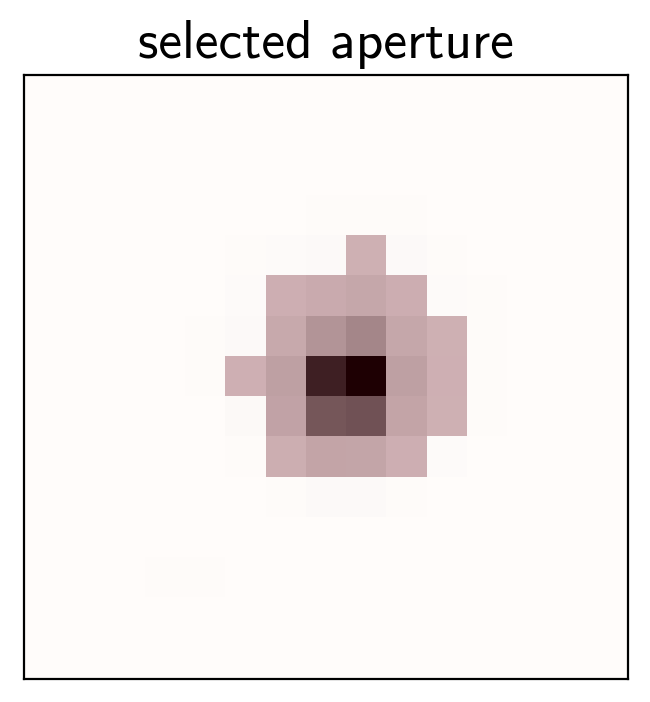

In [5]:
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

# A function to estimate the windowed scatter in a lightcurve
def estimate_scatter_with_mask(mask):
    f = np.sum(flux[:, mask], axis=-1)
    smooth = savgol_filter(f, 1001, polyorder=5)
    return 1e6 * np.sqrt(np.median((f / smooth - 1)**2))

# Loop over pixels ordered by brightness and add them one-by-one
# to the aperture
masks, scatters = [], []
for i in range(1, 100):
    msk = np.zeros_like(mean_img, dtype=bool)
    msk[np.unravel_index(order[:i], mean_img.shape)] = True
    scatter = estimate_scatter_with_mask(msk)
    masks.append(msk)
    scatters.append(scatter)

# Choose the aperture that minimizes the scatter
pix_mask = masks[np.argmin(scatters)]

# Plot the selected aperture
plt.imshow(mean_img.T, cmap="gray_r")
plt.imshow(pix_mask.T, cmap="Reds", alpha=0.3)
plt.title("selected aperture")
plt.xticks([])
plt.yticks([]);

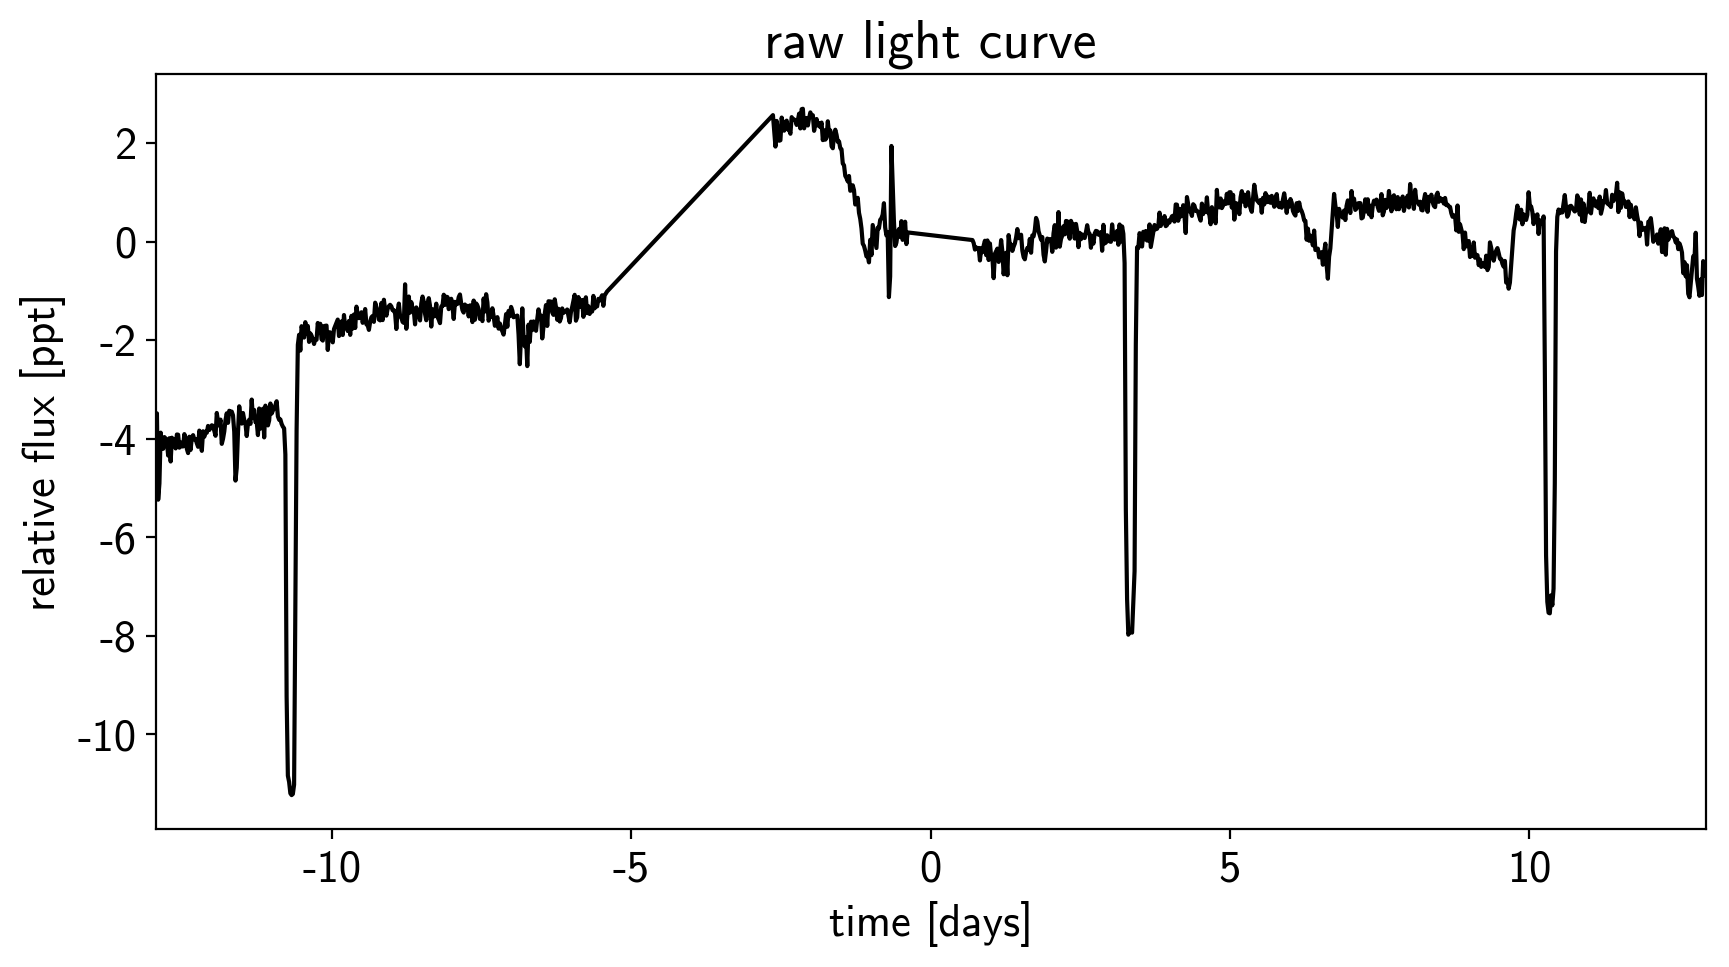

In [6]:
plt.figure(figsize=(10, 5))
sap_flux = np.sum(flux[:, pix_mask], axis=-1)
sap_flux = (sap_flux / np.median(sap_flux) - 1) * 1e3
plt.plot(time, sap_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
plt.title("raw light curve")
plt.xlim(time.min(), time.max());

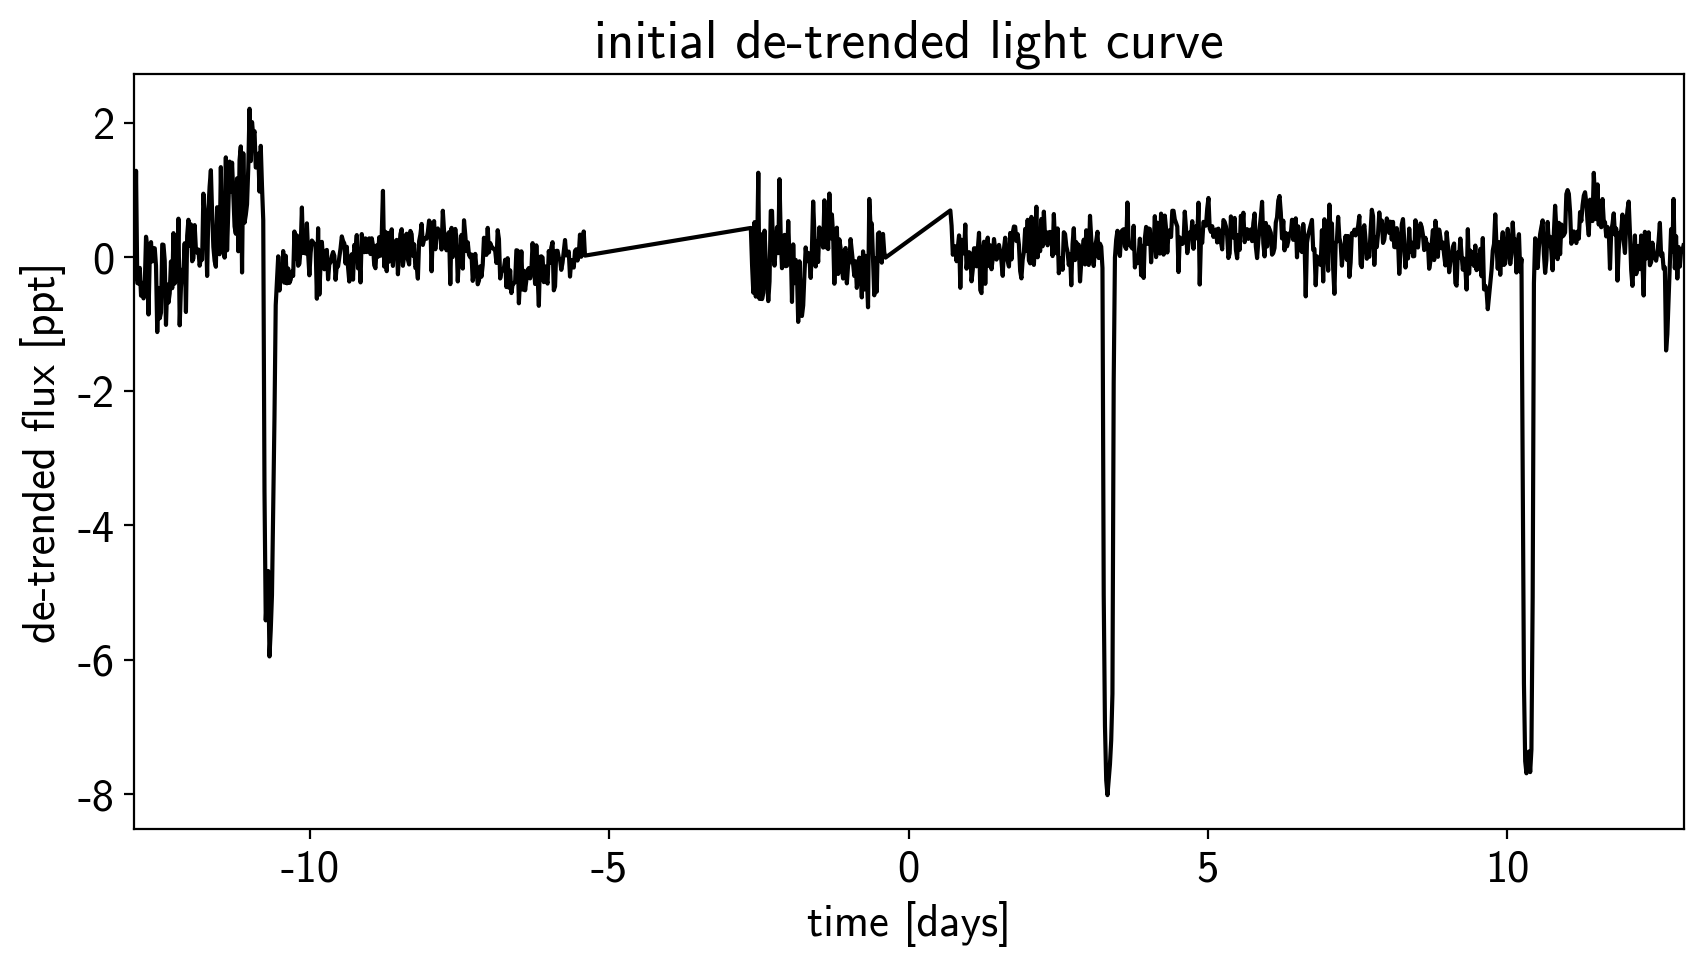

In [7]:
# Build the first order PLD basis
X_pld = np.reshape(flux[:, pix_mask], (len(flux), -1))
X_pld = X_pld / np.sum(flux[:, pix_mask], axis=-1)[:, None]

# Build the second order PLD basis and run PCA to reduce the number of dimensions
X2_pld = np.reshape(X_pld[:, None, :] * X_pld[:, :, None], (len(flux), -1))
U, _, _ = np.linalg.svd(X2_pld, full_matrices=False)
X2_pld = U[:, :X_pld.shape[1]]

# Construct the design matrix and fit for the PLD model
X_pld = np.concatenate((np.ones((len(flux), 1)), X_pld, X2_pld), axis=-1)
XTX = np.dot(X_pld.T, X_pld)
w_pld = np.linalg.solve(XTX, np.dot(X_pld.T, sap_flux))
pld_flux = np.dot(X_pld, w_pld)

# Plot the de-trended light curve
plt.figure(figsize=(10, 5))
plt.plot(time, sap_flux-pld_flux, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("initial de-trended light curve")
plt.xlim(time.min(), time.max());

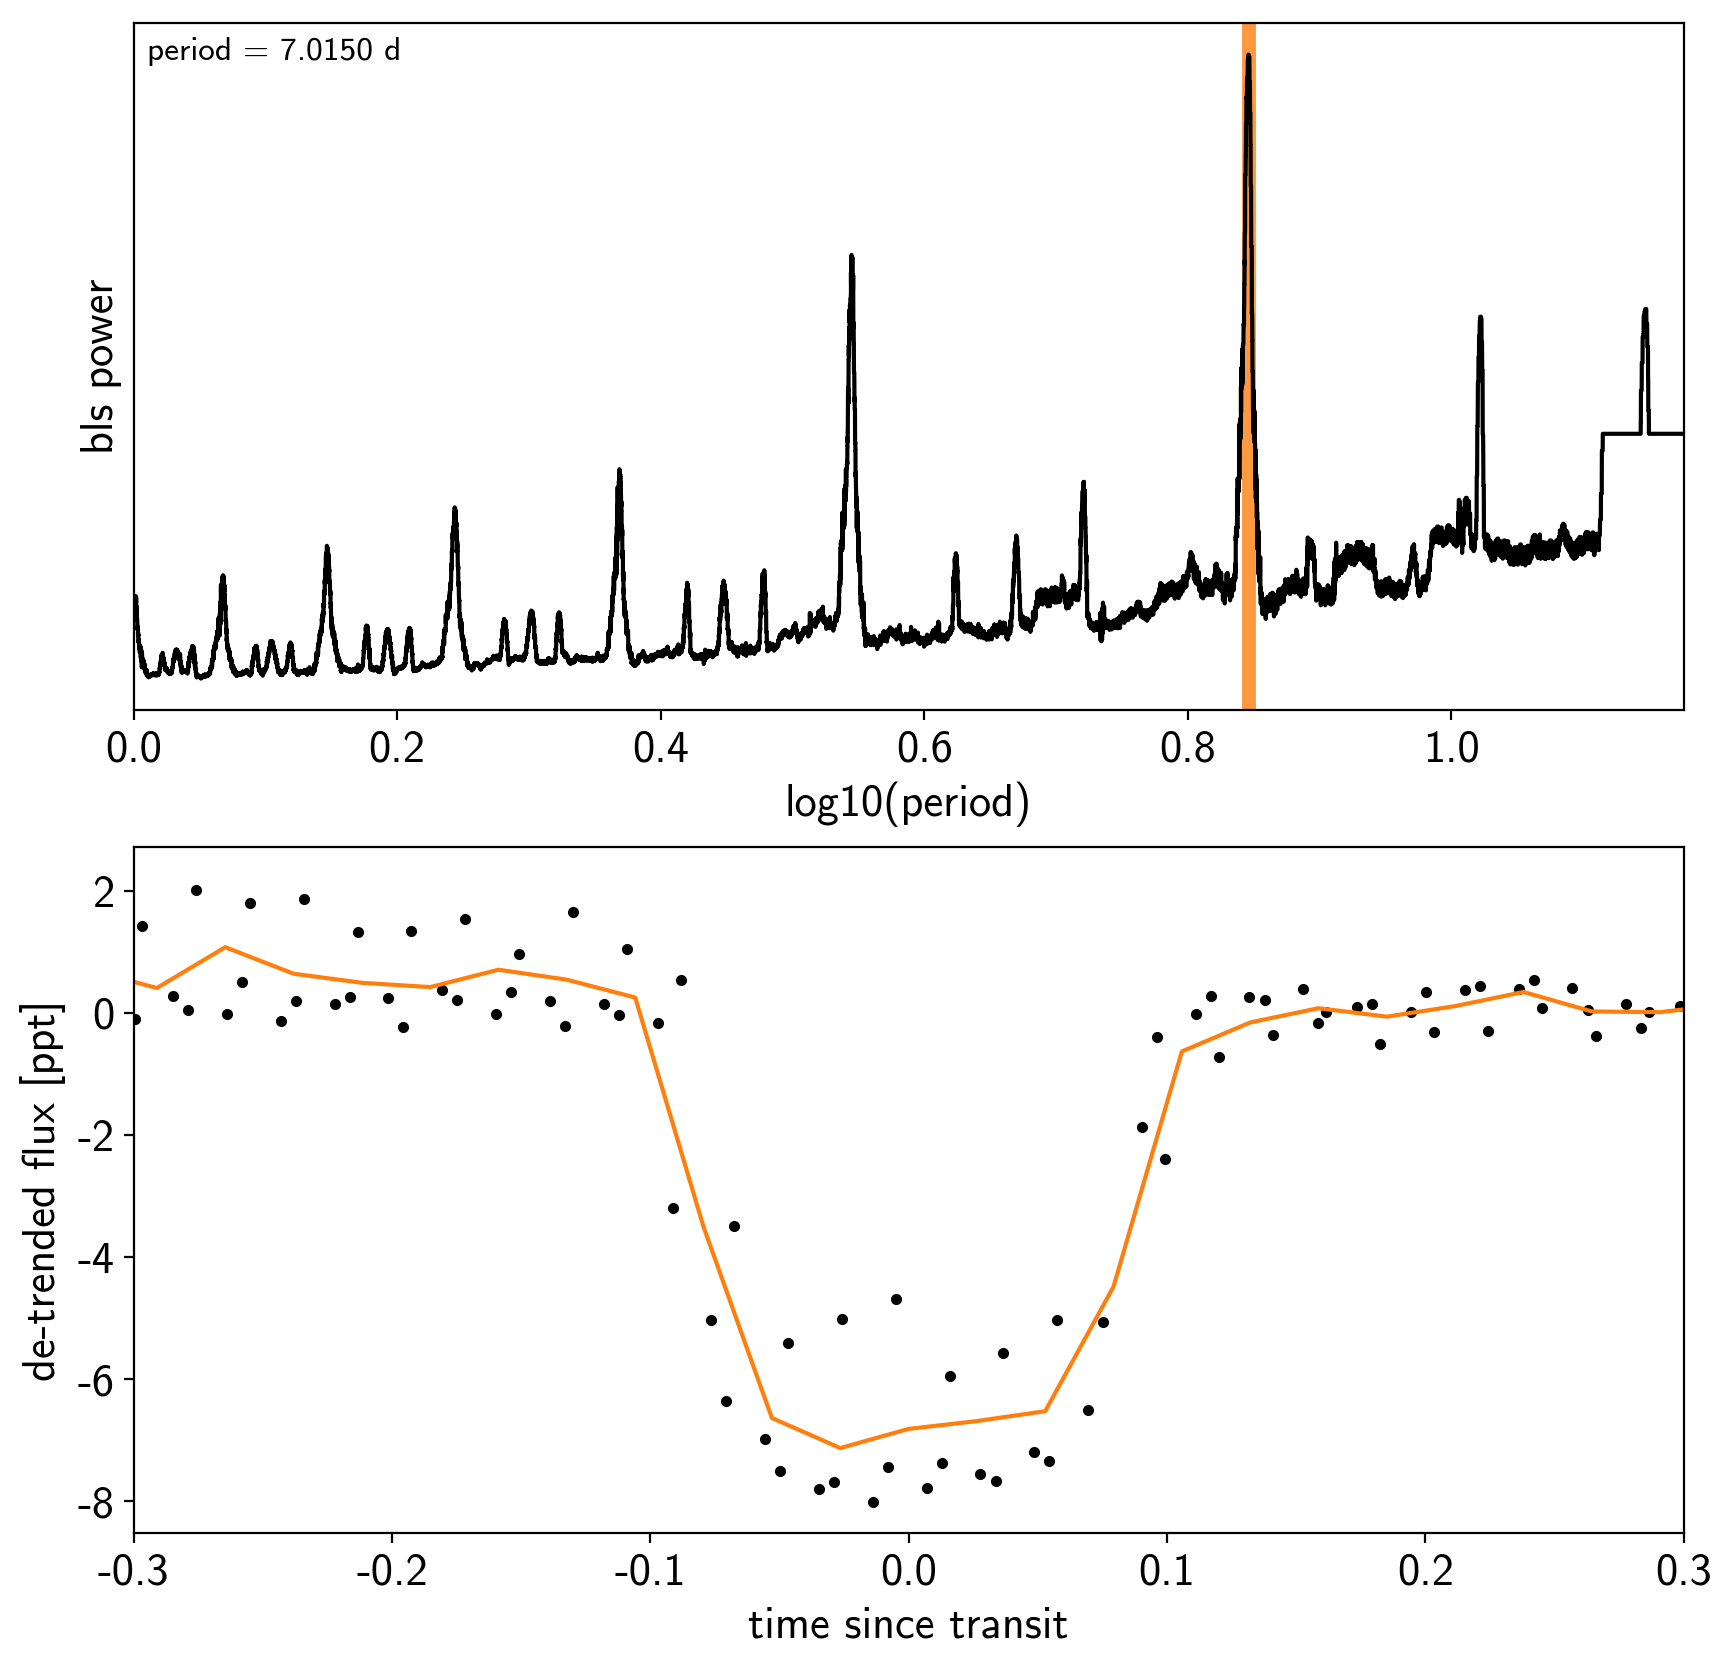

In [8]:
from astropy.stats import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(time, sap_flux - pld_flux)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate("period = {0:.4f} d".format(bls_period),
            (0, 1), xycoords="axes fraction",
            xytext=(5, -5), textcoords="offset points",
            va="top", ha="left", fontsize=12)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (time - bls_t0 + 0.5*bls_period)%bls_period - 0.5*bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], sap_flux[m] - pld_flux[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=sap_flux - pld_flux)
denom[num == 0] = 1.0
ax.plot(0.5*(bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
ax.set_xlabel("time since transit");

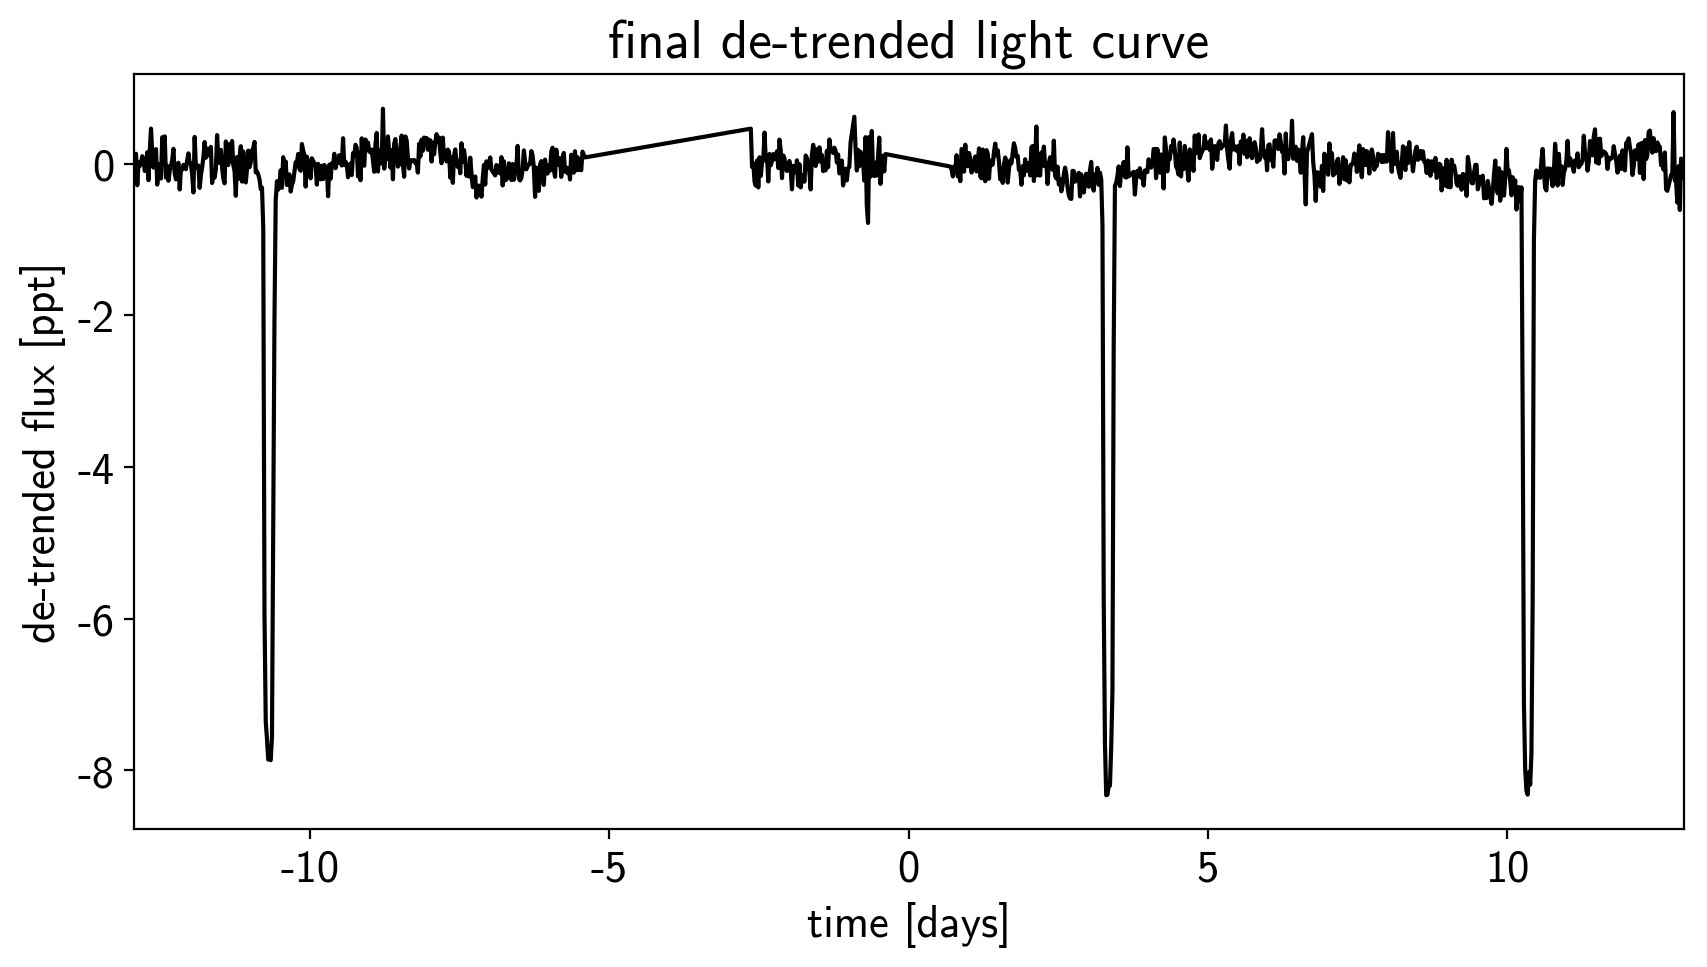

In [9]:
m = ~transit_mask
XTX = np.dot(X_pld[m].T, X_pld[m])
w_pld = np.linalg.solve(XTX, np.dot(X_pld[m].T, sap_flux[m]))
pld_flux = np.dot(X_pld, w_pld)

x = np.ascontiguousarray(time, dtype=np.float64)
y = np.ascontiguousarray(sap_flux-pld_flux, dtype=np.float64)

plt.figure(figsize=(10, 5))
plt.plot(time, y, "k")
plt.xlabel("time [days]")
plt.ylabel("de-trended flux [ppt]")
plt.title("final de-trended light curve")
plt.xlim(time.min(), time.max());

In [10]:
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.distributions.QuadLimbDark("u_star")
        
        # Stellar parameters from TIC
        M_star_huang = 1.094, 0.039
        R_star_huang = 1.10, 0.023
        m_star = pm.Normal("m_star", mu=tic_mass[0], sd=tic_mass[1])
        r_star = pm.Normal("r_star", mu=tic_radius[0], sd=tic_radius[1])

        # Prior to require physical parameters
        pm.Potential("m_star_prior", tt.switch(m_star > 0, 0, -np.inf))
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))

        # Orbital parameters for the planets
        logP = pm.Normal("logP", mu=np.log(bls_period), sd=1)
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        b = pm.Uniform("b", lower=0, upper=1, testval=0.5)
        logr = pm.Normal("logr", sd=1.0,
                         mu=0.5*np.log(1e-3*np.array(bls_depth))+np.log(tic_radius[0]))
        r_pl = pm.Deterministic("r_pl", tt.exp(logr))
        ror = pm.Deterministic("ror", r_pl / r_star)
        
        # This is the eccentricity prior from Kipping (2013):
        # https://arxiv.org/abs/1306.4982
        ecc = pm.Beta("ecc", alpha=0.867, beta=3.03, testval=0.1)
        omega = xo.distributions.Angle("omega")

        # Transit jitter & GP parameters
        logs2 = pm.Normal("logs2", mu=np.log(np.var(y[mask])), sd=10)
        logw0_guess = np.log(2*np.pi/10)
        logw0 = pm.Normal("logw0", mu=logw0_guess, sd=10)
        
        # We'll parameterize using the maximum power (S_0 * w_0^4) instead of
        # S_0 directly because this removes some of the degeneracies between
        # S_0 and omega_0
        logpower = pm.Normal("logpower",
                             mu=np.log(np.var(y[mask]))+4*logw0_guess,
                             sd=10)
        logS0 = pm.Deterministic("logS0", logpower - 4 * logw0)

        # Tracking planet parameters
        period = pm.Deterministic("period", tt.exp(logP))

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, m_star=m_star,
            period=period, t0=t0, b=b,
            ecc=ecc, omega=omega)
        pm.Deterministic("a", orbit.a_planet)
        pm.Deterministic("incl", orbit.incl)

        # Compute the model light curve using starry
        light_curves = xo.StarryLightCurve(u_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        pm.Deterministic("light_curves", light_curves)

        # GP model for the light curve
        kernel = xo.gp.terms.SHOTerm(log_S0=logS0, log_w0=logw0, Q=1/np.sqrt(2))
        gp = xo.gp.GP(kernel, x[mask], tt.exp(logs2) + tt.zeros(mask.sum()), J=2)
        pm.Potential("transit_obs", gp.log_likelihood(y[mask] - light_curve))
        pm.Deterministic("gp_pred", gp.predict())

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = xo.optimize(start=start, vars=[b])
        map_soln = xo.optimize(start=map_soln, vars=[logs2, logpower, logw0])
        map_soln = xo.optimize(start=map_soln, vars=[logr])
        map_soln = xo.optimize(start=map_soln)

    return model, map_soln

model0, map_soln0 = build_model()

optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: -1187.4649971584893 -> -1167.1812080299917


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: -1167.181208029992 -> 66.71318590430374


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 66.71318590430374 -> 106.91173137171472


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_logodds__', 'logr', 'b_interval__', 't0', 'logP', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 106.9117313717145 -> 343.1349315401228


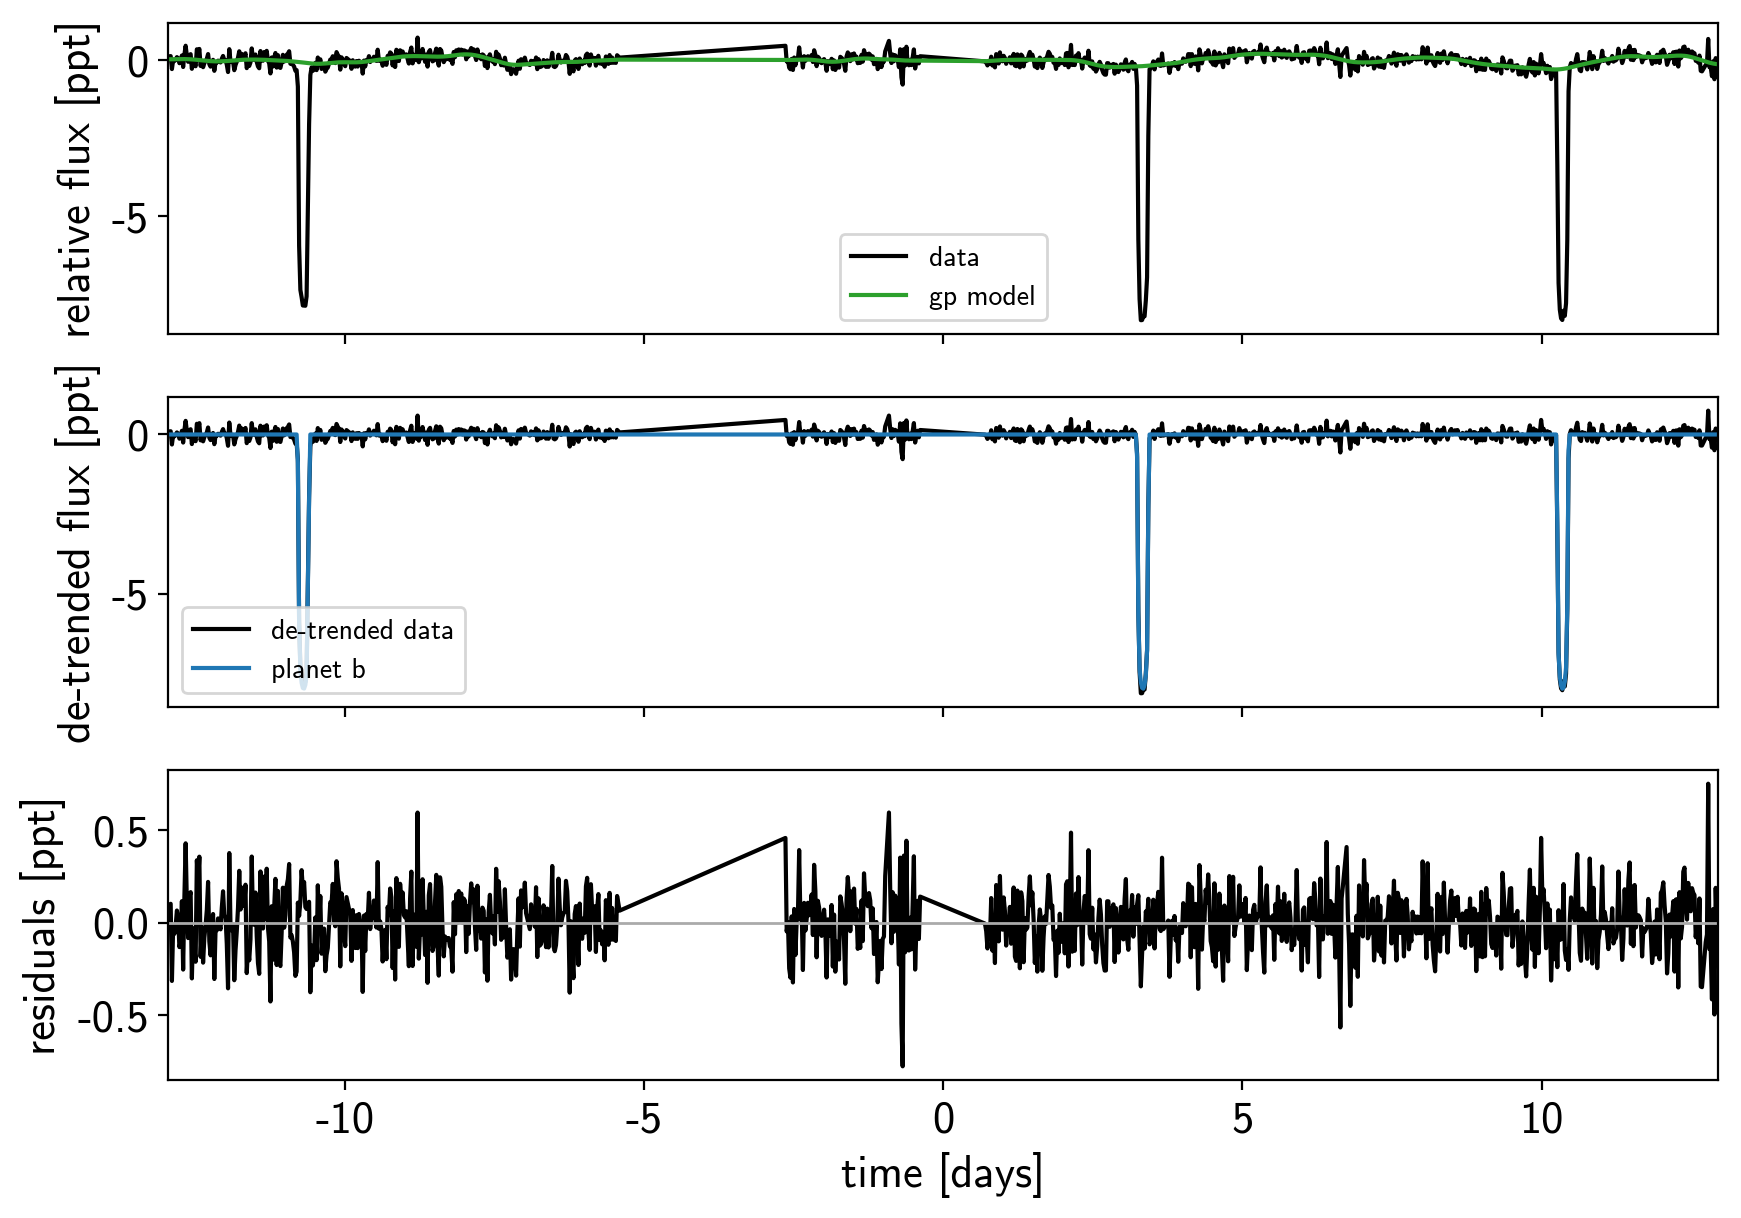

In [11]:
def plot_light_curve(soln, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = soln["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = soln["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(soln["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    
    return fig
    
plot_light_curve(map_soln0);

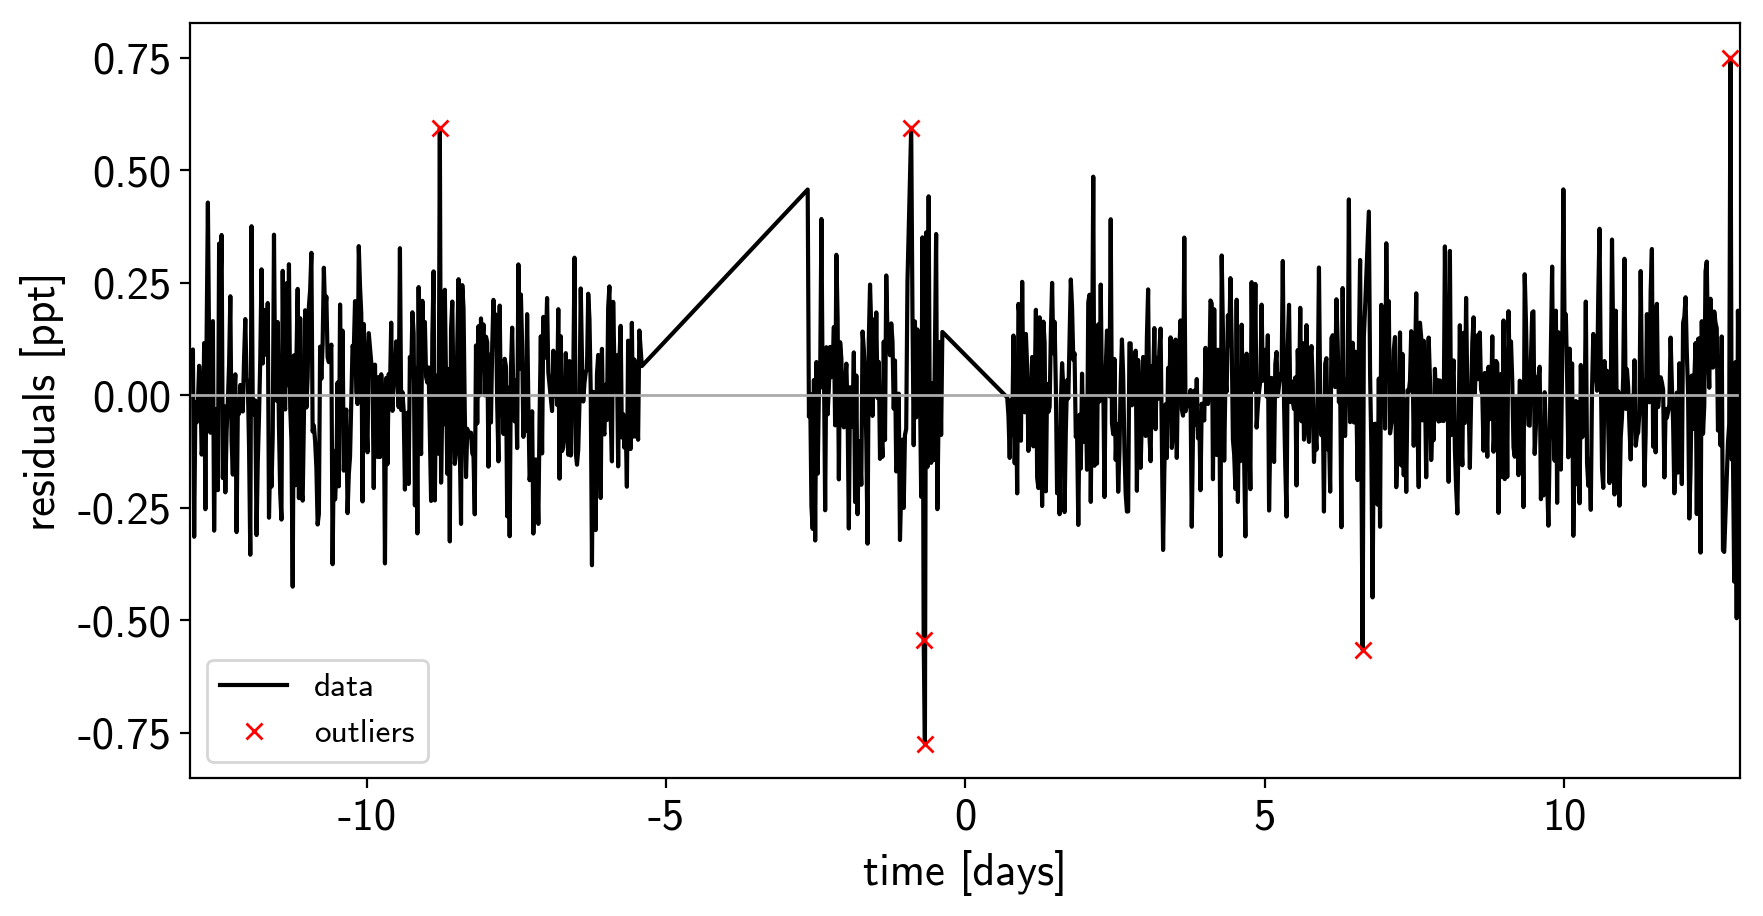

In [12]:
mod = map_soln0["gp_pred"] + map_soln0["mean"] + np.sum(map_soln0["light_curves"], axis=-1)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
plt.xlim(x.min(), x.max());

optimizing logp for variables: ['b_interval__']


message: Optimization terminated successfully.
logp: 385.5369927156757 -> 385.5369927169309


optimizing logp for variables: ['logw0', 'logpower', 'logs2']


message: Optimization terminated successfully.
logp: 385.53699271693114 -> 388.4181918654495


optimizing logp for variables: ['logr']


message: Optimization terminated successfully.
logp: 388.4181918654495 -> 388.4388036404506


optimizing logp for variables: ['logpower', 'logw0', 'logs2', 'omega_angle__', 'ecc_logodds__', 'logr', 'b_interval__', 't0', 'logP', 'r_star', 'm_star', 'u_star_quadlimbdark__', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: 388.4388036404497 -> 388.4492815037509


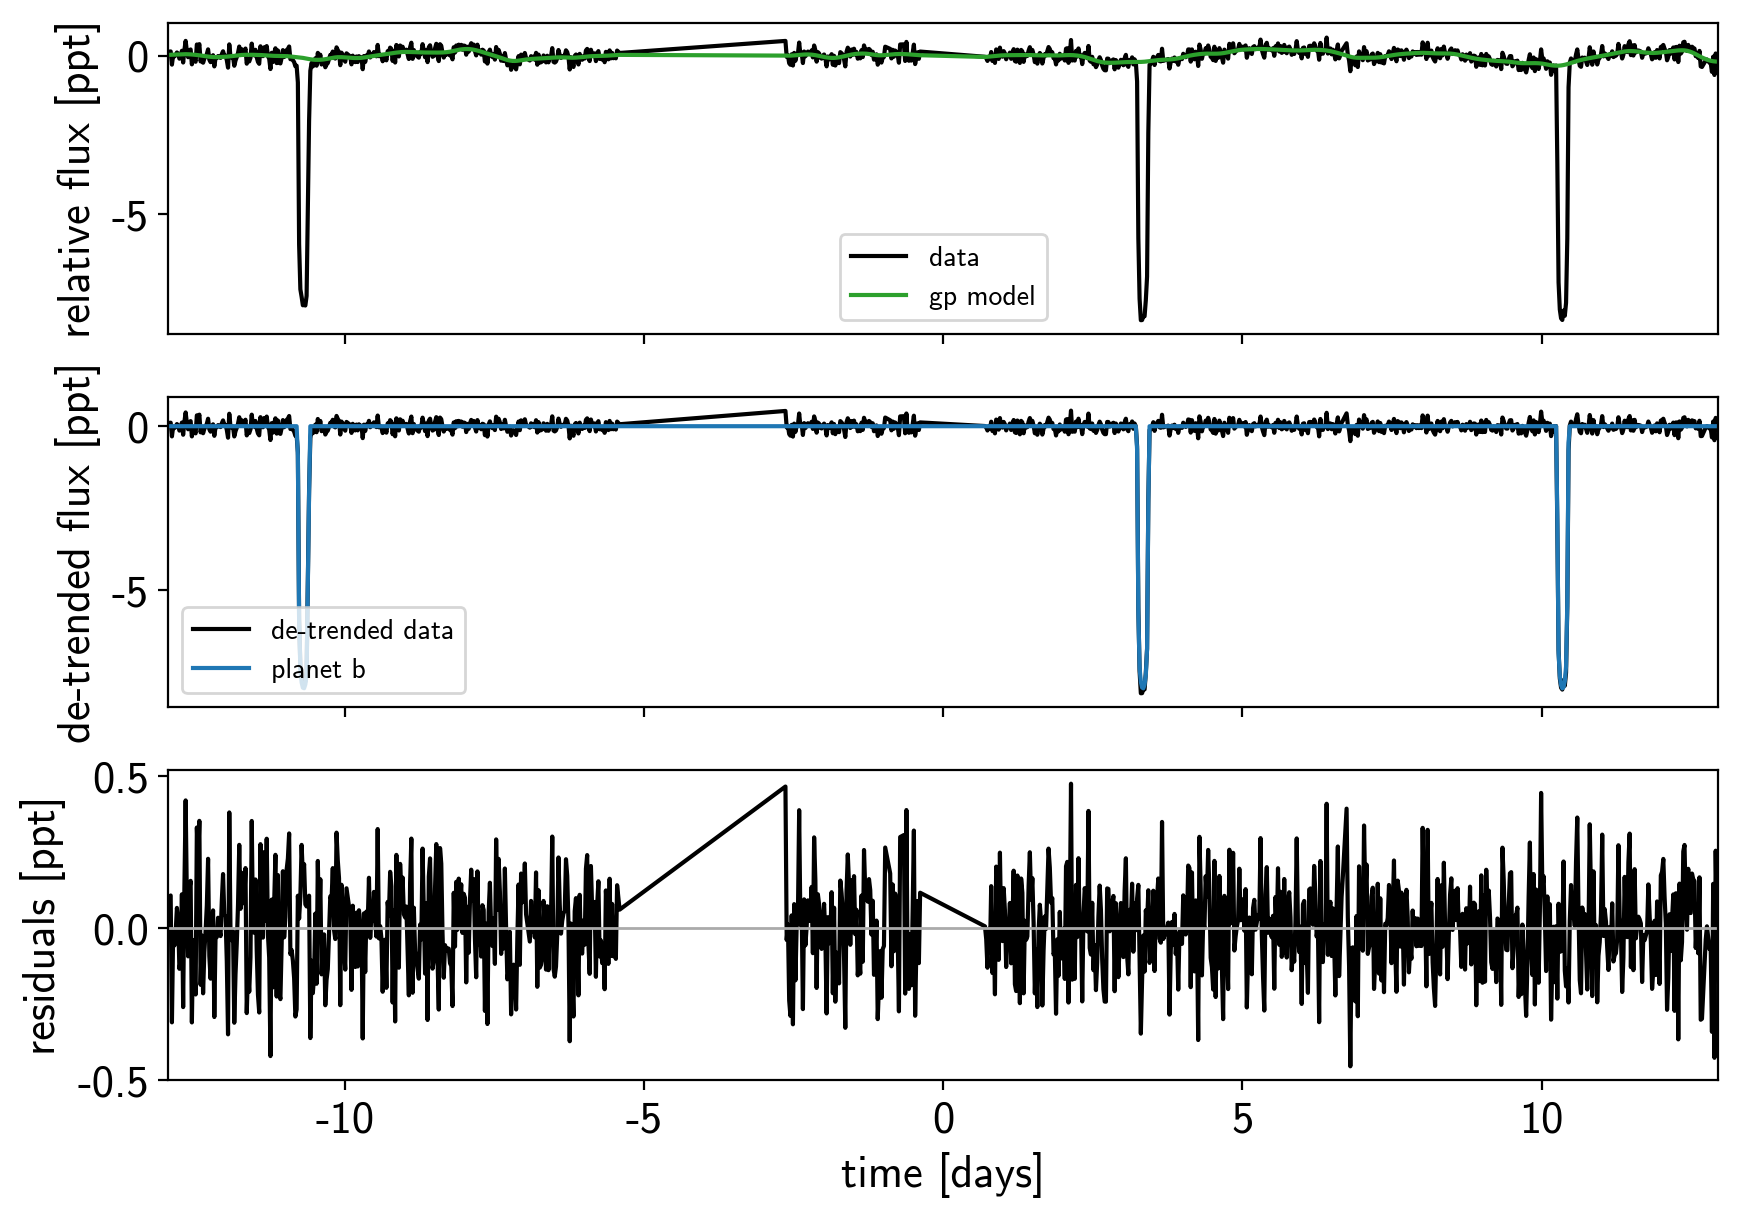

In [13]:
model, map_soln = build_model(mask, map_soln0)
plot_light_curve(map_soln, mask);

In [14]:
np.random.seed(12345)
sampler = xo.PyMC3Sampler(window=100, start=300, finish=500)
with model:
    burnin = sampler.tune(tune=3500, start=map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=4)

Sampling 4 chains:   0%|          | 0/1208 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|▏         | 17/1208 [00:00<00:09, 126.80draws/s]

Sampling 4 chains:   2%|▏         | 21/1208 [00:00<00:43, 27.19draws/s] 

Sampling 4 chains:   2%|▏         | 24/1208 [00:00<01:19, 14.93draws/s]

Sampling 4 chains:   2%|▏         | 27/1208 [00:01<01:36, 12.29draws/s]

Sampling 4 chains:   2%|▏         | 29/1208 [00:01<01:27, 13.43draws/s]

Sampling 4 chains:   3%|▎         | 31/1208 [00:01<01:55, 10.15draws/s]

Sampling 4 chains:   3%|▎         | 33/1208 [00:01<01:43, 11.30draws/s]

Sampling 4 chains:   3%|▎         | 35/1208 [00:02<02:02,  9.56draws/s]

Sampling 4 chains:   3%|▎         | 37/1208 [00:02<01:53, 10.34draws/s]

Sampling 4 chains:   3%|▎         | 39/1208 [00:02<02:09,  9.00draws/s]

Sampling 4 chains:   3%|▎         | 41/1208 [00:02<01:56, 10.01draws/s]

Sampling 4 chains:   4%|▎         | 43/1208 [00:03<02:08,  9.04draws/s]

Sampling 4 chains:   4%|▎         | 45/1208 [00:03<02:00,  9.65draws/s]

Sampling 4 chains:   4%|▍         | 47/1208 [00:03<02:07,  9.11draws/s]

Sampling 4 chains:   4%|▍         | 49/1208 [00:03<01:58,  9.76draws/s]

Sampling 4 chains:   4%|▍         | 51/1208 [00:03<02:06,  9.18draws/s]

Sampling 4 chains:   4%|▍         | 53/1208 [00:04<01:57,  9.81draws/s]

Sampling 4 chains:   5%|▍         | 55/1208 [00:04<02:04,  9.25draws/s]

Sampling 4 chains:   5%|▍         | 57/1208 [00:04<01:57,  9.83draws/s]

Sampling 4 chains:   5%|▍         | 59/1208 [00:04<02:06,  9.10draws/s]

Sampling 4 chains:   5%|▌         | 61/1208 [00:04<01:55,  9.92draws/s]

Sampling 4 chains:   5%|▌         | 63/1208 [00:05<02:05,  9.16draws/s]

Sampling 4 chains:   5%|▌         | 66/1208 [00:05<01:46, 10.70draws/s]

Sampling 4 chains:   6%|▌         | 68/1208 [00:05<01:57,  9.68draws/s]

Sampling 4 chains:   6%|▌         | 70/1208 [00:05<01:50, 10.33draws/s]

Sampling 4 chains:   6%|▌         | 72/1208 [00:05<01:59,  9.51draws/s]

Sampling 4 chains:   6%|▌         | 75/1208 [00:06<01:42, 11.04draws/s]

Sampling 4 chains:   6%|▋         | 77/1208 [00:06<01:58,  9.55draws/s]

Sampling 4 chains:   7%|▋         | 79/1208 [00:06<01:46, 10.63draws/s]

Sampling 4 chains:   7%|▋         | 81/1208 [00:06<02:00,  9.35draws/s]

Sampling 4 chains:   7%|▋         | 83/1208 [00:06<01:48, 10.39draws/s]

Sampling 4 chains:   7%|▋         | 85/1208 [00:07<02:01,  9.25draws/s]

Sampling 4 chains:   7%|▋         | 87/1208 [00:07<01:50, 10.12draws/s]

Sampling 4 chains:   7%|▋         | 89/1208 [00:07<02:01,  9.24draws/s]

Sampling 4 chains:   8%|▊         | 91/1208 [00:07<01:50, 10.11draws/s]

Sampling 4 chains:   8%|▊         | 93/1208 [00:08<02:01,  9.17draws/s]

Sampling 4 chains:   8%|▊         | 95/1208 [00:08<01:49, 10.13draws/s]

Sampling 4 chains:   8%|▊         | 97/1208 [00:08<02:01,  9.17draws/s]

Sampling 4 chains:   8%|▊         | 99/1208 [00:08<01:49, 10.16draws/s]

Sampling 4 chains:   8%|▊         | 101/1208 [00:08<02:01,  9.14draws/s]

Sampling 4 chains:   9%|▊         | 103/1208 [00:09<01:49, 10.08draws/s]

Sampling 4 chains:   9%|▊         | 105/1208 [00:09<02:00,  9.15draws/s]

Sampling 4 chains:   9%|▉         | 107/1208 [00:09<01:48, 10.13draws/s]

Sampling 4 chains:   9%|▉         | 109/1208 [00:09<02:00,  9.16draws/s]

Sampling 4 chains:   9%|▉         | 111/1208 [00:09<01:48, 10.16draws/s]

Sampling 4 chains:   9%|▉         | 113/1208 [00:10<02:00,  9.08draws/s]

Sampling 4 chains:  10%|▉         | 115/1208 [00:10<01:46, 10.22draws/s]

Sampling 4 chains:  10%|▉         | 117/1208 [00:10<01:51,  9.74draws/s]

Sampling 4 chains:  10%|▉         | 119/1208 [00:10<01:49,  9.97draws/s]

Sampling 4 chains:  10%|█         | 121/1208 [00:10<01:52,  9.70draws/s]

Sampling 4 chains:  10%|█         | 123/1208 [00:11<01:49,  9.87draws/s]

Sampling 4 chains:  10%|█         | 125/1208 [00:11<01:52,  9.66draws/s]

Sampling 4 chains:  11%|█         | 128/1208 [00:11<01:39, 10.87draws/s]

Sampling 4 chains:  11%|█         | 130/1208 [00:11<01:44, 10.36draws/s]

Sampling 4 chains:  11%|█         | 132/1208 [00:11<01:44, 10.26draws/s]

Sampling 4 chains:  11%|█         | 134/1208 [00:12<01:47, 10.03draws/s]

Sampling 4 chains:  11%|█▏        | 136/1208 [00:12<01:47,  9.93draws/s]

Sampling 4 chains:  11%|█▏        | 138/1208 [00:12<01:48,  9.90draws/s]

Sampling 4 chains:  12%|█▏        | 140/1208 [00:12<01:49,  9.79draws/s]

Sampling 4 chains:  12%|█▏        | 141/1208 [00:12<01:48,  9.84draws/s]

Sampling 4 chains:  12%|█▏        | 143/1208 [00:13<01:47,  9.89draws/s]

Sampling 4 chains:  12%|█▏        | 144/1208 [00:13<01:51,  9.56draws/s]

Sampling 4 chains:  12%|█▏        | 145/1208 [00:13<01:51,  9.56draws/s]

Sampling 4 chains:  12%|█▏        | 147/1208 [00:13<01:49,  9.71draws/s]

Sampling 4 chains:  12%|█▏        | 148/1208 [00:13<01:51,  9.50draws/s]

Sampling 4 chains:  12%|█▏        | 149/1208 [00:13<01:53,  9.35draws/s]

Sampling 4 chains:  12%|█▎        | 151/1208 [00:13<01:49,  9.62draws/s]

Sampling 4 chains:  13%|█▎        | 152/1208 [00:14<01:51,  9.51draws/s]

Sampling 4 chains:  13%|█▎        | 153/1208 [00:14<01:54,  9.25draws/s]

Sampling 4 chains:  13%|█▎        | 155/1208 [00:14<01:50,  9.57draws/s]

Sampling 4 chains:  13%|█▎        | 156/1208 [00:14<01:50,  9.53draws/s]

Sampling 4 chains:  13%|█▎        | 157/1208 [00:14<01:54,  9.17draws/s]

Sampling 4 chains:  13%|█▎        | 159/1208 [00:14<01:50,  9.53draws/s]

Sampling 4 chains:  13%|█▎        | 160/1208 [00:14<01:51,  9.36draws/s]

Sampling 4 chains:  13%|█▎        | 161/1208 [00:14<01:54,  9.12draws/s]

Sampling 4 chains:  13%|█▎        | 163/1208 [00:15<01:50,  9.45draws/s]

Sampling 4 chains:  14%|█▎        | 164/1208 [00:15<01:49,  9.52draws/s]

Sampling 4 chains:  14%|█▎        | 165/1208 [00:15<01:54,  9.12draws/s]

Sampling 4 chains:  14%|█▍        | 167/1208 [00:15<01:49,  9.47draws/s]

Sampling 4 chains:  14%|█▍        | 168/1208 [00:15<01:48,  9.61draws/s]

Sampling 4 chains:  14%|█▍        | 169/1208 [00:15<01:54,  9.08draws/s]

Sampling 4 chains:  14%|█▍        | 171/1208 [00:15<01:49,  9.46draws/s]

Sampling 4 chains:  14%|█▍        | 173/1208 [00:16<01:51,  9.27draws/s]

Sampling 4 chains:  14%|█▍        | 175/1208 [00:16<01:47,  9.59draws/s]

Sampling 4 chains:  15%|█▍        | 177/1208 [00:16<01:52,  9.18draws/s]

Sampling 4 chains:  15%|█▍        | 179/1208 [00:16<01:45,  9.74draws/s]

Sampling 4 chains:  15%|█▍        | 181/1208 [00:17<01:50,  9.26draws/s]

Sampling 4 chains:  15%|█▌        | 183/1208 [00:17<01:44,  9.83draws/s]

Sampling 4 chains:  15%|█▌        | 185/1208 [00:17<01:50,  9.30draws/s]

Sampling 4 chains:  15%|█▌        | 187/1208 [00:17<01:43,  9.87draws/s]

Sampling 4 chains:  16%|█▌        | 189/1208 [00:17<01:49,  9.33draws/s]

Sampling 4 chains:  16%|█▌        | 191/1208 [00:18<01:43,  9.86draws/s]

Sampling 4 chains:  16%|█▌        | 193/1208 [00:18<01:47,  9.43draws/s]

Sampling 4 chains:  16%|█▌        | 195/1208 [00:18<01:42,  9.85draws/s]

Sampling 4 chains:  16%|█▋        | 197/1208 [00:18<01:46,  9.51draws/s]

Sampling 4 chains:  16%|█▋        | 199/1208 [00:18<01:42,  9.82draws/s]

Sampling 4 chains:  17%|█▋        | 201/1208 [00:19<01:45,  9.57draws/s]

Sampling 4 chains:  17%|█▋        | 203/1208 [00:19<01:42,  9.78draws/s]

Sampling 4 chains:  17%|█▋        | 205/1208 [00:19<01:44,  9.62draws/s]

Sampling 4 chains:  17%|█▋        | 207/1208 [00:19<01:42,  9.72draws/s]

Sampling 4 chains:  17%|█▋        | 209/1208 [00:19<01:44,  9.60draws/s]

Sampling 4 chains:  18%|█▊        | 212/1208 [00:20<01:32, 10.75draws/s]

Sampling 4 chains:  18%|█▊        | 214/1208 [00:20<01:35, 10.38draws/s]

Sampling 4 chains:  18%|█▊        | 216/1208 [00:20<01:37, 10.16draws/s]

Sampling 4 chains:  18%|█▊        | 218/1208 [00:20<01:38, 10.09draws/s]

Sampling 4 chains:  18%|█▊        | 220/1208 [00:20<01:40,  9.85draws/s]

Sampling 4 chains:  18%|█▊        | 222/1208 [00:21<01:38,  9.97draws/s]

Sampling 4 chains:  19%|█▊        | 224/1208 [00:21<01:43,  9.51draws/s]

Sampling 4 chains:  19%|█▊        | 226/1208 [00:21<01:36, 10.17draws/s]

Sampling 4 chains:  19%|█▉        | 228/1208 [00:21<01:26, 11.29draws/s]

Sampling 4 chains:  19%|█▉        | 230/1208 [00:21<01:41,  9.59draws/s]

Sampling 4 chains:  19%|█▉        | 232/1208 [00:22<01:31, 10.72draws/s]

Sampling 4 chains:  19%|█▉        | 234/1208 [00:22<01:44,  9.34draws/s]

Sampling 4 chains:  20%|█▉        | 236/1208 [00:22<01:33, 10.45draws/s]

Sampling 4 chains:  20%|█▉        | 238/1208 [00:22<01:44,  9.25draws/s]

Sampling 4 chains:  20%|█▉        | 240/1208 [00:22<01:33, 10.30draws/s]

Sampling 4 chains:  20%|██        | 242/1208 [00:23<01:44,  9.27draws/s]

Sampling 4 chains:  20%|██        | 244/1208 [00:23<01:34, 10.20draws/s]

Sampling 4 chains:  20%|██        | 246/1208 [00:23<01:43,  9.27draws/s]

Sampling 4 chains:  21%|██        | 248/1208 [00:23<01:36,  9.94draws/s]

Sampling 4 chains:  21%|██        | 250/1208 [00:24<01:42,  9.35draws/s]

Sampling 4 chains:  21%|██        | 252/1208 [00:24<01:36,  9.87draws/s]

Sampling 4 chains:  21%|██        | 254/1208 [00:24<01:40,  9.45draws/s]

Sampling 4 chains:  21%|██        | 256/1208 [00:24<01:36,  9.82draws/s]

Sampling 4 chains:  21%|██▏       | 258/1208 [00:24<01:39,  9.54draws/s]

Sampling 4 chains:  22%|██▏       | 260/1208 [00:25<01:37,  9.76draws/s]

Sampling 4 chains:  22%|██▏       | 261/1208 [00:25<01:51,  8.47draws/s]

Sampling 4 chains:  22%|██▏       | 264/1208 [00:25<01:42,  9.17draws/s]

Sampling 4 chains:  22%|██▏       | 265/1208 [00:25<01:54,  8.20draws/s]

Sampling 4 chains:  22%|██▏       | 268/1208 [00:25<01:45,  8.94draws/s]

Sampling 4 chains:  22%|██▏       | 269/1208 [00:26<01:56,  8.09draws/s]

Sampling 4 chains:  23%|██▎       | 272/1208 [00:26<01:45,  8.83draws/s]

Sampling 4 chains:  23%|██▎       | 273/1208 [00:26<01:56,  8.05draws/s]

Sampling 4 chains:  23%|██▎       | 276/1208 [00:26<01:45,  8.79draws/s]

Sampling 4 chains:  23%|██▎       | 277/1208 [00:26<01:56,  8.00draws/s]

Sampling 4 chains:  23%|██▎       | 280/1208 [00:27<01:45,  8.76draws/s]

Sampling 4 chains:  23%|██▎       | 281/1208 [00:27<01:55,  8.01draws/s]

Sampling 4 chains:  24%|██▎       | 284/1208 [00:27<01:45,  8.76draws/s]

Sampling 4 chains:  24%|██▎       | 285/1208 [00:27<01:55,  8.02draws/s]

Sampling 4 chains:  24%|██▍       | 288/1208 [00:27<01:44,  8.77draws/s]

Sampling 4 chains:  24%|██▍       | 289/1208 [00:28<01:54,  8.03draws/s]

Sampling 4 chains:  24%|██▍       | 292/1208 [00:28<01:44,  8.74draws/s]

Sampling 4 chains:  24%|██▍       | 293/1208 [00:28<01:52,  8.11draws/s]

Sampling 4 chains:  25%|██▍       | 298/1208 [00:28<01:33,  9.74draws/s]

Sampling 4 chains:  25%|██▍       | 300/1208 [00:28<01:26, 10.50draws/s]

Sampling 4 chains:  25%|██▌       | 302/1208 [00:29<01:35,  9.44draws/s]

Sampling 4 chains:  25%|██▌       | 304/1208 [00:29<01:27, 10.27draws/s]

Sampling 4 chains:  25%|██▌       | 306/1208 [00:29<01:36,  9.30draws/s]

Sampling 4 chains:  25%|██▌       | 308/1208 [00:29<01:28, 10.17draws/s]

Sampling 4 chains:  26%|██▌       | 310/1208 [00:30<01:37,  9.24draws/s]

Sampling 4 chains:  26%|██▌       | 312/1208 [00:30<01:28, 10.12draws/s]

Sampling 4 chains:  26%|██▌       | 314/1208 [00:30<01:37,  9.20draws/s]

Sampling 4 chains:  26%|██▌       | 315/1208 [00:30<01:37,  9.14draws/s]

Sampling 4 chains:  26%|██▋       | 318/1208 [00:30<01:35,  9.33draws/s]

Sampling 4 chains:  26%|██▋       | 319/1208 [00:31<01:34,  9.40draws/s]

Sampling 4 chains:  27%|██▋       | 321/1208 [00:31<01:21, 10.87draws/s]

Sampling 4 chains:  27%|██▋       | 323/1208 [00:31<01:35,  9.24draws/s]

Sampling 4 chains:  27%|██▋       | 325/1208 [00:31<01:23, 10.63draws/s]

Sampling 4 chains:  27%|██▋       | 327/1208 [00:31<01:35,  9.19draws/s]

Sampling 4 chains:  27%|██▋       | 329/1208 [00:31<01:23, 10.51draws/s]

Sampling 4 chains:  27%|██▋       | 331/1208 [00:32<01:35,  9.19draws/s]

Sampling 4 chains:  28%|██▊       | 333/1208 [00:32<01:23, 10.42draws/s]

Sampling 4 chains:  28%|██▊       | 335/1208 [00:32<01:34,  9.20draws/s]

Sampling 4 chains:  28%|██▊       | 337/1208 [00:32<01:24, 10.36draws/s]

Sampling 4 chains:  28%|██▊       | 339/1208 [00:33<01:34,  9.23draws/s]

Sampling 4 chains:  28%|██▊       | 341/1208 [00:33<01:24, 10.31draws/s]

Sampling 4 chains:  28%|██▊       | 343/1208 [00:33<01:33,  9.26draws/s]

Sampling 4 chains:  29%|██▊       | 345/1208 [00:33<01:24, 10.23draws/s]

Sampling 4 chains:  29%|██▊       | 347/1208 [00:33<01:32,  9.30draws/s]

Sampling 4 chains:  29%|██▉       | 349/1208 [00:34<01:26,  9.93draws/s]

Sampling 4 chains:  29%|██▉       | 351/1208 [00:34<01:31,  9.36draws/s]

Sampling 4 chains:  29%|██▉       | 352/1208 [00:34<01:43,  8.30draws/s]

Sampling 4 chains:  29%|██▉       | 354/1208 [00:34<01:41,  8.43draws/s]

Sampling 4 chains:  29%|██▉       | 356/1208 [00:34<01:34,  9.03draws/s]

Sampling 4 chains:  30%|██▉       | 358/1208 [00:35<01:37,  8.74draws/s]

Sampling 4 chains:  30%|██▉       | 360/1208 [00:35<01:29,  9.48draws/s]

Sampling 4 chains:  30%|██▉       | 362/1208 [00:35<01:33,  9.02draws/s]

Sampling 4 chains:  30%|███       | 364/1208 [00:35<01:26,  9.76draws/s]

Sampling 4 chains:  30%|███       | 366/1208 [00:35<01:31,  9.25draws/s]

Sampling 4 chains:  30%|███       | 368/1208 [00:36<01:25,  9.88draws/s]

Sampling 4 chains:  31%|███       | 370/1208 [00:36<01:29,  9.38draws/s]

Sampling 4 chains:  31%|███       | 372/1208 [00:36<01:24,  9.93draws/s]

Sampling 4 chains:  31%|███       | 374/1208 [00:36<01:28,  9.46draws/s]

Sampling 4 chains:  31%|███       | 377/1208 [00:36<01:16, 10.82draws/s]

Sampling 4 chains:  31%|███▏      | 379/1208 [00:37<01:22, 10.04draws/s]

Sampling 4 chains:  32%|███▏      | 381/1208 [00:37<01:19, 10.34draws/s]

Sampling 4 chains:  32%|███▏      | 383/1208 [00:37<01:24,  9.80draws/s]

Sampling 4 chains:  32%|███▏      | 385/1208 [00:37<01:21, 10.10draws/s]

Sampling 4 chains:  32%|███▏      | 387/1208 [00:37<01:24,  9.71draws/s]

Sampling 4 chains:  32%|███▏      | 389/1208 [00:38<01:22,  9.97draws/s]

Sampling 4 chains:  32%|███▏      | 391/1208 [00:38<01:24,  9.69draws/s]

Sampling 4 chains:  33%|███▎      | 393/1208 [00:38<01:22,  9.89draws/s]

Sampling 4 chains:  33%|███▎      | 395/1208 [00:38<01:23,  9.69draws/s]

Sampling 4 chains:  33%|███▎      | 397/1208 [00:38<01:22,  9.83draws/s]

Sampling 4 chains:  33%|███▎      | 398/1208 [00:39<01:38,  8.22draws/s]

Sampling 4 chains:  33%|███▎      | 400/1208 [00:39<01:22,  9.82draws/s]

Sampling 4 chains:  33%|███▎      | 402/1208 [00:39<01:34,  8.54draws/s]

Sampling 4 chains:  33%|███▎      | 404/1208 [00:39<01:19, 10.13draws/s]

Sampling 4 chains:  34%|███▎      | 406/1208 [00:40<01:35,  8.41draws/s]

Sampling 4 chains:  34%|███▍      | 409/1208 [00:40<01:23,  9.61draws/s]

Sampling 4 chains:  34%|███▍      | 411/1208 [00:40<01:22,  9.61draws/s]

Sampling 4 chains:  34%|███▍      | 413/1208 [00:40<01:22,  9.66draws/s]

Sampling 4 chains:  34%|███▍      | 415/1208 [00:40<01:24,  9.39draws/s]

Sampling 4 chains:  35%|███▍      | 417/1208 [00:41<01:21,  9.76draws/s]

Sampling 4 chains:  35%|███▍      | 419/1208 [00:41<01:25,  9.22draws/s]

Sampling 4 chains:  35%|███▍      | 421/1208 [00:41<01:19,  9.89draws/s]

Sampling 4 chains:  35%|███▌      | 423/1208 [00:41<01:24,  9.26draws/s]

Sampling 4 chains:  35%|███▌      | 425/1208 [00:41<01:18,  9.97draws/s]

Sampling 4 chains:  35%|███▌      | 427/1208 [00:42<01:27,  8.97draws/s]

Sampling 4 chains:  36%|███▌      | 429/1208 [00:42<01:16, 10.14draws/s]

Sampling 4 chains:  36%|███▌      | 431/1208 [00:42<01:26,  9.03draws/s]

Sampling 4 chains:  36%|███▌      | 433/1208 [00:42<01:17,  9.96draws/s]

Sampling 4 chains:  36%|███▌      | 435/1208 [00:42<01:26,  8.94draws/s]

Sampling 4 chains:  36%|███▌      | 437/1208 [00:43<01:16, 10.08draws/s]

Sampling 4 chains:  36%|███▋      | 439/1208 [00:43<01:27,  8.83draws/s]

Sampling 4 chains:  37%|███▋      | 441/1208 [00:43<01:15, 10.21draws/s]

Sampling 4 chains:  37%|███▋      | 443/1208 [00:43<01:26,  8.89draws/s]

Sampling 4 chains:  37%|███▋      | 445/1208 [00:43<01:14, 10.28draws/s]

Sampling 4 chains:  37%|███▋      | 447/1208 [00:44<01:26,  8.80draws/s]

Sampling 4 chains:  37%|███▋      | 449/1208 [00:44<01:13, 10.37draws/s]

Sampling 4 chains:  37%|███▋      | 451/1208 [00:44<01:25,  8.84draws/s]

Sampling 4 chains:  38%|███▊      | 453/1208 [00:44<01:12, 10.41draws/s]

Sampling 4 chains:  38%|███▊      | 455/1208 [00:45<01:25,  8.84draws/s]

Sampling 4 chains:  38%|███▊      | 457/1208 [00:45<01:13, 10.21draws/s]

Sampling 4 chains:  38%|███▊      | 459/1208 [00:45<01:24,  8.90draws/s]

Sampling 4 chains:  38%|███▊      | 461/1208 [00:45<01:12, 10.28draws/s]

Sampling 4 chains:  38%|███▊      | 463/1208 [00:45<01:23,  8.94draws/s]

Sampling 4 chains:  38%|███▊      | 465/1208 [00:46<01:12, 10.31draws/s]

Sampling 4 chains:  39%|███▊      | 467/1208 [00:46<01:22,  8.95draws/s]

Sampling 4 chains:  39%|███▉      | 469/1208 [00:46<01:11, 10.33draws/s]

Sampling 4 chains:  39%|███▉      | 471/1208 [00:46<01:22,  8.95draws/s]

Sampling 4 chains:  39%|███▉      | 473/1208 [00:46<01:11, 10.35draws/s]

Sampling 4 chains:  39%|███▉      | 475/1208 [00:47<01:21,  8.95draws/s]

Sampling 4 chains:  39%|███▉      | 477/1208 [00:47<01:10, 10.37draws/s]

Sampling 4 chains:  40%|███▉      | 479/1208 [00:47<01:21,  8.95draws/s]

Sampling 4 chains:  40%|███▉      | 481/1208 [00:47<01:10, 10.38draws/s]

Sampling 4 chains:  40%|███▉      | 483/1208 [00:48<01:21,  8.95draws/s]

Sampling 4 chains:  40%|████      | 485/1208 [00:48<01:09, 10.39draws/s]

Sampling 4 chains:  40%|████      | 487/1208 [00:48<01:20,  8.94draws/s]

Sampling 4 chains:  40%|████      | 489/1208 [00:48<01:09, 10.39draws/s]

Sampling 4 chains:  41%|████      | 491/1208 [00:48<01:20,  8.94draws/s]

Sampling 4 chains:  41%|████      | 493/1208 [00:48<01:08, 10.40draws/s]

Sampling 4 chains:  41%|████      | 495/1208 [00:49<01:19,  8.93draws/s]

Sampling 4 chains:  41%|████      | 497/1208 [00:49<01:08, 10.44draws/s]

Sampling 4 chains:  41%|████▏     | 499/1208 [00:49<01:19,  8.94draws/s]

Sampling 4 chains:  41%|████▏     | 501/1208 [00:49<01:07, 10.46draws/s]

Sampling 4 chains:  42%|████▏     | 503/1208 [00:50<01:18,  8.92draws/s]

Sampling 4 chains:  42%|████▏     | 505/1208 [00:50<01:07, 10.47draws/s]

Sampling 4 chains:  42%|████▏     | 507/1208 [00:50<01:18,  8.92draws/s]

Sampling 4 chains:  42%|████▏     | 509/1208 [00:50<01:06, 10.49draws/s]

Sampling 4 chains:  42%|████▏     | 511/1208 [00:50<01:18,  8.91draws/s]

Sampling 4 chains:  42%|████▏     | 513/1208 [00:51<01:06, 10.50draws/s]

Sampling 4 chains:  43%|████▎     | 515/1208 [00:51<01:17,  8.90draws/s]

Sampling 4 chains:  43%|████▎     | 517/1208 [00:51<01:05, 10.48draws/s]

Sampling 4 chains:  43%|████▎     | 519/1208 [00:51<01:18,  8.75draws/s]

Sampling 4 chains:  43%|████▎     | 523/1208 [00:52<01:16,  8.99draws/s]

Sampling 4 chains:  44%|████▎     | 527/1208 [00:52<01:14,  9.17draws/s]

Sampling 4 chains:  44%|████▍     | 531/1208 [00:53<01:12,  9.30draws/s]

Sampling 4 chains:  44%|████▍     | 535/1208 [00:53<01:11,  9.39draws/s]

Sampling 4 chains:  45%|████▍     | 539/1208 [00:53<01:10,  9.45draws/s]

Sampling 4 chains:  45%|████▍     | 543/1208 [00:54<01:10,  9.50draws/s]

Sampling 4 chains:  45%|████▌     | 547/1208 [00:54<01:09,  9.53draws/s]

Sampling 4 chains:  46%|████▌     | 551/1208 [00:55<01:08,  9.55draws/s]

Sampling 4 chains:  46%|████▌     | 555/1208 [00:55<01:08,  9.57draws/s]

Sampling 4 chains:  46%|████▋     | 559/1208 [00:55<01:07,  9.58draws/s]

Sampling 4 chains:  47%|████▋     | 563/1208 [00:56<01:07,  9.60draws/s]

Sampling 4 chains:  47%|████▋     | 567/1208 [00:56<01:06,  9.66draws/s]

Sampling 4 chains:  47%|████▋     | 571/1208 [00:57<01:05,  9.71draws/s]

Sampling 4 chains:  48%|████▊     | 574/1208 [00:57<00:52, 12.16draws/s]

Sampling 4 chains:  48%|████▊     | 576/1208 [00:57<01:07,  9.31draws/s]

Sampling 4 chains:  48%|████▊     | 579/1208 [00:57<01:11,  8.82draws/s]

Sampling 4 chains:  48%|████▊     | 582/1208 [00:58<00:56, 11.00draws/s]

Sampling 4 chains:  48%|████▊     | 584/1208 [00:58<01:10,  8.79draws/s]

Sampling 4 chains:  49%|████▊     | 587/1208 [00:58<01:12,  8.61draws/s]

Sampling 4 chains:  49%|████▉     | 589/1208 [00:58<01:02,  9.96draws/s]

Sampling 4 chains:  49%|████▉     | 591/1208 [00:59<01:09,  8.90draws/s]

Sampling 4 chains:  49%|████▉     | 593/1208 [00:59<01:00, 10.10draws/s]

Sampling 4 chains:  49%|████▉     | 595/1208 [00:59<01:07,  9.09draws/s]

Sampling 4 chains:  49%|████▉     | 597/1208 [00:59<01:00, 10.14draws/s]

Sampling 4 chains:  50%|████▉     | 599/1208 [01:00<01:06,  9.14draws/s]

Sampling 4 chains:  50%|████▉     | 601/1208 [01:00<00:59, 10.15draws/s]

Sampling 4 chains:  50%|████▉     | 603/1208 [01:00<01:05,  9.23draws/s]

Sampling 4 chains:  50%|█████     | 605/1208 [01:00<00:59, 10.13draws/s]

Sampling 4 chains:  50%|█████     | 607/1208 [01:00<01:04,  9.30draws/s]

Sampling 4 chains:  50%|█████     | 609/1208 [01:00<00:59, 10.09draws/s]

Sampling 4 chains:  51%|█████     | 611/1208 [01:01<01:03,  9.36draws/s]

Sampling 4 chains:  51%|█████     | 613/1208 [01:01<00:59, 10.03draws/s]

Sampling 4 chains:  51%|█████     | 615/1208 [01:01<01:02,  9.42draws/s]

Sampling 4 chains:  51%|█████     | 616/1208 [01:01<01:02,  9.42draws/s]

Sampling 4 chains:  51%|█████     | 618/1208 [01:01<00:53, 10.99draws/s]

Sampling 4 chains:  51%|█████▏    | 620/1208 [01:02<01:04,  9.14draws/s]

Sampling 4 chains:  51%|█████▏    | 622/1208 [01:02<00:55, 10.50draws/s]

Sampling 4 chains:  52%|█████▏    | 624/1208 [01:02<01:04,  9.06draws/s]

Sampling 4 chains:  52%|█████▏    | 626/1208 [01:02<00:55, 10.42draws/s]

Sampling 4 chains:  52%|█████▏    | 628/1208 [01:03<01:04,  9.02draws/s]

Sampling 4 chains:  52%|█████▏    | 630/1208 [01:03<00:58,  9.96draws/s]

Sampling 4 chains:  52%|█████▏    | 632/1208 [01:03<00:52, 10.92draws/s]

Sampling 4 chains:  52%|█████▏    | 634/1208 [01:03<00:52, 10.91draws/s]

Sampling 4 chains:  53%|█████▎    | 636/1208 [01:03<00:55, 10.22draws/s]

Sampling 4 chains:  53%|█████▎    | 638/1208 [01:03<00:55, 10.31draws/s]

Sampling 4 chains:  53%|█████▎    | 640/1208 [01:04<00:57,  9.94draws/s]

Sampling 4 chains:  53%|█████▎    | 642/1208 [01:04<00:56, 10.01draws/s]

Sampling 4 chains:  53%|█████▎    | 644/1208 [01:04<00:57,  9.81draws/s]

Sampling 4 chains:  53%|█████▎    | 646/1208 [01:04<00:58,  9.62draws/s]

Sampling 4 chains:  54%|█████▎    | 647/1208 [01:04<00:59,  9.42draws/s]

Sampling 4 chains:  54%|█████▎    | 649/1208 [01:05<01:01,  9.13draws/s]

Sampling 4 chains:  54%|█████▍    | 651/1208 [01:05<01:00,  9.24draws/s]

Sampling 4 chains:  54%|█████▍    | 653/1208 [01:05<00:59,  9.38draws/s]

Sampling 4 chains:  54%|█████▍    | 655/1208 [01:05<00:58,  9.42draws/s]

Sampling 4 chains:  54%|█████▍    | 657/1208 [01:05<00:56,  9.72draws/s]

Sampling 4 chains:  55%|█████▍    | 659/1208 [01:06<00:58,  9.46draws/s]

Sampling 4 chains:  55%|█████▍    | 661/1208 [01:06<00:56,  9.74draws/s]

Sampling 4 chains:  55%|█████▍    | 663/1208 [01:06<00:57,  9.48draws/s]

Sampling 4 chains:  55%|█████▌    | 665/1208 [01:06<00:55,  9.76draws/s]

Sampling 4 chains:  55%|█████▌    | 667/1208 [01:06<00:56,  9.49draws/s]

Sampling 4 chains:  55%|█████▌    | 669/1208 [01:07<00:55,  9.77draws/s]

Sampling 4 chains:  56%|█████▌    | 671/1208 [01:07<00:56,  9.49draws/s]

Sampling 4 chains:  56%|█████▌    | 673/1208 [01:07<00:54,  9.78draws/s]

Sampling 4 chains:  56%|█████▌    | 675/1208 [01:07<00:56,  9.50draws/s]

Sampling 4 chains:  56%|█████▌    | 677/1208 [01:07<00:54,  9.78draws/s]

Sampling 4 chains:  56%|█████▌    | 679/1208 [01:08<00:55,  9.59draws/s]

Sampling 4 chains:  56%|█████▋    | 681/1208 [01:08<00:54,  9.75draws/s]

Sampling 4 chains:  57%|█████▋    | 683/1208 [01:08<00:54,  9.67draws/s]

Sampling 4 chains:  57%|█████▋    | 685/1208 [01:08<00:53,  9.70draws/s]

Sampling 4 chains:  57%|█████▋    | 687/1208 [01:09<00:53,  9.74draws/s]

Sampling 4 chains:  57%|█████▋    | 689/1208 [01:09<00:53,  9.65draws/s]

Sampling 4 chains:  57%|█████▋    | 691/1208 [01:09<00:52,  9.80draws/s]

Sampling 4 chains:  57%|█████▋    | 693/1208 [01:09<00:53,  9.61draws/s]

Sampling 4 chains:  58%|█████▊    | 695/1208 [01:09<00:52,  9.86draws/s]

Sampling 4 chains:  58%|█████▊    | 697/1208 [01:10<00:53,  9.55draws/s]

Sampling 4 chains:  58%|█████▊    | 699/1208 [01:10<00:51,  9.92draws/s]

Sampling 4 chains:  58%|█████▊    | 700/1208 [01:10<00:52,  9.75draws/s]

Sampling 4 chains:  58%|█████▊    | 701/1208 [01:10<00:55,  9.16draws/s]

Sampling 4 chains:  58%|█████▊    | 703/1208 [01:10<00:52,  9.66draws/s]

Sampling 4 chains:  58%|█████▊    | 704/1208 [01:10<00:55,  9.10draws/s]

Sampling 4 chains:  58%|█████▊    | 705/1208 [01:10<00:55,  9.10draws/s]

Sampling 4 chains:  59%|█████▊    | 707/1208 [01:11<00:51,  9.71draws/s]

Sampling 4 chains:  59%|█████▊    | 708/1208 [01:11<00:55,  8.95draws/s]

Sampling 4 chains:  59%|█████▊    | 709/1208 [01:11<00:55,  9.01draws/s]

Sampling 4 chains:  59%|█████▉    | 711/1208 [01:11<00:51,  9.74draws/s]

Sampling 4 chains:  59%|█████▉    | 713/1208 [01:11<00:54,  9.17draws/s]

Sampling 4 chains:  59%|█████▉    | 715/1208 [01:11<00:49,  9.96draws/s]

Sampling 4 chains:  59%|█████▉    | 717/1208 [01:12<00:53,  9.22draws/s]

Sampling 4 chains:  60%|█████▉    | 719/1208 [01:12<00:48, 10.09draws/s]

Sampling 4 chains:  60%|█████▉    | 721/1208 [01:12<00:52,  9.22draws/s]

Sampling 4 chains:  60%|█████▉    | 723/1208 [01:12<00:47, 10.20draws/s]

Sampling 4 chains:  60%|██████    | 725/1208 [01:12<00:52,  9.20draws/s]

Sampling 4 chains:  60%|██████    | 727/1208 [01:13<00:46, 10.27draws/s]

Sampling 4 chains:  60%|██████    | 729/1208 [01:13<00:52,  9.16draws/s]

Sampling 4 chains:  61%|██████    | 731/1208 [01:13<00:46, 10.34draws/s]

Sampling 4 chains:  61%|██████    | 733/1208 [01:13<00:52,  9.12draws/s]

Sampling 4 chains:  61%|██████    | 735/1208 [01:13<00:45, 10.42draws/s]

Sampling 4 chains:  61%|██████    | 737/1208 [01:14<00:51,  9.09draws/s]

Sampling 4 chains:  61%|██████    | 739/1208 [01:14<00:44, 10.48draws/s]

Sampling 4 chains:  61%|██████▏   | 741/1208 [01:14<00:51,  9.04draws/s]

Sampling 4 chains:  62%|██████▏   | 743/1208 [01:14<00:44, 10.54draws/s]

Sampling 4 chains:  62%|██████▏   | 745/1208 [01:15<00:51,  8.99draws/s]

Sampling 4 chains:  62%|██████▏   | 747/1208 [01:15<00:43, 10.61draws/s]

Sampling 4 chains:  62%|██████▏   | 749/1208 [01:15<00:51,  8.95draws/s]

Sampling 4 chains:  62%|██████▏   | 751/1208 [01:15<00:42, 10.67draws/s]

Sampling 4 chains:  62%|██████▏   | 753/1208 [01:15<00:51,  8.83draws/s]

Sampling 4 chains:  63%|██████▎   | 756/1208 [01:16<00:52,  8.54draws/s]

Sampling 4 chains:  63%|██████▎   | 759/1208 [01:16<00:42, 10.63draws/s]

Sampling 4 chains:  63%|██████▎   | 761/1208 [01:16<00:51,  8.66draws/s]

Sampling 4 chains:  63%|██████▎   | 764/1208 [01:17<00:52,  8.42draws/s]

Sampling 4 chains:  63%|██████▎   | 767/1208 [01:17<00:41, 10.66draws/s]

Sampling 4 chains:  64%|██████▎   | 769/1208 [01:17<00:51,  8.52draws/s]

Sampling 4 chains:  64%|██████▍   | 772/1208 [01:17<00:52,  8.31draws/s]

Sampling 4 chains:  64%|██████▍   | 776/1208 [01:18<00:49,  8.67draws/s]

Sampling 4 chains:  65%|██████▍   | 780/1208 [01:18<00:47,  8.93draws/s]

Sampling 4 chains:  65%|██████▍   | 784/1208 [01:19<00:46,  9.13draws/s]

Sampling 4 chains:  65%|██████▌   | 788/1208 [01:19<00:45,  9.28draws/s]

Sampling 4 chains:  65%|██████▌   | 791/1208 [01:19<00:48,  8.54draws/s]

Sampling 4 chains:  66%|██████▌   | 794/1208 [01:20<00:51,  8.10draws/s]

Sampling 4 chains:  66%|██████▌   | 797/1208 [01:20<00:52,  7.81draws/s]

Sampling 4 chains:  66%|██████▌   | 800/1208 [01:21<00:53,  7.63draws/s]

Sampling 4 chains:  66%|██████▋   | 801/1208 [01:21<01:28,  4.62draws/s]

Sampling 4 chains:  66%|██████▋   | 802/1208 [01:22<01:55,  3.51draws/s]

Sampling 4 chains:  66%|██████▋   | 803/1208 [01:22<02:08,  3.14draws/s]

Sampling 4 chains:  67%|██████▋   | 805/1208 [01:23<02:19,  2.89draws/s]

Sampling 4 chains:  67%|██████▋   | 806/1208 [01:23<02:30,  2.67draws/s]

Sampling 4 chains:  67%|██████▋   | 807/1208 [01:24<02:29,  2.68draws/s]

Sampling 4 chains:  67%|██████▋   | 808/1208 [01:24<01:58,  3.38draws/s]

Sampling 4 chains:  67%|██████▋   | 809/1208 [01:24<02:50,  2.34draws/s]

Sampling 4 chains:  67%|██████▋   | 810/1208 [01:25<02:51,  2.31draws/s]

Sampling 4 chains:  67%|██████▋   | 811/1208 [01:25<02:40,  2.47draws/s]

Sampling 4 chains:  67%|██████▋   | 812/1208 [01:25<02:09,  3.06draws/s]

Sampling 4 chains:  67%|██████▋   | 813/1208 [01:26<02:57,  2.23draws/s]

Sampling 4 chains:  67%|██████▋   | 814/1208 [01:27<02:55,  2.24draws/s]

Sampling 4 chains:  67%|██████▋   | 815/1208 [01:27<02:40,  2.45draws/s]

Sampling 4 chains:  68%|██████▊   | 816/1208 [01:27<02:12,  2.97draws/s]

Sampling 4 chains:  68%|██████▊   | 817/1208 [01:28<02:57,  2.20draws/s]

Sampling 4 chains:  68%|██████▊   | 818/1208 [01:28<02:55,  2.22draws/s]

Sampling 4 chains:  68%|██████▊   | 819/1208 [01:29<02:36,  2.48draws/s]

Sampling 4 chains:  68%|██████▊   | 820/1208 [01:29<02:12,  2.92draws/s]

Sampling 4 chains:  68%|██████▊   | 821/1208 [01:29<02:58,  2.17draws/s]

Sampling 4 chains:  68%|██████▊   | 822/1208 [01:30<02:54,  2.21draws/s]

Sampling 4 chains:  68%|██████▊   | 823/1208 [01:30<02:32,  2.53draws/s]

Sampling 4 chains:  68%|██████▊   | 824/1208 [01:30<02:13,  2.88draws/s]

Sampling 4 chains:  68%|██████▊   | 825/1208 [01:31<02:57,  2.16draws/s]

Sampling 4 chains:  68%|██████▊   | 826/1208 [01:32<02:53,  2.21draws/s]

Sampling 4 chains:  68%|██████▊   | 827/1208 [01:32<02:27,  2.58draws/s]

Sampling 4 chains:  69%|██████▊   | 828/1208 [01:32<02:13,  2.85draws/s]

Sampling 4 chains:  69%|██████▊   | 829/1208 [01:33<02:56,  2.15draws/s]

Sampling 4 chains:  69%|██████▊   | 830/1208 [01:33<02:53,  2.18draws/s]

Sampling 4 chains:  69%|██████▉   | 831/1208 [01:33<02:23,  2.63draws/s]

Sampling 4 chains:  69%|██████▉   | 832/1208 [01:34<02:13,  2.82draws/s]

Sampling 4 chains:  69%|██████▉   | 833/1208 [01:34<02:55,  2.14draws/s]

Sampling 4 chains:  69%|██████▉   | 834/1208 [01:35<02:51,  2.18draws/s]

Sampling 4 chains:  69%|██████▉   | 835/1208 [01:35<02:18,  2.69draws/s]

Sampling 4 chains:  69%|██████▉   | 836/1208 [01:35<02:13,  2.79draws/s]

Sampling 4 chains:  69%|██████▉   | 837/1208 [01:36<02:54,  2.13draws/s]

Sampling 4 chains:  69%|██████▉   | 838/1208 [01:37<02:49,  2.18draws/s]

Sampling 4 chains:  69%|██████▉   | 839/1208 [01:37<02:14,  2.75draws/s]

Sampling 4 chains:  70%|██████▉   | 840/1208 [01:37<02:13,  2.76draws/s]

Sampling 4 chains:  70%|██████▉   | 841/1208 [01:38<02:53,  2.12draws/s]

Sampling 4 chains:  70%|██████▉   | 842/1208 [01:38<02:48,  2.18draws/s]

Sampling 4 chains:  70%|██████▉   | 843/1208 [01:38<02:09,  2.81draws/s]

Sampling 4 chains:  70%|██████▉   | 844/1208 [01:39<02:13,  2.73draws/s]

Sampling 4 chains:  70%|██████▉   | 845/1208 [01:39<02:52,  2.11draws/s]

Sampling 4 chains:  70%|███████   | 846/1208 [01:40<02:46,  2.17draws/s]

Sampling 4 chains:  70%|███████   | 848/1208 [01:40<02:23,  2.51draws/s]

Sampling 4 chains:  70%|███████   | 849/1208 [01:41<02:58,  2.01draws/s]

Sampling 4 chains:  70%|███████   | 850/1208 [01:42<02:49,  2.11draws/s]

Sampling 4 chains:  71%|███████   | 852/1208 [01:42<02:24,  2.47draws/s]

Sampling 4 chains:  71%|███████   | 854/1208 [01:43<02:42,  2.18draws/s]

Sampling 4 chains:  71%|███████   | 856/1208 [01:44<02:19,  2.53draws/s]

Sampling 4 chains:  71%|███████   | 858/1208 [01:45<02:32,  2.30draws/s]

Sampling 4 chains:  71%|███████   | 859/1208 [01:45<01:57,  2.96draws/s]

Sampling 4 chains:  71%|███████   | 860/1208 [01:45<02:13,  2.60draws/s]

Sampling 4 chains:  71%|███████▏  | 862/1208 [01:46<02:26,  2.36draws/s]

Sampling 4 chains:  71%|███████▏  | 863/1208 [01:47<01:56,  2.96draws/s]

Sampling 4 chains:  72%|███████▏  | 864/1208 [01:47<02:12,  2.59draws/s]

Sampling 4 chains:  72%|███████▏  | 866/1208 [01:48<02:23,  2.38draws/s]

Sampling 4 chains:  72%|███████▏  | 867/1208 [01:48<01:56,  2.92draws/s]

Sampling 4 chains:  72%|███████▏  | 868/1208 [01:49<02:12,  2.56draws/s]

Sampling 4 chains:  72%|███████▏  | 870/1208 [01:50<02:21,  2.39draws/s]

Sampling 4 chains:  72%|███████▏  | 871/1208 [01:50<01:58,  2.84draws/s]

Sampling 4 chains:  72%|███████▏  | 872/1208 [01:50<02:13,  2.51draws/s]

Sampling 4 chains:  72%|███████▏  | 874/1208 [01:51<02:19,  2.39draws/s]

Sampling 4 chains:  72%|███████▏  | 875/1208 [01:51<01:59,  2.79draws/s]

Sampling 4 chains:  73%|███████▎  | 876/1208 [01:52<02:14,  2.46draws/s]

Sampling 4 chains:  73%|███████▎  | 878/1208 [01:53<02:18,  2.39draws/s]

Sampling 4 chains:  73%|███████▎  | 879/1208 [01:53<02:00,  2.72draws/s]

Sampling 4 chains:  73%|███████▎  | 880/1208 [01:54<02:15,  2.42draws/s]

Sampling 4 chains:  73%|███████▎  | 882/1208 [01:55<02:16,  2.39draws/s]

Sampling 4 chains:  73%|███████▎  | 883/1208 [01:55<02:02,  2.66draws/s]

Sampling 4 chains:  73%|███████▎  | 884/1208 [01:55<02:15,  2.38draws/s]

Sampling 4 chains:  73%|███████▎  | 886/1208 [01:56<02:14,  2.39draws/s]

Sampling 4 chains:  73%|███████▎  | 887/1208 [01:56<02:03,  2.61draws/s]

Sampling 4 chains:  74%|███████▎  | 888/1208 [01:57<02:16,  2.34draws/s]

Sampling 4 chains:  74%|███████▎  | 890/1208 [01:58<02:13,  2.38draws/s]

Sampling 4 chains:  74%|███████▍  | 891/1208 [01:58<02:04,  2.56draws/s]

Sampling 4 chains:  74%|███████▍  | 892/1208 [01:59<02:16,  2.31draws/s]

Sampling 4 chains:  74%|███████▍  | 894/1208 [01:59<02:11,  2.38draws/s]

Sampling 4 chains:  74%|███████▍  | 895/1208 [02:00<02:04,  2.51draws/s]

Sampling 4 chains:  74%|███████▍  | 896/1208 [02:00<02:17,  2.27draws/s]

Sampling 4 chains:  74%|███████▍  | 898/1208 [02:01<02:10,  2.38draws/s]

Sampling 4 chains:  74%|███████▍  | 899/1208 [02:01<02:05,  2.46draws/s]

Sampling 4 chains:  75%|███████▍  | 900/1208 [02:02<02:17,  2.24draws/s]

Sampling 4 chains:  75%|███████▍  | 902/1208 [02:03<02:08,  2.38draws/s]

Sampling 4 chains:  75%|███████▍  | 903/1208 [02:03<02:06,  2.41draws/s]

Sampling 4 chains:  75%|███████▍  | 904/1208 [02:04<02:17,  2.21draws/s]

Sampling 4 chains:  75%|███████▌  | 906/1208 [02:04<02:07,  2.38draws/s]

Sampling 4 chains:  75%|███████▌  | 907/1208 [02:05<02:06,  2.37draws/s]

Sampling 4 chains:  75%|███████▌  | 908/1208 [02:05<02:18,  2.17draws/s]

Sampling 4 chains:  75%|███████▌  | 910/1208 [02:06<02:05,  2.38draws/s]

Sampling 4 chains:  75%|███████▌  | 911/1208 [02:06<02:07,  2.33draws/s]

Sampling 4 chains:  75%|███████▌  | 912/1208 [02:07<02:01,  2.44draws/s]

Sampling 4 chains:  76%|███████▌  | 913/1208 [02:07<01:41,  2.91draws/s]

Sampling 4 chains:  76%|███████▌  | 915/1208 [02:07<01:28,  3.30draws/s]

Sampling 4 chains:  76%|███████▌  | 916/1208 [02:08<02:02,  2.39draws/s]

Sampling 4 chains:  76%|███████▌  | 917/1208 [02:08<01:55,  2.53draws/s]

Sampling 4 chains:  76%|███████▌  | 918/1208 [02:09<01:41,  2.86draws/s]

Sampling 4 chains:  76%|███████▌  | 919/1208 [02:09<01:44,  2.77draws/s]

Sampling 4 chains:  76%|███████▌  | 920/1208 [02:10<02:13,  2.16draws/s]

Sampling 4 chains:  76%|███████▌  | 921/1208 [02:10<01:58,  2.41draws/s]

Sampling 4 chains:  76%|███████▋  | 922/1208 [02:10<01:46,  2.69draws/s]

Sampling 4 chains:  76%|███████▋  | 923/1208 [02:11<01:47,  2.64draws/s]

Sampling 4 chains:  76%|███████▋  | 924/1208 [02:11<02:14,  2.11draws/s]

Sampling 4 chains:  77%|███████▋  | 925/1208 [02:12<01:56,  2.43draws/s]

Sampling 4 chains:  77%|███████▋  | 926/1208 [02:12<01:47,  2.63draws/s]

Sampling 4 chains:  77%|███████▋  | 927/1208 [02:12<01:48,  2.60draws/s]

Sampling 4 chains:  77%|███████▋  | 928/1208 [02:13<02:13,  2.10draws/s]

Sampling 4 chains:  77%|███████▋  | 929/1208 [02:13<01:53,  2.46draws/s]

Sampling 4 chains:  77%|███████▋  | 930/1208 [02:14<01:47,  2.59draws/s]

Sampling 4 chains:  77%|███████▋  | 931/1208 [02:14<01:47,  2.58draws/s]

Sampling 4 chains:  77%|███████▋  | 932/1208 [02:15<02:11,  2.10draws/s]

Sampling 4 chains:  77%|███████▋  | 933/1208 [02:15<01:49,  2.51draws/s]

Sampling 4 chains:  77%|███████▋  | 934/1208 [02:15<01:46,  2.56draws/s]

Sampling 4 chains:  77%|███████▋  | 935/1208 [02:16<01:46,  2.55draws/s]

Sampling 4 chains:  77%|███████▋  | 936/1208 [02:16<02:09,  2.10draws/s]

Sampling 4 chains:  78%|███████▊  | 937/1208 [02:17<01:46,  2.55draws/s]

Sampling 4 chains:  78%|███████▊  | 938/1208 [02:17<01:46,  2.54draws/s]

Sampling 4 chains:  78%|███████▊  | 939/1208 [02:17<01:46,  2.53draws/s]

Sampling 4 chains:  78%|███████▊  | 940/1208 [02:18<02:07,  2.10draws/s]

Sampling 4 chains:  78%|███████▊  | 941/1208 [02:18<01:42,  2.60draws/s]

Sampling 4 chains:  78%|███████▊  | 942/1208 [02:19<01:45,  2.52draws/s]

Sampling 4 chains:  78%|███████▊  | 943/1208 [02:19<01:45,  2.51draws/s]

Sampling 4 chains:  78%|███████▊  | 944/1208 [02:20<02:05,  2.10draws/s]

Sampling 4 chains:  78%|███████▊  | 945/1208 [02:20<01:39,  2.65draws/s]

Sampling 4 chains:  78%|███████▊  | 946/1208 [02:20<01:45,  2.49draws/s]

Sampling 4 chains:  78%|███████▊  | 947/1208 [02:21<01:44,  2.49draws/s]

Sampling 4 chains:  78%|███████▊  | 948/1208 [02:21<02:04,  2.10draws/s]

Sampling 4 chains:  79%|███████▊  | 949/1208 [02:21<01:35,  2.70draws/s]

Sampling 4 chains:  79%|███████▊  | 950/1208 [02:22<01:44,  2.47draws/s]

Sampling 4 chains:  79%|███████▊  | 951/1208 [02:22<01:43,  2.47draws/s]

Sampling 4 chains:  79%|███████▉  | 952/1208 [02:23<02:02,  2.09draws/s]

Sampling 4 chains:  79%|███████▉  | 954/1208 [02:24<01:48,  2.35draws/s]

Sampling 4 chains:  79%|███████▉  | 955/1208 [02:24<01:46,  2.38draws/s]

Sampling 4 chains:  79%|███████▉  | 956/1208 [02:25<02:02,  2.06draws/s]

Sampling 4 chains:  79%|███████▉  | 958/1208 [02:25<01:48,  2.31draws/s]

Sampling 4 chains:  79%|███████▉  | 959/1208 [02:26<01:46,  2.35draws/s]

Sampling 4 chains:  79%|███████▉  | 960/1208 [02:26<02:00,  2.05draws/s]

Sampling 4 chains:  80%|███████▉  | 962/1208 [02:27<01:46,  2.30draws/s]

Sampling 4 chains:  80%|███████▉  | 963/1208 [02:27<01:45,  2.33draws/s]

Sampling 4 chains:  80%|███████▉  | 964/1208 [02:28<01:58,  2.05draws/s]

Sampling 4 chains:  80%|███████▉  | 966/1208 [02:29<01:45,  2.30draws/s]

Sampling 4 chains:  80%|████████  | 967/1208 [02:29<01:43,  2.33draws/s]

Sampling 4 chains:  80%|████████  | 968/1208 [02:30<01:56,  2.06draws/s]

Sampling 4 chains:  80%|████████  | 970/1208 [02:30<01:43,  2.31draws/s]

Sampling 4 chains:  80%|████████  | 971/1208 [02:31<01:42,  2.31draws/s]

Sampling 4 chains:  80%|████████  | 972/1208 [02:31<01:52,  2.10draws/s]

Sampling 4 chains:  81%|████████  | 974/1208 [02:32<01:40,  2.32draws/s]

Sampling 4 chains:  81%|████████  | 975/1208 [02:32<01:40,  2.31draws/s]

Sampling 4 chains:  81%|████████  | 976/1208 [02:33<01:48,  2.15draws/s]

Sampling 4 chains:  81%|████████  | 978/1208 [02:34<01:38,  2.32draws/s]

Sampling 4 chains:  81%|████████  | 979/1208 [02:34<01:38,  2.33draws/s]

Sampling 4 chains:  81%|████████  | 980/1208 [02:35<01:43,  2.20draws/s]

Sampling 4 chains:  81%|████████▏ | 982/1208 [02:35<01:36,  2.34draws/s]

Sampling 4 chains:  81%|████████▏ | 983/1208 [02:36<01:35,  2.35draws/s]

Sampling 4 chains:  81%|████████▏ | 984/1208 [02:36<01:38,  2.26draws/s]

Sampling 4 chains:  82%|████████▏ | 985/1208 [02:36<01:16,  2.91draws/s]

Sampling 4 chains:  82%|████████▏ | 986/1208 [02:37<01:36,  2.30draws/s]

Sampling 4 chains:  82%|████████▏ | 987/1208 [02:37<01:35,  2.32draws/s]

Sampling 4 chains:  82%|████████▏ | 988/1208 [02:38<01:35,  2.30draws/s]

Sampling 4 chains:  82%|████████▏ | 989/1208 [02:38<01:16,  2.88draws/s]

Sampling 4 chains:  82%|████████▏ | 990/1208 [02:39<01:35,  2.28draws/s]

Sampling 4 chains:  82%|████████▏ | 991/1208 [02:39<01:33,  2.31draws/s]

Sampling 4 chains:  82%|████████▏ | 992/1208 [02:39<01:32,  2.33draws/s]

Sampling 4 chains:  82%|████████▏ | 993/1208 [02:40<01:14,  2.87draws/s]

Sampling 4 chains:  82%|████████▏ | 994/1208 [02:40<01:34,  2.27draws/s]

Sampling 4 chains:  82%|████████▏ | 995/1208 [02:41<01:32,  2.30draws/s]

Sampling 4 chains:  82%|████████▏ | 996/1208 [02:41<01:29,  2.37draws/s]

Sampling 4 chains:  83%|████████▎ | 997/1208 [02:41<01:14,  2.85draws/s]

Sampling 4 chains:  83%|████████▎ | 998/1208 [02:42<01:32,  2.26draws/s]

Sampling 4 chains:  83%|████████▎ | 999/1208 [02:42<01:31,  2.29draws/s]

Sampling 4 chains:  83%|████████▎ | 1000/1208 [02:43<01:26,  2.40draws/s]

Sampling 4 chains:  83%|████████▎ | 1001/1208 [02:43<01:13,  2.83draws/s]

Sampling 4 chains:  83%|████████▎ | 1002/1208 [02:44<01:31,  2.25draws/s]

Sampling 4 chains:  83%|████████▎ | 1003/1208 [02:44<01:30,  2.28draws/s]

Sampling 4 chains:  83%|████████▎ | 1004/1208 [02:44<01:23,  2.43draws/s]

Sampling 4 chains:  83%|████████▎ | 1005/1208 [02:45<01:12,  2.82draws/s]

Sampling 4 chains:  83%|████████▎ | 1006/1208 [02:45<01:30,  2.24draws/s]

Sampling 4 chains:  83%|████████▎ | 1007/1208 [02:46<01:28,  2.26draws/s]

Sampling 4 chains:  83%|████████▎ | 1008/1208 [02:46<01:20,  2.48draws/s]

Sampling 4 chains:  84%|████████▎ | 1009/1208 [02:46<01:11,  2.80draws/s]

Sampling 4 chains:  84%|████████▎ | 1010/1208 [02:47<01:28,  2.23draws/s]

Sampling 4 chains:  84%|████████▎ | 1011/1208 [02:47<01:27,  2.25draws/s]

Sampling 4 chains:  84%|████████▍ | 1012/1208 [02:48<01:17,  2.52draws/s]

Sampling 4 chains:  84%|████████▍ | 1013/1208 [02:48<01:09,  2.79draws/s]

Sampling 4 chains:  84%|████████▍ | 1014/1208 [02:49<01:27,  2.22draws/s]

Sampling 4 chains:  84%|████████▍ | 1015/1208 [02:49<01:26,  2.24draws/s]

Sampling 4 chains:  84%|████████▍ | 1016/1208 [02:49<01:14,  2.56draws/s]

Sampling 4 chains:  84%|████████▍ | 1017/1208 [02:50<01:09,  2.77draws/s]

Sampling 4 chains:  84%|████████▍ | 1018/1208 [02:50<01:26,  2.20draws/s]

Sampling 4 chains:  84%|████████▍ | 1019/1208 [02:51<01:24,  2.23draws/s]

Sampling 4 chains:  84%|████████▍ | 1020/1208 [02:51<01:12,  2.61draws/s]

Sampling 4 chains:  85%|████████▍ | 1021/1208 [02:51<01:08,  2.72draws/s]

Sampling 4 chains:  85%|████████▍ | 1022/1208 [02:52<01:24,  2.20draws/s]

Sampling 4 chains:  85%|████████▍ | 1023/1208 [02:52<01:23,  2.23draws/s]

Sampling 4 chains:  85%|████████▍ | 1024/1208 [02:52<01:09,  2.65draws/s]

Sampling 4 chains:  85%|████████▍ | 1025/1208 [02:53<01:07,  2.70draws/s]

Sampling 4 chains:  85%|████████▍ | 1026/1208 [02:54<01:23,  2.18draws/s]

Sampling 4 chains:  85%|████████▌ | 1027/1208 [02:54<01:21,  2.22draws/s]

Sampling 4 chains:  85%|████████▌ | 1028/1208 [02:54<01:06,  2.70draws/s]

Sampling 4 chains:  85%|████████▌ | 1029/1208 [02:55<01:06,  2.69draws/s]

Sampling 4 chains:  85%|████████▌ | 1030/1208 [02:55<01:22,  2.17draws/s]

Sampling 4 chains:  85%|████████▌ | 1031/1208 [02:56<01:19,  2.22draws/s]

Sampling 4 chains:  85%|████████▌ | 1032/1208 [02:56<01:04,  2.74draws/s]

Sampling 4 chains:  86%|████████▌ | 1033/1208 [02:56<01:05,  2.68draws/s]

Sampling 4 chains:  86%|████████▌ | 1034/1208 [02:57<01:20,  2.16draws/s]

Sampling 4 chains:  86%|████████▌ | 1035/1208 [02:57<01:18,  2.21draws/s]

Sampling 4 chains:  86%|████████▌ | 1036/1208 [02:57<01:01,  2.79draws/s]

Sampling 4 chains:  86%|████████▌ | 1037/1208 [02:58<01:04,  2.66draws/s]

Sampling 4 chains:  86%|████████▌ | 1038/1208 [02:58<01:19,  2.15draws/s]

Sampling 4 chains:  86%|████████▌ | 1039/1208 [02:59<01:16,  2.20draws/s]

Sampling 4 chains:  86%|████████▌ | 1040/1208 [02:59<00:59,  2.83draws/s]

Sampling 4 chains:  86%|████████▌ | 1041/1208 [02:59<01:02,  2.65draws/s]

Sampling 4 chains:  86%|████████▋ | 1042/1208 [03:00<01:17,  2.14draws/s]

Sampling 4 chains:  86%|████████▋ | 1043/1208 [03:01<01:15,  2.20draws/s]

Sampling 4 chains:  87%|████████▋ | 1045/1208 [03:01<01:05,  2.49draws/s]

Sampling 4 chains:  87%|████████▋ | 1046/1208 [03:02<01:18,  2.06draws/s]

Sampling 4 chains:  87%|████████▋ | 1047/1208 [03:02<01:15,  2.14draws/s]

Sampling 4 chains:  87%|████████▋ | 1049/1208 [03:03<01:05,  2.44draws/s]

Sampling 4 chains:  87%|████████▋ | 1050/1208 [03:03<01:17,  2.03draws/s]

Sampling 4 chains:  87%|████████▋ | 1051/1208 [03:04<01:14,  2.12draws/s]

Sampling 4 chains:  87%|████████▋ | 1053/1208 [03:04<01:03,  2.43draws/s]

Sampling 4 chains:  87%|████████▋ | 1054/1208 [03:05<01:16,  2.02draws/s]

Sampling 4 chains:  87%|████████▋ | 1055/1208 [03:06<01:12,  2.11draws/s]

Sampling 4 chains:  88%|████████▊ | 1057/1208 [03:06<01:02,  2.42draws/s]

Sampling 4 chains:  88%|████████▊ | 1058/1208 [03:07<01:14,  2.02draws/s]

Sampling 4 chains:  88%|████████▊ | 1059/1208 [03:07<01:10,  2.11draws/s]

Sampling 4 chains:  88%|████████▊ | 1061/1208 [03:08<01:00,  2.42draws/s]

Sampling 4 chains:  88%|████████▊ | 1062/1208 [03:08<01:12,  2.02draws/s]

Sampling 4 chains:  88%|████████▊ | 1063/1208 [03:09<01:08,  2.12draws/s]

Sampling 4 chains:  88%|████████▊ | 1065/1208 [03:09<00:59,  2.42draws/s]

Sampling 4 chains:  88%|████████▊ | 1066/1208 [03:10<01:10,  2.02draws/s]

Sampling 4 chains:  88%|████████▊ | 1067/1208 [03:10<01:05,  2.15draws/s]

Sampling 4 chains:  88%|████████▊ | 1069/1208 [03:11<00:57,  2.42draws/s]

Sampling 4 chains:  89%|████████▊ | 1070/1208 [03:12<01:08,  2.02draws/s]

Sampling 4 chains:  89%|████████▊ | 1071/1208 [03:12<01:02,  2.19draws/s]

Sampling 4 chains:  89%|████████▉ | 1073/1208 [03:13<00:55,  2.44draws/s]

Sampling 4 chains:  89%|████████▉ | 1074/1208 [03:13<01:06,  2.01draws/s]

Sampling 4 chains:  89%|████████▉ | 1075/1208 [03:14<00:59,  2.23draws/s]

Sampling 4 chains:  89%|████████▉ | 1077/1208 [03:14<00:53,  2.45draws/s]

Sampling 4 chains:  89%|████████▉ | 1078/1208 [03:15<01:04,  2.03draws/s]

Sampling 4 chains:  89%|████████▉ | 1079/1208 [03:15<00:56,  2.27draws/s]

Sampling 4 chains:  89%|████████▉ | 1080/1208 [03:16<00:43,  2.92draws/s]

Sampling 4 chains:  89%|████████▉ | 1081/1208 [03:16<00:50,  2.50draws/s]

Sampling 4 chains:  90%|████████▉ | 1082/1208 [03:17<01:01,  2.05draws/s]

Sampling 4 chains:  90%|████████▉ | 1083/1208 [03:17<00:53,  2.33draws/s]

Sampling 4 chains:  90%|████████▉ | 1084/1208 [03:17<00:42,  2.92draws/s]

Sampling 4 chains:  90%|████████▉ | 1085/1208 [03:18<00:49,  2.50draws/s]

Sampling 4 chains:  90%|████████▉ | 1086/1208 [03:18<00:59,  2.05draws/s]

Sampling 4 chains:  90%|████████▉ | 1087/1208 [03:19<00:51,  2.36draws/s]

Sampling 4 chains:  90%|█████████ | 1088/1208 [03:19<00:41,  2.89draws/s]

Sampling 4 chains:  90%|█████████ | 1089/1208 [03:19<00:47,  2.50draws/s]

Sampling 4 chains:  90%|█████████ | 1090/1208 [03:20<00:57,  2.05draws/s]

Sampling 4 chains:  90%|█████████ | 1091/1208 [03:20<00:48,  2.40draws/s]

Sampling 4 chains:  90%|█████████ | 1092/1208 [03:20<00:40,  2.86draws/s]

Sampling 4 chains:  90%|█████████ | 1093/1208 [03:21<00:46,  2.49draws/s]

Sampling 4 chains:  91%|█████████ | 1094/1208 [03:22<00:55,  2.05draws/s]

Sampling 4 chains:  91%|█████████ | 1095/1208 [03:22<00:46,  2.43draws/s]

Sampling 4 chains:  91%|█████████ | 1096/1208 [03:22<00:39,  2.84draws/s]

Sampling 4 chains:  91%|█████████ | 1097/1208 [03:23<00:44,  2.48draws/s]

Sampling 4 chains:  91%|█████████ | 1098/1208 [03:23<00:53,  2.05draws/s]

Sampling 4 chains:  91%|█████████ | 1099/1208 [03:24<00:44,  2.46draws/s]

Sampling 4 chains:  91%|█████████ | 1100/1208 [03:24<00:38,  2.82draws/s]

Sampling 4 chains:  91%|█████████ | 1101/1208 [03:24<00:43,  2.47draws/s]

Sampling 4 chains:  91%|█████████ | 1102/1208 [03:25<00:51,  2.04draws/s]

Sampling 4 chains:  91%|█████████▏| 1103/1208 [03:25<00:42,  2.50draws/s]

Sampling 4 chains:  91%|█████████▏| 1104/1208 [03:25<00:37,  2.79draws/s]

Sampling 4 chains:  91%|█████████▏| 1105/1208 [03:26<00:41,  2.46draws/s]

Sampling 4 chains:  92%|█████████▏| 1106/1208 [03:27<00:49,  2.04draws/s]

Sampling 4 chains:  92%|█████████▏| 1107/1208 [03:27<00:39,  2.53draws/s]

Sampling 4 chains:  92%|█████████▏| 1108/1208 [03:27<00:36,  2.77draws/s]

Sampling 4 chains:  92%|█████████▏| 1109/1208 [03:28<00:40,  2.45draws/s]

Sampling 4 chains:  92%|█████████▏| 1110/1208 [03:28<00:48,  2.04draws/s]

Sampling 4 chains:  92%|█████████▏| 1111/1208 [03:28<00:37,  2.57draws/s]

Sampling 4 chains:  92%|█████████▏| 1112/1208 [03:29<00:35,  2.74draws/s]

Sampling 4 chains:  92%|█████████▏| 1113/1208 [03:29<00:38,  2.44draws/s]

Sampling 4 chains:  92%|█████████▏| 1114/1208 [03:30<00:46,  2.03draws/s]

Sampling 4 chains:  92%|█████████▏| 1115/1208 [03:30<00:35,  2.61draws/s]

Sampling 4 chains:  92%|█████████▏| 1116/1208 [03:30<00:33,  2.71draws/s]

Sampling 4 chains:  92%|█████████▏| 1117/1208 [03:31<00:37,  2.41draws/s]

Sampling 4 chains:  93%|█████████▎| 1118/1208 [03:32<00:44,  2.03draws/s]

Sampling 4 chains:  93%|█████████▎| 1119/1208 [03:32<00:33,  2.65draws/s]

Sampling 4 chains:  93%|█████████▎| 1120/1208 [03:32<00:32,  2.69draws/s]

Sampling 4 chains:  93%|█████████▎| 1121/1208 [03:33<00:36,  2.40draws/s]

Sampling 4 chains:  93%|█████████▎| 1122/1208 [03:33<00:42,  2.03draws/s]

Sampling 4 chains:  93%|█████████▎| 1124/1208 [03:34<00:34,  2.41draws/s]

Sampling 4 chains:  93%|█████████▎| 1125/1208 [03:34<00:37,  2.23draws/s]

Sampling 4 chains:  93%|█████████▎| 1126/1208 [03:35<00:42,  1.95draws/s]

Sampling 4 chains:  93%|█████████▎| 1128/1208 [03:35<00:34,  2.32draws/s]

Sampling 4 chains:  93%|█████████▎| 1129/1208 [03:36<00:36,  2.19draws/s]

Sampling 4 chains:  94%|█████████▎| 1130/1208 [03:37<00:40,  1.92draws/s]

Sampling 4 chains:  94%|█████████▎| 1132/1208 [03:37<00:33,  2.30draws/s]

Sampling 4 chains:  94%|█████████▍| 1133/1208 [03:38<00:34,  2.18draws/s]

Sampling 4 chains:  94%|█████████▍| 1134/1208 [03:38<00:38,  1.92draws/s]

Sampling 4 chains:  94%|█████████▍| 1136/1208 [03:39<00:31,  2.29draws/s]

Sampling 4 chains:  94%|█████████▍| 1137/1208 [03:39<00:32,  2.18draws/s]

Sampling 4 chains:  94%|█████████▍| 1138/1208 [03:40<00:36,  1.92draws/s]

Sampling 4 chains:  94%|█████████▍| 1140/1208 [03:40<00:29,  2.29draws/s]

Sampling 4 chains:  94%|█████████▍| 1141/1208 [03:41<00:30,  2.18draws/s]

Sampling 4 chains:  95%|█████████▍| 1142/1208 [03:42<00:33,  1.95draws/s]

Sampling 4 chains:  95%|█████████▍| 1144/1208 [03:42<00:27,  2.29draws/s]

Sampling 4 chains:  95%|█████████▍| 1145/1208 [03:43<00:28,  2.19draws/s]

Sampling 4 chains:  95%|█████████▍| 1146/1208 [03:43<00:31,  1.97draws/s]

Sampling 4 chains:  95%|█████████▌| 1148/1208 [03:44<00:26,  2.30draws/s]

Sampling 4 chains:  95%|█████████▌| 1149/1208 [03:44<00:26,  2.20draws/s]

Sampling 4 chains:  95%|█████████▌| 1150/1208 [03:45<00:28,  2.00draws/s]

Sampling 4 chains:  95%|█████████▌| 1152/1208 [03:45<00:24,  2.31draws/s]

Sampling 4 chains:  95%|█████████▌| 1153/1208 [03:46<00:24,  2.21draws/s]

Sampling 4 chains:  96%|█████████▌| 1154/1208 [03:46<00:26,  2.03draws/s]

Sampling 4 chains:  96%|█████████▌| 1156/1208 [03:47<00:22,  2.32draws/s]

Sampling 4 chains:  96%|█████████▌| 1157/1208 [03:48<00:22,  2.22draws/s]

Sampling 4 chains:  96%|█████████▌| 1158/1208 [03:48<00:24,  2.07draws/s]

Sampling 4 chains:  96%|█████████▌| 1159/1208 [03:48<00:18,  2.71draws/s]

Sampling 4 chains:  96%|█████████▌| 1160/1208 [03:49<00:19,  2.44draws/s]

Sampling 4 chains:  96%|█████████▌| 1161/1208 [03:49<00:20,  2.30draws/s]

Sampling 4 chains:  96%|█████████▌| 1162/1208 [03:50<00:21,  2.15draws/s]

Sampling 4 chains:  96%|█████████▋| 1163/1208 [03:50<00:16,  2.76draws/s]

Sampling 4 chains:  96%|█████████▋| 1164/1208 [03:50<00:17,  2.45draws/s]

Sampling 4 chains:  96%|█████████▋| 1165/1208 [03:51<00:18,  2.31draws/s]

Sampling 4 chains:  97%|█████████▋| 1166/1208 [03:51<00:19,  2.19draws/s]

Sampling 4 chains:  97%|█████████▋| 1167/1208 [03:52<00:14,  2.75draws/s]

Sampling 4 chains:  97%|█████████▋| 1168/1208 [03:52<00:16,  2.45draws/s]

Sampling 4 chains:  97%|█████████▋| 1169/1208 [03:53<00:16,  2.32draws/s]

Sampling 4 chains:  97%|█████████▋| 1170/1208 [03:53<00:17,  2.23draws/s]

Sampling 4 chains:  97%|█████████▋| 1171/1208 [03:53<00:13,  2.71draws/s]

Sampling 4 chains:  97%|█████████▋| 1172/1208 [03:54<00:14,  2.44draws/s]

Sampling 4 chains:  97%|█████████▋| 1173/1208 [03:54<00:15,  2.32draws/s]

Sampling 4 chains:  97%|█████████▋| 1174/1208 [03:55<00:15,  2.26draws/s]

Sampling 4 chains:  97%|█████████▋| 1175/1208 [03:55<00:12,  2.69draws/s]

Sampling 4 chains:  97%|█████████▋| 1176/1208 [03:55<00:13,  2.44draws/s]

Sampling 4 chains:  97%|█████████▋| 1177/1208 [03:56<00:13,  2.32draws/s]

Sampling 4 chains:  98%|█████████▊| 1178/1208 [03:56<00:13,  2.29draws/s]

Sampling 4 chains:  98%|█████████▊| 1179/1208 [03:57<00:10,  2.66draws/s]

Sampling 4 chains:  98%|█████████▊| 1180/1208 [03:57<00:11,  2.42draws/s]

Sampling 4 chains:  98%|█████████▊| 1181/1208 [03:58<00:11,  2.31draws/s]

Sampling 4 chains:  98%|█████████▊| 1182/1208 [03:58<00:11,  2.33draws/s]

Sampling 4 chains:  98%|█████████▊| 1183/1208 [03:58<00:09,  2.64draws/s]

Sampling 4 chains:  98%|█████████▊| 1184/1208 [03:59<00:09,  2.41draws/s]

Sampling 4 chains:  98%|█████████▊| 1185/1208 [03:59<00:09,  2.31draws/s]

Sampling 4 chains:  98%|█████████▊| 1186/1208 [04:00<00:09,  2.36draws/s]

Sampling 4 chains:  98%|█████████▊| 1187/1208 [04:00<00:08,  2.62draws/s]

Sampling 4 chains:  98%|█████████▊| 1188/1208 [04:00<00:08,  2.40draws/s]

Sampling 4 chains:  98%|█████████▊| 1189/1208 [04:01<00:08,  2.31draws/s]

Sampling 4 chains:  99%|█████████▊| 1190/1208 [04:01<00:07,  2.39draws/s]

Sampling 4 chains:  99%|█████████▊| 1191/1208 [04:02<00:06,  2.60draws/s]

Sampling 4 chains:  99%|█████████▊| 1192/1208 [04:02<00:06,  2.39draws/s]

Sampling 4 chains:  99%|█████████▉| 1193/1208 [04:02<00:06,  2.31draws/s]

Sampling 4 chains:  99%|█████████▉| 1194/1208 [04:03<00:05,  2.42draws/s]

Sampling 4 chains:  99%|█████████▉| 1195/1208 [04:03<00:05,  2.58draws/s]

Sampling 4 chains:  99%|█████████▉| 1196/1208 [04:04<00:05,  2.38draws/s]

Sampling 4 chains:  99%|█████████▉| 1197/1208 [04:04<00:04,  2.30draws/s]

Sampling 4 chains:  99%|█████████▉| 1198/1208 [04:05<00:04,  2.44draws/s]

Sampling 4 chains:  99%|█████████▉| 1199/1208 [04:05<00:03,  2.56draws/s]

Sampling 4 chains:  99%|█████████▉| 1200/1208 [04:05<00:03,  2.26draws/s]

Sampling 4 chains:  99%|█████████▉| 1201/1208 [04:06<00:02,  2.33draws/s]

Sampling 4 chains: 100%|█████████▉| 1202/1208 [04:07<00:03,  1.92draws/s]

Sampling 4 chains: 100%|█████████▉| 1203/1208 [04:07<00:02,  1.84draws/s]

Sampling 4 chains: 100%|█████████▉| 1204/1208 [04:07<00:01,  2.09draws/s]

Sampling 4 chains: 100%|█████████▉| 1205/1208 [04:08<00:01,  1.78draws/s]

Sampling 4 chains: 100%|█████████▉| 1206/1208 [04:09<00:01,  1.64draws/s]

Sampling 4 chains: 100%|█████████▉| 1207/1208 [04:09<00:00,  2.07draws/s]

Sampling 4 chains: 100%|██████████| 1208/1208 [04:10<00:00,  1.77draws/s]

Sampling 4 chains:   0%|          | 0/408 [00:00<?, ?draws/s]

Sampling 4 chains:   5%|▌         | 21/408 [00:00<00:08, 43.95draws/s]

Sampling 4 chains:   6%|▌         | 25/408 [00:00<00:18, 21.19draws/s]

Sampling 4 chains:   7%|▋         | 29/408 [00:01<00:24, 15.37draws/s]

Sampling 4 chains:   8%|▊         | 33/408 [00:01<00:28, 12.98draws/s]

Sampling 4 chains:   9%|▉         | 36/408 [00:01<00:24, 15.13draws/s]

Sampling 4 chains:   9%|▉         | 38/408 [00:02<00:35, 10.44draws/s]

Sampling 4 chains:  10%|█         | 42/408 [00:02<00:27, 13.10draws/s]

Sampling 4 chains:  11%|█         | 44/408 [00:02<00:36,  9.86draws/s]

Sampling 4 chains:  12%|█▏        | 47/408 [00:02<00:29, 12.25draws/s]

Sampling 4 chains:  12%|█▏        | 49/408 [00:03<00:37,  9.50draws/s]

Sampling 4 chains:  12%|█▎        | 51/408 [00:03<00:31, 11.19draws/s]

Sampling 4 chains:  13%|█▎        | 53/408 [00:03<00:38,  9.25draws/s]

Sampling 4 chains:  14%|█▍        | 57/408 [00:03<00:29, 11.72draws/s]

Sampling 4 chains:  14%|█▍        | 59/408 [00:03<00:37,  9.43draws/s]

Sampling 4 chains:  15%|█▍        | 61/408 [00:04<00:31, 11.02draws/s]

Sampling 4 chains:  15%|█▌        | 63/408 [00:04<00:39,  8.78draws/s]

Sampling 4 chains:  16%|█▌        | 66/408 [00:04<00:40,  8.55draws/s]

Sampling 4 chains:  17%|█▋        | 69/408 [00:04<00:32, 10.55draws/s]

Sampling 4 chains:  17%|█▋        | 71/408 [00:05<00:39,  8.44draws/s]

Sampling 4 chains:  18%|█▊        | 75/408 [00:05<00:36,  9.01draws/s]

Sampling 4 chains:  19%|█▉        | 77/408 [00:05<00:31, 10.67draws/s]

Sampling 4 chains:  20%|█▉        | 80/408 [00:05<00:31, 10.39draws/s]

Sampling 4 chains:  20%|██        | 83/408 [00:06<00:26, 12.22draws/s]

Sampling 4 chains:  21%|██        | 85/408 [00:06<00:31, 10.22draws/s]

Sampling 4 chains:  22%|██▏       | 88/408 [00:06<00:26, 11.95draws/s]

Sampling 4 chains:  22%|██▏       | 91/408 [00:06<00:27, 11.53draws/s]

Sampling 4 chains:  23%|██▎       | 93/408 [00:06<00:26, 12.02draws/s]

Sampling 4 chains:  23%|██▎       | 95/408 [00:07<00:30, 10.22draws/s]

Sampling 4 chains:  24%|██▍       | 97/408 [00:07<00:26, 11.56draws/s]

Sampling 4 chains:  25%|██▍       | 100/408 [00:07<00:27, 11.12draws/s]

Sampling 4 chains:  25%|██▌       | 102/408 [00:07<00:27, 11.27draws/s]

Sampling 4 chains:  26%|██▌       | 105/408 [00:08<00:26, 11.49draws/s]

Sampling 4 chains:  26%|██▌       | 107/408 [00:08<00:26, 11.51draws/s]

Sampling 4 chains:  27%|██▋       | 109/408 [00:08<00:28, 10.34draws/s]

Sampling 4 chains:  27%|██▋       | 112/408 [00:08<00:25, 11.75draws/s]

Sampling 4 chains:  28%|██▊       | 115/408 [00:08<00:24, 11.80draws/s]

Sampling 4 chains:  29%|██▊       | 117/408 [00:09<00:24, 11.69draws/s]

Sampling 4 chains:  29%|██▉       | 119/408 [00:09<00:27, 10.42draws/s]

Sampling 4 chains:  30%|██▉       | 121/408 [00:09<00:23, 12.05draws/s]

Sampling 4 chains:  30%|███       | 124/408 [00:09<00:25, 11.10draws/s]

Sampling 4 chains:  31%|███       | 126/408 [00:09<00:22, 12.70draws/s]

Sampling 4 chains:  32%|███▏      | 129/408 [00:10<00:18, 14.71draws/s]

Sampling 4 chains:  32%|███▏      | 131/408 [00:10<00:25, 10.94draws/s]

Sampling 4 chains:  33%|███▎      | 133/408 [00:10<00:23, 11.91draws/s]

Sampling 4 chains:  33%|███▎      | 135/408 [00:10<00:23, 11.63draws/s]

Sampling 4 chains:  34%|███▎      | 137/408 [00:10<00:21, 12.88draws/s]

Sampling 4 chains:  34%|███▍      | 139/408 [00:10<00:20, 13.10draws/s]

Sampling 4 chains:  35%|███▍      | 141/408 [00:11<00:20, 12.94draws/s]

Sampling 4 chains:  35%|███▌      | 143/408 [00:11<00:20, 12.68draws/s]

Sampling 4 chains:  36%|███▌      | 145/408 [00:11<00:24, 10.83draws/s]

Sampling 4 chains:  36%|███▌      | 147/408 [00:11<00:23, 11.15draws/s]

Sampling 4 chains:  37%|███▋      | 149/408 [00:11<00:20, 12.44draws/s]

Sampling 4 chains:  37%|███▋      | 151/408 [00:12<00:24, 10.29draws/s]

Sampling 4 chains:  38%|███▊      | 153/408 [00:12<00:24, 10.46draws/s]

Sampling 4 chains:  38%|███▊      | 155/408 [00:12<00:25,  9.77draws/s]

Sampling 4 chains:  38%|███▊      | 157/408 [00:12<00:24, 10.08draws/s]

Sampling 4 chains:  39%|███▉      | 160/408 [00:12<00:23, 10.73draws/s]

Sampling 4 chains:  40%|███▉      | 162/408 [00:13<00:23, 10.52draws/s]

Sampling 4 chains:  40%|████      | 164/408 [00:13<00:24, 10.02draws/s]

Sampling 4 chains:  41%|████      | 166/408 [00:13<00:24,  9.78draws/s]

Sampling 4 chains:  41%|████      | 168/408 [00:13<00:24,  9.70draws/s]

Sampling 4 chains:  42%|████▏     | 170/408 [00:13<00:24,  9.63draws/s]

Sampling 4 chains:  42%|████▏     | 172/408 [00:14<00:24,  9.60draws/s]

Sampling 4 chains:  43%|████▎     | 174/408 [00:14<00:25,  9.16draws/s]

Sampling 4 chains:  43%|████▎     | 176/408 [00:14<00:23,  9.68draws/s]

Sampling 4 chains:  44%|████▎     | 178/408 [00:14<00:24,  9.26draws/s]

Sampling 4 chains:  44%|████▍     | 180/408 [00:14<00:23,  9.70draws/s]

Sampling 4 chains:  45%|████▍     | 182/408 [00:15<00:24,  9.39draws/s]

Sampling 4 chains:  45%|████▌     | 184/408 [00:15<00:23,  9.69draws/s]

Sampling 4 chains:  46%|████▌     | 187/408 [00:15<00:20, 10.60draws/s]

Sampling 4 chains:  47%|████▋     | 191/408 [00:15<00:17, 12.34draws/s]

Sampling 4 chains:  47%|████▋     | 193/408 [00:16<00:19, 11.06draws/s]

Sampling 4 chains:  48%|████▊     | 196/408 [00:16<00:17, 12.01draws/s]

Sampling 4 chains:  49%|████▊     | 198/408 [00:16<00:19, 10.85draws/s]

Sampling 4 chains:  49%|████▉     | 200/408 [00:16<00:19, 10.67draws/s]

Sampling 4 chains:  50%|████▉     | 202/408 [00:16<00:20, 10.17draws/s]

Sampling 4 chains:  50%|█████     | 204/408 [00:17<00:20, 10.07draws/s]

Sampling 4 chains:  51%|█████     | 207/408 [00:17<00:18, 11.06draws/s]

Sampling 4 chains:  51%|█████     | 209/408 [00:17<00:18, 10.52draws/s]

Sampling 4 chains:  52%|█████▏    | 211/408 [00:17<00:19, 10.35draws/s]

Sampling 4 chains:  52%|█████▏    | 214/408 [00:17<00:17, 11.15draws/s]

Sampling 4 chains:  53%|█████▎    | 217/408 [00:18<00:15, 12.10draws/s]

Sampling 4 chains:  54%|█████▎    | 219/408 [00:18<00:17, 10.80draws/s]

Sampling 4 chains:  54%|█████▍    | 221/408 [00:18<00:17, 10.88draws/s]

Sampling 4 chains:  55%|█████▍    | 223/408 [00:18<00:18, 10.00draws/s]

Sampling 4 chains:  55%|█████▌    | 225/408 [00:18<00:17, 10.40draws/s]

Sampling 4 chains:  56%|█████▌    | 227/408 [00:19<00:18,  9.69draws/s]

Sampling 4 chains:  56%|█████▌    | 229/408 [00:19<00:17, 10.19draws/s]

Sampling 4 chains:  57%|█████▋    | 231/408 [00:19<00:18,  9.48draws/s]

Sampling 4 chains:  57%|█████▋    | 234/408 [00:19<00:15, 11.04draws/s]

Sampling 4 chains:  58%|█████▊    | 236/408 [00:19<00:15, 11.18draws/s]

Sampling 4 chains:  59%|█████▊    | 239/408 [00:20<00:14, 11.37draws/s]

Sampling 4 chains:  59%|█████▉    | 241/408 [00:20<00:16, 10.21draws/s]

Sampling 4 chains:  60%|█████▉    | 243/408 [00:20<00:15, 10.63draws/s]

Sampling 4 chains:  60%|██████    | 245/408 [00:20<00:16, 10.17draws/s]

Sampling 4 chains:  61%|██████    | 248/408 [00:21<00:14, 11.30draws/s]

Sampling 4 chains:  61%|██████▏   | 250/408 [00:21<00:15, 10.13draws/s]

Sampling 4 chains:  62%|██████▏   | 253/408 [00:21<00:13, 11.65draws/s]

Sampling 4 chains:  62%|██████▎   | 255/408 [00:21<00:14, 10.53draws/s]

Sampling 4 chains:  63%|██████▎   | 258/408 [00:21<00:12, 11.71draws/s]

Sampling 4 chains:  64%|██████▎   | 260/408 [00:22<00:14, 10.07draws/s]

Sampling 4 chains:  64%|██████▍   | 262/408 [00:22<00:13, 10.90draws/s]

Sampling 4 chains:  65%|██████▍   | 264/408 [00:22<00:15,  9.48draws/s]

Sampling 4 chains:  65%|██████▌   | 266/408 [00:22<00:13, 10.59draws/s]

Sampling 4 chains:  66%|██████▌   | 268/408 [00:22<00:15,  9.20draws/s]

Sampling 4 chains:  66%|██████▌   | 270/408 [00:23<00:13, 10.49draws/s]

Sampling 4 chains:  67%|██████▋   | 272/408 [00:23<00:12, 10.89draws/s]

Sampling 4 chains:  67%|██████▋   | 274/408 [00:23<00:11, 11.77draws/s]

Sampling 4 chains:  68%|██████▊   | 276/408 [00:23<00:10, 13.08draws/s]

Sampling 4 chains:  68%|██████▊   | 278/408 [00:23<00:12, 10.69draws/s]

Sampling 4 chains:  69%|██████▊   | 280/408 [00:23<00:11, 11.37draws/s]

Sampling 4 chains:  69%|██████▉   | 282/408 [00:24<00:12,  9.89draws/s]

Sampling 4 chains:  70%|██████▉   | 284/408 [00:24<00:11, 10.74draws/s]

Sampling 4 chains:  70%|███████   | 286/408 [00:24<00:12,  9.54draws/s]

Sampling 4 chains:  71%|███████   | 288/408 [00:24<00:11, 10.47draws/s]

Sampling 4 chains:  71%|███████   | 290/408 [00:24<00:11, 10.26draws/s]

Sampling 4 chains:  72%|███████▏  | 292/408 [00:25<00:10, 10.78draws/s]

Sampling 4 chains:  72%|███████▏  | 294/408 [00:25<00:10, 10.44draws/s]

Sampling 4 chains:  73%|███████▎  | 296/408 [00:25<00:09, 12.08draws/s]

Sampling 4 chains:  73%|███████▎  | 298/408 [00:25<00:11,  9.28draws/s]

Sampling 4 chains:  74%|███████▍  | 302/408 [00:25<00:09, 10.81draws/s]

Sampling 4 chains:  75%|███████▍  | 304/408 [00:26<00:10, 10.08draws/s]

Sampling 4 chains:  75%|███████▌  | 307/408 [00:26<00:08, 11.40draws/s]

Sampling 4 chains:  76%|███████▌  | 309/408 [00:26<00:09, 10.14draws/s]

Sampling 4 chains:  76%|███████▌  | 311/408 [00:26<00:09, 10.68draws/s]

Sampling 4 chains:  77%|███████▋  | 313/408 [00:27<00:09,  9.61draws/s]

Sampling 4 chains:  77%|███████▋  | 316/408 [00:27<00:08, 11.31draws/s]

Sampling 4 chains:  78%|███████▊  | 318/408 [00:27<00:09,  9.83draws/s]

Sampling 4 chains:  78%|███████▊  | 320/408 [00:27<00:08, 10.72draws/s]

Sampling 4 chains:  79%|███████▉  | 322/408 [00:27<00:09,  9.26draws/s]

Sampling 4 chains:  79%|███████▉  | 324/408 [00:28<00:07, 10.55draws/s]

Sampling 4 chains:  80%|███████▉  | 326/408 [00:28<00:09,  9.09draws/s]

Sampling 4 chains:  80%|████████  | 328/408 [00:28<00:07, 10.50draws/s]

Sampling 4 chains:  81%|████████  | 330/408 [00:28<00:08,  9.00draws/s]

Sampling 4 chains:  81%|████████▏ | 332/408 [00:28<00:07, 10.51draws/s]

Sampling 4 chains:  82%|████████▏ | 334/408 [00:29<00:08,  8.94draws/s]

Sampling 4 chains:  82%|████████▏ | 336/408 [00:29<00:06, 10.54draws/s]

Sampling 4 chains:  83%|████████▎ | 338/408 [00:29<00:07,  8.87draws/s]

Sampling 4 chains:  84%|████████▎ | 341/408 [00:29<00:06, 11.13draws/s]

Sampling 4 chains:  84%|████████▍ | 343/408 [00:29<00:06,  9.33draws/s]

Sampling 4 chains:  85%|████████▍ | 346/408 [00:30<00:05, 11.52draws/s]

Sampling 4 chains:  85%|████████▌ | 348/408 [00:30<00:06,  9.34draws/s]

Sampling 4 chains:  86%|████████▌ | 350/408 [00:30<00:05, 11.05draws/s]

Sampling 4 chains:  86%|████████▋ | 352/408 [00:30<00:06,  9.11draws/s]

Sampling 4 chains:  87%|████████▋ | 354/408 [00:30<00:04, 10.84draws/s]

Sampling 4 chains:  87%|████████▋ | 356/408 [00:31<00:05,  8.99draws/s]

Sampling 4 chains:  88%|████████▊ | 358/408 [00:31<00:04, 10.75draws/s]

Sampling 4 chains:  88%|████████▊ | 360/408 [00:31<00:04, 10.31draws/s]

Sampling 4 chains:  89%|████████▊ | 362/408 [00:31<00:03, 11.93draws/s]

Sampling 4 chains:  89%|████████▉ | 365/408 [00:31<00:03, 11.10draws/s]

Sampling 4 chains:  90%|████████▉ | 367/408 [00:32<00:03, 11.72draws/s]

Sampling 4 chains:  91%|█████████ | 370/408 [00:32<00:03, 11.47draws/s]

Sampling 4 chains:  91%|█████████▏| 373/408 [00:32<00:02, 12.76draws/s]

Sampling 4 chains:  92%|█████████▏| 375/408 [00:32<00:03, 10.63draws/s]

Sampling 4 chains:  92%|█████████▏| 377/408 [00:32<00:02, 11.13draws/s]

Sampling 4 chains:  93%|█████████▎| 379/408 [00:33<00:02,  9.80draws/s]

Sampling 4 chains:  93%|█████████▎| 381/408 [00:33<00:02, 10.55draws/s]

Sampling 4 chains:  94%|█████████▍| 383/408 [00:33<00:02,  9.43draws/s]

Sampling 4 chains:  95%|█████████▍| 386/408 [00:33<00:01, 11.24draws/s]

Sampling 4 chains:  95%|█████████▌| 388/408 [00:34<00:02,  9.66draws/s]

Sampling 4 chains:  96%|█████████▌| 391/408 [00:34<00:01, 11.57draws/s]

Sampling 4 chains:  96%|█████████▋| 393/408 [00:34<00:01,  9.65draws/s]

Sampling 4 chains:  97%|█████████▋| 395/408 [00:34<00:01, 10.45draws/s]

Sampling 4 chains:  97%|█████████▋| 397/408 [00:35<00:01,  8.04draws/s]

Sampling 4 chains:  98%|█████████▊| 399/408 [00:35<00:01,  7.53draws/s]

Sampling 4 chains:  98%|█████████▊| 400/408 [00:35<00:01,  7.18draws/s]

Sampling 4 chains:  98%|█████████▊| 401/408 [00:35<00:01,  5.61draws/s]

Sampling 4 chains:  99%|█████████▉| 403/408 [00:35<00:00,  6.77draws/s]

Sampling 4 chains:  99%|█████████▉| 404/408 [00:36<00:00,  4.18draws/s]

Sampling 4 chains: 100%|█████████▉| 406/408 [00:36<00:00,  4.62draws/s]

Sampling 4 chains: 100%|█████████▉| 407/408 [00:37<00:00,  2.58draws/s]

Sampling 4 chains: 100%|██████████| 408/408 [00:38<00:00,  2.10draws/s]

Sampling 4 chains:   0%|          | 0/808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 2/808 [00:00<01:14, 10.75draws/s]

Sampling 4 chains:   0%|          | 3/808 [00:00<01:31,  8.83draws/s]

Sampling 4 chains:   1%|          | 6/808 [00:00<01:13, 10.95draws/s]

Sampling 4 chains:   1%|          | 9/808 [00:00<01:02, 12.74draws/s]

Sampling 4 chains:   1%|▏         | 11/808 [00:00<01:14, 10.74draws/s]

Sampling 4 chains:   2%|▏         | 13/808 [00:01<01:11, 11.07draws/s]

Sampling 4 chains:   2%|▏         | 15/808 [00:01<01:21,  9.72draws/s]

Sampling 4 chains:   2%|▏         | 17/808 [00:01<01:15, 10.54draws/s]

Sampling 4 chains:   2%|▏         | 19/808 [00:01<01:05, 12.10draws/s]

Sampling 4 chains:   3%|▎         | 22/808 [00:01<01:14, 10.60draws/s]

Sampling 4 chains:   3%|▎         | 24/808 [00:02<01:05, 11.94draws/s]

Sampling 4 chains:   3%|▎         | 26/808 [00:02<01:21,  9.58draws/s]

Sampling 4 chains:   3%|▎         | 28/808 [00:02<01:11, 10.96draws/s]

Sampling 4 chains:   4%|▎         | 30/808 [00:02<01:26,  9.04draws/s]

Sampling 4 chains:   4%|▍         | 32/808 [00:02<01:13, 10.52draws/s]

Sampling 4 chains:   4%|▍         | 34/808 [00:03<01:27,  8.80draws/s]

Sampling 4 chains:   4%|▍         | 36/808 [00:03<01:15, 10.26draws/s]

Sampling 4 chains:   5%|▍         | 38/808 [00:03<01:08, 11.20draws/s]

Sampling 4 chains:   5%|▍         | 40/808 [00:03<01:07, 11.45draws/s]

Sampling 4 chains:   5%|▌         | 42/808 [00:03<01:12, 10.59draws/s]

Sampling 4 chains:   5%|▌         | 44/808 [00:03<01:02, 12.22draws/s]

Sampling 4 chains:   6%|▌         | 46/808 [00:04<00:55, 13.77draws/s]

Sampling 4 chains:   6%|▌         | 48/808 [00:04<01:16,  9.99draws/s]

Sampling 4 chains:   6%|▋         | 51/808 [00:04<01:07, 11.15draws/s]

Sampling 4 chains:   7%|▋         | 53/808 [00:04<01:13, 10.34draws/s]

Sampling 4 chains:   7%|▋         | 55/808 [00:04<01:03, 11.93draws/s]

Sampling 4 chains:   7%|▋         | 57/808 [00:05<01:20,  9.32draws/s]

Sampling 4 chains:   7%|▋         | 59/808 [00:05<01:07, 11.07draws/s]

Sampling 4 chains:   8%|▊         | 61/808 [00:05<01:23,  8.99draws/s]

Sampling 4 chains:   8%|▊         | 63/808 [00:05<01:11, 10.45draws/s]

Sampling 4 chains:   8%|▊         | 65/808 [00:06<01:23,  8.90draws/s]

Sampling 4 chains:   8%|▊         | 67/808 [00:06<01:12, 10.24draws/s]

Sampling 4 chains:   9%|▊         | 69/808 [00:06<01:24,  8.80draws/s]

Sampling 4 chains:   9%|▉         | 71/808 [00:06<01:12, 10.12draws/s]

Sampling 4 chains:   9%|▉         | 73/808 [00:06<01:23,  8.80draws/s]

Sampling 4 chains:   9%|▉         | 75/808 [00:07<01:14,  9.90draws/s]

Sampling 4 chains:  10%|▉         | 77/808 [00:07<01:22,  8.89draws/s]

Sampling 4 chains:  10%|▉         | 80/808 [00:07<01:10, 10.32draws/s]

Sampling 4 chains:  10%|█         | 82/808 [00:07<01:03, 11.49draws/s]

Sampling 4 chains:  10%|█         | 84/808 [00:07<00:56, 12.71draws/s]

Sampling 4 chains:  11%|█         | 86/808 [00:08<01:13,  9.80draws/s]

Sampling 4 chains:  11%|█         | 88/808 [00:08<01:03, 11.39draws/s]

Sampling 4 chains:  11%|█▏        | 91/808 [00:08<01:08, 10.52draws/s]

Sampling 4 chains:  12%|█▏        | 94/808 [00:08<00:58, 12.14draws/s]

Sampling 4 chains:  12%|█▏        | 96/808 [00:09<01:17,  9.22draws/s]

Sampling 4 chains:  12%|█▏        | 99/808 [00:09<01:20,  8.78draws/s]

Sampling 4 chains:  13%|█▎        | 102/808 [00:09<01:05, 10.71draws/s]

Sampling 4 chains:  13%|█▎        | 104/808 [00:09<01:18,  8.97draws/s]

Sampling 4 chains:  13%|█▎        | 107/808 [00:10<01:12,  9.71draws/s]

Sampling 4 chains:  13%|█▎        | 109/808 [00:10<01:11,  9.78draws/s]

Sampling 4 chains:  14%|█▎        | 111/808 [00:10<01:13,  9.47draws/s]

Sampling 4 chains:  14%|█▍        | 113/808 [00:10<01:13,  9.45draws/s]

Sampling 4 chains:  14%|█▍        | 116/808 [00:10<01:06, 10.47draws/s]

Sampling 4 chains:  15%|█▍        | 118/808 [00:11<01:10,  9.78draws/s]

Sampling 4 chains:  15%|█▍        | 120/808 [00:11<01:09,  9.92draws/s]

Sampling 4 chains:  15%|█▌        | 122/808 [00:11<01:15,  9.04draws/s]

Sampling 4 chains:  15%|█▌        | 125/808 [00:11<01:00, 11.29draws/s]

Sampling 4 chains:  16%|█▌        | 127/808 [00:12<01:16,  8.95draws/s]

Sampling 4 chains:  16%|█▌        | 130/808 [00:12<01:03, 10.72draws/s]

Sampling 4 chains:  16%|█▋        | 132/808 [00:12<01:12,  9.31draws/s]

Sampling 4 chains:  17%|█▋        | 134/808 [00:12<01:05, 10.29draws/s]

Sampling 4 chains:  17%|█▋        | 136/808 [00:12<01:13,  9.13draws/s]

Sampling 4 chains:  17%|█▋        | 138/808 [00:13<01:06, 10.06draws/s]

Sampling 4 chains:  17%|█▋        | 140/808 [00:13<01:13,  9.08draws/s]

Sampling 4 chains:  18%|█▊        | 143/808 [00:13<01:01, 10.77draws/s]

Sampling 4 chains:  18%|█▊        | 145/808 [00:13<01:16,  8.67draws/s]

Sampling 4 chains:  18%|█▊        | 148/808 [00:14<01:14,  8.89draws/s]

Sampling 4 chains:  19%|█▊        | 151/808 [00:14<01:05,  9.96draws/s]

Sampling 4 chains:  19%|█▉        | 153/808 [00:14<01:10,  9.27draws/s]

Sampling 4 chains:  19%|█▉        | 155/808 [00:14<01:06,  9.79draws/s]

Sampling 4 chains:  19%|█▉        | 157/808 [00:15<01:10,  9.22draws/s]

Sampling 4 chains:  20%|█▉        | 159/808 [00:15<01:07,  9.67draws/s]

Sampling 4 chains:  20%|█▉        | 161/808 [00:15<01:10,  9.22draws/s]

Sampling 4 chains:  20%|██        | 163/808 [00:15<01:04, 10.03draws/s]

Sampling 4 chains:  20%|██        | 165/808 [00:15<01:07,  9.53draws/s]

Sampling 4 chains:  21%|██        | 166/808 [00:16<01:17,  8.28draws/s]

Sampling 4 chains:  21%|██        | 169/808 [00:16<01:11,  8.99draws/s]

Sampling 4 chains:  21%|██        | 170/808 [00:16<01:23,  7.67draws/s]

Sampling 4 chains:  22%|██▏       | 174/808 [00:16<01:04,  9.85draws/s]

Sampling 4 chains:  22%|██▏       | 176/808 [00:16<01:13,  8.61draws/s]

Sampling 4 chains:  22%|██▏       | 178/808 [00:17<01:03,  9.95draws/s]

Sampling 4 chains:  22%|██▏       | 180/808 [00:17<01:11,  8.73draws/s]

Sampling 4 chains:  23%|██▎       | 182/808 [00:17<01:02, 10.00draws/s]

Sampling 4 chains:  23%|██▎       | 184/808 [00:17<01:10,  8.80draws/s]

Sampling 4 chains:  23%|██▎       | 186/808 [00:17<00:58, 10.54draws/s]

Sampling 4 chains:  23%|██▎       | 188/808 [00:18<01:13,  8.46draws/s]

Sampling 4 chains:  24%|██▎       | 191/808 [00:18<00:58, 10.49draws/s]

Sampling 4 chains:  24%|██▍       | 193/808 [00:18<01:08,  9.03draws/s]

Sampling 4 chains:  24%|██▍       | 195/808 [00:18<00:59, 10.29draws/s]

Sampling 4 chains:  24%|██▍       | 197/808 [00:19<01:04,  9.46draws/s]

Sampling 4 chains:  25%|██▍       | 199/808 [00:19<00:55, 10.93draws/s]

Sampling 4 chains:  25%|██▍       | 201/808 [00:19<01:06,  9.17draws/s]

Sampling 4 chains:  25%|██▌       | 203/808 [00:19<00:59, 10.25draws/s]

Sampling 4 chains:  25%|██▌       | 205/808 [00:19<00:56, 10.67draws/s]

Sampling 4 chains:  26%|██▌       | 207/808 [00:19<00:52, 11.42draws/s]

Sampling 4 chains:  26%|██▌       | 209/808 [00:20<00:47, 12.51draws/s]

Sampling 4 chains:  26%|██▌       | 211/808 [00:20<00:55, 10.75draws/s]

Sampling 4 chains:  26%|██▋       | 213/808 [00:20<00:55, 10.64draws/s]

Sampling 4 chains:  27%|██▋       | 215/808 [00:20<00:59, 10.05draws/s]

Sampling 4 chains:  27%|██▋       | 217/808 [00:20<01:00,  9.71draws/s]

Sampling 4 chains:  27%|██▋       | 219/808 [00:21<00:59,  9.91draws/s]

Sampling 4 chains:  27%|██▋       | 221/808 [00:21<01:02,  9.46draws/s]

Sampling 4 chains:  28%|██▊       | 224/808 [00:21<00:59,  9.85draws/s]

Sampling 4 chains:  28%|██▊       | 226/808 [00:21<00:56, 10.29draws/s]

Sampling 4 chains:  28%|██▊       | 228/808 [00:21<00:52, 11.13draws/s]

Sampling 4 chains:  28%|██▊       | 230/808 [00:22<00:54, 10.59draws/s]

Sampling 4 chains:  29%|██▉       | 233/808 [00:22<00:56, 10.26draws/s]

Sampling 4 chains:  29%|██▉       | 235/808 [00:22<00:52, 10.88draws/s]

Sampling 4 chains:  29%|██▉       | 238/808 [00:22<00:45, 12.57draws/s]

Sampling 4 chains:  30%|██▉       | 240/808 [00:22<00:42, 13.31draws/s]

Sampling 4 chains:  30%|██▉       | 242/808 [00:23<00:54, 10.44draws/s]

Sampling 4 chains:  30%|███       | 244/808 [00:23<00:50, 11.12draws/s]

Sampling 4 chains:  30%|███       | 246/808 [00:23<00:57,  9.76draws/s]

Sampling 4 chains:  31%|███       | 249/808 [00:23<00:51, 10.88draws/s]

Sampling 4 chains:  31%|███       | 251/808 [00:23<00:45, 12.35draws/s]

Sampling 4 chains:  31%|███▏      | 253/808 [00:24<00:42, 13.00draws/s]

Sampling 4 chains:  32%|███▏      | 255/808 [00:24<00:55, 10.01draws/s]

Sampling 4 chains:  32%|███▏      | 257/808 [00:24<00:48, 11.39draws/s]

Sampling 4 chains:  32%|███▏      | 259/808 [00:24<01:00,  9.10draws/s]

Sampling 4 chains:  32%|███▏      | 262/808 [00:24<00:48, 11.22draws/s]

Sampling 4 chains:  33%|███▎      | 264/808 [00:25<01:02,  8.65draws/s]

Sampling 4 chains:  33%|███▎      | 267/808 [00:25<01:06,  8.17draws/s]

Sampling 4 chains:  34%|███▎      | 271/808 [00:26<01:02,  8.53draws/s]

Sampling 4 chains:  34%|███▍      | 275/808 [00:26<00:54,  9.76draws/s]

Sampling 4 chains:  34%|███▍      | 277/808 [00:26<00:51, 10.41draws/s]

Sampling 4 chains:  35%|███▍      | 280/808 [00:26<00:46, 11.32draws/s]

Sampling 4 chains:  35%|███▍      | 282/808 [00:26<00:49, 10.66draws/s]

Sampling 4 chains:  35%|███▌      | 286/808 [00:27<00:50, 10.35draws/s]

Sampling 4 chains:  36%|███▌      | 290/808 [00:27<00:43, 11.86draws/s]

Sampling 4 chains:  36%|███▌      | 292/808 [00:27<00:49, 10.38draws/s]

Sampling 4 chains:  37%|███▋      | 295/808 [00:28<00:47, 10.70draws/s]

Sampling 4 chains:  37%|███▋      | 297/808 [00:28<00:45, 11.17draws/s]

Sampling 4 chains:  37%|███▋      | 299/808 [00:28<00:52,  9.76draws/s]

Sampling 4 chains:  37%|███▋      | 301/808 [00:28<00:48, 10.43draws/s]

Sampling 4 chains:  38%|███▊      | 303/808 [00:28<00:53,  9.36draws/s]

Sampling 4 chains:  38%|███▊      | 305/808 [00:29<00:49, 10.12draws/s]

Sampling 4 chains:  38%|███▊      | 307/808 [00:29<00:51,  9.78draws/s]

Sampling 4 chains:  38%|███▊      | 310/808 [00:29<00:45, 10.94draws/s]

Sampling 4 chains:  39%|███▊      | 312/808 [00:29<00:52,  9.42draws/s]

Sampling 4 chains:  39%|███▉      | 314/808 [00:29<00:46, 10.51draws/s]

Sampling 4 chains:  39%|███▉      | 316/808 [00:30<00:48, 10.11draws/s]

Sampling 4 chains:  39%|███▉      | 318/808 [00:30<00:42, 11.63draws/s]

Sampling 4 chains:  40%|███▉      | 320/808 [00:30<00:51,  9.43draws/s]

Sampling 4 chains:  40%|███▉      | 322/808 [00:30<00:46, 10.42draws/s]

Sampling 4 chains:  40%|████      | 324/808 [00:31<00:52,  9.22draws/s]

Sampling 4 chains:  40%|████      | 326/808 [00:31<00:49,  9.68draws/s]

Sampling 4 chains:  41%|████      | 328/808 [00:31<00:51,  9.40draws/s]

Sampling 4 chains:  41%|████      | 332/808 [00:31<00:39, 12.04draws/s]

Sampling 4 chains:  41%|████▏     | 334/808 [00:31<00:49,  9.56draws/s]

Sampling 4 chains:  42%|████▏     | 337/808 [00:31<00:39, 11.86draws/s]

Sampling 4 chains:  42%|████▏     | 339/808 [00:32<00:37, 12.35draws/s]

Sampling 4 chains:  42%|████▏     | 341/808 [00:32<00:42, 11.11draws/s]

Sampling 4 chains:  42%|████▏     | 343/808 [00:32<00:43, 10.65draws/s]

Sampling 4 chains:  43%|████▎     | 345/808 [00:32<00:46,  9.87draws/s]

Sampling 4 chains:  43%|████▎     | 347/808 [00:32<00:46, 10.00draws/s]

Sampling 4 chains:  43%|████▎     | 349/808 [00:33<00:49,  9.34draws/s]

Sampling 4 chains:  43%|████▎     | 351/808 [00:33<00:46,  9.84draws/s]

Sampling 4 chains:  44%|████▎     | 353/808 [00:33<00:46,  9.69draws/s]

Sampling 4 chains:  44%|████▍     | 356/808 [00:33<00:42, 10.70draws/s]

Sampling 4 chains:  44%|████▍     | 358/808 [00:34<00:46,  9.75draws/s]

Sampling 4 chains:  45%|████▍     | 360/808 [00:34<00:44, 10.17draws/s]

Sampling 4 chains:  45%|████▍     | 362/808 [00:34<00:44,  9.93draws/s]

Sampling 4 chains:  45%|████▌     | 364/808 [00:34<00:38, 11.48draws/s]

Sampling 4 chains:  45%|████▌     | 366/808 [00:34<00:42, 10.38draws/s]

Sampling 4 chains:  46%|████▌     | 369/808 [00:35<00:38, 11.37draws/s]

Sampling 4 chains:  46%|████▌     | 372/808 [00:35<00:36, 11.88draws/s]

Sampling 4 chains:  46%|████▋     | 374/808 [00:35<00:38, 11.25draws/s]

Sampling 4 chains:  47%|████▋     | 376/808 [00:35<00:41, 10.50draws/s]

Sampling 4 chains:  47%|████▋     | 378/808 [00:35<00:41, 10.44draws/s]

Sampling 4 chains:  47%|████▋     | 381/808 [00:35<00:33, 12.63draws/s]

Sampling 4 chains:  47%|████▋     | 383/808 [00:36<00:43,  9.84draws/s]

Sampling 4 chains:  48%|████▊     | 385/808 [00:36<00:36, 11.53draws/s]

Sampling 4 chains:  48%|████▊     | 388/808 [00:36<00:34, 12.21draws/s]

Sampling 4 chains:  48%|████▊     | 390/808 [00:36<00:37, 11.22draws/s]

Sampling 4 chains:  49%|████▊     | 393/808 [00:37<00:34, 11.94draws/s]

Sampling 4 chains:  49%|████▉     | 395/808 [00:37<00:30, 13.43draws/s]

Sampling 4 chains:  49%|████▉     | 397/808 [00:37<00:27, 14.79draws/s]

Sampling 4 chains:  49%|████▉     | 399/808 [00:37<00:32, 12.68draws/s]

Sampling 4 chains:  50%|████▉     | 401/808 [00:37<00:28, 14.09draws/s]

Sampling 4 chains:  50%|████▉     | 403/808 [00:37<00:32, 12.33draws/s]

Sampling 4 chains:  50%|█████     | 405/808 [00:37<00:33, 12.19draws/s]

Sampling 4 chains:  50%|█████     | 407/808 [00:38<00:35, 11.34draws/s]

Sampling 4 chains:  51%|█████     | 409/808 [00:38<00:33, 11.77draws/s]

Sampling 4 chains:  51%|█████     | 411/808 [00:38<00:29, 13.43draws/s]

Sampling 4 chains:  51%|█████     | 413/808 [00:38<00:39,  9.93draws/s]

Sampling 4 chains:  51%|█████▏    | 416/808 [00:39<00:40,  9.75draws/s]

Sampling 4 chains:  52%|█████▏    | 418/808 [00:39<00:35, 10.86draws/s]

Sampling 4 chains:  52%|█████▏    | 421/808 [00:39<00:37, 10.43draws/s]

Sampling 4 chains:  52%|█████▏    | 423/808 [00:39<00:33, 11.56draws/s]

Sampling 4 chains:  53%|█████▎    | 425/808 [00:39<00:41,  9.19draws/s]

Sampling 4 chains:  53%|█████▎    | 427/808 [00:40<00:34, 10.95draws/s]

Sampling 4 chains:  53%|█████▎    | 429/808 [00:40<00:44,  8.60draws/s]

Sampling 4 chains:  53%|█████▎    | 432/808 [00:40<00:34, 10.91draws/s]

Sampling 4 chains:  54%|█████▎    | 434/808 [00:40<00:43,  8.53draws/s]

Sampling 4 chains:  54%|█████▍    | 438/808 [00:41<00:42,  8.77draws/s]

Sampling 4 chains:  55%|█████▍    | 442/808 [00:41<00:36, 10.00draws/s]

Sampling 4 chains:  55%|█████▍    | 444/808 [00:41<00:34, 10.65draws/s]

Sampling 4 chains:  55%|█████▌    | 447/808 [00:42<00:36,  9.76draws/s]

Sampling 4 chains:  56%|█████▌    | 450/808 [00:42<00:30, 11.76draws/s]

Sampling 4 chains:  56%|█████▌    | 452/808 [00:42<00:36,  9.76draws/s]

Sampling 4 chains:  56%|█████▋    | 455/808 [00:42<00:30, 11.48draws/s]

Sampling 4 chains:  57%|█████▋    | 457/808 [00:42<00:35,  9.94draws/s]

Sampling 4 chains:  57%|█████▋    | 460/808 [00:43<00:28, 12.10draws/s]

Sampling 4 chains:  57%|█████▋    | 462/808 [00:43<00:35,  9.76draws/s]

Sampling 4 chains:  57%|█████▋    | 464/808 [00:43<00:29, 11.49draws/s]

Sampling 4 chains:  58%|█████▊    | 466/808 [00:43<00:33, 10.10draws/s]

Sampling 4 chains:  58%|█████▊    | 468/808 [00:43<00:32, 10.53draws/s]

Sampling 4 chains:  58%|█████▊    | 470/808 [00:44<00:34,  9.68draws/s]

Sampling 4 chains:  58%|█████▊    | 472/808 [00:44<00:33, 10.06draws/s]

Sampling 4 chains:  59%|█████▊    | 474/808 [00:44<00:34,  9.61draws/s]

Sampling 4 chains:  59%|█████▉    | 476/808 [00:44<00:33,  9.82draws/s]

Sampling 4 chains:  59%|█████▉    | 478/808 [00:44<00:34,  9.50draws/s]

Sampling 4 chains:  60%|█████▉    | 482/808 [00:45<00:28, 11.30draws/s]

Sampling 4 chains:  60%|█████▉    | 484/808 [00:45<00:31, 10.22draws/s]

Sampling 4 chains:  60%|██████    | 488/808 [00:45<00:26, 12.14draws/s]

Sampling 4 chains:  61%|██████    | 490/808 [00:45<00:32,  9.83draws/s]

Sampling 4 chains:  61%|██████    | 492/808 [00:45<00:27, 11.53draws/s]

Sampling 4 chains:  62%|██████▏   | 499/808 [00:46<00:20, 14.72draws/s]

Sampling 4 chains:  62%|██████▏   | 502/808 [00:46<00:19, 16.05draws/s]

Sampling 4 chains:  62%|██████▎   | 505/808 [00:46<00:17, 17.41draws/s]

Sampling 4 chains:  63%|██████▎   | 508/808 [00:46<00:16, 18.39draws/s]

Sampling 4 chains:  63%|██████▎   | 511/808 [00:46<00:19, 15.17draws/s]

Sampling 4 chains:  63%|██████▎   | 513/808 [00:47<00:22, 12.99draws/s]

Sampling 4 chains:  64%|██████▎   | 515/808 [00:47<00:25, 11.55draws/s]

Sampling 4 chains:  64%|██████▍   | 517/808 [00:47<00:23, 12.62draws/s]

Sampling 4 chains:  64%|██████▍   | 519/808 [00:47<00:29,  9.94draws/s]

Sampling 4 chains:  64%|██████▍   | 521/808 [00:47<00:24, 11.57draws/s]

Sampling 4 chains:  65%|██████▍   | 523/808 [00:47<00:23, 11.92draws/s]

Sampling 4 chains:  65%|██████▍   | 525/808 [00:48<00:24, 11.53draws/s]

Sampling 4 chains:  65%|██████▌   | 527/808 [00:48<00:21, 13.15draws/s]

Sampling 4 chains:  65%|██████▌   | 529/808 [00:48<00:24, 11.39draws/s]

Sampling 4 chains:  66%|██████▌   | 531/808 [00:48<00:23, 11.78draws/s]

Sampling 4 chains:  66%|██████▌   | 533/808 [00:48<00:20, 13.38draws/s]

Sampling 4 chains:  66%|██████▌   | 535/808 [00:48<00:22, 11.95draws/s]

Sampling 4 chains:  66%|██████▋   | 537/808 [00:49<00:20, 13.17draws/s]

Sampling 4 chains:  67%|██████▋   | 539/808 [00:49<00:24, 11.00draws/s]

Sampling 4 chains:  67%|██████▋   | 541/808 [00:49<00:23, 11.24draws/s]

Sampling 4 chains:  67%|██████▋   | 543/808 [00:49<00:24, 10.62draws/s]

Sampling 4 chains:  67%|██████▋   | 545/808 [00:49<00:21, 12.31draws/s]

Sampling 4 chains:  68%|██████▊   | 547/808 [00:49<00:22, 11.79draws/s]

Sampling 4 chains:  68%|██████▊   | 549/808 [00:50<00:24, 10.47draws/s]

Sampling 4 chains:  68%|██████▊   | 551/808 [00:50<00:24, 10.68draws/s]

Sampling 4 chains:  68%|██████▊   | 553/808 [00:50<00:24, 10.28draws/s]

Sampling 4 chains:  69%|██████▉   | 556/808 [00:50<00:20, 12.41draws/s]

Sampling 4 chains:  69%|██████▉   | 558/808 [00:51<00:26,  9.42draws/s]

Sampling 4 chains:  69%|██████▉   | 561/808 [00:51<00:21, 11.70draws/s]

Sampling 4 chains:  70%|██████▉   | 563/808 [00:51<00:26,  9.34draws/s]

Sampling 4 chains:  70%|██████▉   | 565/808 [00:51<00:22, 10.64draws/s]

Sampling 4 chains:  70%|███████   | 567/808 [00:51<00:23, 10.36draws/s]

Sampling 4 chains:  70%|███████   | 569/808 [00:51<00:19, 12.03draws/s]

Sampling 4 chains:  71%|███████   | 571/808 [00:52<00:18, 12.81draws/s]

Sampling 4 chains:  71%|███████   | 573/808 [00:52<00:17, 13.59draws/s]

Sampling 4 chains:  71%|███████   | 575/808 [00:52<00:23, 10.12draws/s]

Sampling 4 chains:  72%|███████▏  | 578/808 [00:52<00:22, 10.38draws/s]

Sampling 4 chains:  72%|███████▏  | 580/808 [00:52<00:21, 10.75draws/s]

Sampling 4 chains:  72%|███████▏  | 583/808 [00:53<00:20, 11.06draws/s]

Sampling 4 chains:  72%|███████▏  | 585/808 [00:53<00:20, 10.99draws/s]

Sampling 4 chains:  73%|███████▎  | 587/808 [00:53<00:18, 11.93draws/s]

Sampling 4 chains:  73%|███████▎  | 589/808 [00:53<00:22,  9.85draws/s]

Sampling 4 chains:  73%|███████▎  | 591/808 [00:53<00:18, 11.51draws/s]

Sampling 4 chains:  73%|███████▎  | 593/808 [00:54<00:19, 11.06draws/s]

Sampling 4 chains:  74%|███████▎  | 595/808 [00:54<00:20, 10.33draws/s]

Sampling 4 chains:  74%|███████▍  | 597/808 [00:54<00:18, 11.29draws/s]

Sampling 4 chains:  74%|███████▍  | 599/808 [00:54<00:21,  9.77draws/s]

Sampling 4 chains:  75%|███████▍  | 602/808 [00:54<00:20, 10.08draws/s]

Sampling 4 chains:  75%|███████▍  | 604/808 [00:55<00:18, 10.78draws/s]

Sampling 4 chains:  75%|███████▌  | 606/808 [00:55<00:18, 10.91draws/s]

Sampling 4 chains:  75%|███████▌  | 608/808 [00:55<00:20,  9.97draws/s]

Sampling 4 chains:  75%|███████▌  | 610/808 [00:55<00:19,  9.90draws/s]

Sampling 4 chains:  76%|███████▌  | 612/808 [00:55<00:18, 10.56draws/s]

Sampling 4 chains:  76%|███████▌  | 615/808 [00:56<00:18, 10.55draws/s]

Sampling 4 chains:  76%|███████▋  | 617/808 [00:56<00:16, 11.46draws/s]

Sampling 4 chains:  77%|███████▋  | 619/808 [00:56<00:19,  9.91draws/s]

Sampling 4 chains:  77%|███████▋  | 621/808 [00:56<00:17, 10.97draws/s]

Sampling 4 chains:  77%|███████▋  | 623/808 [00:57<00:19,  9.42draws/s]

Sampling 4 chains:  77%|███████▋  | 625/808 [00:57<00:17, 10.65draws/s]

Sampling 4 chains:  78%|███████▊  | 627/808 [00:57<00:19,  9.16draws/s]

Sampling 4 chains:  78%|███████▊  | 629/808 [00:57<00:17, 10.49draws/s]

Sampling 4 chains:  78%|███████▊  | 631/808 [00:57<00:16, 10.66draws/s]

Sampling 4 chains:  78%|███████▊  | 633/808 [00:58<00:17,  9.88draws/s]

Sampling 4 chains:  79%|███████▊  | 636/808 [00:58<00:15, 11.28draws/s]

Sampling 4 chains:  79%|███████▉  | 638/808 [00:58<00:13, 12.87draws/s]

Sampling 4 chains:  79%|███████▉  | 640/808 [00:58<00:14, 11.42draws/s]

Sampling 4 chains:  79%|███████▉  | 642/808 [00:58<00:14, 11.29draws/s]

Sampling 4 chains:  80%|███████▉  | 644/808 [00:58<00:13, 12.22draws/s]

Sampling 4 chains:  80%|████████  | 647/808 [00:59<00:13, 11.54draws/s]

Sampling 4 chains:  80%|████████  | 649/808 [00:59<00:12, 12.58draws/s]

Sampling 4 chains:  81%|████████  | 651/808 [00:59<00:11, 13.70draws/s]

Sampling 4 chains:  81%|████████  | 653/808 [00:59<00:14, 10.35draws/s]

Sampling 4 chains:  81%|████████  | 655/808 [00:59<00:13, 11.70draws/s]

Sampling 4 chains:  81%|████████▏ | 657/808 [00:59<00:12, 11.83draws/s]

Sampling 4 chains:  82%|████████▏ | 659/808 [01:00<00:14, 10.20draws/s]

Sampling 4 chains:  82%|████████▏ | 661/808 [01:00<00:13, 10.88draws/s]

Sampling 4 chains:  82%|████████▏ | 663/808 [01:00<00:15,  9.57draws/s]

Sampling 4 chains:  82%|████████▏ | 665/808 [01:00<00:13, 10.54draws/s]

Sampling 4 chains:  83%|████████▎ | 667/808 [01:00<00:13, 10.25draws/s]

Sampling 4 chains:  83%|████████▎ | 670/808 [01:01<00:12, 11.24draws/s]

Sampling 4 chains:  83%|████████▎ | 672/808 [01:01<00:10, 12.85draws/s]

Sampling 4 chains:  83%|████████▎ | 674/808 [01:01<00:10, 12.92draws/s]

Sampling 4 chains:  84%|████████▍ | 677/808 [01:01<00:09, 13.31draws/s]

Sampling 4 chains:  84%|████████▍ | 679/808 [01:01<00:09, 13.06draws/s]

Sampling 4 chains:  84%|████████▍ | 681/808 [01:02<00:11, 10.81draws/s]

Sampling 4 chains:  85%|████████▍ | 683/808 [01:02<00:11, 10.88draws/s]

Sampling 4 chains:  85%|████████▍ | 685/808 [01:02<00:11, 10.26draws/s]

Sampling 4 chains:  85%|████████▌ | 688/808 [01:02<00:11, 10.51draws/s]

Sampling 4 chains:  85%|████████▌ | 690/808 [01:02<00:10, 10.83draws/s]

Sampling 4 chains:  86%|████████▌ | 692/808 [01:03<00:11,  9.87draws/s]

Sampling 4 chains:  86%|████████▌ | 694/808 [01:03<00:11,  9.78draws/s]

Sampling 4 chains:  86%|████████▋ | 697/808 [01:03<00:12,  9.13draws/s]

Sampling 4 chains:  87%|████████▋ | 701/808 [01:03<00:09, 11.01draws/s]

Sampling 4 chains:  87%|████████▋ | 703/808 [01:04<00:10,  9.67draws/s]

Sampling 4 chains:  87%|████████▋ | 705/808 [01:04<00:10, 10.12draws/s]

Sampling 4 chains:  88%|████████▊ | 707/808 [01:04<00:10,  9.98draws/s]

Sampling 4 chains:  88%|████████▊ | 709/808 [01:04<00:10,  9.51draws/s]

Sampling 4 chains:  88%|████████▊ | 711/808 [01:05<00:10,  8.86draws/s]

Sampling 4 chains:  88%|████████▊ | 713/808 [01:05<00:10,  9.44draws/s]

Sampling 4 chains:  88%|████████▊ | 714/808 [01:05<00:11,  7.84draws/s]

Sampling 4 chains:  89%|████████▊ | 716/808 [01:05<00:10,  8.70draws/s]

Sampling 4 chains:  89%|████████▉ | 718/808 [01:05<00:10,  8.43draws/s]

Sampling 4 chains:  89%|████████▉ | 719/808 [01:05<00:10,  8.55draws/s]

Sampling 4 chains:  89%|████████▉ | 721/808 [01:06<00:09,  9.42draws/s]

Sampling 4 chains:  89%|████████▉ | 723/808 [01:06<00:10,  8.31draws/s]

Sampling 4 chains:  90%|████████▉ | 724/808 [01:06<00:10,  8.06draws/s]

Sampling 4 chains:  90%|████████▉ | 725/808 [01:06<00:13,  6.10draws/s]

Sampling 4 chains:  90%|████████▉ | 727/808 [01:07<00:11,  7.04draws/s]

Sampling 4 chains:  90%|█████████ | 728/808 [01:07<00:13,  5.89draws/s]

Sampling 4 chains:  90%|█████████ | 730/808 [01:07<00:11,  6.68draws/s]

Sampling 4 chains:  90%|█████████ | 731/808 [01:07<00:12,  6.38draws/s]

Sampling 4 chains:  91%|█████████ | 733/808 [01:07<00:11,  6.68draws/s]

Sampling 4 chains:  91%|█████████ | 734/808 [01:08<00:11,  6.52draws/s]

Sampling 4 chains:  91%|█████████ | 736/808 [01:08<00:09,  7.54draws/s]

Sampling 4 chains:  91%|█████████ | 737/808 [01:08<00:12,  5.90draws/s]

Sampling 4 chains:  91%|█████████▏| 739/808 [01:08<00:10,  6.82draws/s]

Sampling 4 chains:  92%|█████████▏| 740/808 [01:08<00:12,  5.64draws/s]

Sampling 4 chains:  92%|█████████▏| 742/808 [01:09<00:10,  6.52draws/s]

Sampling 4 chains:  92%|█████████▏| 743/808 [01:09<00:11,  5.44draws/s]

Sampling 4 chains:  92%|█████████▏| 745/808 [01:09<00:09,  6.37draws/s]

Sampling 4 chains:  92%|█████████▏| 747/808 [01:09<00:09,  6.73draws/s]

Sampling 4 chains:  93%|█████████▎| 749/808 [01:10<00:08,  6.97draws/s]

Sampling 4 chains:  93%|█████████▎| 750/808 [01:10<00:08,  6.73draws/s]

Sampling 4 chains:  93%|█████████▎| 752/808 [01:10<00:08,  6.80draws/s]

Sampling 4 chains:  93%|█████████▎| 753/808 [01:10<00:07,  7.00draws/s]

Sampling 4 chains:  94%|█████████▎| 756/808 [01:11<00:07,  7.03draws/s]

Sampling 4 chains:  94%|█████████▍| 758/808 [01:11<00:05,  8.35draws/s]

Sampling 4 chains:  94%|█████████▍| 759/808 [01:11<00:07,  6.66draws/s]

Sampling 4 chains:  94%|█████████▍| 761/808 [01:11<00:05,  8.09draws/s]

Sampling 4 chains:  94%|█████████▍| 763/808 [01:11<00:06,  7.46draws/s]

Sampling 4 chains:  95%|█████████▍| 765/808 [01:12<00:06,  7.00draws/s]

Sampling 4 chains:  95%|█████████▍| 766/808 [01:12<00:05,  7.48draws/s]

Sampling 4 chains:  95%|█████████▌| 768/808 [01:12<00:05,  6.94draws/s]

Sampling 4 chains:  95%|█████████▌| 769/808 [01:12<00:05,  7.59draws/s]

Sampling 4 chains:  95%|█████████▌| 771/808 [01:13<00:05,  7.06draws/s]

Sampling 4 chains:  96%|█████████▌| 772/808 [01:13<00:04,  7.56draws/s]

Sampling 4 chains:  96%|█████████▌| 775/808 [01:13<00:04,  7.32draws/s]

Sampling 4 chains:  96%|█████████▌| 777/808 [01:13<00:03,  9.03draws/s]

Sampling 4 chains:  96%|█████████▋| 779/808 [01:14<00:03,  7.84draws/s]

Sampling 4 chains:  97%|█████████▋| 782/808 [01:14<00:03,  7.60draws/s]

Sampling 4 chains:  97%|█████████▋| 784/808 [01:14<00:02,  9.18draws/s]

Sampling 4 chains:  97%|█████████▋| 786/808 [01:14<00:02,  7.80draws/s]

Sampling 4 chains:  98%|█████████▊| 788/808 [01:15<00:02,  6.71draws/s]

Sampling 4 chains:  98%|█████████▊| 790/808 [01:15<00:02,  8.21draws/s]

Sampling 4 chains:  98%|█████████▊| 792/808 [01:15<00:02,  7.09draws/s]

Sampling 4 chains:  98%|█████████▊| 794/808 [01:16<00:01,  7.58draws/s]

Sampling 4 chains:  98%|█████████▊| 795/808 [01:16<00:02,  5.58draws/s]

Sampling 4 chains:  99%|█████████▊| 796/808 [01:16<00:02,  5.86draws/s]

Sampling 4 chains:  99%|█████████▉| 799/808 [01:16<00:01,  6.12draws/s]

Sampling 4 chains:  99%|█████████▉| 800/808 [01:17<00:01,  6.10draws/s]

Sampling 4 chains:  99%|█████████▉| 801/808 [01:17<00:01,  5.08draws/s]

Sampling 4 chains:  99%|█████████▉| 802/808 [01:17<00:01,  3.72draws/s]

Sampling 4 chains:  99%|█████████▉| 803/808 [01:18<00:01,  3.13draws/s]

Sampling 4 chains: 100%|█████████▉| 804/808 [01:18<00:01,  2.81draws/s]

Sampling 4 chains: 100%|█████████▉| 805/808 [01:19<00:01,  2.63draws/s]

Sampling 4 chains: 100%|█████████▉| 806/808 [01:19<00:00,  2.52draws/s]

Sampling 4 chains: 100%|█████████▉| 807/808 [01:20<00:00,  1.68draws/s]

Sampling 4 chains: 100%|██████████| 808/808 [01:20<00:00,  2.08draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/1608 [00:00<?, ?draws/s]

Sampling 4 chains:   1%|          | 9/1608 [00:00<00:45, 35.47draws/s]

Sampling 4 chains:   1%|          | 13/1608 [00:00<01:22, 19.39draws/s]

Sampling 4 chains:   1%|          | 17/1608 [00:01<01:48, 14.72draws/s]

Sampling 4 chains:   1%|▏         | 21/1608 [00:01<02:05, 12.66draws/s]

Sampling 4 chains:   1%|▏         | 24/1608 [00:01<01:44, 15.09draws/s]

Sampling 4 chains:   2%|▏         | 26/1608 [00:01<02:36, 10.10draws/s]

Sampling 4 chains:   2%|▏         | 29/1608 [00:02<02:48,  9.39draws/s]

Sampling 4 chains:   2%|▏         | 32/1608 [00:02<02:24, 10.90draws/s]

Sampling 4 chains:   2%|▏         | 34/1608 [00:02<02:18, 11.40draws/s]

Sampling 4 chains:   2%|▏         | 36/1608 [00:02<02:14, 11.67draws/s]

Sampling 4 chains:   2%|▏         | 38/1608 [00:03<02:37,  9.94draws/s]

Sampling 4 chains:   2%|▏         | 40/1608 [00:03<02:26, 10.68draws/s]

Sampling 4 chains:   3%|▎         | 42/1608 [00:03<02:48,  9.30draws/s]

Sampling 4 chains:   3%|▎         | 44/1608 [00:03<02:38,  9.90draws/s]

Sampling 4 chains:   3%|▎         | 46/1608 [00:03<02:41,  9.68draws/s]

Sampling 4 chains:   3%|▎         | 48/1608 [00:04<02:30, 10.39draws/s]

Sampling 4 chains:   3%|▎         | 50/1608 [00:04<02:47,  9.32draws/s]

Sampling 4 chains:   3%|▎         | 52/1608 [00:04<02:33, 10.12draws/s]

Sampling 4 chains:   3%|▎         | 54/1608 [00:04<02:35,  9.97draws/s]

Sampling 4 chains:   4%|▎         | 58/1608 [00:04<02:13, 11.65draws/s]

Sampling 4 chains:   4%|▍         | 61/1608 [00:05<02:17, 11.23draws/s]

Sampling 4 chains:   4%|▍         | 64/1608 [00:05<01:58, 13.03draws/s]

Sampling 4 chains:   4%|▍         | 66/1608 [00:05<02:04, 12.37draws/s]

Sampling 4 chains:   4%|▍         | 68/1608 [00:05<01:56, 13.21draws/s]

Sampling 4 chains:   4%|▍         | 70/1608 [00:05<02:04, 12.34draws/s]

Sampling 4 chains:   4%|▍         | 72/1608 [00:05<01:54, 13.38draws/s]

Sampling 4 chains:   5%|▍         | 75/1608 [00:06<01:55, 13.33draws/s]

Sampling 4 chains:   5%|▍         | 77/1608 [00:06<02:04, 12.26draws/s]

Sampling 4 chains:   5%|▍         | 79/1608 [00:06<02:20, 10.90draws/s]

Sampling 4 chains:   5%|▌         | 81/1608 [00:06<02:02, 12.51draws/s]

Sampling 4 chains:   5%|▌         | 83/1608 [00:07<02:36,  9.76draws/s]

Sampling 4 chains:   5%|▌         | 85/1608 [00:07<02:19, 10.88draws/s]

Sampling 4 chains:   5%|▌         | 87/1608 [00:07<02:23, 10.63draws/s]

Sampling 4 chains:   6%|▌         | 89/1608 [00:07<02:31, 10.01draws/s]

Sampling 4 chains:   6%|▌         | 91/1608 [00:07<02:35,  9.78draws/s]

Sampling 4 chains:   6%|▌         | 93/1608 [00:08<02:36,  9.70draws/s]

Sampling 4 chains:   6%|▌         | 95/1608 [00:08<02:43,  9.24draws/s]

Sampling 4 chains:   6%|▌         | 97/1608 [00:08<02:35,  9.69draws/s]

Sampling 4 chains:   6%|▌         | 99/1608 [00:08<02:23, 10.53draws/s]

Sampling 4 chains:   6%|▋         | 101/1608 [00:08<02:21, 10.67draws/s]

Sampling 4 chains:   7%|▋         | 105/1608 [00:09<02:04, 12.10draws/s]

Sampling 4 chains:   7%|▋         | 107/1608 [00:09<02:15, 11.05draws/s]

Sampling 4 chains:   7%|▋         | 110/1608 [00:09<02:06, 11.82draws/s]

Sampling 4 chains:   7%|▋         | 112/1608 [00:09<02:15, 11.00draws/s]

Sampling 4 chains:   7%|▋         | 116/1608 [00:10<02:17, 10.84draws/s]

Sampling 4 chains:   7%|▋         | 119/1608 [00:10<01:51, 13.32draws/s]

Sampling 4 chains:   8%|▊         | 121/1608 [00:10<02:35,  9.59draws/s]

Sampling 4 chains:   8%|▊         | 124/1608 [00:10<02:19, 10.61draws/s]

Sampling 4 chains:   8%|▊         | 126/1608 [00:10<02:41,  9.15draws/s]

Sampling 4 chains:   8%|▊         | 128/1608 [00:11<02:27, 10.01draws/s]

Sampling 4 chains:   8%|▊         | 130/1608 [00:11<02:20, 10.50draws/s]

Sampling 4 chains:   8%|▊         | 132/1608 [00:11<02:39,  9.24draws/s]

Sampling 4 chains:   8%|▊         | 134/1608 [00:11<02:21, 10.39draws/s]

Sampling 4 chains:   8%|▊         | 136/1608 [00:11<02:09, 11.35draws/s]

Sampling 4 chains:   9%|▊         | 138/1608 [00:12<02:06, 11.67draws/s]

Sampling 4 chains:   9%|▊         | 140/1608 [00:12<02:33,  9.53draws/s]

Sampling 4 chains:   9%|▉         | 142/1608 [00:12<02:15, 10.82draws/s]

Sampling 4 chains:   9%|▉         | 144/1608 [00:12<02:16, 10.71draws/s]

Sampling 4 chains:   9%|▉         | 147/1608 [00:12<01:52, 12.96draws/s]

Sampling 4 chains:   9%|▉         | 150/1608 [00:12<01:35, 15.31draws/s]

Sampling 4 chains:  10%|▉         | 154/1608 [00:12<01:17, 18.74draws/s]

Sampling 4 chains:  10%|▉         | 157/1608 [00:13<01:24, 17.17draws/s]

Sampling 4 chains:  10%|▉         | 160/1608 [00:13<01:31, 15.77draws/s]

Sampling 4 chains:  10%|█         | 162/1608 [00:13<01:51, 12.95draws/s]

Sampling 4 chains:  10%|█         | 164/1608 [00:13<01:45, 13.64draws/s]

Sampling 4 chains:  10%|█         | 167/1608 [00:13<01:44, 13.75draws/s]

Sampling 4 chains:  11%|█         | 170/1608 [00:14<01:45, 13.59draws/s]

Sampling 4 chains:  11%|█         | 177/1608 [00:14<01:22, 17.40draws/s]

Sampling 4 chains:  11%|█         | 180/1608 [00:14<01:14, 19.14draws/s]

Sampling 4 chains:  11%|█▏        | 184/1608 [00:14<01:11, 20.05draws/s]

Sampling 4 chains:  12%|█▏        | 188/1608 [00:14<01:16, 18.47draws/s]

Sampling 4 chains:  12%|█▏        | 191/1608 [00:15<01:27, 16.13draws/s]

Sampling 4 chains:  12%|█▏        | 193/1608 [00:15<01:24, 16.71draws/s]

Sampling 4 chains:  12%|█▏        | 196/1608 [00:15<01:14, 18.85draws/s]

Sampling 4 chains:  12%|█▏        | 199/1608 [00:15<01:26, 16.21draws/s]

Sampling 4 chains:  12%|█▎        | 201/1608 [00:15<01:49, 12.82draws/s]

Sampling 4 chains:  13%|█▎        | 206/1608 [00:16<01:38, 14.25draws/s]

Sampling 4 chains:  13%|█▎        | 208/1608 [00:16<01:58, 11.78draws/s]

Sampling 4 chains:  13%|█▎        | 211/1608 [00:16<01:41, 13.78draws/s]

Sampling 4 chains:  13%|█▎        | 214/1608 [00:16<01:48, 12.86draws/s]

Sampling 4 chains:  13%|█▎        | 217/1608 [00:16<01:43, 13.39draws/s]

Sampling 4 chains:  14%|█▎        | 219/1608 [00:17<01:56, 11.91draws/s]

Sampling 4 chains:  14%|█▍        | 222/1608 [00:17<01:55, 12.01draws/s]

Sampling 4 chains:  14%|█▍        | 224/1608 [00:17<01:59, 11.63draws/s]

Sampling 4 chains:  14%|█▍        | 227/1608 [00:17<02:19,  9.88draws/s]

Sampling 4 chains:  14%|█▍        | 231/1608 [00:18<02:09, 10.66draws/s]

Sampling 4 chains:  14%|█▍        | 233/1608 [00:18<01:54, 12.03draws/s]

Sampling 4 chains:  15%|█▍        | 235/1608 [00:18<02:22,  9.63draws/s]

Sampling 4 chains:  15%|█▍        | 237/1608 [00:18<02:09, 10.60draws/s]

Sampling 4 chains:  15%|█▍        | 240/1608 [00:19<02:01, 11.28draws/s]

Sampling 4 chains:  15%|█▌        | 242/1608 [00:19<01:55, 11.80draws/s]

Sampling 4 chains:  15%|█▌        | 244/1608 [00:19<01:50, 12.30draws/s]

Sampling 4 chains:  15%|█▌        | 246/1608 [00:19<02:03, 11.07draws/s]

Sampling 4 chains:  15%|█▌        | 248/1608 [00:19<02:06, 10.75draws/s]

Sampling 4 chains:  16%|█▌        | 251/1608 [00:20<01:58, 11.43draws/s]

Sampling 4 chains:  16%|█▌        | 253/1608 [00:20<02:11, 10.32draws/s]

Sampling 4 chains:  16%|█▌        | 255/1608 [00:20<02:09, 10.47draws/s]

Sampling 4 chains:  16%|█▌        | 257/1608 [00:20<02:19,  9.68draws/s]

Sampling 4 chains:  16%|█▌        | 259/1608 [00:20<02:14, 10.04draws/s]

Sampling 4 chains:  16%|█▌        | 261/1608 [00:21<02:14, 10.05draws/s]

Sampling 4 chains:  16%|█▋        | 264/1608 [00:21<02:03, 10.89draws/s]

Sampling 4 chains:  17%|█▋        | 266/1608 [00:21<02:11, 10.23draws/s]

Sampling 4 chains:  17%|█▋        | 268/1608 [00:21<02:13, 10.06draws/s]

Sampling 4 chains:  17%|█▋        | 271/1608 [00:21<02:01, 11.00draws/s]

Sampling 4 chains:  17%|█▋        | 274/1608 [00:22<01:51, 11.95draws/s]

Sampling 4 chains:  17%|█▋        | 276/1608 [00:22<02:02, 10.87draws/s]

Sampling 4 chains:  17%|█▋        | 279/1608 [00:22<01:52, 11.86draws/s]

Sampling 4 chains:  17%|█▋        | 281/1608 [00:22<02:10, 10.17draws/s]

Sampling 4 chains:  18%|█▊        | 283/1608 [00:22<02:01, 10.92draws/s]

Sampling 4 chains:  18%|█▊        | 285/1608 [00:23<02:21,  9.33draws/s]

Sampling 4 chains:  18%|█▊        | 287/1608 [00:23<02:03, 10.71draws/s]

Sampling 4 chains:  18%|█▊        | 289/1608 [00:23<02:13,  9.86draws/s]

Sampling 4 chains:  18%|█▊        | 292/1608 [00:23<02:09, 10.17draws/s]

Sampling 4 chains:  18%|█▊        | 294/1608 [00:24<02:15,  9.69draws/s]

Sampling 4 chains:  18%|█▊        | 296/1608 [00:24<02:10, 10.05draws/s]

Sampling 4 chains:  19%|█▊        | 298/1608 [00:24<02:18,  9.45draws/s]

Sampling 4 chains:  19%|█▊        | 300/1608 [00:24<02:10, 10.00draws/s]

Sampling 4 chains:  19%|█▉        | 302/1608 [00:24<01:56, 11.17draws/s]

Sampling 4 chains:  19%|█▉        | 304/1608 [00:25<02:17,  9.50draws/s]

Sampling 4 chains:  19%|█▉        | 306/1608 [00:25<02:06, 10.29draws/s]

Sampling 4 chains:  19%|█▉        | 308/1608 [00:25<02:09, 10.07draws/s]

Sampling 4 chains:  19%|█▉        | 310/1608 [00:25<01:50, 11.70draws/s]

Sampling 4 chains:  19%|█▉        | 313/1608 [00:25<01:33, 13.78draws/s]

Sampling 4 chains:  20%|█▉        | 315/1608 [00:25<01:49, 11.77draws/s]

Sampling 4 chains:  20%|█▉        | 317/1608 [00:26<01:57, 10.97draws/s]

Sampling 4 chains:  20%|█▉        | 319/1608 [00:26<02:01, 10.62draws/s]

Sampling 4 chains:  20%|█▉        | 321/1608 [00:26<01:59, 10.75draws/s]

Sampling 4 chains:  20%|██        | 324/1608 [00:26<01:44, 12.29draws/s]

Sampling 4 chains:  20%|██        | 326/1608 [00:26<02:03, 10.40draws/s]

Sampling 4 chains:  20%|██        | 328/1608 [00:27<01:57, 10.86draws/s]

Sampling 4 chains:  21%|██        | 330/1608 [00:27<02:11,  9.70draws/s]

Sampling 4 chains:  21%|██        | 332/1608 [00:27<02:04, 10.29draws/s]

Sampling 4 chains:  21%|██        | 334/1608 [00:27<01:54, 11.16draws/s]

Sampling 4 chains:  21%|██        | 336/1608 [00:27<02:01, 10.51draws/s]

Sampling 4 chains:  21%|██        | 338/1608 [00:28<02:03, 10.27draws/s]

Sampling 4 chains:  21%|██        | 340/1608 [00:28<02:10,  9.69draws/s]

Sampling 4 chains:  21%|██▏       | 342/1608 [00:28<02:07,  9.93draws/s]

Sampling 4 chains:  21%|██▏       | 344/1608 [00:28<01:55, 10.92draws/s]

Sampling 4 chains:  22%|██▏       | 346/1608 [00:28<02:14,  9.38draws/s]

Sampling 4 chains:  22%|██▏       | 348/1608 [00:29<02:00, 10.46draws/s]

Sampling 4 chains:  22%|██▏       | 350/1608 [00:29<02:17,  9.13draws/s]

Sampling 4 chains:  22%|██▏       | 352/1608 [00:29<02:02, 10.28draws/s]

Sampling 4 chains:  22%|██▏       | 354/1608 [00:29<02:19,  9.00draws/s]

Sampling 4 chains:  22%|██▏       | 356/1608 [00:30<02:09,  9.69draws/s]

Sampling 4 chains:  22%|██▏       | 358/1608 [00:30<02:17,  9.09draws/s]

Sampling 4 chains:  22%|██▏       | 360/1608 [00:30<02:08,  9.72draws/s]

Sampling 4 chains:  23%|██▎       | 362/1608 [00:30<01:57, 10.64draws/s]

Sampling 4 chains:  23%|██▎       | 364/1608 [00:30<02:13,  9.33draws/s]

Sampling 4 chains:  23%|██▎       | 366/1608 [00:31<02:03, 10.04draws/s]

Sampling 4 chains:  23%|██▎       | 369/1608 [00:31<01:39, 12.43draws/s]

Sampling 4 chains:  23%|██▎       | 371/1608 [00:31<02:10,  9.46draws/s]

Sampling 4 chains:  23%|██▎       | 374/1608 [00:31<02:06,  9.77draws/s]

Sampling 4 chains:  23%|██▎       | 376/1608 [00:31<02:07,  9.69draws/s]

Sampling 4 chains:  24%|██▎       | 378/1608 [00:32<02:07,  9.62draws/s]

Sampling 4 chains:  24%|██▎       | 380/1608 [00:32<02:06,  9.74draws/s]

Sampling 4 chains:  24%|██▍       | 382/1608 [00:32<02:08,  9.51draws/s]

Sampling 4 chains:  24%|██▍       | 384/1608 [00:32<02:04,  9.81draws/s]

Sampling 4 chains:  24%|██▍       | 387/1608 [00:32<01:45, 11.52draws/s]

Sampling 4 chains:  24%|██▍       | 389/1608 [00:33<02:00, 10.08draws/s]

Sampling 4 chains:  24%|██▍       | 392/1608 [00:33<02:09,  9.36draws/s]

Sampling 4 chains:  25%|██▍       | 395/1608 [00:33<01:42, 11.78draws/s]

Sampling 4 chains:  25%|██▍       | 397/1608 [00:33<02:10,  9.27draws/s]

Sampling 4 chains:  25%|██▍       | 401/1608 [00:34<01:51, 10.79draws/s]

Sampling 4 chains:  25%|██▌       | 403/1608 [00:34<01:38, 12.28draws/s]

Sampling 4 chains:  25%|██▌       | 405/1608 [00:34<01:42, 11.70draws/s]

Sampling 4 chains:  25%|██▌       | 407/1608 [00:34<01:33, 12.85draws/s]

Sampling 4 chains:  25%|██▌       | 409/1608 [00:34<01:39, 12.00draws/s]

Sampling 4 chains:  26%|██▌       | 411/1608 [00:34<01:38, 12.11draws/s]

Sampling 4 chains:  26%|██▌       | 414/1608 [00:35<01:49, 10.92draws/s]

Sampling 4 chains:  26%|██▌       | 416/1608 [00:35<01:39, 11.95draws/s]

Sampling 4 chains:  26%|██▌       | 418/1608 [00:35<02:04,  9.52draws/s]

Sampling 4 chains:  26%|██▌       | 420/1608 [00:35<01:46, 11.18draws/s]

Sampling 4 chains:  26%|██▌       | 422/1608 [00:36<01:51, 10.68draws/s]

Sampling 4 chains:  26%|██▋       | 424/1608 [00:36<01:49, 10.80draws/s]

Sampling 4 chains:  26%|██▋       | 426/1608 [00:36<01:53, 10.39draws/s]

Sampling 4 chains:  27%|██▋       | 428/1608 [00:36<01:50, 10.64draws/s]

Sampling 4 chains:  27%|██▋       | 431/1608 [00:36<01:45, 11.11draws/s]

Sampling 4 chains:  27%|██▋       | 433/1608 [00:37<01:48, 10.81draws/s]

Sampling 4 chains:  27%|██▋       | 435/1608 [00:37<01:56, 10.05draws/s]

Sampling 4 chains:  27%|██▋       | 438/1608 [00:37<01:45, 11.05draws/s]

Sampling 4 chains:  27%|██▋       | 440/1608 [00:37<01:55, 10.11draws/s]

Sampling 4 chains:  27%|██▋       | 442/1608 [00:37<01:56,  9.99draws/s]

Sampling 4 chains:  28%|██▊       | 444/1608 [00:38<01:51, 10.45draws/s]

Sampling 4 chains:  28%|██▊       | 446/1608 [00:38<02:04,  9.31draws/s]

Sampling 4 chains:  28%|██▊       | 447/1608 [00:38<02:16,  8.51draws/s]

Sampling 4 chains:  28%|██▊       | 450/1608 [00:38<01:59,  9.71draws/s]

Sampling 4 chains:  28%|██▊       | 452/1608 [00:38<02:01,  9.48draws/s]

Sampling 4 chains:  28%|██▊       | 454/1608 [00:39<01:58,  9.71draws/s]

Sampling 4 chains:  28%|██▊       | 456/1608 [00:39<01:42, 11.24draws/s]

Sampling 4 chains:  28%|██▊       | 458/1608 [00:39<01:44, 11.05draws/s]

Sampling 4 chains:  29%|██▊       | 460/1608 [00:39<01:55,  9.90draws/s]

Sampling 4 chains:  29%|██▊       | 462/1608 [00:39<01:50, 10.36draws/s]

Sampling 4 chains:  29%|██▉       | 464/1608 [00:40<01:52, 10.15draws/s]

Sampling 4 chains:  29%|██▉       | 467/1608 [00:40<01:44, 10.96draws/s]

Sampling 4 chains:  29%|██▉       | 469/1608 [00:40<01:59,  9.52draws/s]

Sampling 4 chains:  29%|██▉       | 471/1608 [00:40<01:48, 10.49draws/s]

Sampling 4 chains:  29%|██▉       | 473/1608 [00:41<02:05,  9.06draws/s]

Sampling 4 chains:  30%|██▉       | 475/1608 [00:41<01:45, 10.70draws/s]

Sampling 4 chains:  30%|██▉       | 477/1608 [00:41<01:32, 12.27draws/s]

Sampling 4 chains:  30%|██▉       | 479/1608 [00:41<01:40, 11.24draws/s]

Sampling 4 chains:  30%|██▉       | 481/1608 [00:41<01:31, 12.32draws/s]

Sampling 4 chains:  30%|███       | 483/1608 [00:41<01:29, 12.54draws/s]

Sampling 4 chains:  30%|███       | 485/1608 [00:41<01:37, 11.55draws/s]

Sampling 4 chains:  30%|███       | 487/1608 [00:42<01:29, 12.54draws/s]

Sampling 4 chains:  30%|███       | 489/1608 [00:42<01:37, 11.45draws/s]

Sampling 4 chains:  31%|███       | 491/1608 [00:42<01:34, 11.87draws/s]

Sampling 4 chains:  31%|███       | 493/1608 [00:42<01:46, 10.44draws/s]

Sampling 4 chains:  31%|███       | 495/1608 [00:42<01:43, 10.73draws/s]

Sampling 4 chains:  31%|███       | 497/1608 [00:43<01:56,  9.57draws/s]

Sampling 4 chains:  31%|███       | 499/1608 [00:43<01:47, 10.31draws/s]

Sampling 4 chains:  31%|███       | 501/1608 [00:43<01:59,  9.30draws/s]

Sampling 4 chains:  31%|███▏      | 503/1608 [00:43<01:48, 10.17draws/s]

Sampling 4 chains:  31%|███▏      | 505/1608 [00:43<02:00,  9.19draws/s]

Sampling 4 chains:  32%|███▏      | 507/1608 [00:44<01:49, 10.06draws/s]

Sampling 4 chains:  32%|███▏      | 510/1608 [00:44<01:46, 10.35draws/s]

Sampling 4 chains:  32%|███▏      | 512/1608 [00:44<01:52,  9.77draws/s]

Sampling 4 chains:  32%|███▏      | 514/1608 [00:44<01:49,  9.98draws/s]

Sampling 4 chains:  32%|███▏      | 516/1608 [00:45<01:51,  9.82draws/s]

Sampling 4 chains:  32%|███▏      | 519/1608 [00:45<01:33, 11.67draws/s]

Sampling 4 chains:  32%|███▏      | 521/1608 [00:45<01:39, 10.92draws/s]

Sampling 4 chains:  33%|███▎      | 524/1608 [00:45<01:25, 12.63draws/s]

Sampling 4 chains:  33%|███▎      | 526/1608 [00:45<01:43, 10.43draws/s]

Sampling 4 chains:  33%|███▎      | 529/1608 [00:45<01:31, 11.82draws/s]

Sampling 4 chains:  33%|███▎      | 531/1608 [00:46<01:43, 10.41draws/s]

Sampling 4 chains:  33%|███▎      | 533/1608 [00:46<01:44, 10.27draws/s]

Sampling 4 chains:  33%|███▎      | 535/1608 [00:46<01:46, 10.10draws/s]

Sampling 4 chains:  33%|███▎      | 537/1608 [00:46<01:51,  9.57draws/s]

Sampling 4 chains:  34%|███▎      | 540/1608 [00:47<01:42, 10.45draws/s]

Sampling 4 chains:  34%|███▎      | 542/1608 [00:47<01:48,  9.80draws/s]

Sampling 4 chains:  34%|███▍      | 544/1608 [00:47<01:42, 10.35draws/s]

Sampling 4 chains:  34%|███▍      | 547/1608 [00:47<01:36, 10.95draws/s]

Sampling 4 chains:  34%|███▍      | 550/1608 [00:47<01:24, 12.47draws/s]

Sampling 4 chains:  34%|███▍      | 552/1608 [00:48<01:40, 10.48draws/s]

Sampling 4 chains:  34%|███▍      | 554/1608 [00:48<01:34, 11.12draws/s]

Sampling 4 chains:  35%|███▍      | 556/1608 [00:48<01:40, 10.45draws/s]

Sampling 4 chains:  35%|███▍      | 558/1608 [00:48<01:26, 12.10draws/s]

Sampling 4 chains:  35%|███▍      | 560/1608 [00:48<01:50,  9.46draws/s]

Sampling 4 chains:  35%|███▍      | 562/1608 [00:49<01:36, 10.85draws/s]

Sampling 4 chains:  35%|███▌      | 564/1608 [00:49<01:36, 10.83draws/s]

Sampling 4 chains:  35%|███▌      | 566/1608 [00:49<01:33, 11.18draws/s]

Sampling 4 chains:  35%|███▌      | 568/1608 [00:49<01:48,  9.63draws/s]

Sampling 4 chains:  35%|███▌      | 570/1608 [00:49<01:39, 10.48draws/s]

Sampling 4 chains:  36%|███▌      | 573/1608 [00:50<01:26, 12.02draws/s]

Sampling 4 chains:  36%|███▌      | 575/1608 [00:50<01:21, 12.67draws/s]

Sampling 4 chains:  36%|███▌      | 577/1608 [00:50<01:41, 10.20draws/s]

Sampling 4 chains:  36%|███▌      | 579/1608 [00:50<01:32, 11.10draws/s]

Sampling 4 chains:  36%|███▌      | 581/1608 [00:50<01:22, 12.39draws/s]

Sampling 4 chains:  36%|███▋      | 583/1608 [00:50<01:22, 12.40draws/s]

Sampling 4 chains:  36%|███▋      | 585/1608 [00:50<01:17, 13.25draws/s]

Sampling 4 chains:  37%|███▋      | 589/1608 [00:51<01:02, 16.25draws/s]

Sampling 4 chains:  37%|███▋      | 592/1608 [00:51<01:22, 12.29draws/s]

Sampling 4 chains:  37%|███▋      | 594/1608 [00:51<01:30, 11.19draws/s]

Sampling 4 chains:  37%|███▋      | 596/1608 [00:51<01:34, 10.73draws/s]

Sampling 4 chains:  37%|███▋      | 598/1608 [00:52<01:22, 12.26draws/s]

Sampling 4 chains:  37%|███▋      | 600/1608 [00:52<01:28, 11.34draws/s]

Sampling 4 chains:  37%|███▋      | 602/1608 [00:52<01:32, 10.83draws/s]

Sampling 4 chains:  38%|███▊      | 604/1608 [00:52<01:36, 10.39draws/s]

Sampling 4 chains:  38%|███▊      | 606/1608 [00:52<01:42,  9.82draws/s]

Sampling 4 chains:  38%|███▊      | 608/1608 [00:53<01:38, 10.12draws/s]

Sampling 4 chains:  38%|███▊      | 610/1608 [00:53<01:33, 10.68draws/s]

Sampling 4 chains:  38%|███▊      | 612/1608 [00:53<01:42,  9.67draws/s]

Sampling 4 chains:  38%|███▊      | 614/1608 [00:53<01:37, 10.20draws/s]

Sampling 4 chains:  38%|███▊      | 616/1608 [00:53<01:29, 11.12draws/s]

Sampling 4 chains:  38%|███▊      | 618/1608 [00:54<01:43,  9.55draws/s]

Sampling 4 chains:  39%|███▊      | 620/1608 [00:54<01:32, 10.68draws/s]

Sampling 4 chains:  39%|███▊      | 622/1608 [00:54<01:46,  9.22draws/s]

Sampling 4 chains:  39%|███▉      | 624/1608 [00:54<01:33, 10.55draws/s]

Sampling 4 chains:  39%|███▉      | 626/1608 [00:54<01:26, 11.37draws/s]

Sampling 4 chains:  39%|███▉      | 628/1608 [00:55<01:39,  9.80draws/s]

Sampling 4 chains:  39%|███▉      | 631/1608 [00:55<01:29, 10.86draws/s]

Sampling 4 chains:  39%|███▉      | 633/1608 [00:55<01:33, 10.47draws/s]

Sampling 4 chains:  40%|███▉      | 636/1608 [00:55<01:24, 11.44draws/s]

Sampling 4 chains:  40%|███▉      | 638/1608 [00:55<01:29, 10.86draws/s]

Sampling 4 chains:  40%|███▉      | 640/1608 [00:55<01:19, 12.22draws/s]

Sampling 4 chains:  40%|███▉      | 642/1608 [00:56<01:25, 11.29draws/s]

Sampling 4 chains:  40%|████      | 644/1608 [00:56<01:26, 11.14draws/s]

Sampling 4 chains:  40%|████      | 646/1608 [00:56<01:34, 10.16draws/s]

Sampling 4 chains:  40%|████      | 648/1608 [00:56<01:32, 10.35draws/s]

Sampling 4 chains:  40%|████      | 651/1608 [00:56<01:22, 11.61draws/s]

Sampling 4 chains:  41%|████      | 653/1608 [00:57<01:14, 12.85draws/s]

Sampling 4 chains:  41%|████      | 656/1608 [00:57<01:03, 15.05draws/s]

Sampling 4 chains:  41%|████      | 659/1608 [00:57<01:04, 14.77draws/s]

Sampling 4 chains:  41%|████      | 661/1608 [00:57<01:17, 12.16draws/s]

Sampling 4 chains:  41%|████      | 663/1608 [00:57<01:21, 11.64draws/s]

Sampling 4 chains:  41%|████▏     | 666/1608 [00:58<01:18, 11.95draws/s]

Sampling 4 chains:  42%|████▏     | 668/1608 [00:58<01:24, 11.11draws/s]

Sampling 4 chains:  42%|████▏     | 671/1608 [00:58<01:15, 12.43draws/s]

Sampling 4 chains:  42%|████▏     | 674/1608 [00:58<01:05, 14.37draws/s]

Sampling 4 chains:  42%|████▏     | 676/1608 [00:58<01:27, 10.68draws/s]

Sampling 4 chains:  42%|████▏     | 679/1608 [00:59<01:13, 12.56draws/s]

Sampling 4 chains:  42%|████▏     | 681/1608 [00:59<01:10, 13.06draws/s]

Sampling 4 chains:  42%|████▏     | 683/1608 [00:59<01:16, 12.08draws/s]

Sampling 4 chains:  43%|████▎     | 685/1608 [00:59<01:25, 10.81draws/s]

Sampling 4 chains:  43%|████▎     | 687/1608 [00:59<01:17, 11.84draws/s]

Sampling 4 chains:  43%|████▎     | 690/1608 [00:59<01:11, 12.90draws/s]

Sampling 4 chains:  43%|████▎     | 692/1608 [01:00<01:22, 11.14draws/s]

Sampling 4 chains:  43%|████▎     | 696/1608 [01:00<01:19, 11.54draws/s]

Sampling 4 chains:  43%|████▎     | 698/1608 [01:00<01:12, 12.59draws/s]

Sampling 4 chains:  44%|████▎     | 701/1608 [01:00<01:26, 10.47draws/s]

Sampling 4 chains:  44%|████▍     | 705/1608 [01:01<01:28, 10.17draws/s]

Sampling 4 chains:  44%|████▍     | 709/1608 [01:01<01:19, 11.26draws/s]

Sampling 4 chains:  44%|████▍     | 711/1608 [01:01<01:19, 11.33draws/s]

Sampling 4 chains:  44%|████▍     | 714/1608 [01:02<01:12, 12.35draws/s]

Sampling 4 chains:  45%|████▍     | 716/1608 [01:02<01:20, 11.09draws/s]

Sampling 4 chains:  45%|████▍     | 719/1608 [01:02<01:08, 12.94draws/s]

Sampling 4 chains:  45%|████▍     | 721/1608 [01:02<01:17, 11.46draws/s]

Sampling 4 chains:  45%|████▌     | 724/1608 [01:02<01:16, 11.54draws/s]

Sampling 4 chains:  45%|████▌     | 726/1608 [01:03<01:20, 10.92draws/s]

Sampling 4 chains:  45%|████▌     | 728/1608 [01:03<01:24, 10.39draws/s]

Sampling 4 chains:  45%|████▌     | 730/1608 [01:03<01:25, 10.29draws/s]

Sampling 4 chains:  46%|████▌     | 733/1608 [01:03<01:17, 11.26draws/s]

Sampling 4 chains:  46%|████▌     | 735/1608 [01:03<01:25, 10.27draws/s]

Sampling 4 chains:  46%|████▌     | 737/1608 [01:04<01:23, 10.46draws/s]

Sampling 4 chains:  46%|████▌     | 739/1608 [01:04<01:31,  9.49draws/s]

Sampling 4 chains:  46%|████▌     | 741/1608 [01:04<01:24, 10.22draws/s]

Sampling 4 chains:  46%|████▌     | 743/1608 [01:04<01:25, 10.07draws/s]

Sampling 4 chains:  46%|████▋     | 747/1608 [01:05<01:26,  9.96draws/s]

Sampling 4 chains:  47%|████▋     | 750/1608 [01:05<01:09, 12.42draws/s]

Sampling 4 chains:  47%|████▋     | 752/1608 [01:05<01:28,  9.69draws/s]

Sampling 4 chains:  47%|████▋     | 755/1608 [01:05<01:12, 11.73draws/s]

Sampling 4 chains:  47%|████▋     | 757/1608 [01:05<01:29,  9.56draws/s]

Sampling 4 chains:  47%|████▋     | 759/1608 [01:06<01:21, 10.45draws/s]

Sampling 4 chains:  47%|████▋     | 761/1608 [01:06<01:20, 10.52draws/s]

Sampling 4 chains:  48%|████▊     | 764/1608 [01:06<01:11, 11.82draws/s]

Sampling 4 chains:  48%|████▊     | 766/1608 [01:06<01:20, 10.46draws/s]

Sampling 4 chains:  48%|████▊     | 769/1608 [01:06<01:11, 11.81draws/s]

Sampling 4 chains:  48%|████▊     | 771/1608 [01:07<01:27,  9.53draws/s]

Sampling 4 chains:  48%|████▊     | 773/1608 [01:07<01:15, 11.03draws/s]

Sampling 4 chains:  48%|████▊     | 775/1608 [01:07<01:19, 10.53draws/s]

Sampling 4 chains:  48%|████▊     | 777/1608 [01:07<01:10, 11.82draws/s]

Sampling 4 chains:  48%|████▊     | 779/1608 [01:07<01:20, 10.25draws/s]

Sampling 4 chains:  49%|████▊     | 781/1608 [01:08<01:19, 10.44draws/s]

Sampling 4 chains:  49%|████▊     | 783/1608 [01:08<01:24,  9.77draws/s]

Sampling 4 chains:  49%|████▉     | 785/1608 [01:08<01:24,  9.79draws/s]

Sampling 4 chains:  49%|████▉     | 787/1608 [01:08<01:13, 11.20draws/s]

Sampling 4 chains:  49%|████▉     | 789/1608 [01:08<01:09, 11.83draws/s]

Sampling 4 chains:  49%|████▉     | 791/1608 [01:09<01:21, 10.06draws/s]

Sampling 4 chains:  49%|████▉     | 793/1608 [01:09<01:09, 11.77draws/s]

Sampling 4 chains:  49%|████▉     | 795/1608 [01:09<01:14, 10.85draws/s]

Sampling 4 chains:  50%|████▉     | 797/1608 [01:09<01:13, 11.10draws/s]

Sampling 4 chains:  50%|████▉     | 799/1608 [01:09<01:20, 10.05draws/s]

Sampling 4 chains:  50%|████▉     | 801/1608 [01:09<01:15, 10.70draws/s]

Sampling 4 chains:  50%|████▉     | 803/1608 [01:10<01:24,  9.56draws/s]

Sampling 4 chains:  50%|█████     | 805/1608 [01:10<01:17, 10.31draws/s]

Sampling 4 chains:  50%|█████     | 807/1608 [01:10<01:25,  9.34draws/s]

Sampling 4 chains:  50%|█████     | 809/1608 [01:10<01:18, 10.12draws/s]

Sampling 4 chains:  50%|█████     | 811/1608 [01:11<01:20,  9.95draws/s]

Sampling 4 chains:  51%|█████     | 813/1608 [01:11<01:12, 10.90draws/s]

Sampling 4 chains:  51%|█████     | 815/1608 [01:11<01:05, 12.17draws/s]

Sampling 4 chains:  51%|█████     | 817/1608 [01:11<01:04, 12.36draws/s]

Sampling 4 chains:  51%|█████     | 819/1608 [01:11<01:04, 12.29draws/s]

Sampling 4 chains:  51%|█████     | 822/1608 [01:11<01:04, 12.11draws/s]

Sampling 4 chains:  51%|█████     | 824/1608 [01:12<01:10, 11.20draws/s]

Sampling 4 chains:  51%|█████▏    | 827/1608 [01:12<01:05, 11.98draws/s]

Sampling 4 chains:  52%|█████▏    | 831/1608 [01:12<00:57, 13.49draws/s]

Sampling 4 chains:  52%|█████▏    | 833/1608 [01:12<01:08, 11.23draws/s]

Sampling 4 chains:  52%|█████▏    | 835/1608 [01:13<01:36,  8.04draws/s]

Sampling 4 chains:  52%|█████▏    | 837/1608 [01:13<01:32,  8.33draws/s]

Sampling 4 chains:  52%|█████▏    | 838/1608 [01:13<01:28,  8.66draws/s]

Sampling 4 chains:  52%|█████▏    | 840/1608 [01:13<01:38,  7.83draws/s]

Sampling 4 chains:  52%|█████▏    | 841/1608 [01:13<01:37,  7.83draws/s]

Sampling 4 chains:  52%|█████▏    | 843/1608 [01:14<01:36,  7.91draws/s]

Sampling 4 chains:  52%|█████▏    | 844/1608 [01:14<02:04,  6.11draws/s]

Sampling 4 chains:  53%|█████▎    | 846/1608 [01:14<01:50,  6.90draws/s]

Sampling 4 chains:  53%|█████▎    | 848/1608 [01:14<01:41,  7.47draws/s]

Sampling 4 chains:  53%|█████▎    | 849/1608 [01:15<01:50,  6.85draws/s]

Sampling 4 chains:  53%|█████▎    | 852/1608 [01:15<01:52,  6.72draws/s]

Sampling 4 chains:  53%|█████▎    | 854/1608 [01:15<01:41,  7.46draws/s]

Sampling 4 chains:  53%|█████▎    | 855/1608 [01:15<01:48,  6.95draws/s]

Sampling 4 chains:  53%|█████▎    | 857/1608 [01:15<01:27,  8.62draws/s]

Sampling 4 chains:  53%|█████▎    | 859/1608 [01:16<01:44,  7.19draws/s]

Sampling 4 chains:  53%|█████▎    | 860/1608 [01:16<01:53,  6.57draws/s]

Sampling 4 chains:  54%|█████▎    | 861/1608 [01:16<02:11,  5.70draws/s]

Sampling 4 chains:  54%|█████▎    | 863/1608 [01:16<01:59,  6.25draws/s]

Sampling 4 chains:  54%|█████▎    | 864/1608 [01:17<02:02,  6.09draws/s]

Sampling 4 chains:  54%|█████▍    | 866/1608 [01:17<01:46,  6.97draws/s]

Sampling 4 chains:  54%|█████▍    | 867/1608 [01:17<01:52,  6.58draws/s]

Sampling 4 chains:  54%|█████▍    | 869/1608 [01:17<01:31,  8.04draws/s]

Sampling 4 chains:  54%|█████▍    | 871/1608 [01:18<01:43,  7.09draws/s]

Sampling 4 chains:  54%|█████▍    | 873/1608 [01:18<01:33,  7.85draws/s]

Sampling 4 chains:  54%|█████▍    | 875/1608 [01:18<01:41,  7.25draws/s]

Sampling 4 chains:  55%|█████▍    | 877/1608 [01:18<01:24,  8.68draws/s]

Sampling 4 chains:  55%|█████▍    | 879/1608 [01:19<01:42,  7.14draws/s]

Sampling 4 chains:  55%|█████▍    | 881/1608 [01:19<01:28,  8.18draws/s]

Sampling 4 chains:  55%|█████▍    | 883/1608 [01:19<01:13,  9.85draws/s]

Sampling 4 chains:  55%|█████▌    | 885/1608 [01:19<01:08, 10.59draws/s]

Sampling 4 chains:  55%|█████▌    | 887/1608 [01:19<01:33,  7.73draws/s]

Sampling 4 chains:  55%|█████▌    | 889/1608 [01:20<01:46,  6.73draws/s]

Sampling 4 chains:  55%|█████▌    | 892/1608 [01:20<01:46,  6.73draws/s]

Sampling 4 chains:  56%|█████▌    | 894/1608 [01:20<01:30,  7.88draws/s]

Sampling 4 chains:  56%|█████▌    | 896/1608 [01:21<01:33,  7.65draws/s]

Sampling 4 chains:  56%|█████▌    | 898/1608 [01:21<01:26,  8.24draws/s]

Sampling 4 chains:  56%|█████▌    | 900/1608 [01:21<01:25,  8.29draws/s]

Sampling 4 chains:  56%|█████▌    | 902/1608 [01:21<01:19,  8.94draws/s]

Sampling 4 chains:  56%|█████▌    | 904/1608 [01:22<01:21,  8.59draws/s]

Sampling 4 chains:  56%|█████▋    | 906/1608 [01:22<01:15,  9.33draws/s]

Sampling 4 chains:  56%|█████▋    | 907/1608 [01:22<01:17,  9.03draws/s]

Sampling 4 chains:  56%|█████▋    | 908/1608 [01:22<01:24,  8.30draws/s]

Sampling 4 chains:  57%|█████▋    | 910/1608 [01:22<01:15,  9.21draws/s]

Sampling 4 chains:  57%|█████▋    | 911/1608 [01:22<01:16,  9.15draws/s]

Sampling 4 chains:  57%|█████▋    | 912/1608 [01:22<01:27,  7.99draws/s]

Sampling 4 chains:  57%|█████▋    | 913/1608 [01:23<01:32,  7.54draws/s]

Sampling 4 chains:  57%|█████▋    | 916/1608 [01:23<01:11,  9.66draws/s]

Sampling 4 chains:  57%|█████▋    | 920/1608 [01:23<01:00, 11.36draws/s]

Sampling 4 chains:  57%|█████▋    | 922/1608 [01:23<01:13,  9.33draws/s]

Sampling 4 chains:  57%|█████▋    | 924/1608 [01:24<01:27,  7.80draws/s]

Sampling 4 chains:  58%|█████▊    | 926/1608 [01:24<01:17,  8.75draws/s]

Sampling 4 chains:  58%|█████▊    | 928/1608 [01:24<01:28,  7.70draws/s]

Sampling 4 chains:  58%|█████▊    | 929/1608 [01:24<02:05,  5.39draws/s]

Sampling 4 chains:  58%|█████▊    | 930/1608 [01:24<01:49,  6.18draws/s]

Sampling 4 chains:  58%|█████▊    | 932/1608 [01:25<01:38,  6.89draws/s]

Sampling 4 chains:  58%|█████▊    | 933/1608 [01:25<01:45,  6.39draws/s]

Sampling 4 chains:  58%|█████▊    | 935/1608 [01:25<01:37,  6.88draws/s]

Sampling 4 chains:  58%|█████▊    | 937/1608 [01:25<01:19,  8.45draws/s]

Sampling 4 chains:  58%|█████▊    | 939/1608 [01:26<01:37,  6.85draws/s]

Sampling 4 chains:  58%|█████▊    | 940/1608 [01:26<01:28,  7.51draws/s]

Sampling 4 chains:  59%|█████▊    | 942/1608 [01:26<01:32,  7.23draws/s]

Sampling 4 chains:  59%|█████▊    | 944/1608 [01:26<01:27,  7.63draws/s]

Sampling 4 chains:  59%|█████▉    | 946/1608 [01:26<01:19,  8.31draws/s]

Sampling 4 chains:  59%|█████▉    | 947/1608 [01:27<01:22,  7.99draws/s]

Sampling 4 chains:  59%|█████▉    | 949/1608 [01:27<01:10,  9.37draws/s]

Sampling 4 chains:  59%|█████▉    | 951/1608 [01:27<01:27,  7.48draws/s]

Sampling 4 chains:  59%|█████▉    | 953/1608 [01:27<01:11,  9.13draws/s]

Sampling 4 chains:  59%|█████▉    | 955/1608 [01:27<01:05,  9.96draws/s]

Sampling 4 chains:  60%|█████▉    | 957/1608 [01:28<01:06,  9.81draws/s]

Sampling 4 chains:  60%|█████▉    | 960/1608 [01:28<00:54, 11.85draws/s]

Sampling 4 chains:  60%|█████▉    | 962/1608 [01:28<00:52, 12.36draws/s]

Sampling 4 chains:  60%|█████▉    | 964/1608 [01:28<00:52, 12.15draws/s]

Sampling 4 chains:  60%|██████    | 966/1608 [01:28<00:46, 13.73draws/s]

Sampling 4 chains:  60%|██████    | 968/1608 [01:28<00:52, 12.12draws/s]

Sampling 4 chains:  60%|██████    | 970/1608 [01:28<00:49, 12.98draws/s]

Sampling 4 chains:  60%|██████    | 972/1608 [01:29<01:02, 10.25draws/s]

Sampling 4 chains:  61%|██████    | 974/1608 [01:29<00:57, 10.96draws/s]

Sampling 4 chains:  61%|██████    | 976/1608 [01:29<01:12,  8.75draws/s]

Sampling 4 chains:  61%|██████    | 978/1608 [01:29<01:00, 10.47draws/s]

Sampling 4 chains:  61%|██████    | 980/1608 [01:30<01:06,  9.49draws/s]

Sampling 4 chains:  61%|██████    | 982/1608 [01:30<01:25,  7.30draws/s]

Sampling 4 chains:  61%|██████    | 984/1608 [01:30<01:13,  8.54draws/s]

Sampling 4 chains:  61%|██████▏   | 986/1608 [01:30<01:17,  8.04draws/s]

Sampling 4 chains:  61%|██████▏   | 987/1608 [01:31<01:19,  7.83draws/s]

Sampling 4 chains:  62%|██████▏   | 990/1608 [01:31<01:14,  8.35draws/s]

Sampling 4 chains:  62%|██████▏   | 991/1608 [01:31<01:12,  8.46draws/s]

Sampling 4 chains:  62%|██████▏   | 994/1608 [01:31<01:16,  8.03draws/s]

Sampling 4 chains:  62%|██████▏   | 996/1608 [01:32<01:03,  9.56draws/s]

Sampling 4 chains:  62%|██████▏   | 998/1608 [01:32<01:00, 10.01draws/s]

Sampling 4 chains:  62%|██████▏   | 1000/1608 [01:32<01:06,  9.16draws/s]

Sampling 4 chains:  62%|██████▏   | 1002/1608 [01:32<01:06,  9.15draws/s]

Sampling 4 chains:  62%|██████▏   | 1003/1608 [01:32<01:25,  7.04draws/s]

Sampling 4 chains:  62%|██████▎   | 1005/1608 [01:33<01:09,  8.67draws/s]

Sampling 4 chains:  63%|██████▎   | 1007/1608 [01:33<00:58, 10.25draws/s]

Sampling 4 chains:  63%|██████▎   | 1009/1608 [01:33<01:03,  9.37draws/s]

Sampling 4 chains:  63%|██████▎   | 1011/1608 [01:33<01:00,  9.83draws/s]

Sampling 4 chains:  63%|██████▎   | 1013/1608 [01:33<01:21,  7.32draws/s]

Sampling 4 chains:  63%|██████▎   | 1015/1608 [01:34<01:16,  7.73draws/s]

Sampling 4 chains:  63%|██████▎   | 1016/1608 [01:34<01:31,  6.48draws/s]

Sampling 4 chains:  63%|██████▎   | 1018/1608 [01:34<01:21,  7.20draws/s]

Sampling 4 chains:  63%|██████▎   | 1019/1608 [01:34<01:38,  6.00draws/s]

Sampling 4 chains:  63%|██████▎   | 1021/1608 [01:35<01:25,  6.90draws/s]

Sampling 4 chains:  64%|██████▎   | 1024/1608 [01:35<01:13,  7.92draws/s]

Sampling 4 chains:  64%|██████▎   | 1025/1608 [01:35<01:21,  7.14draws/s]

Sampling 4 chains:  64%|██████▍   | 1029/1608 [01:35<01:14,  7.73draws/s]

Sampling 4 chains:  64%|██████▍   | 1033/1608 [01:36<01:01,  9.40draws/s]

Sampling 4 chains:  64%|██████▍   | 1035/1608 [01:36<01:00,  9.44draws/s]

Sampling 4 chains:  65%|██████▍   | 1038/1608 [01:36<00:54, 10.50draws/s]

Sampling 4 chains:  65%|██████▍   | 1040/1608 [01:36<00:55, 10.18draws/s]

Sampling 4 chains:  65%|██████▍   | 1043/1608 [01:36<00:50, 11.14draws/s]

Sampling 4 chains:  65%|██████▍   | 1045/1608 [01:37<00:52, 10.79draws/s]

Sampling 4 chains:  65%|██████▌   | 1047/1608 [01:37<01:00,  9.32draws/s]

Sampling 4 chains:  65%|██████▌   | 1049/1608 [01:37<00:54, 10.18draws/s]

Sampling 4 chains:  65%|██████▌   | 1052/1608 [01:37<00:53, 10.44draws/s]

Sampling 4 chains:  66%|██████▌   | 1054/1608 [01:38<00:50, 10.87draws/s]

Sampling 4 chains:  66%|██████▌   | 1056/1608 [01:38<00:50, 10.84draws/s]

Sampling 4 chains:  66%|██████▌   | 1060/1608 [01:38<00:41, 13.25draws/s]

Sampling 4 chains:  66%|██████▌   | 1062/1608 [01:38<00:55,  9.83draws/s]

Sampling 4 chains:  66%|██████▌   | 1064/1608 [01:38<00:47, 11.56draws/s]

Sampling 4 chains:  66%|██████▋   | 1066/1608 [01:39<00:58,  9.23draws/s]

Sampling 4 chains:  66%|██████▋   | 1068/1608 [01:39<00:51, 10.47draws/s]

Sampling 4 chains:  67%|██████▋   | 1070/1608 [01:39<00:59,  9.03draws/s]

Sampling 4 chains:  67%|██████▋   | 1073/1608 [01:39<01:03,  8.36draws/s]

Sampling 4 chains:  67%|██████▋   | 1077/1608 [01:40<00:48, 10.88draws/s]

Sampling 4 chains:  67%|██████▋   | 1079/1608 [01:40<01:04,  8.24draws/s]

Sampling 4 chains:  67%|██████▋   | 1081/1608 [01:40<01:12,  7.27draws/s]

Sampling 4 chains:  67%|██████▋   | 1084/1608 [01:40<00:57,  9.05draws/s]

Sampling 4 chains:  68%|██████▊   | 1086/1608 [01:41<01:03,  8.22draws/s]

Sampling 4 chains:  68%|██████▊   | 1088/1608 [01:41<01:03,  8.23draws/s]

Sampling 4 chains:  68%|██████▊   | 1090/1608 [01:41<00:57,  8.95draws/s]

Sampling 4 chains:  68%|██████▊   | 1092/1608 [01:41<00:52,  9.75draws/s]

Sampling 4 chains:  68%|██████▊   | 1094/1608 [01:42<00:56,  9.17draws/s]

Sampling 4 chains:  68%|██████▊   | 1097/1608 [01:42<00:48, 10.50draws/s]

Sampling 4 chains:  68%|██████▊   | 1099/1608 [01:42<00:45, 11.13draws/s]

Sampling 4 chains:  69%|██████▊   | 1102/1608 [01:42<00:46, 10.95draws/s]

Sampling 4 chains:  69%|██████▊   | 1104/1608 [01:42<00:41, 12.00draws/s]

Sampling 4 chains:  69%|██████▉   | 1106/1608 [01:43<00:52,  9.56draws/s]

Sampling 4 chains:  69%|██████▉   | 1108/1608 [01:43<00:51,  9.62draws/s]

Sampling 4 chains:  69%|██████▉   | 1110/1608 [01:43<00:52,  9.55draws/s]

Sampling 4 chains:  69%|██████▉   | 1112/1608 [01:43<00:51,  9.57draws/s]

Sampling 4 chains:  69%|██████▉   | 1114/1608 [01:44<00:58,  8.50draws/s]

Sampling 4 chains:  69%|██████▉   | 1115/1608 [01:44<00:59,  8.36draws/s]

Sampling 4 chains:  69%|██████▉   | 1117/1608 [01:44<00:50,  9.69draws/s]

Sampling 4 chains:  70%|██████▉   | 1119/1608 [01:44<00:50,  9.68draws/s]

Sampling 4 chains:  70%|██████▉   | 1121/1608 [01:44<00:50,  9.68draws/s]

Sampling 4 chains:  70%|██████▉   | 1123/1608 [01:44<00:56,  8.56draws/s]

Sampling 4 chains:  70%|██████▉   | 1125/1608 [01:45<01:01,  7.81draws/s]

Sampling 4 chains:  70%|███████   | 1127/1608 [01:45<00:51,  9.40draws/s]

Sampling 4 chains:  70%|███████   | 1129/1608 [01:45<00:58,  8.23draws/s]

Sampling 4 chains:  70%|███████   | 1130/1608 [01:46<01:40,  4.76draws/s]

Sampling 4 chains:  70%|███████   | 1132/1608 [01:46<01:18,  6.10draws/s]

Sampling 4 chains:  71%|███████   | 1134/1608 [01:46<01:12,  6.52draws/s]

Sampling 4 chains:  71%|███████   | 1136/1608 [01:46<01:23,  5.66draws/s]

Sampling 4 chains:  71%|███████   | 1137/1608 [01:47<01:53,  4.13draws/s]

Sampling 4 chains:  71%|███████   | 1139/1608 [01:47<01:26,  5.40draws/s]

Sampling 4 chains:  71%|███████   | 1141/1608 [01:47<01:23,  5.57draws/s]

Sampling 4 chains:  71%|███████   | 1142/1608 [01:47<01:13,  6.36draws/s]

Sampling 4 chains:  71%|███████   | 1143/1608 [01:48<01:20,  5.77draws/s]

Sampling 4 chains:  71%|███████▏  | 1146/1608 [01:48<01:03,  7.24draws/s]

Sampling 4 chains:  71%|███████▏  | 1148/1608 [01:48<01:00,  7.59draws/s]

Sampling 4 chains:  72%|███████▏  | 1150/1608 [01:48<00:56,  8.12draws/s]

Sampling 4 chains:  72%|███████▏  | 1152/1608 [01:48<00:54,  8.37draws/s]

Sampling 4 chains:  72%|███████▏  | 1154/1608 [01:49<00:45, 10.01draws/s]

Sampling 4 chains:  72%|███████▏  | 1156/1608 [01:49<00:39, 11.56draws/s]

Sampling 4 chains:  72%|███████▏  | 1158/1608 [01:49<00:42, 10.70draws/s]

Sampling 4 chains:  72%|███████▏  | 1160/1608 [01:49<00:40, 11.07draws/s]

Sampling 4 chains:  72%|███████▏  | 1162/1608 [01:49<00:46,  9.56draws/s]

Sampling 4 chains:  72%|███████▏  | 1164/1608 [01:49<00:41, 10.65draws/s]

Sampling 4 chains:  73%|███████▎  | 1166/1608 [01:50<00:45,  9.73draws/s]

Sampling 4 chains:  73%|███████▎  | 1168/1608 [01:50<00:38, 11.47draws/s]

Sampling 4 chains:  73%|███████▎  | 1170/1608 [01:50<00:47,  9.18draws/s]

Sampling 4 chains:  73%|███████▎  | 1172/1608 [01:50<00:39, 10.93draws/s]

Sampling 4 chains:  73%|███████▎  | 1174/1608 [01:50<00:34, 12.47draws/s]

Sampling 4 chains:  73%|███████▎  | 1176/1608 [01:51<00:44,  9.69draws/s]

Sampling 4 chains:  73%|███████▎  | 1178/1608 [01:51<00:58,  7.40draws/s]

Sampling 4 chains:  73%|███████▎  | 1180/1608 [01:51<00:47,  9.04draws/s]

Sampling 4 chains:  74%|███████▎  | 1182/1608 [01:52<00:59,  7.11draws/s]

Sampling 4 chains:  74%|███████▎  | 1184/1608 [01:52<01:01,  6.86draws/s]

Sampling 4 chains:  74%|███████▍  | 1187/1608 [01:52<00:47,  8.88draws/s]

Sampling 4 chains:  74%|███████▍  | 1189/1608 [01:52<00:59,  7.06draws/s]

Sampling 4 chains:  74%|███████▍  | 1191/1608 [01:53<01:03,  6.61draws/s]

Sampling 4 chains:  74%|███████▍  | 1194/1608 [01:53<01:00,  6.80draws/s]

Sampling 4 chains:  74%|███████▍  | 1197/1608 [01:54<00:58,  6.97draws/s]

Sampling 4 chains:  75%|███████▍  | 1200/1608 [01:54<00:45,  9.04draws/s]

Sampling 4 chains:  75%|███████▍  | 1202/1608 [01:54<00:50,  7.99draws/s]

Sampling 4 chains:  75%|███████▍  | 1204/1608 [01:54<00:42,  9.60draws/s]

Sampling 4 chains:  75%|███████▌  | 1206/1608 [01:54<00:42,  9.53draws/s]

Sampling 4 chains:  75%|███████▌  | 1208/1608 [01:55<00:46,  8.57draws/s]

Sampling 4 chains:  75%|███████▌  | 1210/1608 [01:55<00:44,  8.86draws/s]

Sampling 4 chains:  75%|███████▌  | 1212/1608 [01:55<00:39, 10.00draws/s]

Sampling 4 chains:  75%|███████▌  | 1214/1608 [01:55<00:41,  9.47draws/s]

Sampling 4 chains:  76%|███████▌  | 1216/1608 [01:55<00:39,  9.87draws/s]

Sampling 4 chains:  76%|███████▌  | 1219/1608 [01:56<00:37, 10.40draws/s]

Sampling 4 chains:  76%|███████▌  | 1221/1608 [01:56<00:38,  9.95draws/s]

Sampling 4 chains:  76%|███████▌  | 1223/1608 [01:56<00:39,  9.76draws/s]

Sampling 4 chains:  76%|███████▌  | 1225/1608 [01:56<00:38,  9.87draws/s]

Sampling 4 chains:  76%|███████▋  | 1228/1608 [01:57<00:41,  9.17draws/s]

Sampling 4 chains:  77%|███████▋  | 1231/1608 [01:57<00:44,  8.45draws/s]

Sampling 4 chains:  77%|███████▋  | 1235/1608 [01:57<00:36, 10.12draws/s]

Sampling 4 chains:  77%|███████▋  | 1238/1608 [01:58<00:39,  9.38draws/s]

Sampling 4 chains:  77%|███████▋  | 1240/1608 [01:58<00:33, 10.94draws/s]

Sampling 4 chains:  77%|███████▋  | 1242/1608 [01:58<00:28, 12.65draws/s]

Sampling 4 chains:  77%|███████▋  | 1245/1608 [01:58<00:34, 10.64draws/s]

Sampling 4 chains:  78%|███████▊  | 1248/1608 [01:59<00:31, 11.41draws/s]

Sampling 4 chains:  78%|███████▊  | 1250/1608 [01:59<00:36,  9.86draws/s]

Sampling 4 chains:  78%|███████▊  | 1252/1608 [01:59<00:34, 10.36draws/s]

Sampling 4 chains:  78%|███████▊  | 1254/1608 [01:59<00:35,  9.92draws/s]

Sampling 4 chains:  78%|███████▊  | 1256/1608 [01:59<00:36,  9.73draws/s]

Sampling 4 chains:  78%|███████▊  | 1258/1608 [02:00<00:35,  9.75draws/s]

Sampling 4 chains:  78%|███████▊  | 1261/1608 [02:00<00:29, 11.91draws/s]

Sampling 4 chains:  79%|███████▊  | 1263/1608 [02:00<00:35,  9.66draws/s]

Sampling 4 chains:  79%|███████▊  | 1265/1608 [02:00<00:31, 10.76draws/s]

Sampling 4 chains:  79%|███████▉  | 1267/1608 [02:00<00:36,  9.28draws/s]

Sampling 4 chains:  79%|███████▉  | 1270/1608 [02:01<00:32, 10.36draws/s]

Sampling 4 chains:  79%|███████▉  | 1272/1608 [02:01<00:33, 10.08draws/s]

Sampling 4 chains:  79%|███████▉  | 1275/1608 [02:01<00:35,  9.25draws/s]

Sampling 4 chains:  80%|███████▉  | 1279/1608 [02:02<00:35,  9.22draws/s]

Sampling 4 chains:  80%|███████▉  | 1283/1608 [02:02<00:31, 10.27draws/s]

Sampling 4 chains:  80%|███████▉  | 1285/1608 [02:02<00:29, 10.97draws/s]

Sampling 4 chains:  80%|████████  | 1287/1608 [02:02<00:33,  9.64draws/s]

Sampling 4 chains:  80%|████████  | 1289/1608 [02:03<00:30, 10.56draws/s]

Sampling 4 chains:  80%|████████  | 1291/1608 [02:03<00:28, 11.03draws/s]

Sampling 4 chains:  80%|████████  | 1293/1608 [02:03<00:25, 12.39draws/s]

Sampling 4 chains:  81%|████████  | 1295/1608 [02:03<00:24, 12.90draws/s]

Sampling 4 chains:  81%|████████  | 1298/1608 [02:03<00:25, 12.30draws/s]

Sampling 4 chains:  81%|████████  | 1300/1608 [02:03<00:24, 12.64draws/s]

Sampling 4 chains:  81%|████████  | 1303/1608 [02:04<00:25, 12.01draws/s]

Sampling 4 chains:  81%|████████  | 1305/1608 [02:04<00:23, 12.63draws/s]

Sampling 4 chains:  81%|████████▏ | 1307/1608 [02:04<00:28, 10.63draws/s]

Sampling 4 chains:  81%|████████▏ | 1309/1608 [02:04<00:26, 11.12draws/s]

Sampling 4 chains:  82%|████████▏ | 1311/1608 [02:04<00:26, 11.25draws/s]

Sampling 4 chains:  82%|████████▏ | 1313/1608 [02:05<00:29, 10.09draws/s]

Sampling 4 chains:  82%|████████▏ | 1315/1608 [02:05<00:27, 10.60draws/s]

Sampling 4 chains:  82%|████████▏ | 1318/1608 [02:05<00:23, 12.33draws/s]

Sampling 4 chains:  82%|████████▏ | 1320/1608 [02:05<00:29,  9.67draws/s]

Sampling 4 chains:  82%|████████▏ | 1322/1608 [02:05<00:26, 10.94draws/s]

Sampling 4 chains:  82%|████████▏ | 1324/1608 [02:06<00:27, 10.32draws/s]

Sampling 4 chains:  82%|████████▏ | 1326/1608 [02:06<00:37,  7.47draws/s]

Sampling 4 chains:  83%|████████▎ | 1328/1608 [02:06<00:30,  9.16draws/s]

Sampling 4 chains:  83%|████████▎ | 1330/1608 [02:06<00:35,  7.88draws/s]

Sampling 4 chains:  83%|████████▎ | 1333/1608 [02:07<00:27,  9.98draws/s]

Sampling 4 chains:  83%|████████▎ | 1335/1608 [02:07<00:30,  8.98draws/s]

Sampling 4 chains:  83%|████████▎ | 1338/1608 [02:07<00:29,  9.04draws/s]

Sampling 4 chains:  83%|████████▎ | 1340/1608 [02:07<00:27,  9.92draws/s]

Sampling 4 chains:  83%|████████▎ | 1342/1608 [02:08<00:32,  8.24draws/s]

Sampling 4 chains:  84%|████████▎ | 1345/1608 [02:08<00:29,  9.02draws/s]

Sampling 4 chains:  84%|████████▍ | 1347/1608 [02:08<00:29,  8.86draws/s]

Sampling 4 chains:  84%|████████▍ | 1349/1608 [02:08<00:28,  9.05draws/s]

Sampling 4 chains:  84%|████████▍ | 1351/1608 [02:09<00:30,  8.54draws/s]

Sampling 4 chains:  84%|████████▍ | 1353/1608 [02:09<00:25, 10.16draws/s]

Sampling 4 chains:  84%|████████▍ | 1355/1608 [02:09<00:27,  9.35draws/s]

Sampling 4 chains:  84%|████████▍ | 1358/1608 [02:09<00:23, 10.47draws/s]

Sampling 4 chains:  85%|████████▍ | 1360/1608 [02:10<00:27,  8.91draws/s]

Sampling 4 chains:  85%|████████▍ | 1362/1608 [02:10<00:23, 10.45draws/s]

Sampling 4 chains:  85%|████████▍ | 1364/1608 [02:10<00:34,  7.10draws/s]

Sampling 4 chains:  85%|████████▍ | 1366/1608 [02:10<00:27,  8.75draws/s]

Sampling 4 chains:  85%|████████▌ | 1368/1608 [02:10<00:27,  8.64draws/s]

Sampling 4 chains:  85%|████████▌ | 1370/1608 [02:11<00:37,  6.37draws/s]

Sampling 4 chains:  85%|████████▌ | 1371/1608 [02:11<00:35,  6.65draws/s]

Sampling 4 chains:  85%|████████▌ | 1372/1608 [02:11<00:32,  7.29draws/s]

Sampling 4 chains:  85%|████████▌ | 1374/1608 [02:11<00:28,  8.10draws/s]

Sampling 4 chains:  86%|████████▌ | 1375/1608 [02:12<00:34,  6.70draws/s]

Sampling 4 chains:  86%|████████▌ | 1376/1608 [02:12<00:50,  4.62draws/s]

Sampling 4 chains:  86%|████████▌ | 1379/1608 [02:12<00:38,  5.97draws/s]

Sampling 4 chains:  86%|████████▌ | 1381/1608 [02:13<00:50,  4.47draws/s]

Sampling 4 chains:  86%|████████▌ | 1384/1608 [02:13<00:37,  5.91draws/s]

Sampling 4 chains:  86%|████████▌ | 1386/1608 [02:13<00:35,  6.19draws/s]

Sampling 4 chains:  86%|████████▋ | 1388/1608 [02:14<00:40,  5.44draws/s]

Sampling 4 chains:  86%|████████▋ | 1389/1608 [02:14<00:51,  4.29draws/s]

Sampling 4 chains:  86%|████████▋ | 1390/1608 [02:14<01:02,  3.50draws/s]

Sampling 4 chains:  87%|████████▋ | 1391/1608 [02:15<00:51,  4.23draws/s]

Sampling 4 chains:  87%|████████▋ | 1393/1608 [02:15<00:42,  5.06draws/s]

Sampling 4 chains:  87%|████████▋ | 1395/1608 [02:15<00:36,  5.82draws/s]

Sampling 4 chains:  87%|████████▋ | 1396/1608 [02:15<00:42,  5.04draws/s]

Sampling 4 chains:  87%|████████▋ | 1397/1608 [02:15<00:40,  5.26draws/s]

Sampling 4 chains:  87%|████████▋ | 1399/1608 [02:16<00:33,  6.24draws/s]

Sampling 4 chains:  87%|████████▋ | 1401/1608 [02:16<00:31,  6.57draws/s]

Sampling 4 chains:  87%|████████▋ | 1402/1608 [02:16<00:34,  6.02draws/s]

Sampling 4 chains:  87%|████████▋ | 1403/1608 [02:16<00:35,  5.74draws/s]

Sampling 4 chains:  87%|████████▋ | 1404/1608 [02:17<00:35,  5.71draws/s]

Sampling 4 chains:  87%|████████▋ | 1406/1608 [02:17<00:28,  7.16draws/s]

Sampling 4 chains:  88%|████████▊ | 1407/1608 [02:17<00:37,  5.29draws/s]

Sampling 4 chains:  88%|████████▊ | 1409/1608 [02:17<00:29,  6.68draws/s]

Sampling 4 chains:  88%|████████▊ | 1411/1608 [02:17<00:30,  6.48draws/s]

Sampling 4 chains:  88%|████████▊ | 1413/1608 [02:18<00:27,  7.19draws/s]

Sampling 4 chains:  88%|████████▊ | 1415/1608 [02:18<00:24,  8.02draws/s]

Sampling 4 chains:  88%|████████▊ | 1417/1608 [02:18<00:20,  9.49draws/s]

Sampling 4 chains:  88%|████████▊ | 1419/1608 [02:18<00:19,  9.51draws/s]

Sampling 4 chains:  88%|████████▊ | 1421/1608 [02:18<00:22,  8.35draws/s]

Sampling 4 chains:  88%|████████▊ | 1422/1608 [02:19<00:22,  8.35draws/s]

Sampling 4 chains:  89%|████████▊ | 1424/1608 [02:19<00:23,  7.85draws/s]

Sampling 4 chains:  89%|████████▊ | 1426/1608 [02:19<00:19,  9.20draws/s]

Sampling 4 chains:  89%|████████▉ | 1428/1608 [02:19<00:21,  8.46draws/s]

Sampling 4 chains:  89%|████████▉ | 1430/1608 [02:19<00:18,  9.62draws/s]

Sampling 4 chains:  89%|████████▉ | 1432/1608 [02:20<00:18,  9.60draws/s]

Sampling 4 chains:  89%|████████▉ | 1436/1608 [02:20<00:15, 11.28draws/s]

Sampling 4 chains:  89%|████████▉ | 1438/1608 [02:20<00:15, 10.74draws/s]

Sampling 4 chains:  90%|████████▉ | 1441/1608 [02:20<00:14, 11.61draws/s]

Sampling 4 chains:  90%|████████▉ | 1443/1608 [02:20<00:17,  9.63draws/s]

Sampling 4 chains:  90%|████████▉ | 1445/1608 [02:21<00:15, 10.85draws/s]

Sampling 4 chains:  90%|████████▉ | 1447/1608 [02:21<00:13, 11.67draws/s]

Sampling 4 chains:  90%|█████████ | 1449/1608 [02:21<00:12, 12.26draws/s]

Sampling 4 chains:  90%|█████████ | 1452/1608 [02:21<00:12, 12.70draws/s]

Sampling 4 chains:  90%|█████████ | 1454/1608 [02:21<00:15, 10.20draws/s]

Sampling 4 chains:  91%|█████████ | 1456/1608 [02:22<00:16,  9.21draws/s]

Sampling 4 chains:  91%|█████████ | 1458/1608 [02:22<00:14, 10.10draws/s]

Sampling 4 chains:  91%|█████████ | 1460/1608 [02:22<00:13, 11.15draws/s]

Sampling 4 chains:  91%|█████████ | 1462/1608 [02:22<00:14, 10.23draws/s]

Sampling 4 chains:  91%|█████████ | 1464/1608 [02:22<00:13, 10.42draws/s]

Sampling 4 chains:  91%|█████████ | 1466/1608 [02:23<00:15,  9.07draws/s]

Sampling 4 chains:  91%|█████████ | 1467/1608 [02:23<00:16,  8.55draws/s]

Sampling 4 chains:  91%|█████████▏| 1470/1608 [02:23<00:15,  9.06draws/s]

Sampling 4 chains:  91%|█████████▏| 1471/1608 [02:23<00:16,  8.52draws/s]

Sampling 4 chains:  92%|█████████▏| 1475/1608 [02:24<00:14,  9.45draws/s]

Sampling 4 chains:  92%|█████████▏| 1477/1608 [02:24<00:13,  9.88draws/s]

Sampling 4 chains:  92%|█████████▏| 1479/1608 [02:24<00:15,  8.34draws/s]

Sampling 4 chains:  92%|█████████▏| 1481/1608 [02:24<00:12,  9.89draws/s]

Sampling 4 chains:  92%|█████████▏| 1483/1608 [02:24<00:13,  9.02draws/s]

Sampling 4 chains:  92%|█████████▏| 1485/1608 [02:25<00:12, 10.17draws/s]

Sampling 4 chains:  92%|█████████▏| 1487/1608 [02:25<00:15,  7.69draws/s]

Sampling 4 chains:  93%|█████████▎| 1489/1608 [02:25<00:15,  7.71draws/s]

Sampling 4 chains:  93%|█████████▎| 1491/1608 [02:25<00:12,  9.10draws/s]

Sampling 4 chains:  93%|█████████▎| 1493/1608 [02:26<00:11,  9.69draws/s]

Sampling 4 chains:  93%|█████████▎| 1495/1608 [02:26<00:15,  7.51draws/s]

Sampling 4 chains:  93%|█████████▎| 1497/1608 [02:26<00:13,  8.43draws/s]

Sampling 4 chains:  93%|█████████▎| 1499/1608 [02:26<00:13,  7.96draws/s]

Sampling 4 chains:  93%|█████████▎| 1502/1608 [02:27<00:11,  9.63draws/s]

Sampling 4 chains:  94%|█████████▎| 1504/1608 [02:27<00:11,  9.05draws/s]

Sampling 4 chains:  94%|█████████▎| 1506/1608 [02:27<00:14,  7.20draws/s]

Sampling 4 chains:  94%|█████████▎| 1507/1608 [02:27<00:13,  7.37draws/s]

Sampling 4 chains:  94%|█████████▍| 1509/1608 [02:28<00:13,  7.38draws/s]

Sampling 4 chains:  94%|█████████▍| 1511/1608 [02:28<00:11,  8.32draws/s]

Sampling 4 chains:  94%|█████████▍| 1512/1608 [02:28<00:15,  6.27draws/s]

Sampling 4 chains:  94%|█████████▍| 1514/1608 [02:28<00:13,  7.16draws/s]

Sampling 4 chains:  94%|█████████▍| 1515/1608 [02:28<00:15,  5.99draws/s]

Sampling 4 chains:  94%|█████████▍| 1516/1608 [02:29<00:22,  4.14draws/s]

Sampling 4 chains:  94%|█████████▍| 1517/1608 [02:29<00:21,  4.21draws/s]

Sampling 4 chains:  94%|█████████▍| 1519/1608 [02:29<00:17,  5.13draws/s]

Sampling 4 chains:  95%|█████████▍| 1520/1608 [02:30<00:18,  4.79draws/s]

Sampling 4 chains:  95%|█████████▍| 1521/1608 [02:30<00:16,  5.23draws/s]

Sampling 4 chains:  95%|█████████▍| 1523/1608 [02:30<00:14,  5.81draws/s]

Sampling 4 chains:  95%|█████████▍| 1524/1608 [02:30<00:14,  5.98draws/s]

Sampling 4 chains:  95%|█████████▍| 1526/1608 [02:30<00:11,  6.99draws/s]

Sampling 4 chains:  95%|█████████▍| 1527/1608 [02:31<00:14,  5.44draws/s]

Sampling 4 chains:  95%|█████████▌| 1529/1608 [02:31<00:13,  6.05draws/s]

Sampling 4 chains:  95%|█████████▌| 1530/1608 [02:31<00:12,  6.49draws/s]

Sampling 4 chains:  95%|█████████▌| 1532/1608 [02:31<00:09,  8.00draws/s]

Sampling 4 chains:  95%|█████████▌| 1534/1608 [02:31<00:09,  7.46draws/s]

Sampling 4 chains:  96%|█████████▌| 1536/1608 [02:32<00:10,  7.16draws/s]

Sampling 4 chains:  96%|█████████▌| 1538/1608 [02:32<00:08,  8.41draws/s]

Sampling 4 chains:  96%|█████████▌| 1540/1608 [02:32<00:09,  7.29draws/s]

Sampling 4 chains:  96%|█████████▌| 1541/1608 [02:32<00:08,  7.91draws/s]

Sampling 4 chains:  96%|█████████▌| 1542/1608 [02:33<00:12,  5.49draws/s]

Sampling 4 chains:  96%|█████████▌| 1543/1608 [02:33<00:10,  6.01draws/s]

Sampling 4 chains:  96%|█████████▌| 1544/1608 [02:33<00:10,  6.05draws/s]

Sampling 4 chains:  96%|█████████▌| 1545/1608 [02:33<00:12,  4.92draws/s]

Sampling 4 chains:  96%|█████████▌| 1546/1608 [02:33<00:10,  5.64draws/s]

Sampling 4 chains:  96%|█████████▋| 1548/1608 [02:33<00:09,  6.45draws/s]

Sampling 4 chains:  96%|█████████▋| 1549/1608 [02:34<00:08,  6.70draws/s]

Sampling 4 chains:  96%|█████████▋| 1551/1608 [02:34<00:10,  5.67draws/s]

Sampling 4 chains:  97%|█████████▋| 1552/1608 [02:34<00:08,  6.34draws/s]

Sampling 4 chains:  97%|█████████▋| 1553/1608 [02:34<00:10,  5.03draws/s]

Sampling 4 chains:  97%|█████████▋| 1554/1608 [02:35<00:10,  4.99draws/s]

Sampling 4 chains:  97%|█████████▋| 1555/1608 [02:35<00:10,  4.96draws/s]

Sampling 4 chains:  97%|█████████▋| 1556/1608 [02:35<00:09,  5.48draws/s]

Sampling 4 chains:  97%|█████████▋| 1557/1608 [02:36<00:16,  3.01draws/s]

Sampling 4 chains:  97%|█████████▋| 1558/1608 [02:36<00:13,  3.58draws/s]

Sampling 4 chains:  97%|█████████▋| 1559/1608 [02:36<00:13,  3.68draws/s]

Sampling 4 chains:  97%|█████████▋| 1560/1608 [02:37<00:15,  3.20draws/s]

Sampling 4 chains:  97%|█████████▋| 1561/1608 [02:37<00:12,  3.63draws/s]

Sampling 4 chains:  97%|█████████▋| 1562/1608 [02:37<00:11,  3.86draws/s]

Sampling 4 chains:  97%|█████████▋| 1563/1608 [02:37<00:13,  3.29draws/s]

Sampling 4 chains:  97%|█████████▋| 1564/1608 [02:38<00:12,  3.62draws/s]

Sampling 4 chains:  97%|█████████▋| 1565/1608 [02:38<00:10,  3.96draws/s]

Sampling 4 chains:  97%|█████████▋| 1566/1608 [02:38<00:10,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 1567/1608 [02:38<00:09,  4.42draws/s]

Sampling 4 chains:  98%|█████████▊| 1568/1608 [02:38<00:08,  4.56draws/s]

Sampling 4 chains:  98%|█████████▊| 1569/1608 [02:39<00:10,  3.63draws/s]

Sampling 4 chains:  98%|█████████▊| 1571/1608 [02:39<00:09,  3.94draws/s]

Sampling 4 chains:  98%|█████████▊| 1572/1608 [02:40<00:10,  3.33draws/s]

Sampling 4 chains:  98%|█████████▊| 1574/1608 [02:40<00:09,  3.68draws/s]

Sampling 4 chains:  98%|█████████▊| 1576/1608 [02:40<00:08,  3.98draws/s]

Sampling 4 chains:  98%|█████████▊| 1578/1608 [02:41<00:07,  4.22draws/s]

Sampling 4 chains:  98%|█████████▊| 1579/1608 [02:41<00:08,  3.47draws/s]

Sampling 4 chains:  98%|█████████▊| 1580/1608 [02:41<00:06,  4.30draws/s]

Sampling 4 chains:  98%|█████████▊| 1581/1608 [02:41<00:05,  5.18draws/s]

Sampling 4 chains:  98%|█████████▊| 1582/1608 [02:42<00:05,  4.34draws/s]

Sampling 4 chains:  99%|█████████▊| 1584/1608 [02:42<00:05,  4.47draws/s]

Sampling 4 chains:  99%|█████████▊| 1586/1608 [02:42<00:04,  5.02draws/s]

Sampling 4 chains:  99%|█████████▊| 1587/1608 [02:43<00:03,  5.55draws/s]

Sampling 4 chains:  99%|█████████▉| 1588/1608 [02:43<00:04,  4.80draws/s]

Sampling 4 chains:  99%|█████████▉| 1589/1608 [02:43<00:03,  5.29draws/s]

Sampling 4 chains:  99%|█████████▉| 1591/1608 [02:43<00:03,  4.92draws/s]

Sampling 4 chains:  99%|█████████▉| 1592/1608 [02:44<00:04,  4.00draws/s]

Sampling 4 chains:  99%|█████████▉| 1594/1608 [02:44<00:02,  4.69draws/s]

Sampling 4 chains:  99%|█████████▉| 1595/1608 [02:44<00:02,  5.04draws/s]

Sampling 4 chains:  99%|█████████▉| 1597/1608 [02:45<00:02,  4.95draws/s]

Sampling 4 chains:  99%|█████████▉| 1599/1608 [02:45<00:01,  4.90draws/s]

Sampling 4 chains: 100%|█████████▉| 1601/1608 [02:45<00:01,  6.06draws/s]

Sampling 4 chains: 100%|█████████▉| 1602/1608 [02:45<00:01,  5.70draws/s]

Sampling 4 chains: 100%|█████████▉| 1604/1608 [02:46<00:00,  6.28draws/s]

Sampling 4 chains: 100%|█████████▉| 1605/1608 [02:46<00:00,  4.27draws/s]

Sampling 4 chains: 100%|█████████▉| 1606/1608 [02:46<00:00,  3.48draws/s]

Sampling 4 chains: 100%|█████████▉| 1607/1608 [02:47<00:00,  3.09draws/s]

Sampling 4 chains: 100%|██████████| 1608/1608 [02:47<00:00,  2.86draws/s]

The chain contains only diverging samples. The model is probably misspecified.


Sampling 4 chains:   0%|          | 0/3208 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/3208 [00:00<01:38, 32.59draws/s]

Sampling 4 chains:   0%|          | 11/3208 [00:00<02:38, 20.20draws/s]

Sampling 4 chains:   0%|          | 13/3208 [00:00<03:44, 14.23draws/s]

Sampling 4 chains:   0%|          | 15/3208 [00:00<04:04, 13.04draws/s]

Sampling 4 chains:   1%|          | 17/3208 [00:01<04:51, 10.94draws/s]

Sampling 4 chains:   1%|          | 20/3208 [00:01<04:18, 12.33draws/s]

Sampling 4 chains:   1%|          | 22/3208 [00:01<05:08, 10.33draws/s]

Sampling 4 chains:   1%|          | 24/3208 [00:01<04:58, 10.66draws/s]

Sampling 4 chains:   1%|          | 26/3208 [00:01<05:27,  9.72draws/s]

Sampling 4 chains:   1%|          | 28/3208 [00:02<05:14, 10.10draws/s]

Sampling 4 chains:   1%|          | 31/3208 [00:02<04:43, 11.22draws/s]

Sampling 4 chains:   1%|          | 34/3208 [00:02<04:11, 12.62draws/s]

Sampling 4 chains:   1%|          | 37/3208 [00:02<03:31, 14.98draws/s]

Sampling 4 chains:   1%|          | 39/3208 [00:02<04:00, 13.20draws/s]

Sampling 4 chains:   1%|▏         | 41/3208 [00:03<04:24, 11.98draws/s]

Sampling 4 chains:   1%|▏         | 45/3208 [00:03<03:57, 13.29draws/s]

Sampling 4 chains:   1%|▏         | 47/3208 [00:03<04:34, 11.53draws/s]

Sampling 4 chains:   2%|▏         | 49/3208 [00:03<04:46, 11.04draws/s]

Sampling 4 chains:   2%|▏         | 51/3208 [00:03<05:10, 10.18draws/s]

Sampling 4 chains:   2%|▏         | 53/3208 [00:04<05:09, 10.18draws/s]

Sampling 4 chains:   2%|▏         | 55/3208 [00:04<05:44,  9.14draws/s]

Sampling 4 chains:   2%|▏         | 57/3208 [00:04<05:16,  9.96draws/s]

Sampling 4 chains:   2%|▏         | 59/3208 [00:04<04:51, 10.80draws/s]

Sampling 4 chains:   2%|▏         | 61/3208 [00:04<04:21, 12.04draws/s]

Sampling 4 chains:   2%|▏         | 63/3208 [00:04<04:15, 12.31draws/s]

Sampling 4 chains:   2%|▏         | 65/3208 [00:05<05:05, 10.29draws/s]

Sampling 4 chains:   2%|▏         | 67/3208 [00:05<04:47, 10.92draws/s]

Sampling 4 chains:   2%|▏         | 69/3208 [00:05<05:25,  9.65draws/s]

Sampling 4 chains:   2%|▏         | 71/3208 [00:05<05:01, 10.41draws/s]

Sampling 4 chains:   2%|▏         | 73/3208 [00:05<04:45, 10.97draws/s]

Sampling 4 chains:   2%|▏         | 75/3208 [00:06<04:11, 12.45draws/s]

Sampling 4 chains:   2%|▏         | 77/3208 [00:06<05:08, 10.15draws/s]

Sampling 4 chains:   2%|▏         | 79/3208 [00:06<04:41, 11.12draws/s]

Sampling 4 chains:   3%|▎         | 81/3208 [00:06<05:29,  9.49draws/s]

Sampling 4 chains:   3%|▎         | 84/3208 [00:06<04:30, 11.55draws/s]

Sampling 4 chains:   3%|▎         | 87/3208 [00:07<04:17, 12.10draws/s]

Sampling 4 chains:   3%|▎         | 91/3208 [00:07<03:55, 13.21draws/s]

Sampling 4 chains:   3%|▎         | 93/3208 [00:07<04:24, 11.77draws/s]

Sampling 4 chains:   3%|▎         | 96/3208 [00:07<04:10, 12.44draws/s]

Sampling 4 chains:   3%|▎         | 98/3208 [00:08<04:58, 10.40draws/s]

Sampling 4 chains:   3%|▎         | 100/3208 [00:08<04:41, 11.03draws/s]

Sampling 4 chains:   3%|▎         | 102/3208 [00:08<05:25,  9.55draws/s]

Sampling 4 chains:   3%|▎         | 104/3208 [00:08<05:00, 10.34draws/s]

Sampling 4 chains:   3%|▎         | 106/3208 [00:08<05:34,  9.27draws/s]

Sampling 4 chains:   3%|▎         | 108/3208 [00:09<04:50, 10.68draws/s]

Sampling 4 chains:   3%|▎         | 110/3208 [00:09<05:02, 10.23draws/s]

Sampling 4 chains:   3%|▎         | 112/3208 [00:09<04:36, 11.21draws/s]

Sampling 4 chains:   4%|▎         | 114/3208 [00:09<04:00, 12.86draws/s]

Sampling 4 chains:   4%|▎         | 116/3208 [00:09<04:29, 11.45draws/s]

Sampling 4 chains:   4%|▎         | 118/3208 [00:09<04:47, 10.75draws/s]

Sampling 4 chains:   4%|▎         | 120/3208 [00:10<04:44, 10.86draws/s]

Sampling 4 chains:   4%|▍         | 122/3208 [00:10<04:50, 10.62draws/s]

Sampling 4 chains:   4%|▍         | 126/3208 [00:10<03:47, 13.55draws/s]

Sampling 4 chains:   4%|▍         | 128/3208 [00:10<03:49, 13.44draws/s]

Sampling 4 chains:   4%|▍         | 130/3208 [00:10<04:22, 11.75draws/s]

Sampling 4 chains:   4%|▍         | 134/3208 [00:10<03:31, 14.52draws/s]

Sampling 4 chains:   4%|▍         | 137/3208 [00:11<04:28, 11.44draws/s]

Sampling 4 chains:   4%|▍         | 139/3208 [00:11<04:38, 11.00draws/s]

Sampling 4 chains:   4%|▍         | 141/3208 [00:11<05:00, 10.22draws/s]

Sampling 4 chains:   4%|▍         | 143/3208 [00:11<04:57, 10.31draws/s]

Sampling 4 chains:   5%|▍         | 145/3208 [00:12<04:29, 11.37draws/s]

Sampling 4 chains:   5%|▍         | 147/3208 [00:12<05:19,  9.58draws/s]

Sampling 4 chains:   5%|▍         | 149/3208 [00:12<04:45, 10.70draws/s]

Sampling 4 chains:   5%|▍         | 151/3208 [00:12<05:12,  9.78draws/s]

Sampling 4 chains:   5%|▍         | 153/3208 [00:12<04:59, 10.22draws/s]

Sampling 4 chains:   5%|▍         | 156/3208 [00:13<04:59, 10.20draws/s]

Sampling 4 chains:   5%|▍         | 158/3208 [00:13<04:25, 11.48draws/s]

Sampling 4 chains:   5%|▌         | 161/3208 [00:13<04:35, 11.05draws/s]

Sampling 4 chains:   5%|▌         | 163/3208 [00:13<04:10, 12.15draws/s]

Sampling 4 chains:   5%|▌         | 165/3208 [00:14<05:08,  9.86draws/s]

Sampling 4 chains:   5%|▌         | 167/3208 [00:14<04:33, 11.12draws/s]

Sampling 4 chains:   5%|▌         | 169/3208 [00:14<03:59, 12.68draws/s]

Sampling 4 chains:   5%|▌         | 171/3208 [00:14<03:34, 14.16draws/s]

Sampling 4 chains:   5%|▌         | 173/3208 [00:14<04:05, 12.37draws/s]

Sampling 4 chains:   5%|▌         | 175/3208 [00:14<03:50, 13.14draws/s]

Sampling 4 chains:   6%|▌         | 177/3208 [00:14<03:57, 12.75draws/s]

Sampling 4 chains:   6%|▌         | 179/3208 [00:15<04:21, 11.58draws/s]

Sampling 4 chains:   6%|▌         | 182/3208 [00:15<04:44, 10.65draws/s]

Sampling 4 chains:   6%|▌         | 184/3208 [00:15<04:37, 10.92draws/s]

Sampling 4 chains:   6%|▌         | 188/3208 [00:15<04:21, 11.56draws/s]

Sampling 4 chains:   6%|▌         | 191/3208 [00:16<03:53, 12.93draws/s]

Sampling 4 chains:   6%|▌         | 193/3208 [00:16<04:31, 11.12draws/s]

Sampling 4 chains:   6%|▌         | 196/3208 [00:16<04:10, 12.03draws/s]

Sampling 4 chains:   6%|▌         | 198/3208 [00:16<04:38, 10.80draws/s]

Sampling 4 chains:   6%|▌         | 200/3208 [00:16<05:02,  9.95draws/s]

Sampling 4 chains:   6%|▋         | 202/3208 [00:17<04:53, 10.24draws/s]

Sampling 4 chains:   6%|▋         | 204/3208 [00:17<05:15,  9.52draws/s]

Sampling 4 chains:   6%|▋         | 206/3208 [00:17<04:26, 11.26draws/s]

Sampling 4 chains:   7%|▋         | 210/3208 [00:17<03:55, 12.74draws/s]

Sampling 4 chains:   7%|▋         | 212/3208 [00:17<04:30, 11.06draws/s]

Sampling 4 chains:   7%|▋         | 214/3208 [00:18<04:32, 11.01draws/s]

Sampling 4 chains:   7%|▋         | 216/3208 [00:18<05:05,  9.79draws/s]

Sampling 4 chains:   7%|▋         | 218/3208 [00:18<04:46, 10.43draws/s]

Sampling 4 chains:   7%|▋         | 220/3208 [00:18<05:21,  9.29draws/s]

Sampling 4 chains:   7%|▋         | 222/3208 [00:18<04:51, 10.24draws/s]

Sampling 4 chains:   7%|▋         | 224/3208 [00:19<04:45, 10.46draws/s]

Sampling 4 chains:   7%|▋         | 226/3208 [00:19<04:25, 11.25draws/s]

Sampling 4 chains:   7%|▋         | 229/3208 [00:19<04:11, 11.86draws/s]

Sampling 4 chains:   7%|▋         | 232/3208 [00:19<04:02, 12.29draws/s]

Sampling 4 chains:   7%|▋         | 235/3208 [00:19<03:55, 12.62draws/s]

Sampling 4 chains:   7%|▋         | 237/3208 [00:20<03:44, 13.22draws/s]

Sampling 4 chains:   7%|▋         | 240/3208 [00:20<03:21, 14.74draws/s]

Sampling 4 chains:   8%|▊         | 242/3208 [00:20<03:32, 13.99draws/s]

Sampling 4 chains:   8%|▊         | 244/3208 [00:20<03:56, 12.55draws/s]

Sampling 4 chains:   8%|▊         | 247/3208 [00:20<04:00, 12.29draws/s]

Sampling 4 chains:   8%|▊         | 249/3208 [00:21<04:30, 10.94draws/s]

Sampling 4 chains:   8%|▊         | 251/3208 [00:21<04:14, 11.61draws/s]

Sampling 4 chains:   8%|▊         | 254/3208 [00:21<04:01, 12.23draws/s]

Sampling 4 chains:   8%|▊         | 256/3208 [00:21<04:22, 11.25draws/s]

Sampling 4 chains:   8%|▊         | 260/3208 [00:21<04:02, 12.15draws/s]

Sampling 4 chains:   8%|▊         | 263/3208 [00:22<03:52, 12.67draws/s]

Sampling 4 chains:   8%|▊         | 267/3208 [00:22<03:36, 13.62draws/s]

Sampling 4 chains:   8%|▊         | 269/3208 [00:22<03:48, 12.83draws/s]

Sampling 4 chains:   9%|▊         | 273/3208 [00:22<04:11, 11.67draws/s]

Sampling 4 chains:   9%|▊         | 277/3208 [00:23<04:08, 11.78draws/s]

Sampling 4 chains:   9%|▊         | 279/3208 [00:23<03:40, 13.31draws/s]

Sampling 4 chains:   9%|▉         | 282/3208 [00:23<03:19, 14.68draws/s]

Sampling 4 chains:   9%|▉         | 284/3208 [00:23<03:52, 12.58draws/s]

Sampling 4 chains:   9%|▉         | 286/3208 [00:23<03:28, 14.00draws/s]

Sampling 4 chains:   9%|▉         | 288/3208 [00:24<04:02, 12.06draws/s]

Sampling 4 chains:   9%|▉         | 290/3208 [00:24<03:50, 12.68draws/s]

Sampling 4 chains:   9%|▉         | 293/3208 [00:24<04:32, 10.70draws/s]

Sampling 4 chains:   9%|▉         | 296/3208 [00:24<03:50, 12.62draws/s]

Sampling 4 chains:   9%|▉         | 298/3208 [00:25<04:56,  9.81draws/s]

Sampling 4 chains:   9%|▉         | 300/3208 [00:25<04:24, 11.00draws/s]

Sampling 4 chains:   9%|▉         | 302/3208 [00:25<05:10,  9.36draws/s]

Sampling 4 chains:   9%|▉         | 304/3208 [00:25<04:56,  9.79draws/s]

Sampling 4 chains:  10%|▉         | 306/3208 [00:25<05:08,  9.40draws/s]

Sampling 4 chains:  10%|▉         | 308/3208 [00:26<04:57,  9.75draws/s]

Sampling 4 chains:  10%|▉         | 311/3208 [00:26<04:35, 10.50draws/s]

Sampling 4 chains:  10%|▉         | 314/3208 [00:26<04:07, 11.68draws/s]

Sampling 4 chains:  10%|▉         | 316/3208 [00:26<04:30, 10.71draws/s]

Sampling 4 chains:  10%|▉         | 319/3208 [00:26<04:05, 11.76draws/s]

Sampling 4 chains:  10%|█         | 321/3208 [00:27<04:31, 10.64draws/s]

Sampling 4 chains:  10%|█         | 323/3208 [00:27<04:33, 10.56draws/s]

Sampling 4 chains:  10%|█         | 325/3208 [00:27<04:46, 10.06draws/s]

Sampling 4 chains:  10%|█         | 327/3208 [00:27<04:46, 10.04draws/s]

Sampling 4 chains:  10%|█         | 329/3208 [00:28<04:57,  9.68draws/s]

Sampling 4 chains:  10%|█         | 331/3208 [00:28<04:27, 10.76draws/s]

Sampling 4 chains:  10%|█         | 333/3208 [00:28<04:41, 10.21draws/s]

Sampling 4 chains:  10%|█         | 336/3208 [00:28<04:31, 10.56draws/s]

Sampling 4 chains:  11%|█         | 338/3208 [00:28<04:43, 10.11draws/s]

Sampling 4 chains:  11%|█         | 340/3208 [00:29<04:45, 10.05draws/s]

Sampling 4 chains:  11%|█         | 342/3208 [00:29<04:52,  9.81draws/s]

Sampling 4 chains:  11%|█         | 344/3208 [00:29<04:53,  9.76draws/s]

Sampling 4 chains:  11%|█         | 345/3208 [00:29<05:26,  8.78draws/s]

Sampling 4 chains:  11%|█         | 347/3208 [00:29<04:39, 10.24draws/s]

Sampling 4 chains:  11%|█         | 349/3208 [00:30<05:35,  8.52draws/s]

Sampling 4 chains:  11%|█         | 352/3208 [00:30<05:10,  9.21draws/s]

Sampling 4 chains:  11%|█         | 354/3208 [00:30<05:06,  9.32draws/s]

Sampling 4 chains:  11%|█         | 356/3208 [00:30<05:05,  9.33draws/s]

Sampling 4 chains:  11%|█         | 357/3208 [00:30<06:25,  7.40draws/s]

Sampling 4 chains:  11%|█         | 360/3208 [00:31<05:33,  8.55draws/s]

Sampling 4 chains:  11%|█▏        | 361/3208 [00:31<06:59,  6.79draws/s]

Sampling 4 chains:  11%|█▏        | 364/3208 [00:31<05:33,  8.53draws/s]

Sampling 4 chains:  11%|█▏        | 367/3208 [00:31<04:56,  9.60draws/s]

Sampling 4 chains:  12%|█▏        | 369/3208 [00:31<05:01,  9.41draws/s]

Sampling 4 chains:  12%|█▏        | 372/3208 [00:32<04:01, 11.72draws/s]

Sampling 4 chains:  12%|█▏        | 374/3208 [00:32<04:11, 11.28draws/s]

Sampling 4 chains:  12%|█▏        | 376/3208 [00:32<04:20, 10.86draws/s]

Sampling 4 chains:  12%|█▏        | 378/3208 [00:32<04:45,  9.93draws/s]

Sampling 4 chains:  12%|█▏        | 380/3208 [00:32<04:36, 10.22draws/s]

Sampling 4 chains:  12%|█▏        | 382/3208 [00:33<04:43,  9.97draws/s]

Sampling 4 chains:  12%|█▏        | 384/3208 [00:33<04:26, 10.60draws/s]

Sampling 4 chains:  12%|█▏        | 387/3208 [00:33<04:18, 10.90draws/s]

Sampling 4 chains:  12%|█▏        | 389/3208 [00:33<04:32, 10.33draws/s]

Sampling 4 chains:  12%|█▏        | 391/3208 [00:33<04:36, 10.20draws/s]

Sampling 4 chains:  12%|█▏        | 393/3208 [00:34<04:23, 10.66draws/s]

Sampling 4 chains:  12%|█▏        | 396/3208 [00:34<04:04, 11.51draws/s]

Sampling 4 chains:  12%|█▏        | 399/3208 [00:34<04:11, 11.19draws/s]

Sampling 4 chains:  13%|█▎        | 402/3208 [00:34<03:31, 13.27draws/s]

Sampling 4 chains:  13%|█▎        | 405/3208 [00:35<03:42, 12.61draws/s]

Sampling 4 chains:  13%|█▎        | 408/3208 [00:35<03:31, 13.26draws/s]

Sampling 4 chains:  13%|█▎        | 411/3208 [00:35<03:37, 12.85draws/s]

Sampling 4 chains:  13%|█▎        | 413/3208 [00:35<03:39, 12.75draws/s]

Sampling 4 chains:  13%|█▎        | 417/3208 [00:35<03:05, 15.01draws/s]

Sampling 4 chains:  13%|█▎        | 419/3208 [00:36<04:05, 11.34draws/s]

Sampling 4 chains:  13%|█▎        | 421/3208 [00:36<03:51, 12.02draws/s]

Sampling 4 chains:  13%|█▎        | 424/3208 [00:36<03:48, 12.19draws/s]

Sampling 4 chains:  13%|█▎        | 426/3208 [00:36<04:08, 11.19draws/s]

Sampling 4 chains:  13%|█▎        | 428/3208 [00:36<03:36, 12.81draws/s]

Sampling 4 chains:  13%|█▎        | 430/3208 [00:37<04:24, 10.52draws/s]

Sampling 4 chains:  13%|█▎        | 432/3208 [00:37<04:07, 11.24draws/s]

Sampling 4 chains:  14%|█▎        | 434/3208 [00:37<03:49, 12.07draws/s]

Sampling 4 chains:  14%|█▎        | 436/3208 [00:37<04:38,  9.97draws/s]

Sampling 4 chains:  14%|█▎        | 438/3208 [00:37<04:11, 11.02draws/s]

Sampling 4 chains:  14%|█▎        | 440/3208 [00:38<04:53,  9.43draws/s]

Sampling 4 chains:  14%|█▍        | 442/3208 [00:38<04:21, 10.59draws/s]

Sampling 4 chains:  14%|█▍        | 444/3208 [00:38<05:00,  9.19draws/s]

Sampling 4 chains:  14%|█▍        | 446/3208 [00:38<04:27, 10.31draws/s]

Sampling 4 chains:  14%|█▍        | 448/3208 [00:38<04:15, 10.79draws/s]

Sampling 4 chains:  14%|█▍        | 450/3208 [00:38<04:02, 11.36draws/s]

Sampling 4 chains:  14%|█▍        | 452/3208 [00:39<03:57, 11.61draws/s]

Sampling 4 chains:  14%|█▍        | 454/3208 [00:39<04:31, 10.14draws/s]

Sampling 4 chains:  14%|█▍        | 456/3208 [00:39<04:21, 10.52draws/s]

Sampling 4 chains:  14%|█▍        | 459/3208 [00:39<04:38,  9.88draws/s]

Sampling 4 chains:  14%|█▍        | 461/3208 [00:39<03:56, 11.59draws/s]

Sampling 4 chains:  14%|█▍        | 463/3208 [00:40<03:59, 11.45draws/s]

Sampling 4 chains:  14%|█▍        | 465/3208 [00:40<04:14, 10.79draws/s]

Sampling 4 chains:  15%|█▍        | 468/3208 [00:40<03:41, 12.38draws/s]

Sampling 4 chains:  15%|█▍        | 470/3208 [00:40<03:56, 11.60draws/s]

Sampling 4 chains:  15%|█▍        | 472/3208 [00:40<04:17, 10.62draws/s]

Sampling 4 chains:  15%|█▍        | 474/3208 [00:41<04:28, 10.17draws/s]

Sampling 4 chains:  15%|█▍        | 477/3208 [00:41<03:40, 12.39draws/s]

Sampling 4 chains:  15%|█▍        | 479/3208 [00:41<03:40, 12.36draws/s]

Sampling 4 chains:  15%|█▍        | 481/3208 [00:41<03:19, 13.69draws/s]

Sampling 4 chains:  15%|█▌        | 483/3208 [00:41<03:19, 13.65draws/s]

Sampling 4 chains:  15%|█▌        | 485/3208 [00:41<04:14, 10.70draws/s]

Sampling 4 chains:  15%|█▌        | 487/3208 [00:42<04:04, 11.13draws/s]

Sampling 4 chains:  15%|█▌        | 489/3208 [00:42<03:41, 12.27draws/s]

Sampling 4 chains:  15%|█▌        | 491/3208 [00:42<03:57, 11.42draws/s]

Sampling 4 chains:  15%|█▌        | 493/3208 [00:42<04:12, 10.77draws/s]

Sampling 4 chains:  15%|█▌        | 496/3208 [00:42<03:32, 12.74draws/s]

Sampling 4 chains:  16%|█▌        | 498/3208 [00:43<04:43,  9.55draws/s]

Sampling 4 chains:  16%|█▌        | 501/3208 [00:43<04:02, 11.19draws/s]

Sampling 4 chains:  16%|█▌        | 504/3208 [00:43<03:45, 11.98draws/s]

Sampling 4 chains:  16%|█▌        | 506/3208 [00:43<03:36, 12.47draws/s]

Sampling 4 chains:  16%|█▌        | 508/3208 [00:43<03:16, 13.76draws/s]

Sampling 4 chains:  16%|█▌        | 511/3208 [00:43<03:01, 14.83draws/s]

Sampling 4 chains:  16%|█▌        | 513/3208 [00:44<03:31, 12.76draws/s]

Sampling 4 chains:  16%|█▌        | 516/3208 [00:44<03:25, 13.09draws/s]

Sampling 4 chains:  16%|█▌        | 518/3208 [00:44<03:50, 11.68draws/s]

Sampling 4 chains:  16%|█▋        | 524/3208 [00:44<03:00, 14.90draws/s]

Sampling 4 chains:  16%|█▋        | 527/3208 [00:44<03:23, 13.16draws/s]

Sampling 4 chains:  17%|█▋        | 530/3208 [00:45<03:39, 12.19draws/s]

Sampling 4 chains:  17%|█▋        | 532/3208 [00:45<03:40, 12.15draws/s]

Sampling 4 chains:  17%|█▋        | 535/3208 [00:45<03:50, 11.61draws/s]

Sampling 4 chains:  17%|█▋        | 537/3208 [00:45<03:51, 11.52draws/s]

Sampling 4 chains:  17%|█▋        | 539/3208 [00:46<03:55, 11.33draws/s]

Sampling 4 chains:  17%|█▋        | 541/3208 [00:46<04:03, 10.95draws/s]

Sampling 4 chains:  17%|█▋        | 544/3208 [00:46<03:33, 12.48draws/s]

Sampling 4 chains:  17%|█▋        | 546/3208 [00:46<03:57, 11.22draws/s]

Sampling 4 chains:  17%|█▋        | 549/3208 [00:46<04:14, 10.46draws/s]

Sampling 4 chains:  17%|█▋        | 551/3208 [00:47<03:46, 11.72draws/s]

Sampling 4 chains:  17%|█▋        | 554/3208 [00:47<03:44, 11.84draws/s]

Sampling 4 chains:  17%|█▋        | 556/3208 [00:47<03:51, 11.48draws/s]

Sampling 4 chains:  17%|█▋        | 559/3208 [00:47<03:58, 11.10draws/s]

Sampling 4 chains:  17%|█▋        | 561/3208 [00:47<03:50, 11.48draws/s]

Sampling 4 chains:  18%|█▊        | 563/3208 [00:48<04:25,  9.97draws/s]

Sampling 4 chains:  18%|█▊        | 565/3208 [00:48<04:11, 10.50draws/s]

Sampling 4 chains:  18%|█▊        | 567/3208 [00:48<04:15, 10.36draws/s]

Sampling 4 chains:  18%|█▊        | 570/3208 [00:48<03:56, 11.15draws/s]

Sampling 4 chains:  18%|█▊        | 572/3208 [00:49<04:21, 10.08draws/s]

Sampling 4 chains:  18%|█▊        | 574/3208 [00:49<04:12, 10.41draws/s]

Sampling 4 chains:  18%|█▊        | 576/3208 [00:49<04:39,  9.43draws/s]

Sampling 4 chains:  18%|█▊        | 578/3208 [00:49<04:28,  9.81draws/s]

Sampling 4 chains:  18%|█▊        | 580/3208 [00:49<04:42,  9.31draws/s]

Sampling 4 chains:  18%|█▊        | 582/3208 [00:50<04:25,  9.89draws/s]

Sampling 4 chains:  18%|█▊        | 584/3208 [00:50<04:43,  9.24draws/s]

Sampling 4 chains:  18%|█▊        | 586/3208 [00:50<04:25,  9.88draws/s]

Sampling 4 chains:  18%|█▊        | 588/3208 [00:50<04:45,  9.18draws/s]

Sampling 4 chains:  18%|█▊        | 590/3208 [00:50<04:34,  9.52draws/s]

Sampling 4 chains:  18%|█▊        | 591/3208 [00:51<05:06,  8.54draws/s]

Sampling 4 chains:  18%|█▊        | 593/3208 [00:51<04:33,  9.58draws/s]

Sampling 4 chains:  19%|█▊        | 595/3208 [00:51<04:37,  9.43draws/s]

Sampling 4 chains:  19%|█▊        | 597/3208 [00:51<04:08, 10.50draws/s]

Sampling 4 chains:  19%|█▊        | 599/3208 [00:51<04:52,  8.92draws/s]

Sampling 4 chains:  19%|█▊        | 601/3208 [00:52<04:05, 10.60draws/s]

Sampling 4 chains:  19%|█▉        | 603/3208 [00:52<04:15, 10.21draws/s]

Sampling 4 chains:  19%|█▉        | 605/3208 [00:52<03:47, 11.46draws/s]

Sampling 4 chains:  19%|█▉        | 607/3208 [00:52<03:18, 13.13draws/s]

Sampling 4 chains:  19%|█▉        | 609/3208 [00:52<04:24,  9.84draws/s]

Sampling 4 chains:  19%|█▉        | 612/3208 [00:52<03:30, 12.31draws/s]

Sampling 4 chains:  19%|█▉        | 614/3208 [00:53<03:43, 11.60draws/s]

Sampling 4 chains:  19%|█▉        | 616/3208 [00:53<03:35, 12.04draws/s]

Sampling 4 chains:  19%|█▉        | 618/3208 [00:53<04:27,  9.67draws/s]

Sampling 4 chains:  19%|█▉        | 620/3208 [00:53<04:00, 10.77draws/s]

Sampling 4 chains:  19%|█▉        | 622/3208 [00:53<04:38,  9.28draws/s]

Sampling 4 chains:  19%|█▉        | 624/3208 [00:54<04:14, 10.15draws/s]

Sampling 4 chains:  20%|█▉        | 626/3208 [00:54<04:42,  9.15draws/s]

Sampling 4 chains:  20%|█▉        | 628/3208 [00:54<04:23,  9.78draws/s]

Sampling 4 chains:  20%|█▉        | 630/3208 [00:54<04:41,  9.15draws/s]

Sampling 4 chains:  20%|█▉        | 632/3208 [00:55<04:30,  9.53draws/s]

Sampling 4 chains:  20%|█▉        | 634/3208 [00:55<04:38,  9.23draws/s]

Sampling 4 chains:  20%|█▉        | 636/3208 [00:55<04:34,  9.38draws/s]

Sampling 4 chains:  20%|█▉        | 638/3208 [00:55<04:35,  9.34draws/s]

Sampling 4 chains:  20%|█▉        | 640/3208 [00:55<04:31,  9.45draws/s]

Sampling 4 chains:  20%|██        | 642/3208 [00:56<04:34,  9.36draws/s]

Sampling 4 chains:  20%|██        | 644/3208 [00:56<04:30,  9.48draws/s]

Sampling 4 chains:  20%|██        | 646/3208 [00:56<04:34,  9.34draws/s]

Sampling 4 chains:  20%|██        | 649/3208 [00:56<04:03, 10.52draws/s]

Sampling 4 chains:  20%|██        | 651/3208 [00:56<04:06, 10.39draws/s]

Sampling 4 chains:  20%|██        | 654/3208 [00:57<04:13, 10.09draws/s]

Sampling 4 chains:  20%|██        | 656/3208 [00:57<03:42, 11.48draws/s]

Sampling 4 chains:  21%|██        | 658/3208 [00:57<04:37,  9.18draws/s]

Sampling 4 chains:  21%|██        | 660/3208 [00:57<03:55, 10.80draws/s]

Sampling 4 chains:  21%|██        | 662/3208 [00:57<04:04, 10.41draws/s]

Sampling 4 chains:  21%|██        | 664/3208 [00:58<04:13, 10.05draws/s]

Sampling 4 chains:  21%|██        | 666/3208 [00:58<04:21,  9.71draws/s]

Sampling 4 chains:  21%|██        | 668/3208 [00:58<04:18,  9.83draws/s]

Sampling 4 chains:  21%|██        | 670/3208 [00:58<04:24,  9.58draws/s]

Sampling 4 chains:  21%|██        | 671/3208 [00:58<04:56,  8.57draws/s]

Sampling 4 chains:  21%|██        | 674/3208 [00:59<04:33,  9.25draws/s]

Sampling 4 chains:  21%|██        | 675/3208 [00:59<05:26,  7.76draws/s]

Sampling 4 chains:  21%|██        | 678/3208 [00:59<04:49,  8.74draws/s]

Sampling 4 chains:  21%|██        | 680/3208 [00:59<04:29,  9.39draws/s]

Sampling 4 chains:  21%|██▏       | 685/3208 [01:00<03:33, 11.80draws/s]

Sampling 4 chains:  21%|██▏       | 687/3208 [01:00<04:15,  9.86draws/s]

Sampling 4 chains:  22%|██▏       | 691/3208 [01:00<03:56, 10.64draws/s]

Sampling 4 chains:  22%|██▏       | 693/3208 [01:00<03:36, 11.60draws/s]

Sampling 4 chains:  22%|██▏       | 696/3208 [01:01<03:42, 11.28draws/s]

Sampling 4 chains:  22%|██▏       | 698/3208 [01:01<03:26, 12.16draws/s]

Sampling 4 chains:  22%|██▏       | 701/3208 [01:01<03:16, 12.73draws/s]

Sampling 4 chains:  22%|██▏       | 703/3208 [01:01<03:26, 12.11draws/s]

Sampling 4 chains:  22%|██▏       | 706/3208 [01:01<02:53, 14.42draws/s]

Sampling 4 chains:  22%|██▏       | 708/3208 [01:01<03:54, 10.64draws/s]

Sampling 4 chains:  22%|██▏       | 711/3208 [01:02<03:43, 11.17draws/s]

Sampling 4 chains:  22%|██▏       | 713/3208 [01:02<03:55, 10.61draws/s]

Sampling 4 chains:  22%|██▏       | 715/3208 [01:02<04:12,  9.89draws/s]

Sampling 4 chains:  22%|██▏       | 717/3208 [01:02<03:54, 10.61draws/s]

Sampling 4 chains:  22%|██▏       | 719/3208 [01:02<03:31, 11.75draws/s]

Sampling 4 chains:  22%|██▏       | 721/3208 [01:03<04:12,  9.86draws/s]

Sampling 4 chains:  23%|██▎       | 723/3208 [01:03<03:55, 10.55draws/s]

Sampling 4 chains:  23%|██▎       | 725/3208 [01:03<04:02, 10.24draws/s]

Sampling 4 chains:  23%|██▎       | 727/3208 [01:03<04:14,  9.75draws/s]

Sampling 4 chains:  23%|██▎       | 729/3208 [01:03<04:09,  9.94draws/s]

Sampling 4 chains:  23%|██▎       | 732/3208 [01:04<03:30, 11.74draws/s]

Sampling 4 chains:  23%|██▎       | 734/3208 [01:04<04:07,  9.98draws/s]

Sampling 4 chains:  23%|██▎       | 738/3208 [01:04<03:33, 11.59draws/s]

Sampling 4 chains:  23%|██▎       | 740/3208 [01:04<03:44, 10.98draws/s]

Sampling 4 chains:  23%|██▎       | 743/3208 [01:05<03:23, 12.09draws/s]

Sampling 4 chains:  23%|██▎       | 745/3208 [01:05<04:19,  9.51draws/s]

Sampling 4 chains:  23%|██▎       | 747/3208 [01:05<03:40, 11.18draws/s]

Sampling 4 chains:  23%|██▎       | 749/3208 [01:05<04:32,  9.03draws/s]

Sampling 4 chains:  23%|██▎       | 751/3208 [01:05<03:58, 10.32draws/s]

Sampling 4 chains:  23%|██▎       | 753/3208 [01:06<03:59, 10.27draws/s]

Sampling 4 chains:  24%|██▎       | 755/3208 [01:06<04:10,  9.81draws/s]

Sampling 4 chains:  24%|██▎       | 757/3208 [01:06<04:06,  9.94draws/s]

Sampling 4 chains:  24%|██▎       | 759/3208 [01:06<04:15,  9.60draws/s]

Sampling 4 chains:  24%|██▎       | 761/3208 [01:06<03:49, 10.68draws/s]

Sampling 4 chains:  24%|██▍       | 763/3208 [01:07<04:31,  9.01draws/s]

Sampling 4 chains:  24%|██▍       | 767/3208 [01:07<03:42, 10.99draws/s]

Sampling 4 chains:  24%|██▍       | 769/3208 [01:07<04:23,  9.26draws/s]

Sampling 4 chains:  24%|██▍       | 771/3208 [01:07<03:42, 10.94draws/s]

Sampling 4 chains:  24%|██▍       | 773/3208 [01:08<04:09,  9.75draws/s]

Sampling 4 chains:  24%|██▍       | 775/3208 [01:08<03:54, 10.38draws/s]

Sampling 4 chains:  24%|██▍       | 777/3208 [01:08<04:01, 10.06draws/s]

Sampling 4 chains:  24%|██▍       | 779/3208 [01:08<03:42, 10.92draws/s]

Sampling 4 chains:  24%|██▍       | 781/3208 [01:08<04:14,  9.54draws/s]

Sampling 4 chains:  24%|██▍       | 784/3208 [01:08<03:33, 11.33draws/s]

Sampling 4 chains:  25%|██▍       | 786/3208 [01:09<04:25,  9.13draws/s]

Sampling 4 chains:  25%|██▍       | 788/3208 [01:09<03:42, 10.89draws/s]

Sampling 4 chains:  25%|██▍       | 790/3208 [01:09<03:31, 11.45draws/s]

Sampling 4 chains:  25%|██▍       | 792/3208 [01:09<03:31, 11.42draws/s]

Sampling 4 chains:  25%|██▍       | 795/3208 [01:09<02:56, 13.65draws/s]

Sampling 4 chains:  25%|██▍       | 797/3208 [01:10<03:19, 12.06draws/s]

Sampling 4 chains:  25%|██▍       | 799/3208 [01:10<02:59, 13.43draws/s]

Sampling 4 chains:  25%|██▍       | 801/3208 [01:10<02:42, 14.85draws/s]

Sampling 4 chains:  25%|██▌       | 803/3208 [01:10<04:14,  9.45draws/s]

Sampling 4 chains:  25%|██▌       | 805/3208 [01:10<04:55,  8.13draws/s]

Sampling 4 chains:  25%|██▌       | 808/3208 [01:11<03:55, 10.17draws/s]

Sampling 4 chains:  25%|██▌       | 810/3208 [01:11<04:58,  8.04draws/s]

Sampling 4 chains:  25%|██▌       | 813/3208 [01:11<04:51,  8.22draws/s]

Sampling 4 chains:  25%|██▌       | 816/3208 [01:12<04:37,  8.62draws/s]

Sampling 4 chains:  25%|██▌       | 818/3208 [01:12<04:35,  8.67draws/s]

Sampling 4 chains:  26%|██▌       | 820/3208 [01:12<05:00,  7.95draws/s]

Sampling 4 chains:  26%|██▌       | 822/3208 [01:12<04:17,  9.27draws/s]

Sampling 4 chains:  26%|██▌       | 824/3208 [01:13<05:18,  7.49draws/s]

Sampling 4 chains:  26%|██▌       | 828/3208 [01:13<04:19,  9.16draws/s]

Sampling 4 chains:  26%|██▌       | 830/3208 [01:13<05:33,  7.14draws/s]

Sampling 4 chains:  26%|██▌       | 832/3208 [01:14<05:26,  7.28draws/s]

Sampling 4 chains:  26%|██▌       | 834/3208 [01:14<04:45,  8.32draws/s]

Sampling 4 chains:  26%|██▌       | 836/3208 [01:14<05:32,  7.14draws/s]

Sampling 4 chains:  26%|██▌       | 838/3208 [01:14<05:34,  7.08draws/s]

Sampling 4 chains:  26%|██▌       | 840/3208 [01:14<04:37,  8.54draws/s]

Sampling 4 chains:  26%|██▌       | 842/3208 [01:15<05:45,  6.85draws/s]

Sampling 4 chains:  26%|██▋       | 844/3208 [01:15<05:47,  6.80draws/s]

Sampling 4 chains:  26%|██▋       | 845/3208 [01:15<05:28,  7.20draws/s]

Sampling 4 chains:  26%|██▋       | 847/3208 [01:16<05:30,  7.14draws/s]

Sampling 4 chains:  26%|██▋       | 848/3208 [01:16<05:26,  7.24draws/s]

Sampling 4 chains:  26%|██▋       | 850/3208 [01:16<05:29,  7.16draws/s]

Sampling 4 chains:  27%|██▋       | 852/3208 [01:16<04:37,  8.48draws/s]

Sampling 4 chains:  27%|██▋       | 853/3208 [01:16<05:42,  6.87draws/s]

Sampling 4 chains:  27%|██▋       | 855/3208 [01:17<05:44,  6.82draws/s]

Sampling 4 chains:  27%|██▋       | 856/3208 [01:17<05:30,  7.11draws/s]

Sampling 4 chains:  27%|██▋       | 859/3208 [01:17<04:57,  7.88draws/s]

Sampling 4 chains:  27%|██▋       | 861/3208 [01:17<04:15,  9.17draws/s]

Sampling 4 chains:  27%|██▋       | 863/3208 [01:17<03:39, 10.70draws/s]

Sampling 4 chains:  27%|██▋       | 865/3208 [01:18<04:10,  9.34draws/s]

Sampling 4 chains:  27%|██▋       | 867/3208 [01:18<03:52, 10.08draws/s]

Sampling 4 chains:  27%|██▋       | 870/3208 [01:18<03:28, 11.21draws/s]

Sampling 4 chains:  27%|██▋       | 872/3208 [01:18<05:01,  7.75draws/s]

Sampling 4 chains:  27%|██▋       | 874/3208 [01:19<04:21,  8.91draws/s]

Sampling 4 chains:  27%|██▋       | 876/3208 [01:19<04:46,  8.14draws/s]

Sampling 4 chains:  27%|██▋       | 878/3208 [01:19<04:56,  7.85draws/s]

Sampling 4 chains:  27%|██▋       | 879/3208 [01:19<05:12,  7.45draws/s]

Sampling 4 chains:  27%|██▋       | 881/3208 [01:19<04:18,  9.00draws/s]

Sampling 4 chains:  28%|██▊       | 883/3208 [01:20<05:00,  7.74draws/s]

Sampling 4 chains:  28%|██▊       | 884/3208 [01:20<06:11,  6.26draws/s]

Sampling 4 chains:  28%|██▊       | 885/3208 [01:20<06:07,  6.32draws/s]

Sampling 4 chains:  28%|██▊       | 888/3208 [01:20<05:18,  7.28draws/s]

Sampling 4 chains:  28%|██▊       | 889/3208 [01:21<05:32,  6.97draws/s]

Sampling 4 chains:  28%|██▊       | 891/3208 [01:21<05:34,  6.93draws/s]

Sampling 4 chains:  28%|██▊       | 892/3208 [01:21<05:23,  7.16draws/s]

Sampling 4 chains:  28%|██▊       | 895/3208 [01:21<04:12,  9.18draws/s]

Sampling 4 chains:  28%|██▊       | 899/3208 [01:21<03:32, 10.88draws/s]

Sampling 4 chains:  28%|██▊       | 901/3208 [01:21<03:21, 11.46draws/s]

Sampling 4 chains:  28%|██▊       | 903/3208 [01:22<04:46,  8.05draws/s]

Sampling 4 chains:  28%|██▊       | 906/3208 [01:22<04:08,  9.25draws/s]

Sampling 4 chains:  28%|██▊       | 908/3208 [01:22<04:37,  8.28draws/s]

Sampling 4 chains:  28%|██▊       | 910/3208 [01:23<04:40,  8.18draws/s]

Sampling 4 chains:  28%|██▊       | 911/3208 [01:23<04:27,  8.58draws/s]

Sampling 4 chains:  28%|██▊       | 913/3208 [01:23<03:44, 10.23draws/s]

Sampling 4 chains:  29%|██▊       | 915/3208 [01:23<03:31, 10.86draws/s]

Sampling 4 chains:  29%|██▊       | 918/3208 [01:23<03:12, 11.87draws/s]

Sampling 4 chains:  29%|██▊       | 920/3208 [01:23<03:50,  9.91draws/s]

Sampling 4 chains:  29%|██▊       | 922/3208 [01:24<03:30, 10.86draws/s]

Sampling 4 chains:  29%|██▉       | 924/3208 [01:24<03:21, 11.34draws/s]

Sampling 4 chains:  29%|██▉       | 926/3208 [01:24<04:11,  9.06draws/s]

Sampling 4 chains:  29%|██▉       | 928/3208 [01:24<04:10,  9.10draws/s]

Sampling 4 chains:  29%|██▉       | 931/3208 [01:24<03:18, 11.49draws/s]

Sampling 4 chains:  29%|██▉       | 933/3208 [01:25<04:08,  9.16draws/s]

Sampling 4 chains:  29%|██▉       | 936/3208 [01:25<03:17, 11.50draws/s]

Sampling 4 chains:  29%|██▉       | 938/3208 [01:25<04:33,  8.31draws/s]

Sampling 4 chains:  29%|██▉       | 941/3208 [01:26<04:09,  9.08draws/s]

Sampling 4 chains:  29%|██▉       | 943/3208 [01:26<04:04,  9.26draws/s]

Sampling 4 chains:  29%|██▉       | 945/3208 [01:26<04:33,  8.27draws/s]

Sampling 4 chains:  30%|██▉       | 947/3208 [01:26<04:41,  8.02draws/s]

Sampling 4 chains:  30%|██▉       | 948/3208 [01:26<05:02,  7.46draws/s]

Sampling 4 chains:  30%|██▉       | 949/3208 [01:27<04:47,  7.87draws/s]

Sampling 4 chains:  30%|██▉       | 950/3208 [01:27<04:29,  8.39draws/s]

Sampling 4 chains:  30%|██▉       | 952/3208 [01:27<04:36,  8.16draws/s]

Sampling 4 chains:  30%|██▉       | 954/3208 [01:27<04:07,  9.09draws/s]

Sampling 4 chains:  30%|██▉       | 956/3208 [01:27<04:54,  7.65draws/s]

Sampling 4 chains:  30%|██▉       | 958/3208 [01:28<05:12,  7.20draws/s]

Sampling 4 chains:  30%|██▉       | 959/3208 [01:28<05:01,  7.46draws/s]

Sampling 4 chains:  30%|██▉       | 962/3208 [01:28<05:09,  7.26draws/s]

Sampling 4 chains:  30%|███       | 964/3208 [01:29<04:51,  7.70draws/s]

Sampling 4 chains:  30%|███       | 966/3208 [01:29<03:57,  9.43draws/s]

Sampling 4 chains:  30%|███       | 968/3208 [01:29<03:26, 10.84draws/s]

Sampling 4 chains:  30%|███       | 970/3208 [01:29<03:12, 11.60draws/s]

Sampling 4 chains:  30%|███       | 972/3208 [01:29<03:48,  9.78draws/s]

Sampling 4 chains:  30%|███       | 974/3208 [01:29<03:58,  9.35draws/s]

Sampling 4 chains:  30%|███       | 976/3208 [01:30<03:48,  9.76draws/s]

Sampling 4 chains:  31%|███       | 979/3208 [01:30<03:36, 10.29draws/s]

Sampling 4 chains:  31%|███       | 981/3208 [01:30<03:36, 10.31draws/s]

Sampling 4 chains:  31%|███       | 983/3208 [01:30<03:25, 10.82draws/s]

Sampling 4 chains:  31%|███       | 986/3208 [01:30<03:10, 11.65draws/s]

Sampling 4 chains:  31%|███       | 989/3208 [01:31<02:56, 12.55draws/s]

Sampling 4 chains:  31%|███       | 991/3208 [01:31<03:42,  9.95draws/s]

Sampling 4 chains:  31%|███       | 993/3208 [01:31<03:26, 10.75draws/s]

Sampling 4 chains:  31%|███       | 995/3208 [01:31<04:34,  8.08draws/s]

Sampling 4 chains:  31%|███       | 996/3208 [01:32<06:12,  5.94draws/s]

Sampling 4 chains:  31%|███       | 997/3208 [01:32<05:58,  6.17draws/s]

Sampling 4 chains:  31%|███       | 1001/3208 [01:32<05:20,  6.88draws/s]

Sampling 4 chains:  31%|███▏      | 1004/3208 [01:33<04:35,  7.99draws/s]

Sampling 4 chains:  31%|███▏      | 1005/3208 [01:33<05:15,  6.99draws/s]

Sampling 4 chains:  31%|███▏      | 1008/3208 [01:33<04:32,  8.07draws/s]

Sampling 4 chains:  31%|███▏      | 1010/3208 [01:33<04:11,  8.74draws/s]

Sampling 4 chains:  32%|███▏      | 1012/3208 [01:33<03:36, 10.13draws/s]

Sampling 4 chains:  32%|███▏      | 1014/3208 [01:34<04:28,  8.18draws/s]

Sampling 4 chains:  32%|███▏      | 1016/3208 [01:34<04:08,  8.83draws/s]

Sampling 4 chains:  32%|███▏      | 1018/3208 [01:34<05:13,  6.99draws/s]

Sampling 4 chains:  32%|███▏      | 1019/3208 [01:34<05:28,  6.67draws/s]

Sampling 4 chains:  32%|███▏      | 1021/3208 [01:35<04:34,  7.97draws/s]

Sampling 4 chains:  32%|███▏      | 1022/3208 [01:35<04:28,  8.14draws/s]

Sampling 4 chains:  32%|███▏      | 1023/3208 [01:35<05:08,  7.07draws/s]

Sampling 4 chains:  32%|███▏      | 1024/3208 [01:35<06:09,  5.91draws/s]

Sampling 4 chains:  32%|███▏      | 1025/3208 [01:35<06:32,  5.56draws/s]

Sampling 4 chains:  32%|███▏      | 1026/3208 [01:35<05:41,  6.38draws/s]

Sampling 4 chains:  32%|███▏      | 1027/3208 [01:36<05:16,  6.89draws/s]

Sampling 4 chains:  32%|███▏      | 1028/3208 [01:36<05:08,  7.08draws/s]

Sampling 4 chains:  32%|███▏      | 1030/3208 [01:36<05:12,  6.98draws/s]

Sampling 4 chains:  32%|███▏      | 1031/3208 [01:36<05:00,  7.25draws/s]

Sampling 4 chains:  32%|███▏      | 1032/3208 [01:36<04:38,  7.82draws/s]

Sampling 4 chains:  32%|███▏      | 1034/3208 [01:36<04:17,  8.43draws/s]

Sampling 4 chains:  32%|███▏      | 1035/3208 [01:37<07:35,  4.77draws/s]

Sampling 4 chains:  32%|███▏      | 1036/3208 [01:37<08:06,  4.47draws/s]

Sampling 4 chains:  32%|███▏      | 1038/3208 [01:37<06:34,  5.51draws/s]

Sampling 4 chains:  32%|███▏      | 1039/3208 [01:37<07:34,  4.77draws/s]

Sampling 4 chains:  32%|███▏      | 1041/3208 [01:38<06:43,  5.38draws/s]

Sampling 4 chains:  32%|███▏      | 1042/3208 [01:38<06:16,  5.76draws/s]

Sampling 4 chains:  33%|███▎      | 1045/3208 [01:38<05:57,  6.06draws/s]

Sampling 4 chains:  33%|███▎      | 1047/3208 [01:39<05:34,  6.47draws/s]

Sampling 4 chains:  33%|███▎      | 1048/3208 [01:39<05:28,  6.57draws/s]

Sampling 4 chains:  33%|███▎      | 1051/3208 [01:39<05:20,  6.73draws/s]

Sampling 4 chains:  33%|███▎      | 1054/3208 [01:39<04:42,  7.62draws/s]

Sampling 4 chains:  33%|███▎      | 1056/3208 [01:40<04:04,  8.79draws/s]

Sampling 4 chains:  33%|███▎      | 1058/3208 [01:40<03:30, 10.23draws/s]

Sampling 4 chains:  33%|███▎      | 1060/3208 [01:40<04:11,  8.55draws/s]

Sampling 4 chains:  33%|███▎      | 1062/3208 [01:40<04:15,  8.41draws/s]

Sampling 4 chains:  33%|███▎      | 1063/3208 [01:40<04:32,  7.88draws/s]

Sampling 4 chains:  33%|███▎      | 1065/3208 [01:41<04:27,  8.01draws/s]

Sampling 4 chains:  33%|███▎      | 1068/3208 [01:41<04:53,  7.30draws/s]

Sampling 4 chains:  33%|███▎      | 1069/3208 [01:41<05:14,  6.81draws/s]

Sampling 4 chains:  33%|███▎      | 1070/3208 [01:41<05:37,  6.34draws/s]

Sampling 4 chains:  33%|███▎      | 1073/3208 [01:42<04:21,  8.17draws/s]

Sampling 4 chains:  34%|███▎      | 1075/3208 [01:42<04:39,  7.64draws/s]

Sampling 4 chains:  34%|███▎      | 1077/3208 [01:42<05:29,  6.46draws/s]

Sampling 4 chains:  34%|███▎      | 1078/3208 [01:42<05:07,  6.92draws/s]

Sampling 4 chains:  34%|███▎      | 1079/3208 [01:43<05:24,  6.57draws/s]

Sampling 4 chains:  34%|███▎      | 1080/3208 [01:43<05:16,  6.72draws/s]

Sampling 4 chains:  34%|███▎      | 1081/3208 [01:43<06:52,  5.16draws/s]

Sampling 4 chains:  34%|███▍      | 1083/3208 [01:43<05:26,  6.52draws/s]

Sampling 4 chains:  34%|███▍      | 1084/3208 [01:44<07:14,  4.89draws/s]

Sampling 4 chains:  34%|███▍      | 1086/3208 [01:44<06:42,  5.28draws/s]

Sampling 4 chains:  34%|███▍      | 1088/3208 [01:44<06:22,  5.54draws/s]

Sampling 4 chains:  34%|███▍      | 1089/3208 [01:44<05:32,  6.38draws/s]

Sampling 4 chains:  34%|███▍      | 1090/3208 [01:44<05:26,  6.48draws/s]

Sampling 4 chains:  34%|███▍      | 1091/3208 [01:45<06:40,  5.29draws/s]

Sampling 4 chains:  34%|███▍      | 1092/3208 [01:45<05:45,  6.12draws/s]

Sampling 4 chains:  34%|███▍      | 1094/3208 [01:45<05:10,  6.80draws/s]

Sampling 4 chains:  34%|███▍      | 1096/3208 [01:45<04:41,  7.50draws/s]

Sampling 4 chains:  34%|███▍      | 1098/3208 [01:45<03:51,  9.10draws/s]

Sampling 4 chains:  34%|███▍      | 1100/3208 [01:46<04:54,  7.15draws/s]

Sampling 4 chains:  34%|███▍      | 1102/3208 [01:46<03:59,  8.79draws/s]

Sampling 4 chains:  34%|███▍      | 1104/3208 [01:46<04:41,  7.47draws/s]

Sampling 4 chains:  34%|███▍      | 1106/3208 [01:47<05:12,  6.72draws/s]

Sampling 4 chains:  35%|███▍      | 1108/3208 [01:47<05:18,  6.60draws/s]

Sampling 4 chains:  35%|███▍      | 1109/3208 [01:47<05:21,  6.52draws/s]

Sampling 4 chains:  35%|███▍      | 1110/3208 [01:47<06:06,  5.73draws/s]

Sampling 4 chains:  35%|███▍      | 1112/3208 [01:47<05:00,  6.98draws/s]

Sampling 4 chains:  35%|███▍      | 1113/3208 [01:48<06:28,  5.39draws/s]

Sampling 4 chains:  35%|███▍      | 1114/3208 [01:48<05:56,  5.87draws/s]

Sampling 4 chains:  35%|███▍      | 1116/3208 [01:48<05:38,  6.18draws/s]

Sampling 4 chains:  35%|███▍      | 1118/3208 [01:48<04:56,  7.04draws/s]

Sampling 4 chains:  35%|███▍      | 1120/3208 [01:48<04:06,  8.49draws/s]

Sampling 4 chains:  35%|███▍      | 1122/3208 [01:49<03:58,  8.75draws/s]

Sampling 4 chains:  35%|███▌      | 1125/3208 [01:49<03:47,  9.15draws/s]

Sampling 4 chains:  35%|███▌      | 1127/3208 [01:49<03:26, 10.06draws/s]

Sampling 4 chains:  35%|███▌      | 1129/3208 [01:49<03:47,  9.13draws/s]

Sampling 4 chains:  35%|███▌      | 1131/3208 [01:49<03:27,  9.99draws/s]

Sampling 4 chains:  35%|███▌      | 1133/3208 [01:50<03:47,  9.14draws/s]

Sampling 4 chains:  35%|███▌      | 1134/3208 [01:50<04:01,  8.60draws/s]

Sampling 4 chains:  35%|███▌      | 1136/3208 [01:50<03:54,  8.85draws/s]

Sampling 4 chains:  35%|███▌      | 1138/3208 [01:50<03:58,  8.69draws/s]

Sampling 4 chains:  36%|███▌      | 1140/3208 [01:50<03:37,  9.50draws/s]

Sampling 4 chains:  36%|███▌      | 1143/3208 [01:51<03:18, 10.43draws/s]

Sampling 4 chains:  36%|███▌      | 1146/3208 [01:51<03:47,  9.08draws/s]

Sampling 4 chains:  36%|███▌      | 1155/3208 [01:51<02:52, 11.88draws/s]

Sampling 4 chains:  36%|███▌      | 1160/3208 [01:52<02:24, 14.15draws/s]

Sampling 4 chains:  36%|███▋      | 1163/3208 [01:52<02:39, 12.85draws/s]

Sampling 4 chains:  36%|███▋      | 1165/3208 [01:52<02:46, 12.24draws/s]

Sampling 4 chains:  36%|███▋      | 1167/3208 [01:52<02:32, 13.38draws/s]

Sampling 4 chains:  36%|███▋      | 1169/3208 [01:52<03:18, 10.25draws/s]

Sampling 4 chains:  37%|███▋      | 1171/3208 [01:53<03:33,  9.53draws/s]

Sampling 4 chains:  37%|███▋      | 1173/3208 [01:53<03:22, 10.03draws/s]

Sampling 4 chains:  37%|███▋      | 1175/3208 [01:53<03:36,  9.37draws/s]

Sampling 4 chains:  37%|███▋      | 1177/3208 [01:53<03:24,  9.93draws/s]

Sampling 4 chains:  37%|███▋      | 1180/3208 [01:54<03:22, 10.00draws/s]

Sampling 4 chains:  37%|███▋      | 1182/3208 [01:54<03:11, 10.61draws/s]

Sampling 4 chains:  37%|███▋      | 1184/3208 [01:54<03:17, 10.23draws/s]

Sampling 4 chains:  37%|███▋      | 1186/3208 [01:54<02:50, 11.86draws/s]

Sampling 4 chains:  37%|███▋      | 1188/3208 [01:54<03:03, 11.02draws/s]

Sampling 4 chains:  37%|███▋      | 1190/3208 [01:54<03:12, 10.49draws/s]

Sampling 4 chains:  37%|███▋      | 1192/3208 [01:55<03:13, 10.40draws/s]

Sampling 4 chains:  37%|███▋      | 1194/3208 [01:55<04:28,  7.51draws/s]

Sampling 4 chains:  37%|███▋      | 1195/3208 [01:55<04:33,  7.37draws/s]

Sampling 4 chains:  37%|███▋      | 1198/3208 [01:55<03:34,  9.35draws/s]

Sampling 4 chains:  37%|███▋      | 1200/3208 [01:56<04:29,  7.44draws/s]

Sampling 4 chains:  37%|███▋      | 1202/3208 [01:56<04:06,  8.14draws/s]

Sampling 4 chains:  38%|███▊      | 1204/3208 [01:56<04:48,  6.94draws/s]

Sampling 4 chains:  38%|███▊      | 1206/3208 [01:57<04:11,  7.96draws/s]

Sampling 4 chains:  38%|███▊      | 1208/3208 [01:57<03:36,  9.25draws/s]

Sampling 4 chains:  38%|███▊      | 1210/3208 [01:57<03:16, 10.15draws/s]

Sampling 4 chains:  38%|███▊      | 1212/3208 [01:57<03:18, 10.05draws/s]

Sampling 4 chains:  38%|███▊      | 1217/3208 [01:57<03:00, 11.01draws/s]

Sampling 4 chains:  38%|███▊      | 1219/3208 [01:58<02:57, 11.23draws/s]

Sampling 4 chains:  38%|███▊      | 1221/3208 [01:58<03:40,  9.02draws/s]

Sampling 4 chains:  38%|███▊      | 1224/3208 [01:58<02:57, 11.19draws/s]

Sampling 4 chains:  38%|███▊      | 1226/3208 [01:58<03:11, 10.32draws/s]

Sampling 4 chains:  38%|███▊      | 1228/3208 [01:58<03:29,  9.45draws/s]

Sampling 4 chains:  38%|███▊      | 1230/3208 [01:59<03:15, 10.10draws/s]

Sampling 4 chains:  38%|███▊      | 1235/3208 [01:59<02:37, 12.49draws/s]

Sampling 4 chains:  39%|███▊      | 1237/3208 [01:59<02:21, 13.94draws/s]

Sampling 4 chains:  39%|███▊      | 1240/3208 [01:59<02:05, 15.71draws/s]

Sampling 4 chains:  39%|███▊      | 1242/3208 [01:59<02:51, 11.46draws/s]

Sampling 4 chains:  39%|███▉      | 1244/3208 [01:59<02:40, 12.27draws/s]

Sampling 4 chains:  39%|███▉      | 1246/3208 [02:00<03:14, 10.09draws/s]

Sampling 4 chains:  39%|███▉      | 1248/3208 [02:00<02:57, 11.04draws/s]

Sampling 4 chains:  39%|███▉      | 1250/3208 [02:00<03:13, 10.11draws/s]

Sampling 4 chains:  39%|███▉      | 1252/3208 [02:00<03:19,  9.79draws/s]

Sampling 4 chains:  39%|███▉      | 1254/3208 [02:01<03:11, 10.19draws/s]

Sampling 4 chains:  39%|███▉      | 1256/3208 [02:01<02:46, 11.73draws/s]

Sampling 4 chains:  39%|███▉      | 1258/3208 [02:01<02:57, 10.98draws/s]

Sampling 4 chains:  39%|███▉      | 1260/3208 [02:01<02:33, 12.68draws/s]

Sampling 4 chains:  39%|███▉      | 1262/3208 [02:01<02:34, 12.58draws/s]

Sampling 4 chains:  39%|███▉      | 1264/3208 [02:01<03:16,  9.89draws/s]

Sampling 4 chains:  39%|███▉      | 1266/3208 [02:02<02:51, 11.34draws/s]

Sampling 4 chains:  40%|███▉      | 1268/3208 [02:02<03:27,  9.34draws/s]

Sampling 4 chains:  40%|███▉      | 1270/3208 [02:02<02:58, 10.83draws/s]

Sampling 4 chains:  40%|███▉      | 1272/3208 [02:02<03:15,  9.91draws/s]

Sampling 4 chains:  40%|███▉      | 1274/3208 [02:02<03:07, 10.31draws/s]

Sampling 4 chains:  40%|███▉      | 1276/3208 [02:02<02:50, 11.30draws/s]

Sampling 4 chains:  40%|███▉      | 1279/3208 [02:03<02:24, 13.31draws/s]

Sampling 4 chains:  40%|███▉      | 1281/3208 [02:03<02:51, 11.23draws/s]

Sampling 4 chains:  40%|████      | 1284/3208 [02:03<02:27, 13.03draws/s]

Sampling 4 chains:  40%|████      | 1286/3208 [02:03<02:35, 12.39draws/s]

Sampling 4 chains:  40%|████      | 1288/3208 [02:03<02:27, 13.03draws/s]

Sampling 4 chains:  40%|████      | 1290/3208 [02:04<03:34,  8.93draws/s]

Sampling 4 chains:  40%|████      | 1293/3208 [02:04<03:31,  9.05draws/s]

Sampling 4 chains:  40%|████      | 1295/3208 [02:04<03:07, 10.23draws/s]

Sampling 4 chains:  40%|████      | 1297/3208 [02:04<03:00, 10.61draws/s]

Sampling 4 chains:  40%|████      | 1299/3208 [02:04<02:51, 11.15draws/s]

Sampling 4 chains:  41%|████      | 1301/3208 [02:05<03:00, 10.58draws/s]

Sampling 4 chains:  41%|████      | 1303/3208 [02:05<03:02, 10.43draws/s]

Sampling 4 chains:  41%|████      | 1306/3208 [02:05<03:30,  9.04draws/s]

Sampling 4 chains:  41%|████      | 1308/3208 [02:06<04:13,  7.50draws/s]

Sampling 4 chains:  41%|████      | 1311/3208 [02:06<04:26,  7.12draws/s]

Sampling 4 chains:  41%|████      | 1314/3208 [02:07<04:16,  7.37draws/s]

Sampling 4 chains:  41%|████      | 1316/3208 [02:07<03:29,  9.01draws/s]

Sampling 4 chains:  41%|████      | 1318/3208 [02:07<04:09,  7.59draws/s]

Sampling 4 chains:  41%|████      | 1321/3208 [02:07<04:05,  7.70draws/s]

Sampling 4 chains:  41%|████      | 1322/3208 [02:08<04:00,  7.86draws/s]

Sampling 4 chains:  41%|████      | 1323/3208 [02:08<06:03,  5.18draws/s]

Sampling 4 chains:  41%|████▏     | 1325/3208 [02:08<04:45,  6.59draws/s]

Sampling 4 chains:  41%|████▏     | 1327/3208 [02:09<06:43,  4.66draws/s]

Sampling 4 chains:  41%|████▏     | 1329/3208 [02:09<05:26,  5.76draws/s]

Sampling 4 chains:  41%|████▏     | 1330/3208 [02:09<05:51,  5.34draws/s]

Sampling 4 chains:  41%|████▏     | 1331/3208 [02:09<05:16,  5.92draws/s]

Sampling 4 chains:  42%|████▏     | 1333/3208 [02:10<05:15,  5.94draws/s]

Sampling 4 chains:  42%|████▏     | 1334/3208 [02:10<05:32,  5.63draws/s]

Sampling 4 chains:  42%|████▏     | 1335/3208 [02:10<05:32,  5.63draws/s]

Sampling 4 chains:  42%|████▏     | 1336/3208 [02:10<06:19,  4.93draws/s]

Sampling 4 chains:  42%|████▏     | 1337/3208 [02:10<06:18,  4.95draws/s]

Sampling 4 chains:  42%|████▏     | 1339/3208 [02:11<05:16,  5.91draws/s]

Sampling 4 chains:  42%|████▏     | 1340/3208 [02:11<05:26,  5.72draws/s]

Sampling 4 chains:  42%|████▏     | 1341/3208 [02:11<06:10,  5.04draws/s]

Sampling 4 chains:  42%|████▏     | 1342/3208 [02:11<05:17,  5.87draws/s]

Sampling 4 chains:  42%|████▏     | 1343/3208 [02:11<06:50,  4.54draws/s]

Sampling 4 chains:  42%|████▏     | 1345/3208 [02:12<05:27,  5.68draws/s]

Sampling 4 chains:  42%|████▏     | 1346/3208 [02:12<05:01,  6.18draws/s]

Sampling 4 chains:  42%|████▏     | 1347/3208 [02:12<05:03,  6.14draws/s]

Sampling 4 chains:  42%|████▏     | 1349/3208 [02:12<05:19,  5.83draws/s]

Sampling 4 chains:  42%|████▏     | 1351/3208 [02:12<04:13,  7.31draws/s]

Sampling 4 chains:  42%|████▏     | 1353/3208 [02:13<04:45,  6.51draws/s]

Sampling 4 chains:  42%|████▏     | 1356/3208 [02:13<03:45,  8.21draws/s]

Sampling 4 chains:  42%|████▏     | 1358/3208 [02:13<04:00,  7.70draws/s]

Sampling 4 chains:  42%|████▏     | 1360/3208 [02:13<03:23,  9.10draws/s]

Sampling 4 chains:  42%|████▏     | 1362/3208 [02:14<04:19,  7.11draws/s]

Sampling 4 chains:  42%|████▏     | 1363/3208 [02:14<04:05,  7.53draws/s]

Sampling 4 chains:  43%|████▎     | 1364/3208 [02:14<04:49,  6.38draws/s]

Sampling 4 chains:  43%|████▎     | 1367/3208 [02:15<04:42,  6.51draws/s]

Sampling 4 chains:  43%|████▎     | 1369/3208 [02:15<05:11,  5.90draws/s]

Sampling 4 chains:  43%|████▎     | 1372/3208 [02:15<04:54,  6.23draws/s]

Sampling 4 chains:  43%|████▎     | 1375/3208 [02:16<04:43,  6.46draws/s]

Sampling 4 chains:  43%|████▎     | 1378/3208 [02:16<04:32,  6.72draws/s]

Sampling 4 chains:  43%|████▎     | 1381/3208 [02:17<04:28,  6.79draws/s]

Sampling 4 chains:  43%|████▎     | 1383/3208 [02:17<03:35,  8.46draws/s]

Sampling 4 chains:  43%|████▎     | 1385/3208 [02:17<03:50,  7.91draws/s]

Sampling 4 chains:  43%|████▎     | 1387/3208 [02:17<03:21,  9.03draws/s]

Sampling 4 chains:  43%|████▎     | 1389/3208 [02:17<03:28,  8.73draws/s]

Sampling 4 chains:  43%|████▎     | 1391/3208 [02:18<02:58, 10.19draws/s]

Sampling 4 chains:  43%|████▎     | 1393/3208 [02:18<03:26,  8.77draws/s]

Sampling 4 chains:  43%|████▎     | 1395/3208 [02:18<04:18,  7.01draws/s]

Sampling 4 chains:  44%|████▎     | 1397/3208 [02:18<03:32,  8.52draws/s]

Sampling 4 chains:  44%|████▎     | 1399/3208 [02:19<03:49,  7.89draws/s]

Sampling 4 chains:  44%|████▎     | 1400/3208 [02:19<03:46,  7.99draws/s]

Sampling 4 chains:  44%|████▎     | 1401/3208 [02:19<03:57,  7.61draws/s]

Sampling 4 chains:  44%|████▎     | 1402/3208 [02:19<04:05,  7.36draws/s]

Sampling 4 chains:  44%|████▍     | 1404/3208 [02:19<03:25,  8.77draws/s]

Sampling 4 chains:  44%|████▍     | 1406/3208 [02:19<03:41,  8.13draws/s]

Sampling 4 chains:  44%|████▍     | 1407/3208 [02:20<05:26,  5.51draws/s]

Sampling 4 chains:  44%|████▍     | 1410/3208 [02:20<04:09,  7.20draws/s]

Sampling 4 chains:  44%|████▍     | 1412/3208 [02:20<04:21,  6.87draws/s]

Sampling 4 chains:  44%|████▍     | 1414/3208 [02:20<03:59,  7.48draws/s]

Sampling 4 chains:  44%|████▍     | 1416/3208 [02:21<04:03,  7.37draws/s]

Sampling 4 chains:  44%|████▍     | 1418/3208 [02:21<03:27,  8.61draws/s]

Sampling 4 chains:  44%|████▍     | 1420/3208 [02:21<03:40,  8.11draws/s]

Sampling 4 chains:  44%|████▍     | 1421/3208 [02:21<03:50,  7.76draws/s]

Sampling 4 chains:  44%|████▍     | 1422/3208 [02:21<03:42,  8.03draws/s]

Sampling 4 chains:  44%|████▍     | 1423/3208 [02:22<04:05,  7.27draws/s]

Sampling 4 chains:  44%|████▍     | 1425/3208 [02:22<03:19,  8.96draws/s]

Sampling 4 chains:  44%|████▍     | 1427/3208 [02:22<03:24,  8.71draws/s]

Sampling 4 chains:  45%|████▍     | 1429/3208 [02:22<04:35,  6.47draws/s]

Sampling 4 chains:  45%|████▍     | 1430/3208 [02:23<04:26,  6.68draws/s]

Sampling 4 chains:  45%|████▍     | 1432/3208 [02:23<04:58,  5.96draws/s]

Sampling 4 chains:  45%|████▍     | 1434/3208 [02:23<04:43,  6.25draws/s]

Sampling 4 chains:  45%|████▍     | 1436/3208 [02:23<03:54,  7.54draws/s]

Sampling 4 chains:  45%|████▍     | 1438/3208 [02:24<03:59,  7.41draws/s]

Sampling 4 chains:  45%|████▍     | 1439/3208 [02:24<04:00,  7.36draws/s]

Sampling 4 chains:  45%|████▍     | 1441/3208 [02:24<04:03,  7.24draws/s]

Sampling 4 chains:  45%|████▍     | 1442/3208 [02:24<04:02,  7.29draws/s]

Sampling 4 chains:  45%|████▌     | 1444/3208 [02:24<03:44,  7.84draws/s]

Sampling 4 chains:  45%|████▌     | 1447/3208 [02:25<02:56,  9.99draws/s]

Sampling 4 chains:  45%|████▌     | 1449/3208 [02:25<03:43,  7.88draws/s]

Sampling 4 chains:  45%|████▌     | 1452/3208 [02:25<03:26,  8.51draws/s]

Sampling 4 chains:  45%|████▌     | 1454/3208 [02:25<03:22,  8.66draws/s]

Sampling 4 chains:  45%|████▌     | 1456/3208 [02:26<03:50,  7.62draws/s]

Sampling 4 chains:  45%|████▌     | 1458/3208 [02:26<03:08,  9.28draws/s]

Sampling 4 chains:  46%|████▌     | 1460/3208 [02:26<02:48, 10.36draws/s]

Sampling 4 chains:  46%|████▌     | 1462/3208 [02:26<02:42, 10.72draws/s]

Sampling 4 chains:  46%|████▌     | 1464/3208 [02:26<03:01,  9.61draws/s]

Sampling 4 chains:  46%|████▌     | 1466/3208 [02:27<02:47, 10.38draws/s]

Sampling 4 chains:  46%|████▌     | 1468/3208 [02:27<03:11,  9.09draws/s]

Sampling 4 chains:  46%|████▌     | 1470/3208 [02:27<03:11,  9.09draws/s]

Sampling 4 chains:  46%|████▌     | 1471/3208 [02:27<04:08,  6.98draws/s]

Sampling 4 chains:  46%|████▌     | 1473/3208 [02:27<03:22,  8.56draws/s]

Sampling 4 chains:  46%|████▌     | 1475/3208 [02:28<02:57,  9.78draws/s]

Sampling 4 chains:  46%|████▌     | 1477/3208 [02:28<03:57,  7.28draws/s]

Sampling 4 chains:  46%|████▌     | 1478/3208 [02:28<04:26,  6.50draws/s]

Sampling 4 chains:  46%|████▌     | 1481/3208 [02:28<03:48,  7.54draws/s]

Sampling 4 chains:  46%|████▌     | 1482/3208 [02:29<04:34,  6.30draws/s]

Sampling 4 chains:  46%|████▋     | 1484/3208 [02:29<04:19,  6.65draws/s]

Sampling 4 chains:  46%|████▋     | 1485/3208 [02:29<04:33,  6.30draws/s]

Sampling 4 chains:  46%|████▋     | 1488/3208 [02:30<04:26,  6.44draws/s]

Sampling 4 chains:  46%|████▋     | 1490/3208 [02:30<04:03,  7.06draws/s]

Sampling 4 chains:  47%|████▋     | 1492/3208 [02:30<03:17,  8.67draws/s]

Sampling 4 chains:  47%|████▋     | 1494/3208 [02:30<02:46, 10.27draws/s]

Sampling 4 chains:  47%|████▋     | 1496/3208 [02:30<02:39, 10.72draws/s]

Sampling 4 chains:  47%|████▋     | 1498/3208 [02:30<03:15,  8.76draws/s]

Sampling 4 chains:  47%|████▋     | 1500/3208 [02:31<03:16,  8.71draws/s]

Sampling 4 chains:  47%|████▋     | 1502/3208 [02:31<02:43, 10.43draws/s]

Sampling 4 chains:  47%|████▋     | 1504/3208 [02:31<02:21, 12.08draws/s]

Sampling 4 chains:  47%|████▋     | 1507/3208 [02:31<02:32, 11.19draws/s]

Sampling 4 chains:  47%|████▋     | 1509/3208 [02:31<02:30, 11.26draws/s]

Sampling 4 chains:  47%|████▋     | 1511/3208 [02:32<02:14, 12.58draws/s]

Sampling 4 chains:  47%|████▋     | 1513/3208 [02:32<02:52,  9.84draws/s]

Sampling 4 chains:  47%|████▋     | 1515/3208 [02:32<02:53,  9.73draws/s]

Sampling 4 chains:  47%|████▋     | 1517/3208 [02:32<02:54,  9.72draws/s]

Sampling 4 chains:  47%|████▋     | 1519/3208 [02:32<02:29, 11.29draws/s]

Sampling 4 chains:  47%|████▋     | 1521/3208 [02:33<02:38, 10.66draws/s]

Sampling 4 chains:  47%|████▋     | 1523/3208 [02:33<03:36,  7.77draws/s]

Sampling 4 chains:  48%|████▊     | 1525/3208 [02:33<02:57,  9.50draws/s]

Sampling 4 chains:  48%|████▊     | 1527/3208 [02:33<03:34,  7.84draws/s]

Sampling 4 chains:  48%|████▊     | 1529/3208 [02:34<04:22,  6.40draws/s]

Sampling 4 chains:  48%|████▊     | 1531/3208 [02:34<04:22,  6.38draws/s]

Sampling 4 chains:  48%|████▊     | 1533/3208 [02:34<03:35,  7.76draws/s]

Sampling 4 chains:  48%|████▊     | 1535/3208 [02:35<03:44,  7.45draws/s]

Sampling 4 chains:  48%|████▊     | 1536/3208 [02:35<03:48,  7.32draws/s]

Sampling 4 chains:  48%|████▊     | 1539/3208 [02:35<03:49,  7.27draws/s]

Sampling 4 chains:  48%|████▊     | 1542/3208 [02:36<03:50,  7.23draws/s]

Sampling 4 chains:  48%|████▊     | 1545/3208 [02:36<03:39,  7.57draws/s]

Sampling 4 chains:  48%|████▊     | 1547/3208 [02:36<03:09,  8.78draws/s]

Sampling 4 chains:  48%|████▊     | 1549/3208 [02:36<03:37,  7.63draws/s]

Sampling 4 chains:  48%|████▊     | 1551/3208 [02:37<03:04,  8.98draws/s]

Sampling 4 chains:  48%|████▊     | 1553/3208 [02:37<03:20,  8.25draws/s]

Sampling 4 chains:  48%|████▊     | 1555/3208 [02:37<02:57,  9.31draws/s]

Sampling 4 chains:  49%|████▊     | 1557/3208 [02:37<03:25,  8.04draws/s]

Sampling 4 chains:  49%|████▊     | 1558/3208 [02:37<03:17,  8.35draws/s]

Sampling 4 chains:  49%|████▊     | 1560/3208 [02:38<03:34,  7.67draws/s]

Sampling 4 chains:  49%|████▊     | 1561/3208 [02:38<03:36,  7.62draws/s]

Sampling 4 chains:  49%|████▊     | 1563/3208 [02:38<03:35,  7.63draws/s]

Sampling 4 chains:  49%|████▉     | 1565/3208 [02:38<02:56,  9.29draws/s]

Sampling 4 chains:  49%|████▉     | 1567/3208 [02:38<02:55,  9.37draws/s]

Sampling 4 chains:  49%|████▉     | 1570/3208 [02:39<02:24, 11.37draws/s]

Sampling 4 chains:  49%|████▉     | 1572/3208 [02:39<03:17,  8.30draws/s]

Sampling 4 chains:  49%|████▉     | 1575/3208 [02:39<03:29,  7.79draws/s]

Sampling 4 chains:  49%|████▉     | 1577/3208 [02:40<03:37,  7.51draws/s]

Sampling 4 chains:  49%|████▉     | 1578/3208 [02:40<03:24,  7.98draws/s]

Sampling 4 chains:  49%|████▉     | 1579/3208 [02:40<04:54,  5.54draws/s]

Sampling 4 chains:  49%|████▉     | 1581/3208 [02:40<03:57,  6.84draws/s]

Sampling 4 chains:  49%|████▉     | 1583/3208 [02:41<03:55,  6.89draws/s]

Sampling 4 chains:  49%|████▉     | 1584/3208 [02:41<03:59,  6.79draws/s]

Sampling 4 chains:  49%|████▉     | 1585/3208 [02:41<05:02,  5.37draws/s]

Sampling 4 chains:  49%|████▉     | 1586/3208 [02:41<04:47,  5.64draws/s]

Sampling 4 chains:  50%|████▉     | 1588/3208 [02:42<05:07,  5.27draws/s]

Sampling 4 chains:  50%|████▉     | 1589/3208 [02:42<05:29,  4.91draws/s]

Sampling 4 chains:  50%|████▉     | 1591/3208 [02:42<04:37,  5.82draws/s]

Sampling 4 chains:  50%|████▉     | 1593/3208 [02:42<04:08,  6.51draws/s]

Sampling 4 chains:  50%|████▉     | 1595/3208 [02:42<03:41,  7.27draws/s]

Sampling 4 chains:  50%|████▉     | 1596/3208 [02:43<04:26,  6.04draws/s]

Sampling 4 chains:  50%|████▉     | 1599/3208 [02:43<03:37,  7.39draws/s]

Sampling 4 chains:  50%|████▉     | 1600/3208 [02:43<04:21,  6.15draws/s]

Sampling 4 chains:  50%|████▉     | 1602/3208 [02:44<04:43,  5.67draws/s]

Sampling 4 chains:  50%|█████     | 1604/3208 [02:44<04:06,  6.50draws/s]

Sampling 4 chains:  50%|█████     | 1605/3208 [02:44<04:38,  5.76draws/s]

Sampling 4 chains:  50%|█████     | 1606/3208 [02:44<04:51,  5.49draws/s]

Sampling 4 chains:  50%|█████     | 1608/3208 [02:44<04:15,  6.27draws/s]

Sampling 4 chains:  50%|█████     | 1610/3208 [02:45<03:47,  7.02draws/s]

Sampling 4 chains:  50%|█████     | 1611/3208 [02:45<04:21,  6.12draws/s]

Sampling 4 chains:  50%|█████     | 1613/3208 [02:45<03:52,  6.87draws/s]

Sampling 4 chains:  50%|█████     | 1614/3208 [02:45<03:43,  7.12draws/s]

Sampling 4 chains:  50%|█████     | 1616/3208 [02:45<03:46,  7.04draws/s]

Sampling 4 chains:  50%|█████     | 1618/3208 [02:46<03:13,  8.22draws/s]

Sampling 4 chains:  50%|█████     | 1620/3208 [02:46<03:20,  7.93draws/s]

Sampling 4 chains:  51%|█████     | 1621/3208 [02:46<03:38,  7.25draws/s]

Sampling 4 chains:  51%|█████     | 1623/3208 [02:46<03:33,  7.42draws/s]

Sampling 4 chains:  51%|█████     | 1625/3208 [02:46<03:13,  8.20draws/s]

Sampling 4 chains:  51%|█████     | 1627/3208 [02:47<02:50,  9.25draws/s]

Sampling 4 chains:  51%|█████     | 1629/3208 [02:47<02:27, 10.70draws/s]

Sampling 4 chains:  51%|█████     | 1631/3208 [02:47<02:23, 10.98draws/s]

Sampling 4 chains:  51%|█████     | 1633/3208 [02:47<02:33, 10.27draws/s]

Sampling 4 chains:  51%|█████     | 1636/3208 [02:47<02:13, 11.75draws/s]

Sampling 4 chains:  51%|█████     | 1638/3208 [02:48<02:39,  9.86draws/s]

Sampling 4 chains:  51%|█████     | 1640/3208 [02:48<02:25, 10.78draws/s]

Sampling 4 chains:  51%|█████     | 1642/3208 [02:48<02:29, 10.46draws/s]

Sampling 4 chains:  51%|█████▏    | 1645/3208 [02:48<02:29, 10.47draws/s]

Sampling 4 chains:  51%|█████▏    | 1647/3208 [02:49<03:07,  8.31draws/s]

Sampling 4 chains:  51%|█████▏    | 1650/3208 [02:49<02:50,  9.14draws/s]

Sampling 4 chains:  51%|█████▏    | 1652/3208 [02:49<02:39,  9.78draws/s]

Sampling 4 chains:  52%|█████▏    | 1655/3208 [02:49<02:34, 10.03draws/s]

Sampling 4 chains:  52%|█████▏    | 1657/3208 [02:50<03:18,  7.79draws/s]

Sampling 4 chains:  52%|█████▏    | 1659/3208 [02:50<03:02,  8.50draws/s]

Sampling 4 chains:  52%|█████▏    | 1662/3208 [02:50<02:43,  9.46draws/s]

Sampling 4 chains:  52%|█████▏    | 1664/3208 [02:50<02:43,  9.47draws/s]

Sampling 4 chains:  52%|█████▏    | 1666/3208 [02:50<02:42,  9.47draws/s]

Sampling 4 chains:  52%|█████▏    | 1669/3208 [02:51<02:23, 10.70draws/s]

Sampling 4 chains:  52%|█████▏    | 1671/3208 [02:51<02:32, 10.06draws/s]

Sampling 4 chains:  52%|█████▏    | 1674/3208 [02:51<02:14, 11.38draws/s]

Sampling 4 chains:  52%|█████▏    | 1676/3208 [02:51<02:17, 11.14draws/s]

Sampling 4 chains:  52%|█████▏    | 1679/3208 [02:51<02:07, 11.96draws/s]

Sampling 4 chains:  52%|█████▏    | 1681/3208 [02:52<02:45,  9.23draws/s]

Sampling 4 chains:  53%|█████▎    | 1685/3208 [02:52<02:24, 10.55draws/s]

Sampling 4 chains:  53%|█████▎    | 1687/3208 [02:52<03:16,  7.73draws/s]

Sampling 4 chains:  53%|█████▎    | 1689/3208 [02:53<02:58,  8.52draws/s]

Sampling 4 chains:  53%|█████▎    | 1691/3208 [02:53<02:51,  8.87draws/s]

Sampling 4 chains:  53%|█████▎    | 1693/3208 [02:53<02:50,  8.91draws/s]

Sampling 4 chains:  53%|█████▎    | 1695/3208 [02:53<02:23, 10.58draws/s]

Sampling 4 chains:  53%|█████▎    | 1697/3208 [02:54<03:00,  8.37draws/s]

Sampling 4 chains:  53%|█████▎    | 1700/3208 [02:54<02:23, 10.52draws/s]

Sampling 4 chains:  53%|█████▎    | 1702/3208 [02:54<03:03,  8.19draws/s]

Sampling 4 chains:  53%|█████▎    | 1705/3208 [02:54<02:27, 10.22draws/s]

Sampling 4 chains:  53%|█████▎    | 1707/3208 [02:54<02:09, 11.56draws/s]

Sampling 4 chains:  53%|█████▎    | 1711/3208 [02:54<01:42, 14.55draws/s]

Sampling 4 chains:  53%|█████▎    | 1714/3208 [02:55<02:02, 12.18draws/s]

Sampling 4 chains:  54%|█████▎    | 1717/3208 [02:55<01:46, 13.95draws/s]

Sampling 4 chains:  54%|█████▎    | 1719/3208 [02:55<02:21, 10.52draws/s]

Sampling 4 chains:  54%|█████▎    | 1721/3208 [02:55<02:06, 11.77draws/s]

Sampling 4 chains:  54%|█████▎    | 1723/3208 [02:56<02:20, 10.54draws/s]

Sampling 4 chains:  54%|█████▍    | 1725/3208 [02:56<03:13,  7.68draws/s]

Sampling 4 chains:  54%|█████▍    | 1727/3208 [02:56<02:40,  9.25draws/s]

Sampling 4 chains:  54%|█████▍    | 1729/3208 [02:56<03:01,  8.15draws/s]

Sampling 4 chains:  54%|█████▍    | 1731/3208 [02:56<02:30,  9.83draws/s]

Sampling 4 chains:  54%|█████▍    | 1733/3208 [02:57<03:16,  7.52draws/s]

Sampling 4 chains:  54%|█████▍    | 1736/3208 [02:57<02:32,  9.64draws/s]

Sampling 4 chains:  54%|█████▍    | 1738/3208 [02:57<02:35,  9.43draws/s]

Sampling 4 chains:  54%|█████▍    | 1740/3208 [02:58<02:55,  8.35draws/s]

Sampling 4 chains:  54%|█████▍    | 1742/3208 [02:58<02:29,  9.81draws/s]

Sampling 4 chains:  54%|█████▍    | 1744/3208 [02:58<02:49,  8.65draws/s]

Sampling 4 chains:  54%|█████▍    | 1746/3208 [02:58<02:25, 10.02draws/s]

Sampling 4 chains:  54%|█████▍    | 1748/3208 [02:58<02:46,  8.78draws/s]

Sampling 4 chains:  55%|█████▍    | 1750/3208 [02:58<02:23, 10.15draws/s]

Sampling 4 chains:  55%|█████▍    | 1752/3208 [02:59<02:23, 10.18draws/s]

Sampling 4 chains:  55%|█████▍    | 1754/3208 [02:59<02:09, 11.23draws/s]

Sampling 4 chains:  55%|█████▍    | 1756/3208 [02:59<02:53,  8.36draws/s]

Sampling 4 chains:  55%|█████▍    | 1758/3208 [02:59<02:29,  9.68draws/s]

Sampling 4 chains:  55%|█████▍    | 1760/3208 [03:00<04:11,  5.76draws/s]

Sampling 4 chains:  55%|█████▍    | 1762/3208 [03:00<03:31,  6.83draws/s]

Sampling 4 chains:  55%|█████▍    | 1764/3208 [03:00<03:26,  6.98draws/s]

Sampling 4 chains:  55%|█████▌    | 1765/3208 [03:01<03:29,  6.87draws/s]

Sampling 4 chains:  55%|█████▌    | 1767/3208 [03:01<03:59,  6.03draws/s]

Sampling 4 chains:  55%|█████▌    | 1769/3208 [03:01<04:19,  5.55draws/s]

Sampling 4 chains:  55%|█████▌    | 1771/3208 [03:02<04:09,  5.75draws/s]

Sampling 4 chains:  55%|█████▌    | 1773/3208 [03:02<04:26,  5.38draws/s]

Sampling 4 chains:  55%|█████▌    | 1776/3208 [03:03<04:07,  5.80draws/s]

Sampling 4 chains:  55%|█████▌    | 1779/3208 [03:03<03:36,  6.59draws/s]

Sampling 4 chains:  55%|█████▌    | 1780/3208 [03:03<03:31,  6.76draws/s]

Sampling 4 chains:  56%|█████▌    | 1781/3208 [03:03<04:30,  5.28draws/s]

Sampling 4 chains:  56%|█████▌    | 1782/3208 [03:03<04:03,  5.87draws/s]

Sampling 4 chains:  56%|█████▌    | 1783/3208 [03:04<04:59,  4.76draws/s]

Sampling 4 chains:  56%|█████▌    | 1784/3208 [03:04<04:37,  5.13draws/s]

Sampling 4 chains:  56%|█████▌    | 1785/3208 [03:04<05:07,  4.63draws/s]

Sampling 4 chains:  56%|█████▌    | 1786/3208 [03:04<04:20,  5.45draws/s]

Sampling 4 chains:  56%|█████▌    | 1788/3208 [03:05<04:03,  5.83draws/s]

Sampling 4 chains:  56%|█████▌    | 1790/3208 [03:05<03:36,  6.55draws/s]

Sampling 4 chains:  56%|█████▌    | 1792/3208 [03:05<03:21,  7.03draws/s]

Sampling 4 chains:  56%|█████▌    | 1793/3208 [03:05<03:20,  7.05draws/s]

Sampling 4 chains:  56%|█████▌    | 1794/3208 [03:05<04:05,  5.75draws/s]

Sampling 4 chains:  56%|█████▌    | 1795/3208 [03:06<04:06,  5.74draws/s]

Sampling 4 chains:  56%|█████▌    | 1797/3208 [03:06<03:43,  6.31draws/s]

Sampling 4 chains:  56%|█████▌    | 1799/3208 [03:06<03:13,  7.26draws/s]

Sampling 4 chains:  56%|█████▌    | 1802/3208 [03:06<02:49,  8.30draws/s]

Sampling 4 chains:  56%|█████▌    | 1803/3208 [03:06<03:14,  7.21draws/s]

Sampling 4 chains:  56%|█████▌    | 1804/3208 [03:07<03:04,  7.61draws/s]

Sampling 4 chains:  56%|█████▋    | 1805/3208 [03:07<03:33,  6.57draws/s]

Sampling 4 chains:  56%|█████▋    | 1806/3208 [03:07<03:14,  7.21draws/s]

Sampling 4 chains:  56%|█████▋    | 1807/3208 [03:07<03:12,  7.29draws/s]

Sampling 4 chains:  56%|█████▋    | 1809/3208 [03:07<02:35,  8.98draws/s]

Sampling 4 chains:  56%|█████▋    | 1811/3208 [03:08<03:12,  7.26draws/s]

Sampling 4 chains:  57%|█████▋    | 1813/3208 [03:08<02:36,  8.91draws/s]

Sampling 4 chains:  57%|█████▋    | 1815/3208 [03:08<02:45,  8.39draws/s]

Sampling 4 chains:  57%|█████▋    | 1818/3208 [03:08<02:17, 10.14draws/s]

Sampling 4 chains:  57%|█████▋    | 1820/3208 [03:08<02:35,  8.91draws/s]

Sampling 4 chains:  57%|█████▋    | 1823/3208 [03:09<02:22,  9.74draws/s]

Sampling 4 chains:  57%|█████▋    | 1825/3208 [03:09<02:20,  9.85draws/s]

Sampling 4 chains:  57%|█████▋    | 1828/3208 [03:09<01:54, 12.09draws/s]

Sampling 4 chains:  57%|█████▋    | 1830/3208 [03:09<02:26,  9.39draws/s]

Sampling 4 chains:  57%|█████▋    | 1833/3208 [03:09<02:14, 10.24draws/s]

Sampling 4 chains:  57%|█████▋    | 1837/3208 [03:10<01:44, 13.07draws/s]

Sampling 4 chains:  57%|█████▋    | 1840/3208 [03:10<01:26, 15.73draws/s]

Sampling 4 chains:  57%|█████▋    | 1843/3208 [03:10<01:55, 11.78draws/s]

Sampling 4 chains:  58%|█████▊    | 1845/3208 [03:10<02:30,  9.04draws/s]

Sampling 4 chains:  58%|█████▊    | 1847/3208 [03:11<02:12, 10.31draws/s]

Sampling 4 chains:  58%|█████▊    | 1849/3208 [03:11<02:01, 11.18draws/s]

Sampling 4 chains:  58%|█████▊    | 1851/3208 [03:11<02:11, 10.32draws/s]

Sampling 4 chains:  58%|█████▊    | 1853/3208 [03:11<02:11, 10.34draws/s]

Sampling 4 chains:  58%|█████▊    | 1856/3208 [03:11<02:13, 10.11draws/s]

Sampling 4 chains:  58%|█████▊    | 1858/3208 [03:12<02:13, 10.14draws/s]

Sampling 4 chains:  58%|█████▊    | 1860/3208 [03:12<02:45,  8.16draws/s]

Sampling 4 chains:  58%|█████▊    | 1861/3208 [03:12<03:04,  7.31draws/s]

Sampling 4 chains:  58%|█████▊    | 1862/3208 [03:12<03:11,  7.02draws/s]

Sampling 4 chains:  58%|█████▊    | 1864/3208 [03:13<03:42,  6.04draws/s]

Sampling 4 chains:  58%|█████▊    | 1867/3208 [03:13<03:43,  6.01draws/s]

Sampling 4 chains:  58%|█████▊    | 1868/3208 [03:14<05:05,  4.39draws/s]

Sampling 4 chains:  58%|█████▊    | 1871/3208 [03:14<04:01,  5.53draws/s]

Sampling 4 chains:  58%|█████▊    | 1872/3208 [03:14<04:22,  5.09draws/s]

Sampling 4 chains:  58%|█████▊    | 1874/3208 [03:14<04:29,  4.95draws/s]

Sampling 4 chains:  58%|█████▊    | 1876/3208 [03:15<03:52,  5.74draws/s]

Sampling 4 chains:  59%|█████▊    | 1877/3208 [03:15<03:25,  6.48draws/s]

Sampling 4 chains:  59%|█████▊    | 1879/3208 [03:15<03:29,  6.35draws/s]

Sampling 4 chains:  59%|█████▊    | 1881/3208 [03:15<03:01,  7.30draws/s]

Sampling 4 chains:  59%|█████▊    | 1883/3208 [03:16<03:13,  6.85draws/s]

Sampling 4 chains:  59%|█████▊    | 1884/3208 [03:16<03:31,  6.25draws/s]

Sampling 4 chains:  59%|█████▉    | 1885/3208 [03:16<03:51,  5.70draws/s]

Sampling 4 chains:  59%|█████▉    | 1886/3208 [03:16<03:24,  6.47draws/s]

Sampling 4 chains:  59%|█████▉    | 1888/3208 [03:16<02:59,  7.37draws/s]

Sampling 4 chains:  59%|█████▉    | 1889/3208 [03:16<02:50,  7.76draws/s]

Sampling 4 chains:  59%|█████▉    | 1890/3208 [03:17<02:44,  7.99draws/s]

Sampling 4 chains:  59%|█████▉    | 1891/3208 [03:17<03:10,  6.91draws/s]

Sampling 4 chains:  59%|█████▉    | 1892/3208 [03:17<03:43,  5.89draws/s]

Sampling 4 chains:  59%|█████▉    | 1894/3208 [03:17<03:13,  6.78draws/s]

Sampling 4 chains:  59%|█████▉    | 1895/3208 [03:17<03:19,  6.59draws/s]

Sampling 4 chains:  59%|█████▉    | 1897/3208 [03:18<03:10,  6.89draws/s]

Sampling 4 chains:  59%|█████▉    | 1899/3208 [03:18<02:48,  7.78draws/s]

Sampling 4 chains:  59%|█████▉    | 1900/3208 [03:18<03:30,  6.21draws/s]

Sampling 4 chains:  59%|█████▉    | 1902/3208 [03:18<03:08,  6.94draws/s]

Sampling 4 chains:  59%|█████▉    | 1903/3208 [03:18<03:45,  5.79draws/s]

Sampling 4 chains:  59%|█████▉    | 1905/3208 [03:19<03:15,  6.65draws/s]

Sampling 4 chains:  59%|█████▉    | 1907/3208 [03:19<02:39,  8.14draws/s]

Sampling 4 chains:  60%|█████▉    | 1909/3208 [03:19<02:54,  7.45draws/s]

Sampling 4 chains:  60%|█████▉    | 1912/3208 [03:19<02:37,  8.22draws/s]

Sampling 4 chains:  60%|█████▉    | 1913/3208 [03:20<02:51,  7.54draws/s]

Sampling 4 chains:  60%|█████▉    | 1916/3208 [03:20<02:27,  8.75draws/s]

Sampling 4 chains:  60%|█████▉    | 1918/3208 [03:20<02:26,  8.78draws/s]

Sampling 4 chains:  60%|█████▉    | 1920/3208 [03:20<02:20,  9.19draws/s]

Sampling 4 chains:  60%|█████▉    | 1921/3208 [03:20<02:59,  7.18draws/s]

Sampling 4 chains:  60%|█████▉    | 1923/3208 [03:21<02:45,  7.78draws/s]

Sampling 4 chains:  60%|██████    | 1925/3208 [03:21<02:35,  8.24draws/s]

Sampling 4 chains:  60%|██████    | 1928/3208 [03:21<02:26,  8.76draws/s]

Sampling 4 chains:  60%|██████    | 1929/3208 [03:21<02:30,  8.47draws/s]

Sampling 4 chains:  60%|██████    | 1932/3208 [03:22<02:31,  8.41draws/s]

Sampling 4 chains:  60%|██████    | 1935/3208 [03:22<02:12,  9.59draws/s]

Sampling 4 chains:  60%|██████    | 1937/3208 [03:22<02:22,  8.91draws/s]

Sampling 4 chains:  60%|██████    | 1938/3208 [03:22<02:26,  8.67draws/s]

Sampling 4 chains:  60%|██████    | 1939/3208 [03:22<03:19,  6.36draws/s]

Sampling 4 chains:  61%|██████    | 1941/3208 [03:23<02:54,  7.25draws/s]

Sampling 4 chains:  61%|██████    | 1944/3208 [03:23<02:37,  8.04draws/s]

Sampling 4 chains:  61%|██████    | 1945/3208 [03:23<02:53,  7.30draws/s]

Sampling 4 chains:  61%|██████    | 1947/3208 [03:23<02:48,  7.48draws/s]

Sampling 4 chains:  61%|██████    | 1948/3208 [03:23<02:59,  7.02draws/s]

Sampling 4 chains:  61%|██████    | 1951/3208 [03:24<02:37,  7.99draws/s]

Sampling 4 chains:  61%|██████    | 1952/3208 [03:24<03:11,  6.57draws/s]

Sampling 4 chains:  61%|██████    | 1953/3208 [03:24<03:30,  5.97draws/s]

Sampling 4 chains:  61%|██████    | 1954/3208 [03:24<03:28,  6.01draws/s]

Sampling 4 chains:  61%|██████    | 1957/3208 [03:25<02:57,  7.03draws/s]

Sampling 4 chains:  61%|██████    | 1958/3208 [03:25<03:06,  6.71draws/s]

Sampling 4 chains:  61%|██████    | 1962/3208 [03:25<02:30,  8.26draws/s]

Sampling 4 chains:  61%|██████    | 1964/3208 [03:25<02:42,  7.65draws/s]

Sampling 4 chains:  61%|██████▏   | 1965/3208 [03:25<02:34,  8.04draws/s]

Sampling 4 chains:  61%|██████▏   | 1967/3208 [03:26<02:28,  8.38draws/s]

Sampling 4 chains:  61%|██████▏   | 1969/3208 [03:26<02:04,  9.94draws/s]

Sampling 4 chains:  61%|██████▏   | 1971/3208 [03:26<02:30,  8.21draws/s]

Sampling 4 chains:  62%|██████▏   | 1973/3208 [03:26<02:17,  9.00draws/s]

Sampling 4 chains:  62%|██████▏   | 1975/3208 [03:26<01:54, 10.73draws/s]

Sampling 4 chains:  62%|██████▏   | 1977/3208 [03:26<01:40, 12.30draws/s]

Sampling 4 chains:  62%|██████▏   | 1979/3208 [03:27<01:38, 12.53draws/s]

Sampling 4 chains:  62%|██████▏   | 1981/3208 [03:27<01:46, 11.49draws/s]

Sampling 4 chains:  62%|██████▏   | 1983/3208 [03:27<01:53, 10.76draws/s]

Sampling 4 chains:  62%|██████▏   | 1986/3208 [03:27<01:51, 10.94draws/s]

Sampling 4 chains:  62%|██████▏   | 1988/3208 [03:27<01:55, 10.60draws/s]

Sampling 4 chains:  62%|██████▏   | 1990/3208 [03:28<02:30,  8.11draws/s]

Sampling 4 chains:  62%|██████▏   | 1993/3208 [03:28<02:15,  8.97draws/s]

Sampling 4 chains:  62%|██████▏   | 1995/3208 [03:28<02:11,  9.23draws/s]

Sampling 4 chains:  62%|██████▏   | 1999/3208 [03:29<02:09,  9.33draws/s]

Sampling 4 chains:  62%|██████▏   | 2002/3208 [03:29<01:55, 10.42draws/s]

Sampling 4 chains:  62%|██████▏   | 2004/3208 [03:29<02:00, 10.02draws/s]

Sampling 4 chains:  63%|██████▎   | 2007/3208 [03:29<01:42, 11.70draws/s]

Sampling 4 chains:  63%|██████▎   | 2009/3208 [03:30<01:49, 10.92draws/s]

Sampling 4 chains:  63%|██████▎   | 2011/3208 [03:30<02:03,  9.68draws/s]

Sampling 4 chains:  63%|██████▎   | 2013/3208 [03:30<02:24,  8.28draws/s]

Sampling 4 chains:  63%|██████▎   | 2014/3208 [03:30<02:44,  7.28draws/s]

Sampling 4 chains:  63%|██████▎   | 2016/3208 [03:31<02:48,  7.07draws/s]

Sampling 4 chains:  63%|██████▎   | 2018/3208 [03:31<02:20,  8.48draws/s]

Sampling 4 chains:  63%|██████▎   | 2021/3208 [03:31<02:17,  8.64draws/s]

Sampling 4 chains:  63%|██████▎   | 2023/3208 [03:31<02:04,  9.50draws/s]

Sampling 4 chains:  63%|██████▎   | 2025/3208 [03:31<02:12,  8.90draws/s]

Sampling 4 chains:  63%|██████▎   | 2026/3208 [03:32<02:34,  7.65draws/s]

Sampling 4 chains:  63%|██████▎   | 2028/3208 [03:32<02:31,  7.79draws/s]

Sampling 4 chains:  63%|██████▎   | 2030/3208 [03:32<02:17,  8.55draws/s]

Sampling 4 chains:  63%|██████▎   | 2032/3208 [03:32<02:13,  8.78draws/s]

Sampling 4 chains:  63%|██████▎   | 2035/3208 [03:33<02:02,  9.55draws/s]

Sampling 4 chains:  63%|██████▎   | 2037/3208 [03:33<01:55, 10.10draws/s]

Sampling 4 chains:  64%|██████▎   | 2039/3208 [03:33<01:48, 10.78draws/s]

Sampling 4 chains:  64%|██████▎   | 2041/3208 [03:33<01:52, 10.39draws/s]

Sampling 4 chains:  64%|██████▎   | 2043/3208 [03:33<01:44, 11.16draws/s]

Sampling 4 chains:  64%|██████▎   | 2045/3208 [03:33<01:46, 10.91draws/s]

Sampling 4 chains:  64%|██████▍   | 2047/3208 [03:34<01:37, 11.92draws/s]

Sampling 4 chains:  64%|██████▍   | 2050/3208 [03:34<01:43, 11.17draws/s]

Sampling 4 chains:  64%|██████▍   | 2052/3208 [03:34<01:45, 10.96draws/s]

Sampling 4 chains:  64%|██████▍   | 2054/3208 [03:34<01:34, 12.25draws/s]

Sampling 4 chains:  64%|██████▍   | 2056/3208 [03:34<01:44, 11.08draws/s]

Sampling 4 chains:  64%|██████▍   | 2060/3208 [03:35<01:30, 12.66draws/s]

Sampling 4 chains:  64%|██████▍   | 2062/3208 [03:35<01:20, 14.16draws/s]

Sampling 4 chains:  64%|██████▍   | 2064/3208 [03:35<01:18, 14.49draws/s]

Sampling 4 chains:  64%|██████▍   | 2066/3208 [03:35<01:20, 14.15draws/s]

Sampling 4 chains:  65%|██████▍   | 2070/3208 [03:35<01:17, 14.73draws/s]

Sampling 4 chains:  65%|██████▍   | 2074/3208 [03:35<01:11, 15.80draws/s]

Sampling 4 chains:  65%|██████▍   | 2076/3208 [03:36<01:36, 11.68draws/s]

Sampling 4 chains:  65%|██████▍   | 2078/3208 [03:36<01:31, 12.29draws/s]

Sampling 4 chains:  65%|██████▍   | 2082/3208 [03:36<01:18, 14.41draws/s]

Sampling 4 chains:  65%|██████▍   | 2084/3208 [03:36<01:28, 12.64draws/s]

Sampling 4 chains:  65%|██████▌   | 2088/3208 [03:36<01:20, 13.95draws/s]

Sampling 4 chains:  65%|██████▌   | 2090/3208 [03:37<01:27, 12.85draws/s]

Sampling 4 chains:  65%|██████▌   | 2093/3208 [03:37<01:24, 13.25draws/s]

Sampling 4 chains:  65%|██████▌   | 2095/3208 [03:37<01:31, 12.22draws/s]

Sampling 4 chains:  65%|██████▌   | 2097/3208 [03:37<01:23, 13.38draws/s]

Sampling 4 chains:  65%|██████▌   | 2099/3208 [03:37<01:35, 11.61draws/s]

Sampling 4 chains:  66%|██████▌   | 2102/3208 [03:38<01:28, 12.46draws/s]

Sampling 4 chains:  66%|██████▌   | 2104/3208 [03:38<01:38, 11.24draws/s]

Sampling 4 chains:  66%|██████▌   | 2106/3208 [03:38<01:28, 12.43draws/s]

Sampling 4 chains:  66%|██████▌   | 2108/3208 [03:38<01:25, 12.86draws/s]

Sampling 4 chains:  66%|██████▌   | 2110/3208 [03:38<01:25, 12.86draws/s]

Sampling 4 chains:  66%|██████▌   | 2112/3208 [03:38<01:34, 11.66draws/s]

Sampling 4 chains:  66%|██████▌   | 2115/3208 [03:39<01:28, 12.36draws/s]

Sampling 4 chains:  66%|██████▌   | 2117/3208 [03:39<01:37, 11.21draws/s]

Sampling 4 chains:  66%|██████▌   | 2119/3208 [03:39<01:40, 10.79draws/s]

Sampling 4 chains:  66%|██████▌   | 2122/3208 [03:39<01:31, 11.92draws/s]

Sampling 4 chains:  66%|██████▌   | 2124/3208 [03:39<01:26, 12.55draws/s]

Sampling 4 chains:  66%|██████▋   | 2126/3208 [03:39<01:22, 13.13draws/s]

Sampling 4 chains:  66%|██████▋   | 2128/3208 [03:40<01:23, 12.88draws/s]

Sampling 4 chains:  66%|██████▋   | 2130/3208 [03:40<01:31, 11.74draws/s]

Sampling 4 chains:  66%|██████▋   | 2132/3208 [03:40<01:25, 12.60draws/s]

Sampling 4 chains:  67%|██████▋   | 2134/3208 [03:40<01:20, 13.34draws/s]

Sampling 4 chains:  67%|██████▋   | 2136/3208 [03:40<01:27, 12.29draws/s]

Sampling 4 chains:  67%|██████▋   | 2138/3208 [03:41<01:36, 11.12draws/s]

Sampling 4 chains:  67%|██████▋   | 2141/3208 [03:41<01:28, 12.07draws/s]

Sampling 4 chains:  67%|██████▋   | 2143/3208 [03:41<01:37, 10.89draws/s]

Sampling 4 chains:  67%|██████▋   | 2145/3208 [03:41<01:31, 11.56draws/s]

Sampling 4 chains:  67%|██████▋   | 2147/3208 [03:41<01:25, 12.34draws/s]

Sampling 4 chains:  67%|██████▋   | 2149/3208 [03:41<01:20, 13.24draws/s]

Sampling 4 chains:  67%|██████▋   | 2151/3208 [03:42<01:19, 13.22draws/s]

Sampling 4 chains:  67%|██████▋   | 2155/3208 [03:42<01:06, 15.72draws/s]

Sampling 4 chains:  67%|██████▋   | 2157/3208 [03:42<01:06, 15.81draws/s]

Sampling 4 chains:  67%|██████▋   | 2159/3208 [03:42<01:09, 15.05draws/s]

Sampling 4 chains:  67%|██████▋   | 2161/3208 [03:42<01:10, 14.76draws/s]

Sampling 4 chains:  67%|██████▋   | 2163/3208 [03:42<01:44, 10.00draws/s]

Sampling 4 chains:  67%|██████▋   | 2165/3208 [03:43<01:43, 10.10draws/s]

Sampling 4 chains:  68%|██████▊   | 2167/3208 [03:43<01:48,  9.63draws/s]

Sampling 4 chains:  68%|██████▊   | 2169/3208 [03:43<02:08,  8.08draws/s]

Sampling 4 chains:  68%|██████▊   | 2171/3208 [03:44<02:36,  6.62draws/s]

Sampling 4 chains:  68%|██████▊   | 2174/3208 [03:44<02:07,  8.10draws/s]

Sampling 4 chains:  68%|██████▊   | 2176/3208 [03:44<02:19,  7.41draws/s]

Sampling 4 chains:  68%|██████▊   | 2178/3208 [03:44<01:58,  8.70draws/s]

Sampling 4 chains:  68%|██████▊   | 2180/3208 [03:44<01:54,  8.95draws/s]

Sampling 4 chains:  68%|██████▊   | 2182/3208 [03:45<02:05,  8.17draws/s]

Sampling 4 chains:  68%|██████▊   | 2183/3208 [03:45<02:30,  6.80draws/s]

Sampling 4 chains:  68%|██████▊   | 2185/3208 [03:45<02:01,  8.44draws/s]

Sampling 4 chains:  68%|██████▊   | 2187/3208 [03:45<02:15,  7.54draws/s]

Sampling 4 chains:  68%|██████▊   | 2189/3208 [03:46<02:07,  7.97draws/s]

Sampling 4 chains:  68%|██████▊   | 2190/3208 [03:46<02:37,  6.47draws/s]

Sampling 4 chains:  68%|██████▊   | 2192/3208 [03:46<02:20,  7.23draws/s]

Sampling 4 chains:  68%|██████▊   | 2193/3208 [03:46<02:50,  5.97draws/s]

Sampling 4 chains:  68%|██████▊   | 2195/3208 [03:46<02:27,  6.87draws/s]

Sampling 4 chains:  68%|██████▊   | 2196/3208 [03:47<02:47,  6.04draws/s]

Sampling 4 chains:  69%|██████▊   | 2199/3208 [03:47<02:28,  6.81draws/s]

Sampling 4 chains:  69%|██████▊   | 2200/3208 [03:47<02:18,  7.30draws/s]

Sampling 4 chains:  69%|██████▊   | 2202/3208 [03:47<02:22,  7.05draws/s]

Sampling 4 chains:  69%|██████▊   | 2203/3208 [03:48<02:15,  7.40draws/s]

Sampling 4 chains:  69%|██████▉   | 2206/3208 [03:48<02:17,  7.31draws/s]

Sampling 4 chains:  69%|██████▉   | 2209/3208 [03:48<02:17,  7.24draws/s]

Sampling 4 chains:  69%|██████▉   | 2211/3208 [03:49<02:08,  7.78draws/s]

Sampling 4 chains:  69%|██████▉   | 2212/3208 [03:49<02:32,  6.51draws/s]

Sampling 4 chains:  69%|██████▉   | 2214/3208 [03:49<02:03,  8.02draws/s]

Sampling 4 chains:  69%|██████▉   | 2216/3208 [03:49<02:12,  7.49draws/s]

Sampling 4 chains:  69%|██████▉   | 2217/3208 [03:49<02:11,  7.55draws/s]

Sampling 4 chains:  69%|██████▉   | 2218/3208 [03:50<02:58,  5.54draws/s]

Sampling 4 chains:  69%|██████▉   | 2221/3208 [03:50<02:19,  7.09draws/s]

Sampling 4 chains:  69%|██████▉   | 2223/3208 [03:50<02:24,  6.81draws/s]

Sampling 4 chains:  69%|██████▉   | 2224/3208 [03:50<02:16,  7.23draws/s]

Sampling 4 chains:  69%|██████▉   | 2226/3208 [03:51<02:19,  7.05draws/s]

Sampling 4 chains:  69%|██████▉   | 2228/3208 [03:51<01:58,  8.29draws/s]

Sampling 4 chains:  70%|██████▉   | 2230/3208 [03:51<01:44,  9.35draws/s]

Sampling 4 chains:  70%|██████▉   | 2232/3208 [03:51<01:32, 10.59draws/s]

Sampling 4 chains:  70%|██████▉   | 2234/3208 [03:51<01:29, 10.92draws/s]

Sampling 4 chains:  70%|██████▉   | 2236/3208 [03:51<01:41,  9.56draws/s]

Sampling 4 chains:  70%|██████▉   | 2238/3208 [03:52<01:33, 10.34draws/s]

Sampling 4 chains:  70%|██████▉   | 2240/3208 [03:52<01:44,  9.28draws/s]

Sampling 4 chains:  70%|██████▉   | 2242/3208 [03:52<01:35, 10.13draws/s]

Sampling 4 chains:  70%|██████▉   | 2244/3208 [03:52<01:37,  9.90draws/s]

Sampling 4 chains:  70%|███████   | 2246/3208 [03:52<01:42,  9.38draws/s]

Sampling 4 chains:  70%|███████   | 2249/3208 [03:53<01:27, 10.93draws/s]

Sampling 4 chains:  70%|███████   | 2251/3208 [03:53<01:40,  9.56draws/s]

Sampling 4 chains:  70%|███████   | 2253/3208 [03:53<01:34, 10.09draws/s]

Sampling 4 chains:  70%|███████   | 2257/3208 [03:53<01:15, 12.54draws/s]

Sampling 4 chains:  70%|███████   | 2260/3208 [03:53<01:03, 14.92draws/s]

Sampling 4 chains:  71%|███████   | 2262/3208 [03:53<01:14, 12.65draws/s]

Sampling 4 chains:  71%|███████   | 2264/3208 [03:54<01:09, 13.64draws/s]

Sampling 4 chains:  71%|███████   | 2266/3208 [03:54<01:18, 12.03draws/s]

Sampling 4 chains:  71%|███████   | 2268/3208 [03:54<01:14, 12.60draws/s]

Sampling 4 chains:  71%|███████   | 2270/3208 [03:54<01:31, 10.20draws/s]

Sampling 4 chains:  71%|███████   | 2272/3208 [03:54<01:24, 11.13draws/s]

Sampling 4 chains:  71%|███████   | 2274/3208 [03:55<01:38,  9.47draws/s]

Sampling 4 chains:  71%|███████   | 2276/3208 [03:55<01:53,  8.20draws/s]

Sampling 4 chains:  71%|███████   | 2277/3208 [03:55<01:54,  8.14draws/s]

Sampling 4 chains:  71%|███████   | 2279/3208 [03:55<01:36,  9.62draws/s]

Sampling 4 chains:  71%|███████   | 2281/3208 [03:55<01:32,  9.99draws/s]

Sampling 4 chains:  71%|███████   | 2283/3208 [03:56<01:55,  8.02draws/s]

Sampling 4 chains:  71%|███████   | 2285/3208 [03:56<01:47,  8.61draws/s]

Sampling 4 chains:  71%|███████▏  | 2286/3208 [03:56<01:44,  8.86draws/s]

Sampling 4 chains:  71%|███████▏  | 2287/3208 [03:56<01:52,  8.19draws/s]

Sampling 4 chains:  71%|███████▏  | 2289/3208 [03:56<01:48,  8.44draws/s]

Sampling 4 chains:  71%|███████▏  | 2291/3208 [03:57<01:50,  8.31draws/s]

Sampling 4 chains:  71%|███████▏  | 2293/3208 [03:57<01:33,  9.83draws/s]

Sampling 4 chains:  72%|███████▏  | 2295/3208 [03:57<01:46,  8.55draws/s]

Sampling 4 chains:  72%|███████▏  | 2297/3208 [03:57<01:30, 10.10draws/s]

Sampling 4 chains:  72%|███████▏  | 2299/3208 [03:58<01:45,  8.64draws/s]

Sampling 4 chains:  72%|███████▏  | 2301/3208 [03:58<01:43,  8.75draws/s]

Sampling 4 chains:  72%|███████▏  | 2302/3208 [03:58<02:06,  7.14draws/s]

Sampling 4 chains:  72%|███████▏  | 2303/3208 [03:58<01:58,  7.61draws/s]

Sampling 4 chains:  72%|███████▏  | 2304/3208 [03:58<01:57,  7.67draws/s]

Sampling 4 chains:  72%|███████▏  | 2305/3208 [03:58<02:12,  6.83draws/s]

Sampling 4 chains:  72%|███████▏  | 2307/3208 [03:58<01:46,  8.44draws/s]

Sampling 4 chains:  72%|███████▏  | 2309/3208 [03:59<01:57,  7.67draws/s]

Sampling 4 chains:  72%|███████▏  | 2311/3208 [03:59<01:35,  9.37draws/s]

Sampling 4 chains:  72%|███████▏  | 2313/3208 [03:59<01:30,  9.92draws/s]

Sampling 4 chains:  72%|███████▏  | 2315/3208 [03:59<01:35,  9.32draws/s]

Sampling 4 chains:  72%|███████▏  | 2317/3208 [04:00<01:50,  8.05draws/s]

Sampling 4 chains:  72%|███████▏  | 2319/3208 [04:00<01:58,  7.52draws/s]

Sampling 4 chains:  72%|███████▏  | 2320/3208 [04:00<01:51,  7.96draws/s]

Sampling 4 chains:  72%|███████▏  | 2323/3208 [04:00<01:46,  8.27draws/s]

Sampling 4 chains:  73%|███████▎  | 2326/3208 [04:01<01:38,  8.99draws/s]

Sampling 4 chains:  73%|███████▎  | 2327/3208 [04:01<02:05,  7.02draws/s]

Sampling 4 chains:  73%|███████▎  | 2329/3208 [04:01<01:44,  8.38draws/s]

Sampling 4 chains:  73%|███████▎  | 2331/3208 [04:01<01:52,  7.81draws/s]

Sampling 4 chains:  73%|███████▎  | 2333/3208 [04:02<02:14,  6.53draws/s]

Sampling 4 chains:  73%|███████▎  | 2335/3208 [04:02<01:49,  7.98draws/s]

Sampling 4 chains:  73%|███████▎  | 2338/3208 [04:02<01:42,  8.50draws/s]

Sampling 4 chains:  73%|███████▎  | 2340/3208 [04:02<01:26, 10.00draws/s]

Sampling 4 chains:  73%|███████▎  | 2344/3208 [04:02<01:13, 11.69draws/s]

Sampling 4 chains:  73%|███████▎  | 2346/3208 [04:03<01:06, 12.87draws/s]

Sampling 4 chains:  73%|███████▎  | 2348/3208 [04:03<01:12, 11.93draws/s]

Sampling 4 chains:  73%|███████▎  | 2350/3208 [04:03<01:22, 10.45draws/s]

Sampling 4 chains:  73%|███████▎  | 2352/3208 [04:03<01:19, 10.79draws/s]

Sampling 4 chains:  73%|███████▎  | 2354/3208 [04:03<01:22, 10.35draws/s]

Sampling 4 chains:  73%|███████▎  | 2356/3208 [04:04<01:51,  7.65draws/s]

Sampling 4 chains:  74%|███████▎  | 2359/3208 [04:04<01:35,  8.89draws/s]

Sampling 4 chains:  74%|███████▎  | 2361/3208 [04:04<01:48,  7.83draws/s]

Sampling 4 chains:  74%|███████▎  | 2363/3208 [04:04<01:29,  9.42draws/s]

Sampling 4 chains:  74%|███████▎  | 2365/3208 [04:05<01:31,  9.23draws/s]

Sampling 4 chains:  74%|███████▍  | 2367/3208 [04:05<01:19, 10.53draws/s]

Sampling 4 chains:  74%|███████▍  | 2369/3208 [04:05<01:44,  8.00draws/s]

Sampling 4 chains:  74%|███████▍  | 2372/3208 [04:06<01:35,  8.74draws/s]

Sampling 4 chains:  74%|███████▍  | 2374/3208 [04:06<01:30,  9.18draws/s]

Sampling 4 chains:  74%|███████▍  | 2376/3208 [04:06<01:54,  7.27draws/s]

Sampling 4 chains:  74%|███████▍  | 2379/3208 [04:06<01:39,  8.32draws/s]

Sampling 4 chains:  74%|███████▍  | 2380/3208 [04:07<01:48,  7.62draws/s]

Sampling 4 chains:  74%|███████▍  | 2383/3208 [04:07<01:33,  8.86draws/s]

Sampling 4 chains:  74%|███████▍  | 2385/3208 [04:07<01:38,  8.33draws/s]

Sampling 4 chains:  74%|███████▍  | 2386/3208 [04:07<01:45,  7.79draws/s]

Sampling 4 chains:  74%|███████▍  | 2388/3208 [04:07<01:38,  8.35draws/s]

Sampling 4 chains:  75%|███████▍  | 2390/3208 [04:08<01:35,  8.55draws/s]

Sampling 4 chains:  75%|███████▍  | 2392/3208 [04:08<01:32,  8.80draws/s]

Sampling 4 chains:  75%|███████▍  | 2395/3208 [04:08<01:21,  9.96draws/s]

Sampling 4 chains:  75%|███████▍  | 2397/3208 [04:08<01:26,  9.39draws/s]

Sampling 4 chains:  75%|███████▍  | 2399/3208 [04:08<01:21,  9.89draws/s]

Sampling 4 chains:  75%|███████▍  | 2401/3208 [04:09<01:26,  9.36draws/s]

Sampling 4 chains:  75%|███████▍  | 2403/3208 [04:09<01:21,  9.87draws/s]

Sampling 4 chains:  75%|███████▌  | 2406/3208 [04:09<01:19, 10.05draws/s]

Sampling 4 chains:  75%|███████▌  | 2408/3208 [04:09<01:15, 10.55draws/s]

Sampling 4 chains:  75%|███████▌  | 2410/3208 [04:10<01:23,  9.55draws/s]

Sampling 4 chains:  75%|███████▌  | 2411/3208 [04:10<01:28,  8.99draws/s]

Sampling 4 chains:  75%|███████▌  | 2414/3208 [04:10<01:35,  8.35draws/s]

Sampling 4 chains:  75%|███████▌  | 2416/3208 [04:10<01:18, 10.06draws/s]

Sampling 4 chains:  75%|███████▌  | 2418/3208 [04:10<01:20,  9.76draws/s]

Sampling 4 chains:  75%|███████▌  | 2420/3208 [04:11<01:11, 10.99draws/s]

Sampling 4 chains:  75%|███████▌  | 2422/3208 [04:11<01:26,  9.09draws/s]

Sampling 4 chains:  76%|███████▌  | 2424/3208 [04:11<01:13, 10.72draws/s]

Sampling 4 chains:  76%|███████▌  | 2426/3208 [04:11<01:26,  9.07draws/s]

Sampling 4 chains:  76%|███████▌  | 2428/3208 [04:11<01:14, 10.53draws/s]

Sampling 4 chains:  76%|███████▌  | 2430/3208 [04:11<01:06, 11.63draws/s]

Sampling 4 chains:  76%|███████▌  | 2432/3208 [04:12<00:59, 13.08draws/s]

Sampling 4 chains:  76%|███████▌  | 2434/3208 [04:12<01:12, 10.62draws/s]

Sampling 4 chains:  76%|███████▌  | 2438/3208 [04:12<00:57, 13.32draws/s]

Sampling 4 chains:  76%|███████▌  | 2440/3208 [04:12<01:05, 11.80draws/s]

Sampling 4 chains:  76%|███████▌  | 2442/3208 [04:12<01:03, 12.06draws/s]

Sampling 4 chains:  76%|███████▌  | 2444/3208 [04:13<01:15, 10.14draws/s]

Sampling 4 chains:  76%|███████▌  | 2446/3208 [04:13<01:05, 11.55draws/s]

Sampling 4 chains:  76%|███████▋  | 2448/3208 [04:13<01:20,  9.46draws/s]

Sampling 4 chains:  76%|███████▋  | 2450/3208 [04:13<01:10, 10.81draws/s]

Sampling 4 chains:  76%|███████▋  | 2452/3208 [04:13<01:21,  9.25draws/s]

Sampling 4 chains:  76%|███████▋  | 2454/3208 [04:14<01:12, 10.39draws/s]

Sampling 4 chains:  77%|███████▋  | 2456/3208 [04:14<01:24,  8.91draws/s]

Sampling 4 chains:  77%|███████▋  | 2458/3208 [04:14<01:15,  9.97draws/s]

Sampling 4 chains:  77%|███████▋  | 2460/3208 [04:14<01:25,  8.76draws/s]

Sampling 4 chains:  77%|███████▋  | 2462/3208 [04:15<01:24,  8.87draws/s]

Sampling 4 chains:  77%|███████▋  | 2463/3208 [04:15<02:07,  5.84draws/s]

Sampling 4 chains:  77%|███████▋  | 2466/3208 [04:15<01:38,  7.52draws/s]

Sampling 4 chains:  77%|███████▋  | 2468/3208 [04:15<01:48,  6.85draws/s]

Sampling 4 chains:  77%|███████▋  | 2470/3208 [04:16<01:38,  7.48draws/s]

Sampling 4 chains:  77%|███████▋  | 2472/3208 [04:16<01:25,  8.61draws/s]

Sampling 4 chains:  77%|███████▋  | 2475/3208 [04:16<01:16,  9.54draws/s]

Sampling 4 chains:  77%|███████▋  | 2477/3208 [04:16<01:13,  9.90draws/s]

Sampling 4 chains:  77%|███████▋  | 2480/3208 [04:16<01:08, 10.63draws/s]

Sampling 4 chains:  77%|███████▋  | 2482/3208 [04:17<01:08, 10.61draws/s]

Sampling 4 chains:  77%|███████▋  | 2485/3208 [04:17<01:04, 11.29draws/s]

Sampling 4 chains:  78%|███████▊  | 2487/3208 [04:17<01:07, 10.73draws/s]

Sampling 4 chains:  78%|███████▊  | 2490/3208 [04:17<01:02, 11.45draws/s]

Sampling 4 chains:  78%|███████▊  | 2492/3208 [04:17<01:04, 11.07draws/s]

Sampling 4 chains:  78%|███████▊  | 2494/3208 [04:18<01:09, 10.25draws/s]

Sampling 4 chains:  78%|███████▊  | 2496/3208 [04:18<01:08, 10.35draws/s]

Sampling 4 chains:  78%|███████▊  | 2498/3208 [04:18<01:12,  9.76draws/s]

Sampling 4 chains:  78%|███████▊  | 2500/3208 [04:18<01:10, 10.06draws/s]

Sampling 4 chains:  78%|███████▊  | 2502/3208 [04:18<01:14,  9.50draws/s]

Sampling 4 chains:  78%|███████▊  | 2503/3208 [04:19<01:30,  7.81draws/s]

Sampling 4 chains:  78%|███████▊  | 2506/3208 [04:19<01:17,  9.05draws/s]

Sampling 4 chains:  78%|███████▊  | 2508/3208 [04:19<01:14,  9.40draws/s]

Sampling 4 chains:  78%|███████▊  | 2511/3208 [04:19<01:07, 10.31draws/s]

Sampling 4 chains:  78%|███████▊  | 2513/3208 [04:19<01:08, 10.07draws/s]

Sampling 4 chains:  78%|███████▊  | 2517/3208 [04:20<00:59, 11.58draws/s]

Sampling 4 chains:  79%|███████▊  | 2519/3208 [04:20<00:57, 11.90draws/s]

Sampling 4 chains:  79%|███████▊  | 2523/3208 [04:20<00:51, 13.43draws/s]

Sampling 4 chains:  79%|███████▊  | 2525/3208 [04:20<00:54, 12.53draws/s]

Sampling 4 chains:  79%|███████▉  | 2527/3208 [04:20<00:58, 11.70draws/s]

Sampling 4 chains:  79%|███████▉  | 2530/3208 [04:21<00:54, 12.38draws/s]

Sampling 4 chains:  79%|███████▉  | 2532/3208 [04:21<00:59, 11.37draws/s]

Sampling 4 chains:  79%|███████▉  | 2535/3208 [04:21<00:55, 12.12draws/s]

Sampling 4 chains:  79%|███████▉  | 2537/3208 [04:21<00:59, 11.22draws/s]

Sampling 4 chains:  79%|███████▉  | 2540/3208 [04:22<01:00, 10.99draws/s]

Sampling 4 chains:  79%|███████▉  | 2542/3208 [04:22<00:55, 12.01draws/s]

Sampling 4 chains:  79%|███████▉  | 2544/3208 [04:22<01:12,  9.12draws/s]

Sampling 4 chains:  79%|███████▉  | 2546/3208 [04:22<01:02, 10.54draws/s]

Sampling 4 chains:  79%|███████▉  | 2548/3208 [04:23<01:20,  8.20draws/s]

Sampling 4 chains:  80%|███████▉  | 2551/3208 [04:23<01:16,  8.56draws/s]

Sampling 4 chains:  80%|███████▉  | 2553/3208 [04:23<01:08,  9.54draws/s]

Sampling 4 chains:  80%|███████▉  | 2555/3208 [04:23<01:14,  8.78draws/s]

Sampling 4 chains:  80%|███████▉  | 2556/3208 [04:23<01:20,  8.06draws/s]

Sampling 4 chains:  80%|███████▉  | 2558/3208 [04:24<01:12,  8.98draws/s]

Sampling 4 chains:  80%|███████▉  | 2560/3208 [04:24<01:00, 10.67draws/s]

Sampling 4 chains:  80%|███████▉  | 2562/3208 [04:24<00:58, 10.97draws/s]

Sampling 4 chains:  80%|███████▉  | 2564/3208 [04:24<00:59, 10.85draws/s]

Sampling 4 chains:  80%|███████▉  | 2566/3208 [04:24<00:57, 11.24draws/s]

Sampling 4 chains:  80%|████████  | 2568/3208 [04:24<01:04,  9.94draws/s]

Sampling 4 chains:  80%|████████  | 2570/3208 [04:25<01:20,  7.94draws/s]

Sampling 4 chains:  80%|████████  | 2572/3208 [04:25<01:07,  9.49draws/s]

Sampling 4 chains:  80%|████████  | 2574/3208 [04:26<01:48,  5.84draws/s]

Sampling 4 chains:  80%|████████  | 2576/3208 [04:26<01:27,  7.23draws/s]

Sampling 4 chains:  80%|████████  | 2578/3208 [04:26<01:40,  6.27draws/s]

Sampling 4 chains:  80%|████████  | 2579/3208 [04:26<02:12,  4.74draws/s]

Sampling 4 chains:  80%|████████  | 2582/3208 [04:27<01:43,  6.07draws/s]

Sampling 4 chains:  81%|████████  | 2584/3208 [04:27<01:43,  6.02draws/s]

Sampling 4 chains:  81%|████████  | 2585/3208 [04:27<01:51,  5.57draws/s]

Sampling 4 chains:  81%|████████  | 2586/3208 [04:27<01:42,  6.05draws/s]

Sampling 4 chains:  81%|████████  | 2587/3208 [04:28<01:43,  6.03draws/s]

Sampling 4 chains:  81%|████████  | 2588/3208 [04:28<01:59,  5.20draws/s]

Sampling 4 chains:  81%|████████  | 2590/3208 [04:28<01:49,  5.63draws/s]

Sampling 4 chains:  81%|████████  | 2591/3208 [04:28<01:40,  6.13draws/s]

Sampling 4 chains:  81%|████████  | 2592/3208 [04:28<01:43,  5.95draws/s]

Sampling 4 chains:  81%|████████  | 2593/3208 [04:29<01:47,  5.72draws/s]

Sampling 4 chains:  81%|████████  | 2594/3208 [04:29<01:39,  6.15draws/s]

Sampling 4 chains:  81%|████████  | 2597/3208 [04:29<01:21,  7.49draws/s]

Sampling 4 chains:  81%|████████  | 2600/3208 [04:29<01:16,  7.94draws/s]

Sampling 4 chains:  81%|████████  | 2601/3208 [04:29<01:13,  8.26draws/s]

Sampling 4 chains:  81%|████████  | 2603/3208 [04:30<01:19,  7.58draws/s]

Sampling 4 chains:  81%|████████  | 2604/3208 [04:30<01:15,  8.04draws/s]

Sampling 4 chains:  81%|████████  | 2606/3208 [04:30<01:11,  8.40draws/s]

Sampling 4 chains:  81%|████████▏ | 2607/3208 [04:30<01:34,  6.37draws/s]

Sampling 4 chains:  81%|████████▏ | 2609/3208 [04:30<01:21,  7.35draws/s]

Sampling 4 chains:  81%|████████▏ | 2610/3208 [04:30<01:16,  7.80draws/s]

Sampling 4 chains:  81%|████████▏ | 2611/3208 [04:31<01:21,  7.33draws/s]

Sampling 4 chains:  81%|████████▏ | 2613/3208 [04:31<01:10,  8.48draws/s]

Sampling 4 chains:  82%|████████▏ | 2615/3208 [04:31<01:02,  9.51draws/s]

Sampling 4 chains:  82%|████████▏ | 2617/3208 [04:31<00:55, 10.57draws/s]

Sampling 4 chains:  82%|████████▏ | 2619/3208 [04:31<01:14,  7.96draws/s]

Sampling 4 chains:  82%|████████▏ | 2621/3208 [04:32<01:23,  7.05draws/s]

Sampling 4 chains:  82%|████████▏ | 2623/3208 [04:32<01:08,  8.52draws/s]

Sampling 4 chains:  82%|████████▏ | 2625/3208 [04:32<01:13,  7.90draws/s]

Sampling 4 chains:  82%|████████▏ | 2627/3208 [04:32<01:03,  9.11draws/s]

Sampling 4 chains:  82%|████████▏ | 2629/3208 [04:33<01:13,  7.88draws/s]

Sampling 4 chains:  82%|████████▏ | 2630/3208 [04:33<01:50,  5.24draws/s]

Sampling 4 chains:  82%|████████▏ | 2633/3208 [04:33<01:28,  6.50draws/s]

Sampling 4 chains:  82%|████████▏ | 2634/3208 [04:33<01:28,  6.51draws/s]

Sampling 4 chains:  82%|████████▏ | 2635/3208 [04:34<01:24,  6.75draws/s]

Sampling 4 chains:  82%|████████▏ | 2636/3208 [04:34<01:25,  6.72draws/s]

Sampling 4 chains:  82%|████████▏ | 2638/3208 [04:34<01:22,  6.91draws/s]

Sampling 4 chains:  82%|████████▏ | 2639/3208 [04:34<01:22,  6.90draws/s]

Sampling 4 chains:  82%|████████▏ | 2641/3208 [04:34<01:21,  6.98draws/s]

Sampling 4 chains:  82%|████████▏ | 2643/3208 [04:35<01:10,  8.07draws/s]

Sampling 4 chains:  82%|████████▏ | 2645/3208 [04:35<01:13,  7.66draws/s]

Sampling 4 chains:  82%|████████▏ | 2646/3208 [04:35<01:13,  7.69draws/s]

Sampling 4 chains:  83%|████████▎ | 2649/3208 [04:35<01:05,  8.57draws/s]

Sampling 4 chains:  83%|████████▎ | 2650/3208 [04:35<01:13,  7.64draws/s]

Sampling 4 chains:  83%|████████▎ | 2652/3208 [04:36<01:12,  7.67draws/s]

Sampling 4 chains:  83%|████████▎ | 2653/3208 [04:36<01:17,  7.16draws/s]

Sampling 4 chains:  83%|████████▎ | 2655/3208 [04:36<01:07,  8.15draws/s]

Sampling 4 chains:  83%|████████▎ | 2657/3208 [04:36<01:12,  7.65draws/s]

Sampling 4 chains:  83%|████████▎ | 2660/3208 [04:36<00:56,  9.65draws/s]

Sampling 4 chains:  83%|████████▎ | 2662/3208 [04:37<00:56,  9.62draws/s]

Sampling 4 chains:  83%|████████▎ | 2664/3208 [04:37<00:48, 11.11draws/s]

Sampling 4 chains:  83%|████████▎ | 2667/3208 [04:37<00:49, 10.98draws/s]

Sampling 4 chains:  83%|████████▎ | 2669/3208 [04:37<00:42, 12.55draws/s]

Sampling 4 chains:  83%|████████▎ | 2671/3208 [04:37<00:55,  9.68draws/s]

Sampling 4 chains:  83%|████████▎ | 2674/3208 [04:38<00:44, 12.11draws/s]

Sampling 4 chains:  83%|████████▎ | 2676/3208 [04:38<00:56,  9.40draws/s]

Sampling 4 chains:  84%|████████▎ | 2680/3208 [04:38<00:46, 11.41draws/s]

Sampling 4 chains:  84%|████████▎ | 2682/3208 [04:38<00:49, 10.72draws/s]

Sampling 4 chains:  84%|████████▎ | 2684/3208 [04:38<00:44, 11.89draws/s]

Sampling 4 chains:  84%|████████▎ | 2686/3208 [04:39<00:44, 11.74draws/s]

Sampling 4 chains:  84%|████████▍ | 2688/3208 [04:39<00:43, 11.85draws/s]

Sampling 4 chains:  84%|████████▍ | 2692/3208 [04:39<00:35, 14.57draws/s]

Sampling 4 chains:  84%|████████▍ | 2694/3208 [04:39<00:32, 15.66draws/s]

Sampling 4 chains:  84%|████████▍ | 2696/3208 [04:39<00:33, 15.22draws/s]

Sampling 4 chains:  84%|████████▍ | 2701/3208 [04:39<00:26, 19.00draws/s]

Sampling 4 chains:  84%|████████▍ | 2705/3208 [04:39<00:22, 22.44draws/s]

Sampling 4 chains:  84%|████████▍ | 2708/3208 [04:40<00:28, 17.56draws/s]

Sampling 4 chains:  85%|████████▍ | 2711/3208 [04:40<00:29, 16.89draws/s]

Sampling 4 chains:  85%|████████▍ | 2714/3208 [04:40<00:38, 12.69draws/s]

Sampling 4 chains:  85%|████████▍ | 2716/3208 [04:40<00:36, 13.63draws/s]

Sampling 4 chains:  85%|████████▍ | 2718/3208 [04:41<00:45, 10.72draws/s]

Sampling 4 chains:  85%|████████▍ | 2721/3208 [04:41<00:42, 11.43draws/s]

Sampling 4 chains:  85%|████████▍ | 2723/3208 [04:41<00:46, 10.43draws/s]

Sampling 4 chains:  85%|████████▍ | 2726/3208 [04:41<00:51,  9.45draws/s]

Sampling 4 chains:  85%|████████▌ | 2730/3208 [04:42<00:49,  9.65draws/s]

Sampling 4 chains:  85%|████████▌ | 2733/3208 [04:42<00:40, 11.82draws/s]

Sampling 4 chains:  85%|████████▌ | 2735/3208 [04:42<00:38, 12.32draws/s]

Sampling 4 chains:  85%|████████▌ | 2737/3208 [04:42<00:39, 11.95draws/s]

Sampling 4 chains:  85%|████████▌ | 2739/3208 [04:42<00:35, 13.20draws/s]

Sampling 4 chains:  85%|████████▌ | 2741/3208 [04:42<00:33, 13.98draws/s]

Sampling 4 chains:  86%|████████▌ | 2744/3208 [04:43<00:32, 14.08draws/s]

Sampling 4 chains:  86%|████████▌ | 2746/3208 [04:43<00:32, 14.22draws/s]

Sampling 4 chains:  86%|████████▌ | 2748/3208 [04:43<00:31, 14.50draws/s]

Sampling 4 chains:  86%|████████▌ | 2750/3208 [04:43<00:32, 14.13draws/s]

Sampling 4 chains:  86%|████████▌ | 2752/3208 [04:43<00:36, 12.36draws/s]

Sampling 4 chains:  86%|████████▌ | 2754/3208 [04:44<00:44, 10.10draws/s]

Sampling 4 chains:  86%|████████▌ | 2756/3208 [04:44<00:40, 11.14draws/s]

Sampling 4 chains:  86%|████████▌ | 2758/3208 [04:44<00:35, 12.72draws/s]

Sampling 4 chains:  86%|████████▌ | 2760/3208 [04:44<00:37, 11.79draws/s]

Sampling 4 chains:  86%|████████▌ | 2762/3208 [04:44<00:38, 11.46draws/s]

Sampling 4 chains:  86%|████████▌ | 2764/3208 [04:44<00:43, 10.26draws/s]

Sampling 4 chains:  86%|████████▌ | 2766/3208 [04:45<00:42, 10.45draws/s]

Sampling 4 chains:  86%|████████▋ | 2768/3208 [04:45<00:43, 10.19draws/s]

Sampling 4 chains:  86%|████████▋ | 2770/3208 [04:45<00:44,  9.86draws/s]

Sampling 4 chains:  86%|████████▋ | 2772/3208 [04:45<00:44,  9.89draws/s]

Sampling 4 chains:  87%|████████▋ | 2775/3208 [04:45<00:39, 11.02draws/s]

Sampling 4 chains:  87%|████████▋ | 2778/3208 [04:46<00:38, 11.30draws/s]

Sampling 4 chains:  87%|████████▋ | 2780/3208 [04:46<00:41, 10.38draws/s]

Sampling 4 chains:  87%|████████▋ | 2782/3208 [04:46<00:41, 10.38draws/s]

Sampling 4 chains:  87%|████████▋ | 2784/3208 [04:46<00:41, 10.13draws/s]

Sampling 4 chains:  87%|████████▋ | 2786/3208 [04:47<00:42,  9.92draws/s]

Sampling 4 chains:  87%|████████▋ | 2788/3208 [04:47<00:43,  9.62draws/s]

Sampling 4 chains:  87%|████████▋ | 2791/3208 [04:47<00:38, 10.80draws/s]

Sampling 4 chains:  87%|████████▋ | 2793/3208 [04:47<00:42,  9.73draws/s]

Sampling 4 chains:  87%|████████▋ | 2795/3208 [04:47<00:41, 10.06draws/s]

Sampling 4 chains:  87%|████████▋ | 2797/3208 [04:48<00:54,  7.54draws/s]

Sampling 4 chains:  87%|████████▋ | 2798/3208 [04:48<00:52,  7.80draws/s]

Sampling 4 chains:  87%|████████▋ | 2799/3208 [04:48<00:51,  7.91draws/s]

Sampling 4 chains:  87%|████████▋ | 2800/3208 [04:48<00:57,  7.05draws/s]

Sampling 4 chains:  87%|████████▋ | 2801/3208 [04:48<00:54,  7.41draws/s]

Sampling 4 chains:  87%|████████▋ | 2802/3208 [04:48<00:53,  7.52draws/s]

Sampling 4 chains:  87%|████████▋ | 2805/3208 [04:49<00:44,  9.05draws/s]

Sampling 4 chains:  88%|████████▊ | 2807/3208 [04:49<00:50,  7.92draws/s]

Sampling 4 chains:  88%|████████▊ | 2809/3208 [04:49<00:53,  7.39draws/s]

Sampling 4 chains:  88%|████████▊ | 2810/3208 [04:49<00:50,  7.92draws/s]

Sampling 4 chains:  88%|████████▊ | 2812/3208 [04:49<00:41,  9.64draws/s]

Sampling 4 chains:  88%|████████▊ | 2814/3208 [04:50<00:41,  9.52draws/s]

Sampling 4 chains:  88%|████████▊ | 2816/3208 [04:50<00:37, 10.34draws/s]

Sampling 4 chains:  88%|████████▊ | 2818/3208 [04:50<00:41,  9.29draws/s]

Sampling 4 chains:  88%|████████▊ | 2820/3208 [04:50<00:38, 10.20draws/s]

Sampling 4 chains:  88%|████████▊ | 2822/3208 [04:51<00:42,  9.15draws/s]

Sampling 4 chains:  88%|████████▊ | 2824/3208 [04:51<00:38, 10.04draws/s]

Sampling 4 chains:  88%|████████▊ | 2826/3208 [04:51<00:38,  9.94draws/s]

Sampling 4 chains:  88%|████████▊ | 2828/3208 [04:51<00:40,  9.49draws/s]

Sampling 4 chains:  88%|████████▊ | 2830/3208 [04:51<00:40,  9.37draws/s]

Sampling 4 chains:  88%|████████▊ | 2831/3208 [04:52<00:47,  7.92draws/s]

Sampling 4 chains:  88%|████████▊ | 2835/3208 [04:52<00:37,  9.87draws/s]

Sampling 4 chains:  88%|████████▊ | 2837/3208 [04:52<00:36, 10.28draws/s]

Sampling 4 chains:  88%|████████▊ | 2839/3208 [04:52<00:32, 11.24draws/s]

Sampling 4 chains:  89%|████████▊ | 2841/3208 [04:52<00:41,  8.75draws/s]

Sampling 4 chains:  89%|████████▊ | 2844/3208 [04:53<00:36,  9.98draws/s]

Sampling 4 chains:  89%|████████▊ | 2846/3208 [04:53<00:43,  8.41draws/s]

Sampling 4 chains:  89%|████████▉ | 2848/3208 [04:53<00:36,  9.83draws/s]

Sampling 4 chains:  89%|████████▉ | 2852/3208 [04:53<00:28, 12.38draws/s]

Sampling 4 chains:  89%|████████▉ | 2854/3208 [04:53<00:25, 13.70draws/s]

Sampling 4 chains:  89%|████████▉ | 2856/3208 [04:53<00:28, 12.23draws/s]

Sampling 4 chains:  89%|████████▉ | 2858/3208 [04:54<00:36,  9.61draws/s]

Sampling 4 chains:  89%|████████▉ | 2860/3208 [04:54<00:42,  8.27draws/s]

Sampling 4 chains:  89%|████████▉ | 2863/3208 [04:54<00:36,  9.47draws/s]

Sampling 4 chains:  89%|████████▉ | 2865/3208 [04:55<00:36,  9.37draws/s]

Sampling 4 chains:  89%|████████▉ | 2868/3208 [04:55<00:31, 10.86draws/s]

Sampling 4 chains:  89%|████████▉ | 2870/3208 [04:55<00:34,  9.81draws/s]

Sampling 4 chains:  90%|████████▉ | 2872/3208 [04:55<00:41,  8.09draws/s]

Sampling 4 chains:  90%|████████▉ | 2874/3208 [04:56<00:42,  7.94draws/s]

Sampling 4 chains:  90%|████████▉ | 2875/3208 [04:56<00:44,  7.41draws/s]

Sampling 4 chains:  90%|████████▉ | 2878/3208 [04:56<00:46,  7.05draws/s]

Sampling 4 chains:  90%|████████▉ | 2880/3208 [04:56<00:42,  7.65draws/s]

Sampling 4 chains:  90%|████████▉ | 2882/3208 [04:57<00:37,  8.74draws/s]

Sampling 4 chains:  90%|████████▉ | 2884/3208 [04:57<00:40,  8.04draws/s]

Sampling 4 chains:  90%|████████▉ | 2885/3208 [04:57<00:45,  7.08draws/s]

Sampling 4 chains:  90%|████████▉ | 2886/3208 [04:57<00:52,  6.18draws/s]

Sampling 4 chains:  90%|█████████ | 2888/3208 [04:57<00:43,  7.35draws/s]

Sampling 4 chains:  90%|█████████ | 2889/3208 [04:58<00:49,  6.44draws/s]

Sampling 4 chains:  90%|█████████ | 2890/3208 [04:58<00:54,  5.86draws/s]

Sampling 4 chains:  90%|█████████ | 2892/3208 [04:58<00:57,  5.49draws/s]

Sampling 4 chains:  90%|█████████ | 2896/3208 [04:58<00:42,  7.36draws/s]

Sampling 4 chains:  90%|█████████ | 2898/3208 [04:59<00:44,  7.02draws/s]

Sampling 4 chains:  90%|█████████ | 2900/3208 [04:59<00:50,  6.14draws/s]

Sampling 4 chains:  90%|█████████ | 2903/3208 [04:59<00:41,  7.40draws/s]

Sampling 4 chains:  91%|█████████ | 2905/3208 [05:00<00:40,  7.43draws/s]

Sampling 4 chains:  91%|█████████ | 2907/3208 [05:00<00:47,  6.34draws/s]

Sampling 4 chains:  91%|█████████ | 2908/3208 [05:00<00:44,  6.74draws/s]

Sampling 4 chains:  91%|█████████ | 2910/3208 [05:00<00:36,  8.09draws/s]

Sampling 4 chains:  91%|█████████ | 2912/3208 [05:00<00:30,  9.77draws/s]

Sampling 4 chains:  91%|█████████ | 2914/3208 [05:00<00:28, 10.26draws/s]

Sampling 4 chains:  91%|█████████ | 2917/3208 [05:01<00:23, 12.28draws/s]

Sampling 4 chains:  91%|█████████ | 2919/3208 [05:01<00:22, 12.80draws/s]

Sampling 4 chains:  91%|█████████ | 2921/3208 [05:01<00:33,  8.50draws/s]

Sampling 4 chains:  91%|█████████ | 2923/3208 [05:02<00:40,  7.03draws/s]

Sampling 4 chains:  91%|█████████ | 2925/3208 [05:02<00:32,  8.66draws/s]

Sampling 4 chains:  91%|█████████ | 2927/3208 [05:02<00:31,  8.85draws/s]

Sampling 4 chains:  91%|█████████▏| 2929/3208 [05:02<00:27, 10.30draws/s]

Sampling 4 chains:  91%|█████████▏| 2931/3208 [05:02<00:36,  7.66draws/s]

Sampling 4 chains:  91%|█████████▏| 2933/3208 [05:03<00:42,  6.50draws/s]

Sampling 4 chains:  91%|█████████▏| 2934/3208 [05:03<00:55,  4.93draws/s]

Sampling 4 chains:  91%|█████████▏| 2935/3208 [05:03<00:47,  5.72draws/s]

Sampling 4 chains:  92%|█████████▏| 2936/3208 [05:03<00:45,  5.96draws/s]

Sampling 4 chains:  92%|█████████▏| 2937/3208 [05:04<00:49,  5.52draws/s]

Sampling 4 chains:  92%|█████████▏| 2939/3208 [05:04<00:42,  6.32draws/s]

Sampling 4 chains:  92%|█████████▏| 2940/3208 [05:04<00:50,  5.27draws/s]

Sampling 4 chains:  92%|█████████▏| 2941/3208 [05:04<00:47,  5.57draws/s]

Sampling 4 chains:  92%|█████████▏| 2942/3208 [05:05<00:57,  4.64draws/s]

Sampling 4 chains:  92%|█████████▏| 2943/3208 [05:05<00:49,  5.34draws/s]

Sampling 4 chains:  92%|█████████▏| 2944/3208 [05:05<00:58,  4.54draws/s]

Sampling 4 chains:  92%|█████████▏| 2945/3208 [05:05<00:50,  5.25draws/s]

Sampling 4 chains:  92%|█████████▏| 2946/3208 [05:05<00:58,  4.50draws/s]

Sampling 4 chains:  92%|█████████▏| 2948/3208 [05:06<00:45,  5.74draws/s]

Sampling 4 chains:  92%|█████████▏| 2949/3208 [05:06<00:54,  4.77draws/s]

Sampling 4 chains:  92%|█████████▏| 2950/3208 [05:06<00:47,  5.39draws/s]

Sampling 4 chains:  92%|█████████▏| 2951/3208 [05:06<00:49,  5.17draws/s]

Sampling 4 chains:  92%|█████████▏| 2953/3208 [05:06<00:40,  6.35draws/s]

Sampling 4 chains:  92%|█████████▏| 2954/3208 [05:07<00:48,  5.24draws/s]

Sampling 4 chains:  92%|█████████▏| 2956/3208 [05:07<00:49,  5.10draws/s]

Sampling 4 chains:  92%|█████████▏| 2957/3208 [05:07<00:50,  5.00draws/s]

Sampling 4 chains:  92%|█████████▏| 2959/3208 [05:07<00:42,  5.83draws/s]

Sampling 4 chains:  92%|█████████▏| 2960/3208 [05:08<01:00,  4.09draws/s]

Sampling 4 chains:  92%|█████████▏| 2961/3208 [05:08<00:49,  4.96draws/s]

Sampling 4 chains:  92%|█████████▏| 2962/3208 [05:08<00:47,  5.19draws/s]

Sampling 4 chains:  92%|█████████▏| 2963/3208 [05:08<00:43,  5.60draws/s]

Sampling 4 chains:  92%|█████████▏| 2965/3208 [05:09<00:45,  5.32draws/s]

Sampling 4 chains:  92%|█████████▏| 2967/3208 [05:09<00:44,  5.44draws/s]

Sampling 4 chains:  93%|█████████▎| 2968/3208 [05:10<01:06,  3.61draws/s]

Sampling 4 chains:  93%|█████████▎| 2970/3208 [05:10<01:00,  3.96draws/s]

Sampling 4 chains:  93%|█████████▎| 2971/3208 [05:10<00:52,  4.53draws/s]

Sampling 4 chains:  93%|█████████▎| 2972/3208 [05:10<00:57,  4.07draws/s]

Sampling 4 chains:  93%|█████████▎| 2973/3208 [05:10<00:48,  4.86draws/s]

Sampling 4 chains:  93%|█████████▎| 2974/3208 [05:11<00:40,  5.72draws/s]

Sampling 4 chains:  93%|█████████▎| 2975/3208 [05:11<00:43,  5.30draws/s]

Sampling 4 chains:  93%|█████████▎| 2978/3208 [05:11<00:37,  6.16draws/s]

Sampling 4 chains:  93%|█████████▎| 2979/3208 [05:11<00:34,  6.73draws/s]

Sampling 4 chains:  93%|█████████▎| 2980/3208 [05:11<00:36,  6.26draws/s]

Sampling 4 chains:  93%|█████████▎| 2981/3208 [05:12<00:33,  6.85draws/s]

Sampling 4 chains:  93%|█████████▎| 2983/3208 [05:12<00:28,  7.80draws/s]

Sampling 4 chains:  93%|█████████▎| 2984/3208 [05:12<00:36,  6.13draws/s]

Sampling 4 chains:  93%|█████████▎| 2986/3208 [05:12<00:35,  6.25draws/s]

Sampling 4 chains:  93%|█████████▎| 2987/3208 [05:12<00:32,  6.85draws/s]

Sampling 4 chains:  93%|█████████▎| 2989/3208 [05:13<00:30,  7.18draws/s]

Sampling 4 chains:  93%|█████████▎| 2991/3208 [05:13<00:27,  7.94draws/s]

Sampling 4 chains:  93%|█████████▎| 2992/3208 [05:13<00:31,  6.94draws/s]

Sampling 4 chains:  93%|█████████▎| 2995/3208 [05:13<00:25,  8.20draws/s]

Sampling 4 chains:  93%|█████████▎| 2996/3208 [05:13<00:32,  6.52draws/s]

Sampling 4 chains:  93%|█████████▎| 2999/3208 [05:14<00:25,  8.06draws/s]

Sampling 4 chains:  94%|█████████▎| 3001/3208 [05:14<00:27,  7.50draws/s]

Sampling 4 chains:  94%|█████████▎| 3003/3208 [05:14<00:24,  8.34draws/s]

Sampling 4 chains:  94%|█████████▎| 3005/3208 [05:14<00:29,  6.78draws/s]

Sampling 4 chains:  94%|█████████▎| 3006/3208 [05:15<00:27,  7.44draws/s]

Sampling 4 chains:  94%|█████████▎| 3007/3208 [05:15<00:25,  7.96draws/s]

Sampling 4 chains:  94%|█████████▍| 3009/3208 [05:15<00:23,  8.38draws/s]

Sampling 4 chains:  94%|█████████▍| 3011/3208 [05:15<00:21,  9.34draws/s]

Sampling 4 chains:  94%|█████████▍| 3013/3208 [05:15<00:19,  9.96draws/s]

Sampling 4 chains:  94%|█████████▍| 3015/3208 [05:15<00:20,  9.29draws/s]

Sampling 4 chains:  94%|█████████▍| 3017/3208 [05:16<00:20,  9.35draws/s]

Sampling 4 chains:  94%|█████████▍| 3020/3208 [05:16<00:17, 10.95draws/s]

Sampling 4 chains:  94%|█████████▍| 3022/3208 [05:16<00:20,  9.04draws/s]

Sampling 4 chains:  94%|█████████▍| 3024/3208 [05:17<00:25,  7.21draws/s]

Sampling 4 chains:  94%|█████████▍| 3027/3208 [05:17<00:25,  7.08draws/s]

Sampling 4 chains:  94%|█████████▍| 3029/3208 [05:17<00:28,  6.21draws/s]

Sampling 4 chains:  95%|█████████▍| 3032/3208 [05:18<00:27,  6.44draws/s]

Sampling 4 chains:  95%|█████████▍| 3035/3208 [05:18<00:26,  6.61draws/s]

Sampling 4 chains:  95%|█████████▍| 3037/3208 [05:19<00:28,  5.95draws/s]

Sampling 4 chains:  95%|█████████▍| 3039/3208 [05:19<00:23,  7.28draws/s]

Sampling 4 chains:  95%|█████████▍| 3041/3208 [05:19<00:23,  7.20draws/s]

Sampling 4 chains:  95%|█████████▍| 3042/3208 [05:19<00:21,  7.86draws/s]

Sampling 4 chains:  95%|█████████▍| 3044/3208 [05:19<00:19,  8.28draws/s]

Sampling 4 chains:  95%|█████████▍| 3045/3208 [05:20<00:18,  8.60draws/s]

Sampling 4 chains:  95%|█████████▍| 3046/3208 [05:20<00:22,  7.21draws/s]

Sampling 4 chains:  95%|█████████▍| 3047/3208 [05:20<00:21,  7.46draws/s]

Sampling 4 chains:  95%|█████████▌| 3048/3208 [05:20<00:25,  6.39draws/s]

Sampling 4 chains:  95%|█████████▌| 3049/3208 [05:20<00:22,  7.09draws/s]

Sampling 4 chains:  95%|█████████▌| 3051/3208 [05:20<00:20,  7.71draws/s]

Sampling 4 chains:  95%|█████████▌| 3052/3208 [05:21<00:24,  6.48draws/s]

Sampling 4 chains:  95%|█████████▌| 3054/3208 [05:21<00:21,  7.16draws/s]

Sampling 4 chains:  95%|█████████▌| 3055/3208 [05:21<00:27,  5.49draws/s]

Sampling 4 chains:  95%|█████████▌| 3056/3208 [05:21<00:25,  5.99draws/s]

Sampling 4 chains:  95%|█████████▌| 3058/3208 [05:22<00:24,  6.13draws/s]

Sampling 4 chains:  95%|█████████▌| 3059/3208 [05:22<00:22,  6.68draws/s]

Sampling 4 chains:  95%|█████████▌| 3060/3208 [05:22<00:29,  4.97draws/s]

Sampling 4 chains:  95%|█████████▌| 3063/3208 [05:22<00:24,  5.82draws/s]

Sampling 4 chains:  96%|█████████▌| 3064/3208 [05:22<00:23,  6.24draws/s]

Sampling 4 chains:  96%|█████████▌| 3065/3208 [05:23<00:21,  6.75draws/s]

Sampling 4 chains:  96%|█████████▌| 3067/3208 [05:23<00:18,  7.76draws/s]

Sampling 4 chains:  96%|█████████▌| 3068/3208 [05:23<00:16,  8.27draws/s]

Sampling 4 chains:  96%|█████████▌| 3077/3208 [05:23<00:11, 11.26draws/s]

Sampling 4 chains:  96%|█████████▌| 3082/3208 [05:23<00:09, 13.50draws/s]

Sampling 4 chains:  96%|█████████▌| 3085/3208 [05:24<00:11, 10.65draws/s]

Sampling 4 chains:  96%|█████████▋| 3088/3208 [05:24<00:16,  7.47draws/s]

Sampling 4 chains:  96%|█████████▋| 3090/3208 [05:25<00:17,  6.88draws/s]

Sampling 4 chains:  96%|█████████▋| 3092/3208 [05:25<00:20,  5.67draws/s]

Sampling 4 chains:  96%|█████████▋| 3094/3208 [05:25<00:20,  5.51draws/s]

Sampling 4 chains:  97%|█████████▋| 3096/3208 [05:26<00:20,  5.50draws/s]

Sampling 4 chains:  97%|█████████▋| 3097/3208 [05:27<00:41,  2.64draws/s]

Sampling 4 chains:  97%|█████████▋| 3098/3208 [05:27<00:32,  3.35draws/s]

Sampling 4 chains:  97%|█████████▋| 3099/3208 [05:28<01:13,  1.47draws/s]

Sampling 4 chains:  97%|█████████▋| 3100/3208 [05:29<00:57,  1.87draws/s]

Sampling 4 chains:  97%|█████████▋| 3101/3208 [05:29<00:47,  2.27draws/s]

Sampling 4 chains:  97%|█████████▋| 3102/3208 [05:29<00:46,  2.29draws/s]

Sampling 4 chains:  97%|█████████▋| 3104/3208 [05:30<00:38,  2.72draws/s]

Sampling 4 chains:  97%|█████████▋| 3105/3208 [05:30<00:39,  2.61draws/s]

Sampling 4 chains:  97%|█████████▋| 3106/3208 [05:30<00:40,  2.54draws/s]

Sampling 4 chains:  97%|█████████▋| 3107/3208 [05:31<00:40,  2.49draws/s]

Sampling 4 chains:  97%|█████████▋| 3108/3208 [05:31<00:31,  3.13draws/s]

Sampling 4 chains:  97%|█████████▋| 3109/3208 [05:31<00:26,  3.76draws/s]

Sampling 4 chains:  97%|█████████▋| 3110/3208 [05:31<00:27,  3.57draws/s]

Sampling 4 chains:  97%|█████████▋| 3111/3208 [05:32<00:24,  4.02draws/s]

Sampling 4 chains:  97%|█████████▋| 3112/3208 [05:32<00:21,  4.46draws/s]

Sampling 4 chains:  97%|█████████▋| 3115/3208 [05:32<00:15,  5.89draws/s]

Sampling 4 chains:  97%|█████████▋| 3117/3208 [05:33<00:22,  4.10draws/s]

Sampling 4 chains:  97%|█████████▋| 3119/3208 [05:33<00:20,  4.27draws/s]

Sampling 4 chains:  97%|█████████▋| 3120/3208 [05:34<00:25,  3.45draws/s]

Sampling 4 chains:  97%|█████████▋| 3124/3208 [05:34<00:18,  4.64draws/s]

Sampling 4 chains:  97%|█████████▋| 3127/3208 [05:34<00:13,  6.00draws/s]

Sampling 4 chains:  98%|█████████▊| 3129/3208 [05:34<00:12,  6.50draws/s]

Sampling 4 chains:  98%|█████████▊| 3131/3208 [05:35<00:15,  5.00draws/s]

Sampling 4 chains:  98%|█████████▊| 3132/3208 [05:35<00:16,  4.50draws/s]

Sampling 4 chains:  98%|█████████▊| 3133/3208 [05:35<00:14,  5.02draws/s]

Sampling 4 chains:  98%|█████████▊| 3134/3208 [05:36<00:19,  3.76draws/s]

Sampling 4 chains:  98%|█████████▊| 3135/3208 [05:36<00:22,  3.21draws/s]

Sampling 4 chains:  98%|█████████▊| 3136/3208 [05:36<00:24,  2.91draws/s]

Sampling 4 chains:  98%|█████████▊| 3137/3208 [05:37<00:24,  2.87draws/s]

Sampling 4 chains:  98%|█████████▊| 3138/3208 [05:37<00:27,  2.59draws/s]

Sampling 4 chains:  98%|█████████▊| 3139/3208 [05:38<00:27,  2.53draws/s]

Sampling 4 chains:  98%|█████████▊| 3140/3208 [05:38<00:27,  2.48draws/s]

Sampling 4 chains:  98%|█████████▊| 3141/3208 [05:39<00:27,  2.46draws/s]

Sampling 4 chains:  98%|█████████▊| 3143/3208 [05:39<00:22,  2.88draws/s]

Sampling 4 chains:  98%|█████████▊| 3144/3208 [05:40<00:31,  2.02draws/s]

Sampling 4 chains:  98%|█████████▊| 3145/3208 [05:40<00:31,  1.98draws/s]

Sampling 4 chains:  98%|█████████▊| 3146/3208 [05:41<00:27,  2.24draws/s]

Sampling 4 chains:  98%|█████████▊| 3147/3208 [05:41<00:26,  2.28draws/s]

Sampling 4 chains:  98%|█████████▊| 3148/3208 [05:41<00:26,  2.30draws/s]

Sampling 4 chains:  98%|█████████▊| 3149/3208 [05:42<00:25,  2.32draws/s]

Sampling 4 chains:  98%|█████████▊| 3150/3208 [05:42<00:20,  2.83draws/s]

Sampling 4 chains:  98%|█████████▊| 3152/3208 [05:42<00:17,  3.23draws/s]

Sampling 4 chains:  98%|█████████▊| 3153/3208 [05:43<00:16,  3.42draws/s]

Sampling 4 chains:  98%|█████████▊| 3155/3208 [05:43<00:12,  4.25draws/s]

Sampling 4 chains:  98%|█████████▊| 3156/3208 [05:43<00:13,  3.91draws/s]

Sampling 4 chains:  98%|█████████▊| 3157/3208 [05:44<00:13,  3.74draws/s]

Sampling 4 chains:  98%|█████████▊| 3159/3208 [05:44<00:12,  3.83draws/s]

Sampling 4 chains:  99%|█████████▊| 3160/3208 [05:45<00:18,  2.62draws/s]

Sampling 4 chains:  99%|█████████▊| 3161/3208 [05:45<00:14,  3.15draws/s]

Sampling 4 chains:  99%|█████████▊| 3162/3208 [05:45<00:15,  2.88draws/s]

Sampling 4 chains:  99%|█████████▊| 3163/3208 [05:46<00:16,  2.72draws/s]

Sampling 4 chains:  99%|█████████▊| 3164/3208 [05:46<00:16,  2.61draws/s]

Sampling 4 chains:  99%|█████████▊| 3165/3208 [05:46<00:15,  2.73draws/s]

Sampling 4 chains:  99%|█████████▊| 3167/3208 [05:47<00:12,  3.40draws/s]

Sampling 4 chains:  99%|█████████▉| 3168/3208 [05:47<00:09,  4.21draws/s]

Sampling 4 chains:  99%|█████████▉| 3169/3208 [05:47<00:11,  3.41draws/s]

Sampling 4 chains:  99%|█████████▉| 3170/3208 [05:48<00:18,  2.01draws/s]

Sampling 4 chains:  99%|█████████▉| 3171/3208 [05:50<00:32,  1.14draws/s]

Sampling 4 chains:  99%|█████████▉| 3172/3208 [05:52<00:41,  1.14s/draws]

Sampling 4 chains:  99%|█████████▉| 3173/3208 [05:53<00:37,  1.06s/draws]

Sampling 4 chains:  99%|█████████▉| 3175/3208 [05:53<00:25,  1.29draws/s]

Sampling 4 chains:  99%|█████████▉| 3176/3208 [05:53<00:18,  1.74draws/s]

Sampling 4 chains:  99%|█████████▉| 3178/3208 [05:53<00:12,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 3179/3208 [05:54<00:13,  2.19draws/s]

Sampling 4 chains:  99%|█████████▉| 3180/3208 [05:54<00:16,  1.71draws/s]

Sampling 4 chains:  99%|█████████▉| 3181/3208 [05:55<00:18,  1.49draws/s]

Sampling 4 chains:  99%|█████████▉| 3182/3208 [05:56<00:15,  1.66draws/s]

Sampling 4 chains:  99%|█████████▉| 3183/3208 [05:57<00:17,  1.46draws/s]

Sampling 4 chains:  99%|█████████▉| 3184/3208 [05:58<00:17,  1.34draws/s]

Sampling 4 chains:  99%|█████████▉| 3185/3208 [05:58<00:18,  1.27draws/s]

Sampling 4 chains:  99%|█████████▉| 3186/3208 [05:59<00:14,  1.47draws/s]

Sampling 4 chains:  99%|█████████▉| 3187/3208 [06:00<00:15,  1.35draws/s]

Sampling 4 chains:  99%|█████████▉| 3188/3208 [06:00<00:12,  1.54draws/s]

Sampling 4 chains:  99%|█████████▉| 3189/3208 [06:00<00:09,  1.92draws/s]

Sampling 4 chains:  99%|█████████▉| 3190/3208 [06:01<00:11,  1.59draws/s]

Sampling 4 chains:  99%|█████████▉| 3191/3208 [06:02<00:09,  1.75draws/s]

Sampling 4 chains: 100%|█████████▉| 3192/3208 [06:02<00:08,  1.88draws/s]

Sampling 4 chains: 100%|█████████▉| 3193/3208 [06:03<00:07,  1.99draws/s]

Sampling 4 chains: 100%|█████████▉| 3194/3208 [06:03<00:06,  2.07draws/s]

Sampling 4 chains: 100%|█████████▉| 3195/3208 [06:03<00:06,  2.13draws/s]

Sampling 4 chains: 100%|█████████▉| 3196/3208 [06:04<00:05,  2.17draws/s]

Sampling 4 chains: 100%|█████████▉| 3197/3208 [06:04<00:04,  2.57draws/s]

Sampling 4 chains: 100%|█████████▉| 3198/3208 [06:05<00:04,  2.48draws/s]

Sampling 4 chains: 100%|█████████▉| 3199/3208 [06:05<00:03,  2.42draws/s]

Sampling 4 chains: 100%|█████████▉| 3200/3208 [06:05<00:03,  2.37draws/s]

Sampling 4 chains: 100%|█████████▉| 3201/3208 [06:06<00:02,  2.63draws/s]

Sampling 4 chains: 100%|█████████▉| 3202/3208 [06:06<00:02,  2.51draws/s]

Sampling 4 chains: 100%|█████████▉| 3203/3208 [06:07<00:02,  2.43draws/s]

Sampling 4 chains: 100%|█████████▉| 3204/3208 [06:07<00:01,  2.38draws/s]

Sampling 4 chains: 100%|█████████▉| 3205/3208 [06:07<00:01,  2.78draws/s]

Sampling 4 chains: 100%|█████████▉| 3206/3208 [06:08<00:00,  2.61draws/s]

Sampling 4 chains: 100%|█████████▉| 3207/3208 [06:08<00:00,  2.50draws/s]

Sampling 4 chains: 100%|██████████| 3208/3208 [06:09<00:00,  2.42draws/s]

Sampling 4 chains:   0%|          | 0/6808 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/6808 [00:00<03:11, 35.51draws/s]

Sampling 4 chains:   0%|          | 11/6808 [00:00<06:18, 17.97draws/s]

Sampling 4 chains:   0%|          | 13/6808 [00:00<07:44, 14.63draws/s]

Sampling 4 chains:   0%|          | 15/6808 [00:00<09:12, 12.29draws/s]

Sampling 4 chains:   0%|          | 17/6808 [00:01<09:50, 11.50draws/s]

Sampling 4 chains:   0%|          | 19/6808 [00:01<10:36, 10.66draws/s]

Sampling 4 chains:   0%|          | 21/6808 [00:01<10:56, 10.34draws/s]

Sampling 4 chains:   0%|          | 23/6808 [00:01<11:21,  9.96draws/s]

Sampling 4 chains:   0%|          | 25/6808 [00:01<11:26,  9.88draws/s]

Sampling 4 chains:   0%|          | 27/6808 [00:02<11:47,  9.59draws/s]

Sampling 4 chains:   0%|          | 28/6808 [00:02<12:07,  9.31draws/s]

Sampling 4 chains:   0%|          | 29/6808 [00:02<11:59,  9.43draws/s]

Sampling 4 chains:   0%|          | 31/6808 [00:02<11:49,  9.56draws/s]

Sampling 4 chains:   0%|          | 33/6808 [00:02<10:49, 10.43draws/s]

Sampling 4 chains:   1%|          | 36/6808 [00:02<09:07, 12.36draws/s]

Sampling 4 chains:   1%|          | 38/6808 [00:03<11:21,  9.93draws/s]

Sampling 4 chains:   1%|          | 40/6808 [00:03<10:18, 10.95draws/s]

Sampling 4 chains:   1%|          | 42/6808 [00:03<09:14, 12.21draws/s]

Sampling 4 chains:   1%|          | 47/6808 [00:03<07:42, 14.62draws/s]

Sampling 4 chains:   1%|          | 50/6808 [00:03<06:56, 16.22draws/s]

Sampling 4 chains:   1%|          | 52/6808 [00:04<10:43, 10.51draws/s]

Sampling 4 chains:   1%|          | 55/6808 [00:04<09:35, 11.73draws/s]

Sampling 4 chains:   1%|          | 57/6808 [00:04<10:47, 10.43draws/s]

Sampling 4 chains:   1%|          | 59/6808 [00:04<10:37, 10.59draws/s]

Sampling 4 chains:   1%|          | 62/6808 [00:04<10:07, 11.11draws/s]

Sampling 4 chains:   1%|          | 64/6808 [00:05<08:55, 12.60draws/s]

Sampling 4 chains:   1%|          | 66/6808 [00:05<11:32,  9.74draws/s]

Sampling 4 chains:   1%|          | 68/6808 [00:05<10:15, 10.96draws/s]

Sampling 4 chains:   1%|          | 70/6808 [00:05<09:19, 12.05draws/s]

Sampling 4 chains:   1%|          | 72/6808 [00:05<11:38,  9.65draws/s]

Sampling 4 chains:   1%|          | 75/6808 [00:06<11:13, 10.00draws/s]

Sampling 4 chains:   1%|          | 77/6808 [00:06<10:34, 10.62draws/s]

Sampling 4 chains:   1%|          | 79/6808 [00:06<11:40,  9.60draws/s]

Sampling 4 chains:   1%|          | 81/6808 [00:06<11:08, 10.06draws/s]

Sampling 4 chains:   1%|          | 83/6808 [00:07<11:47,  9.51draws/s]

Sampling 4 chains:   1%|          | 85/6808 [00:07<11:24,  9.82draws/s]

Sampling 4 chains:   1%|▏         | 87/6808 [00:07<11:47,  9.50draws/s]

Sampling 4 chains:   1%|▏         | 88/6808 [00:07<13:37,  8.22draws/s]

Sampling 4 chains:   1%|▏         | 91/6808 [00:07<12:17,  9.11draws/s]

Sampling 4 chains:   1%|▏         | 94/6808 [00:08<10:32, 10.62draws/s]

Sampling 4 chains:   1%|▏         | 96/6808 [00:08<09:52, 11.32draws/s]

Sampling 4 chains:   1%|▏         | 98/6808 [00:08<11:34,  9.67draws/s]

Sampling 4 chains:   1%|▏         | 100/6808 [00:08<10:22, 10.77draws/s]

Sampling 4 chains:   1%|▏         | 102/6808 [00:08<10:33, 10.59draws/s]

Sampling 4 chains:   2%|▏         | 104/6808 [00:08<10:16, 10.88draws/s]

Sampling 4 chains:   2%|▏         | 106/6808 [00:09<09:13, 12.12draws/s]

Sampling 4 chains:   2%|▏         | 108/6808 [00:09<11:34,  9.65draws/s]

Sampling 4 chains:   2%|▏         | 110/6808 [00:09<10:03, 11.10draws/s]

Sampling 4 chains:   2%|▏         | 112/6808 [00:09<09:34, 11.65draws/s]

Sampling 4 chains:   2%|▏         | 114/6808 [00:09<09:08, 12.21draws/s]

Sampling 4 chains:   2%|▏         | 116/6808 [00:09<08:21, 13.33draws/s]

Sampling 4 chains:   2%|▏         | 118/6808 [00:10<10:59, 10.15draws/s]

Sampling 4 chains:   2%|▏         | 120/6808 [00:10<09:32, 11.69draws/s]

Sampling 4 chains:   2%|▏         | 122/6808 [00:10<10:48, 10.31draws/s]

Sampling 4 chains:   2%|▏         | 124/6808 [00:10<10:36, 10.50draws/s]

Sampling 4 chains:   2%|▏         | 126/6808 [00:11<11:20,  9.83draws/s]

Sampling 4 chains:   2%|▏         | 128/6808 [00:11<11:03, 10.07draws/s]

Sampling 4 chains:   2%|▏         | 130/6808 [00:11<11:38,  9.56draws/s]

Sampling 4 chains:   2%|▏         | 133/6808 [00:11<10:10, 10.93draws/s]

Sampling 4 chains:   2%|▏         | 135/6808 [00:11<12:05,  9.20draws/s]

Sampling 4 chains:   2%|▏         | 137/6808 [00:12<10:26, 10.65draws/s]

Sampling 4 chains:   2%|▏         | 139/6808 [00:12<10:49, 10.27draws/s]

Sampling 4 chains:   2%|▏         | 142/6808 [00:12<09:54, 11.22draws/s]

Sampling 4 chains:   2%|▏         | 144/6808 [00:12<10:47, 10.29draws/s]

Sampling 4 chains:   2%|▏         | 146/6808 [00:12<10:48, 10.27draws/s]

Sampling 4 chains:   2%|▏         | 148/6808 [00:13<11:19,  9.81draws/s]

Sampling 4 chains:   2%|▏         | 150/6808 [00:13<11:09,  9.94draws/s]

Sampling 4 chains:   2%|▏         | 152/6808 [00:13<11:31,  9.62draws/s]

Sampling 4 chains:   2%|▏         | 154/6808 [00:13<11:15,  9.84draws/s]

Sampling 4 chains:   2%|▏         | 156/6808 [00:13<11:38,  9.53draws/s]

Sampling 4 chains:   2%|▏         | 158/6808 [00:14<11:16,  9.83draws/s]

Sampling 4 chains:   2%|▏         | 159/6808 [00:14<12:19,  8.99draws/s]

Sampling 4 chains:   2%|▏         | 161/6808 [00:14<11:27,  9.66draws/s]

Sampling 4 chains:   2%|▏         | 162/6808 [00:14<11:43,  9.45draws/s]

Sampling 4 chains:   2%|▏         | 164/6808 [00:14<10:33, 10.49draws/s]

Sampling 4 chains:   2%|▏         | 166/6808 [00:14<11:17,  9.81draws/s]

Sampling 4 chains:   2%|▏         | 168/6808 [00:15<09:59, 11.07draws/s]

Sampling 4 chains:   2%|▏         | 170/6808 [00:15<11:53,  9.31draws/s]

Sampling 4 chains:   3%|▎         | 172/6808 [00:15<10:27, 10.57draws/s]

Sampling 4 chains:   3%|▎         | 175/6808 [00:15<10:30, 10.52draws/s]

Sampling 4 chains:   3%|▎         | 177/6808 [00:15<09:33, 11.55draws/s]

Sampling 4 chains:   3%|▎         | 179/6808 [00:16<09:09, 12.07draws/s]

Sampling 4 chains:   3%|▎         | 181/6808 [00:16<10:59, 10.04draws/s]

Sampling 4 chains:   3%|▎         | 184/6808 [00:16<09:16, 11.90draws/s]

Sampling 4 chains:   3%|▎         | 186/6808 [00:16<11:07,  9.92draws/s]

Sampling 4 chains:   3%|▎         | 188/6808 [00:16<09:28, 11.65draws/s]

Sampling 4 chains:   3%|▎         | 191/6808 [00:17<09:17, 11.87draws/s]

Sampling 4 chains:   3%|▎         | 193/6808 [00:17<09:23, 11.74draws/s]

Sampling 4 chains:   3%|▎         | 195/6808 [00:17<10:38, 10.36draws/s]

Sampling 4 chains:   3%|▎         | 197/6808 [00:17<10:14, 10.76draws/s]

Sampling 4 chains:   3%|▎         | 199/6808 [00:17<11:15,  9.78draws/s]

Sampling 4 chains:   3%|▎         | 201/6808 [00:18<10:38, 10.35draws/s]

Sampling 4 chains:   3%|▎         | 203/6808 [00:18<11:32,  9.54draws/s]

Sampling 4 chains:   3%|▎         | 205/6808 [00:18<10:46, 10.21draws/s]

Sampling 4 chains:   3%|▎         | 207/6808 [00:18<11:40,  9.42draws/s]

Sampling 4 chains:   3%|▎         | 209/6808 [00:18<10:53, 10.09draws/s]

Sampling 4 chains:   3%|▎         | 211/6808 [00:19<09:17, 11.83draws/s]

Sampling 4 chains:   3%|▎         | 213/6808 [00:19<11:46,  9.33draws/s]

Sampling 4 chains:   3%|▎         | 216/6808 [00:19<12:05,  9.08draws/s]

Sampling 4 chains:   3%|▎         | 218/6808 [00:19<10:41, 10.27draws/s]

Sampling 4 chains:   3%|▎         | 221/6808 [00:19<08:44, 12.57draws/s]

Sampling 4 chains:   3%|▎         | 224/6808 [00:20<08:00, 13.70draws/s]

Sampling 4 chains:   3%|▎         | 227/6808 [00:20<07:08, 15.36draws/s]

Sampling 4 chains:   3%|▎         | 229/6808 [00:20<09:36, 11.40draws/s]

Sampling 4 chains:   3%|▎         | 231/6808 [00:20<09:00, 12.16draws/s]

Sampling 4 chains:   3%|▎         | 233/6808 [00:20<08:40, 12.64draws/s]

Sampling 4 chains:   3%|▎         | 235/6808 [00:21<09:29, 11.53draws/s]

Sampling 4 chains:   3%|▎         | 238/6808 [00:21<10:30, 10.42draws/s]

Sampling 4 chains:   4%|▎         | 240/6808 [00:21<09:26, 11.58draws/s]

Sampling 4 chains:   4%|▎         | 242/6808 [00:21<11:24,  9.59draws/s]

Sampling 4 chains:   4%|▎         | 245/6808 [00:21<09:26, 11.58draws/s]

Sampling 4 chains:   4%|▎         | 247/6808 [00:22<10:45, 10.17draws/s]

Sampling 4 chains:   4%|▎         | 251/6808 [00:22<08:41, 12.58draws/s]

Sampling 4 chains:   4%|▎         | 253/6808 [00:22<10:10, 10.74draws/s]

Sampling 4 chains:   4%|▎         | 255/6808 [00:22<09:04, 12.03draws/s]

Sampling 4 chains:   4%|▍         | 257/6808 [00:22<09:44, 11.22draws/s]

Sampling 4 chains:   4%|▍         | 260/6808 [00:23<09:00, 12.10draws/s]

Sampling 4 chains:   4%|▍         | 264/6808 [00:23<08:04, 13.51draws/s]

Sampling 4 chains:   4%|▍         | 267/6808 [00:23<07:26, 14.64draws/s]

Sampling 4 chains:   4%|▍         | 269/6808 [00:23<09:07, 11.95draws/s]

Sampling 4 chains:   4%|▍         | 271/6808 [00:23<09:15, 11.76draws/s]

Sampling 4 chains:   4%|▍         | 273/6808 [00:24<10:25, 10.45draws/s]

Sampling 4 chains:   4%|▍         | 275/6808 [00:24<10:16, 10.59draws/s]

Sampling 4 chains:   4%|▍         | 277/6808 [00:24<11:01,  9.87draws/s]

Sampling 4 chains:   4%|▍         | 279/6808 [00:24<10:39, 10.21draws/s]

Sampling 4 chains:   4%|▍         | 281/6808 [00:24<11:19,  9.61draws/s]

Sampling 4 chains:   4%|▍         | 283/6808 [00:25<10:37, 10.24draws/s]

Sampling 4 chains:   4%|▍         | 285/6808 [00:25<11:03,  9.83draws/s]

Sampling 4 chains:   4%|▍         | 288/6808 [00:25<09:56, 10.93draws/s]

Sampling 4 chains:   4%|▍         | 290/6808 [00:25<08:36, 12.61draws/s]

Sampling 4 chains:   4%|▍         | 292/6808 [00:25<08:26, 12.86draws/s]

Sampling 4 chains:   4%|▍         | 294/6808 [00:25<08:44, 12.42draws/s]

Sampling 4 chains:   4%|▍         | 296/6808 [00:26<09:33, 11.35draws/s]

Sampling 4 chains:   4%|▍         | 300/6808 [00:26<08:24, 12.90draws/s]

Sampling 4 chains:   4%|▍         | 302/6808 [00:26<09:40, 11.21draws/s]

Sampling 4 chains:   4%|▍         | 305/6808 [00:26<08:50, 12.26draws/s]

Sampling 4 chains:   5%|▍         | 307/6808 [00:27<09:50, 11.02draws/s]

Sampling 4 chains:   5%|▍         | 309/6808 [00:27<10:06, 10.72draws/s]

Sampling 4 chains:   5%|▍         | 311/6808 [00:27<10:38, 10.17draws/s]

Sampling 4 chains:   5%|▍         | 313/6808 [00:27<10:45, 10.06draws/s]

Sampling 4 chains:   5%|▍         | 315/6808 [00:27<11:01,  9.82draws/s]

Sampling 4 chains:   5%|▍         | 317/6808 [00:28<11:10,  9.69draws/s]

Sampling 4 chains:   5%|▍         | 319/6808 [00:28<11:06,  9.73draws/s]

Sampling 4 chains:   5%|▍         | 322/6808 [00:28<10:01, 10.79draws/s]

Sampling 4 chains:   5%|▍         | 324/6808 [00:28<10:22, 10.41draws/s]

Sampling 4 chains:   5%|▍         | 327/6808 [00:28<09:34, 11.28draws/s]

Sampling 4 chains:   5%|▍         | 329/6808 [00:29<10:06, 10.68draws/s]

Sampling 4 chains:   5%|▍         | 332/6808 [00:29<09:33, 11.30draws/s]

Sampling 4 chains:   5%|▍         | 334/6808 [00:29<09:51, 10.94draws/s]

Sampling 4 chains:   5%|▍         | 336/6808 [00:29<10:38, 10.14draws/s]

Sampling 4 chains:   5%|▍         | 338/6808 [00:29<09:47, 11.02draws/s]

Sampling 4 chains:   5%|▌         | 341/6808 [00:30<09:50, 10.95draws/s]

Sampling 4 chains:   5%|▌         | 343/6808 [00:30<09:41, 11.13draws/s]

Sampling 4 chains:   5%|▌         | 345/6808 [00:30<10:10, 10.59draws/s]

Sampling 4 chains:   5%|▌         | 348/6808 [00:30<08:55, 12.05draws/s]

Sampling 4 chains:   5%|▌         | 350/6808 [00:31<10:58,  9.81draws/s]

Sampling 4 chains:   5%|▌         | 352/6808 [00:31<09:39, 11.13draws/s]

Sampling 4 chains:   5%|▌         | 354/6808 [00:31<10:52,  9.90draws/s]

Sampling 4 chains:   5%|▌         | 356/6808 [00:31<10:15, 10.49draws/s]

Sampling 4 chains:   5%|▌         | 359/6808 [00:31<08:46, 12.24draws/s]

Sampling 4 chains:   5%|▌         | 361/6808 [00:31<09:19, 11.52draws/s]

Sampling 4 chains:   5%|▌         | 363/6808 [00:32<10:04, 10.66draws/s]

Sampling 4 chains:   5%|▌         | 365/6808 [00:32<10:13, 10.51draws/s]

Sampling 4 chains:   5%|▌         | 367/6808 [00:32<09:17, 11.55draws/s]

Sampling 4 chains:   5%|▌         | 369/6808 [00:32<10:23, 10.33draws/s]

Sampling 4 chains:   5%|▌         | 373/6808 [00:32<08:55, 12.01draws/s]

Sampling 4 chains:   6%|▌         | 375/6808 [00:33<10:06, 10.61draws/s]

Sampling 4 chains:   6%|▌         | 378/6808 [00:33<08:55, 12.01draws/s]

Sampling 4 chains:   6%|▌         | 380/6808 [00:33<10:11, 10.51draws/s]

Sampling 4 chains:   6%|▌         | 383/6808 [00:33<08:57, 11.96draws/s]

Sampling 4 chains:   6%|▌         | 385/6808 [00:33<08:25, 12.71draws/s]

Sampling 4 chains:   6%|▌         | 387/6808 [00:34<10:26, 10.25draws/s]

Sampling 4 chains:   6%|▌         | 389/6808 [00:34<09:27, 11.32draws/s]

Sampling 4 chains:   6%|▌         | 391/6808 [00:34<08:50, 12.10draws/s]

Sampling 4 chains:   6%|▌         | 393/6808 [00:34<09:09, 11.67draws/s]

Sampling 4 chains:   6%|▌         | 397/6808 [00:34<08:17, 12.88draws/s]

Sampling 4 chains:   6%|▌         | 399/6808 [00:35<08:45, 12.20draws/s]

Sampling 4 chains:   6%|▌         | 402/6808 [00:35<08:39, 12.32draws/s]

Sampling 4 chains:   6%|▌         | 404/6808 [00:35<08:54, 11.98draws/s]

Sampling 4 chains:   6%|▌         | 407/6808 [00:35<07:37, 13.99draws/s]

Sampling 4 chains:   6%|▌         | 410/6808 [00:35<07:09, 14.91draws/s]

Sampling 4 chains:   6%|▌         | 412/6808 [00:35<06:50, 15.60draws/s]

Sampling 4 chains:   6%|▌         | 414/6808 [00:36<08:05, 13.16draws/s]

Sampling 4 chains:   6%|▌         | 416/6808 [00:36<08:07, 13.10draws/s]

Sampling 4 chains:   6%|▌         | 418/6808 [00:36<09:05, 11.71draws/s]

Sampling 4 chains:   6%|▌         | 420/6808 [00:36<08:46, 12.13draws/s]

Sampling 4 chains:   6%|▌         | 422/6808 [00:36<10:29, 10.15draws/s]

Sampling 4 chains:   6%|▌         | 424/6808 [00:37<09:38, 11.03draws/s]

Sampling 4 chains:   6%|▋         | 426/6808 [00:37<08:40, 12.26draws/s]

Sampling 4 chains:   6%|▋         | 428/6808 [00:37<10:48,  9.84draws/s]

Sampling 4 chains:   6%|▋         | 430/6808 [00:37<09:25, 11.27draws/s]

Sampling 4 chains:   6%|▋         | 432/6808 [00:37<09:39, 11.00draws/s]

Sampling 4 chains:   6%|▋         | 434/6808 [00:38<10:17, 10.33draws/s]

Sampling 4 chains:   6%|▋         | 436/6808 [00:38<10:16, 10.33draws/s]

Sampling 4 chains:   6%|▋         | 438/6808 [00:38<08:56, 11.86draws/s]

Sampling 4 chains:   6%|▋         | 440/6808 [00:38<11:06,  9.55draws/s]

Sampling 4 chains:   6%|▋         | 442/6808 [00:38<09:32, 11.11draws/s]

Sampling 4 chains:   7%|▋         | 444/6808 [00:38<09:54, 10.71draws/s]

Sampling 4 chains:   7%|▋         | 446/6808 [00:39<10:21, 10.24draws/s]

Sampling 4 chains:   7%|▋         | 448/6808 [00:39<10:39,  9.95draws/s]

Sampling 4 chains:   7%|▋         | 450/6808 [00:39<10:43,  9.88draws/s]

Sampling 4 chains:   7%|▋         | 452/6808 [00:39<11:01,  9.61draws/s]

Sampling 4 chains:   7%|▋         | 454/6808 [00:39<10:50,  9.76draws/s]

Sampling 4 chains:   7%|▋         | 456/6808 [00:40<11:12,  9.45draws/s]

Sampling 4 chains:   7%|▋         | 458/6808 [00:40<10:52,  9.74draws/s]

Sampling 4 chains:   7%|▋         | 460/6808 [00:40<11:18,  9.36draws/s]

Sampling 4 chains:   7%|▋         | 462/6808 [00:40<10:53,  9.71draws/s]

Sampling 4 chains:   7%|▋         | 464/6808 [00:41<11:19,  9.34draws/s]

Sampling 4 chains:   7%|▋         | 466/6808 [00:41<10:56,  9.66draws/s]

Sampling 4 chains:   7%|▋         | 468/6808 [00:41<11:20,  9.32draws/s]

Sampling 4 chains:   7%|▋         | 471/6808 [00:41<10:47,  9.78draws/s]

Sampling 4 chains:   7%|▋         | 472/6808 [00:41<12:22,  8.54draws/s]

Sampling 4 chains:   7%|▋         | 475/6808 [00:42<10:53,  9.69draws/s]

Sampling 4 chains:   7%|▋         | 478/6808 [00:42<09:51, 10.71draws/s]

Sampling 4 chains:   7%|▋         | 481/6808 [00:42<09:40, 10.89draws/s]

Sampling 4 chains:   7%|▋         | 483/6808 [00:42<09:19, 11.30draws/s]

Sampling 4 chains:   7%|▋         | 487/6808 [00:43<08:24, 12.53draws/s]

Sampling 4 chains:   7%|▋         | 489/6808 [00:43<09:31, 11.06draws/s]

Sampling 4 chains:   7%|▋         | 491/6808 [00:43<09:38, 10.92draws/s]

Sampling 4 chains:   7%|▋         | 493/6808 [00:43<10:02, 10.48draws/s]

Sampling 4 chains:   7%|▋         | 496/6808 [00:44<11:26,  9.20draws/s]

Sampling 4 chains:   7%|▋         | 500/6808 [00:44<09:41, 10.86draws/s]

Sampling 4 chains:   7%|▋         | 502/6808 [00:44<10:06, 10.39draws/s]

Sampling 4 chains:   7%|▋         | 504/6808 [00:44<10:21, 10.14draws/s]

Sampling 4 chains:   7%|▋         | 506/6808 [00:44<10:30,  9.99draws/s]

Sampling 4 chains:   7%|▋         | 509/6808 [00:45<09:33, 10.98draws/s]

Sampling 4 chains:   8%|▊         | 511/6808 [00:45<09:49, 10.68draws/s]

Sampling 4 chains:   8%|▊         | 515/6808 [00:45<08:37, 12.15draws/s]

Sampling 4 chains:   8%|▊         | 517/6808 [00:45<09:33, 10.97draws/s]

Sampling 4 chains:   8%|▊         | 519/6808 [00:45<09:50, 10.65draws/s]

Sampling 4 chains:   8%|▊         | 521/6808 [00:46<10:26, 10.04draws/s]

Sampling 4 chains:   8%|▊         | 523/6808 [00:46<10:26, 10.04draws/s]

Sampling 4 chains:   8%|▊         | 526/6808 [00:46<09:38, 10.87draws/s]

Sampling 4 chains:   8%|▊         | 528/6808 [00:46<09:57, 10.51draws/s]

Sampling 4 chains:   8%|▊         | 530/6808 [00:47<10:14, 10.22draws/s]

Sampling 4 chains:   8%|▊         | 532/6808 [00:47<10:28,  9.98draws/s]

Sampling 4 chains:   8%|▊         | 534/6808 [00:47<10:30,  9.95draws/s]

Sampling 4 chains:   8%|▊         | 537/6808 [00:47<08:27, 12.35draws/s]

Sampling 4 chains:   8%|▊         | 539/6808 [00:47<11:23,  9.18draws/s]

Sampling 4 chains:   8%|▊         | 542/6808 [00:48<10:05, 10.35draws/s]

Sampling 4 chains:   8%|▊         | 544/6808 [00:48<09:38, 10.82draws/s]

Sampling 4 chains:   8%|▊         | 546/6808 [00:48<10:47,  9.68draws/s]

Sampling 4 chains:   8%|▊         | 548/6808 [00:48<09:56, 10.50draws/s]

Sampling 4 chains:   8%|▊         | 550/6808 [00:48<08:54, 11.71draws/s]

Sampling 4 chains:   8%|▊         | 552/6808 [00:48<08:26, 12.35draws/s]

Sampling 4 chains:   8%|▊         | 554/6808 [00:49<08:18, 12.54draws/s]

Sampling 4 chains:   8%|▊         | 556/6808 [00:49<08:56, 11.66draws/s]

Sampling 4 chains:   8%|▊         | 559/6808 [00:49<08:15, 12.61draws/s]

Sampling 4 chains:   8%|▊         | 562/6808 [00:49<07:02, 14.80draws/s]

Sampling 4 chains:   8%|▊         | 564/6808 [00:49<09:37, 10.81draws/s]

Sampling 4 chains:   8%|▊         | 567/6808 [00:50<07:56, 13.09draws/s]

Sampling 4 chains:   8%|▊         | 569/6808 [00:50<11:29,  9.05draws/s]

Sampling 4 chains:   8%|▊         | 572/6808 [00:50<09:07, 11.38draws/s]

Sampling 4 chains:   8%|▊         | 574/6808 [00:50<11:22,  9.14draws/s]

Sampling 4 chains:   8%|▊         | 576/6808 [00:50<09:31, 10.90draws/s]

Sampling 4 chains:   8%|▊         | 578/6808 [00:51<11:41,  8.88draws/s]

Sampling 4 chains:   9%|▊         | 581/6808 [00:51<10:09, 10.21draws/s]

Sampling 4 chains:   9%|▊         | 583/6808 [00:51<10:54,  9.51draws/s]

Sampling 4 chains:   9%|▊         | 585/6808 [00:51<10:18, 10.07draws/s]

Sampling 4 chains:   9%|▊         | 587/6808 [00:52<10:57,  9.46draws/s]

Sampling 4 chains:   9%|▊         | 590/6808 [00:52<11:42,  8.85draws/s]

Sampling 4 chains:   9%|▊         | 594/6808 [00:52<09:56, 10.43draws/s]

Sampling 4 chains:   9%|▉         | 596/6808 [00:52<09:59, 10.36draws/s]

Sampling 4 chains:   9%|▉         | 599/6808 [00:53<09:05, 11.39draws/s]

Sampling 4 chains:   9%|▉         | 601/6808 [00:53<09:40, 10.70draws/s]

Sampling 4 chains:   9%|▉         | 603/6808 [00:53<08:39, 11.95draws/s]

Sampling 4 chains:   9%|▉         | 605/6808 [00:53<08:18, 12.43draws/s]

Sampling 4 chains:   9%|▉         | 607/6808 [00:53<09:57, 10.37draws/s]

Sampling 4 chains:   9%|▉         | 609/6808 [00:53<09:04, 11.38draws/s]

Sampling 4 chains:   9%|▉         | 612/6808 [00:54<08:01, 12.88draws/s]

Sampling 4 chains:   9%|▉         | 614/6808 [00:54<09:54, 10.42draws/s]

Sampling 4 chains:   9%|▉         | 616/6808 [00:54<09:11, 11.23draws/s]

Sampling 4 chains:   9%|▉         | 619/6808 [00:54<08:35, 12.02draws/s]

Sampling 4 chains:   9%|▉         | 621/6808 [00:55<10:19,  9.99draws/s]

Sampling 4 chains:   9%|▉         | 623/6808 [00:55<09:18, 11.08draws/s]

Sampling 4 chains:   9%|▉         | 625/6808 [00:55<09:50, 10.48draws/s]

Sampling 4 chains:   9%|▉         | 628/6808 [00:55<10:01, 10.27draws/s]

Sampling 4 chains:   9%|▉         | 630/6808 [00:55<09:58, 10.32draws/s]

Sampling 4 chains:   9%|▉         | 632/6808 [00:56<08:59, 11.45draws/s]

Sampling 4 chains:   9%|▉         | 634/6808 [00:56<09:31, 10.80draws/s]

Sampling 4 chains:   9%|▉         | 636/6808 [00:56<08:24, 12.24draws/s]

Sampling 4 chains:   9%|▉         | 638/6808 [00:56<10:39,  9.66draws/s]

Sampling 4 chains:   9%|▉         | 640/6808 [00:56<09:29, 10.83draws/s]

Sampling 4 chains:   9%|▉         | 642/6808 [00:56<09:10, 11.20draws/s]

Sampling 4 chains:   9%|▉         | 645/6808 [00:57<08:37, 11.92draws/s]

Sampling 4 chains:  10%|▉         | 648/6808 [00:57<08:06, 12.66draws/s]

Sampling 4 chains:  10%|▉         | 650/6808 [00:57<09:02, 11.36draws/s]

Sampling 4 chains:  10%|▉         | 653/6808 [00:57<08:20, 12.31draws/s]

Sampling 4 chains:  10%|▉         | 655/6808 [00:58<09:28, 10.82draws/s]

Sampling 4 chains:  10%|▉         | 657/6808 [00:58<09:21, 10.95draws/s]

Sampling 4 chains:  10%|▉         | 659/6808 [00:58<10:14, 10.01draws/s]

Sampling 4 chains:  10%|▉         | 661/6808 [00:58<09:51, 10.39draws/s]

Sampling 4 chains:  10%|▉         | 663/6808 [00:58<10:37,  9.64draws/s]

Sampling 4 chains:  10%|▉         | 665/6808 [00:58<09:02, 11.32draws/s]

Sampling 4 chains:  10%|▉         | 668/6808 [00:59<09:00, 11.36draws/s]

Sampling 4 chains:  10%|▉         | 670/6808 [00:59<09:40, 10.58draws/s]

Sampling 4 chains:  10%|▉         | 672/6808 [00:59<08:54, 11.48draws/s]

Sampling 4 chains:  10%|▉         | 675/6808 [00:59<07:53, 12.96draws/s]

Sampling 4 chains:  10%|▉         | 677/6808 [01:00<09:38, 10.61draws/s]

Sampling 4 chains:  10%|█         | 681/6808 [01:00<07:52, 12.97draws/s]

Sampling 4 chains:  10%|█         | 683/6808 [01:00<10:16,  9.93draws/s]

Sampling 4 chains:  10%|█         | 685/6808 [01:00<08:50, 11.54draws/s]

Sampling 4 chains:  10%|█         | 687/6808 [01:00<09:37, 10.60draws/s]

Sampling 4 chains:  10%|█         | 689/6808 [01:01<09:43, 10.49draws/s]

Sampling 4 chains:  10%|█         | 691/6808 [01:01<08:33, 11.91draws/s]

Sampling 4 chains:  10%|█         | 693/6808 [01:01<09:09, 11.14draws/s]

Sampling 4 chains:  10%|█         | 695/6808 [01:01<08:06, 12.56draws/s]

Sampling 4 chains:  10%|█         | 697/6808 [01:01<08:44, 11.66draws/s]

Sampling 4 chains:  10%|█         | 699/6808 [01:01<09:23, 10.83draws/s]

Sampling 4 chains:  10%|█         | 701/6808 [01:02<09:44, 10.44draws/s]

Sampling 4 chains:  10%|█         | 703/6808 [01:02<08:39, 11.75draws/s]

Sampling 4 chains:  10%|█         | 705/6808 [01:02<10:35,  9.60draws/s]

Sampling 4 chains:  10%|█         | 707/6808 [01:02<09:20, 10.89draws/s]

Sampling 4 chains:  10%|█         | 709/6808 [01:02<11:00,  9.23draws/s]

Sampling 4 chains:  10%|█         | 711/6808 [01:03<09:40, 10.51draws/s]

Sampling 4 chains:  10%|█         | 713/6808 [01:03<09:43, 10.45draws/s]

Sampling 4 chains:  11%|█         | 715/6808 [01:03<08:29, 11.96draws/s]

Sampling 4 chains:  11%|█         | 717/6808 [01:03<10:39,  9.52draws/s]

Sampling 4 chains:  11%|█         | 719/6808 [01:03<09:17, 10.91draws/s]

Sampling 4 chains:  11%|█         | 721/6808 [01:04<11:06,  9.13draws/s]

Sampling 4 chains:  11%|█         | 723/6808 [01:04<09:33, 10.61draws/s]

Sampling 4 chains:  11%|█         | 725/6808 [01:04<09:46, 10.38draws/s]

Sampling 4 chains:  11%|█         | 727/6808 [01:04<10:04, 10.06draws/s]

Sampling 4 chains:  11%|█         | 729/6808 [01:04<10:14,  9.89draws/s]

Sampling 4 chains:  11%|█         | 731/6808 [01:05<10:16,  9.86draws/s]

Sampling 4 chains:  11%|█         | 733/6808 [01:05<10:46,  9.39draws/s]

Sampling 4 chains:  11%|█         | 735/6808 [01:05<10:15,  9.87draws/s]

Sampling 4 chains:  11%|█         | 737/6808 [01:05<10:56,  9.24draws/s]

Sampling 4 chains:  11%|█         | 739/6808 [01:05<10:10,  9.94draws/s]

Sampling 4 chains:  11%|█         | 741/6808 [01:06<11:49,  8.55draws/s]

Sampling 4 chains:  11%|█         | 743/6808 [01:06<09:53, 10.22draws/s]

Sampling 4 chains:  11%|█         | 745/6808 [01:06<09:31, 10.61draws/s]

Sampling 4 chains:  11%|█         | 747/6808 [01:06<10:22,  9.73draws/s]

Sampling 4 chains:  11%|█         | 749/6808 [01:06<10:15,  9.84draws/s]

Sampling 4 chains:  11%|█         | 751/6808 [01:07<09:52, 10.22draws/s]

Sampling 4 chains:  11%|█         | 753/6808 [01:07<10:02, 10.05draws/s]

Sampling 4 chains:  11%|█         | 755/6808 [01:07<09:40, 10.42draws/s]

Sampling 4 chains:  11%|█         | 757/6808 [01:07<11:04,  9.11draws/s]

Sampling 4 chains:  11%|█         | 758/6808 [01:07<11:47,  8.55draws/s]

Sampling 4 chains:  11%|█         | 760/6808 [01:08<11:44,  8.58draws/s]

Sampling 4 chains:  11%|█         | 762/6808 [01:08<11:02,  9.12draws/s]

Sampling 4 chains:  11%|█         | 764/6808 [01:08<09:19, 10.81draws/s]

Sampling 4 chains:  11%|█▏        | 766/6808 [01:08<09:21, 10.77draws/s]

Sampling 4 chains:  11%|█▏        | 768/6808 [01:08<09:34, 10.52draws/s]

Sampling 4 chains:  11%|█▏        | 770/6808 [01:08<10:03, 10.01draws/s]

Sampling 4 chains:  11%|█▏        | 772/6808 [01:09<08:39, 11.62draws/s]

Sampling 4 chains:  11%|█▏        | 774/6808 [01:09<08:37, 11.66draws/s]

Sampling 4 chains:  11%|█▏        | 776/6808 [01:09<09:51, 10.20draws/s]

Sampling 4 chains:  11%|█▏        | 778/6808 [01:09<09:18, 10.79draws/s]

Sampling 4 chains:  11%|█▏        | 780/6808 [01:09<10:27,  9.60draws/s]

Sampling 4 chains:  11%|█▏        | 782/6808 [01:10<09:36, 10.46draws/s]

Sampling 4 chains:  12%|█▏        | 784/6808 [01:10<10:48,  9.29draws/s]

Sampling 4 chains:  12%|█▏        | 786/6808 [01:10<09:41, 10.36draws/s]

Sampling 4 chains:  12%|█▏        | 788/6808 [01:10<11:01,  9.10draws/s]

Sampling 4 chains:  12%|█▏        | 790/6808 [01:10<09:40, 10.37draws/s]

Sampling 4 chains:  12%|█▏        | 792/6808 [01:11<11:08,  9.00draws/s]

Sampling 4 chains:  12%|█▏        | 794/6808 [01:11<09:40, 10.36draws/s]

Sampling 4 chains:  12%|█▏        | 796/6808 [01:11<11:16,  8.88draws/s]

Sampling 4 chains:  12%|█▏        | 798/6808 [01:11<09:38, 10.40draws/s]

Sampling 4 chains:  12%|█▏        | 800/6808 [01:11<09:48, 10.21draws/s]

Sampling 4 chains:  12%|█▏        | 802/6808 [01:12<10:02,  9.97draws/s]

Sampling 4 chains:  12%|█▏        | 804/6808 [01:12<10:12,  9.80draws/s]

Sampling 4 chains:  12%|█▏        | 806/6808 [01:12<10:08,  9.86draws/s]

Sampling 4 chains:  12%|█▏        | 808/6808 [01:12<08:55, 11.21draws/s]

Sampling 4 chains:  12%|█▏        | 810/6808 [01:13<12:38,  7.91draws/s]

Sampling 4 chains:  12%|█▏        | 812/6808 [01:13<12:20,  8.10draws/s]

Sampling 4 chains:  12%|█▏        | 813/6808 [01:13<13:01,  7.67draws/s]

Sampling 4 chains:  12%|█▏        | 815/6808 [01:13<11:11,  8.93draws/s]

Sampling 4 chains:  12%|█▏        | 818/6808 [01:13<09:08, 10.91draws/s]

Sampling 4 chains:  12%|█▏        | 820/6808 [01:14<10:41,  9.33draws/s]

Sampling 4 chains:  12%|█▏        | 822/6808 [01:14<09:25, 10.58draws/s]

Sampling 4 chains:  12%|█▏        | 824/6808 [01:14<10:56,  9.12draws/s]

Sampling 4 chains:  12%|█▏        | 826/6808 [01:14<09:32, 10.45draws/s]

Sampling 4 chains:  12%|█▏        | 828/6808 [01:14<09:12, 10.83draws/s]

Sampling 4 chains:  12%|█▏        | 831/6808 [01:14<07:41, 12.96draws/s]

Sampling 4 chains:  12%|█▏        | 833/6808 [01:15<07:21, 13.54draws/s]

Sampling 4 chains:  12%|█▏        | 835/6808 [01:15<09:25, 10.57draws/s]

Sampling 4 chains:  12%|█▏        | 837/6808 [01:15<08:31, 11.68draws/s]

Sampling 4 chains:  12%|█▏        | 839/6808 [01:15<10:17,  9.67draws/s]

Sampling 4 chains:  12%|█▏        | 841/6808 [01:16<13:27,  7.39draws/s]

Sampling 4 chains:  12%|█▏        | 844/6808 [01:16<10:36,  9.37draws/s]

Sampling 4 chains:  12%|█▏        | 846/6808 [01:16<12:04,  8.23draws/s]

Sampling 4 chains:  12%|█▏        | 848/6808 [01:17<16:05,  6.17draws/s]

Sampling 4 chains:  12%|█▏        | 849/6808 [01:17<20:44,  4.79draws/s]

Sampling 4 chains:  13%|█▎        | 852/6808 [01:17<16:58,  5.85draws/s]

Sampling 4 chains:  13%|█▎        | 853/6808 [01:17<17:14,  5.76draws/s]

Sampling 4 chains:  13%|█▎        | 854/6808 [01:17<15:03,  6.59draws/s]

Sampling 4 chains:  13%|█▎        | 856/6808 [01:18<12:15,  8.09draws/s]

Sampling 4 chains:  13%|█▎        | 858/6808 [01:18<11:11,  8.85draws/s]

Sampling 4 chains:  13%|█▎        | 860/6808 [01:18<10:42,  9.25draws/s]

Sampling 4 chains:  13%|█▎        | 862/6808 [01:18<09:47, 10.12draws/s]

Sampling 4 chains:  13%|█▎        | 864/6808 [01:18<09:28, 10.46draws/s]

Sampling 4 chains:  13%|█▎        | 866/6808 [01:18<09:46, 10.14draws/s]

Sampling 4 chains:  13%|█▎        | 869/6808 [01:19<08:08, 12.16draws/s]

Sampling 4 chains:  13%|█▎        | 871/6808 [01:19<07:11, 13.75draws/s]

Sampling 4 chains:  13%|█▎        | 873/6808 [01:19<07:52, 12.56draws/s]

Sampling 4 chains:  13%|█▎        | 875/6808 [01:19<07:21, 13.45draws/s]

Sampling 4 chains:  13%|█▎        | 877/6808 [01:19<07:21, 13.42draws/s]

Sampling 4 chains:  13%|█▎        | 879/6808 [01:19<07:50, 12.61draws/s]

Sampling 4 chains:  13%|█▎        | 881/6808 [01:20<09:01, 10.94draws/s]

Sampling 4 chains:  13%|█▎        | 883/6808 [01:20<08:52, 11.12draws/s]

Sampling 4 chains:  13%|█▎        | 886/6808 [01:20<08:25, 11.72draws/s]

Sampling 4 chains:  13%|█▎        | 888/6808 [01:20<08:41, 11.36draws/s]

Sampling 4 chains:  13%|█▎        | 891/6808 [01:20<07:47, 12.64draws/s]

Sampling 4 chains:  13%|█▎        | 894/6808 [01:21<07:47, 12.64draws/s]

Sampling 4 chains:  13%|█▎        | 898/6808 [01:21<06:47, 14.49draws/s]

Sampling 4 chains:  13%|█▎        | 902/6808 [01:21<06:27, 15.22draws/s]

Sampling 4 chains:  13%|█▎        | 904/6808 [01:21<07:13, 13.61draws/s]

Sampling 4 chains:  13%|█▎        | 908/6808 [01:21<05:49, 16.89draws/s]

Sampling 4 chains:  13%|█▎        | 911/6808 [01:21<05:20, 18.42draws/s]

Sampling 4 chains:  13%|█▎        | 914/6808 [01:22<05:35, 17.58draws/s]

Sampling 4 chains:  13%|█▎        | 917/6808 [01:22<05:23, 18.21draws/s]

Sampling 4 chains:  14%|█▎        | 920/6808 [01:22<07:50, 12.53draws/s]

Sampling 4 chains:  14%|█▎        | 923/6808 [01:22<07:31, 13.04draws/s]

Sampling 4 chains:  14%|█▎        | 925/6808 [01:23<07:12, 13.60draws/s]

Sampling 4 chains:  14%|█▎        | 927/6808 [01:23<08:12, 11.94draws/s]

Sampling 4 chains:  14%|█▎        | 929/6808 [01:23<07:45, 12.63draws/s]

Sampling 4 chains:  14%|█▎        | 931/6808 [01:23<09:30, 10.31draws/s]

Sampling 4 chains:  14%|█▎        | 933/6808 [01:23<08:44, 11.21draws/s]

Sampling 4 chains:  14%|█▎        | 935/6808 [01:24<10:08,  9.65draws/s]

Sampling 4 chains:  14%|█▍        | 937/6808 [01:24<10:24,  9.41draws/s]

Sampling 4 chains:  14%|█▍        | 939/6808 [01:24<10:05,  9.69draws/s]

Sampling 4 chains:  14%|█▍        | 941/6808 [01:24<13:03,  7.49draws/s]

Sampling 4 chains:  14%|█▍        | 942/6808 [01:25<13:40,  7.15draws/s]

Sampling 4 chains:  14%|█▍        | 946/6808 [01:25<12:37,  7.74draws/s]

Sampling 4 chains:  14%|█▍        | 950/6808 [01:25<10:40,  9.14draws/s]

Sampling 4 chains:  14%|█▍        | 952/6808 [01:25<09:52,  9.88draws/s]

Sampling 4 chains:  14%|█▍        | 956/6808 [01:25<07:38, 12.76draws/s]

Sampling 4 chains:  14%|█▍        | 958/6808 [01:26<08:00, 12.18draws/s]

Sampling 4 chains:  14%|█▍        | 960/6808 [01:26<07:34, 12.88draws/s]

Sampling 4 chains:  14%|█▍        | 963/6808 [01:26<07:40, 12.70draws/s]

Sampling 4 chains:  14%|█▍        | 965/6808 [01:26<07:56, 12.27draws/s]

Sampling 4 chains:  14%|█▍        | 968/6808 [01:27<08:38, 11.25draws/s]

Sampling 4 chains:  14%|█▍        | 970/6808 [01:27<08:30, 11.43draws/s]

Sampling 4 chains:  14%|█▍        | 972/6808 [01:27<08:35, 11.32draws/s]

Sampling 4 chains:  14%|█▍        | 974/6808 [01:27<09:50,  9.87draws/s]

Sampling 4 chains:  14%|█▍        | 976/6808 [01:27<11:50,  8.21draws/s]

Sampling 4 chains:  14%|█▍        | 980/6808 [01:28<09:56,  9.76draws/s]

Sampling 4 chains:  14%|█▍        | 982/6808 [01:28<10:43,  9.05draws/s]

Sampling 4 chains:  14%|█▍        | 984/6808 [01:28<12:31,  7.75draws/s]

Sampling 4 chains:  15%|█▍        | 988/6808 [01:29<12:18,  7.88draws/s]

Sampling 4 chains:  15%|█▍        | 990/6808 [01:29<11:38,  8.33draws/s]

Sampling 4 chains:  15%|█▍        | 992/6808 [01:29<10:07,  9.58draws/s]

Sampling 4 chains:  15%|█▍        | 995/6808 [01:29<09:36, 10.08draws/s]

Sampling 4 chains:  15%|█▍        | 998/6808 [01:30<08:57, 10.81draws/s]

Sampling 4 chains:  15%|█▍        | 1000/6808 [01:30<08:57, 10.81draws/s]

Sampling 4 chains:  15%|█▍        | 1004/6808 [01:30<07:03, 13.69draws/s]

Sampling 4 chains:  15%|█▍        | 1006/6808 [01:30<09:21, 10.33draws/s]

Sampling 4 chains:  15%|█▍        | 1009/6808 [01:30<07:42, 12.54draws/s]

Sampling 4 chains:  15%|█▍        | 1013/6808 [01:31<07:21, 13.13draws/s]

Sampling 4 chains:  15%|█▍        | 1015/6808 [01:31<07:29, 12.89draws/s]

Sampling 4 chains:  15%|█▍        | 1017/6808 [01:31<09:02, 10.67draws/s]

Sampling 4 chains:  15%|█▍        | 1019/6808 [01:31<10:23,  9.29draws/s]

Sampling 4 chains:  15%|█▍        | 1021/6808 [01:32<11:31,  8.37draws/s]

Sampling 4 chains:  15%|█▌        | 1023/6808 [01:32<14:06,  6.83draws/s]

Sampling 4 chains:  15%|█▌        | 1025/6808 [01:32<11:50,  8.14draws/s]

Sampling 4 chains:  15%|█▌        | 1027/6808 [01:32<10:10,  9.47draws/s]

Sampling 4 chains:  15%|█▌        | 1029/6808 [01:33<10:05,  9.55draws/s]

Sampling 4 chains:  15%|█▌        | 1031/6808 [01:33<12:20,  7.81draws/s]

Sampling 4 chains:  15%|█▌        | 1033/6808 [01:33<10:45,  8.95draws/s]

Sampling 4 chains:  15%|█▌        | 1035/6808 [01:33<09:12, 10.45draws/s]

Sampling 4 chains:  15%|█▌        | 1037/6808 [01:34<12:18,  7.82draws/s]

Sampling 4 chains:  15%|█▌        | 1039/6808 [01:34<11:00,  8.74draws/s]

Sampling 4 chains:  15%|█▌        | 1041/6808 [01:34<10:04,  9.54draws/s]

Sampling 4 chains:  15%|█▌        | 1043/6808 [01:34<10:41,  8.99draws/s]

Sampling 4 chains:  15%|█▌        | 1046/6808 [01:35<11:28,  8.37draws/s]

Sampling 4 chains:  15%|█▌        | 1048/6808 [01:35<10:33,  9.10draws/s]

Sampling 4 chains:  15%|█▌        | 1050/6808 [01:35<10:55,  8.78draws/s]

Sampling 4 chains:  15%|█▌        | 1052/6808 [01:35<10:48,  8.87draws/s]

Sampling 4 chains:  15%|█▌        | 1053/6808 [01:35<13:49,  6.94draws/s]

Sampling 4 chains:  15%|█▌        | 1054/6808 [01:36<14:19,  6.69draws/s]

Sampling 4 chains:  16%|█▌        | 1056/6808 [01:36<13:21,  7.17draws/s]

Sampling 4 chains:  16%|█▌        | 1058/6808 [01:36<12:04,  7.94draws/s]

Sampling 4 chains:  16%|█▌        | 1060/6808 [01:36<11:54,  8.04draws/s]

Sampling 4 chains:  16%|█▌        | 1061/6808 [01:36<13:30,  7.09draws/s]

Sampling 4 chains:  16%|█▌        | 1063/6808 [01:37<12:47,  7.48draws/s]

Sampling 4 chains:  16%|█▌        | 1064/6808 [01:37<14:23,  6.65draws/s]

Sampling 4 chains:  16%|█▌        | 1067/6808 [01:37<12:09,  7.87draws/s]

Sampling 4 chains:  16%|█▌        | 1069/6808 [01:37<11:27,  8.35draws/s]

Sampling 4 chains:  16%|█▌        | 1070/6808 [01:37<11:10,  8.56draws/s]

Sampling 4 chains:  16%|█▌        | 1071/6808 [01:37<10:48,  8.84draws/s]

Sampling 4 chains:  16%|█▌        | 1073/6808 [01:38<10:12,  9.36draws/s]

Sampling 4 chains:  16%|█▌        | 1075/6808 [01:38<10:06,  9.46draws/s]

Sampling 4 chains:  16%|█▌        | 1076/6808 [01:38<14:11,  6.73draws/s]

Sampling 4 chains:  16%|█▌        | 1077/6808 [01:38<14:35,  6.55draws/s]

Sampling 4 chains:  16%|█▌        | 1080/6808 [01:39<14:11,  6.73draws/s]

Sampling 4 chains:  16%|█▌        | 1082/6808 [01:39<15:50,  6.03draws/s]

Sampling 4 chains:  16%|█▌        | 1086/6808 [01:39<13:01,  7.32draws/s]

Sampling 4 chains:  16%|█▌        | 1087/6808 [01:40<13:06,  7.27draws/s]

Sampling 4 chains:  16%|█▌        | 1089/6808 [01:40<13:14,  7.20draws/s]

Sampling 4 chains:  16%|█▌        | 1090/6808 [01:40<12:54,  7.38draws/s]

Sampling 4 chains:  16%|█▌        | 1092/6808 [01:40<13:16,  7.18draws/s]

Sampling 4 chains:  16%|█▌        | 1093/6808 [01:40<12:40,  7.51draws/s]

Sampling 4 chains:  16%|█▌        | 1095/6808 [01:41<13:14,  7.19draws/s]

Sampling 4 chains:  16%|█▌        | 1096/6808 [01:41<14:36,  6.52draws/s]

Sampling 4 chains:  16%|█▌        | 1099/6808 [01:41<13:26,  7.08draws/s]

Sampling 4 chains:  16%|█▌        | 1100/6808 [01:41<12:28,  7.63draws/s]

Sampling 4 chains:  16%|█▌        | 1102/6808 [01:42<13:07,  7.25draws/s]

Sampling 4 chains:  16%|█▌        | 1104/6808 [01:42<10:49,  8.78draws/s]

Sampling 4 chains:  16%|█▌        | 1106/6808 [01:42<11:50,  8.03draws/s]

Sampling 4 chains:  16%|█▋        | 1107/6808 [01:42<11:49,  8.03draws/s]

Sampling 4 chains:  16%|█▋        | 1108/6808 [01:42<16:28,  5.77draws/s]

Sampling 4 chains:  16%|█▋        | 1109/6808 [01:43<15:11,  6.25draws/s]

Sampling 4 chains:  16%|█▋        | 1111/6808 [01:43<14:38,  6.49draws/s]

Sampling 4 chains:  16%|█▋        | 1112/6808 [01:43<13:39,  6.95draws/s]

Sampling 4 chains:  16%|█▋        | 1115/6808 [01:43<13:49,  6.86draws/s]

Sampling 4 chains:  16%|█▋        | 1116/6808 [01:44<16:57,  5.59draws/s]

Sampling 4 chains:  16%|█▋        | 1117/6808 [01:44<15:45,  6.02draws/s]

Sampling 4 chains:  16%|█▋        | 1120/6808 [01:44<15:08,  6.26draws/s]

Sampling 4 chains:  16%|█▋        | 1122/6808 [01:44<14:13,  6.66draws/s]

Sampling 4 chains:  16%|█▋        | 1123/6808 [01:45<14:43,  6.44draws/s]

Sampling 4 chains:  17%|█▋        | 1125/6808 [01:45<13:46,  6.88draws/s]

Sampling 4 chains:  17%|█▋        | 1126/6808 [01:45<14:39,  6.46draws/s]

Sampling 4 chains:  17%|█▋        | 1128/6808 [01:45<13:35,  6.96draws/s]

Sampling 4 chains:  17%|█▋        | 1129/6808 [01:45<14:13,  6.66draws/s]

Sampling 4 chains:  17%|█▋        | 1132/6808 [01:46<12:17,  7.70draws/s]

Sampling 4 chains:  17%|█▋        | 1133/6808 [01:46<14:35,  6.48draws/s]

Sampling 4 chains:  17%|█▋        | 1134/6808 [01:46<15:59,  5.91draws/s]

Sampling 4 chains:  17%|█▋        | 1135/6808 [01:46<16:03,  5.89draws/s]

Sampling 4 chains:  17%|█▋        | 1138/6808 [01:47<13:32,  6.98draws/s]

Sampling 4 chains:  17%|█▋        | 1139/6808 [01:47<15:36,  6.05draws/s]

Sampling 4 chains:  17%|█▋        | 1142/6808 [01:47<14:20,  6.58draws/s]

Sampling 4 chains:  17%|█▋        | 1144/6808 [01:47<12:03,  7.83draws/s]

Sampling 4 chains:  17%|█▋        | 1146/6808 [01:47<11:22,  8.30draws/s]

Sampling 4 chains:  17%|█▋        | 1148/6808 [01:48<09:49,  9.61draws/s]

Sampling 4 chains:  17%|█▋        | 1150/6808 [01:48<10:54,  8.64draws/s]

Sampling 4 chains:  17%|█▋        | 1152/6808 [01:48<09:32,  9.88draws/s]

Sampling 4 chains:  17%|█▋        | 1154/6808 [01:48<10:41,  8.82draws/s]

Sampling 4 chains:  17%|█▋        | 1156/6808 [01:48<09:26,  9.98draws/s]

Sampling 4 chains:  17%|█▋        | 1159/6808 [01:49<11:30,  8.18draws/s]

Sampling 4 chains:  17%|█▋        | 1160/6808 [01:49<13:03,  7.21draws/s]

Sampling 4 chains:  17%|█▋        | 1162/6808 [01:49<12:23,  7.59draws/s]

Sampling 4 chains:  17%|█▋        | 1163/6808 [01:50<15:42,  5.99draws/s]

Sampling 4 chains:  17%|█▋        | 1164/6808 [01:50<15:50,  5.94draws/s]

Sampling 4 chains:  17%|█▋        | 1165/6808 [01:50<16:04,  5.85draws/s]

Sampling 4 chains:  17%|█▋        | 1167/6808 [01:50<13:49,  6.80draws/s]

Sampling 4 chains:  17%|█▋        | 1169/6808 [01:50<12:54,  7.28draws/s]

Sampling 4 chains:  17%|█▋        | 1172/6808 [01:51<10:10,  9.23draws/s]

Sampling 4 chains:  17%|█▋        | 1174/6808 [01:51<11:57,  7.85draws/s]

Sampling 4 chains:  17%|█▋        | 1176/6808 [01:51<10:25,  9.01draws/s]

Sampling 4 chains:  17%|█▋        | 1178/6808 [01:51<11:11,  8.39draws/s]

Sampling 4 chains:  17%|█▋        | 1180/6808 [01:51<09:50,  9.53draws/s]

Sampling 4 chains:  17%|█▋        | 1182/6808 [01:52<11:43,  7.99draws/s]

Sampling 4 chains:  17%|█▋        | 1185/6808 [01:52<09:25,  9.95draws/s]

Sampling 4 chains:  17%|█▋        | 1187/6808 [01:52<10:12,  9.17draws/s]

Sampling 4 chains:  17%|█▋        | 1190/6808 [01:52<08:13, 11.38draws/s]

Sampling 4 chains:  18%|█▊        | 1192/6808 [01:53<11:16,  8.30draws/s]

Sampling 4 chains:  18%|█▊        | 1194/6808 [01:53<11:46,  7.95draws/s]

Sampling 4 chains:  18%|█▊        | 1196/6808 [01:53<10:30,  8.90draws/s]

Sampling 4 chains:  18%|█▊        | 1199/6808 [01:53<09:19, 10.02draws/s]

Sampling 4 chains:  18%|█▊        | 1201/6808 [01:54<09:40,  9.66draws/s]

Sampling 4 chains:  18%|█▊        | 1203/6808 [01:54<11:49,  7.90draws/s]

Sampling 4 chains:  18%|█▊        | 1205/6808 [01:54<12:00,  7.78draws/s]

Sampling 4 chains:  18%|█▊        | 1206/6808 [01:54<12:26,  7.51draws/s]

Sampling 4 chains:  18%|█▊        | 1208/6808 [01:54<10:53,  8.58draws/s]

Sampling 4 chains:  18%|█▊        | 1209/6808 [01:55<11:03,  8.44draws/s]

Sampling 4 chains:  18%|█▊        | 1211/6808 [01:55<10:41,  8.73draws/s]

Sampling 4 chains:  18%|█▊        | 1213/6808 [01:55<13:20,  6.99draws/s]

Sampling 4 chains:  18%|█▊        | 1216/6808 [01:55<11:54,  7.82draws/s]

Sampling 4 chains:  18%|█▊        | 1217/6808 [01:56<14:12,  6.56draws/s]

Sampling 4 chains:  18%|█▊        | 1218/6808 [01:56<20:00,  4.66draws/s]

Sampling 4 chains:  18%|█▊        | 1219/6808 [01:56<21:49,  4.27draws/s]

Sampling 4 chains:  18%|█▊        | 1220/6808 [01:56<19:03,  4.89draws/s]

Sampling 4 chains:  18%|█▊        | 1223/6808 [01:57<17:12,  5.41draws/s]

Sampling 4 chains:  18%|█▊        | 1225/6808 [01:57<16:06,  5.78draws/s]

Sampling 4 chains:  18%|█▊        | 1226/6808 [01:57<14:46,  6.29draws/s]

Sampling 4 chains:  18%|█▊        | 1228/6808 [01:58<14:28,  6.43draws/s]

Sampling 4 chains:  18%|█▊        | 1229/6808 [01:58<13:29,  6.89draws/s]

Sampling 4 chains:  18%|█▊        | 1232/6808 [01:58<13:18,  6.98draws/s]

Sampling 4 chains:  18%|█▊        | 1235/6808 [01:59<13:21,  6.95draws/s]

Sampling 4 chains:  18%|█▊        | 1239/6808 [01:59<10:27,  8.88draws/s]

Sampling 4 chains:  18%|█▊        | 1241/6808 [01:59<11:05,  8.36draws/s]

Sampling 4 chains:  18%|█▊        | 1243/6808 [01:59<10:48,  8.58draws/s]

Sampling 4 chains:  18%|█▊        | 1245/6808 [01:59<09:48,  9.45draws/s]

Sampling 4 chains:  18%|█▊        | 1248/6808 [02:00<09:12, 10.06draws/s]

Sampling 4 chains:  18%|█▊        | 1250/6808 [02:00<09:52,  9.38draws/s]

Sampling 4 chains:  18%|█▊        | 1252/6808 [02:00<11:35,  7.98draws/s]

Sampling 4 chains:  18%|█▊        | 1254/6808 [02:00<11:27,  8.08draws/s]

Sampling 4 chains:  18%|█▊        | 1255/6808 [02:01<14:28,  6.39draws/s]

Sampling 4 chains:  18%|█▊        | 1256/6808 [02:01<20:08,  4.59draws/s]

Sampling 4 chains:  18%|█▊        | 1257/6808 [02:01<16:58,  5.45draws/s]

Sampling 4 chains:  18%|█▊        | 1258/6808 [02:01<15:25,  5.99draws/s]

Sampling 4 chains:  18%|█▊        | 1259/6808 [02:01<15:58,  5.79draws/s]

Sampling 4 chains:  19%|█▊        | 1261/6808 [02:02<18:30,  5.00draws/s]

Sampling 4 chains:  19%|█▊        | 1262/6808 [02:02<15:59,  5.78draws/s]

Sampling 4 chains:  19%|█▊        | 1263/6808 [02:02<16:48,  5.50draws/s]

Sampling 4 chains:  19%|█▊        | 1265/6808 [02:03<14:42,  6.28draws/s]

Sampling 4 chains:  19%|█▊        | 1266/6808 [02:03<17:54,  5.16draws/s]

Sampling 4 chains:  19%|█▊        | 1267/6808 [02:03<16:25,  5.62draws/s]

Sampling 4 chains:  19%|█▊        | 1268/6808 [02:03<17:18,  5.33draws/s]

Sampling 4 chains:  19%|█▊        | 1270/6808 [02:03<14:57,  6.17draws/s]

Sampling 4 chains:  19%|█▊        | 1271/6808 [02:04<19:35,  4.71draws/s]

Sampling 4 chains:  19%|█▊        | 1272/6808 [02:04<24:14,  3.81draws/s]

Sampling 4 chains:  19%|█▊        | 1273/6808 [02:04<20:13,  4.56draws/s]

Sampling 4 chains:  19%|█▊        | 1274/6808 [02:05<25:37,  3.60draws/s]

Sampling 4 chains:  19%|█▊        | 1275/6808 [02:05<24:18,  3.79draws/s]

Sampling 4 chains:  19%|█▉        | 1277/6808 [02:05<19:32,  4.72draws/s]

Sampling 4 chains:  19%|█▉        | 1278/6808 [02:05<22:20,  4.13draws/s]

Sampling 4 chains:  19%|█▉        | 1280/6808 [02:05<17:00,  5.42draws/s]

Sampling 4 chains:  19%|█▉        | 1281/6808 [02:06<18:41,  4.93draws/s]

Sampling 4 chains:  19%|█▉        | 1283/6808 [02:06<15:22,  5.99draws/s]

Sampling 4 chains:  19%|█▉        | 1284/6808 [02:06<19:52,  4.63draws/s]

Sampling 4 chains:  19%|█▉        | 1287/6808 [02:06<16:33,  5.55draws/s]

Sampling 4 chains:  19%|█▉        | 1289/6808 [02:07<13:20,  6.89draws/s]

Sampling 4 chains:  19%|█▉        | 1291/6808 [02:07<10:47,  8.53draws/s]

Sampling 4 chains:  19%|█▉        | 1293/6808 [02:07<10:46,  8.53draws/s]

Sampling 4 chains:  19%|█▉        | 1295/6808 [02:07<11:27,  8.02draws/s]

Sampling 4 chains:  19%|█▉        | 1297/6808 [02:07<11:37,  7.90draws/s]

Sampling 4 chains:  19%|█▉        | 1299/6808 [02:08<10:12,  8.99draws/s]

Sampling 4 chains:  19%|█▉        | 1301/6808 [02:08<11:40,  7.86draws/s]

Sampling 4 chains:  19%|█▉        | 1303/6808 [02:08<13:55,  6.59draws/s]

Sampling 4 chains:  19%|█▉        | 1304/6808 [02:09<16:00,  5.73draws/s]

Sampling 4 chains:  19%|█▉        | 1305/6808 [02:09<16:26,  5.58draws/s]

Sampling 4 chains:  19%|█▉        | 1307/6808 [02:09<14:39,  6.26draws/s]

Sampling 4 chains:  19%|█▉        | 1308/6808 [02:09<14:00,  6.54draws/s]

Sampling 4 chains:  19%|█▉        | 1310/6808 [02:09<11:22,  8.05draws/s]

Sampling 4 chains:  19%|█▉        | 1312/6808 [02:10<11:43,  7.81draws/s]

Sampling 4 chains:  19%|█▉        | 1314/6808 [02:10<10:04,  9.09draws/s]

Sampling 4 chains:  19%|█▉        | 1316/6808 [02:10<12:03,  7.59draws/s]

Sampling 4 chains:  19%|█▉        | 1318/6808 [02:10<10:09,  9.01draws/s]

Sampling 4 chains:  19%|█▉        | 1320/6808 [02:10<09:58,  9.17draws/s]

Sampling 4 chains:  19%|█▉        | 1322/6808 [02:10<08:36, 10.63draws/s]

Sampling 4 chains:  19%|█▉        | 1324/6808 [02:11<10:42,  8.54draws/s]

Sampling 4 chains:  19%|█▉        | 1327/6808 [02:11<11:40,  7.82draws/s]

Sampling 4 chains:  20%|█▉        | 1328/6808 [02:12<17:09,  5.32draws/s]

Sampling 4 chains:  20%|█▉        | 1331/6808 [02:12<12:58,  7.03draws/s]

Sampling 4 chains:  20%|█▉        | 1333/6808 [02:12<14:06,  6.47draws/s]

Sampling 4 chains:  20%|█▉        | 1335/6808 [02:12<13:14,  6.89draws/s]

Sampling 4 chains:  20%|█▉        | 1337/6808 [02:13<11:39,  7.82draws/s]

Sampling 4 chains:  20%|█▉        | 1339/6808 [02:13<11:32,  7.90draws/s]

Sampling 4 chains:  20%|█▉        | 1340/6808 [02:13<11:05,  8.22draws/s]

Sampling 4 chains:  20%|█▉        | 1342/6808 [02:13<11:57,  7.61draws/s]

Sampling 4 chains:  20%|█▉        | 1343/6808 [02:13<13:32,  6.72draws/s]

Sampling 4 chains:  20%|█▉        | 1344/6808 [02:14<15:44,  5.78draws/s]

Sampling 4 chains:  20%|█▉        | 1345/6808 [02:14<13:50,  6.58draws/s]

Sampling 4 chains:  20%|█▉        | 1348/6808 [02:14<12:32,  7.25draws/s]

Sampling 4 chains:  20%|█▉        | 1349/6808 [02:14<13:41,  6.64draws/s]

Sampling 4 chains:  20%|█▉        | 1351/6808 [02:14<12:48,  7.10draws/s]

Sampling 4 chains:  20%|█▉        | 1354/6808 [02:15<10:26,  8.70draws/s]

Sampling 4 chains:  20%|█▉        | 1356/6808 [02:15<12:04,  7.53draws/s]

Sampling 4 chains:  20%|█▉        | 1358/6808 [02:15<10:01,  9.06draws/s]

Sampling 4 chains:  20%|█▉        | 1360/6808 [02:15<11:10,  8.12draws/s]

Sampling 4 chains:  20%|██        | 1362/6808 [02:15<09:20,  9.72draws/s]

Sampling 4 chains:  20%|██        | 1365/6808 [02:16<08:03, 11.25draws/s]

Sampling 4 chains:  20%|██        | 1367/6808 [02:16<09:03, 10.00draws/s]

Sampling 4 chains:  20%|██        | 1369/6808 [02:16<10:17,  8.81draws/s]

Sampling 4 chains:  20%|██        | 1371/6808 [02:16<08:58, 10.09draws/s]

Sampling 4 chains:  20%|██        | 1373/6808 [02:16<08:38, 10.48draws/s]

Sampling 4 chains:  20%|██        | 1375/6808 [02:17<08:32, 10.60draws/s]

Sampling 4 chains:  20%|██        | 1377/6808 [02:17<10:41,  8.46draws/s]

Sampling 4 chains:  20%|██        | 1379/6808 [02:17<09:11,  9.85draws/s]

Sampling 4 chains:  20%|██        | 1381/6808 [02:18<11:09,  8.11draws/s]

Sampling 4 chains:  20%|██        | 1384/6808 [02:18<09:45,  9.26draws/s]

Sampling 4 chains:  20%|██        | 1386/6808 [02:18<10:35,  8.54draws/s]

Sampling 4 chains:  20%|██        | 1388/6808 [02:18<10:28,  8.62draws/s]

Sampling 4 chains:  20%|██        | 1389/6808 [02:18<12:29,  7.23draws/s]

Sampling 4 chains:  20%|██        | 1391/6808 [02:19<10:09,  8.89draws/s]

Sampling 4 chains:  20%|██        | 1393/6808 [02:19<11:33,  7.81draws/s]

Sampling 4 chains:  20%|██        | 1395/6808 [02:19<10:46,  8.37draws/s]

Sampling 4 chains:  21%|██        | 1396/6808 [02:19<13:33,  6.65draws/s]

Sampling 4 chains:  21%|██        | 1399/6808 [02:19<11:11,  8.06draws/s]

Sampling 4 chains:  21%|██        | 1401/6808 [02:20<12:05,  7.45draws/s]

Sampling 4 chains:  21%|██        | 1403/6808 [02:20<10:15,  8.79draws/s]

Sampling 4 chains:  21%|██        | 1405/6808 [02:20<10:48,  8.33draws/s]

Sampling 4 chains:  21%|██        | 1406/6808 [02:21<19:20,  4.65draws/s]

Sampling 4 chains:  21%|██        | 1407/6808 [02:21<21:15,  4.23draws/s]

Sampling 4 chains:  21%|██        | 1408/6808 [02:21<18:08,  4.96draws/s]

Sampling 4 chains:  21%|██        | 1411/6808 [02:21<16:31,  5.44draws/s]

Sampling 4 chains:  21%|██        | 1413/6808 [02:22<15:19,  5.87draws/s]

Sampling 4 chains:  21%|██        | 1414/6808 [02:22<14:14,  6.31draws/s]

Sampling 4 chains:  21%|██        | 1416/6808 [02:22<13:47,  6.52draws/s]

Sampling 4 chains:  21%|██        | 1417/6808 [02:22<13:17,  6.76draws/s]

Sampling 4 chains:  21%|██        | 1419/6808 [02:22<10:42,  8.39draws/s]

Sampling 4 chains:  21%|██        | 1421/6808 [02:23<11:49,  7.59draws/s]

Sampling 4 chains:  21%|██        | 1422/6808 [02:23<11:28,  7.82draws/s]

Sampling 4 chains:  21%|██        | 1423/6808 [02:23<15:48,  5.68draws/s]

Sampling 4 chains:  21%|██        | 1425/6808 [02:23<12:38,  7.10draws/s]

Sampling 4 chains:  21%|██        | 1427/6808 [02:24<14:26,  6.21draws/s]

Sampling 4 chains:  21%|██        | 1428/6808 [02:24<16:41,  5.37draws/s]

Sampling 4 chains:  21%|██        | 1430/6808 [02:24<14:11,  6.32draws/s]

Sampling 4 chains:  21%|██        | 1432/6808 [02:25<16:16,  5.51draws/s]

Sampling 4 chains:  21%|██        | 1433/6808 [02:25<17:19,  5.17draws/s]

Sampling 4 chains:  21%|██        | 1435/6808 [02:25<14:09,  6.32draws/s]

Sampling 4 chains:  21%|██        | 1436/6808 [02:25<12:44,  7.02draws/s]

Sampling 4 chains:  21%|██        | 1437/6808 [02:25<18:17,  4.89draws/s]

Sampling 4 chains:  21%|██        | 1439/6808 [02:26<15:49,  5.65draws/s]

Sampling 4 chains:  21%|██        | 1441/6808 [02:26<19:09,  4.67draws/s]

Sampling 4 chains:  21%|██        | 1442/6808 [02:26<19:44,  4.53draws/s]

Sampling 4 chains:  21%|██        | 1444/6808 [02:27<21:43,  4.11draws/s]

Sampling 4 chains:  21%|██        | 1446/6808 [02:27<18:33,  4.82draws/s]

Sampling 4 chains:  21%|██▏       | 1448/6808 [02:27<15:08,  5.90draws/s]

Sampling 4 chains:  21%|██▏       | 1449/6808 [02:28<28:46,  3.10draws/s]

Sampling 4 chains:  21%|██▏       | 1451/6808 [02:28<22:11,  4.02draws/s]

Sampling 4 chains:  21%|██▏       | 1452/6808 [02:29<26:36,  3.36draws/s]

Sampling 4 chains:  21%|██▏       | 1453/6808 [02:29<21:35,  4.13draws/s]

Sampling 4 chains:  21%|██▏       | 1454/6808 [02:29<19:23,  4.60draws/s]

Sampling 4 chains:  21%|██▏       | 1456/6808 [02:29<15:27,  5.77draws/s]

Sampling 4 chains:  21%|██▏       | 1457/6808 [02:29<18:16,  4.88draws/s]

Sampling 4 chains:  21%|██▏       | 1458/6808 [02:30<16:21,  5.45draws/s]

Sampling 4 chains:  21%|██▏       | 1459/6808 [02:30<14:52,  5.99draws/s]

Sampling 4 chains:  21%|██▏       | 1460/6808 [02:30<15:19,  5.81draws/s]

Sampling 4 chains:  21%|██▏       | 1461/6808 [02:30<13:34,  6.56draws/s]

Sampling 4 chains:  21%|██▏       | 1463/6808 [02:31<19:17,  4.62draws/s]

Sampling 4 chains:  22%|██▏       | 1464/6808 [02:31<18:23,  4.84draws/s]

Sampling 4 chains:  22%|██▏       | 1465/6808 [02:31<24:00,  3.71draws/s]

Sampling 4 chains:  22%|██▏       | 1467/6808 [02:32<21:00,  4.24draws/s]

Sampling 4 chains:  22%|██▏       | 1468/6808 [02:32<17:28,  5.09draws/s]

Sampling 4 chains:  22%|██▏       | 1469/6808 [02:32<25:10,  3.54draws/s]

Sampling 4 chains:  22%|██▏       | 1470/6808 [02:32<22:16,  3.99draws/s]

Sampling 4 chains:  22%|██▏       | 1472/6808 [02:33<17:59,  4.94draws/s]

Sampling 4 chains:  22%|██▏       | 1473/6808 [02:33<18:57,  4.69draws/s]

Sampling 4 chains:  22%|██▏       | 1475/6808 [02:33<15:38,  5.68draws/s]

Sampling 4 chains:  22%|██▏       | 1477/6808 [02:33<14:43,  6.03draws/s]

Sampling 4 chains:  22%|██▏       | 1478/6808 [02:34<20:18,  4.37draws/s]

Sampling 4 chains:  22%|██▏       | 1480/6808 [02:34<16:34,  5.36draws/s]

Sampling 4 chains:  22%|██▏       | 1482/6808 [02:34<14:48,  5.99draws/s]

Sampling 4 chains:  22%|██▏       | 1484/6808 [02:34<12:38,  7.02draws/s]

Sampling 4 chains:  22%|██▏       | 1485/6808 [02:34<16:03,  5.52draws/s]

Sampling 4 chains:  22%|██▏       | 1486/6808 [02:35<15:03,  5.89draws/s]

Sampling 4 chains:  22%|██▏       | 1487/6808 [02:35<13:15,  6.69draws/s]

Sampling 4 chains:  22%|██▏       | 1488/6808 [02:35<13:22,  6.63draws/s]

Sampling 4 chains:  22%|██▏       | 1490/6808 [02:35<12:54,  6.87draws/s]

Sampling 4 chains:  22%|██▏       | 1492/6808 [02:35<13:09,  6.74draws/s]

Sampling 4 chains:  22%|██▏       | 1493/6808 [02:36<12:03,  7.35draws/s]

Sampling 4 chains:  22%|██▏       | 1495/6808 [02:36<10:32,  8.40draws/s]

Sampling 4 chains:  22%|██▏       | 1497/6808 [02:36<09:22,  9.44draws/s]

Sampling 4 chains:  22%|██▏       | 1499/6808 [02:36<10:09,  8.71draws/s]

Sampling 4 chains:  22%|██▏       | 1501/6808 [02:36<10:37,  8.33draws/s]

Sampling 4 chains:  22%|██▏       | 1502/6808 [02:37<11:35,  7.63draws/s]

Sampling 4 chains:  22%|██▏       | 1504/6808 [02:37<10:02,  8.81draws/s]

Sampling 4 chains:  22%|██▏       | 1506/6808 [02:37<08:38, 10.23draws/s]

Sampling 4 chains:  22%|██▏       | 1508/6808 [02:37<08:22, 10.54draws/s]

Sampling 4 chains:  22%|██▏       | 1510/6808 [02:37<11:18,  7.81draws/s]

Sampling 4 chains:  22%|██▏       | 1511/6808 [02:37<10:38,  8.30draws/s]

Sampling 4 chains:  22%|██▏       | 1513/6808 [02:38<08:48, 10.02draws/s]

Sampling 4 chains:  22%|██▏       | 1515/6808 [02:38<08:49, 10.00draws/s]

Sampling 4 chains:  22%|██▏       | 1517/6808 [02:38<08:05, 10.90draws/s]

Sampling 4 chains:  22%|██▏       | 1519/6808 [02:38<09:19,  9.45draws/s]

Sampling 4 chains:  22%|██▏       | 1521/6808 [02:39<10:18,  8.55draws/s]

Sampling 4 chains:  22%|██▏       | 1523/6808 [02:39<08:48, 10.01draws/s]

Sampling 4 chains:  22%|██▏       | 1525/6808 [02:39<10:08,  8.68draws/s]

Sampling 4 chains:  22%|██▏       | 1527/6808 [02:39<08:37, 10.20draws/s]

Sampling 4 chains:  22%|██▏       | 1529/6808 [02:39<10:49,  8.12draws/s]

Sampling 4 chains:  23%|██▎       | 1532/6808 [02:40<08:29, 10.35draws/s]

Sampling 4 chains:  23%|██▎       | 1534/6808 [02:40<09:43,  9.04draws/s]

Sampling 4 chains:  23%|██▎       | 1536/6808 [02:40<08:32, 10.29draws/s]

Sampling 4 chains:  23%|██▎       | 1538/6808 [02:40<09:29,  9.25draws/s]

Sampling 4 chains:  23%|██▎       | 1541/6808 [02:40<07:57, 11.03draws/s]

Sampling 4 chains:  23%|██▎       | 1543/6808 [02:41<09:07,  9.61draws/s]

Sampling 4 chains:  23%|██▎       | 1546/6808 [02:41<07:42, 11.38draws/s]

Sampling 4 chains:  23%|██▎       | 1548/6808 [02:41<08:50,  9.92draws/s]

Sampling 4 chains:  23%|██▎       | 1551/6808 [02:41<07:59, 10.97draws/s]

Sampling 4 chains:  23%|██▎       | 1553/6808 [02:41<08:16, 10.58draws/s]

Sampling 4 chains:  23%|██▎       | 1556/6808 [02:42<07:59, 10.94draws/s]

Sampling 4 chains:  23%|██▎       | 1558/6808 [02:42<07:45, 11.28draws/s]

Sampling 4 chains:  23%|██▎       | 1561/6808 [02:42<07:38, 11.44draws/s]

Sampling 4 chains:  23%|██▎       | 1563/6808 [02:42<07:59, 10.93draws/s]

Sampling 4 chains:  23%|██▎       | 1566/6808 [02:43<07:29, 11.67draws/s]

Sampling 4 chains:  23%|██▎       | 1568/6808 [02:43<07:22, 11.85draws/s]

Sampling 4 chains:  23%|██▎       | 1571/6808 [02:43<06:58, 12.52draws/s]

Sampling 4 chains:  23%|██▎       | 1574/6808 [02:43<07:05, 12.30draws/s]

Sampling 4 chains:  23%|██▎       | 1576/6808 [02:43<07:52, 11.08draws/s]

Sampling 4 chains:  23%|██▎       | 1578/6808 [02:44<08:02, 10.85draws/s]

Sampling 4 chains:  23%|██▎       | 1580/6808 [02:44<08:36, 10.12draws/s]

Sampling 4 chains:  23%|██▎       | 1582/6808 [02:44<08:27, 10.30draws/s]

Sampling 4 chains:  23%|██▎       | 1584/6808 [02:44<08:53,  9.80draws/s]

Sampling 4 chains:  23%|██▎       | 1586/6808 [02:45<10:50,  8.03draws/s]

Sampling 4 chains:  23%|██▎       | 1589/6808 [02:45<11:12,  7.76draws/s]

Sampling 4 chains:  23%|██▎       | 1592/6808 [02:45<10:13,  8.51draws/s]

Sampling 4 chains:  23%|██▎       | 1593/6808 [02:45<12:03,  7.20draws/s]

Sampling 4 chains:  23%|██▎       | 1595/6808 [02:46<10:36,  8.19draws/s]

Sampling 4 chains:  23%|██▎       | 1597/6808 [02:46<11:25,  7.61draws/s]

Sampling 4 chains:  23%|██▎       | 1598/6808 [02:46<10:50,  8.01draws/s]

Sampling 4 chains:  24%|██▎       | 1601/6808 [02:46<09:40,  8.97draws/s]

Sampling 4 chains:  24%|██▎       | 1602/6808 [02:46<11:23,  7.62draws/s]

Sampling 4 chains:  24%|██▎       | 1603/6808 [02:47<14:03,  6.17draws/s]

Sampling 4 chains:  24%|██▎       | 1605/6808 [02:47<12:14,  7.08draws/s]

Sampling 4 chains:  24%|██▎       | 1608/6808 [02:47<09:37,  9.01draws/s]

Sampling 4 chains:  24%|██▎       | 1610/6808 [02:47<10:37,  8.15draws/s]

Sampling 4 chains:  24%|██▎       | 1612/6808 [02:47<08:50,  9.79draws/s]

Sampling 4 chains:  24%|██▎       | 1614/6808 [02:48<08:29, 10.19draws/s]

Sampling 4 chains:  24%|██▍       | 1617/6808 [02:48<07:57, 10.86draws/s]

Sampling 4 chains:  24%|██▍       | 1619/6808 [02:48<07:58, 10.84draws/s]

Sampling 4 chains:  24%|██▍       | 1621/6808 [02:48<08:30, 10.15draws/s]

Sampling 4 chains:  24%|██▍       | 1623/6808 [02:48<08:56,  9.66draws/s]

Sampling 4 chains:  24%|██▍       | 1625/6808 [02:49<11:08,  7.75draws/s]

Sampling 4 chains:  24%|██▍       | 1627/6808 [02:49<10:38,  8.11draws/s]

Sampling 4 chains:  24%|██▍       | 1629/6808 [02:49<09:57,  8.66draws/s]

Sampling 4 chains:  24%|██▍       | 1631/6808 [02:49<09:46,  8.83draws/s]

Sampling 4 chains:  24%|██▍       | 1633/6808 [02:50<10:10,  8.48draws/s]

Sampling 4 chains:  24%|██▍       | 1634/6808 [02:50<11:05,  7.77draws/s]

Sampling 4 chains:  24%|██▍       | 1637/6808 [02:50<09:32,  9.03draws/s]

Sampling 4 chains:  24%|██▍       | 1639/6808 [02:50<09:46,  8.82draws/s]

Sampling 4 chains:  24%|██▍       | 1642/6808 [02:50<08:22, 10.28draws/s]

Sampling 4 chains:  24%|██▍       | 1644/6808 [02:51<08:50,  9.73draws/s]

Sampling 4 chains:  24%|██▍       | 1646/6808 [02:51<08:35, 10.01draws/s]

Sampling 4 chains:  24%|██▍       | 1649/6808 [02:51<07:57, 10.81draws/s]

Sampling 4 chains:  24%|██▍       | 1651/6808 [02:51<08:37,  9.97draws/s]

Sampling 4 chains:  24%|██▍       | 1653/6808 [02:52<08:44,  9.82draws/s]

Sampling 4 chains:  24%|██▍       | 1655/6808 [02:52<08:11, 10.48draws/s]

Sampling 4 chains:  24%|██▍       | 1657/6808 [02:52<08:25, 10.19draws/s]

Sampling 4 chains:  24%|██▍       | 1660/6808 [02:52<08:23, 10.22draws/s]

Sampling 4 chains:  24%|██▍       | 1662/6808 [02:52<08:11, 10.48draws/s]

Sampling 4 chains:  24%|██▍       | 1664/6808 [02:53<08:46,  9.78draws/s]

Sampling 4 chains:  24%|██▍       | 1666/6808 [02:53<07:44, 11.07draws/s]

Sampling 4 chains:  25%|██▍       | 1668/6808 [02:53<09:10,  9.34draws/s]

Sampling 4 chains:  25%|██▍       | 1670/6808 [02:53<08:02, 10.66draws/s]

Sampling 4 chains:  25%|██▍       | 1672/6808 [02:53<08:18, 10.30draws/s]

Sampling 4 chains:  25%|██▍       | 1674/6808 [02:54<09:30,  8.99draws/s]

Sampling 4 chains:  25%|██▍       | 1675/6808 [02:54<10:03,  8.50draws/s]

Sampling 4 chains:  25%|██▍       | 1677/6808 [02:54<08:53,  9.61draws/s]

Sampling 4 chains:  25%|██▍       | 1679/6808 [02:54<09:44,  8.78draws/s]

Sampling 4 chains:  25%|██▍       | 1680/6808 [02:54<10:36,  8.05draws/s]

Sampling 4 chains:  25%|██▍       | 1681/6808 [02:55<10:33,  8.10draws/s]

Sampling 4 chains:  25%|██▍       | 1682/6808 [02:55<11:10,  7.65draws/s]

Sampling 4 chains:  25%|██▍       | 1685/6808 [02:55<10:13,  8.35draws/s]

Sampling 4 chains:  25%|██▍       | 1686/6808 [02:55<09:48,  8.70draws/s]

Sampling 4 chains:  25%|██▍       | 1688/6808 [02:55<09:30,  8.98draws/s]

Sampling 4 chains:  25%|██▍       | 1690/6808 [02:56<09:45,  8.74draws/s]

Sampling 4 chains:  25%|██▍       | 1692/6808 [02:56<14:04,  6.05draws/s]

Sampling 4 chains:  25%|██▍       | 1693/6808 [02:56<16:46,  5.08draws/s]

Sampling 4 chains:  25%|██▍       | 1695/6808 [02:56<13:37,  6.25draws/s]

Sampling 4 chains:  25%|██▍       | 1696/6808 [02:57<16:31,  5.15draws/s]

Sampling 4 chains:  25%|██▍       | 1697/6808 [02:57<15:09,  5.62draws/s]

Sampling 4 chains:  25%|██▍       | 1698/6808 [02:57<17:29,  4.87draws/s]

Sampling 4 chains:  25%|██▍       | 1701/6808 [02:58<15:43,  5.41draws/s]

Sampling 4 chains:  25%|██▌       | 1703/6808 [02:58<12:56,  6.57draws/s]

Sampling 4 chains:  25%|██▌       | 1704/6808 [02:58<16:18,  5.22draws/s]

Sampling 4 chains:  25%|██▌       | 1705/6808 [02:58<21:14,  4.00draws/s]

Sampling 4 chains:  25%|██▌       | 1706/6808 [02:59<17:45,  4.79draws/s]

Sampling 4 chains:  25%|██▌       | 1708/6808 [02:59<16:12,  5.24draws/s]

Sampling 4 chains:  25%|██▌       | 1710/6808 [02:59<13:37,  6.24draws/s]

Sampling 4 chains:  25%|██▌       | 1711/6808 [02:59<16:45,  5.07draws/s]

Sampling 4 chains:  25%|██▌       | 1713/6808 [02:59<13:29,  6.29draws/s]

Sampling 4 chains:  25%|██▌       | 1714/6808 [03:00<16:31,  5.14draws/s]

Sampling 4 chains:  25%|██▌       | 1716/6808 [03:00<13:22,  6.35draws/s]

Sampling 4 chains:  25%|██▌       | 1717/6808 [03:00<14:44,  5.76draws/s]

Sampling 4 chains:  25%|██▌       | 1720/6808 [03:00<11:38,  7.29draws/s]

Sampling 4 chains:  25%|██▌       | 1722/6808 [03:00<11:30,  7.36draws/s]

Sampling 4 chains:  25%|██▌       | 1724/6808 [03:01<11:04,  7.65draws/s]

Sampling 4 chains:  25%|██▌       | 1726/6808 [03:01<09:26,  8.97draws/s]

Sampling 4 chains:  25%|██▌       | 1728/6808 [03:01<08:33,  9.89draws/s]

Sampling 4 chains:  25%|██▌       | 1730/6808 [03:01<08:39,  9.77draws/s]

Sampling 4 chains:  25%|██▌       | 1732/6808 [03:01<09:21,  9.04draws/s]

Sampling 4 chains:  25%|██▌       | 1734/6808 [03:02<08:26, 10.01draws/s]

Sampling 4 chains:  26%|██▌       | 1737/6808 [03:02<07:32, 11.20draws/s]

Sampling 4 chains:  26%|██▌       | 1739/6808 [03:02<08:02, 10.51draws/s]

Sampling 4 chains:  26%|██▌       | 1742/6808 [03:02<08:00, 10.55draws/s]

Sampling 4 chains:  26%|██▌       | 1744/6808 [03:02<08:04, 10.46draws/s]

Sampling 4 chains:  26%|██▌       | 1746/6808 [03:03<10:31,  8.02draws/s]

Sampling 4 chains:  26%|██▌       | 1749/6808 [03:03<09:33,  8.82draws/s]

Sampling 4 chains:  26%|██▌       | 1751/6808 [03:03<08:38,  9.75draws/s]

Sampling 4 chains:  26%|██▌       | 1753/6808 [03:04<08:38,  9.74draws/s]

Sampling 4 chains:  26%|██▌       | 1755/6808 [03:04<09:13,  9.13draws/s]

Sampling 4 chains:  26%|██▌       | 1756/6808 [03:04<10:04,  8.36draws/s]

Sampling 4 chains:  26%|██▌       | 1759/6808 [03:04<08:04, 10.42draws/s]

Sampling 4 chains:  26%|██▌       | 1761/6808 [03:04<09:24,  8.94draws/s]

Sampling 4 chains:  26%|██▌       | 1764/6808 [03:05<08:24, 10.00draws/s]

Sampling 4 chains:  26%|██▌       | 1766/6808 [03:05<08:27,  9.93draws/s]

Sampling 4 chains:  26%|██▌       | 1770/6808 [03:05<07:12, 11.64draws/s]

Sampling 4 chains:  26%|██▌       | 1772/6808 [03:05<07:44, 10.84draws/s]

Sampling 4 chains:  26%|██▌       | 1775/6808 [03:05<06:42, 12.51draws/s]

Sampling 4 chains:  26%|██▌       | 1777/6808 [03:06<07:56, 10.55draws/s]

Sampling 4 chains:  26%|██▌       | 1779/6808 [03:06<07:25, 11.29draws/s]

Sampling 4 chains:  26%|██▌       | 1781/6808 [03:06<08:30,  9.84draws/s]

Sampling 4 chains:  26%|██▌       | 1783/6808 [03:06<07:19, 11.42draws/s]

Sampling 4 chains:  26%|██▌       | 1785/6808 [03:06<07:32, 11.09draws/s]

Sampling 4 chains:  26%|██▌       | 1787/6808 [03:07<08:10, 10.25draws/s]

Sampling 4 chains:  26%|██▋       | 1789/6808 [03:07<10:35,  7.90draws/s]

Sampling 4 chains:  26%|██▋       | 1792/6808 [03:07<10:02,  8.32draws/s]

Sampling 4 chains:  26%|██▋       | 1794/6808 [03:07<08:48,  9.49draws/s]

Sampling 4 chains:  26%|██▋       | 1796/6808 [03:08<11:26,  7.30draws/s]

Sampling 4 chains:  26%|██▋       | 1797/6808 [03:08<16:49,  4.96draws/s]

Sampling 4 chains:  26%|██▋       | 1799/6808 [03:08<13:04,  6.39draws/s]

Sampling 4 chains:  26%|██▋       | 1801/6808 [03:09<14:04,  5.93draws/s]

Sampling 4 chains:  26%|██▋       | 1803/6808 [03:09<12:45,  6.54draws/s]

Sampling 4 chains:  27%|██▋       | 1805/6808 [03:09<11:16,  7.40draws/s]

Sampling 4 chains:  27%|██▋       | 1806/6808 [03:09<13:41,  6.09draws/s]

Sampling 4 chains:  27%|██▋       | 1809/6808 [03:09<11:19,  7.36draws/s]

Sampling 4 chains:  27%|██▋       | 1811/6808 [03:10<10:43,  7.76draws/s]

Sampling 4 chains:  27%|██▋       | 1814/6808 [03:10<09:50,  8.46draws/s]

Sampling 4 chains:  27%|██▋       | 1815/6808 [03:10<10:17,  8.09draws/s]

Sampling 4 chains:  27%|██▋       | 1819/6808 [03:11<09:53,  8.41draws/s]

Sampling 4 chains:  27%|██▋       | 1822/6808 [03:11<08:39,  9.60draws/s]

Sampling 4 chains:  27%|██▋       | 1824/6808 [03:11<08:26,  9.85draws/s]

Sampling 4 chains:  27%|██▋       | 1826/6808 [03:11<07:10, 11.59draws/s]

Sampling 4 chains:  27%|██▋       | 1828/6808 [03:11<09:36,  8.64draws/s]

Sampling 4 chains:  27%|██▋       | 1830/6808 [03:12<10:12,  8.12draws/s]

Sampling 4 chains:  27%|██▋       | 1832/6808 [03:12<08:45,  9.46draws/s]

Sampling 4 chains:  27%|██▋       | 1834/6808 [03:12<09:25,  8.79draws/s]

Sampling 4 chains:  27%|██▋       | 1836/6808 [03:12<08:23,  9.87draws/s]

Sampling 4 chains:  27%|██▋       | 1838/6808 [03:13<09:15,  8.95draws/s]

Sampling 4 chains:  27%|██▋       | 1840/6808 [03:13<08:12, 10.09draws/s]

Sampling 4 chains:  27%|██▋       | 1842/6808 [03:13<08:09, 10.15draws/s]

Sampling 4 chains:  27%|██▋       | 1844/6808 [03:13<08:23,  9.86draws/s]

Sampling 4 chains:  27%|██▋       | 1846/6808 [03:13<07:50, 10.54draws/s]

Sampling 4 chains:  27%|██▋       | 1848/6808 [03:13<07:06, 11.62draws/s]

Sampling 4 chains:  27%|██▋       | 1850/6808 [03:14<08:33,  9.66draws/s]

Sampling 4 chains:  27%|██▋       | 1852/6808 [03:14<07:34, 10.90draws/s]

Sampling 4 chains:  27%|██▋       | 1854/6808 [03:14<06:41, 12.33draws/s]

Sampling 4 chains:  27%|██▋       | 1856/6808 [03:14<08:26,  9.78draws/s]

Sampling 4 chains:  27%|██▋       | 1858/6808 [03:15<09:48,  8.41draws/s]

Sampling 4 chains:  27%|██▋       | 1860/6808 [03:15<09:23,  8.77draws/s]

Sampling 4 chains:  27%|██▋       | 1862/6808 [03:15<09:00,  9.15draws/s]

Sampling 4 chains:  27%|██▋       | 1864/6808 [03:15<08:57,  9.21draws/s]

Sampling 4 chains:  27%|██▋       | 1865/6808 [03:15<09:06,  9.05draws/s]

Sampling 4 chains:  27%|██▋       | 1867/6808 [03:15<08:57,  9.19draws/s]

Sampling 4 chains:  27%|██▋       | 1869/6808 [03:16<07:35, 10.84draws/s]

Sampling 4 chains:  27%|██▋       | 1871/6808 [03:16<09:09,  8.99draws/s]

Sampling 4 chains:  28%|██▊       | 1873/6808 [03:16<10:10,  8.08draws/s]

Sampling 4 chains:  28%|██▊       | 1874/6808 [03:16<09:57,  8.25draws/s]

Sampling 4 chains:  28%|██▊       | 1876/6808 [03:16<08:12, 10.00draws/s]

Sampling 4 chains:  28%|██▊       | 1878/6808 [03:17<10:25,  7.88draws/s]

Sampling 4 chains:  28%|██▊       | 1880/6808 [03:17<10:05,  8.14draws/s]

Sampling 4 chains:  28%|██▊       | 1882/6808 [03:17<08:40,  9.46draws/s]

Sampling 4 chains:  28%|██▊       | 1885/6808 [03:17<06:54, 11.87draws/s]

Sampling 4 chains:  28%|██▊       | 1887/6808 [03:18<08:45,  9.37draws/s]

Sampling 4 chains:  28%|██▊       | 1890/6808 [03:18<06:58, 11.75draws/s]

Sampling 4 chains:  28%|██▊       | 1892/6808 [03:18<08:12,  9.99draws/s]

Sampling 4 chains:  28%|██▊       | 1894/6808 [03:18<07:25, 11.03draws/s]

Sampling 4 chains:  28%|██▊       | 1896/6808 [03:18<08:34,  9.54draws/s]

Sampling 4 chains:  28%|██▊       | 1898/6808 [03:19<10:26,  7.84draws/s]

Sampling 4 chains:  28%|██▊       | 1900/6808 [03:19<11:11,  7.31draws/s]

Sampling 4 chains:  28%|██▊       | 1902/6808 [03:19<09:14,  8.85draws/s]

Sampling 4 chains:  28%|██▊       | 1904/6808 [03:20<11:42,  6.98draws/s]

Sampling 4 chains:  28%|██▊       | 1905/6808 [03:20<12:23,  6.60draws/s]

Sampling 4 chains:  28%|██▊       | 1907/6808 [03:20<10:11,  8.01draws/s]

Sampling 4 chains:  28%|██▊       | 1909/6808 [03:20<10:40,  7.65draws/s]

Sampling 4 chains:  28%|██▊       | 1911/6808 [03:20<09:06,  8.96draws/s]

Sampling 4 chains:  28%|██▊       | 1913/6808 [03:20<08:07, 10.03draws/s]

Sampling 4 chains:  28%|██▊       | 1915/6808 [03:21<07:23, 11.03draws/s]

Sampling 4 chains:  28%|██▊       | 1918/6808 [03:21<06:45, 12.05draws/s]

Sampling 4 chains:  28%|██▊       | 1920/6808 [03:21<08:33,  9.52draws/s]

Sampling 4 chains:  28%|██▊       | 1922/6808 [03:21<07:24, 10.99draws/s]

Sampling 4 chains:  28%|██▊       | 1924/6808 [03:22<08:57,  9.08draws/s]

Sampling 4 chains:  28%|██▊       | 1926/6808 [03:22<11:19,  7.19draws/s]

Sampling 4 chains:  28%|██▊       | 1928/6808 [03:22<09:15,  8.79draws/s]

Sampling 4 chains:  28%|██▊       | 1930/6808 [03:22<10:19,  7.88draws/s]

Sampling 4 chains:  28%|██▊       | 1932/6808 [03:23<11:26,  7.10draws/s]

Sampling 4 chains:  28%|██▊       | 1935/6808 [03:23<09:23,  8.65draws/s]

Sampling 4 chains:  28%|██▊       | 1937/6808 [03:23<10:37,  7.64draws/s]

Sampling 4 chains:  28%|██▊       | 1938/6808 [03:23<09:59,  8.13draws/s]

Sampling 4 chains:  28%|██▊       | 1939/6808 [03:23<11:06,  7.30draws/s]

Sampling 4 chains:  29%|██▊       | 1941/6808 [03:24<10:32,  7.69draws/s]

Sampling 4 chains:  29%|██▊       | 1942/6808 [03:24<09:58,  8.14draws/s]

Sampling 4 chains:  29%|██▊       | 1944/6808 [03:24<08:30,  9.53draws/s]

Sampling 4 chains:  29%|██▊       | 1946/6808 [03:24<10:36,  7.63draws/s]

Sampling 4 chains:  29%|██▊       | 1948/6808 [03:25<09:58,  8.11draws/s]

Sampling 4 chains:  29%|██▊       | 1950/6808 [03:25<08:23,  9.66draws/s]

Sampling 4 chains:  29%|██▊       | 1952/6808 [03:25<09:33,  8.47draws/s]

Sampling 4 chains:  29%|██▊       | 1954/6808 [03:25<08:02, 10.07draws/s]

Sampling 4 chains:  29%|██▊       | 1956/6808 [03:25<09:18,  8.68draws/s]

Sampling 4 chains:  29%|██▉       | 1958/6808 [03:26<11:33,  6.99draws/s]

Sampling 4 chains:  29%|██▉       | 1960/6808 [03:26<09:27,  8.54draws/s]

Sampling 4 chains:  29%|██▉       | 1962/6808 [03:26<10:19,  7.83draws/s]

Sampling 4 chains:  29%|██▉       | 1964/6808 [03:26<09:44,  8.29draws/s]

Sampling 4 chains:  29%|██▉       | 1966/6808 [03:27<09:31,  8.47draws/s]

Sampling 4 chains:  29%|██▉       | 1968/6808 [03:27<09:01,  8.95draws/s]

Sampling 4 chains:  29%|██▉       | 1971/6808 [03:27<08:08,  9.91draws/s]

Sampling 4 chains:  29%|██▉       | 1974/6808 [03:27<06:52, 11.71draws/s]

Sampling 4 chains:  29%|██▉       | 1976/6808 [03:28<09:09,  8.79draws/s]

Sampling 4 chains:  29%|██▉       | 1979/6808 [03:28<07:31, 10.71draws/s]

Sampling 4 chains:  29%|██▉       | 1981/6808 [03:28<09:20,  8.62draws/s]

Sampling 4 chains:  29%|██▉       | 1984/6808 [03:28<08:18,  9.68draws/s]

Sampling 4 chains:  29%|██▉       | 1986/6808 [03:28<08:11,  9.82draws/s]

Sampling 4 chains:  29%|██▉       | 1988/6808 [03:29<10:43,  7.49draws/s]

Sampling 4 chains:  29%|██▉       | 1990/6808 [03:29<09:00,  8.92draws/s]

Sampling 4 chains:  29%|██▉       | 1992/6808 [03:29<09:02,  8.87draws/s]

Sampling 4 chains:  29%|██▉       | 1994/6808 [03:29<09:47,  8.20draws/s]

Sampling 4 chains:  29%|██▉       | 1996/6808 [03:30<09:09,  8.76draws/s]

Sampling 4 chains:  29%|██▉       | 1998/6808 [03:30<09:07,  8.79draws/s]

Sampling 4 chains:  29%|██▉       | 2000/6808 [03:30<08:41,  9.21draws/s]

Sampling 4 chains:  29%|██▉       | 2002/6808 [03:30<08:35,  9.33draws/s]

Sampling 4 chains:  29%|██▉       | 2004/6808 [03:31<08:28,  9.45draws/s]

Sampling 4 chains:  29%|██▉       | 2007/6808 [03:31<07:37, 10.48draws/s]

Sampling 4 chains:  30%|██▉       | 2009/6808 [03:31<08:45,  9.13draws/s]

Sampling 4 chains:  30%|██▉       | 2011/6808 [03:31<10:55,  7.32draws/s]

Sampling 4 chains:  30%|██▉       | 2013/6808 [03:32<09:24,  8.49draws/s]

Sampling 4 chains:  30%|██▉       | 2014/6808 [03:32<12:55,  6.18draws/s]

Sampling 4 chains:  30%|██▉       | 2016/6808 [03:32<10:51,  7.35draws/s]

Sampling 4 chains:  30%|██▉       | 2017/6808 [03:32<13:50,  5.77draws/s]

Sampling 4 chains:  30%|██▉       | 2020/6808 [03:33<12:57,  6.16draws/s]

Sampling 4 chains:  30%|██▉       | 2023/6808 [03:33<10:24,  7.66draws/s]

Sampling 4 chains:  30%|██▉       | 2025/6808 [03:33<10:44,  7.43draws/s]

Sampling 4 chains:  30%|██▉       | 2027/6808 [03:34<12:30,  6.37draws/s]

Sampling 4 chains:  30%|██▉       | 2029/6808 [03:34<10:15,  7.76draws/s]

Sampling 4 chains:  30%|██▉       | 2031/6808 [03:34<10:41,  7.45draws/s]

Sampling 4 chains:  30%|██▉       | 2033/6808 [03:34<08:56,  8.89draws/s]

Sampling 4 chains:  30%|██▉       | 2035/6808 [03:34<09:58,  7.98draws/s]

Sampling 4 chains:  30%|██▉       | 2036/6808 [03:34<09:30,  8.36draws/s]

Sampling 4 chains:  30%|██▉       | 2038/6808 [03:35<10:12,  7.79draws/s]

Sampling 4 chains:  30%|██▉       | 2040/6808 [03:35<08:32,  9.29draws/s]

Sampling 4 chains:  30%|██▉       | 2042/6808 [03:35<09:33,  8.31draws/s]

Sampling 4 chains:  30%|███       | 2044/6808 [03:35<08:08,  9.76draws/s]

Sampling 4 chains:  30%|███       | 2046/6808 [03:36<09:14,  8.58draws/s]

Sampling 4 chains:  30%|███       | 2048/6808 [03:36<07:48, 10.16draws/s]

Sampling 4 chains:  30%|███       | 2050/6808 [03:36<09:06,  8.70draws/s]

Sampling 4 chains:  30%|███       | 2052/6808 [03:36<07:37, 10.39draws/s]

Sampling 4 chains:  30%|███       | 2054/6808 [03:36<09:02,  8.76draws/s]

Sampling 4 chains:  30%|███       | 2056/6808 [03:37<07:32, 10.51draws/s]

Sampling 4 chains:  30%|███       | 2058/6808 [03:37<07:43, 10.24draws/s]

Sampling 4 chains:  30%|███       | 2060/6808 [03:37<07:03, 11.21draws/s]

Sampling 4 chains:  30%|███       | 2063/6808 [03:37<06:35, 11.99draws/s]

Sampling 4 chains:  30%|███       | 2065/6808 [03:37<07:07, 11.10draws/s]

Sampling 4 chains:  30%|███       | 2067/6808 [03:38<09:22,  8.42draws/s]

Sampling 4 chains:  30%|███       | 2069/6808 [03:38<08:57,  8.81draws/s]

Sampling 4 chains:  30%|███       | 2072/6808 [03:38<08:22,  9.42draws/s]

Sampling 4 chains:  30%|███       | 2074/6808 [03:38<07:38, 10.33draws/s]

Sampling 4 chains:  30%|███       | 2076/6808 [03:39<08:35,  9.17draws/s]

Sampling 4 chains:  31%|███       | 2078/6808 [03:39<07:37, 10.34draws/s]

Sampling 4 chains:  31%|███       | 2080/6808 [03:39<07:44, 10.18draws/s]

Sampling 4 chains:  31%|███       | 2082/6808 [03:39<06:38, 11.87draws/s]

Sampling 4 chains:  31%|███       | 2084/6808 [03:39<06:38, 11.85draws/s]

Sampling 4 chains:  31%|███       | 2086/6808 [03:39<07:13, 10.90draws/s]

Sampling 4 chains:  31%|███       | 2088/6808 [03:40<07:32, 10.43draws/s]

Sampling 4 chains:  31%|███       | 2090/6808 [03:40<07:56,  9.91draws/s]

Sampling 4 chains:  31%|███       | 2092/6808 [03:40<07:52,  9.97draws/s]

Sampling 4 chains:  31%|███       | 2094/6808 [03:40<08:24,  9.34draws/s]

Sampling 4 chains:  31%|███       | 2096/6808 [03:40<07:30, 10.45draws/s]

Sampling 4 chains:  31%|███       | 2098/6808 [03:41<07:12, 10.88draws/s]

Sampling 4 chains:  31%|███       | 2100/6808 [03:41<07:56,  9.89draws/s]

Sampling 4 chains:  31%|███       | 2102/6808 [03:41<07:36, 10.31draws/s]

Sampling 4 chains:  31%|███       | 2105/6808 [03:41<06:27, 12.14draws/s]

Sampling 4 chains:  31%|███       | 2107/6808 [03:41<07:44, 10.12draws/s]

Sampling 4 chains:  31%|███       | 2109/6808 [03:42<09:37,  8.13draws/s]

Sampling 4 chains:  31%|███       | 2110/6808 [03:42<09:59,  7.84draws/s]

Sampling 4 chains:  31%|███       | 2111/6808 [03:42<13:43,  5.71draws/s]

Sampling 4 chains:  31%|███       | 2113/6808 [03:42<11:06,  7.04draws/s]

Sampling 4 chains:  31%|███       | 2114/6808 [03:42<10:59,  7.12draws/s]

Sampling 4 chains:  31%|███       | 2116/6808 [03:43<10:58,  7.12draws/s]

Sampling 4 chains:  31%|███       | 2117/6808 [03:43<10:44,  7.28draws/s]

Sampling 4 chains:  31%|███       | 2119/6808 [03:43<09:59,  7.82draws/s]

Sampling 4 chains:  31%|███       | 2121/6808 [03:43<09:19,  8.38draws/s]

Sampling 4 chains:  31%|███       | 2123/6808 [03:44<09:03,  8.61draws/s]

Sampling 4 chains:  31%|███       | 2125/6808 [03:44<08:36,  9.07draws/s]

Sampling 4 chains:  31%|███       | 2126/6808 [03:44<08:28,  9.22draws/s]

Sampling 4 chains:  31%|███       | 2127/6808 [03:44<08:41,  8.98draws/s]

Sampling 4 chains:  31%|███▏      | 2129/6808 [03:44<08:17,  9.40draws/s]

Sampling 4 chains:  31%|███▏      | 2131/6808 [03:44<09:23,  8.30draws/s]

Sampling 4 chains:  31%|███▏      | 2132/6808 [03:45<09:00,  8.66draws/s]

Sampling 4 chains:  31%|███▏      | 2134/6808 [03:45<07:46, 10.02draws/s]

Sampling 4 chains:  31%|███▏      | 2136/6808 [03:45<07:37, 10.22draws/s]

Sampling 4 chains:  31%|███▏      | 2138/6808 [03:45<08:04,  9.65draws/s]

Sampling 4 chains:  31%|███▏      | 2140/6808 [03:45<07:47,  9.99draws/s]

Sampling 4 chains:  31%|███▏      | 2143/6808 [03:46<07:31, 10.34draws/s]

Sampling 4 chains:  32%|███▏      | 2145/6808 [03:46<07:21, 10.56draws/s]

Sampling 4 chains:  32%|███▏      | 2147/6808 [03:46<06:58, 11.14draws/s]

Sampling 4 chains:  32%|███▏      | 2149/6808 [03:46<06:08, 12.65draws/s]

Sampling 4 chains:  32%|███▏      | 2151/6808 [03:46<06:41, 11.59draws/s]

Sampling 4 chains:  32%|███▏      | 2153/6808 [03:46<06:49, 11.38draws/s]

Sampling 4 chains:  32%|███▏      | 2155/6808 [03:47<07:25, 10.44draws/s]

Sampling 4 chains:  32%|███▏      | 2158/6808 [03:47<06:29, 11.95draws/s]

Sampling 4 chains:  32%|███▏      | 2163/6808 [03:47<05:19, 14.56draws/s]

Sampling 4 chains:  32%|███▏      | 2166/6808 [03:47<06:02, 12.82draws/s]

Sampling 4 chains:  32%|███▏      | 2168/6808 [03:47<05:58, 12.96draws/s]

Sampling 4 chains:  32%|███▏      | 2171/6808 [03:48<05:30, 14.05draws/s]

Sampling 4 chains:  32%|███▏      | 2173/6808 [03:48<06:37, 11.67draws/s]

Sampling 4 chains:  32%|███▏      | 2175/6808 [03:48<06:45, 11.41draws/s]

Sampling 4 chains:  32%|███▏      | 2177/6808 [03:48<05:56, 12.98draws/s]

Sampling 4 chains:  32%|███▏      | 2179/6808 [03:48<05:34, 13.85draws/s]

Sampling 4 chains:  32%|███▏      | 2181/6808 [03:49<08:35,  8.97draws/s]

Sampling 4 chains:  32%|███▏      | 2183/6808 [03:49<08:26,  9.13draws/s]

Sampling 4 chains:  32%|███▏      | 2185/6808 [03:49<07:05, 10.88draws/s]

Sampling 4 chains:  32%|███▏      | 2187/6808 [03:49<08:32,  9.02draws/s]

Sampling 4 chains:  32%|███▏      | 2189/6808 [03:49<07:18, 10.53draws/s]

Sampling 4 chains:  32%|███▏      | 2191/6808 [03:50<07:00, 10.98draws/s]

Sampling 4 chains:  32%|███▏      | 2193/6808 [03:50<07:45,  9.92draws/s]

Sampling 4 chains:  32%|███▏      | 2195/6808 [03:50<07:25, 10.36draws/s]

Sampling 4 chains:  32%|███▏      | 2197/6808 [03:50<08:01,  9.57draws/s]

Sampling 4 chains:  32%|███▏      | 2200/6808 [03:50<07:53,  9.72draws/s]

Sampling 4 chains:  32%|███▏      | 2202/6808 [03:51<07:03, 10.87draws/s]

Sampling 4 chains:  32%|███▏      | 2205/6808 [03:51<06:33, 11.70draws/s]

Sampling 4 chains:  32%|███▏      | 2207/6808 [03:51<06:49, 11.25draws/s]

Sampling 4 chains:  32%|███▏      | 2210/6808 [03:51<06:29, 11.79draws/s]

Sampling 4 chains:  32%|███▏      | 2212/6808 [03:51<06:46, 11.30draws/s]

Sampling 4 chains:  33%|███▎      | 2214/6808 [03:52<06:38, 11.53draws/s]

Sampling 4 chains:  33%|███▎      | 2216/6808 [03:52<07:33, 10.14draws/s]

Sampling 4 chains:  33%|███▎      | 2218/6808 [03:52<06:45, 11.32draws/s]

Sampling 4 chains:  33%|███▎      | 2221/6808 [03:52<06:31, 11.71draws/s]

Sampling 4 chains:  33%|███▎      | 2224/6808 [03:52<05:57, 12.82draws/s]

Sampling 4 chains:  33%|███▎      | 2226/6808 [03:53<05:21, 14.23draws/s]

Sampling 4 chains:  33%|███▎      | 2228/6808 [03:53<08:34,  8.90draws/s]

Sampling 4 chains:  33%|███▎      | 2230/6808 [03:53<08:02,  9.49draws/s]

Sampling 4 chains:  33%|███▎      | 2232/6808 [03:53<08:26,  9.03draws/s]

Sampling 4 chains:  33%|███▎      | 2234/6808 [03:54<08:19,  9.16draws/s]

Sampling 4 chains:  33%|███▎      | 2236/6808 [03:54<07:20, 10.38draws/s]

Sampling 4 chains:  33%|███▎      | 2241/6808 [03:54<06:27, 11.79draws/s]

Sampling 4 chains:  33%|███▎      | 2243/6808 [03:54<06:19, 12.04draws/s]

Sampling 4 chains:  33%|███▎      | 2245/6808 [03:54<07:26, 10.23draws/s]

Sampling 4 chains:  33%|███▎      | 2247/6808 [03:55<06:56, 10.96draws/s]

Sampling 4 chains:  33%|███▎      | 2249/6808 [03:55<08:38,  8.79draws/s]

Sampling 4 chains:  33%|███▎      | 2251/6808 [03:55<07:38,  9.93draws/s]

Sampling 4 chains:  33%|███▎      | 2253/6808 [03:55<08:24,  9.03draws/s]

Sampling 4 chains:  33%|███▎      | 2255/6808 [03:55<07:34, 10.02draws/s]

Sampling 4 chains:  33%|███▎      | 2257/6808 [03:56<09:24,  8.07draws/s]

Sampling 4 chains:  33%|███▎      | 2259/6808 [03:56<09:46,  7.75draws/s]

Sampling 4 chains:  33%|███▎      | 2261/6808 [03:56<08:23,  9.03draws/s]

Sampling 4 chains:  33%|███▎      | 2263/6808 [03:57<09:08,  8.28draws/s]

Sampling 4 chains:  33%|███▎      | 2265/6808 [03:57<07:43,  9.79draws/s]

Sampling 4 chains:  33%|███▎      | 2268/6808 [03:57<06:49, 11.10draws/s]

Sampling 4 chains:  33%|███▎      | 2270/6808 [03:57<08:18,  9.11draws/s]

Sampling 4 chains:  33%|███▎      | 2272/6808 [03:57<06:59, 10.80draws/s]

Sampling 4 chains:  33%|███▎      | 2274/6808 [03:57<07:16, 10.39draws/s]

Sampling 4 chains:  33%|███▎      | 2276/6808 [03:58<06:16, 12.04draws/s]

Sampling 4 chains:  33%|███▎      | 2278/6808 [03:58<08:12,  9.20draws/s]

Sampling 4 chains:  33%|███▎      | 2280/6808 [03:58<08:06,  9.31draws/s]

Sampling 4 chains:  34%|███▎      | 2282/6808 [03:58<08:45,  8.62draws/s]

Sampling 4 chains:  34%|███▎      | 2284/6808 [03:59<07:47,  9.67draws/s]

Sampling 4 chains:  34%|███▎      | 2286/6808 [03:59<09:36,  7.85draws/s]

Sampling 4 chains:  34%|███▎      | 2288/6808 [03:59<09:25,  7.99draws/s]

Sampling 4 chains:  34%|███▎      | 2289/6808 [03:59<09:30,  7.92draws/s]

Sampling 4 chains:  34%|███▎      | 2290/6808 [03:59<08:57,  8.41draws/s]

Sampling 4 chains:  34%|███▎      | 2291/6808 [04:00<15:44,  4.78draws/s]

Sampling 4 chains:  34%|███▎      | 2292/6808 [04:00<14:29,  5.20draws/s]

Sampling 4 chains:  34%|███▎      | 2294/6808 [04:00<11:58,  6.28draws/s]

Sampling 4 chains:  34%|███▎      | 2296/6808 [04:00<11:40,  6.44draws/s]

Sampling 4 chains:  34%|███▎      | 2297/6808 [04:01<11:04,  6.79draws/s]

Sampling 4 chains:  34%|███▍      | 2299/6808 [04:01<11:00,  6.83draws/s]

Sampling 4 chains:  34%|███▍      | 2301/6808 [04:01<09:11,  8.18draws/s]

Sampling 4 chains:  34%|███▍      | 2302/6808 [04:01<12:55,  5.81draws/s]

Sampling 4 chains:  34%|███▍      | 2304/6808 [04:01<10:31,  7.13draws/s]

Sampling 4 chains:  34%|███▍      | 2307/6808 [04:02<09:35,  7.82draws/s]

Sampling 4 chains:  34%|███▍      | 2309/6808 [04:02<08:54,  8.42draws/s]

Sampling 4 chains:  34%|███▍      | 2311/6808 [04:02<09:46,  7.67draws/s]

Sampling 4 chains:  34%|███▍      | 2314/6808 [04:02<08:25,  8.89draws/s]

Sampling 4 chains:  34%|███▍      | 2316/6808 [04:02<07:12, 10.38draws/s]

Sampling 4 chains:  34%|███▍      | 2318/6808 [04:03<06:39, 11.24draws/s]

Sampling 4 chains:  34%|███▍      | 2320/6808 [04:03<05:56, 12.60draws/s]

Sampling 4 chains:  34%|███▍      | 2322/6808 [04:03<07:20, 10.18draws/s]

Sampling 4 chains:  34%|███▍      | 2326/6808 [04:03<05:42, 13.09draws/s]

Sampling 4 chains:  34%|███▍      | 2329/6808 [04:04<06:56, 10.75draws/s]

Sampling 4 chains:  34%|███▍      | 2331/6808 [04:04<06:43, 11.09draws/s]

Sampling 4 chains:  34%|███▍      | 2333/6808 [04:04<07:19, 10.18draws/s]

Sampling 4 chains:  34%|███▍      | 2335/6808 [04:04<07:10, 10.39draws/s]

Sampling 4 chains:  34%|███▍      | 2337/6808 [04:04<08:02,  9.26draws/s]

Sampling 4 chains:  34%|███▍      | 2339/6808 [04:05<07:42,  9.66draws/s]

Sampling 4 chains:  34%|███▍      | 2341/6808 [04:05<09:38,  7.72draws/s]

Sampling 4 chains:  34%|███▍      | 2342/6808 [04:05<11:05,  6.71draws/s]

Sampling 4 chains:  34%|███▍      | 2343/6808 [04:05<12:48,  5.81draws/s]

Sampling 4 chains:  34%|███▍      | 2345/6808 [04:06<11:39,  6.38draws/s]

Sampling 4 chains:  34%|███▍      | 2346/6808 [04:06<12:05,  6.15draws/s]

Sampling 4 chains:  34%|███▍      | 2348/6808 [04:06<10:35,  7.01draws/s]

Sampling 4 chains:  35%|███▍      | 2349/6808 [04:06<12:30,  5.94draws/s]

Sampling 4 chains:  35%|███▍      | 2351/6808 [04:06<11:32,  6.44draws/s]

Sampling 4 chains:  35%|███▍      | 2353/6808 [04:07<09:32,  7.78draws/s]

Sampling 4 chains:  35%|███▍      | 2355/6808 [04:07<09:07,  8.13draws/s]

Sampling 4 chains:  35%|███▍      | 2356/6808 [04:07<09:04,  8.17draws/s]

Sampling 4 chains:  35%|███▍      | 2358/6808 [04:07<07:38,  9.70draws/s]

Sampling 4 chains:  35%|███▍      | 2360/6808 [04:07<09:36,  7.72draws/s]

Sampling 4 chains:  35%|███▍      | 2361/6808 [04:08<09:53,  7.49draws/s]

Sampling 4 chains:  35%|███▍      | 2364/6808 [04:08<08:25,  8.79draws/s]

Sampling 4 chains:  35%|███▍      | 2366/6808 [04:08<08:17,  8.92draws/s]

Sampling 4 chains:  35%|███▍      | 2368/6808 [04:08<08:04,  9.16draws/s]

Sampling 4 chains:  35%|███▍      | 2370/6808 [04:08<08:36,  8.59draws/s]

Sampling 4 chains:  35%|███▍      | 2371/6808 [04:09<09:29,  7.79draws/s]

Sampling 4 chains:  35%|███▍      | 2373/6808 [04:09<09:02,  8.17draws/s]

Sampling 4 chains:  35%|███▍      | 2375/6808 [04:09<08:39,  8.54draws/s]

Sampling 4 chains:  35%|███▍      | 2376/6808 [04:09<09:05,  8.13draws/s]

Sampling 4 chains:  35%|███▍      | 2377/6808 [04:09<08:44,  8.45draws/s]

Sampling 4 chains:  35%|███▍      | 2379/6808 [04:09<08:05,  9.12draws/s]

Sampling 4 chains:  35%|███▍      | 2381/6808 [04:10<08:15,  8.93draws/s]

Sampling 4 chains:  35%|███▌      | 2384/6808 [04:10<07:19, 10.08draws/s]

Sampling 4 chains:  35%|███▌      | 2386/6808 [04:10<07:27,  9.87draws/s]

Sampling 4 chains:  35%|███▌      | 2388/6808 [04:10<07:18, 10.08draws/s]

Sampling 4 chains:  35%|███▌      | 2390/6808 [04:11<07:26,  9.90draws/s]

Sampling 4 chains:  35%|███▌      | 2392/6808 [04:11<07:19, 10.05draws/s]

Sampling 4 chains:  35%|███▌      | 2394/6808 [04:11<07:38,  9.62draws/s]

Sampling 4 chains:  35%|███▌      | 2397/6808 [04:11<08:04,  9.10draws/s]

Sampling 4 chains:  35%|███▌      | 2399/6808 [04:11<06:47, 10.81draws/s]

Sampling 4 chains:  35%|███▌      | 2401/6808 [04:12<08:49,  8.32draws/s]

Sampling 4 chains:  35%|███▌      | 2403/6808 [04:12<08:45,  8.38draws/s]

Sampling 4 chains:  35%|███▌      | 2404/6808 [04:12<10:12,  7.19draws/s]

Sampling 4 chains:  35%|███▌      | 2407/6808 [04:12<08:49,  8.31draws/s]

Sampling 4 chains:  35%|███▌      | 2408/6808 [04:13<10:20,  7.09draws/s]

Sampling 4 chains:  35%|███▌      | 2410/6808 [04:13<09:15,  7.92draws/s]

Sampling 4 chains:  35%|███▌      | 2412/6808 [04:13<08:32,  8.57draws/s]

Sampling 4 chains:  35%|███▌      | 2415/6808 [04:13<06:52, 10.65draws/s]

Sampling 4 chains:  36%|███▌      | 2417/6808 [04:13<06:14, 11.72draws/s]

Sampling 4 chains:  36%|███▌      | 2419/6808 [04:13<06:25, 11.38draws/s]

Sampling 4 chains:  36%|███▌      | 2422/6808 [04:14<06:47, 10.77draws/s]

Sampling 4 chains:  36%|███▌      | 2424/6808 [04:14<06:07, 11.93draws/s]

Sampling 4 chains:  36%|███▌      | 2426/6808 [04:14<07:29,  9.74draws/s]

Sampling 4 chains:  36%|███▌      | 2428/6808 [04:14<06:35, 11.06draws/s]

Sampling 4 chains:  36%|███▌      | 2430/6808 [04:15<08:51,  8.23draws/s]

Sampling 4 chains:  36%|███▌      | 2433/6808 [04:15<08:36,  8.47draws/s]

Sampling 4 chains:  36%|███▌      | 2435/6808 [04:15<07:22,  9.89draws/s]

Sampling 4 chains:  36%|███▌      | 2437/6808 [04:15<08:59,  8.10draws/s]

Sampling 4 chains:  36%|███▌      | 2440/6808 [04:16<07:27,  9.76draws/s]

Sampling 4 chains:  36%|███▌      | 2442/6808 [04:16<08:18,  8.75draws/s]

Sampling 4 chains:  36%|███▌      | 2444/6808 [04:16<10:08,  7.17draws/s]

Sampling 4 chains:  36%|███▌      | 2447/6808 [04:17<08:31,  8.52draws/s]

Sampling 4 chains:  36%|███▌      | 2449/6808 [04:17<08:36,  8.44draws/s]

Sampling 4 chains:  36%|███▌      | 2451/6808 [04:17<07:56,  9.14draws/s]

Sampling 4 chains:  36%|███▌      | 2453/6808 [04:17<07:50,  9.25draws/s]

Sampling 4 chains:  36%|███▌      | 2455/6808 [04:18<10:23,  6.99draws/s]

Sampling 4 chains:  36%|███▌      | 2457/6808 [04:18<09:10,  7.90draws/s]

Sampling 4 chains:  36%|███▌      | 2460/6808 [04:18<08:36,  8.42draws/s]

Sampling 4 chains:  36%|███▌      | 2461/6808 [04:18<08:31,  8.50draws/s]

Sampling 4 chains:  36%|███▌      | 2463/6808 [04:18<08:13,  8.80draws/s]

Sampling 4 chains:  36%|███▌      | 2465/6808 [04:19<08:31,  8.49draws/s]

Sampling 4 chains:  36%|███▌      | 2467/6808 [04:19<07:44,  9.34draws/s]

Sampling 4 chains:  36%|███▋      | 2468/6808 [04:19<10:54,  6.63draws/s]

Sampling 4 chains:  36%|███▋      | 2469/6808 [04:19<10:26,  6.93draws/s]

Sampling 4 chains:  36%|███▋      | 2471/6808 [04:20<10:39,  6.78draws/s]

Sampling 4 chains:  36%|███▋      | 2473/6808 [04:20<10:20,  6.99draws/s]

Sampling 4 chains:  36%|███▋      | 2475/6808 [04:20<08:52,  8.14draws/s]

Sampling 4 chains:  36%|███▋      | 2477/6808 [04:20<07:30,  9.62draws/s]

Sampling 4 chains:  36%|███▋      | 2479/6808 [04:20<06:54, 10.45draws/s]

Sampling 4 chains:  36%|███▋      | 2481/6808 [04:20<06:45, 10.66draws/s]

Sampling 4 chains:  36%|███▋      | 2483/6808 [04:21<07:17,  9.88draws/s]

Sampling 4 chains:  37%|███▋      | 2485/6808 [04:21<07:55,  9.08draws/s]

Sampling 4 chains:  37%|███▋      | 2487/6808 [04:21<07:12,  9.98draws/s]

Sampling 4 chains:  37%|███▋      | 2489/6808 [04:21<07:51,  9.17draws/s]

Sampling 4 chains:  37%|███▋      | 2491/6808 [04:21<07:09, 10.04draws/s]

Sampling 4 chains:  37%|███▋      | 2493/6808 [04:22<08:13,  8.75draws/s]

Sampling 4 chains:  37%|███▋      | 2494/6808 [04:22<08:19,  8.64draws/s]

Sampling 4 chains:  37%|███▋      | 2495/6808 [04:22<08:52,  8.09draws/s]

Sampling 4 chains:  37%|███▋      | 2496/6808 [04:22<08:47,  8.18draws/s]

Sampling 4 chains:  37%|███▋      | 2499/6808 [04:22<07:15,  9.89draws/s]

Sampling 4 chains:  37%|███▋      | 2501/6808 [04:23<07:53,  9.09draws/s]

Sampling 4 chains:  37%|███▋      | 2503/6808 [04:23<07:13,  9.93draws/s]

Sampling 4 chains:  37%|███▋      | 2505/6808 [04:23<07:49,  9.16draws/s]

Sampling 4 chains:  37%|███▋      | 2507/6808 [04:23<07:52,  9.11draws/s]

Sampling 4 chains:  37%|███▋      | 2509/6808 [04:23<07:34,  9.46draws/s]

Sampling 4 chains:  37%|███▋      | 2511/6808 [04:24<07:05, 10.10draws/s]

Sampling 4 chains:  37%|███▋      | 2513/6808 [04:24<07:03, 10.14draws/s]

Sampling 4 chains:  37%|███▋      | 2516/6808 [04:24<06:32, 10.94draws/s]

Sampling 4 chains:  37%|███▋      | 2518/6808 [04:24<06:48, 10.51draws/s]

Sampling 4 chains:  37%|███▋      | 2521/6808 [04:24<05:56, 12.04draws/s]

Sampling 4 chains:  37%|███▋      | 2523/6808 [04:25<06:51, 10.43draws/s]

Sampling 4 chains:  37%|███▋      | 2525/6808 [04:25<06:35, 10.84draws/s]

Sampling 4 chains:  37%|███▋      | 2528/6808 [04:25<06:19, 11.27draws/s]

Sampling 4 chains:  37%|███▋      | 2530/6808 [04:25<06:41, 10.66draws/s]

Sampling 4 chains:  37%|███▋      | 2533/6808 [04:25<05:52, 12.14draws/s]

Sampling 4 chains:  37%|███▋      | 2535/6808 [04:26<07:28,  9.54draws/s]

Sampling 4 chains:  37%|███▋      | 2537/6808 [04:26<06:19, 11.26draws/s]

Sampling 4 chains:  37%|███▋      | 2539/6808 [04:26<07:11,  9.90draws/s]

Sampling 4 chains:  37%|███▋      | 2542/6808 [04:26<07:37,  9.33draws/s]

Sampling 4 chains:  37%|███▋      | 2544/6808 [04:27<06:29, 10.96draws/s]

Sampling 4 chains:  37%|███▋      | 2546/6808 [04:27<07:50,  9.06draws/s]

Sampling 4 chains:  37%|███▋      | 2548/6808 [04:27<06:36, 10.74draws/s]

Sampling 4 chains:  37%|███▋      | 2551/6808 [04:27<05:23, 13.17draws/s]

Sampling 4 chains:  38%|███▊      | 2553/6808 [04:27<07:08,  9.93draws/s]

Sampling 4 chains:  38%|███▊      | 2555/6808 [04:28<08:12,  8.63draws/s]

Sampling 4 chains:  38%|███▊      | 2557/6808 [04:28<07:00, 10.11draws/s]

Sampling 4 chains:  38%|███▊      | 2559/6808 [04:28<07:32,  9.38draws/s]

Sampling 4 chains:  38%|███▊      | 2562/6808 [04:28<06:24, 11.05draws/s]

Sampling 4 chains:  38%|███▊      | 2565/6808 [04:28<05:58, 11.82draws/s]

Sampling 4 chains:  38%|███▊      | 2570/6808 [04:29<04:41, 15.08draws/s]

Sampling 4 chains:  38%|███▊      | 2573/6808 [04:29<05:23, 13.09draws/s]

Sampling 4 chains:  38%|███▊      | 2575/6808 [04:29<05:12, 13.54draws/s]

Sampling 4 chains:  38%|███▊      | 2577/6808 [04:29<06:37, 10.65draws/s]

Sampling 4 chains:  38%|███▊      | 2580/6808 [04:29<05:53, 11.95draws/s]

Sampling 4 chains:  38%|███▊      | 2582/6808 [04:30<07:30,  9.37draws/s]

Sampling 4 chains:  38%|███▊      | 2585/6808 [04:30<07:38,  9.21draws/s]

Sampling 4 chains:  38%|███▊      | 2588/6808 [04:30<06:33, 10.73draws/s]

Sampling 4 chains:  38%|███▊      | 2590/6808 [04:31<07:59,  8.80draws/s]

Sampling 4 chains:  38%|███▊      | 2593/6808 [04:31<08:29,  8.27draws/s]

Sampling 4 chains:  38%|███▊      | 2596/6808 [04:31<07:23,  9.49draws/s]

Sampling 4 chains:  38%|███▊      | 2598/6808 [04:31<06:39, 10.54draws/s]

Sampling 4 chains:  38%|███▊      | 2600/6808 [04:32<06:26, 10.88draws/s]

Sampling 4 chains:  38%|███▊      | 2602/6808 [04:32<07:50,  8.95draws/s]

Sampling 4 chains:  38%|███▊      | 2604/6808 [04:32<09:11,  7.63draws/s]

Sampling 4 chains:  38%|███▊      | 2607/6808 [04:33<09:05,  7.70draws/s]

Sampling 4 chains:  38%|███▊      | 2609/6808 [04:33<07:26,  9.40draws/s]

Sampling 4 chains:  38%|███▊      | 2611/6808 [04:33<08:28,  8.26draws/s]

Sampling 4 chains:  38%|███▊      | 2613/6808 [04:33<08:07,  8.61draws/s]

Sampling 4 chains:  38%|███▊      | 2615/6808 [04:33<07:56,  8.79draws/s]

Sampling 4 chains:  38%|███▊      | 2616/6808 [04:34<09:48,  7.13draws/s]

Sampling 4 chains:  38%|███▊      | 2617/6808 [04:34<11:16,  6.20draws/s]

Sampling 4 chains:  38%|███▊      | 2619/6808 [04:34<10:05,  6.91draws/s]

Sampling 4 chains:  38%|███▊      | 2620/6808 [04:34<11:13,  6.22draws/s]

Sampling 4 chains:  39%|███▊      | 2623/6808 [04:34<08:55,  7.81draws/s]

Sampling 4 chains:  39%|███▊      | 2625/6808 [04:35<08:24,  8.30draws/s]

Sampling 4 chains:  39%|███▊      | 2627/6808 [04:35<10:17,  6.77draws/s]

Sampling 4 chains:  39%|███▊      | 2629/6808 [04:35<09:22,  7.42draws/s]

Sampling 4 chains:  39%|███▊      | 2630/6808 [04:35<09:27,  7.36draws/s]

Sampling 4 chains:  39%|███▊      | 2631/6808 [04:36<15:17,  4.55draws/s]

Sampling 4 chains:  39%|███▊      | 2632/6808 [04:36<13:22,  5.20draws/s]

Sampling 4 chains:  39%|███▊      | 2634/6808 [04:36<11:01,  6.31draws/s]

Sampling 4 chains:  39%|███▊      | 2635/6808 [04:36<10:24,  6.69draws/s]

Sampling 4 chains:  39%|███▊      | 2636/6808 [04:36<11:16,  6.17draws/s]

Sampling 4 chains:  39%|███▊      | 2638/6808 [04:37<09:16,  7.49draws/s]

Sampling 4 chains:  39%|███▉      | 2639/6808 [04:37<11:08,  6.24draws/s]

Sampling 4 chains:  39%|███▉      | 2641/6808 [04:37<09:48,  7.08draws/s]

Sampling 4 chains:  39%|███▉      | 2642/6808 [04:37<11:31,  6.03draws/s]

Sampling 4 chains:  39%|███▉      | 2644/6808 [04:37<09:48,  7.07draws/s]

Sampling 4 chains:  39%|███▉      | 2646/6808 [04:38<08:43,  7.95draws/s]

Sampling 4 chains:  39%|███▉      | 2649/6808 [04:38<07:03,  9.81draws/s]

Sampling 4 chains:  39%|███▉      | 2651/6808 [04:38<09:18,  7.45draws/s]

Sampling 4 chains:  39%|███▉      | 2653/6808 [04:38<10:06,  6.85draws/s]

Sampling 4 chains:  39%|███▉      | 2655/6808 [04:39<11:19,  6.11draws/s]

Sampling 4 chains:  39%|███▉      | 2657/6808 [04:39<11:36,  5.96draws/s]

Sampling 4 chains:  39%|███▉      | 2660/6808 [04:39<09:10,  7.54draws/s]

Sampling 4 chains:  39%|███▉      | 2662/6808 [04:40<10:45,  6.42draws/s]

Sampling 4 chains:  39%|███▉      | 2664/6808 [04:40<10:15,  6.73draws/s]

Sampling 4 chains:  39%|███▉      | 2667/6808 [04:40<08:15,  8.36draws/s]

Sampling 4 chains:  39%|███▉      | 2669/6808 [04:41<10:06,  6.82draws/s]

Sampling 4 chains:  39%|███▉      | 2670/6808 [04:41<12:28,  5.53draws/s]

Sampling 4 chains:  39%|███▉      | 2673/6808 [04:41<09:49,  7.02draws/s]

Sampling 4 chains:  39%|███▉      | 2675/6808 [04:41<09:37,  7.16draws/s]

Sampling 4 chains:  39%|███▉      | 2677/6808 [04:42<10:55,  6.30draws/s]

Sampling 4 chains:  39%|███▉      | 2680/6808 [04:42<08:48,  7.81draws/s]

Sampling 4 chains:  39%|███▉      | 2682/6808 [04:42<10:30,  6.55draws/s]

Sampling 4 chains:  39%|███▉      | 2683/6808 [04:43<12:17,  5.60draws/s]

Sampling 4 chains:  39%|███▉      | 2686/6808 [04:43<09:49,  6.99draws/s]

Sampling 4 chains:  39%|███▉      | 2688/6808 [04:43<09:21,  7.34draws/s]

Sampling 4 chains:  40%|███▉      | 2690/6808 [04:43<08:21,  8.20draws/s]

Sampling 4 chains:  40%|███▉      | 2692/6808 [04:43<07:59,  8.58draws/s]

Sampling 4 chains:  40%|███▉      | 2694/6808 [04:44<09:52,  6.94draws/s]

Sampling 4 chains:  40%|███▉      | 2697/6808 [04:44<08:57,  7.64draws/s]

Sampling 4 chains:  40%|███▉      | 2698/6808 [04:44<08:43,  7.86draws/s]

Sampling 4 chains:  40%|███▉      | 2702/6808 [04:45<08:18,  8.24draws/s]

Sampling 4 chains:  40%|███▉      | 2704/6808 [04:45<10:01,  6.82draws/s]

Sampling 4 chains:  40%|███▉      | 2708/6808 [04:45<08:31,  8.02draws/s]

Sampling 4 chains:  40%|███▉      | 2709/6808 [04:45<08:32,  8.00draws/s]

Sampling 4 chains:  40%|███▉      | 2711/6808 [04:46<08:58,  7.61draws/s]

Sampling 4 chains:  40%|███▉      | 2712/6808 [04:46<08:47,  7.77draws/s]

Sampling 4 chains:  40%|███▉      | 2715/6808 [04:46<08:11,  8.33draws/s]

Sampling 4 chains:  40%|███▉      | 2716/6808 [04:46<08:06,  8.42draws/s]

Sampling 4 chains:  40%|███▉      | 2718/6808 [04:47<08:46,  7.77draws/s]

Sampling 4 chains:  40%|███▉      | 2719/6808 [04:47<08:45,  7.78draws/s]

Sampling 4 chains:  40%|███▉      | 2721/6808 [04:47<08:05,  8.41draws/s]

Sampling 4 chains:  40%|███▉      | 2723/6808 [04:47<08:11,  8.31draws/s]

Sampling 4 chains:  40%|████      | 2725/6808 [04:47<07:25,  9.16draws/s]

Sampling 4 chains:  40%|████      | 2727/6808 [04:48<07:37,  8.93draws/s]

Sampling 4 chains:  40%|████      | 2728/6808 [04:48<08:55,  7.62draws/s]

Sampling 4 chains:  40%|████      | 2730/6808 [04:48<07:22,  9.22draws/s]

Sampling 4 chains:  40%|████      | 2732/6808 [04:48<06:36, 10.27draws/s]

Sampling 4 chains:  40%|████      | 2734/6808 [04:48<06:14, 10.87draws/s]

Sampling 4 chains:  40%|████      | 2736/6808 [04:48<06:59,  9.70draws/s]

Sampling 4 chains:  40%|████      | 2738/6808 [04:49<06:27, 10.49draws/s]

Sampling 4 chains:  40%|████      | 2740/6808 [04:49<08:44,  7.76draws/s]

Sampling 4 chains:  40%|████      | 2741/6808 [04:49<10:20,  6.55draws/s]

Sampling 4 chains:  40%|████      | 2744/6808 [04:49<08:01,  8.44draws/s]

Sampling 4 chains:  40%|████      | 2746/6808 [04:50<09:20,  7.24draws/s]

Sampling 4 chains:  40%|████      | 2748/6808 [04:50<09:32,  7.09draws/s]

Sampling 4 chains:  40%|████      | 2749/6808 [04:50<09:06,  7.42draws/s]

Sampling 4 chains:  40%|████      | 2751/6808 [04:50<09:22,  7.21draws/s]

Sampling 4 chains:  40%|████      | 2752/6808 [04:50<09:08,  7.40draws/s]

Sampling 4 chains:  40%|████      | 2753/6808 [04:51<12:17,  5.50draws/s]

Sampling 4 chains:  40%|████      | 2754/6808 [04:51<10:59,  6.15draws/s]

Sampling 4 chains:  40%|████      | 2757/6808 [04:51<09:41,  6.97draws/s]

Sampling 4 chains:  41%|████      | 2758/6808 [04:51<09:20,  7.23draws/s]

Sampling 4 chains:  41%|████      | 2761/6808 [04:51<07:57,  8.48draws/s]

Sampling 4 chains:  41%|████      | 2763/6808 [04:52<07:50,  8.59draws/s]

Sampling 4 chains:  41%|████      | 2765/6808 [04:52<07:27,  9.04draws/s]

Sampling 4 chains:  41%|████      | 2767/6808 [04:52<07:31,  8.95draws/s]

Sampling 4 chains:  41%|████      | 2770/6808 [04:52<06:32, 10.28draws/s]

Sampling 4 chains:  41%|████      | 2772/6808 [04:53<06:55,  9.72draws/s]

Sampling 4 chains:  41%|████      | 2774/6808 [04:53<06:43, 10.01draws/s]

Sampling 4 chains:  41%|████      | 2776/6808 [04:53<07:03,  9.53draws/s]

Sampling 4 chains:  41%|████      | 2778/6808 [04:53<06:47,  9.89draws/s]

Sampling 4 chains:  41%|████      | 2780/6808 [04:53<07:06,  9.45draws/s]

Sampling 4 chains:  41%|████      | 2782/6808 [04:54<06:28, 10.37draws/s]

Sampling 4 chains:  41%|████      | 2784/6808 [04:54<07:14,  9.26draws/s]

Sampling 4 chains:  41%|████      | 2787/6808 [04:54<07:52,  8.52draws/s]

Sampling 4 chains:  41%|████      | 2790/6808 [04:54<06:47,  9.87draws/s]

Sampling 4 chains:  41%|████      | 2792/6808 [04:55<07:05,  9.43draws/s]

Sampling 4 chains:  41%|████      | 2794/6808 [04:55<06:49,  9.80draws/s]

Sampling 4 chains:  41%|████      | 2797/6808 [04:55<06:14, 10.71draws/s]

Sampling 4 chains:  41%|████      | 2801/6808 [04:55<05:24, 12.35draws/s]

Sampling 4 chains:  41%|████      | 2803/6808 [04:56<06:07, 10.91draws/s]

Sampling 4 chains:  41%|████      | 2805/6808 [04:56<06:08, 10.86draws/s]

Sampling 4 chains:  41%|████      | 2807/6808 [04:56<06:35, 10.12draws/s]

Sampling 4 chains:  41%|████▏     | 2809/6808 [04:56<06:31, 10.23draws/s]

Sampling 4 chains:  41%|████▏     | 2811/6808 [04:56<06:34, 10.13draws/s]

Sampling 4 chains:  41%|████▏     | 2813/6808 [04:57<06:40,  9.97draws/s]

Sampling 4 chains:  41%|████▏     | 2816/6808 [04:57<06:05, 10.91draws/s]

Sampling 4 chains:  41%|████▏     | 2818/6808 [04:57<06:02, 11.00draws/s]

Sampling 4 chains:  41%|████▏     | 2822/6808 [04:57<05:18, 12.50draws/s]

Sampling 4 chains:  41%|████▏     | 2824/6808 [04:57<05:56, 11.18draws/s]

Sampling 4 chains:  42%|████▏     | 2826/6808 [04:58<06:07, 10.84draws/s]

Sampling 4 chains:  42%|████▏     | 2828/6808 [04:58<06:30, 10.20draws/s]

Sampling 4 chains:  42%|████▏     | 2830/6808 [04:58<06:48,  9.74draws/s]

Sampling 4 chains:  42%|████▏     | 2832/6808 [04:58<06:21, 10.41draws/s]

Sampling 4 chains:  42%|████▏     | 2835/6808 [04:58<05:21, 12.34draws/s]

Sampling 4 chains:  42%|████▏     | 2838/6808 [04:59<05:34, 11.85draws/s]

Sampling 4 chains:  42%|████▏     | 2840/6808 [04:59<06:11, 10.68draws/s]

Sampling 4 chains:  42%|████▏     | 2843/6808 [04:59<05:56, 11.12draws/s]

Sampling 4 chains:  42%|████▏     | 2845/6808 [04:59<05:53, 11.20draws/s]

Sampling 4 chains:  42%|████▏     | 2847/6808 [04:59<05:14, 12.59draws/s]

Sampling 4 chains:  42%|████▏     | 2849/6808 [05:00<05:54, 11.16draws/s]

Sampling 4 chains:  42%|████▏     | 2852/6808 [05:00<05:43, 11.52draws/s]

Sampling 4 chains:  42%|████▏     | 2854/6808 [05:00<06:33, 10.04draws/s]

Sampling 4 chains:  42%|████▏     | 2856/6808 [05:00<06:09, 10.69draws/s]

Sampling 4 chains:  42%|████▏     | 2858/6808 [05:01<06:54,  9.54draws/s]

Sampling 4 chains:  42%|████▏     | 2861/6808 [05:01<06:16, 10.47draws/s]

Sampling 4 chains:  42%|████▏     | 2863/6808 [05:01<05:52, 11.19draws/s]

Sampling 4 chains:  42%|████▏     | 2866/6808 [05:01<05:27, 12.02draws/s]

Sampling 4 chains:  42%|████▏     | 2868/6808 [05:01<06:09, 10.66draws/s]

Sampling 4 chains:  42%|████▏     | 2870/6808 [05:01<06:04, 10.82draws/s]

Sampling 4 chains:  42%|████▏     | 2873/6808 [05:02<05:06, 12.82draws/s]

Sampling 4 chains:  42%|████▏     | 2875/6808 [05:02<06:28, 10.13draws/s]

Sampling 4 chains:  42%|████▏     | 2877/6808 [05:02<05:44, 11.43draws/s]

Sampling 4 chains:  42%|████▏     | 2879/6808 [05:02<05:42, 11.46draws/s]

Sampling 4 chains:  42%|████▏     | 2881/6808 [05:02<06:02, 10.83draws/s]

Sampling 4 chains:  42%|████▏     | 2883/6808 [05:03<05:27, 11.97draws/s]

Sampling 4 chains:  42%|████▏     | 2886/6808 [05:03<06:34,  9.94draws/s]

Sampling 4 chains:  42%|████▏     | 2889/6808 [05:03<07:01,  9.29draws/s]

Sampling 4 chains:  42%|████▏     | 2891/6808 [05:03<06:13, 10.48draws/s]

Sampling 4 chains:  42%|████▏     | 2893/6808 [05:04<07:05,  9.20draws/s]

Sampling 4 chains:  43%|████▎     | 2896/6808 [05:04<05:53, 11.07draws/s]

Sampling 4 chains:  43%|████▎     | 2898/6808 [05:04<05:41, 11.45draws/s]

Sampling 4 chains:  43%|████▎     | 2900/6808 [05:04<05:48, 11.20draws/s]

Sampling 4 chains:  43%|████▎     | 2902/6808 [05:05<07:02,  9.26draws/s]

Sampling 4 chains:  43%|████▎     | 2904/6808 [05:05<06:05, 10.68draws/s]

Sampling 4 chains:  43%|████▎     | 2906/6808 [05:05<06:18, 10.30draws/s]

Sampling 4 chains:  43%|████▎     | 2908/6808 [05:05<06:05, 10.67draws/s]

Sampling 4 chains:  43%|████▎     | 2910/6808 [05:05<06:38,  9.77draws/s]

Sampling 4 chains:  43%|████▎     | 2912/6808 [05:05<06:20, 10.23draws/s]

Sampling 4 chains:  43%|████▎     | 2914/6808 [05:06<05:49, 11.14draws/s]

Sampling 4 chains:  43%|████▎     | 2916/6808 [05:06<06:46,  9.57draws/s]

Sampling 4 chains:  43%|████▎     | 2918/6808 [05:06<07:09,  9.05draws/s]

Sampling 4 chains:  43%|████▎     | 2920/6808 [05:06<06:39,  9.73draws/s]

Sampling 4 chains:  43%|████▎     | 2922/6808 [05:07<07:05,  9.14draws/s]

Sampling 4 chains:  43%|████▎     | 2924/6808 [05:07<08:13,  7.87draws/s]

Sampling 4 chains:  43%|████▎     | 2925/6808 [05:07<08:49,  7.33draws/s]

Sampling 4 chains:  43%|████▎     | 2927/6808 [05:07<08:16,  7.81draws/s]

Sampling 4 chains:  43%|████▎     | 2929/6808 [05:07<07:44,  8.34draws/s]

Sampling 4 chains:  43%|████▎     | 2930/6808 [05:08<09:29,  6.80draws/s]

Sampling 4 chains:  43%|████▎     | 2932/6808 [05:08<08:39,  7.45draws/s]

Sampling 4 chains:  43%|████▎     | 2934/6808 [05:08<08:01,  8.04draws/s]

Sampling 4 chains:  43%|████▎     | 2936/6808 [05:08<07:09,  9.01draws/s]

Sampling 4 chains:  43%|████▎     | 2938/6808 [05:09<07:53,  8.18draws/s]

Sampling 4 chains:  43%|████▎     | 2939/6808 [05:09<07:46,  8.29draws/s]

Sampling 4 chains:  43%|████▎     | 2941/6808 [05:09<08:22,  7.69draws/s]

Sampling 4 chains:  43%|████▎     | 2942/6808 [05:09<09:15,  6.96draws/s]

Sampling 4 chains:  43%|████▎     | 2943/6808 [05:09<11:13,  5.74draws/s]

Sampling 4 chains:  43%|████▎     | 2945/6808 [05:10<09:30,  6.77draws/s]

Sampling 4 chains:  43%|████▎     | 2948/6808 [05:10<08:14,  7.80draws/s]

Sampling 4 chains:  43%|████▎     | 2951/6808 [05:10<07:07,  9.03draws/s]

Sampling 4 chains:  43%|████▎     | 2953/6808 [05:10<07:49,  8.20draws/s]

Sampling 4 chains:  43%|████▎     | 2955/6808 [05:10<07:00,  9.17draws/s]

Sampling 4 chains:  43%|████▎     | 2957/6808 [05:11<07:22,  8.71draws/s]

Sampling 4 chains:  43%|████▎     | 2959/6808 [05:11<06:44,  9.52draws/s]

Sampling 4 chains:  43%|████▎     | 2961/6808 [05:11<07:07,  9.01draws/s]

Sampling 4 chains:  44%|████▎     | 2963/6808 [05:11<06:39,  9.62draws/s]

Sampling 4 chains:  44%|████▎     | 2965/6808 [05:12<06:43,  9.52draws/s]

Sampling 4 chains:  44%|████▎     | 2967/6808 [05:12<05:48, 11.04draws/s]

Sampling 4 chains:  44%|████▎     | 2969/6808 [05:12<07:00,  9.14draws/s]

Sampling 4 chains:  44%|████▎     | 2971/6808 [05:12<05:57, 10.73draws/s]

Sampling 4 chains:  44%|████▎     | 2973/6808 [05:12<07:07,  8.98draws/s]

Sampling 4 chains:  44%|████▎     | 2975/6808 [05:12<06:01, 10.60draws/s]

Sampling 4 chains:  44%|████▎     | 2977/6808 [05:13<07:14,  8.82draws/s]

Sampling 4 chains:  44%|████▍     | 2979/6808 [05:13<08:00,  7.97draws/s]

Sampling 4 chains:  44%|████▍     | 2981/6808 [05:13<06:36,  9.64draws/s]

Sampling 4 chains:  44%|████▍     | 2984/6808 [05:13<05:16, 12.09draws/s]

Sampling 4 chains:  44%|████▍     | 2986/6808 [05:14<06:42,  9.49draws/s]

Sampling 4 chains:  44%|████▍     | 2988/6808 [05:14<06:30,  9.77draws/s]

Sampling 4 chains:  44%|████▍     | 2991/6808 [05:14<05:13, 12.19draws/s]

Sampling 4 chains:  44%|████▍     | 2993/6808 [05:14<05:45, 11.03draws/s]

Sampling 4 chains:  44%|████▍     | 2996/6808 [05:14<04:43, 13.42draws/s]

Sampling 4 chains:  44%|████▍     | 2998/6808 [05:15<06:25,  9.87draws/s]

Sampling 4 chains:  44%|████▍     | 3001/6808 [05:15<06:24,  9.90draws/s]

Sampling 4 chains:  44%|████▍     | 3003/6808 [05:15<05:32, 11.44draws/s]

Sampling 4 chains:  44%|████▍     | 3006/6808 [05:15<05:49, 10.88draws/s]

Sampling 4 chains:  44%|████▍     | 3008/6808 [05:15<05:05, 12.45draws/s]

Sampling 4 chains:  44%|████▍     | 3010/6808 [05:16<06:31,  9.71draws/s]

Sampling 4 chains:  44%|████▍     | 3012/6808 [05:16<05:31, 11.45draws/s]

Sampling 4 chains:  44%|████▍     | 3014/6808 [05:16<05:49, 10.86draws/s]

Sampling 4 chains:  44%|████▍     | 3016/6808 [05:16<05:58, 10.57draws/s]

Sampling 4 chains:  44%|████▍     | 3019/6808 [05:16<05:30, 11.45draws/s]

Sampling 4 chains:  44%|████▍     | 3021/6808 [05:17<06:37,  9.52draws/s]

Sampling 4 chains:  44%|████▍     | 3023/6808 [05:17<06:55,  9.12draws/s]

Sampling 4 chains:  44%|████▍     | 3025/6808 [05:17<06:29,  9.72draws/s]

Sampling 4 chains:  44%|████▍     | 3027/6808 [05:17<06:51,  9.19draws/s]

Sampling 4 chains:  44%|████▍     | 3029/6808 [05:18<06:25,  9.80draws/s]

Sampling 4 chains:  45%|████▍     | 3031/6808 [05:18<06:50,  9.20draws/s]

Sampling 4 chains:  45%|████▍     | 3033/6808 [05:18<06:09, 10.23draws/s]

Sampling 4 chains:  45%|████▍     | 3035/6808 [05:18<06:53,  9.12draws/s]

Sampling 4 chains:  45%|████▍     | 3037/6808 [05:18<06:11, 10.16draws/s]

Sampling 4 chains:  45%|████▍     | 3040/6808 [05:19<06:24,  9.81draws/s]

Sampling 4 chains:  45%|████▍     | 3042/6808 [05:19<05:33, 11.29draws/s]

Sampling 4 chains:  45%|████▍     | 3044/6808 [05:19<06:42,  9.35draws/s]

Sampling 4 chains:  45%|████▍     | 3046/6808 [05:19<05:46, 10.85draws/s]

Sampling 4 chains:  45%|████▍     | 3048/6808 [05:19<05:46, 10.84draws/s]

Sampling 4 chains:  45%|████▍     | 3050/6808 [05:20<05:06, 12.26draws/s]

Sampling 4 chains:  45%|████▍     | 3052/6808 [05:20<05:30, 11.36draws/s]

Sampling 4 chains:  45%|████▍     | 3054/6808 [05:20<05:01, 12.44draws/s]

Sampling 4 chains:  45%|████▍     | 3056/6808 [05:20<05:50, 10.70draws/s]

Sampling 4 chains:  45%|████▍     | 3058/6808 [05:20<05:27, 11.45draws/s]

Sampling 4 chains:  45%|████▍     | 3061/6808 [05:21<05:29, 11.38draws/s]

Sampling 4 chains:  45%|████▍     | 3063/6808 [05:21<05:15, 11.89draws/s]

Sampling 4 chains:  45%|████▌     | 3065/6808 [05:21<06:07, 10.19draws/s]

Sampling 4 chains:  45%|████▌     | 3067/6808 [05:21<05:45, 10.84draws/s]

Sampling 4 chains:  45%|████▌     | 3069/6808 [05:21<06:25,  9.71draws/s]

Sampling 4 chains:  45%|████▌     | 3072/6808 [05:22<05:30, 11.31draws/s]

Sampling 4 chains:  45%|████▌     | 3074/6808 [05:22<06:10, 10.08draws/s]

Sampling 4 chains:  45%|████▌     | 3076/6808 [05:22<06:06, 10.18draws/s]

Sampling 4 chains:  45%|████▌     | 3078/6808 [05:22<07:54,  7.86draws/s]

Sampling 4 chains:  45%|████▌     | 3080/6808 [05:23<07:43,  8.04draws/s]

Sampling 4 chains:  45%|████▌     | 3081/6808 [05:23<07:42,  8.06draws/s]

Sampling 4 chains:  45%|████▌     | 3084/6808 [05:23<06:41,  9.28draws/s]

Sampling 4 chains:  45%|████▌     | 3087/6808 [05:23<06:27,  9.60draws/s]

Sampling 4 chains:  45%|████▌     | 3089/6808 [05:23<05:45, 10.76draws/s]

Sampling 4 chains:  45%|████▌     | 3091/6808 [05:24<06:37,  9.35draws/s]

Sampling 4 chains:  45%|████▌     | 3093/6808 [05:24<05:58, 10.36draws/s]

Sampling 4 chains:  45%|████▌     | 3095/6808 [05:24<06:33,  9.43draws/s]

Sampling 4 chains:  46%|████▌     | 3098/6808 [05:24<06:53,  8.98draws/s]

Sampling 4 chains:  46%|████▌     | 3101/6808 [05:25<06:02, 10.22draws/s]

Sampling 4 chains:  46%|████▌     | 3103/6808 [05:25<06:15,  9.86draws/s]

Sampling 4 chains:  46%|████▌     | 3105/6808 [05:25<06:15,  9.87draws/s]

Sampling 4 chains:  46%|████▌     | 3107/6808 [05:25<06:18,  9.78draws/s]

Sampling 4 chains:  46%|████▌     | 3110/6808 [05:26<06:47,  9.07draws/s]

Sampling 4 chains:  46%|████▌     | 3114/6808 [05:26<06:40,  9.23draws/s]

Sampling 4 chains:  46%|████▌     | 3117/6808 [05:26<07:12,  8.52draws/s]

Sampling 4 chains:  46%|████▌     | 3121/6808 [05:27<06:57,  8.83draws/s]

Sampling 4 chains:  46%|████▌     | 3125/6808 [05:27<06:46,  9.06draws/s]

Sampling 4 chains:  46%|████▌     | 3127/6808 [05:28<08:33,  7.17draws/s]

Sampling 4 chains:  46%|████▌     | 3130/6808 [05:28<07:23,  8.29draws/s]

Sampling 4 chains:  46%|████▌     | 3131/6808 [05:28<08:35,  7.13draws/s]

Sampling 4 chains:  46%|████▌     | 3134/6808 [05:28<07:15,  8.43draws/s]

Sampling 4 chains:  46%|████▌     | 3136/6808 [05:29<07:01,  8.71draws/s]

Sampling 4 chains:  46%|████▌     | 3138/6808 [05:29<07:35,  8.05draws/s]

Sampling 4 chains:  46%|████▌     | 3139/6808 [05:29<07:38,  8.00draws/s]

Sampling 4 chains:  46%|████▌     | 3142/6808 [05:29<07:06,  8.59draws/s]

Sampling 4 chains:  46%|████▌     | 3143/6808 [05:29<07:20,  8.31draws/s]

Sampling 4 chains:  46%|████▌     | 3145/6808 [05:30<07:32,  8.09draws/s]

Sampling 4 chains:  46%|████▌     | 3147/6808 [05:30<06:41,  9.11draws/s]

Sampling 4 chains:  46%|████▋     | 3150/6808 [05:30<06:15,  9.74draws/s]

Sampling 4 chains:  46%|████▋     | 3152/6808 [05:30<05:49, 10.47draws/s]

Sampling 4 chains:  46%|████▋     | 3155/6808 [05:30<05:48, 10.47draws/s]

Sampling 4 chains:  46%|████▋     | 3157/6808 [05:31<05:39, 10.76draws/s]

Sampling 4 chains:  46%|████▋     | 3159/6808 [05:31<05:50, 10.42draws/s]

Sampling 4 chains:  46%|████▋     | 3161/6808 [05:31<06:14,  9.75draws/s]

Sampling 4 chains:  46%|████▋     | 3163/6808 [05:31<05:57, 10.18draws/s]

Sampling 4 chains:  46%|████▋     | 3165/6808 [05:31<06:03, 10.01draws/s]

Sampling 4 chains:  47%|████▋     | 3167/6808 [05:32<08:00,  7.57draws/s]

Sampling 4 chains:  47%|████▋     | 3171/6808 [05:32<07:28,  8.10draws/s]

Sampling 4 chains:  47%|████▋     | 3174/6808 [05:33<06:56,  8.73draws/s]

Sampling 4 chains:  47%|████▋     | 3175/6808 [05:33<06:40,  9.06draws/s]

Sampling 4 chains:  47%|████▋     | 3178/6808 [05:33<06:27,  9.38draws/s]

Sampling 4 chains:  47%|████▋     | 3181/6808 [05:33<05:46, 10.47draws/s]

Sampling 4 chains:  47%|████▋     | 3183/6808 [05:33<06:11,  9.77draws/s]

Sampling 4 chains:  47%|████▋     | 3185/6808 [05:34<07:49,  7.71draws/s]

Sampling 4 chains:  47%|████▋     | 3189/6808 [05:34<06:43,  8.97draws/s]

Sampling 4 chains:  47%|████▋     | 3191/6808 [05:34<08:01,  7.51draws/s]

Sampling 4 chains:  47%|████▋     | 3193/6808 [05:35<07:16,  8.28draws/s]

Sampling 4 chains:  47%|████▋     | 3196/6808 [05:35<06:30,  9.26draws/s]

Sampling 4 chains:  47%|████▋     | 3198/6808 [05:35<06:26,  9.35draws/s]

Sampling 4 chains:  47%|████▋     | 3200/6808 [05:36<08:16,  7.26draws/s]

Sampling 4 chains:  47%|████▋     | 3202/6808 [05:36<08:04,  7.44draws/s]

Sampling 4 chains:  47%|████▋     | 3203/6808 [05:36<07:52,  7.62draws/s]

Sampling 4 chains:  47%|████▋     | 3205/6808 [05:36<08:11,  7.33draws/s]

Sampling 4 chains:  47%|████▋     | 3206/6808 [05:36<08:40,  6.92draws/s]

Sampling 4 chains:  47%|████▋     | 3208/6808 [05:37<08:23,  7.16draws/s]

Sampling 4 chains:  47%|████▋     | 3209/6808 [05:37<08:46,  6.83draws/s]

Sampling 4 chains:  47%|████▋     | 3210/6808 [05:37<10:48,  5.55draws/s]

Sampling 4 chains:  47%|████▋     | 3212/6808 [05:37<08:58,  6.68draws/s]

Sampling 4 chains:  47%|████▋     | 3214/6808 [05:37<08:36,  6.96draws/s]

Sampling 4 chains:  47%|████▋     | 3216/6808 [05:38<07:28,  8.00draws/s]

Sampling 4 chains:  47%|████▋     | 3217/6808 [05:38<09:50,  6.08draws/s]

Sampling 4 chains:  47%|████▋     | 3219/6808 [05:38<08:15,  7.24draws/s]

Sampling 4 chains:  47%|████▋     | 3220/6808 [05:38<09:14,  6.48draws/s]

Sampling 4 chains:  47%|████▋     | 3222/6808 [05:38<07:50,  7.62draws/s]

Sampling 4 chains:  47%|████▋     | 3224/6808 [05:39<06:50,  8.72draws/s]

Sampling 4 chains:  47%|████▋     | 3226/6808 [05:39<07:12,  8.28draws/s]

Sampling 4 chains:  47%|████▋     | 3227/6808 [05:39<09:50,  6.06draws/s]

Sampling 4 chains:  47%|████▋     | 3228/6808 [05:39<09:16,  6.44draws/s]

Sampling 4 chains:  47%|████▋     | 3231/6808 [05:40<09:03,  6.58draws/s]

Sampling 4 chains:  47%|████▋     | 3233/6808 [05:40<08:11,  7.27draws/s]

Sampling 4 chains:  48%|████▊     | 3235/6808 [05:40<07:25,  8.01draws/s]

Sampling 4 chains:  48%|████▊     | 3237/6808 [05:40<07:13,  8.24draws/s]

Sampling 4 chains:  48%|████▊     | 3238/6808 [05:40<09:44,  6.11draws/s]

Sampling 4 chains:  48%|████▊     | 3239/6808 [05:41<09:39,  6.16draws/s]

Sampling 4 chains:  48%|████▊     | 3241/6808 [05:41<08:15,  7.20draws/s]

Sampling 4 chains:  48%|████▊     | 3243/6808 [05:41<08:01,  7.41draws/s]

Sampling 4 chains:  48%|████▊     | 3245/6808 [05:41<07:04,  8.39draws/s]

Sampling 4 chains:  48%|████▊     | 3247/6808 [05:42<08:39,  6.86draws/s]

Sampling 4 chains:  48%|████▊     | 3250/6808 [05:42<07:17,  8.13draws/s]

Sampling 4 chains:  48%|████▊     | 3252/6808 [05:42<06:13,  9.53draws/s]

Sampling 4 chains:  48%|████▊     | 3254/6808 [05:42<07:15,  8.15draws/s]

Sampling 4 chains:  48%|████▊     | 3257/6808 [05:43<07:33,  7.83draws/s]

Sampling 4 chains:  48%|████▊     | 3260/6808 [05:43<07:45,  7.63draws/s]

Sampling 4 chains:  48%|████▊     | 3263/6808 [05:43<06:21,  9.30draws/s]

Sampling 4 chains:  48%|████▊     | 3265/6808 [05:44<06:45,  8.73draws/s]

Sampling 4 chains:  48%|████▊     | 3267/6808 [05:44<07:30,  7.86draws/s]

Sampling 4 chains:  48%|████▊     | 3268/6808 [05:44<07:06,  8.31draws/s]

Sampling 4 chains:  48%|████▊     | 3269/6808 [05:44<06:49,  8.64draws/s]

Sampling 4 chains:  48%|████▊     | 3271/6808 [05:44<05:41, 10.36draws/s]

Sampling 4 chains:  48%|████▊     | 3273/6808 [05:45<06:48,  8.66draws/s]

Sampling 4 chains:  48%|████▊     | 3275/6808 [05:45<06:33,  8.97draws/s]

Sampling 4 chains:  48%|████▊     | 3277/6808 [05:45<07:19,  8.03draws/s]

Sampling 4 chains:  48%|████▊     | 3278/6808 [05:45<07:00,  8.40draws/s]

Sampling 4 chains:  48%|████▊     | 3279/6808 [05:45<08:46,  6.70draws/s]

Sampling 4 chains:  48%|████▊     | 3281/6808 [05:46<07:53,  7.45draws/s]

Sampling 4 chains:  48%|████▊     | 3282/6808 [05:46<09:28,  6.20draws/s]

Sampling 4 chains:  48%|████▊     | 3285/6808 [05:46<07:48,  7.52draws/s]

Sampling 4 chains:  48%|████▊     | 3286/6808 [05:46<09:07,  6.43draws/s]

Sampling 4 chains:  48%|████▊     | 3290/6808 [05:47<08:13,  7.13draws/s]

Sampling 4 chains:  48%|████▊     | 3293/6808 [05:47<08:10,  7.16draws/s]

Sampling 4 chains:  48%|████▊     | 3297/6808 [05:47<06:14,  9.37draws/s]

Sampling 4 chains:  48%|████▊     | 3300/6808 [05:47<05:01, 11.62draws/s]

Sampling 4 chains:  49%|████▊     | 3302/6808 [05:47<05:37, 10.38draws/s]

Sampling 4 chains:  49%|████▊     | 3304/6808 [05:48<05:04, 11.52draws/s]

Sampling 4 chains:  49%|████▊     | 3306/6808 [05:48<05:19, 10.97draws/s]

Sampling 4 chains:  49%|████▊     | 3308/6808 [05:48<04:59, 11.67draws/s]

Sampling 4 chains:  49%|████▊     | 3310/6808 [05:48<04:43, 12.35draws/s]

Sampling 4 chains:  49%|████▊     | 3312/6808 [05:48<04:30, 12.93draws/s]

Sampling 4 chains:  49%|████▊     | 3314/6808 [05:49<05:38, 10.33draws/s]

Sampling 4 chains:  49%|████▊     | 3317/6808 [05:49<04:44, 12.27draws/s]

Sampling 4 chains:  49%|████▉     | 3319/6808 [05:49<06:04,  9.58draws/s]

Sampling 4 chains:  49%|████▉     | 3321/6808 [05:49<05:31, 10.52draws/s]

Sampling 4 chains:  49%|████▉     | 3323/6808 [05:49<06:59,  8.30draws/s]

Sampling 4 chains:  49%|████▉     | 3325/6808 [05:50<05:56,  9.77draws/s]

Sampling 4 chains:  49%|████▉     | 3327/6808 [05:50<06:41,  8.67draws/s]

Sampling 4 chains:  49%|████▉     | 3330/6808 [05:50<05:24, 10.72draws/s]

Sampling 4 chains:  49%|████▉     | 3332/6808 [05:50<07:24,  7.82draws/s]

Sampling 4 chains:  49%|████▉     | 3334/6808 [05:51<07:36,  7.61draws/s]

Sampling 4 chains:  49%|████▉     | 3338/6808 [05:51<05:51,  9.88draws/s]

Sampling 4 chains:  49%|████▉     | 3341/6808 [05:51<05:22, 10.74draws/s]

Sampling 4 chains:  49%|████▉     | 3343/6808 [05:51<05:54,  9.77draws/s]

Sampling 4 chains:  49%|████▉     | 3345/6808 [05:52<06:08,  9.40draws/s]

Sampling 4 chains:  49%|████▉     | 3347/6808 [05:52<05:54,  9.75draws/s]

Sampling 4 chains:  49%|████▉     | 3349/6808 [05:52<07:43,  7.46draws/s]

Sampling 4 chains:  49%|████▉     | 3350/6808 [05:52<08:19,  6.93draws/s]

Sampling 4 chains:  49%|████▉     | 3352/6808 [05:53<08:44,  6.59draws/s]

Sampling 4 chains:  49%|████▉     | 3354/6808 [05:53<07:56,  7.25draws/s]

Sampling 4 chains:  49%|████▉     | 3355/6808 [05:53<09:08,  6.29draws/s]

Sampling 4 chains:  49%|████▉     | 3357/6808 [05:53<07:32,  7.63draws/s]

Sampling 4 chains:  49%|████▉     | 3359/6808 [05:53<06:35,  8.72draws/s]

Sampling 4 chains:  49%|████▉     | 3361/6808 [05:54<07:31,  7.63draws/s]

Sampling 4 chains:  49%|████▉     | 3363/6808 [05:54<06:24,  8.96draws/s]

Sampling 4 chains:  49%|████▉     | 3365/6808 [05:54<06:54,  8.30draws/s]

Sampling 4 chains:  49%|████▉     | 3367/6808 [05:54<06:44,  8.50draws/s]

Sampling 4 chains:  49%|████▉     | 3368/6808 [05:55<08:02,  7.12draws/s]

Sampling 4 chains:  50%|████▉     | 3370/6808 [05:55<06:42,  8.53draws/s]

Sampling 4 chains:  50%|████▉     | 3372/6808 [05:55<07:11,  7.96draws/s]

Sampling 4 chains:  50%|████▉     | 3374/6808 [05:55<06:05,  9.38draws/s]

Sampling 4 chains:  50%|████▉     | 3376/6808 [05:55<05:12, 10.98draws/s]

Sampling 4 chains:  50%|████▉     | 3378/6808 [05:55<05:12, 10.98draws/s]

Sampling 4 chains:  50%|████▉     | 3380/6808 [05:55<04:32, 12.59draws/s]

Sampling 4 chains:  50%|████▉     | 3382/6808 [05:56<04:18, 13.25draws/s]

Sampling 4 chains:  50%|████▉     | 3384/6808 [05:56<05:28, 10.41draws/s]

Sampling 4 chains:  50%|████▉     | 3388/6808 [05:56<04:21, 13.06draws/s]

Sampling 4 chains:  50%|████▉     | 3390/6808 [05:56<05:24, 10.54draws/s]

Sampling 4 chains:  50%|████▉     | 3393/6808 [05:56<04:40, 12.19draws/s]

Sampling 4 chains:  50%|████▉     | 3395/6808 [05:57<05:04, 11.19draws/s]

Sampling 4 chains:  50%|████▉     | 3398/6808 [05:57<04:14, 13.39draws/s]

Sampling 4 chains:  50%|████▉     | 3400/6808 [05:57<04:45, 11.93draws/s]

Sampling 4 chains:  50%|████▉     | 3402/6808 [05:57<04:18, 13.18draws/s]

Sampling 4 chains:  50%|█████     | 3405/6808 [05:57<04:22, 12.96draws/s]

Sampling 4 chains:  50%|█████     | 3407/6808 [05:58<04:35, 12.35draws/s]

Sampling 4 chains:  50%|█████     | 3409/6808 [05:58<04:42, 12.04draws/s]

Sampling 4 chains:  50%|█████     | 3411/6808 [05:58<04:19, 13.11draws/s]

Sampling 4 chains:  50%|█████     | 3413/6808 [05:58<04:15, 13.31draws/s]

Sampling 4 chains:  50%|█████     | 3415/6808 [05:58<04:23, 12.86draws/s]

Sampling 4 chains:  50%|█████     | 3418/6808 [05:58<04:15, 13.28draws/s]

Sampling 4 chains:  50%|█████     | 3420/6808 [05:59<04:44, 11.91draws/s]

Sampling 4 chains:  50%|█████     | 3423/6808 [05:59<04:40, 12.07draws/s]

Sampling 4 chains:  50%|█████     | 3425/6808 [05:59<05:04, 11.12draws/s]

Sampling 4 chains:  50%|█████     | 3428/6808 [05:59<04:42, 11.95draws/s]

Sampling 4 chains:  50%|█████     | 3430/6808 [05:59<04:45, 11.84draws/s]

Sampling 4 chains:  50%|█████     | 3432/6808 [06:00<05:05, 11.06draws/s]

Sampling 4 chains:  50%|█████     | 3435/6808 [06:00<05:20, 10.53draws/s]

Sampling 4 chains:  50%|█████     | 3437/6808 [06:00<04:51, 11.56draws/s]

Sampling 4 chains:  51%|█████     | 3439/6808 [06:00<05:49,  9.63draws/s]

Sampling 4 chains:  51%|█████     | 3441/6808 [06:00<05:23, 10.42draws/s]

Sampling 4 chains:  51%|█████     | 3443/6808 [06:01<06:50,  8.21draws/s]

Sampling 4 chains:  51%|█████     | 3446/6808 [06:01<05:58,  9.39draws/s]

Sampling 4 chains:  51%|█████     | 3448/6808 [06:01<06:03,  9.24draws/s]

Sampling 4 chains:  51%|█████     | 3450/6808 [06:02<06:19,  8.84draws/s]

Sampling 4 chains:  51%|█████     | 3452/6808 [06:02<05:49,  9.60draws/s]

Sampling 4 chains:  51%|█████     | 3454/6808 [06:02<05:46,  9.69draws/s]

Sampling 4 chains:  51%|█████     | 3456/6808 [06:02<05:48,  9.61draws/s]

Sampling 4 chains:  51%|█████     | 3459/6808 [06:02<05:30, 10.13draws/s]

Sampling 4 chains:  51%|█████     | 3461/6808 [06:03<05:10, 10.79draws/s]

Sampling 4 chains:  51%|█████     | 3464/6808 [06:03<04:24, 12.66draws/s]

Sampling 4 chains:  51%|█████     | 3466/6808 [06:03<05:21, 10.39draws/s]

Sampling 4 chains:  51%|█████     | 3468/6808 [06:03<04:55, 11.29draws/s]

Sampling 4 chains:  51%|█████     | 3470/6808 [06:03<04:53, 11.38draws/s]

Sampling 4 chains:  51%|█████     | 3472/6808 [06:04<05:25, 10.25draws/s]

Sampling 4 chains:  51%|█████     | 3474/6808 [06:04<05:15, 10.56draws/s]

Sampling 4 chains:  51%|█████     | 3476/6808 [06:04<04:40, 11.89draws/s]

Sampling 4 chains:  51%|█████     | 3478/6808 [06:04<05:44,  9.66draws/s]

Sampling 4 chains:  51%|█████     | 3480/6808 [06:04<05:02, 11.01draws/s]

Sampling 4 chains:  51%|█████     | 3482/6808 [06:04<05:32, 10.02draws/s]

Sampling 4 chains:  51%|█████     | 3484/6808 [06:05<05:21, 10.32draws/s]

Sampling 4 chains:  51%|█████     | 3487/6808 [06:05<04:19, 12.79draws/s]

Sampling 4 chains:  51%|█████     | 3489/6808 [06:05<04:08, 13.33draws/s]

Sampling 4 chains:  51%|█████▏    | 3492/6808 [06:05<03:40, 15.05draws/s]

Sampling 4 chains:  51%|█████▏    | 3494/6808 [06:05<03:27, 15.95draws/s]

Sampling 4 chains:  51%|█████▏    | 3496/6808 [06:05<03:58, 13.90draws/s]

Sampling 4 chains:  51%|█████▏    | 3498/6808 [06:06<04:30, 12.22draws/s]

Sampling 4 chains:  51%|█████▏    | 3501/6808 [06:06<04:26, 12.43draws/s]

Sampling 4 chains:  51%|█████▏    | 3503/6808 [06:06<04:50, 11.38draws/s]

Sampling 4 chains:  51%|█████▏    | 3505/6808 [06:06<05:54,  9.33draws/s]

Sampling 4 chains:  52%|█████▏    | 3508/6808 [06:06<05:19, 10.34draws/s]

Sampling 4 chains:  52%|█████▏    | 3510/6808 [06:07<05:22, 10.21draws/s]

Sampling 4 chains:  52%|█████▏    | 3512/6808 [06:07<05:32,  9.93draws/s]

Sampling 4 chains:  52%|█████▏    | 3515/6808 [06:07<04:58, 11.03draws/s]

Sampling 4 chains:  52%|█████▏    | 3517/6808 [06:07<05:13, 10.48draws/s]

Sampling 4 chains:  52%|█████▏    | 3519/6808 [06:08<07:03,  7.76draws/s]

Sampling 4 chains:  52%|█████▏    | 3522/6808 [06:08<05:30,  9.95draws/s]

Sampling 4 chains:  52%|█████▏    | 3524/6808 [06:08<06:24,  8.54draws/s]

Sampling 4 chains:  52%|█████▏    | 3526/6808 [06:08<05:21, 10.20draws/s]

Sampling 4 chains:  52%|█████▏    | 3528/6808 [06:09<07:11,  7.60draws/s]

Sampling 4 chains:  52%|█████▏    | 3530/6808 [06:09<08:26,  6.48draws/s]

Sampling 4 chains:  52%|█████▏    | 3534/6808 [06:09<07:05,  7.69draws/s]

Sampling 4 chains:  52%|█████▏    | 3536/6808 [06:10<05:59,  9.11draws/s]

Sampling 4 chains:  52%|█████▏    | 3538/6808 [06:10<07:34,  7.19draws/s]

Sampling 4 chains:  52%|█████▏    | 3540/6808 [06:10<07:39,  7.11draws/s]

Sampling 4 chains:  52%|█████▏    | 3542/6808 [06:10<06:26,  8.45draws/s]

Sampling 4 chains:  52%|█████▏    | 3544/6808 [06:11<07:13,  7.53draws/s]

Sampling 4 chains:  52%|█████▏    | 3545/6808 [06:11<07:34,  7.19draws/s]

Sampling 4 chains:  52%|█████▏    | 3546/6808 [06:11<08:14,  6.60draws/s]

Sampling 4 chains:  52%|█████▏    | 3548/6808 [06:11<07:10,  7.57draws/s]

Sampling 4 chains:  52%|█████▏    | 3551/6808 [06:11<05:35,  9.70draws/s]

Sampling 4 chains:  52%|█████▏    | 3553/6808 [06:12<06:54,  7.85draws/s]

Sampling 4 chains:  52%|█████▏    | 3555/6808 [06:12<06:23,  8.49draws/s]

Sampling 4 chains:  52%|█████▏    | 3557/6808 [06:12<06:17,  8.61draws/s]

Sampling 4 chains:  52%|█████▏    | 3559/6808 [06:12<05:39,  9.58draws/s]

Sampling 4 chains:  52%|█████▏    | 3561/6808 [06:13<07:21,  7.35draws/s]

Sampling 4 chains:  52%|█████▏    | 3564/6808 [06:13<05:50,  9.26draws/s]

Sampling 4 chains:  52%|█████▏    | 3567/6808 [06:13<04:39, 11.59draws/s]

Sampling 4 chains:  52%|█████▏    | 3569/6808 [06:13<05:47,  9.31draws/s]

Sampling 4 chains:  52%|█████▏    | 3572/6808 [06:13<04:50, 11.14draws/s]

Sampling 4 chains:  52%|█████▏    | 3574/6808 [06:14<05:42,  9.45draws/s]

Sampling 4 chains:  53%|█████▎    | 3576/6808 [06:14<06:29,  8.30draws/s]

Sampling 4 chains:  53%|█████▎    | 3578/6808 [06:14<05:23,  9.99draws/s]

Sampling 4 chains:  53%|█████▎    | 3580/6808 [06:14<06:17,  8.56draws/s]

Sampling 4 chains:  53%|█████▎    | 3582/6808 [06:14<05:12, 10.33draws/s]

Sampling 4 chains:  53%|█████▎    | 3584/6808 [06:15<04:46, 11.27draws/s]

Sampling 4 chains:  53%|█████▎    | 3586/6808 [06:15<04:47, 11.21draws/s]

Sampling 4 chains:  53%|█████▎    | 3589/6808 [06:15<04:58, 10.80draws/s]

Sampling 4 chains:  53%|█████▎    | 3591/6808 [06:15<05:07, 10.46draws/s]

Sampling 4 chains:  53%|█████▎    | 3593/6808 [06:15<05:18, 10.10draws/s]

Sampling 4 chains:  53%|█████▎    | 3595/6808 [06:16<05:19, 10.04draws/s]

Sampling 4 chains:  53%|█████▎    | 3597/6808 [06:16<05:27,  9.79draws/s]

Sampling 4 chains:  53%|█████▎    | 3599/6808 [06:16<05:26,  9.82draws/s]

Sampling 4 chains:  53%|█████▎    | 3601/6808 [06:16<05:31,  9.67draws/s]

Sampling 4 chains:  53%|█████▎    | 3602/6808 [06:16<06:01,  8.87draws/s]

Sampling 4 chains:  53%|█████▎    | 3604/6808 [06:17<05:55,  9.02draws/s]

Sampling 4 chains:  53%|█████▎    | 3606/6808 [06:17<05:48,  9.19draws/s]

Sampling 4 chains:  53%|█████▎    | 3607/6808 [06:17<07:18,  7.29draws/s]

Sampling 4 chains:  53%|█████▎    | 3609/6808 [06:17<06:51,  7.77draws/s]

Sampling 4 chains:  53%|█████▎    | 3611/6808 [06:17<06:19,  8.42draws/s]

Sampling 4 chains:  53%|█████▎    | 3613/6808 [06:18<06:14,  8.53draws/s]

Sampling 4 chains:  53%|█████▎    | 3614/6808 [06:18<08:32,  6.23draws/s]

Sampling 4 chains:  53%|█████▎    | 3615/6808 [06:18<08:28,  6.28draws/s]

Sampling 4 chains:  53%|█████▎    | 3619/6808 [06:18<06:32,  8.13draws/s]

Sampling 4 chains:  53%|█████▎    | 3622/6808 [06:18<05:08, 10.33draws/s]

Sampling 4 chains:  53%|█████▎    | 3624/6808 [06:19<05:30,  9.64draws/s]

Sampling 4 chains:  53%|█████▎    | 3626/6808 [06:19<07:11,  7.37draws/s]

Sampling 4 chains:  53%|█████▎    | 3628/6808 [06:19<06:21,  8.35draws/s]

Sampling 4 chains:  53%|█████▎    | 3630/6808 [06:20<08:30,  6.23draws/s]

Sampling 4 chains:  53%|█████▎    | 3631/6808 [06:20<08:35,  6.16draws/s]

Sampling 4 chains:  53%|█████▎    | 3633/6808 [06:20<07:14,  7.31draws/s]

Sampling 4 chains:  53%|█████▎    | 3634/6808 [06:20<09:16,  5.70draws/s]

Sampling 4 chains:  53%|█████▎    | 3635/6808 [06:20<08:55,  5.93draws/s]

Sampling 4 chains:  53%|█████▎    | 3637/6808 [06:21<08:51,  5.96draws/s]

Sampling 4 chains:  53%|█████▎    | 3639/6808 [06:21<07:39,  6.90draws/s]

Sampling 4 chains:  53%|█████▎    | 3641/6808 [06:21<06:43,  7.85draws/s]

Sampling 4 chains:  54%|█████▎    | 3643/6808 [06:21<05:55,  8.90draws/s]

Sampling 4 chains:  54%|█████▎    | 3645/6808 [06:22<06:13,  8.46draws/s]

Sampling 4 chains:  54%|█████▎    | 3646/6808 [06:22<06:48,  7.73draws/s]

Sampling 4 chains:  54%|█████▎    | 3648/6808 [06:22<06:50,  7.69draws/s]

Sampling 4 chains:  54%|█████▎    | 3650/6808 [06:22<05:52,  8.96draws/s]

Sampling 4 chains:  54%|█████▎    | 3652/6808 [06:23<06:56,  7.57draws/s]

Sampling 4 chains:  54%|█████▎    | 3655/6808 [06:23<06:39,  7.89draws/s]

Sampling 4 chains:  54%|█████▎    | 3657/6808 [06:23<05:41,  9.24draws/s]

Sampling 4 chains:  54%|█████▎    | 3659/6808 [06:23<05:10, 10.15draws/s]

Sampling 4 chains:  54%|█████▍    | 3661/6808 [06:23<05:42,  9.18draws/s]

Sampling 4 chains:  54%|█████▍    | 3663/6808 [06:24<04:54, 10.66draws/s]

Sampling 4 chains:  54%|█████▍    | 3665/6808 [06:24<04:47, 10.93draws/s]

Sampling 4 chains:  54%|█████▍    | 3667/6808 [06:24<04:29, 11.66draws/s]

Sampling 4 chains:  54%|█████▍    | 3669/6808 [06:24<05:21,  9.77draws/s]

Sampling 4 chains:  54%|█████▍    | 3672/6808 [06:24<04:26, 11.76draws/s]

Sampling 4 chains:  54%|█████▍    | 3674/6808 [06:25<05:22,  9.73draws/s]

Sampling 4 chains:  54%|█████▍    | 3676/6808 [06:25<04:45, 10.98draws/s]

Sampling 4 chains:  54%|█████▍    | 3678/6808 [06:25<04:57, 10.52draws/s]

Sampling 4 chains:  54%|█████▍    | 3681/6808 [06:25<04:33, 11.43draws/s]

Sampling 4 chains:  54%|█████▍    | 3683/6808 [06:25<05:28,  9.51draws/s]

Sampling 4 chains:  54%|█████▍    | 3685/6808 [06:26<06:01,  8.64draws/s]

Sampling 4 chains:  54%|█████▍    | 3687/6808 [06:26<05:17,  9.83draws/s]

Sampling 4 chains:  54%|█████▍    | 3689/6808 [06:26<06:00,  8.65draws/s]

Sampling 4 chains:  54%|█████▍    | 3691/6808 [06:26<06:04,  8.55draws/s]

Sampling 4 chains:  54%|█████▍    | 3693/6808 [06:26<05:23,  9.64draws/s]

Sampling 4 chains:  54%|█████▍    | 3696/6808 [06:27<05:10, 10.04draws/s]

Sampling 4 chains:  54%|█████▍    | 3698/6808 [06:27<05:26,  9.54draws/s]

Sampling 4 chains:  54%|█████▍    | 3700/6808 [06:27<05:12,  9.94draws/s]

Sampling 4 chains:  54%|█████▍    | 3702/6808 [06:27<05:05, 10.17draws/s]

Sampling 4 chains:  54%|█████▍    | 3704/6808 [06:28<05:21,  9.67draws/s]

Sampling 4 chains:  54%|█████▍    | 3706/6808 [06:28<05:12,  9.94draws/s]

Sampling 4 chains:  54%|█████▍    | 3708/6808 [06:28<05:24,  9.56draws/s]

Sampling 4 chains:  54%|█████▍    | 3710/6808 [06:28<05:14,  9.85draws/s]

Sampling 4 chains:  55%|█████▍    | 3711/6808 [06:28<06:01,  8.56draws/s]

Sampling 4 chains:  55%|█████▍    | 3713/6808 [06:28<05:13,  9.87draws/s]

Sampling 4 chains:  55%|█████▍    | 3715/6808 [06:29<05:54,  8.72draws/s]

Sampling 4 chains:  55%|█████▍    | 3718/6808 [06:29<05:20,  9.65draws/s]

Sampling 4 chains:  55%|█████▍    | 3720/6808 [06:29<05:11,  9.92draws/s]

Sampling 4 chains:  55%|█████▍    | 3723/6808 [06:29<04:57, 10.36draws/s]

Sampling 4 chains:  55%|█████▍    | 3725/6808 [06:30<04:47, 10.71draws/s]

Sampling 4 chains:  55%|█████▍    | 3727/6808 [06:30<05:20,  9.61draws/s]

Sampling 4 chains:  55%|█████▍    | 3729/6808 [06:30<04:57, 10.35draws/s]

Sampling 4 chains:  55%|█████▍    | 3731/6808 [06:30<05:27,  9.39draws/s]

Sampling 4 chains:  55%|█████▍    | 3733/6808 [06:30<04:38, 11.02draws/s]

Sampling 4 chains:  55%|█████▍    | 3735/6808 [06:31<04:51, 10.53draws/s]

Sampling 4 chains:  55%|█████▍    | 3737/6808 [06:31<04:32, 11.27draws/s]

Sampling 4 chains:  55%|█████▍    | 3739/6808 [06:31<05:17,  9.68draws/s]

Sampling 4 chains:  55%|█████▍    | 3741/6808 [06:31<04:45, 10.76draws/s]

Sampling 4 chains:  55%|█████▍    | 3743/6808 [06:31<04:33, 11.21draws/s]

Sampling 4 chains:  55%|█████▌    | 3745/6808 [06:32<04:46, 10.69draws/s]

Sampling 4 chains:  55%|█████▌    | 3747/6808 [06:32<04:55, 10.35draws/s]

Sampling 4 chains:  55%|█████▌    | 3749/6808 [06:32<04:25, 11.51draws/s]

Sampling 4 chains:  55%|█████▌    | 3751/6808 [06:32<04:03, 12.55draws/s]

Sampling 4 chains:  55%|█████▌    | 3753/6808 [06:32<04:25, 11.50draws/s]

Sampling 4 chains:  55%|█████▌    | 3755/6808 [06:32<04:21, 11.67draws/s]

Sampling 4 chains:  55%|█████▌    | 3757/6808 [06:33<04:36, 11.05draws/s]

Sampling 4 chains:  55%|█████▌    | 3759/6808 [06:33<04:51, 10.47draws/s]

Sampling 4 chains:  55%|█████▌    | 3761/6808 [06:33<04:33, 11.14draws/s]

Sampling 4 chains:  55%|█████▌    | 3763/6808 [06:33<04:40, 10.86draws/s]

Sampling 4 chains:  55%|█████▌    | 3765/6808 [06:33<05:19,  9.51draws/s]

Sampling 4 chains:  55%|█████▌    | 3767/6808 [06:34<05:26,  9.32draws/s]

Sampling 4 chains:  55%|█████▌    | 3769/6808 [06:34<05:07,  9.88draws/s]

Sampling 4 chains:  55%|█████▌    | 3771/6808 [06:34<05:26,  9.31draws/s]

Sampling 4 chains:  55%|█████▌    | 3773/6808 [06:34<04:42, 10.75draws/s]

Sampling 4 chains:  55%|█████▌    | 3775/6808 [06:34<05:07,  9.86draws/s]

Sampling 4 chains:  55%|█████▌    | 3777/6808 [06:35<04:53, 10.34draws/s]

Sampling 4 chains:  56%|█████▌    | 3779/6808 [06:35<04:30, 11.20draws/s]

Sampling 4 chains:  56%|█████▌    | 3781/6808 [06:35<05:57,  8.47draws/s]

Sampling 4 chains:  56%|█████▌    | 3782/6808 [06:35<08:56,  5.64draws/s]

Sampling 4 chains:  56%|█████▌    | 3784/6808 [06:36<07:02,  7.16draws/s]

Sampling 4 chains:  56%|█████▌    | 3786/6808 [06:36<06:11,  8.14draws/s]

Sampling 4 chains:  56%|█████▌    | 3788/6808 [06:36<07:28,  6.73draws/s]

Sampling 4 chains:  56%|█████▌    | 3791/6808 [06:37<07:20,  6.85draws/s]

Sampling 4 chains:  56%|█████▌    | 3792/6808 [06:37<07:20,  6.85draws/s]

Sampling 4 chains:  56%|█████▌    | 3794/6808 [06:37<07:10,  7.00draws/s]

Sampling 4 chains:  56%|█████▌    | 3796/6808 [06:37<06:05,  8.24draws/s]

Sampling 4 chains:  56%|█████▌    | 3799/6808 [06:37<05:17,  9.47draws/s]

Sampling 4 chains:  56%|█████▌    | 3801/6808 [06:38<05:48,  8.62draws/s]

Sampling 4 chains:  56%|█████▌    | 3803/6808 [06:38<05:03,  9.89draws/s]

Sampling 4 chains:  56%|█████▌    | 3805/6808 [06:38<05:05,  9.83draws/s]

Sampling 4 chains:  56%|█████▌    | 3807/6808 [06:38<05:51,  8.55draws/s]

Sampling 4 chains:  56%|█████▌    | 3809/6808 [06:38<04:54, 10.20draws/s]

Sampling 4 chains:  56%|█████▌    | 3811/6808 [06:39<05:04,  9.85draws/s]

Sampling 4 chains:  56%|█████▌    | 3813/6808 [06:39<04:59,  9.99draws/s]

Sampling 4 chains:  56%|█████▌    | 3815/6808 [06:39<06:23,  7.81draws/s]

Sampling 4 chains:  56%|█████▌    | 3817/6808 [06:39<05:24,  9.22draws/s]

Sampling 4 chains:  56%|█████▌    | 3819/6808 [06:39<04:48, 10.37draws/s]

Sampling 4 chains:  56%|█████▌    | 3821/6808 [06:40<06:13,  8.01draws/s]

Sampling 4 chains:  56%|█████▌    | 3823/6808 [06:40<05:45,  8.65draws/s]

Sampling 4 chains:  56%|█████▌    | 3825/6808 [06:40<05:41,  8.73draws/s]

Sampling 4 chains:  56%|█████▌    | 3826/6808 [06:40<06:54,  7.20draws/s]

Sampling 4 chains:  56%|█████▌    | 3827/6808 [06:41<08:05,  6.14draws/s]

Sampling 4 chains:  56%|█████▌    | 3829/6808 [06:41<07:08,  6.95draws/s]

Sampling 4 chains:  56%|█████▋    | 3831/6808 [06:41<06:34,  7.54draws/s]

Sampling 4 chains:  56%|█████▋    | 3834/6808 [06:41<05:38,  8.79draws/s]

Sampling 4 chains:  56%|█████▋    | 3836/6808 [06:41<05:55,  8.36draws/s]

Sampling 4 chains:  56%|█████▋    | 3837/6808 [06:42<06:18,  7.85draws/s]

Sampling 4 chains:  56%|█████▋    | 3838/6808 [06:42<06:07,  8.08draws/s]

Sampling 4 chains:  56%|█████▋    | 3839/6808 [06:42<05:57,  8.30draws/s]

Sampling 4 chains:  56%|█████▋    | 3841/6808 [06:42<05:39,  8.75draws/s]

Sampling 4 chains:  56%|█████▋    | 3842/6808 [06:42<05:27,  9.05draws/s]

Sampling 4 chains:  56%|█████▋    | 3843/6808 [06:42<05:33,  8.89draws/s]

Sampling 4 chains:  57%|█████▋    | 3847/6808 [06:42<04:39, 10.59draws/s]

Sampling 4 chains:  57%|█████▋    | 3849/6808 [06:43<05:09,  9.55draws/s]

Sampling 4 chains:  57%|█████▋    | 3851/6808 [06:43<05:14,  9.41draws/s]

Sampling 4 chains:  57%|█████▋    | 3853/6808 [06:43<06:16,  7.85draws/s]

Sampling 4 chains:  57%|█████▋    | 3855/6808 [06:44<05:57,  8.27draws/s]

Sampling 4 chains:  57%|█████▋    | 3857/6808 [06:44<06:08,  8.00draws/s]

Sampling 4 chains:  57%|█████▋    | 3858/6808 [06:44<06:25,  7.65draws/s]

Sampling 4 chains:  57%|█████▋    | 3859/6808 [06:44<07:36,  6.46draws/s]

Sampling 4 chains:  57%|█████▋    | 3861/6808 [06:44<06:48,  7.21draws/s]

Sampling 4 chains:  57%|█████▋    | 3863/6808 [06:45<06:20,  7.74draws/s]

Sampling 4 chains:  57%|█████▋    | 3865/6808 [06:45<05:53,  8.32draws/s]

Sampling 4 chains:  57%|█████▋    | 3867/6808 [06:45<05:42,  8.58draws/s]

Sampling 4 chains:  57%|█████▋    | 3868/6808 [06:45<06:53,  7.11draws/s]

Sampling 4 chains:  57%|█████▋    | 3871/6808 [06:45<05:53,  8.31draws/s]

Sampling 4 chains:  57%|█████▋    | 3872/6808 [06:45<05:36,  8.72draws/s]

Sampling 4 chains:  57%|█████▋    | 3873/6808 [06:46<06:17,  7.78draws/s]

Sampling 4 chains:  57%|█████▋    | 3874/6808 [06:46<08:03,  6.07draws/s]

Sampling 4 chains:  57%|█████▋    | 3875/6808 [06:46<07:58,  6.14draws/s]

Sampling 4 chains:  57%|█████▋    | 3877/6808 [06:46<06:45,  7.23draws/s]

Sampling 4 chains:  57%|█████▋    | 3879/6808 [06:46<06:40,  7.31draws/s]

Sampling 4 chains:  57%|█████▋    | 3882/6808 [06:47<05:26,  8.95draws/s]

Sampling 4 chains:  57%|█████▋    | 3884/6808 [06:47<06:00,  8.11draws/s]

Sampling 4 chains:  57%|█████▋    | 3886/6808 [06:47<06:56,  7.01draws/s]

Sampling 4 chains:  57%|█████▋    | 3887/6808 [06:47<07:06,  6.85draws/s]

Sampling 4 chains:  57%|█████▋    | 3888/6808 [06:48<08:51,  5.50draws/s]

Sampling 4 chains:  57%|█████▋    | 3891/6808 [06:48<06:55,  7.02draws/s]

Sampling 4 chains:  57%|█████▋    | 3893/6808 [06:48<07:52,  6.17draws/s]

Sampling 4 chains:  57%|█████▋    | 3895/6808 [06:49<07:42,  6.30draws/s]

Sampling 4 chains:  57%|█████▋    | 3897/6808 [06:49<06:12,  7.81draws/s]

Sampling 4 chains:  57%|█████▋    | 3899/6808 [06:49<07:21,  6.59draws/s]

Sampling 4 chains:  57%|█████▋    | 3901/6808 [06:49<07:20,  6.59draws/s]

Sampling 4 chains:  57%|█████▋    | 3903/6808 [06:50<05:58,  8.11draws/s]

Sampling 4 chains:  57%|█████▋    | 3905/6808 [06:50<07:11,  6.72draws/s]

Sampling 4 chains:  57%|█████▋    | 3907/6808 [06:50<07:14,  6.68draws/s]

Sampling 4 chains:  57%|█████▋    | 3909/6808 [06:50<05:52,  8.21draws/s]

Sampling 4 chains:  57%|█████▋    | 3911/6808 [06:51<06:44,  7.16draws/s]

Sampling 4 chains:  57%|█████▋    | 3913/6808 [06:51<06:13,  7.76draws/s]

Sampling 4 chains:  57%|█████▋    | 3914/6808 [06:51<06:32,  7.38draws/s]

Sampling 4 chains:  58%|█████▊    | 3916/6808 [06:51<06:28,  7.44draws/s]

Sampling 4 chains:  58%|█████▊    | 3917/6808 [06:52<08:26,  5.70draws/s]

Sampling 4 chains:  58%|█████▊    | 3918/6808 [06:52<10:11,  4.72draws/s]

Sampling 4 chains:  58%|█████▊    | 3921/6808 [06:52<07:42,  6.24draws/s]

Sampling 4 chains:  58%|█████▊    | 3923/6808 [06:52<07:51,  6.12draws/s]

Sampling 4 chains:  58%|█████▊    | 3925/6808 [06:53<08:27,  5.68draws/s]

Sampling 4 chains:  58%|█████▊    | 3927/6808 [06:53<08:35,  5.59draws/s]

Sampling 4 chains:  58%|█████▊    | 3929/6808 [06:53<06:57,  6.90draws/s]

Sampling 4 chains:  58%|█████▊    | 3930/6808 [06:54<10:04,  4.76draws/s]

Sampling 4 chains:  58%|█████▊    | 3932/6808 [06:54<09:27,  5.07draws/s]

Sampling 4 chains:  58%|█████▊    | 3934/6808 [06:54<09:36,  4.98draws/s]

Sampling 4 chains:  58%|█████▊    | 3936/6808 [06:55<07:37,  6.28draws/s]

Sampling 4 chains:  58%|█████▊    | 3937/6808 [06:55<09:55,  4.82draws/s]

Sampling 4 chains:  58%|█████▊    | 3939/6808 [06:55<09:44,  4.91draws/s]

Sampling 4 chains:  58%|█████▊    | 3940/6808 [06:55<08:20,  5.73draws/s]

Sampling 4 chains:  58%|█████▊    | 3942/6808 [06:56<08:02,  5.93draws/s]

Sampling 4 chains:  58%|█████▊    | 3944/6808 [06:56<06:26,  7.41draws/s]

Sampling 4 chains:  58%|█████▊    | 3946/6808 [06:56<06:40,  7.15draws/s]

Sampling 4 chains:  58%|█████▊    | 3948/6808 [06:57<07:39,  6.23draws/s]

Sampling 4 chains:  58%|█████▊    | 3951/6808 [06:57<05:51,  8.14draws/s]

Sampling 4 chains:  58%|█████▊    | 3953/6808 [06:57<06:43,  7.07draws/s]

Sampling 4 chains:  58%|█████▊    | 3955/6808 [06:57<07:20,  6.47draws/s]

Sampling 4 chains:  58%|█████▊    | 3957/6808 [06:58<06:16,  7.58draws/s]

Sampling 4 chains:  58%|█████▊    | 3959/6808 [06:58<06:41,  7.09draws/s]

Sampling 4 chains:  58%|█████▊    | 3960/6808 [06:58<09:05,  5.23draws/s]

Sampling 4 chains:  58%|█████▊    | 3962/6808 [06:58<07:10,  6.62draws/s]

Sampling 4 chains:  58%|█████▊    | 3964/6808 [06:59<07:10,  6.61draws/s]

Sampling 4 chains:  58%|█████▊    | 3965/6808 [06:59<06:41,  7.08draws/s]

Sampling 4 chains:  58%|█████▊    | 3967/6808 [06:59<07:06,  6.67draws/s]

Sampling 4 chains:  58%|█████▊    | 3969/6808 [06:59<06:01,  7.85draws/s]

Sampling 4 chains:  58%|█████▊    | 3970/6808 [06:59<08:01,  5.90draws/s]

Sampling 4 chains:  58%|█████▊    | 3972/6808 [07:00<06:41,  7.06draws/s]

Sampling 4 chains:  58%|█████▊    | 3973/6808 [07:00<08:21,  5.65draws/s]

Sampling 4 chains:  58%|█████▊    | 3975/6808 [07:00<06:43,  7.02draws/s]

Sampling 4 chains:  58%|█████▊    | 3977/6808 [07:00<06:13,  7.58draws/s]

Sampling 4 chains:  58%|█████▊    | 3979/6808 [07:00<05:49,  8.09draws/s]

Sampling 4 chains:  58%|█████▊    | 3980/6808 [07:01<07:01,  6.70draws/s]

Sampling 4 chains:  58%|█████▊    | 3981/6808 [07:01<07:27,  6.31draws/s]

Sampling 4 chains:  59%|█████▊    | 3983/6808 [07:01<06:09,  7.64draws/s]

Sampling 4 chains:  59%|█████▊    | 3984/6808 [07:01<06:46,  6.95draws/s]

Sampling 4 chains:  59%|█████▊    | 3985/6808 [07:01<06:19,  7.44draws/s]

Sampling 4 chains:  59%|█████▊    | 3986/6808 [07:01<06:16,  7.49draws/s]

Sampling 4 chains:  59%|█████▊    | 3987/6808 [07:02<06:47,  6.93draws/s]

Sampling 4 chains:  59%|█████▊    | 3988/6808 [07:02<06:25,  7.32draws/s]

Sampling 4 chains:  59%|█████▊    | 3990/6808 [07:02<05:24,  8.68draws/s]

Sampling 4 chains:  59%|█████▊    | 3994/6808 [07:02<04:15, 11.02draws/s]

Sampling 4 chains:  59%|█████▊    | 3996/6808 [07:02<04:57,  9.46draws/s]

Sampling 4 chains:  59%|█████▊    | 3998/6808 [07:02<05:10,  9.06draws/s]

Sampling 4 chains:  59%|█████▉    | 4000/6808 [07:03<04:51,  9.65draws/s]

Sampling 4 chains:  59%|█████▉    | 4002/6808 [07:03<05:05,  9.17draws/s]

Sampling 4 chains:  59%|█████▉    | 4004/6808 [07:03<05:39,  8.25draws/s]

Sampling 4 chains:  59%|█████▉    | 4006/6808 [07:03<05:13,  8.92draws/s]

Sampling 4 chains:  59%|█████▉    | 4008/6808 [07:03<04:30, 10.35draws/s]

Sampling 4 chains:  59%|█████▉    | 4010/6808 [07:04<03:59, 11.69draws/s]

Sampling 4 chains:  59%|█████▉    | 4012/6808 [07:04<04:51,  9.59draws/s]

Sampling 4 chains:  59%|█████▉    | 4014/6808 [07:04<04:16, 10.89draws/s]

Sampling 4 chains:  59%|█████▉    | 4016/6808 [07:04<05:32,  8.39draws/s]

Sampling 4 chains:  59%|█████▉    | 4018/6808 [07:05<05:25,  8.56draws/s]

Sampling 4 chains:  59%|█████▉    | 4020/6808 [07:05<05:11,  8.96draws/s]

Sampling 4 chains:  59%|█████▉    | 4022/6808 [07:05<04:35, 10.09draws/s]

Sampling 4 chains:  59%|█████▉    | 4024/6808 [07:05<05:28,  8.47draws/s]

Sampling 4 chains:  59%|█████▉    | 4026/6808 [07:05<05:01,  9.21draws/s]

Sampling 4 chains:  59%|█████▉    | 4028/6808 [07:06<05:12,  8.91draws/s]

Sampling 4 chains:  59%|█████▉    | 4030/6808 [07:06<06:16,  7.37draws/s]

Sampling 4 chains:  59%|█████▉    | 4032/6808 [07:06<05:16,  8.77draws/s]

Sampling 4 chains:  59%|█████▉    | 4034/6808 [07:06<05:43,  8.08draws/s]

Sampling 4 chains:  59%|█████▉    | 4035/6808 [07:07<05:43,  8.07draws/s]

Sampling 4 chains:  59%|█████▉    | 4036/6808 [07:07<08:06,  5.69draws/s]

Sampling 4 chains:  59%|█████▉    | 4038/6808 [07:07<06:29,  7.11draws/s]

Sampling 4 chains:  59%|█████▉    | 4041/6808 [07:07<05:34,  8.27draws/s]

Sampling 4 chains:  59%|█████▉    | 4043/6808 [07:07<05:13,  8.83draws/s]

Sampling 4 chains:  59%|█████▉    | 4045/6808 [07:08<05:14,  8.79draws/s]

Sampling 4 chains:  59%|█████▉    | 4047/6808 [07:08<05:35,  8.24draws/s]

Sampling 4 chains:  59%|█████▉    | 4049/6808 [07:08<06:06,  7.53draws/s]

Sampling 4 chains:  59%|█████▉    | 4050/6808 [07:08<05:59,  7.68draws/s]

Sampling 4 chains:  60%|█████▉    | 4051/6808 [07:08<05:50,  7.87draws/s]

Sampling 4 chains:  60%|█████▉    | 4052/6808 [07:09<06:26,  7.13draws/s]

Sampling 4 chains:  60%|█████▉    | 4053/6808 [07:09<06:06,  7.53draws/s]

Sampling 4 chains:  60%|█████▉    | 4055/6808 [07:09<05:45,  7.96draws/s]

Sampling 4 chains:  60%|█████▉    | 4057/6808 [07:09<06:22,  7.19draws/s]

Sampling 4 chains:  60%|█████▉    | 4060/6808 [07:09<05:09,  8.87draws/s]

Sampling 4 chains:  60%|█████▉    | 4062/6808 [07:10<04:30, 10.16draws/s]

Sampling 4 chains:  60%|█████▉    | 4064/6808 [07:10<06:00,  7.61draws/s]

Sampling 4 chains:  60%|█████▉    | 4066/6808 [07:10<05:19,  8.58draws/s]

Sampling 4 chains:  60%|█████▉    | 4068/6808 [07:10<05:26,  8.38draws/s]

Sampling 4 chains:  60%|█████▉    | 4069/6808 [07:11<05:53,  7.75draws/s]

Sampling 4 chains:  60%|█████▉    | 4071/6808 [07:11<05:55,  7.70draws/s]

Sampling 4 chains:  60%|█████▉    | 4072/6808 [07:11<06:16,  7.27draws/s]

Sampling 4 chains:  60%|█████▉    | 4074/6808 [07:11<05:25,  8.41draws/s]

Sampling 4 chains:  60%|█████▉    | 4075/6808 [07:11<05:17,  8.60draws/s]

Sampling 4 chains:  60%|█████▉    | 4076/6808 [07:11<05:52,  7.76draws/s]

Sampling 4 chains:  60%|█████▉    | 4078/6808 [07:12<05:09,  8.83draws/s]

Sampling 4 chains:  60%|█████▉    | 4079/6808 [07:12<07:14,  6.27draws/s]

Sampling 4 chains:  60%|█████▉    | 4081/6808 [07:12<07:56,  5.73draws/s]

Sampling 4 chains:  60%|█████▉    | 4084/6808 [07:12<06:12,  7.32draws/s]

Sampling 4 chains:  60%|██████    | 4086/6808 [07:13<06:15,  7.24draws/s]

Sampling 4 chains:  60%|██████    | 4087/6808 [07:13<06:10,  7.34draws/s]

Sampling 4 chains:  60%|██████    | 4089/6808 [07:13<05:27,  8.29draws/s]

Sampling 4 chains:  60%|██████    | 4091/6808 [07:13<05:00,  9.03draws/s]

Sampling 4 chains:  60%|██████    | 4093/6808 [07:13<04:28, 10.11draws/s]

Sampling 4 chains:  60%|██████    | 4095/6808 [07:14<05:58,  7.56draws/s]

Sampling 4 chains:  60%|██████    | 4096/6808 [07:14<05:49,  7.75draws/s]

Sampling 4 chains:  60%|██████    | 4097/6808 [07:14<05:48,  7.78draws/s]

Sampling 4 chains:  60%|██████    | 4099/6808 [07:14<05:13,  8.64draws/s]

Sampling 4 chains:  60%|██████    | 4100/6808 [07:14<07:01,  6.43draws/s]

Sampling 4 chains:  60%|██████    | 4101/6808 [07:15<07:14,  6.23draws/s]

Sampling 4 chains:  60%|██████    | 4103/6808 [07:15<05:44,  7.85draws/s]

Sampling 4 chains:  60%|██████    | 4105/6808 [07:15<06:11,  7.28draws/s]

Sampling 4 chains:  60%|██████    | 4108/6808 [07:15<06:13,  7.24draws/s]

Sampling 4 chains:  60%|██████    | 4111/6808 [07:16<05:28,  8.22draws/s]

Sampling 4 chains:  60%|██████    | 4112/6808 [07:16<05:55,  7.58draws/s]

Sampling 4 chains:  60%|██████    | 4114/6808 [07:16<07:05,  6.33draws/s]

Sampling 4 chains:  60%|██████    | 4117/6808 [07:17<06:11,  7.25draws/s]

Sampling 4 chains:  60%|██████    | 4118/6808 [07:17<06:01,  7.44draws/s]

Sampling 4 chains:  61%|██████    | 4122/6808 [07:17<04:39,  9.61draws/s]

Sampling 4 chains:  61%|██████    | 4124/6808 [07:17<06:29,  6.89draws/s]

Sampling 4 chains:  61%|██████    | 4126/6808 [07:17<05:56,  7.53draws/s]

Sampling 4 chains:  61%|██████    | 4128/6808 [07:18<05:10,  8.63draws/s]

Sampling 4 chains:  61%|██████    | 4130/6808 [07:18<05:50,  7.64draws/s]

Sampling 4 chains:  61%|██████    | 4131/6808 [07:18<05:56,  7.50draws/s]

Sampling 4 chains:  61%|██████    | 4133/6808 [07:18<05:47,  7.70draws/s]

Sampling 4 chains:  61%|██████    | 4135/6808 [07:19<06:50,  6.51draws/s]

Sampling 4 chains:  61%|██████    | 4137/6808 [07:19<05:53,  7.56draws/s]

Sampling 4 chains:  61%|██████    | 4138/6808 [07:19<07:27,  5.96draws/s]

Sampling 4 chains:  61%|██████    | 4140/6808 [07:19<06:19,  7.03draws/s]

Sampling 4 chains:  61%|██████    | 4141/6808 [07:20<07:14,  6.14draws/s]

Sampling 4 chains:  61%|██████    | 4144/6808 [07:20<06:54,  6.43draws/s]

Sampling 4 chains:  61%|██████    | 4146/6808 [07:20<05:31,  8.02draws/s]

Sampling 4 chains:  61%|██████    | 4148/6808 [07:20<06:15,  7.08draws/s]

Sampling 4 chains:  61%|██████    | 4149/6808 [07:21<07:41,  5.76draws/s]

Sampling 4 chains:  61%|██████    | 4150/6808 [07:21<06:56,  6.39draws/s]

Sampling 4 chains:  61%|██████    | 4151/6808 [07:21<06:12,  7.13draws/s]

Sampling 4 chains:  61%|██████    | 4152/6808 [07:21<06:58,  6.34draws/s]

Sampling 4 chains:  61%|██████    | 4153/6808 [07:21<06:22,  6.94draws/s]

Sampling 4 chains:  61%|██████    | 4155/6808 [07:21<05:11,  8.52draws/s]

Sampling 4 chains:  61%|██████    | 4157/6808 [07:22<07:20,  6.02draws/s]

Sampling 4 chains:  61%|██████    | 4159/6808 [07:22<06:09,  7.17draws/s]

Sampling 4 chains:  61%|██████    | 4161/6808 [07:22<06:02,  7.31draws/s]

Sampling 4 chains:  61%|██████    | 4162/6808 [07:22<06:15,  7.04draws/s]

Sampling 4 chains:  61%|██████    | 4163/6808 [07:23<05:59,  7.36draws/s]

Sampling 4 chains:  61%|██████    | 4164/6808 [07:23<06:03,  7.27draws/s]

Sampling 4 chains:  61%|██████    | 4166/6808 [07:23<05:14,  8.40draws/s]

Sampling 4 chains:  61%|██████    | 4168/6808 [07:23<05:01,  8.75draws/s]

Sampling 4 chains:  61%|██████    | 4169/6808 [07:23<07:04,  6.21draws/s]

Sampling 4 chains:  61%|██████▏   | 4171/6808 [07:23<05:53,  7.46draws/s]

Sampling 4 chains:  61%|██████▏   | 4172/6808 [07:24<05:54,  7.44draws/s]

Sampling 4 chains:  61%|██████▏   | 4173/6808 [07:24<05:58,  7.36draws/s]

Sampling 4 chains:  61%|██████▏   | 4175/6808 [07:24<06:56,  6.33draws/s]

Sampling 4 chains:  61%|██████▏   | 4178/6808 [07:24<06:06,  7.18draws/s]

Sampling 4 chains:  61%|██████▏   | 4179/6808 [07:25<06:02,  7.26draws/s]

Sampling 4 chains:  61%|██████▏   | 4182/6808 [07:25<05:52,  7.45draws/s]

Sampling 4 chains:  61%|██████▏   | 4184/6808 [07:25<04:46,  9.15draws/s]

Sampling 4 chains:  61%|██████▏   | 4186/6808 [07:25<04:14, 10.30draws/s]

Sampling 4 chains:  62%|██████▏   | 4188/6808 [07:25<03:42, 11.77draws/s]

Sampling 4 chains:  62%|██████▏   | 4190/6808 [07:25<03:27, 12.63draws/s]

Sampling 4 chains:  62%|██████▏   | 4192/6808 [07:26<04:08, 10.54draws/s]

Sampling 4 chains:  62%|██████▏   | 4194/6808 [07:26<03:52, 11.25draws/s]

Sampling 4 chains:  62%|██████▏   | 4196/6808 [07:26<04:27,  9.77draws/s]

Sampling 4 chains:  62%|██████▏   | 4198/6808 [07:26<04:03, 10.71draws/s]

Sampling 4 chains:  62%|██████▏   | 4200/6808 [07:26<04:12, 10.32draws/s]

Sampling 4 chains:  62%|██████▏   | 4202/6808 [07:27<04:15, 10.21draws/s]

Sampling 4 chains:  62%|██████▏   | 4204/6808 [07:27<04:47,  9.05draws/s]

Sampling 4 chains:  62%|██████▏   | 4205/6808 [07:27<05:09,  8.42draws/s]

Sampling 4 chains:  62%|██████▏   | 4207/6808 [07:27<05:04,  8.55draws/s]

Sampling 4 chains:  62%|██████▏   | 4209/6808 [07:28<04:46,  9.08draws/s]

Sampling 4 chains:  62%|██████▏   | 4211/6808 [07:28<04:32,  9.52draws/s]

Sampling 4 chains:  62%|██████▏   | 4213/6808 [07:28<03:50, 11.25draws/s]

Sampling 4 chains:  62%|██████▏   | 4215/6808 [07:28<04:43,  9.15draws/s]

Sampling 4 chains:  62%|██████▏   | 4217/6808 [07:28<03:59, 10.82draws/s]

Sampling 4 chains:  62%|██████▏   | 4219/6808 [07:29<05:08,  8.38draws/s]

Sampling 4 chains:  62%|██████▏   | 4221/6808 [07:29<04:42,  9.16draws/s]

Sampling 4 chains:  62%|██████▏   | 4223/6808 [07:29<04:36,  9.36draws/s]

Sampling 4 chains:  62%|██████▏   | 4226/6808 [07:29<04:32,  9.47draws/s]

Sampling 4 chains:  62%|██████▏   | 4228/6808 [07:29<04:10, 10.31draws/s]

Sampling 4 chains:  62%|██████▏   | 4230/6808 [07:30<05:07,  8.37draws/s]

Sampling 4 chains:  62%|██████▏   | 4233/6808 [07:30<04:49,  8.90draws/s]

Sampling 4 chains:  62%|██████▏   | 4235/6808 [07:30<04:12, 10.21draws/s]

Sampling 4 chains:  62%|██████▏   | 4237/6808 [07:30<03:45, 11.40draws/s]

Sampling 4 chains:  62%|██████▏   | 4239/6808 [07:31<04:28,  9.58draws/s]

Sampling 4 chains:  62%|██████▏   | 4242/6808 [07:31<04:22,  9.78draws/s]

Sampling 4 chains:  62%|██████▏   | 4244/6808 [07:31<03:50, 11.10draws/s]

Sampling 4 chains:  62%|██████▏   | 4246/6808 [07:31<04:35,  9.31draws/s]

Sampling 4 chains:  62%|██████▏   | 4248/6808 [07:31<03:58, 10.73draws/s]

Sampling 4 chains:  62%|██████▏   | 4251/6808 [07:32<03:40, 11.62draws/s]

Sampling 4 chains:  62%|██████▏   | 4253/6808 [07:32<03:16, 12.99draws/s]

Sampling 4 chains:  62%|██████▎   | 4255/6808 [07:32<04:14, 10.04draws/s]

Sampling 4 chains:  63%|██████▎   | 4257/6808 [07:32<03:42, 11.49draws/s]

Sampling 4 chains:  63%|██████▎   | 4260/6808 [07:32<03:21, 12.65draws/s]

Sampling 4 chains:  63%|██████▎   | 4262/6808 [07:33<03:40, 11.56draws/s]

Sampling 4 chains:  63%|██████▎   | 4264/6808 [07:33<03:13, 13.11draws/s]

Sampling 4 chains:  63%|██████▎   | 4266/6808 [07:33<03:25, 12.36draws/s]

Sampling 4 chains:  63%|██████▎   | 4268/6808 [07:33<03:04, 13.73draws/s]

Sampling 4 chains:  63%|██████▎   | 4270/6808 [07:33<03:02, 13.91draws/s]

Sampling 4 chains:  63%|██████▎   | 4272/6808 [07:33<03:53, 10.85draws/s]

Sampling 4 chains:  63%|██████▎   | 4274/6808 [07:34<03:35, 11.76draws/s]

Sampling 4 chains:  63%|██████▎   | 4276/6808 [07:34<03:35, 11.74draws/s]

Sampling 4 chains:  63%|██████▎   | 4278/6808 [07:34<04:04, 10.37draws/s]

Sampling 4 chains:  63%|██████▎   | 4280/6808 [07:34<03:42, 11.36draws/s]

Sampling 4 chains:  63%|██████▎   | 4282/6808 [07:34<04:21,  9.65draws/s]

Sampling 4 chains:  63%|██████▎   | 4284/6808 [07:34<03:55, 10.72draws/s]

Sampling 4 chains:  63%|██████▎   | 4286/6808 [07:35<04:28,  9.40draws/s]

Sampling 4 chains:  63%|██████▎   | 4288/6808 [07:35<04:01, 10.41draws/s]

Sampling 4 chains:  63%|██████▎   | 4291/6808 [07:35<03:51, 10.87draws/s]

Sampling 4 chains:  63%|██████▎   | 4293/6808 [07:35<03:32, 11.86draws/s]

Sampling 4 chains:  63%|██████▎   | 4295/6808 [07:36<04:15,  9.83draws/s]

Sampling 4 chains:  63%|██████▎   | 4297/6808 [07:36<03:48, 10.98draws/s]

Sampling 4 chains:  63%|██████▎   | 4300/6808 [07:36<03:30, 11.92draws/s]

Sampling 4 chains:  63%|██████▎   | 4302/6808 [07:36<03:48, 10.97draws/s]

Sampling 4 chains:  63%|██████▎   | 4305/6808 [07:36<03:24, 12.27draws/s]

Sampling 4 chains:  63%|██████▎   | 4307/6808 [07:37<03:52, 10.76draws/s]

Sampling 4 chains:  63%|██████▎   | 4309/6808 [07:37<03:55, 10.63draws/s]

Sampling 4 chains:  63%|██████▎   | 4311/6808 [07:37<04:03, 10.27draws/s]

Sampling 4 chains:  63%|██████▎   | 4314/6808 [07:37<03:35, 11.55draws/s]

Sampling 4 chains:  63%|██████▎   | 4317/6808 [07:37<03:29, 11.89draws/s]

Sampling 4 chains:  63%|██████▎   | 4319/6808 [07:37<03:05, 13.40draws/s]

Sampling 4 chains:  63%|██████▎   | 4321/6808 [07:38<03:01, 13.67draws/s]

Sampling 4 chains:  64%|██████▎   | 4324/6808 [07:38<03:14, 12.74draws/s]

Sampling 4 chains:  64%|██████▎   | 4327/6808 [07:38<02:55, 14.14draws/s]

Sampling 4 chains:  64%|██████▎   | 4329/6808 [07:38<02:45, 14.98draws/s]

Sampling 4 chains:  64%|██████▎   | 4331/6808 [07:38<02:57, 13.98draws/s]

Sampling 4 chains:  64%|██████▎   | 4334/6808 [07:38<02:40, 15.38draws/s]

Sampling 4 chains:  64%|██████▎   | 4336/6808 [07:39<02:31, 16.33draws/s]

Sampling 4 chains:  64%|██████▎   | 4338/6808 [07:39<02:24, 17.08draws/s]

Sampling 4 chains:  64%|██████▎   | 4340/6808 [07:39<02:58, 13.83draws/s]

Sampling 4 chains:  64%|██████▍   | 4342/6808 [07:39<03:03, 13.43draws/s]

Sampling 4 chains:  64%|██████▍   | 4344/6808 [07:39<03:44, 10.95draws/s]

Sampling 4 chains:  64%|██████▍   | 4346/6808 [07:39<03:31, 11.65draws/s]

Sampling 4 chains:  64%|██████▍   | 4349/6808 [07:40<04:10,  9.83draws/s]

Sampling 4 chains:  64%|██████▍   | 4352/6808 [07:40<03:33, 11.48draws/s]

Sampling 4 chains:  64%|██████▍   | 4354/6808 [07:40<04:05, 10.02draws/s]

Sampling 4 chains:  64%|██████▍   | 4357/6808 [07:41<03:43, 10.96draws/s]

Sampling 4 chains:  64%|██████▍   | 4359/6808 [07:41<03:51, 10.56draws/s]

Sampling 4 chains:  64%|██████▍   | 4363/6808 [07:41<03:13, 12.67draws/s]

Sampling 4 chains:  64%|██████▍   | 4365/6808 [07:41<03:46, 10.77draws/s]

Sampling 4 chains:  64%|██████▍   | 4367/6808 [07:41<03:19, 12.26draws/s]

Sampling 4 chains:  64%|██████▍   | 4369/6808 [07:42<04:14,  9.59draws/s]

Sampling 4 chains:  64%|██████▍   | 4371/6808 [07:42<04:49,  8.41draws/s]

Sampling 4 chains:  64%|██████▍   | 4373/6808 [07:42<04:03,  9.99draws/s]

Sampling 4 chains:  64%|██████▍   | 4375/6808 [07:42<04:40,  8.66draws/s]

Sampling 4 chains:  64%|██████▍   | 4377/6808 [07:42<03:57, 10.22draws/s]

Sampling 4 chains:  64%|██████▍   | 4380/6808 [07:43<04:26,  9.10draws/s]

Sampling 4 chains:  64%|██████▍   | 4384/6808 [07:43<03:33, 11.33draws/s]

Sampling 4 chains:  64%|██████▍   | 4386/6808 [07:43<04:07,  9.79draws/s]

Sampling 4 chains:  64%|██████▍   | 4388/6808 [07:43<03:36, 11.17draws/s]

Sampling 4 chains:  64%|██████▍   | 4390/6808 [07:43<03:08, 12.86draws/s]

Sampling 4 chains:  65%|██████▍   | 4392/6808 [07:44<03:26, 11.69draws/s]

Sampling 4 chains:  65%|██████▍   | 4394/6808 [07:44<03:36, 11.17draws/s]

Sampling 4 chains:  65%|██████▍   | 4396/6808 [07:44<03:46, 10.66draws/s]

Sampling 4 chains:  65%|██████▍   | 4398/6808 [07:44<03:23, 11.85draws/s]

Sampling 4 chains:  65%|██████▍   | 4400/6808 [07:44<04:06,  9.78draws/s]

Sampling 4 chains:  65%|██████▍   | 4402/6808 [07:45<03:46, 10.61draws/s]

Sampling 4 chains:  65%|██████▍   | 4404/6808 [07:45<04:12,  9.53draws/s]

Sampling 4 chains:  65%|██████▍   | 4406/6808 [07:45<03:40, 10.89draws/s]

Sampling 4 chains:  65%|██████▍   | 4409/6808 [07:45<04:14,  9.44draws/s]

Sampling 4 chains:  65%|██████▍   | 4411/6808 [07:46<04:32,  8.79draws/s]

Sampling 4 chains:  65%|██████▍   | 4413/6808 [07:46<04:06,  9.73draws/s]

Sampling 4 chains:  65%|██████▍   | 4415/6808 [07:46<04:25,  9.01draws/s]

Sampling 4 chains:  65%|██████▍   | 4416/6808 [07:46<04:58,  8.00draws/s]

Sampling 4 chains:  65%|██████▍   | 4418/6808 [07:46<04:43,  8.42draws/s]

Sampling 4 chains:  65%|██████▍   | 4421/6808 [07:47<04:17,  9.26draws/s]

Sampling 4 chains:  65%|██████▍   | 4422/6808 [07:47<04:54,  8.11draws/s]

Sampling 4 chains:  65%|██████▍   | 4425/6808 [07:47<05:06,  7.78draws/s]

Sampling 4 chains:  65%|██████▌   | 4428/6808 [07:48<04:24,  9.01draws/s]

Sampling 4 chains:  65%|██████▌   | 4430/6808 [07:48<03:55, 10.12draws/s]

Sampling 4 chains:  65%|██████▌   | 4432/6808 [07:48<03:40, 10.77draws/s]

Sampling 4 chains:  65%|██████▌   | 4434/6808 [07:48<03:12, 12.35draws/s]

Sampling 4 chains:  65%|██████▌   | 4436/6808 [07:48<03:07, 12.64draws/s]

Sampling 4 chains:  65%|██████▌   | 4439/6808 [07:48<02:40, 14.78draws/s]

Sampling 4 chains:  65%|██████▌   | 4441/6808 [07:48<02:52, 13.72draws/s]

Sampling 4 chains:  65%|██████▌   | 4443/6808 [07:48<02:43, 14.48draws/s]

Sampling 4 chains:  65%|██████▌   | 4445/6808 [07:49<02:35, 15.16draws/s]

Sampling 4 chains:  65%|██████▌   | 4448/6808 [07:49<02:22, 16.56draws/s]

Sampling 4 chains:  65%|██████▌   | 4451/6808 [07:49<02:46, 14.15draws/s]

Sampling 4 chains:  65%|██████▌   | 4453/6808 [07:49<03:00, 13.02draws/s]

Sampling 4 chains:  65%|██████▌   | 4456/6808 [07:49<02:55, 13.41draws/s]

Sampling 4 chains:  65%|██████▌   | 4458/6808 [07:50<03:19, 11.78draws/s]

Sampling 4 chains:  66%|██████▌   | 4461/6808 [07:50<03:49, 10.25draws/s]

Sampling 4 chains:  66%|██████▌   | 4464/6808 [07:50<03:39, 10.66draws/s]

Sampling 4 chains:  66%|██████▌   | 4466/6808 [07:50<03:43, 10.48draws/s]

Sampling 4 chains:  66%|██████▌   | 4468/6808 [07:51<04:49,  8.09draws/s]

Sampling 4 chains:  66%|██████▌   | 4471/6808 [07:51<04:11,  9.31draws/s]

Sampling 4 chains:  66%|██████▌   | 4473/6808 [07:51<04:38,  8.38draws/s]

Sampling 4 chains:  66%|██████▌   | 4474/6808 [07:51<04:39,  8.35draws/s]

Sampling 4 chains:  66%|██████▌   | 4475/6808 [07:52<05:40,  6.85draws/s]

Sampling 4 chains:  66%|██████▌   | 4479/6808 [07:52<04:58,  7.79draws/s]

Sampling 4 chains:  66%|██████▌   | 4480/6808 [07:52<04:51,  7.99draws/s]

Sampling 4 chains:  66%|██████▌   | 4482/6808 [07:52<04:31,  8.56draws/s]

Sampling 4 chains:  66%|██████▌   | 4483/6808 [07:53<05:43,  6.77draws/s]

Sampling 4 chains:  66%|██████▌   | 4485/6808 [07:53<05:08,  7.54draws/s]

Sampling 4 chains:  66%|██████▌   | 4486/6808 [07:53<06:10,  6.27draws/s]

Sampling 4 chains:  66%|██████▌   | 4489/6808 [07:53<05:03,  7.65draws/s]

Sampling 4 chains:  66%|██████▌   | 4490/6808 [07:53<06:10,  6.26draws/s]

Sampling 4 chains:  66%|██████▌   | 4493/6808 [07:54<05:01,  7.68draws/s]

Sampling 4 chains:  66%|██████▌   | 4495/6808 [07:54<04:54,  7.87draws/s]

Sampling 4 chains:  66%|██████▌   | 4497/6808 [07:54<04:25,  8.71draws/s]

Sampling 4 chains:  66%|██████▌   | 4499/6808 [07:54<04:29,  8.58draws/s]

Sampling 4 chains:  66%|██████▌   | 4502/6808 [07:54<03:43, 10.31draws/s]

Sampling 4 chains:  66%|██████▌   | 4504/6808 [07:55<04:01,  9.53draws/s]

Sampling 4 chains:  66%|██████▌   | 4508/6808 [07:55<03:06, 12.34draws/s]

Sampling 4 chains:  66%|██████▌   | 4510/6808 [07:55<02:51, 13.40draws/s]

Sampling 4 chains:  66%|██████▋   | 4512/6808 [07:55<03:42, 10.30draws/s]

Sampling 4 chains:  66%|██████▋   | 4515/6808 [07:55<03:20, 11.41draws/s]

Sampling 4 chains:  66%|██████▋   | 4519/6808 [07:55<02:43, 14.00draws/s]

Sampling 4 chains:  66%|██████▋   | 4522/6808 [07:56<02:18, 16.53draws/s]

Sampling 4 chains:  66%|██████▋   | 4525/6808 [07:56<02:02, 18.57draws/s]

Sampling 4 chains:  67%|██████▋   | 4528/6808 [07:56<02:57, 12.86draws/s]

Sampling 4 chains:  67%|██████▋   | 4530/6808 [07:56<03:48,  9.96draws/s]

Sampling 4 chains:  67%|██████▋   | 4532/6808 [07:57<03:22, 11.21draws/s]

Sampling 4 chains:  67%|██████▋   | 4534/6808 [07:57<03:32, 10.68draws/s]

Sampling 4 chains:  67%|██████▋   | 4537/6808 [07:57<04:00,  9.44draws/s]

Sampling 4 chains:  67%|██████▋   | 4540/6808 [07:57<03:11, 11.84draws/s]

Sampling 4 chains:  67%|██████▋   | 4542/6808 [07:58<04:03,  9.31draws/s]

Sampling 4 chains:  67%|██████▋   | 4544/6808 [07:58<05:10,  7.30draws/s]

Sampling 4 chains:  67%|██████▋   | 4546/6808 [07:58<04:14,  8.88draws/s]

Sampling 4 chains:  67%|██████▋   | 4548/6808 [07:58<04:38,  8.11draws/s]

Sampling 4 chains:  67%|██████▋   | 4550/6808 [07:59<04:33,  8.25draws/s]

Sampling 4 chains:  67%|██████▋   | 4552/6808 [07:59<04:57,  7.57draws/s]

Sampling 4 chains:  67%|██████▋   | 4553/6808 [07:59<04:36,  8.14draws/s]

Sampling 4 chains:  67%|██████▋   | 4554/6808 [07:59<05:17,  7.09draws/s]

Sampling 4 chains:  67%|██████▋   | 4555/6808 [07:59<05:13,  7.19draws/s]

Sampling 4 chains:  67%|██████▋   | 4556/6808 [08:00<06:49,  5.50draws/s]

Sampling 4 chains:  67%|██████▋   | 4558/6808 [08:00<05:29,  6.84draws/s]

Sampling 4 chains:  67%|██████▋   | 4561/6808 [08:00<04:29,  8.35draws/s]

Sampling 4 chains:  67%|██████▋   | 4563/6808 [08:00<04:43,  7.92draws/s]

Sampling 4 chains:  67%|██████▋   | 4565/6808 [08:00<04:47,  7.80draws/s]

Sampling 4 chains:  67%|██████▋   | 4567/6808 [08:01<04:46,  7.81draws/s]

Sampling 4 chains:  67%|██████▋   | 4568/6808 [08:01<04:56,  7.57draws/s]

Sampling 4 chains:  67%|██████▋   | 4571/6808 [08:01<04:29,  8.30draws/s]

Sampling 4 chains:  67%|██████▋   | 4573/6808 [08:01<04:02,  9.20draws/s]

Sampling 4 chains:  67%|██████▋   | 4575/6808 [08:02<04:16,  8.71draws/s]

Sampling 4 chains:  67%|██████▋   | 4576/6808 [08:02<04:29,  8.27draws/s]

Sampling 4 chains:  67%|██████▋   | 4579/6808 [08:02<04:12,  8.82draws/s]

Sampling 4 chains:  67%|██████▋   | 4580/6808 [08:02<04:29,  8.27draws/s]

Sampling 4 chains:  67%|██████▋   | 4582/6808 [08:02<04:12,  8.83draws/s]

Sampling 4 chains:  67%|██████▋   | 4584/6808 [08:03<04:09,  8.93draws/s]

Sampling 4 chains:  67%|██████▋   | 4586/6808 [08:03<03:59,  9.28draws/s]

Sampling 4 chains:  67%|██████▋   | 4588/6808 [08:03<04:00,  9.22draws/s]

Sampling 4 chains:  67%|██████▋   | 4590/6808 [08:03<03:52,  9.55draws/s]

Sampling 4 chains:  67%|██████▋   | 4591/6808 [08:03<03:51,  9.57draws/s]

Sampling 4 chains:  67%|██████▋   | 4592/6808 [08:03<04:02,  9.14draws/s]

Sampling 4 chains:  67%|██████▋   | 4594/6808 [08:04<03:32, 10.42draws/s]

Sampling 4 chains:  68%|██████▊   | 4596/6808 [08:04<04:04,  9.03draws/s]

Sampling 4 chains:  68%|██████▊   | 4598/6808 [08:04<03:32, 10.39draws/s]

Sampling 4 chains:  68%|██████▊   | 4600/6808 [08:04<04:12,  8.76draws/s]

Sampling 4 chains:  68%|██████▊   | 4602/6808 [08:05<04:31,  8.13draws/s]

Sampling 4 chains:  68%|██████▊   | 4603/6808 [08:05<04:23,  8.38draws/s]

Sampling 4 chains:  68%|██████▊   | 4605/6808 [08:05<03:42,  9.89draws/s]

Sampling 4 chains:  68%|██████▊   | 4607/6808 [08:05<04:14,  8.63draws/s]

Sampling 4 chains:  68%|██████▊   | 4609/6808 [08:05<03:34, 10.23draws/s]

Sampling 4 chains:  68%|██████▊   | 4611/6808 [08:05<03:38, 10.06draws/s]

Sampling 4 chains:  68%|██████▊   | 4613/6808 [08:06<03:38, 10.02draws/s]

Sampling 4 chains:  68%|██████▊   | 4616/6808 [08:06<03:22, 10.85draws/s]

Sampling 4 chains:  68%|██████▊   | 4618/6808 [08:06<03:24, 10.69draws/s]

Sampling 4 chains:  68%|██████▊   | 4620/6808 [08:06<03:33, 10.24draws/s]

Sampling 4 chains:  68%|██████▊   | 4623/6808 [08:06<03:12, 11.33draws/s]

Sampling 4 chains:  68%|██████▊   | 4625/6808 [08:07<03:24, 10.67draws/s]

Sampling 4 chains:  68%|██████▊   | 4628/6808 [08:07<03:06, 11.68draws/s]

Sampling 4 chains:  68%|██████▊   | 4630/6808 [08:07<03:21, 10.82draws/s]

Sampling 4 chains:  68%|██████▊   | 4633/6808 [08:07<03:03, 11.86draws/s]

Sampling 4 chains:  68%|██████▊   | 4636/6808 [08:07<02:50, 12.77draws/s]

Sampling 4 chains:  68%|██████▊   | 4638/6808 [08:08<03:07, 11.56draws/s]

Sampling 4 chains:  68%|██████▊   | 4641/6808 [08:08<02:39, 13.56draws/s]

Sampling 4 chains:  68%|██████▊   | 4643/6808 [08:08<03:25, 10.51draws/s]

Sampling 4 chains:  68%|██████▊   | 4645/6808 [08:08<03:41,  9.74draws/s]

Sampling 4 chains:  68%|██████▊   | 4647/6808 [08:08<03:35, 10.02draws/s]

Sampling 4 chains:  68%|██████▊   | 4649/6808 [08:09<03:46,  9.53draws/s]

Sampling 4 chains:  68%|██████▊   | 4651/6808 [08:09<03:34, 10.05draws/s]

Sampling 4 chains:  68%|██████▊   | 4653/6808 [08:09<04:31,  7.95draws/s]

Sampling 4 chains:  68%|██████▊   | 4656/6808 [08:09<03:35,  9.97draws/s]

Sampling 4 chains:  68%|██████▊   | 4658/6808 [08:10<04:06,  8.72draws/s]

Sampling 4 chains:  68%|██████▊   | 4661/6808 [08:10<03:37,  9.87draws/s]

Sampling 4 chains:  68%|██████▊   | 4663/6808 [08:10<03:39,  9.77draws/s]

Sampling 4 chains:  69%|██████▊   | 4666/6808 [08:10<03:00, 11.89draws/s]

Sampling 4 chains:  69%|██████▊   | 4668/6808 [08:11<03:49,  9.32draws/s]

Sampling 4 chains:  69%|██████▊   | 4671/6808 [08:11<04:09,  8.57draws/s]

Sampling 4 chains:  69%|██████▊   | 4675/6808 [08:11<04:00,  8.88draws/s]

Sampling 4 chains:  69%|██████▊   | 4677/6808 [08:11<03:21, 10.56draws/s]

Sampling 4 chains:  69%|██████▊   | 4679/6808 [08:12<03:59,  8.88draws/s]

Sampling 4 chains:  69%|██████▉   | 4681/6808 [08:12<03:23, 10.44draws/s]

Sampling 4 chains:  69%|██████▉   | 4683/6808 [08:12<03:52,  9.15draws/s]

Sampling 4 chains:  69%|██████▉   | 4686/6808 [08:12<03:24, 10.36draws/s]

Sampling 4 chains:  69%|██████▉   | 4689/6808 [08:13<02:52, 12.30draws/s]

Sampling 4 chains:  69%|██████▉   | 4692/6808 [08:13<02:34, 13.66draws/s]

Sampling 4 chains:  69%|██████▉   | 4694/6808 [08:13<03:27, 10.19draws/s]

Sampling 4 chains:  69%|██████▉   | 4698/6808 [08:13<02:46, 12.64draws/s]

Sampling 4 chains:  69%|██████▉   | 4700/6808 [08:13<03:31,  9.97draws/s]

Sampling 4 chains:  69%|██████▉   | 4702/6808 [08:14<03:06, 11.29draws/s]

Sampling 4 chains:  69%|██████▉   | 4704/6808 [08:14<03:43,  9.43draws/s]

Sampling 4 chains:  69%|██████▉   | 4706/6808 [08:14<03:43,  9.40draws/s]

Sampling 4 chains:  69%|██████▉   | 4708/6808 [08:14<03:40,  9.50draws/s]

Sampling 4 chains:  69%|██████▉   | 4710/6808 [08:14<03:41,  9.48draws/s]

Sampling 4 chains:  69%|██████▉   | 4712/6808 [08:15<03:39,  9.57draws/s]

Sampling 4 chains:  69%|██████▉   | 4714/6808 [08:15<03:38,  9.57draws/s]

Sampling 4 chains:  69%|██████▉   | 4717/6808 [08:15<03:20, 10.42draws/s]

Sampling 4 chains:  69%|██████▉   | 4719/6808 [08:15<03:19, 10.45draws/s]

Sampling 4 chains:  69%|██████▉   | 4721/6808 [08:16<03:32,  9.84draws/s]

Sampling 4 chains:  69%|██████▉   | 4723/6808 [08:16<03:23, 10.24draws/s]

Sampling 4 chains:  69%|██████▉   | 4725/6808 [08:16<03:38,  9.55draws/s]

Sampling 4 chains:  69%|██████▉   | 4728/6808 [08:16<03:21, 10.34draws/s]

Sampling 4 chains:  69%|██████▉   | 4730/6808 [08:16<03:17, 10.54draws/s]

Sampling 4 chains:  70%|██████▉   | 4732/6808 [08:17<03:31,  9.81draws/s]

Sampling 4 chains:  70%|██████▉   | 4734/6808 [08:17<03:38,  9.48draws/s]

Sampling 4 chains:  70%|██████▉   | 4735/6808 [08:17<03:45,  9.20draws/s]

Sampling 4 chains:  70%|██████▉   | 4738/6808 [08:17<03:30,  9.83draws/s]

Sampling 4 chains:  70%|██████▉   | 4740/6808 [08:17<03:15, 10.57draws/s]

Sampling 4 chains:  70%|██████▉   | 4742/6808 [08:18<03:38,  9.46draws/s]

Sampling 4 chains:  70%|██████▉   | 4744/6808 [08:18<03:43,  9.25draws/s]

Sampling 4 chains:  70%|██████▉   | 4745/6808 [08:18<04:34,  7.52draws/s]

Sampling 4 chains:  70%|██████▉   | 4747/6808 [08:18<03:55,  8.74draws/s]

Sampling 4 chains:  70%|██████▉   | 4749/6808 [08:18<03:20, 10.27draws/s]

Sampling 4 chains:  70%|██████▉   | 4751/6808 [08:18<03:10, 10.78draws/s]

Sampling 4 chains:  70%|██████▉   | 4753/6808 [08:19<03:54,  8.77draws/s]

Sampling 4 chains:  70%|██████▉   | 4755/6808 [08:19<03:26,  9.96draws/s]

Sampling 4 chains:  70%|██████▉   | 4757/6808 [08:19<03:50,  8.91draws/s]

Sampling 4 chains:  70%|██████▉   | 4759/6808 [08:19<03:21, 10.16draws/s]

Sampling 4 chains:  70%|██████▉   | 4761/6808 [08:20<03:26,  9.90draws/s]

Sampling 4 chains:  70%|██████▉   | 4763/6808 [08:20<03:16, 10.40draws/s]

Sampling 4 chains:  70%|██████▉   | 4765/6808 [08:20<03:54,  8.73draws/s]

Sampling 4 chains:  70%|███████   | 4766/6808 [08:20<03:48,  8.95draws/s]

Sampling 4 chains:  70%|███████   | 4768/6808 [08:20<03:10, 10.68draws/s]

Sampling 4 chains:  70%|███████   | 4770/6808 [08:21<03:50,  8.85draws/s]

Sampling 4 chains:  70%|███████   | 4773/6808 [08:21<03:30,  9.67draws/s]

Sampling 4 chains:  70%|███████   | 4775/6808 [08:21<03:49,  8.86draws/s]

Sampling 4 chains:  70%|███████   | 4777/6808 [08:21<03:25,  9.88draws/s]

Sampling 4 chains:  70%|███████   | 4779/6808 [08:22<03:43,  9.07draws/s]

Sampling 4 chains:  70%|███████   | 4781/6808 [08:22<03:23,  9.96draws/s]

Sampling 4 chains:  70%|███████   | 4783/6808 [08:22<03:25,  9.85draws/s]

Sampling 4 chains:  70%|███████   | 4785/6808 [08:22<03:20, 10.07draws/s]

Sampling 4 chains:  70%|███████   | 4787/6808 [08:22<03:29,  9.63draws/s]

Sampling 4 chains:  70%|███████   | 4789/6808 [08:22<03:22,  9.99draws/s]

Sampling 4 chains:  70%|███████   | 4791/6808 [08:23<04:40,  7.20draws/s]

Sampling 4 chains:  70%|███████   | 4792/6808 [08:23<05:12,  6.45draws/s]

Sampling 4 chains:  70%|███████   | 4794/6808 [08:23<04:29,  7.47draws/s]

Sampling 4 chains:  70%|███████   | 4795/6808 [08:24<05:40,  5.91draws/s]

Sampling 4 chains:  70%|███████   | 4797/6808 [08:24<06:04,  5.52draws/s]

Sampling 4 chains:  70%|███████   | 4798/6808 [08:24<05:47,  5.79draws/s]

Sampling 4 chains:  70%|███████   | 4799/6808 [08:24<06:42,  4.99draws/s]

Sampling 4 chains:  71%|███████   | 4801/6808 [08:25<05:33,  6.02draws/s]

Sampling 4 chains:  71%|███████   | 4802/6808 [08:25<06:21,  5.26draws/s]

Sampling 4 chains:  71%|███████   | 4804/6808 [08:25<05:09,  6.48draws/s]

Sampling 4 chains:  71%|███████   | 4805/6808 [08:25<06:23,  5.23draws/s]

Sampling 4 chains:  71%|███████   | 4807/6808 [08:25<05:07,  6.50draws/s]

Sampling 4 chains:  71%|███████   | 4809/6808 [08:26<05:00,  6.64draws/s]

Sampling 4 chains:  71%|███████   | 4810/6808 [08:26<04:46,  6.98draws/s]

Sampling 4 chains:  71%|███████   | 4811/6808 [08:26<06:15,  5.32draws/s]

Sampling 4 chains:  71%|███████   | 4813/6808 [08:26<05:19,  6.25draws/s]

Sampling 4 chains:  71%|███████   | 4814/6808 [08:26<04:57,  6.70draws/s]

Sampling 4 chains:  71%|███████   | 4816/6808 [08:27<04:11,  7.91draws/s]

Sampling 4 chains:  71%|███████   | 4819/6808 [08:27<03:26,  9.62draws/s]

Sampling 4 chains:  71%|███████   | 4821/6808 [08:27<03:19,  9.97draws/s]

Sampling 4 chains:  71%|███████   | 4823/6808 [08:27<03:21,  9.84draws/s]

Sampling 4 chains:  71%|███████   | 4826/6808 [08:27<03:14, 10.17draws/s]

Sampling 4 chains:  71%|███████   | 4828/6808 [08:28<03:27,  9.54draws/s]

Sampling 4 chains:  71%|███████   | 4830/6808 [08:28<03:27,  9.55draws/s]

Sampling 4 chains:  71%|███████   | 4832/6808 [08:28<03:26,  9.56draws/s]

Sampling 4 chains:  71%|███████   | 4833/6808 [08:28<04:07,  7.98draws/s]

Sampling 4 chains:  71%|███████   | 4836/6808 [08:28<03:50,  8.55draws/s]

Sampling 4 chains:  71%|███████   | 4837/6808 [08:29<03:54,  8.40draws/s]

Sampling 4 chains:  71%|███████   | 4838/6808 [08:29<04:33,  7.21draws/s]

Sampling 4 chains:  71%|███████   | 4840/6808 [08:29<03:42,  8.83draws/s]

Sampling 4 chains:  71%|███████   | 4842/6808 [08:29<04:14,  7.73draws/s]

Sampling 4 chains:  71%|███████   | 4844/6808 [08:29<04:24,  7.43draws/s]

Sampling 4 chains:  71%|███████   | 4845/6808 [08:30<04:07,  7.92draws/s]

Sampling 4 chains:  71%|███████   | 4847/6808 [08:30<04:15,  7.68draws/s]

Sampling 4 chains:  71%|███████   | 4849/6808 [08:30<03:41,  8.84draws/s]

Sampling 4 chains:  71%|███████▏  | 4851/6808 [08:30<04:03,  8.03draws/s]

Sampling 4 chains:  71%|███████▏  | 4852/6808 [08:30<03:59,  8.18draws/s]

Sampling 4 chains:  71%|███████▏  | 4854/6808 [08:31<03:50,  8.48draws/s]

Sampling 4 chains:  71%|███████▏  | 4856/6808 [08:31<03:41,  8.79draws/s]

Sampling 4 chains:  71%|███████▏  | 4858/6808 [08:31<04:37,  7.04draws/s]

Sampling 4 chains:  71%|███████▏  | 4860/6808 [08:32<04:24,  7.37draws/s]

Sampling 4 chains:  71%|███████▏  | 4861/6808 [08:32<04:48,  6.75draws/s]

Sampling 4 chains:  71%|███████▏  | 4863/6808 [08:32<05:23,  6.02draws/s]

Sampling 4 chains:  71%|███████▏  | 4866/6808 [08:32<04:27,  7.27draws/s]

Sampling 4 chains:  72%|███████▏  | 4868/6808 [08:33<04:06,  7.88draws/s]

Sampling 4 chains:  72%|███████▏  | 4870/6808 [08:33<03:54,  8.28draws/s]

Sampling 4 chains:  72%|███████▏  | 4872/6808 [08:33<03:43,  8.67draws/s]

Sampling 4 chains:  72%|███████▏  | 4875/6808 [08:33<03:19,  9.71draws/s]

Sampling 4 chains:  72%|███████▏  | 4877/6808 [08:33<03:17,  9.76draws/s]

Sampling 4 chains:  72%|███████▏  | 4879/6808 [08:34<03:19,  9.69draws/s]

Sampling 4 chains:  72%|███████▏  | 4881/6808 [08:34<03:20,  9.63draws/s]

Sampling 4 chains:  72%|███████▏  | 4882/6808 [08:34<03:23,  9.47draws/s]

Sampling 4 chains:  72%|███████▏  | 4883/6808 [08:34<05:19,  6.02draws/s]

Sampling 4 chains:  72%|███████▏  | 4885/6808 [08:34<04:16,  7.49draws/s]

Sampling 4 chains:  72%|███████▏  | 4887/6808 [08:35<04:00,  8.00draws/s]

Sampling 4 chains:  72%|███████▏  | 4889/6808 [08:35<05:14,  6.10draws/s]

Sampling 4 chains:  72%|███████▏  | 4891/6808 [08:35<05:13,  6.12draws/s]

Sampling 4 chains:  72%|███████▏  | 4893/6808 [08:36<05:06,  6.24draws/s]

Sampling 4 chains:  72%|███████▏  | 4894/6808 [08:36<04:38,  6.87draws/s]

Sampling 4 chains:  72%|███████▏  | 4896/6808 [08:36<03:51,  8.27draws/s]

Sampling 4 chains:  72%|███████▏  | 4898/6808 [08:36<04:04,  7.80draws/s]

Sampling 4 chains:  72%|███████▏  | 4899/6808 [08:37<05:46,  5.50draws/s]

Sampling 4 chains:  72%|███████▏  | 4900/6808 [08:37<05:07,  6.20draws/s]

Sampling 4 chains:  72%|███████▏  | 4902/6808 [08:37<04:14,  7.49draws/s]

Sampling 4 chains:  72%|███████▏  | 4903/6808 [08:37<04:33,  6.96draws/s]

Sampling 4 chains:  72%|███████▏  | 4904/6808 [08:37<04:16,  7.42draws/s]

Sampling 4 chains:  72%|███████▏  | 4906/6808 [08:37<04:25,  7.15draws/s]

Sampling 4 chains:  72%|███████▏  | 4907/6808 [08:37<04:12,  7.54draws/s]

Sampling 4 chains:  72%|███████▏  | 4910/6808 [08:38<03:23,  9.31draws/s]

Sampling 4 chains:  72%|███████▏  | 4912/6808 [08:38<03:23,  9.30draws/s]

Sampling 4 chains:  72%|███████▏  | 4915/6808 [08:38<03:02, 10.38draws/s]

Sampling 4 chains:  72%|███████▏  | 4917/6808 [08:38<03:22,  9.32draws/s]

Sampling 4 chains:  72%|███████▏  | 4919/6808 [08:39<04:15,  7.41draws/s]

Sampling 4 chains:  72%|███████▏  | 4921/6808 [08:39<03:49,  8.24draws/s]

Sampling 4 chains:  72%|███████▏  | 4922/6808 [08:39<04:54,  6.40draws/s]

Sampling 4 chains:  72%|███████▏  | 4925/6808 [08:39<04:00,  7.83draws/s]

Sampling 4 chains:  72%|███████▏  | 4927/6808 [08:40<04:48,  6.52draws/s]

Sampling 4 chains:  72%|███████▏  | 4929/6808 [08:40<04:32,  6.90draws/s]

Sampling 4 chains:  72%|███████▏  | 4931/6808 [08:40<03:57,  7.89draws/s]

Sampling 4 chains:  72%|███████▏  | 4933/6808 [08:40<03:56,  7.92draws/s]

Sampling 4 chains:  72%|███████▏  | 4935/6808 [08:41<03:58,  7.86draws/s]

Sampling 4 chains:  73%|███████▎  | 4936/6808 [08:41<04:08,  7.53draws/s]

Sampling 4 chains:  73%|███████▎  | 4939/6808 [08:41<03:35,  8.66draws/s]

Sampling 4 chains:  73%|███████▎  | 4941/6808 [08:41<03:41,  8.42draws/s]

Sampling 4 chains:  73%|███████▎  | 4942/6808 [08:41<03:41,  8.41draws/s]

Sampling 4 chains:  73%|███████▎  | 4944/6808 [08:42<03:39,  8.47draws/s]

Sampling 4 chains:  73%|███████▎  | 4946/6808 [08:42<03:25,  9.06draws/s]

Sampling 4 chains:  73%|███████▎  | 4949/6808 [08:42<03:18,  9.34draws/s]

Sampling 4 chains:  73%|███████▎  | 4950/6808 [08:42<03:26,  8.99draws/s]

Sampling 4 chains:  73%|███████▎  | 4954/6808 [08:43<03:05, 10.01draws/s]

Sampling 4 chains:  73%|███████▎  | 4956/6808 [08:43<02:46, 11.09draws/s]

Sampling 4 chains:  73%|███████▎  | 4959/6808 [08:43<02:48, 10.97draws/s]

Sampling 4 chains:  73%|███████▎  | 4961/6808 [08:43<02:34, 11.97draws/s]

Sampling 4 chains:  73%|███████▎  | 4963/6808 [08:43<03:06,  9.89draws/s]

Sampling 4 chains:  73%|███████▎  | 4965/6808 [08:43<02:46, 11.08draws/s]

Sampling 4 chains:  73%|███████▎  | 4968/6808 [08:44<03:08,  9.78draws/s]

Sampling 4 chains:  73%|███████▎  | 4971/6808 [08:44<02:32, 12.05draws/s]

Sampling 4 chains:  73%|███████▎  | 4973/6808 [08:44<03:10,  9.61draws/s]

Sampling 4 chains:  73%|███████▎  | 4976/6808 [08:44<02:47, 10.93draws/s]

Sampling 4 chains:  73%|███████▎  | 4978/6808 [08:45<02:55, 10.44draws/s]

Sampling 4 chains:  73%|███████▎  | 4980/6808 [08:45<03:00, 10.15draws/s]

Sampling 4 chains:  73%|███████▎  | 4982/6808 [08:45<03:03,  9.96draws/s]

Sampling 4 chains:  73%|███████▎  | 4984/6808 [08:45<03:05,  9.84draws/s]

Sampling 4 chains:  73%|███████▎  | 4986/6808 [08:46<03:06,  9.75draws/s]

Sampling 4 chains:  73%|███████▎  | 4988/6808 [08:46<03:05,  9.81draws/s]

Sampling 4 chains:  73%|███████▎  | 4990/6808 [08:46<03:06,  9.74draws/s]

Sampling 4 chains:  73%|███████▎  | 4992/6808 [08:46<03:05,  9.78draws/s]

Sampling 4 chains:  73%|███████▎  | 4993/6808 [08:46<03:17,  9.19draws/s]

Sampling 4 chains:  73%|███████▎  | 4994/6808 [08:46<03:13,  9.37draws/s]

Sampling 4 chains:  73%|███████▎  | 4996/6808 [08:47<02:58, 10.14draws/s]

Sampling 4 chains:  73%|███████▎  | 4999/6808 [08:47<03:20,  9.00draws/s]

Sampling 4 chains:  73%|███████▎  | 5002/6808 [08:47<02:57, 10.15draws/s]

Sampling 4 chains:  74%|███████▎  | 5004/6808 [08:47<03:04,  9.80draws/s]

Sampling 4 chains:  74%|███████▎  | 5006/6808 [08:48<03:17,  9.11draws/s]

Sampling 4 chains:  74%|███████▎  | 5007/6808 [08:48<03:42,  8.09draws/s]

Sampling 4 chains:  74%|███████▎  | 5008/6808 [08:48<04:00,  7.47draws/s]

Sampling 4 chains:  74%|███████▎  | 5011/6808 [08:48<03:34,  8.38draws/s]

Sampling 4 chains:  74%|███████▎  | 5012/6808 [08:49<06:13,  4.81draws/s]

Sampling 4 chains:  74%|███████▎  | 5013/6808 [08:49<05:51,  5.11draws/s]

Sampling 4 chains:  74%|███████▎  | 5016/6808 [08:49<04:43,  6.33draws/s]

Sampling 4 chains:  74%|███████▎  | 5018/6808 [08:49<04:00,  7.43draws/s]

Sampling 4 chains:  74%|███████▎  | 5020/6808 [08:49<03:57,  7.52draws/s]

Sampling 4 chains:  74%|███████▍  | 5022/6808 [08:50<03:25,  8.69draws/s]

Sampling 4 chains:  74%|███████▍  | 5024/6808 [08:50<03:03,  9.71draws/s]

Sampling 4 chains:  74%|███████▍  | 5026/6808 [08:50<02:58, 10.00draws/s]

Sampling 4 chains:  74%|███████▍  | 5028/6808 [08:50<03:34,  8.31draws/s]

Sampling 4 chains:  74%|███████▍  | 5031/6808 [08:51<03:24,  8.67draws/s]

Sampling 4 chains:  74%|███████▍  | 5032/6808 [08:51<04:01,  7.36draws/s]

Sampling 4 chains:  74%|███████▍  | 5033/6808 [08:51<04:52,  6.07draws/s]

Sampling 4 chains:  74%|███████▍  | 5034/6808 [08:51<04:24,  6.72draws/s]

Sampling 4 chains:  74%|███████▍  | 5037/6808 [08:52<04:18,  6.85draws/s]

Sampling 4 chains:  74%|███████▍  | 5040/6808 [08:52<03:53,  7.57draws/s]

Sampling 4 chains:  74%|███████▍  | 5041/6808 [08:52<06:21,  4.63draws/s]

Sampling 4 chains:  74%|███████▍  | 5042/6808 [08:52<05:32,  5.31draws/s]

Sampling 4 chains:  74%|███████▍  | 5045/6808 [08:53<05:13,  5.62draws/s]

Sampling 4 chains:  74%|███████▍  | 5046/6808 [08:53<05:48,  5.05draws/s]

Sampling 4 chains:  74%|███████▍  | 5047/6808 [08:53<05:12,  5.64draws/s]

Sampling 4 chains:  74%|███████▍  | 5050/6808 [08:53<04:28,  6.55draws/s]

Sampling 4 chains:  74%|███████▍  | 5051/6808 [08:54<07:57,  3.68draws/s]

Sampling 4 chains:  74%|███████▍  | 5054/6808 [08:54<06:23,  4.58draws/s]

Sampling 4 chains:  74%|███████▍  | 5055/6808 [08:55<09:17,  3.14draws/s]

Sampling 4 chains:  74%|███████▍  | 5058/6808 [08:55<07:02,  4.15draws/s]

Sampling 4 chains:  74%|███████▍  | 5059/6808 [08:55<06:57,  4.19draws/s]

Sampling 4 chains:  74%|███████▍  | 5061/6808 [08:56<06:45,  4.31draws/s]

Sampling 4 chains:  74%|███████▍  | 5063/6808 [08:56<05:27,  5.32draws/s]

Sampling 4 chains:  74%|███████▍  | 5064/6808 [08:56<05:49,  4.99draws/s]

Sampling 4 chains:  74%|███████▍  | 5066/6808 [08:57<05:54,  4.92draws/s]

Sampling 4 chains:  74%|███████▍  | 5069/6808 [08:57<04:40,  6.20draws/s]

Sampling 4 chains:  74%|███████▍  | 5070/6808 [08:57<05:17,  5.47draws/s]

Sampling 4 chains:  75%|███████▍  | 5072/6808 [08:57<05:08,  5.62draws/s]

Sampling 4 chains:  75%|███████▍  | 5074/6808 [08:58<04:48,  6.01draws/s]

Sampling 4 chains:  75%|███████▍  | 5075/6808 [08:58<04:34,  6.32draws/s]

Sampling 4 chains:  75%|███████▍  | 5077/6808 [08:58<03:46,  7.65draws/s]

Sampling 4 chains:  75%|███████▍  | 5078/6808 [08:58<05:44,  5.02draws/s]

Sampling 4 chains:  75%|███████▍  | 5080/6808 [08:58<04:55,  5.84draws/s]

Sampling 4 chains:  75%|███████▍  | 5081/6808 [08:59<04:35,  6.26draws/s]

Sampling 4 chains:  75%|███████▍  | 5083/6808 [08:59<03:47,  7.59draws/s]

Sampling 4 chains:  75%|███████▍  | 5085/6808 [08:59<04:07,  6.95draws/s]

Sampling 4 chains:  75%|███████▍  | 5087/6808 [08:59<04:25,  6.48draws/s]

Sampling 4 chains:  75%|███████▍  | 5089/6808 [08:59<03:39,  7.82draws/s]

Sampling 4 chains:  75%|███████▍  | 5090/6808 [09:00<04:59,  5.74draws/s]

Sampling 4 chains:  75%|███████▍  | 5092/6808 [09:00<04:03,  7.05draws/s]

Sampling 4 chains:  75%|███████▍  | 5094/6808 [09:00<04:16,  6.68draws/s]

Sampling 4 chains:  75%|███████▍  | 5096/6808 [09:01<04:07,  6.91draws/s]

Sampling 4 chains:  75%|███████▍  | 5097/6808 [09:01<03:47,  7.51draws/s]

Sampling 4 chains:  75%|███████▍  | 5099/6808 [09:01<04:35,  6.19draws/s]

Sampling 4 chains:  75%|███████▍  | 5101/6808 [09:01<03:46,  7.55draws/s]

Sampling 4 chains:  75%|███████▍  | 5102/6808 [09:01<04:45,  5.97draws/s]

Sampling 4 chains:  75%|███████▍  | 5103/6808 [09:02<06:54,  4.12draws/s]

Sampling 4 chains:  75%|███████▍  | 5104/6808 [09:02<06:04,  4.68draws/s]

Sampling 4 chains:  75%|███████▌  | 5106/6808 [09:02<04:59,  5.67draws/s]

Sampling 4 chains:  75%|███████▌  | 5107/6808 [09:02<05:32,  5.11draws/s]

Sampling 4 chains:  75%|███████▌  | 5109/6808 [09:03<05:01,  5.63draws/s]

Sampling 4 chains:  75%|███████▌  | 5110/6808 [09:03<04:45,  5.95draws/s]

Sampling 4 chains:  75%|███████▌  | 5112/6808 [09:03<04:06,  6.88draws/s]

Sampling 4 chains:  75%|███████▌  | 5114/6808 [09:03<03:50,  7.35draws/s]

Sampling 4 chains:  75%|███████▌  | 5116/6808 [09:04<03:50,  7.34draws/s]

Sampling 4 chains:  75%|███████▌  | 5117/6808 [09:04<03:51,  7.30draws/s]

Sampling 4 chains:  75%|███████▌  | 5119/6808 [09:04<03:52,  7.27draws/s]

Sampling 4 chains:  75%|███████▌  | 5120/6808 [09:04<04:02,  6.95draws/s]

Sampling 4 chains:  75%|███████▌  | 5121/6808 [09:04<05:01,  5.60draws/s]

Sampling 4 chains:  75%|███████▌  | 5122/6808 [09:04<04:37,  6.07draws/s]

Sampling 4 chains:  75%|███████▌  | 5124/6808 [09:05<04:12,  6.67draws/s]

Sampling 4 chains:  75%|███████▌  | 5125/6808 [09:05<04:29,  6.25draws/s]

Sampling 4 chains:  75%|███████▌  | 5127/6808 [09:05<04:22,  6.41draws/s]

Sampling 4 chains:  75%|███████▌  | 5129/6808 [09:05<03:42,  7.54draws/s]

Sampling 4 chains:  75%|███████▌  | 5131/6808 [09:05<03:06,  9.01draws/s]

Sampling 4 chains:  75%|███████▌  | 5134/6808 [09:06<02:46, 10.08draws/s]

Sampling 4 chains:  75%|███████▌  | 5137/6808 [09:06<02:20, 11.89draws/s]

Sampling 4 chains:  75%|███████▌  | 5139/6808 [09:06<03:07,  8.91draws/s]

Sampling 4 chains:  76%|███████▌  | 5141/6808 [09:07<03:34,  7.77draws/s]

Sampling 4 chains:  76%|███████▌  | 5143/6808 [09:07<03:27,  8.03draws/s]

Sampling 4 chains:  76%|███████▌  | 5145/6808 [09:07<03:12,  8.64draws/s]

Sampling 4 chains:  76%|███████▌  | 5147/6808 [09:07<03:09,  8.77draws/s]

Sampling 4 chains:  76%|███████▌  | 5148/6808 [09:07<03:50,  7.20draws/s]

Sampling 4 chains:  76%|███████▌  | 5150/6808 [09:08<03:33,  7.78draws/s]

Sampling 4 chains:  76%|███████▌  | 5153/6808 [09:08<03:03,  9.02draws/s]

Sampling 4 chains:  76%|███████▌  | 5155/6808 [09:08<03:01,  9.11draws/s]

Sampling 4 chains:  76%|███████▌  | 5157/6808 [09:08<02:57,  9.32draws/s]

Sampling 4 chains:  76%|███████▌  | 5159/6808 [09:08<02:56,  9.36draws/s]

Sampling 4 chains:  76%|███████▌  | 5163/6808 [09:09<02:31, 10.84draws/s]

Sampling 4 chains:  76%|███████▌  | 5165/6808 [09:09<02:29, 11.00draws/s]

Sampling 4 chains:  76%|███████▌  | 5167/6808 [09:09<02:45,  9.93draws/s]

Sampling 4 chains:  76%|███████▌  | 5169/6808 [09:09<02:36, 10.46draws/s]

Sampling 4 chains:  76%|███████▌  | 5171/6808 [09:09<02:42, 10.10draws/s]

Sampling 4 chains:  76%|███████▌  | 5173/6808 [09:10<02:42, 10.07draws/s]

Sampling 4 chains:  76%|███████▌  | 5175/6808 [09:10<02:47,  9.77draws/s]

Sampling 4 chains:  76%|███████▌  | 5178/6808 [09:10<02:41, 10.07draws/s]

Sampling 4 chains:  76%|███████▌  | 5181/6808 [09:10<02:24, 11.22draws/s]

Sampling 4 chains:  76%|███████▌  | 5183/6808 [09:11<02:54,  9.31draws/s]

Sampling 4 chains:  76%|███████▌  | 5185/6808 [09:11<03:24,  7.92draws/s]

Sampling 4 chains:  76%|███████▌  | 5188/6808 [09:11<02:57,  9.14draws/s]

Sampling 4 chains:  76%|███████▌  | 5190/6808 [09:12<03:45,  7.18draws/s]

Sampling 4 chains:  76%|███████▌  | 5191/6808 [09:12<04:00,  6.73draws/s]

Sampling 4 chains:  76%|███████▋  | 5193/6808 [09:12<03:48,  7.06draws/s]

Sampling 4 chains:  76%|███████▋  | 5195/6808 [09:12<03:19,  8.09draws/s]

Sampling 4 chains:  76%|███████▋  | 5197/6808 [09:12<03:21,  7.98draws/s]

Sampling 4 chains:  76%|███████▋  | 5198/6808 [09:13<03:36,  7.45draws/s]

Sampling 4 chains:  76%|███████▋  | 5200/6808 [09:13<03:33,  7.53draws/s]

Sampling 4 chains:  76%|███████▋  | 5201/6808 [09:13<03:44,  7.16draws/s]

Sampling 4 chains:  76%|███████▋  | 5202/6808 [09:13<04:49,  5.56draws/s]

Sampling 4 chains:  76%|███████▋  | 5203/6808 [09:13<04:30,  5.94draws/s]

Sampling 4 chains:  76%|███████▋  | 5206/6808 [09:14<03:28,  7.69draws/s]

Sampling 4 chains:  76%|███████▋  | 5208/6808 [09:14<02:59,  8.89draws/s]

Sampling 4 chains:  77%|███████▋  | 5210/6808 [09:14<02:57,  9.00draws/s]

Sampling 4 chains:  77%|███████▋  | 5212/6808 [09:14<02:52,  9.26draws/s]

Sampling 4 chains:  77%|███████▋  | 5215/6808 [09:14<02:39,  9.99draws/s]

Sampling 4 chains:  77%|███████▋  | 5217/6808 [09:15<02:32, 10.43draws/s]

Sampling 4 chains:  77%|███████▋  | 5219/6808 [09:15<02:44,  9.66draws/s]

Sampling 4 chains:  77%|███████▋  | 5221/6808 [09:15<02:37, 10.06draws/s]

Sampling 4 chains:  77%|███████▋  | 5223/6808 [09:15<02:46,  9.51draws/s]

Sampling 4 chains:  77%|███████▋  | 5225/6808 [09:15<02:47,  9.47draws/s]

Sampling 4 chains:  77%|███████▋  | 5227/6808 [09:16<02:45,  9.56draws/s]

Sampling 4 chains:  77%|███████▋  | 5228/6808 [09:16<03:23,  7.75draws/s]

Sampling 4 chains:  77%|███████▋  | 5231/6808 [09:16<02:58,  8.82draws/s]

Sampling 4 chains:  77%|███████▋  | 5233/6808 [09:16<02:49,  9.28draws/s]

Sampling 4 chains:  77%|███████▋  | 5235/6808 [09:16<02:51,  9.16draws/s]

Sampling 4 chains:  77%|███████▋  | 5237/6808 [09:17<02:44,  9.52draws/s]

Sampling 4 chains:  77%|███████▋  | 5238/6808 [09:17<03:42,  7.07draws/s]

Sampling 4 chains:  77%|███████▋  | 5240/6808 [09:17<03:21,  7.78draws/s]

Sampling 4 chains:  77%|███████▋  | 5242/6808 [09:17<03:17,  7.92draws/s]

Sampling 4 chains:  77%|███████▋  | 5243/6808 [09:17<03:41,  7.05draws/s]

Sampling 4 chains:  77%|███████▋  | 5245/6808 [09:18<03:27,  7.54draws/s]

Sampling 4 chains:  77%|███████▋  | 5247/6808 [09:18<03:10,  8.18draws/s]

Sampling 4 chains:  77%|███████▋  | 5250/6808 [09:18<02:50,  9.16draws/s]

Sampling 4 chains:  77%|███████▋  | 5251/6808 [09:18<03:23,  7.63draws/s]

Sampling 4 chains:  77%|███████▋  | 5254/6808 [09:19<02:58,  8.69draws/s]

Sampling 4 chains:  77%|███████▋  | 5255/6808 [09:19<03:30,  7.39draws/s]

Sampling 4 chains:  77%|███████▋  | 5258/6808 [09:19<03:03,  8.45draws/s]

Sampling 4 chains:  77%|███████▋  | 5260/6808 [09:19<02:50,  9.09draws/s]

Sampling 4 chains:  77%|███████▋  | 5262/6808 [09:19<02:54,  8.85draws/s]

Sampling 4 chains:  77%|███████▋  | 5264/6808 [09:20<02:43,  9.47draws/s]

Sampling 4 chains:  77%|███████▋  | 5266/6808 [09:20<02:26, 10.51draws/s]

Sampling 4 chains:  77%|███████▋  | 5268/6808 [09:20<02:46,  9.27draws/s]

Sampling 4 chains:  77%|███████▋  | 5271/6808 [09:20<02:17, 11.20draws/s]

Sampling 4 chains:  77%|███████▋  | 5273/6808 [09:20<02:18, 11.09draws/s]

Sampling 4 chains:  77%|███████▋  | 5275/6808 [09:21<02:29, 10.24draws/s]

Sampling 4 chains:  78%|███████▊  | 5277/6808 [09:21<02:28, 10.33draws/s]

Sampling 4 chains:  78%|███████▊  | 5279/6808 [09:21<02:31, 10.07draws/s]

Sampling 4 chains:  78%|███████▊  | 5282/6808 [09:21<02:31, 10.06draws/s]

Sampling 4 chains:  78%|███████▊  | 5284/6808 [09:21<02:15, 11.28draws/s]

Sampling 4 chains:  78%|███████▊  | 5287/6808 [09:22<02:37,  9.69draws/s]

Sampling 4 chains:  78%|███████▊  | 5291/6808 [09:22<02:13, 11.35draws/s]

Sampling 4 chains:  78%|███████▊  | 5293/6808 [09:22<02:19, 10.83draws/s]

Sampling 4 chains:  78%|███████▊  | 5296/6808 [09:22<02:03, 12.23draws/s]

Sampling 4 chains:  78%|███████▊  | 5298/6808 [09:23<02:24, 10.48draws/s]

Sampling 4 chains:  78%|███████▊  | 5301/6808 [09:23<02:12, 11.40draws/s]

Sampling 4 chains:  78%|███████▊  | 5304/6808 [09:23<01:51, 13.46draws/s]

Sampling 4 chains:  78%|███████▊  | 5306/6808 [09:23<01:49, 13.74draws/s]

Sampling 4 chains:  78%|███████▊  | 5308/6808 [09:23<02:07, 11.78draws/s]

Sampling 4 chains:  78%|███████▊  | 5310/6808 [09:24<02:13, 11.24draws/s]

Sampling 4 chains:  78%|███████▊  | 5312/6808 [09:24<02:15, 11.01draws/s]

Sampling 4 chains:  78%|███████▊  | 5315/6808 [09:24<02:02, 12.20draws/s]

Sampling 4 chains:  78%|███████▊  | 5317/6808 [09:24<02:13, 11.14draws/s]

Sampling 4 chains:  78%|███████▊  | 5319/6808 [09:24<02:18, 10.72draws/s]

Sampling 4 chains:  78%|███████▊  | 5321/6808 [09:25<02:47,  8.90draws/s]

Sampling 4 chains:  78%|███████▊  | 5323/6808 [09:25<02:22, 10.42draws/s]

Sampling 4 chains:  78%|███████▊  | 5325/6808 [09:25<02:25, 10.17draws/s]

Sampling 4 chains:  78%|███████▊  | 5327/6808 [09:25<02:20, 10.57draws/s]

Sampling 4 chains:  78%|███████▊  | 5329/6808 [09:25<02:32,  9.72draws/s]

Sampling 4 chains:  78%|███████▊  | 5331/6808 [09:26<02:25, 10.18draws/s]

Sampling 4 chains:  78%|███████▊  | 5333/6808 [09:26<02:35,  9.47draws/s]

Sampling 4 chains:  78%|███████▊  | 5334/6808 [09:26<02:59,  8.20draws/s]

Sampling 4 chains:  78%|███████▊  | 5337/6808 [09:26<02:43,  8.99draws/s]

Sampling 4 chains:  78%|███████▊  | 5338/6808 [09:26<03:04,  7.96draws/s]

Sampling 4 chains:  78%|███████▊  | 5341/6808 [09:27<02:31,  9.70draws/s]

Sampling 4 chains:  78%|███████▊  | 5343/6808 [09:27<02:47,  8.74draws/s]

Sampling 4 chains:  79%|███████▊  | 5345/6808 [09:27<02:27,  9.92draws/s]

Sampling 4 chains:  79%|███████▊  | 5348/6808 [09:27<02:13, 10.94draws/s]

Sampling 4 chains:  79%|███████▊  | 5352/6808 [09:28<02:12, 10.98draws/s]

Sampling 4 chains:  79%|███████▊  | 5354/6808 [09:28<02:00, 12.03draws/s]

Sampling 4 chains:  79%|███████▊  | 5356/6808 [09:28<02:11, 11.06draws/s]

Sampling 4 chains:  79%|███████▊  | 5358/6808 [09:28<02:00, 11.99draws/s]

Sampling 4 chains:  79%|███████▊  | 5360/6808 [09:28<02:24, 10.00draws/s]

Sampling 4 chains:  79%|███████▉  | 5362/6808 [09:28<02:26,  9.87draws/s]

Sampling 4 chains:  79%|███████▉  | 5364/6808 [09:29<02:27,  9.78draws/s]

Sampling 4 chains:  79%|███████▉  | 5366/6808 [09:29<02:13, 10.79draws/s]

Sampling 4 chains:  79%|███████▉  | 5368/6808 [09:29<03:03,  7.83draws/s]

Sampling 4 chains:  79%|███████▉  | 5369/6808 [09:30<04:11,  5.72draws/s]

Sampling 4 chains:  79%|███████▉  | 5371/6808 [09:30<03:24,  7.02draws/s]

Sampling 4 chains:  79%|███████▉  | 5372/6808 [09:30<04:26,  5.38draws/s]

Sampling 4 chains:  79%|███████▉  | 5373/6808 [09:30<04:02,  5.92draws/s]

Sampling 4 chains:  79%|███████▉  | 5374/6808 [09:30<04:34,  5.23draws/s]

Sampling 4 chains:  79%|███████▉  | 5376/6808 [09:30<03:36,  6.62draws/s]

Sampling 4 chains:  79%|███████▉  | 5378/6808 [09:31<03:34,  6.66draws/s]

Sampling 4 chains:  79%|███████▉  | 5380/6808 [09:31<03:08,  7.56draws/s]

Sampling 4 chains:  79%|███████▉  | 5382/6808 [09:31<03:01,  7.86draws/s]

Sampling 4 chains:  79%|███████▉  | 5383/6808 [09:31<03:00,  7.91draws/s]

Sampling 4 chains:  79%|███████▉  | 5385/6808 [09:32<03:03,  7.76draws/s]

Sampling 4 chains:  79%|███████▉  | 5386/6808 [09:32<04:13,  5.61draws/s]

Sampling 4 chains:  79%|███████▉  | 5387/6808 [09:32<03:52,  6.12draws/s]

Sampling 4 chains:  79%|███████▉  | 5389/6808 [09:32<03:13,  7.32draws/s]

Sampling 4 chains:  79%|███████▉  | 5390/6808 [09:32<03:16,  7.23draws/s]

Sampling 4 chains:  79%|███████▉  | 5391/6808 [09:32<03:11,  7.40draws/s]

Sampling 4 chains:  79%|███████▉  | 5392/6808 [09:33<03:16,  7.20draws/s]

Sampling 4 chains:  79%|███████▉  | 5394/6808 [09:33<02:47,  8.42draws/s]

Sampling 4 chains:  79%|███████▉  | 5395/6808 [09:33<02:53,  8.17draws/s]

Sampling 4 chains:  79%|███████▉  | 5397/6808 [09:33<02:24,  9.74draws/s]

Sampling 4 chains:  79%|███████▉  | 5399/6808 [09:33<02:59,  7.86draws/s]

Sampling 4 chains:  79%|███████▉  | 5402/6808 [09:34<02:53,  8.09draws/s]

Sampling 4 chains:  79%|███████▉  | 5404/6808 [09:34<02:28,  9.49draws/s]

Sampling 4 chains:  79%|███████▉  | 5406/6808 [09:34<02:44,  8.54draws/s]

Sampling 4 chains:  79%|███████▉  | 5408/6808 [09:34<02:22,  9.83draws/s]

Sampling 4 chains:  79%|███████▉  | 5410/6808 [09:34<02:23,  9.76draws/s]

Sampling 4 chains:  79%|███████▉  | 5412/6808 [09:35<02:29,  9.34draws/s]

Sampling 4 chains:  80%|███████▉  | 5414/6808 [09:35<02:37,  8.83draws/s]

Sampling 4 chains:  80%|███████▉  | 5416/6808 [09:35<02:18, 10.04draws/s]

Sampling 4 chains:  80%|███████▉  | 5418/6808 [09:35<02:35,  8.94draws/s]

Sampling 4 chains:  80%|███████▉  | 5420/6808 [09:35<02:17, 10.13draws/s]

Sampling 4 chains:  80%|███████▉  | 5422/6808 [09:36<02:09, 10.70draws/s]

Sampling 4 chains:  80%|███████▉  | 5424/6808 [09:36<02:29,  9.23draws/s]

Sampling 4 chains:  80%|███████▉  | 5426/6808 [09:36<02:36,  8.85draws/s]

Sampling 4 chains:  80%|███████▉  | 5427/6808 [09:36<02:40,  8.59draws/s]

Sampling 4 chains:  80%|███████▉  | 5429/6808 [09:36<02:29,  9.24draws/s]

Sampling 4 chains:  80%|███████▉  | 5430/6808 [09:37<02:29,  9.20draws/s]

Sampling 4 chains:  80%|███████▉  | 5431/6808 [09:37<02:37,  8.72draws/s]

Sampling 4 chains:  80%|███████▉  | 5433/6808 [09:37<02:27,  9.32draws/s]

Sampling 4 chains:  80%|███████▉  | 5435/6808 [09:37<02:04, 11.00draws/s]

Sampling 4 chains:  80%|███████▉  | 5437/6808 [09:37<02:03, 11.06draws/s]

Sampling 4 chains:  80%|███████▉  | 5439/6808 [09:38<02:52,  7.94draws/s]

Sampling 4 chains:  80%|███████▉  | 5440/6808 [09:38<02:56,  7.74draws/s]

Sampling 4 chains:  80%|███████▉  | 5443/6808 [09:38<02:37,  8.67draws/s]

Sampling 4 chains:  80%|███████▉  | 5444/6808 [09:38<02:59,  7.61draws/s]

Sampling 4 chains:  80%|████████  | 5447/6808 [09:39<03:02,  7.47draws/s]

Sampling 4 chains:  80%|████████  | 5450/6808 [09:39<02:56,  7.67draws/s]

Sampling 4 chains:  80%|████████  | 5452/6808 [09:39<02:30,  9.03draws/s]

Sampling 4 chains:  80%|████████  | 5454/6808 [09:39<02:43,  8.30draws/s]

Sampling 4 chains:  80%|████████  | 5456/6808 [09:39<02:19,  9.66draws/s]

Sampling 4 chains:  80%|████████  | 5458/6808 [09:40<02:47,  8.05draws/s]

Sampling 4 chains:  80%|████████  | 5460/6808 [09:40<02:28,  9.05draws/s]

Sampling 4 chains:  80%|████████  | 5462/6808 [09:40<02:37,  8.56draws/s]

Sampling 4 chains:  80%|████████  | 5464/6808 [09:40<02:21,  9.48draws/s]

Sampling 4 chains:  80%|████████  | 5466/6808 [09:41<02:31,  8.87draws/s]

Sampling 4 chains:  80%|████████  | 5467/6808 [09:41<02:50,  7.86draws/s]

Sampling 4 chains:  80%|████████  | 5469/6808 [09:41<02:21,  9.43draws/s]

Sampling 4 chains:  80%|████████  | 5471/6808 [09:41<02:40,  8.33draws/s]

Sampling 4 chains:  80%|████████  | 5474/6808 [09:41<02:26,  9.08draws/s]

Sampling 4 chains:  80%|████████  | 5476/6808 [09:42<02:14,  9.93draws/s]

Sampling 4 chains:  80%|████████  | 5478/6808 [09:42<02:26,  9.11draws/s]

Sampling 4 chains:  80%|████████  | 5480/6808 [09:42<02:57,  7.49draws/s]

Sampling 4 chains:  81%|████████  | 5482/6808 [09:42<02:33,  8.65draws/s]

Sampling 4 chains:  81%|████████  | 5484/6808 [09:43<02:18,  9.53draws/s]

Sampling 4 chains:  81%|████████  | 5486/6808 [09:43<02:12,  9.99draws/s]

Sampling 4 chains:  81%|████████  | 5488/6808 [09:43<02:44,  8.00draws/s]

Sampling 4 chains:  81%|████████  | 5490/6808 [09:43<02:20,  9.40draws/s]

Sampling 4 chains:  81%|████████  | 5492/6808 [09:43<02:10, 10.08draws/s]

Sampling 4 chains:  81%|████████  | 5494/6808 [09:44<02:30,  8.71draws/s]

Sampling 4 chains:  81%|████████  | 5496/6808 [09:44<02:39,  8.22draws/s]

Sampling 4 chains:  81%|████████  | 5498/6808 [09:44<02:32,  8.56draws/s]

Sampling 4 chains:  81%|████████  | 5500/6808 [09:44<02:27,  8.86draws/s]

Sampling 4 chains:  81%|████████  | 5501/6808 [09:45<02:36,  8.33draws/s]

Sampling 4 chains:  81%|████████  | 5503/6808 [09:45<02:44,  7.94draws/s]

Sampling 4 chains:  81%|████████  | 5504/6808 [09:45<03:10,  6.85draws/s]

Sampling 4 chains:  81%|████████  | 5506/6808 [09:45<02:56,  7.37draws/s]

Sampling 4 chains:  81%|████████  | 5508/6808 [09:45<02:29,  8.72draws/s]

Sampling 4 chains:  81%|████████  | 5510/6808 [09:46<02:39,  8.12draws/s]

Sampling 4 chains:  81%|████████  | 5511/6808 [09:46<03:18,  6.53draws/s]

Sampling 4 chains:  81%|████████  | 5513/6808 [09:46<02:56,  7.34draws/s]

Sampling 4 chains:  81%|████████  | 5514/6808 [09:46<02:52,  7.52draws/s]

Sampling 4 chains:  81%|████████  | 5516/6808 [09:46<02:40,  8.03draws/s]

Sampling 4 chains:  81%|████████  | 5518/6808 [09:47<02:52,  7.48draws/s]

Sampling 4 chains:  81%|████████  | 5520/6808 [09:47<02:20,  9.14draws/s]

Sampling 4 chains:  81%|████████  | 5523/6808 [09:47<02:05, 10.25draws/s]

Sampling 4 chains:  81%|████████  | 5525/6808 [09:48<03:17,  6.50draws/s]

Sampling 4 chains:  81%|████████  | 5526/6808 [09:48<03:11,  6.71draws/s]

Sampling 4 chains:  81%|████████  | 5528/6808 [09:48<02:38,  8.06draws/s]

Sampling 4 chains:  81%|████████  | 5530/6808 [09:48<02:20,  9.13draws/s]

Sampling 4 chains:  81%|████████▏ | 5532/6808 [09:48<02:28,  8.58draws/s]

Sampling 4 chains:  81%|████████▏ | 5534/6808 [09:49<02:39,  8.00draws/s]

Sampling 4 chains:  81%|████████▏ | 5536/6808 [09:49<02:16,  9.34draws/s]

Sampling 4 chains:  81%|████████▏ | 5538/6808 [09:49<02:01, 10.44draws/s]

Sampling 4 chains:  81%|████████▏ | 5543/6808 [09:49<01:33, 13.49draws/s]

Sampling 4 chains:  81%|████████▏ | 5546/6808 [09:49<01:57, 10.70draws/s]

Sampling 4 chains:  81%|████████▏ | 5548/6808 [09:50<02:09,  9.71draws/s]

Sampling 4 chains:  82%|████████▏ | 5551/6808 [09:50<02:00, 10.44draws/s]

Sampling 4 chains:  82%|████████▏ | 5553/6808 [09:50<01:43, 12.18draws/s]

Sampling 4 chains:  82%|████████▏ | 5555/6808 [09:50<02:11,  9.52draws/s]

Sampling 4 chains:  82%|████████▏ | 5558/6808 [09:50<01:44, 11.93draws/s]

Sampling 4 chains:  82%|████████▏ | 5560/6808 [09:51<02:11,  9.47draws/s]

Sampling 4 chains:  82%|████████▏ | 5562/6808 [09:51<02:04,  9.98draws/s]

Sampling 4 chains:  82%|████████▏ | 5564/6808 [09:51<02:33,  8.10draws/s]

Sampling 4 chains:  82%|████████▏ | 5566/6808 [09:52<02:44,  7.56draws/s]

Sampling 4 chains:  82%|████████▏ | 5568/6808 [09:52<02:14,  9.20draws/s]

Sampling 4 chains:  82%|████████▏ | 5571/6808 [09:52<02:07,  9.69draws/s]

Sampling 4 chains:  82%|████████▏ | 5573/6808 [09:52<02:30,  8.18draws/s]

Sampling 4 chains:  82%|████████▏ | 5575/6808 [09:52<02:29,  8.22draws/s]

Sampling 4 chains:  82%|████████▏ | 5578/6808 [09:53<02:13,  9.18draws/s]

Sampling 4 chains:  82%|████████▏ | 5580/6808 [09:53<02:26,  8.41draws/s]

Sampling 4 chains:  82%|████████▏ | 5581/6808 [09:53<02:31,  8.09draws/s]

Sampling 4 chains:  82%|████████▏ | 5583/6808 [09:53<02:27,  8.30draws/s]

Sampling 4 chains:  82%|████████▏ | 5584/6808 [09:54<02:53,  7.06draws/s]

Sampling 4 chains:  82%|████████▏ | 5586/6808 [09:54<02:35,  7.84draws/s]

Sampling 4 chains:  82%|████████▏ | 5587/6808 [09:54<03:11,  6.37draws/s]

Sampling 4 chains:  82%|████████▏ | 5589/6808 [09:54<02:49,  7.20draws/s]

Sampling 4 chains:  82%|████████▏ | 5591/6808 [09:54<02:39,  7.65draws/s]

Sampling 4 chains:  82%|████████▏ | 5593/6808 [09:55<02:40,  7.59draws/s]

Sampling 4 chains:  82%|████████▏ | 5594/6808 [09:55<02:47,  7.25draws/s]

Sampling 4 chains:  82%|████████▏ | 5596/6808 [09:55<02:33,  7.90draws/s]

Sampling 4 chains:  82%|████████▏ | 5598/6808 [09:55<02:26,  8.25draws/s]

Sampling 4 chains:  82%|████████▏ | 5600/6808 [09:56<02:58,  6.78draws/s]

Sampling 4 chains:  82%|████████▏ | 5602/6808 [09:56<02:42,  7.43draws/s]

Sampling 4 chains:  82%|████████▏ | 5604/6808 [09:56<02:30,  7.99draws/s]

Sampling 4 chains:  82%|████████▏ | 5606/6808 [09:56<03:00,  6.67draws/s]

Sampling 4 chains:  82%|████████▏ | 5608/6808 [09:57<02:44,  7.28draws/s]

Sampling 4 chains:  82%|████████▏ | 5610/6808 [09:57<02:30,  7.93draws/s]

Sampling 4 chains:  82%|████████▏ | 5612/6808 [09:57<02:28,  8.06draws/s]

Sampling 4 chains:  82%|████████▏ | 5613/6808 [09:57<02:48,  7.11draws/s]

Sampling 4 chains:  82%|████████▏ | 5615/6808 [09:57<02:30,  7.92draws/s]

Sampling 4 chains:  83%|████████▎ | 5619/6808 [09:58<02:08,  9.25draws/s]

Sampling 4 chains:  83%|████████▎ | 5621/6808 [09:58<02:06,  9.37draws/s]

Sampling 4 chains:  83%|████████▎ | 5625/6808 [09:58<01:38, 11.99draws/s]

Sampling 4 chains:  83%|████████▎ | 5630/6808 [09:58<01:23, 14.17draws/s]

Sampling 4 chains:  83%|████████▎ | 5633/6808 [09:58<01:20, 14.55draws/s]

Sampling 4 chains:  83%|████████▎ | 5635/6808 [09:59<01:52, 10.44draws/s]

Sampling 4 chains:  83%|████████▎ | 5637/6808 [09:59<01:36, 12.18draws/s]

Sampling 4 chains:  83%|████████▎ | 5639/6808 [09:59<01:27, 13.35draws/s]

Sampling 4 chains:  83%|████████▎ | 5641/6808 [09:59<01:35, 12.17draws/s]

Sampling 4 chains:  83%|████████▎ | 5643/6808 [09:59<01:43, 11.27draws/s]

Sampling 4 chains:  83%|████████▎ | 5645/6808 [10:00<01:58,  9.81draws/s]

Sampling 4 chains:  83%|████████▎ | 5647/6808 [10:00<02:26,  7.95draws/s]

Sampling 4 chains:  83%|████████▎ | 5649/6808 [10:00<02:15,  8.57draws/s]

Sampling 4 chains:  83%|████████▎ | 5650/6808 [10:00<02:53,  6.69draws/s]

Sampling 4 chains:  83%|████████▎ | 5653/6808 [10:01<02:22,  8.08draws/s]

Sampling 4 chains:  83%|████████▎ | 5655/6808 [10:01<02:26,  7.85draws/s]

Sampling 4 chains:  83%|████████▎ | 5657/6808 [10:01<02:07,  9.04draws/s]

Sampling 4 chains:  83%|████████▎ | 5659/6808 [10:01<02:16,  8.43draws/s]

Sampling 4 chains:  83%|████████▎ | 5660/6808 [10:01<02:23,  7.98draws/s]

Sampling 4 chains:  83%|████████▎ | 5661/6808 [10:02<02:55,  6.54draws/s]

Sampling 4 chains:  83%|████████▎ | 5664/6808 [10:02<02:24,  7.89draws/s]

Sampling 4 chains:  83%|████████▎ | 5665/6808 [10:02<02:58,  6.40draws/s]

Sampling 4 chains:  83%|████████▎ | 5667/6808 [10:02<02:37,  7.25draws/s]

Sampling 4 chains:  83%|████████▎ | 5668/6808 [10:03<03:00,  6.30draws/s]

Sampling 4 chains:  83%|████████▎ | 5672/6808 [10:03<02:41,  7.05draws/s]

Sampling 4 chains:  83%|████████▎ | 5675/6808 [10:03<02:19,  8.13draws/s]

Sampling 4 chains:  83%|████████▎ | 5676/6808 [10:03<02:38,  7.16draws/s]

Sampling 4 chains:  83%|████████▎ | 5678/6808 [10:03<02:08,  8.78draws/s]

Sampling 4 chains:  83%|████████▎ | 5680/6808 [10:04<02:21,  7.96draws/s]

Sampling 4 chains:  83%|████████▎ | 5682/6808 [10:04<01:58,  9.53draws/s]

Sampling 4 chains:  83%|████████▎ | 5684/6808 [10:04<02:14,  8.37draws/s]

Sampling 4 chains:  84%|████████▎ | 5686/6808 [10:04<01:52,  9.98draws/s]

Sampling 4 chains:  84%|████████▎ | 5688/6808 [10:05<01:56,  9.59draws/s]

Sampling 4 chains:  84%|████████▎ | 5690/6808 [10:05<02:28,  7.52draws/s]

Sampling 4 chains:  84%|████████▎ | 5692/6808 [10:05<02:01,  9.17draws/s]

Sampling 4 chains:  84%|████████▎ | 5694/6808 [10:05<02:19,  8.01draws/s]

Sampling 4 chains:  84%|████████▎ | 5696/6808 [10:06<02:10,  8.54draws/s]

Sampling 4 chains:  84%|████████▎ | 5698/6808 [10:06<02:06,  8.76draws/s]

Sampling 4 chains:  84%|████████▎ | 5700/6808 [10:06<02:02,  9.04draws/s]

Sampling 4 chains:  84%|████████▍ | 5702/6808 [10:06<01:59,  9.23draws/s]

Sampling 4 chains:  84%|████████▍ | 5703/6808 [10:06<02:33,  7.21draws/s]

Sampling 4 chains:  84%|████████▍ | 5705/6808 [10:07<02:20,  7.83draws/s]

Sampling 4 chains:  84%|████████▍ | 5707/6808 [10:07<02:13,  8.23draws/s]

Sampling 4 chains:  84%|████████▍ | 5708/6808 [10:07<02:39,  6.91draws/s]

Sampling 4 chains:  84%|████████▍ | 5710/6808 [10:07<02:32,  7.20draws/s]

Sampling 4 chains:  84%|████████▍ | 5711/6808 [10:07<02:41,  6.80draws/s]

Sampling 4 chains:  84%|████████▍ | 5714/6808 [10:08<02:03,  8.82draws/s]

Sampling 4 chains:  84%|████████▍ | 5716/6808 [10:08<02:21,  7.74draws/s]

Sampling 4 chains:  84%|████████▍ | 5718/6808 [10:08<02:17,  7.91draws/s]

Sampling 4 chains:  84%|████████▍ | 5720/6808 [10:08<02:18,  7.86draws/s]

Sampling 4 chains:  84%|████████▍ | 5721/6808 [10:08<02:15,  8.03draws/s]

Sampling 4 chains:  84%|████████▍ | 5723/6808 [10:09<02:09,  8.37draws/s]

Sampling 4 chains:  84%|████████▍ | 5725/6808 [10:09<01:53,  9.52draws/s]

Sampling 4 chains:  84%|████████▍ | 5727/6808 [10:09<02:03,  8.73draws/s]

Sampling 4 chains:  84%|████████▍ | 5730/6808 [10:09<01:48,  9.92draws/s]

Sampling 4 chains:  84%|████████▍ | 5732/6808 [10:10<01:50,  9.70draws/s]

Sampling 4 chains:  84%|████████▍ | 5734/6808 [10:10<01:49,  9.78draws/s]

Sampling 4 chains:  84%|████████▍ | 5736/6808 [10:10<01:50,  9.70draws/s]

Sampling 4 chains:  84%|████████▍ | 5738/6808 [10:10<01:50,  9.65draws/s]

Sampling 4 chains:  84%|████████▍ | 5739/6808 [10:10<01:54,  9.35draws/s]

Sampling 4 chains:  84%|████████▍ | 5741/6808 [10:10<01:47,  9.93draws/s]

Sampling 4 chains:  84%|████████▍ | 5743/6808 [10:11<01:54,  9.30draws/s]

Sampling 4 chains:  84%|████████▍ | 5746/6808 [10:11<01:52,  9.45draws/s]

Sampling 4 chains:  84%|████████▍ | 5747/6808 [10:11<02:06,  8.41draws/s]

Sampling 4 chains:  84%|████████▍ | 5749/6808 [10:11<02:10,  8.11draws/s]

Sampling 4 chains:  84%|████████▍ | 5751/6808 [10:12<01:54,  9.22draws/s]

Sampling 4 chains:  84%|████████▍ | 5752/6808 [10:12<02:32,  6.91draws/s]

Sampling 4 chains:  85%|████████▍ | 5755/6808 [10:12<02:03,  8.54draws/s]

Sampling 4 chains:  85%|████████▍ | 5757/6808 [10:12<02:19,  7.54draws/s]

Sampling 4 chains:  85%|████████▍ | 5759/6808 [10:12<01:54,  9.13draws/s]

Sampling 4 chains:  85%|████████▍ | 5761/6808 [10:13<02:07,  8.19draws/s]

Sampling 4 chains:  85%|████████▍ | 5763/6808 [10:13<01:57,  8.92draws/s]

Sampling 4 chains:  85%|████████▍ | 5765/6808 [10:13<01:39, 10.46draws/s]

Sampling 4 chains:  85%|████████▍ | 5767/6808 [10:13<01:56,  8.91draws/s]

Sampling 4 chains:  85%|████████▍ | 5769/6808 [10:13<01:39, 10.40draws/s]

Sampling 4 chains:  85%|████████▍ | 5771/6808 [10:14<01:56,  8.91draws/s]

Sampling 4 chains:  85%|████████▍ | 5773/6808 [10:14<01:39, 10.40draws/s]

Sampling 4 chains:  85%|████████▍ | 5778/6808 [10:14<01:19, 12.93draws/s]

Sampling 4 chains:  85%|████████▍ | 5780/6808 [10:14<01:23, 12.37draws/s]

Sampling 4 chains:  85%|████████▍ | 5782/6808 [10:14<01:23, 12.30draws/s]

Sampling 4 chains:  85%|████████▍ | 5784/6808 [10:15<01:30, 11.32draws/s]

Sampling 4 chains:  85%|████████▍ | 5786/6808 [10:15<01:20, 12.68draws/s]

Sampling 4 chains:  85%|████████▌ | 5788/6808 [10:15<01:22, 12.32draws/s]

Sampling 4 chains:  85%|████████▌ | 5790/6808 [10:15<01:49,  9.26draws/s]

Sampling 4 chains:  85%|████████▌ | 5793/6808 [10:15<01:42,  9.93draws/s]

Sampling 4 chains:  85%|████████▌ | 5795/6808 [10:16<01:39, 10.15draws/s]

Sampling 4 chains:  85%|████████▌ | 5798/6808 [10:16<01:50,  9.15draws/s]

Sampling 4 chains:  85%|████████▌ | 5802/6808 [10:16<01:48,  9.27draws/s]

Sampling 4 chains:  85%|████████▌ | 5806/6808 [10:17<01:33, 10.77draws/s]

Sampling 4 chains:  85%|████████▌ | 5808/6808 [10:17<01:30, 11.00draws/s]

Sampling 4 chains:  85%|████████▌ | 5811/6808 [10:17<01:25, 11.67draws/s]

Sampling 4 chains:  85%|████████▌ | 5814/6808 [10:17<01:19, 12.50draws/s]

Sampling 4 chains:  85%|████████▌ | 5816/6808 [10:17<01:27, 11.38draws/s]

Sampling 4 chains:  85%|████████▌ | 5819/6808 [10:18<01:30, 10.88draws/s]

Sampling 4 chains:  86%|████████▌ | 5821/6808 [10:18<01:19, 12.37draws/s]

Sampling 4 chains:  86%|████████▌ | 5823/6808 [10:18<01:37, 10.10draws/s]

Sampling 4 chains:  86%|████████▌ | 5825/6808 [10:18<01:27, 11.21draws/s]

Sampling 4 chains:  86%|████████▌ | 5827/6808 [10:19<01:43,  9.50draws/s]

Sampling 4 chains:  86%|████████▌ | 5829/6808 [10:19<01:30, 10.77draws/s]

Sampling 4 chains:  86%|████████▌ | 5831/6808 [10:19<01:46,  9.21draws/s]

Sampling 4 chains:  86%|████████▌ | 5833/6808 [10:19<01:31, 10.61draws/s]

Sampling 4 chains:  86%|████████▌ | 5835/6808 [10:19<01:47,  9.02draws/s]

Sampling 4 chains:  86%|████████▌ | 5837/6808 [10:20<01:32, 10.55draws/s]

Sampling 4 chains:  86%|████████▌ | 5839/6808 [10:20<01:48,  8.91draws/s]

Sampling 4 chains:  86%|████████▌ | 5841/6808 [10:20<01:31, 10.51draws/s]

Sampling 4 chains:  86%|████████▌ | 5843/6808 [10:20<01:34, 10.23draws/s]

Sampling 4 chains:  86%|████████▌ | 5845/6808 [10:20<01:33, 10.31draws/s]

Sampling 4 chains:  86%|████████▌ | 5847/6808 [10:21<01:35, 10.06draws/s]

Sampling 4 chains:  86%|████████▌ | 5850/6808 [10:21<01:26, 11.06draws/s]

Sampling 4 chains:  86%|████████▌ | 5853/6808 [10:21<01:20, 11.87draws/s]

Sampling 4 chains:  86%|████████▌ | 5855/6808 [10:21<01:26, 11.04draws/s]

Sampling 4 chains:  86%|████████▌ | 5858/6808 [10:21<01:20, 11.87draws/s]

Sampling 4 chains:  86%|████████▌ | 5860/6808 [10:22<01:37,  9.68draws/s]

Sampling 4 chains:  86%|████████▌ | 5862/6808 [10:22<01:25, 11.04draws/s]

Sampling 4 chains:  86%|████████▌ | 5864/6808 [10:22<01:31, 10.34draws/s]

Sampling 4 chains:  86%|████████▌ | 5866/6808 [10:22<02:02,  7.68draws/s]

Sampling 4 chains:  86%|████████▌ | 5869/6808 [10:23<02:01,  7.73draws/s]

Sampling 4 chains:  86%|████████▋ | 5872/6808 [10:23<02:03,  7.58draws/s]

Sampling 4 chains:  86%|████████▋ | 5875/6808 [10:23<01:36,  9.71draws/s]

Sampling 4 chains:  86%|████████▋ | 5877/6808 [10:24<01:49,  8.47draws/s]

Sampling 4 chains:  86%|████████▋ | 5879/6808 [10:24<01:37,  9.50draws/s]

Sampling 4 chains:  86%|████████▋ | 5881/6808 [10:24<01:56,  7.96draws/s]

Sampling 4 chains:  86%|████████▋ | 5884/6808 [10:25<01:59,  7.71draws/s]

Sampling 4 chains:  86%|████████▋ | 5886/6808 [10:25<02:08,  7.16draws/s]

Sampling 4 chains:  86%|████████▋ | 5888/6808 [10:25<01:46,  8.66draws/s]

Sampling 4 chains:  87%|████████▋ | 5890/6808 [10:25<01:55,  7.96draws/s]

Sampling 4 chains:  87%|████████▋ | 5892/6808 [10:25<01:36,  9.47draws/s]

Sampling 4 chains:  87%|████████▋ | 5894/6808 [10:26<01:30, 10.15draws/s]

Sampling 4 chains:  87%|████████▋ | 5896/6808 [10:26<01:42,  8.87draws/s]

Sampling 4 chains:  87%|████████▋ | 5898/6808 [10:26<01:29, 10.22draws/s]

Sampling 4 chains:  87%|████████▋ | 5900/6808 [10:26<01:30, 10.04draws/s]

Sampling 4 chains:  87%|████████▋ | 5903/6808 [10:26<01:30, 10.05draws/s]

Sampling 4 chains:  87%|████████▋ | 5905/6808 [10:27<01:19, 11.39draws/s]

Sampling 4 chains:  87%|████████▋ | 5907/6808 [10:27<01:27, 10.30draws/s]

Sampling 4 chains:  87%|████████▋ | 5909/6808 [10:27<01:24, 10.61draws/s]

Sampling 4 chains:  87%|████████▋ | 5912/6808 [10:27<01:19, 11.26draws/s]

Sampling 4 chains:  87%|████████▋ | 5914/6808 [10:27<01:20, 11.14draws/s]

Sampling 4 chains:  87%|████████▋ | 5916/6808 [10:28<01:38,  9.03draws/s]

Sampling 4 chains:  87%|████████▋ | 5919/6808 [10:28<01:21, 10.92draws/s]

Sampling 4 chains:  87%|████████▋ | 5921/6808 [10:28<01:21, 10.92draws/s]

Sampling 4 chains:  87%|████████▋ | 5923/6808 [10:28<01:22, 10.77draws/s]

Sampling 4 chains:  87%|████████▋ | 5925/6808 [10:28<01:21, 10.88draws/s]

Sampling 4 chains:  87%|████████▋ | 5927/6808 [10:29<01:24, 10.44draws/s]

Sampling 4 chains:  87%|████████▋ | 5930/6808 [10:29<01:24, 10.42draws/s]

Sampling 4 chains:  87%|████████▋ | 5932/6808 [10:29<01:18, 11.14draws/s]

Sampling 4 chains:  87%|████████▋ | 5934/6808 [10:29<01:24, 10.28draws/s]

Sampling 4 chains:  87%|████████▋ | 5936/6808 [10:30<01:23, 10.42draws/s]

Sampling 4 chains:  87%|████████▋ | 5938/6808 [10:30<01:17, 11.28draws/s]

Sampling 4 chains:  87%|████████▋ | 5940/6808 [10:30<01:35,  9.09draws/s]

Sampling 4 chains:  87%|████████▋ | 5942/6808 [10:30<01:31,  9.48draws/s]

Sampling 4 chains:  87%|████████▋ | 5944/6808 [10:30<01:27,  9.92draws/s]

Sampling 4 chains:  87%|████████▋ | 5946/6808 [10:31<01:40,  8.59draws/s]

Sampling 4 chains:  87%|████████▋ | 5947/6808 [10:31<01:38,  8.74draws/s]

Sampling 4 chains:  87%|████████▋ | 5950/6808 [10:31<01:35,  8.99draws/s]

Sampling 4 chains:  87%|████████▋ | 5951/6808 [10:31<01:33,  9.15draws/s]

Sampling 4 chains:  87%|████████▋ | 5955/6808 [10:31<01:13, 11.63draws/s]

Sampling 4 chains:  88%|████████▊ | 5961/6808 [10:31<00:55, 15.20draws/s]

Sampling 4 chains:  88%|████████▊ | 5964/6808 [10:32<00:53, 15.71draws/s]

Sampling 4 chains:  88%|████████▊ | 5968/6808 [10:32<00:50, 16.74draws/s]

Sampling 4 chains:  88%|████████▊ | 5971/6808 [10:32<01:14, 11.27draws/s]

Sampling 4 chains:  88%|████████▊ | 5973/6808 [10:32<01:17, 10.79draws/s]

Sampling 4 chains:  88%|████████▊ | 5975/6808 [10:33<01:21, 10.24draws/s]

Sampling 4 chains:  88%|████████▊ | 5977/6808 [10:33<01:21, 10.20draws/s]

Sampling 4 chains:  88%|████████▊ | 5979/6808 [10:33<01:21, 10.19draws/s]

Sampling 4 chains:  88%|████████▊ | 5981/6808 [10:33<01:24,  9.84draws/s]

Sampling 4 chains:  88%|████████▊ | 5983/6808 [10:34<01:26,  9.53draws/s]

Sampling 4 chains:  88%|████████▊ | 5985/6808 [10:34<01:23,  9.81draws/s]

Sampling 4 chains:  88%|████████▊ | 5987/6808 [10:34<01:22,  9.99draws/s]

Sampling 4 chains:  88%|████████▊ | 5989/6808 [10:34<01:27,  9.31draws/s]

Sampling 4 chains:  88%|████████▊ | 5990/6808 [10:34<01:40,  8.14draws/s]

Sampling 4 chains:  88%|████████▊ | 5992/6808 [10:34<01:25,  9.60draws/s]

Sampling 4 chains:  88%|████████▊ | 5994/6808 [10:35<01:36,  8.45draws/s]

Sampling 4 chains:  88%|████████▊ | 5995/6808 [10:35<01:35,  8.48draws/s]

Sampling 4 chains:  88%|████████▊ | 5997/6808 [10:35<01:20, 10.11draws/s]

Sampling 4 chains:  88%|████████▊ | 5999/6808 [10:35<01:25,  9.50draws/s]

Sampling 4 chains:  88%|████████▊ | 6001/6808 [10:35<01:18, 10.28draws/s]

Sampling 4 chains:  88%|████████▊ | 6003/6808 [10:36<01:26,  9.28draws/s]

Sampling 4 chains:  88%|████████▊ | 6005/6808 [10:36<01:21,  9.90draws/s]

Sampling 4 chains:  88%|████████▊ | 6007/6808 [10:36<01:34,  8.45draws/s]

Sampling 4 chains:  88%|████████▊ | 6009/6808 [10:36<01:47,  7.41draws/s]

Sampling 4 chains:  88%|████████▊ | 6010/6808 [10:37<01:49,  7.29draws/s]

Sampling 4 chains:  88%|████████▊ | 6012/6808 [10:37<01:49,  7.26draws/s]

Sampling 4 chains:  88%|████████▊ | 6014/6808 [10:37<01:32,  8.57draws/s]

Sampling 4 chains:  88%|████████▊ | 6015/6808 [10:37<02:12,  6.00draws/s]

Sampling 4 chains:  88%|████████▊ | 6017/6808 [10:37<01:47,  7.35draws/s]

Sampling 4 chains:  88%|████████▊ | 6019/6808 [10:38<01:58,  6.64draws/s]

Sampling 4 chains:  88%|████████▊ | 6022/6808 [10:38<01:33,  8.44draws/s]

Sampling 4 chains:  88%|████████▊ | 6024/6808 [10:38<01:17, 10.14draws/s]

Sampling 4 chains:  89%|████████▊ | 6026/6808 [10:38<01:19,  9.84draws/s]

Sampling 4 chains:  89%|████████▊ | 6028/6808 [10:38<01:18,  9.88draws/s]

Sampling 4 chains:  89%|████████▊ | 6030/6808 [10:39<01:20,  9.70draws/s]

Sampling 4 chains:  89%|████████▊ | 6032/6808 [10:39<01:19,  9.73draws/s]

Sampling 4 chains:  89%|████████▊ | 6034/6808 [10:39<01:12, 10.72draws/s]

Sampling 4 chains:  89%|████████▊ | 6036/6808 [10:39<01:03, 12.21draws/s]

Sampling 4 chains:  89%|████████▊ | 6038/6808 [10:39<01:08, 11.29draws/s]

Sampling 4 chains:  89%|████████▊ | 6040/6808 [10:40<01:06, 11.59draws/s]

Sampling 4 chains:  89%|████████▊ | 6042/6808 [10:40<01:27,  8.79draws/s]

Sampling 4 chains:  89%|████████▉ | 6044/6808 [10:40<01:15, 10.15draws/s]

Sampling 4 chains:  89%|████████▉ | 6046/6808 [10:40<01:26,  8.82draws/s]

Sampling 4 chains:  89%|████████▉ | 6048/6808 [10:40<01:14, 10.26draws/s]

Sampling 4 chains:  89%|████████▉ | 6050/6808 [10:41<01:25,  8.83draws/s]

Sampling 4 chains:  89%|████████▉ | 6052/6808 [10:41<01:13, 10.30draws/s]

Sampling 4 chains:  89%|████████▉ | 6054/6808 [10:41<01:27,  8.65draws/s]

Sampling 4 chains:  89%|████████▉ | 6056/6808 [10:41<01:12, 10.40draws/s]

Sampling 4 chains:  89%|████████▉ | 6058/6808 [10:42<01:25,  8.78draws/s]

Sampling 4 chains:  89%|████████▉ | 6060/6808 [10:42<01:11, 10.41draws/s]

Sampling 4 chains:  89%|████████▉ | 6062/6808 [10:42<01:36,  7.72draws/s]

Sampling 4 chains:  89%|████████▉ | 6065/6808 [10:42<01:21,  9.14draws/s]

Sampling 4 chains:  89%|████████▉ | 6067/6808 [10:43<01:32,  8.01draws/s]

Sampling 4 chains:  89%|████████▉ | 6069/6808 [10:43<01:41,  7.30draws/s]

Sampling 4 chains:  89%|████████▉ | 6072/6808 [10:43<01:41,  7.24draws/s]

Sampling 4 chains:  89%|████████▉ | 6074/6808 [10:44<01:29,  8.20draws/s]

Sampling 4 chains:  89%|████████▉ | 6075/6808 [10:44<01:43,  7.05draws/s]

Sampling 4 chains:  89%|████████▉ | 6077/6808 [10:44<01:28,  8.29draws/s]

Sampling 4 chains:  89%|████████▉ | 6079/6808 [10:44<01:47,  6.81draws/s]

Sampling 4 chains:  89%|████████▉ | 6081/6808 [10:45<01:52,  6.46draws/s]

Sampling 4 chains:  89%|████████▉ | 6083/6808 [10:45<02:04,  5.83draws/s]

Sampling 4 chains:  89%|████████▉ | 6085/6808 [10:45<01:49,  6.60draws/s]

Sampling 4 chains:  89%|████████▉ | 6087/6808 [10:45<01:31,  7.88draws/s]

Sampling 4 chains:  89%|████████▉ | 6089/6808 [10:45<01:14,  9.61draws/s]

Sampling 4 chains:  89%|████████▉ | 6091/6808 [10:46<01:33,  7.64draws/s]

Sampling 4 chains:  89%|████████▉ | 6093/6808 [10:46<01:21,  8.79draws/s]

Sampling 4 chains:  90%|████████▉ | 6095/6808 [10:46<01:25,  8.31draws/s]

Sampling 4 chains:  90%|████████▉ | 6097/6808 [10:47<01:37,  7.30draws/s]

Sampling 4 chains:  90%|████████▉ | 6099/6808 [10:47<01:29,  7.89draws/s]

Sampling 4 chains:  90%|████████▉ | 6100/6808 [10:47<01:48,  6.54draws/s]

Sampling 4 chains:  90%|████████▉ | 6102/6808 [10:47<02:00,  5.86draws/s]

Sampling 4 chains:  90%|████████▉ | 6105/6808 [10:48<01:37,  7.21draws/s]

Sampling 4 chains:  90%|████████▉ | 6106/6808 [10:48<01:56,  6.03draws/s]

Sampling 4 chains:  90%|████████▉ | 6107/6808 [10:48<02:49,  4.14draws/s]

Sampling 4 chains:  90%|████████▉ | 6110/6808 [10:49<02:26,  4.77draws/s]

Sampling 4 chains:  90%|████████▉ | 6112/6808 [10:49<02:27,  4.72draws/s]

Sampling 4 chains:  90%|████████▉ | 6114/6808 [10:49<02:01,  5.71draws/s]

Sampling 4 chains:  90%|████████▉ | 6115/6808 [10:50<02:08,  5.39draws/s]

Sampling 4 chains:  90%|████████▉ | 6117/6808 [10:50<02:13,  5.19draws/s]

Sampling 4 chains:  90%|████████▉ | 6120/6808 [10:50<01:46,  6.43draws/s]

Sampling 4 chains:  90%|████████▉ | 6121/6808 [10:50<01:58,  5.80draws/s]

Sampling 4 chains:  90%|████████▉ | 6124/6808 [10:51<01:51,  6.15draws/s]

Sampling 4 chains:  90%|████████▉ | 6127/6808 [10:51<01:31,  7.46draws/s]

Sampling 4 chains:  90%|█████████ | 6129/6808 [10:51<01:25,  7.93draws/s]

Sampling 4 chains:  90%|█████████ | 6131/6808 [10:51<01:22,  8.19draws/s]

Sampling 4 chains:  90%|█████████ | 6133/6808 [10:52<01:17,  8.75draws/s]

Sampling 4 chains:  90%|█████████ | 6134/6808 [10:52<01:33,  7.19draws/s]

Sampling 4 chains:  90%|█████████ | 6137/6808 [10:52<01:20,  8.38draws/s]

Sampling 4 chains:  90%|█████████ | 6138/6808 [10:52<01:35,  7.03draws/s]

Sampling 4 chains:  90%|█████████ | 6141/6808 [10:52<01:21,  8.23draws/s]

Sampling 4 chains:  90%|█████████ | 6143/6808 [10:53<01:10,  9.47draws/s]

Sampling 4 chains:  90%|█████████ | 6145/6808 [10:53<01:07,  9.78draws/s]

Sampling 4 chains:  90%|█████████ | 6147/6808 [10:53<01:07,  9.76draws/s]

Sampling 4 chains:  90%|█████████ | 6150/6808 [10:53<01:06,  9.82draws/s]

Sampling 4 chains:  90%|█████████ | 6152/6808 [10:53<01:01, 10.66draws/s]

Sampling 4 chains:  90%|█████████ | 6154/6808 [10:54<01:09,  9.43draws/s]

Sampling 4 chains:  90%|█████████ | 6156/6808 [10:54<01:03, 10.31draws/s]

Sampling 4 chains:  90%|█████████ | 6158/6808 [10:54<01:09,  9.29draws/s]

Sampling 4 chains:  90%|█████████ | 6160/6808 [10:54<01:06,  9.72draws/s]

Sampling 4 chains:  91%|█████████ | 6162/6808 [10:55<01:09,  9.32draws/s]

Sampling 4 chains:  91%|█████████ | 6163/6808 [10:55<01:18,  8.27draws/s]

Sampling 4 chains:  91%|█████████ | 6164/6808 [10:55<01:22,  7.81draws/s]

Sampling 4 chains:  91%|█████████ | 6165/6808 [10:55<01:21,  7.94draws/s]

Sampling 4 chains:  91%|█████████ | 6166/6808 [10:55<01:26,  7.44draws/s]

Sampling 4 chains:  91%|█████████ | 6168/6808 [10:55<01:13,  8.70draws/s]

Sampling 4 chains:  91%|█████████ | 6170/6808 [10:55<01:03, 10.08draws/s]

Sampling 4 chains:  91%|█████████ | 6172/6808 [10:56<01:19,  8.04draws/s]

Sampling 4 chains:  91%|█████████ | 6175/6808 [10:56<01:08,  9.27draws/s]

Sampling 4 chains:  91%|█████████ | 6177/6808 [10:56<01:13,  8.63draws/s]

Sampling 4 chains:  91%|█████████ | 6179/6808 [10:56<01:14,  8.40draws/s]

Sampling 4 chains:  91%|█████████ | 6180/6808 [10:57<01:18,  7.97draws/s]

Sampling 4 chains:  91%|█████████ | 6183/6808 [10:57<01:06,  9.36draws/s]

Sampling 4 chains:  91%|█████████ | 6185/6808 [10:57<01:10,  8.83draws/s]

Sampling 4 chains:  91%|█████████ | 6187/6808 [10:57<01:05,  9.41draws/s]

Sampling 4 chains:  91%|█████████ | 6189/6808 [10:57<00:55, 11.15draws/s]

Sampling 4 chains:  91%|█████████ | 6191/6808 [10:58<00:57, 10.65draws/s]

Sampling 4 chains:  91%|█████████ | 6193/6808 [10:58<00:58, 10.45draws/s]

Sampling 4 chains:  91%|█████████ | 6195/6808 [10:58<01:00, 10.05draws/s]

Sampling 4 chains:  91%|█████████ | 6197/6808 [10:58<01:00, 10.02draws/s]

Sampling 4 chains:  91%|█████████ | 6199/6808 [10:58<00:59, 10.26draws/s]

Sampling 4 chains:  91%|█████████ | 6201/6808 [10:59<01:00, 10.04draws/s]

Sampling 4 chains:  91%|█████████ | 6204/6808 [10:59<01:01,  9.81draws/s]

Sampling 4 chains:  91%|█████████ | 6206/6808 [10:59<00:52, 11.40draws/s]

Sampling 4 chains:  91%|█████████ | 6209/6808 [10:59<01:01,  9.81draws/s]

Sampling 4 chains:  91%|█████████ | 6211/6808 [11:00<00:52, 11.42draws/s]

Sampling 4 chains:  91%|█████████▏| 6213/6808 [11:00<01:05,  9.12draws/s]

Sampling 4 chains:  91%|█████████▏| 6216/6808 [11:00<00:58, 10.12draws/s]

Sampling 4 chains:  91%|█████████▏| 6218/6808 [11:00<00:52, 11.16draws/s]

Sampling 4 chains:  91%|█████████▏| 6220/6808 [11:00<01:01,  9.52draws/s]

Sampling 4 chains:  91%|█████████▏| 6222/6808 [11:01<00:52, 11.19draws/s]

Sampling 4 chains:  91%|█████████▏| 6224/6808 [11:01<00:45, 12.81draws/s]

Sampling 4 chains:  91%|█████████▏| 6226/6808 [11:01<00:58, 10.02draws/s]

Sampling 4 chains:  91%|█████████▏| 6229/6808 [11:01<00:52, 11.03draws/s]

Sampling 4 chains:  92%|█████████▏| 6231/6808 [11:01<00:55, 10.43draws/s]

Sampling 4 chains:  92%|█████████▏| 6233/6808 [11:02<00:52, 10.89draws/s]

Sampling 4 chains:  92%|█████████▏| 6235/6808 [11:02<01:02,  9.12draws/s]

Sampling 4 chains:  92%|█████████▏| 6237/6808 [11:02<01:01,  9.25draws/s]

Sampling 4 chains:  92%|█████████▏| 6239/6808 [11:02<00:55, 10.25draws/s]

Sampling 4 chains:  92%|█████████▏| 6241/6808 [11:03<01:01,  9.16draws/s]

Sampling 4 chains:  92%|█████████▏| 6244/6808 [11:03<01:01,  9.12draws/s]

Sampling 4 chains:  92%|█████████▏| 6246/6808 [11:03<00:52, 10.72draws/s]

Sampling 4 chains:  92%|█████████▏| 6249/6808 [11:03<00:48, 11.62draws/s]

Sampling 4 chains:  92%|█████████▏| 6251/6808 [11:03<00:51, 10.83draws/s]

Sampling 4 chains:  92%|█████████▏| 6253/6808 [11:04<00:52, 10.50draws/s]

Sampling 4 chains:  92%|█████████▏| 6255/6808 [11:04<00:54, 10.22draws/s]

Sampling 4 chains:  92%|█████████▏| 6257/6808 [11:04<00:55,  9.95draws/s]

Sampling 4 chains:  92%|█████████▏| 6259/6808 [11:04<00:55,  9.93draws/s]

Sampling 4 chains:  92%|█████████▏| 6261/6808 [11:04<00:47, 11.55draws/s]

Sampling 4 chains:  92%|█████████▏| 6263/6808 [11:05<00:58,  9.34draws/s]

Sampling 4 chains:  92%|█████████▏| 6265/6808 [11:05<00:49, 10.90draws/s]

Sampling 4 chains:  92%|█████████▏| 6268/6808 [11:05<00:47, 11.44draws/s]

Sampling 4 chains:  92%|█████████▏| 6270/6808 [11:05<00:54,  9.87draws/s]

Sampling 4 chains:  92%|█████████▏| 6272/6808 [11:05<00:50, 10.63draws/s]

Sampling 4 chains:  92%|█████████▏| 6274/6808 [11:06<00:56,  9.45draws/s]

Sampling 4 chains:  92%|█████████▏| 6276/6808 [11:06<00:57,  9.20draws/s]

Sampling 4 chains:  92%|█████████▏| 6277/6808 [11:06<01:09,  7.59draws/s]

Sampling 4 chains:  92%|█████████▏| 6279/6808 [11:06<01:07,  7.89draws/s]

Sampling 4 chains:  92%|█████████▏| 6280/6808 [11:06<01:16,  6.92draws/s]

Sampling 4 chains:  92%|█████████▏| 6283/6808 [11:07<01:01,  8.55draws/s]

Sampling 4 chains:  92%|█████████▏| 6285/6808 [11:07<01:04,  8.05draws/s]

Sampling 4 chains:  92%|█████████▏| 6286/6808 [11:07<01:06,  7.82draws/s]

Sampling 4 chains:  92%|█████████▏| 6287/6808 [11:07<01:10,  7.43draws/s]

Sampling 4 chains:  92%|█████████▏| 6288/6808 [11:07<01:08,  7.55draws/s]

Sampling 4 chains:  92%|█████████▏| 6291/6808 [11:07<00:55,  9.37draws/s]

Sampling 4 chains:  92%|█████████▏| 6293/6808 [11:08<00:59,  8.60draws/s]

Sampling 4 chains:  92%|█████████▏| 6295/6808 [11:08<01:02,  8.16draws/s]

Sampling 4 chains:  92%|█████████▏| 6297/6808 [11:08<00:54,  9.30draws/s]

Sampling 4 chains:  93%|█████████▎| 6299/6808 [11:09<01:05,  7.81draws/s]

Sampling 4 chains:  93%|█████████▎| 6301/6808 [11:09<01:06,  7.67draws/s]

Sampling 4 chains:  93%|█████████▎| 6303/6808 [11:09<00:57,  8.81draws/s]

Sampling 4 chains:  93%|█████████▎| 6305/6808 [11:09<00:55,  9.02draws/s]

Sampling 4 chains:  93%|█████████▎| 6307/6808 [11:09<00:47, 10.64draws/s]

Sampling 4 chains:  93%|█████████▎| 6309/6808 [11:10<00:56,  8.90draws/s]

Sampling 4 chains:  93%|█████████▎| 6311/6808 [11:10<00:50,  9.76draws/s]

Sampling 4 chains:  93%|█████████▎| 6313/6808 [11:10<00:58,  8.40draws/s]

Sampling 4 chains:  93%|█████████▎| 6316/6808 [11:10<00:48, 10.11draws/s]

Sampling 4 chains:  93%|█████████▎| 6318/6808 [11:10<00:54,  9.02draws/s]

Sampling 4 chains:  93%|█████████▎| 6320/6808 [11:11<00:48, 10.10draws/s]

Sampling 4 chains:  93%|█████████▎| 6322/6808 [11:11<00:53,  9.03draws/s]

Sampling 4 chains:  93%|█████████▎| 6324/6808 [11:11<00:47, 10.10draws/s]

Sampling 4 chains:  93%|█████████▎| 6326/6808 [11:11<00:53,  8.96draws/s]

Sampling 4 chains:  93%|█████████▎| 6328/6808 [11:11<00:47, 10.16draws/s]

Sampling 4 chains:  93%|█████████▎| 6330/6808 [11:12<00:52,  9.04draws/s]

Sampling 4 chains:  93%|█████████▎| 6333/6808 [11:12<00:51,  9.21draws/s]

Sampling 4 chains:  93%|█████████▎| 6335/6808 [11:12<00:45, 10.30draws/s]

Sampling 4 chains:  93%|█████████▎| 6337/6808 [11:13<00:59,  7.93draws/s]

Sampling 4 chains:  93%|█████████▎| 6339/6808 [11:13<00:48,  9.68draws/s]

Sampling 4 chains:  93%|█████████▎| 6341/6808 [11:13<00:54,  8.58draws/s]

Sampling 4 chains:  93%|█████████▎| 6344/6808 [11:13<00:53,  8.72draws/s]

Sampling 4 chains:  93%|█████████▎| 6346/6808 [11:13<00:46, 10.00draws/s]

Sampling 4 chains:  93%|█████████▎| 6348/6808 [11:14<00:51,  8.86draws/s]

Sampling 4 chains:  93%|█████████▎| 6350/6808 [11:14<00:43, 10.48draws/s]

Sampling 4 chains:  93%|█████████▎| 6352/6808 [11:14<00:59,  7.72draws/s]

Sampling 4 chains:  93%|█████████▎| 6355/6808 [11:15<00:57,  7.84draws/s]

Sampling 4 chains:  93%|█████████▎| 6359/6808 [11:15<00:46,  9.68draws/s]

Sampling 4 chains:  93%|█████████▎| 6361/6808 [11:15<00:52,  8.58draws/s]

Sampling 4 chains:  93%|█████████▎| 6363/6808 [11:15<01:01,  7.23draws/s]

Sampling 4 chains:  93%|█████████▎| 6365/6808 [11:16<00:54,  8.18draws/s]

Sampling 4 chains:  94%|█████████▎| 6367/6808 [11:16<00:54,  8.15draws/s]

Sampling 4 chains:  94%|█████████▎| 6369/6808 [11:16<00:48,  9.04draws/s]

Sampling 4 chains:  94%|█████████▎| 6371/6808 [11:16<00:50,  8.67draws/s]

Sampling 4 chains:  94%|█████████▎| 6374/6808 [11:16<00:41, 10.36draws/s]

Sampling 4 chains:  94%|█████████▎| 6376/6808 [11:17<00:48,  8.92draws/s]

Sampling 4 chains:  94%|█████████▎| 6378/6808 [11:17<00:44,  9.63draws/s]

Sampling 4 chains:  94%|█████████▎| 6380/6808 [11:17<00:48,  8.84draws/s]

Sampling 4 chains:  94%|█████████▍| 6383/6808 [11:17<00:39, 10.66draws/s]

Sampling 4 chains:  94%|█████████▍| 6385/6808 [11:18<00:54,  7.79draws/s]

Sampling 4 chains:  94%|█████████▍| 6387/6808 [11:18<00:55,  7.60draws/s]

Sampling 4 chains:  94%|█████████▍| 6388/6808 [11:18<00:55,  7.53draws/s]

Sampling 4 chains:  94%|█████████▍| 6390/6808 [11:18<00:47,  8.74draws/s]

Sampling 4 chains:  94%|█████████▍| 6392/6808 [11:19<00:47,  8.69draws/s]

Sampling 4 chains:  94%|█████████▍| 6394/6808 [11:19<00:43,  9.62draws/s]

Sampling 4 chains:  94%|█████████▍| 6396/6808 [11:19<00:46,  8.92draws/s]

Sampling 4 chains:  94%|█████████▍| 6398/6808 [11:19<00:38, 10.55draws/s]

Sampling 4 chains:  94%|█████████▍| 6400/6808 [11:19<00:45,  8.91draws/s]

Sampling 4 chains:  94%|█████████▍| 6402/6808 [11:20<00:41,  9.67draws/s]

Sampling 4 chains:  94%|█████████▍| 6404/6808 [11:20<00:44,  9.10draws/s]

Sampling 4 chains:  94%|█████████▍| 6406/6808 [11:20<00:38, 10.53draws/s]

Sampling 4 chains:  94%|█████████▍| 6409/6808 [11:20<00:34, 11.42draws/s]

Sampling 4 chains:  94%|█████████▍| 6411/6808 [11:21<00:49,  8.06draws/s]

Sampling 4 chains:  94%|█████████▍| 6413/6808 [11:21<00:49,  7.94draws/s]

Sampling 4 chains:  94%|█████████▍| 6414/6808 [11:21<00:54,  7.25draws/s]

Sampling 4 chains:  94%|█████████▍| 6416/6808 [11:21<01:00,  6.43draws/s]

Sampling 4 chains:  94%|█████████▍| 6419/6808 [11:21<00:46,  8.39draws/s]

Sampling 4 chains:  94%|█████████▍| 6421/6808 [11:22<00:41,  9.35draws/s]

Sampling 4 chains:  94%|█████████▍| 6423/6808 [11:22<00:53,  7.23draws/s]

Sampling 4 chains:  94%|█████████▍| 6425/6808 [11:22<00:52,  7.27draws/s]

Sampling 4 chains:  94%|█████████▍| 6427/6808 [11:23<01:00,  6.28draws/s]

Sampling 4 chains:  94%|█████████▍| 6430/6808 [11:23<00:48,  7.77draws/s]

Sampling 4 chains:  94%|█████████▍| 6432/6808 [11:23<00:50,  7.42draws/s]

Sampling 4 chains:  95%|█████████▍| 6434/6808 [11:23<00:42,  8.86draws/s]

Sampling 4 chains:  95%|█████████▍| 6436/6808 [11:24<00:41,  9.02draws/s]

Sampling 4 chains:  95%|█████████▍| 6438/6808 [11:24<00:50,  7.33draws/s]

Sampling 4 chains:  95%|█████████▍| 6439/6808 [11:24<00:47,  7.83draws/s]

Sampling 4 chains:  95%|█████████▍| 6441/6808 [11:24<00:50,  7.34draws/s]

Sampling 4 chains:  95%|█████████▍| 6443/6808 [11:24<00:40,  9.00draws/s]

Sampling 4 chains:  95%|█████████▍| 6445/6808 [11:25<00:45,  8.00draws/s]

Sampling 4 chains:  95%|█████████▍| 6447/6808 [11:25<00:37,  9.57draws/s]

Sampling 4 chains:  95%|█████████▍| 6449/6808 [11:25<00:48,  7.47draws/s]

Sampling 4 chains:  95%|█████████▍| 6451/6808 [11:26<00:55,  6.41draws/s]

Sampling 4 chains:  95%|█████████▍| 6453/6808 [11:26<00:58,  6.09draws/s]

Sampling 4 chains:  95%|█████████▍| 6456/6808 [11:26<00:48,  7.33draws/s]

Sampling 4 chains:  95%|█████████▍| 6458/6808 [11:26<00:41,  8.44draws/s]

Sampling 4 chains:  95%|█████████▍| 6460/6808 [11:27<00:35,  9.67draws/s]

Sampling 4 chains:  95%|█████████▍| 6462/6808 [11:27<00:31, 10.99draws/s]

Sampling 4 chains:  95%|█████████▍| 6464/6808 [11:27<00:37,  9.26draws/s]

Sampling 4 chains:  95%|█████████▍| 6466/6808 [11:27<00:33, 10.19draws/s]

Sampling 4 chains:  95%|█████████▌| 6468/6808 [11:27<00:29, 11.39draws/s]

Sampling 4 chains:  95%|█████████▌| 6470/6808 [11:27<00:30, 11.15draws/s]

Sampling 4 chains:  95%|█████████▌| 6472/6808 [11:28<00:32, 10.29draws/s]

Sampling 4 chains:  95%|█████████▌| 6474/6808 [11:28<00:39,  8.51draws/s]

Sampling 4 chains:  95%|█████████▌| 6475/6808 [11:28<00:50,  6.55draws/s]

Sampling 4 chains:  95%|█████████▌| 6476/6808 [11:28<00:53,  6.17draws/s]

Sampling 4 chains:  95%|█████████▌| 6478/6808 [11:29<00:48,  6.74draws/s]

Sampling 4 chains:  95%|█████████▌| 6479/6808 [11:29<00:52,  6.27draws/s]

Sampling 4 chains:  95%|█████████▌| 6482/6808 [11:29<00:43,  7.42draws/s]

Sampling 4 chains:  95%|█████████▌| 6483/6808 [11:29<00:48,  6.68draws/s]

Sampling 4 chains:  95%|█████████▌| 6485/6808 [11:30<00:45,  7.14draws/s]

Sampling 4 chains:  95%|█████████▌| 6486/6808 [11:30<00:49,  6.56draws/s]

Sampling 4 chains:  95%|█████████▌| 6488/6808 [11:30<00:45,  7.03draws/s]

Sampling 4 chains:  95%|█████████▌| 6489/6808 [11:30<00:57,  5.59draws/s]

Sampling 4 chains:  95%|█████████▌| 6490/6808 [11:30<00:54,  5.84draws/s]

Sampling 4 chains:  95%|█████████▌| 6491/6808 [11:31<00:55,  5.70draws/s]

Sampling 4 chains:  95%|█████████▌| 6495/6808 [11:31<00:41,  7.61draws/s]

Sampling 4 chains:  95%|█████████▌| 6497/6808 [11:31<00:42,  7.24draws/s]

Sampling 4 chains:  95%|█████████▌| 6499/6808 [11:31<00:35,  8.83draws/s]

Sampling 4 chains:  95%|█████████▌| 6501/6808 [11:31<00:38,  7.91draws/s]

Sampling 4 chains:  96%|█████████▌| 6503/6808 [11:32<00:37,  8.12draws/s]

Sampling 4 chains:  96%|█████████▌| 6505/6808 [11:32<00:34,  8.69draws/s]

Sampling 4 chains:  96%|█████████▌| 6507/6808 [11:32<00:34,  8.72draws/s]

Sampling 4 chains:  96%|█████████▌| 6509/6808 [11:32<00:32,  9.19draws/s]

Sampling 4 chains:  96%|█████████▌| 6511/6808 [11:33<00:36,  8.17draws/s]

Sampling 4 chains:  96%|█████████▌| 6512/6808 [11:33<00:35,  8.39draws/s]

Sampling 4 chains:  96%|█████████▌| 6515/6808 [11:33<00:33,  8.79draws/s]

Sampling 4 chains:  96%|█████████▌| 6516/6808 [11:33<00:33,  8.69draws/s]

Sampling 4 chains:  96%|█████████▌| 6517/6808 [11:33<00:59,  4.85draws/s]

Sampling 4 chains:  96%|█████████▌| 6519/6808 [11:34<00:55,  5.19draws/s]

Sampling 4 chains:  96%|█████████▌| 6521/6808 [11:34<00:55,  5.17draws/s]

Sampling 4 chains:  96%|█████████▌| 6523/6808 [11:34<00:43,  6.59draws/s]

Sampling 4 chains:  96%|█████████▌| 6525/6808 [11:34<00:34,  8.24draws/s]

Sampling 4 chains:  96%|█████████▌| 6527/6808 [11:35<00:37,  7.55draws/s]

Sampling 4 chains:  96%|█████████▌| 6529/6808 [11:35<00:30,  9.20draws/s]

Sampling 4 chains:  96%|█████████▌| 6531/6808 [11:35<00:29,  9.29draws/s]

Sampling 4 chains:  96%|█████████▌| 6533/6808 [11:35<00:25, 10.93draws/s]

Sampling 4 chains:  96%|█████████▌| 6535/6808 [11:35<00:30,  9.04draws/s]

Sampling 4 chains:  96%|█████████▌| 6537/6808 [11:36<00:37,  7.15draws/s]

Sampling 4 chains:  96%|█████████▌| 6539/6808 [11:36<00:40,  6.64draws/s]

Sampling 4 chains:  96%|█████████▌| 6541/6808 [11:37<00:44,  5.95draws/s]

Sampling 4 chains:  96%|█████████▌| 6543/6808 [11:37<00:38,  6.85draws/s]

Sampling 4 chains:  96%|█████████▌| 6545/6808 [11:37<00:36,  7.19draws/s]

Sampling 4 chains:  96%|█████████▌| 6546/6808 [11:37<00:40,  6.46draws/s]

Sampling 4 chains:  96%|█████████▌| 6549/6808 [11:38<00:39,  6.63draws/s]

Sampling 4 chains:  96%|█████████▌| 6551/6808 [11:38<00:43,  5.94draws/s]

Sampling 4 chains:  96%|█████████▌| 6552/6808 [11:39<01:10,  3.64draws/s]

Sampling 4 chains:  96%|█████████▋| 6553/6808 [11:39<01:12,  3.50draws/s]

Sampling 4 chains:  96%|█████████▋| 6554/6808 [11:39<01:06,  3.81draws/s]

Sampling 4 chains:  96%|█████████▋| 6555/6808 [11:40<01:18,  3.24draws/s]

Sampling 4 chains:  96%|█████████▋| 6556/6808 [11:40<01:25,  2.93draws/s]

Sampling 4 chains:  96%|█████████▋| 6557/6808 [11:40<01:24,  2.98draws/s]

Sampling 4 chains:  96%|█████████▋| 6559/6808 [11:41<01:17,  3.22draws/s]

Sampling 4 chains:  96%|█████████▋| 6560/6808 [11:41<01:18,  3.15draws/s]

Sampling 4 chains:  96%|█████████▋| 6562/6808 [11:42<01:12,  3.38draws/s]

Sampling 4 chains:  96%|█████████▋| 6563/6808 [11:42<01:16,  3.20draws/s]

Sampling 4 chains:  96%|█████████▋| 6565/6808 [11:42<01:10,  3.45draws/s]

Sampling 4 chains:  96%|█████████▋| 6566/6808 [11:43<01:15,  3.19draws/s]

Sampling 4 chains:  96%|█████████▋| 6567/6808 [11:43<01:23,  2.90draws/s]

Sampling 4 chains:  96%|█████████▋| 6569/6808 [11:44<01:14,  3.22draws/s]

Sampling 4 chains:  97%|█████████▋| 6570/6808 [11:44<01:18,  3.03draws/s]

Sampling 4 chains:  97%|█████████▋| 6572/6808 [11:45<01:09,  3.40draws/s]

Sampling 4 chains:  97%|█████████▋| 6574/6808 [11:45<01:02,  3.72draws/s]

Sampling 4 chains:  97%|█████████▋| 6576/6808 [11:45<00:59,  3.92draws/s]

Sampling 4 chains:  97%|█████████▋| 6577/6808 [11:46<01:08,  3.37draws/s]

Sampling 4 chains:  97%|█████████▋| 6579/6808 [11:46<00:58,  3.92draws/s]

Sampling 4 chains:  97%|█████████▋| 6580/6808 [11:46<00:49,  4.65draws/s]

Sampling 4 chains:  97%|█████████▋| 6581/6808 [11:47<01:02,  3.63draws/s]

Sampling 4 chains:  97%|█████████▋| 6582/6808 [11:47<01:04,  3.52draws/s]

Sampling 4 chains:  97%|█████████▋| 6583/6808 [11:47<00:52,  4.31draws/s]

Sampling 4 chains:  97%|█████████▋| 6584/6808 [11:47<00:57,  3.91draws/s]

Sampling 4 chains:  97%|█████████▋| 6585/6808 [11:47<00:47,  4.74draws/s]

Sampling 4 chains:  97%|█████████▋| 6586/6808 [11:48<01:00,  3.67draws/s]

Sampling 4 chains:  97%|█████████▋| 6587/6808 [11:48<01:02,  3.52draws/s]

Sampling 4 chains:  97%|█████████▋| 6588/6808 [11:48<00:50,  4.34draws/s]

Sampling 4 chains:  97%|█████████▋| 6589/6808 [11:49<01:02,  3.50draws/s]

Sampling 4 chains:  97%|█████████▋| 6590/6808 [11:49<01:04,  3.39draws/s]

Sampling 4 chains:  97%|█████████▋| 6592/6808 [11:49<00:58,  3.71draws/s]

Sampling 4 chains:  97%|█████████▋| 6594/6808 [11:50<00:56,  3.76draws/s]

Sampling 4 chains:  97%|█████████▋| 6595/6808 [11:50<01:00,  3.52draws/s]

Sampling 4 chains:  97%|█████████▋| 6597/6808 [11:51<00:51,  4.11draws/s]

Sampling 4 chains:  97%|█████████▋| 6599/6808 [11:51<00:39,  5.29draws/s]

Sampling 4 chains:  97%|█████████▋| 6600/6808 [11:51<00:50,  4.12draws/s]

Sampling 4 chains:  97%|█████████▋| 6602/6808 [11:51<00:47,  4.31draws/s]

Sampling 4 chains:  97%|█████████▋| 6603/6808 [11:52<00:58,  3.49draws/s]

Sampling 4 chains:  97%|█████████▋| 6605/6808 [11:52<00:55,  3.67draws/s]

Sampling 4 chains:  97%|█████████▋| 6606/6808 [11:53<01:03,  3.16draws/s]

Sampling 4 chains:  97%|█████████▋| 6607/6808 [11:53<01:05,  3.08draws/s]

Sampling 4 chains:  97%|█████████▋| 6609/6808 [11:54<00:57,  3.45draws/s]

Sampling 4 chains:  97%|█████████▋| 6611/6808 [11:54<00:54,  3.61draws/s]

Sampling 4 chains:  97%|█████████▋| 6612/6808 [11:54<00:57,  3.39draws/s]

Sampling 4 chains:  97%|█████████▋| 6614/6808 [11:55<00:54,  3.54draws/s]

Sampling 4 chains:  97%|█████████▋| 6616/6808 [11:55<00:47,  4.06draws/s]

Sampling 4 chains:  97%|█████████▋| 6617/6808 [11:55<00:42,  4.45draws/s]

Sampling 4 chains:  97%|█████████▋| 6618/6808 [11:56<00:43,  4.35draws/s]

Sampling 4 chains:  97%|█████████▋| 6619/6808 [11:56<00:53,  3.50draws/s]

Sampling 4 chains:  97%|█████████▋| 6620/6808 [11:56<00:48,  3.90draws/s]

Sampling 4 chains:  97%|█████████▋| 6621/6808 [11:56<00:46,  4.04draws/s]

Sampling 4 chains:  97%|█████████▋| 6622/6808 [11:57<00:55,  3.36draws/s]

Sampling 4 chains:  97%|█████████▋| 6623/6808 [11:57<00:49,  3.73draws/s]

Sampling 4 chains:  97%|█████████▋| 6624/6808 [11:57<00:46,  3.96draws/s]

Sampling 4 chains:  97%|█████████▋| 6625/6808 [11:58<00:55,  3.31draws/s]

Sampling 4 chains:  97%|█████████▋| 6626/6808 [11:58<00:49,  3.67draws/s]

Sampling 4 chains:  97%|█████████▋| 6627/6808 [11:58<00:46,  3.92draws/s]

Sampling 4 chains:  97%|█████████▋| 6628/6808 [11:58<00:43,  4.16draws/s]

Sampling 4 chains:  97%|█████████▋| 6630/6808 [11:59<00:41,  4.33draws/s]

Sampling 4 chains:  97%|█████████▋| 6632/6808 [11:59<00:39,  4.47draws/s]

Sampling 4 chains:  97%|█████████▋| 6633/6808 [12:00<00:49,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 6634/6808 [12:00<00:55,  3.14draws/s]

Sampling 4 chains:  97%|█████████▋| 6636/6808 [12:00<00:49,  3.51draws/s]

Sampling 4 chains:  97%|█████████▋| 6637/6808 [12:01<00:55,  3.08draws/s]

Sampling 4 chains:  98%|█████████▊| 6639/6808 [12:01<00:48,  3.45draws/s]

Sampling 4 chains:  98%|█████████▊| 6640/6808 [12:02<00:54,  3.06draws/s]

Sampling 4 chains:  98%|█████████▊| 6642/6808 [12:02<00:48,  3.43draws/s]

Sampling 4 chains:  98%|█████████▊| 6643/6808 [12:02<00:54,  3.04draws/s]

Sampling 4 chains:  98%|█████████▊| 6645/6808 [12:03<00:47,  3.42draws/s]

Sampling 4 chains:  98%|█████████▊| 6646/6808 [12:03<00:53,  3.04draws/s]

Sampling 4 chains:  98%|█████████▊| 6648/6808 [12:04<00:46,  3.42draws/s]

Sampling 4 chains:  98%|█████████▊| 6650/6808 [12:04<00:42,  3.75draws/s]

Sampling 4 chains:  98%|█████████▊| 6652/6808 [12:05<00:38,  4.02draws/s]

Sampling 4 chains:  98%|█████████▊| 6653/6808 [12:05<00:46,  3.33draws/s]

Sampling 4 chains:  98%|█████████▊| 6655/6808 [12:05<00:41,  3.67draws/s]

Sampling 4 chains:  98%|█████████▊| 6656/6808 [12:06<00:40,  3.73draws/s]

Sampling 4 chains:  98%|█████████▊| 6657/6808 [12:06<00:35,  4.25draws/s]

Sampling 4 chains:  98%|█████████▊| 6658/6808 [12:06<00:34,  4.40draws/s]

Sampling 4 chains:  98%|█████████▊| 6659/6808 [12:06<00:42,  3.52draws/s]

Sampling 4 chains:  98%|█████████▊| 6661/6808 [12:07<00:42,  3.42draws/s]

Sampling 4 chains:  98%|█████████▊| 6662/6808 [12:07<00:42,  3.46draws/s]

Sampling 4 chains:  98%|█████████▊| 6663/6808 [12:08<00:53,  2.73draws/s]

Sampling 4 chains:  98%|█████████▊| 6664/6808 [12:08<00:49,  2.90draws/s]

Sampling 4 chains:  98%|█████████▊| 6665/6808 [12:08<00:39,  3.59draws/s]

Sampling 4 chains:  98%|█████████▊| 6666/6808 [12:09<00:45,  3.13draws/s]

Sampling 4 chains:  98%|█████████▊| 6667/6808 [12:09<00:44,  3.19draws/s]

Sampling 4 chains:  98%|█████████▊| 6668/6808 [12:10<00:52,  2.64draws/s]

Sampling 4 chains:  98%|█████████▊| 6669/6808 [12:10<00:49,  2.79draws/s]

Sampling 4 chains:  98%|█████████▊| 6670/6808 [12:10<00:52,  2.65draws/s]

Sampling 4 chains:  98%|█████████▊| 6672/6808 [12:11<00:46,  2.93draws/s]

Sampling 4 chains:  98%|█████████▊| 6673/6808 [12:11<00:46,  2.93draws/s]

Sampling 4 chains:  98%|█████████▊| 6675/6808 [12:12<00:41,  3.20draws/s]

Sampling 4 chains:  98%|█████████▊| 6677/6808 [12:12<00:36,  3.61draws/s]

Sampling 4 chains:  98%|█████████▊| 6683/6808 [12:12<00:24,  5.02draws/s]

Sampling 4 chains:  98%|█████████▊| 6688/6808 [12:12<00:17,  6.83draws/s]

Sampling 4 chains:  98%|█████████▊| 6691/6808 [12:13<00:18,  6.16draws/s]

Sampling 4 chains:  98%|█████████▊| 6693/6808 [12:13<00:17,  6.67draws/s]

Sampling 4 chains:  98%|█████████▊| 6695/6808 [12:14<00:18,  5.99draws/s]

Sampling 4 chains:  98%|█████████▊| 6697/6808 [12:14<00:20,  5.50draws/s]

Sampling 4 chains:  98%|█████████▊| 6699/6808 [12:15<00:23,  4.59draws/s]

Sampling 4 chains:  98%|█████████▊| 6700/6808 [12:15<00:24,  4.45draws/s]

Sampling 4 chains:  98%|█████████▊| 6701/6808 [12:15<00:22,  4.76draws/s]

Sampling 4 chains:  98%|█████████▊| 6702/6808 [12:15<00:22,  4.77draws/s]

Sampling 4 chains:  98%|█████████▊| 6703/6808 [12:15<00:21,  4.79draws/s]

Sampling 4 chains:  98%|█████████▊| 6704/6808 [12:16<00:23,  4.51draws/s]

Sampling 4 chains:  98%|█████████▊| 6705/6808 [12:16<00:21,  4.88draws/s]

Sampling 4 chains:  99%|█████████▊| 6706/6808 [12:16<00:27,  3.73draws/s]

Sampling 4 chains:  99%|█████████▊| 6707/6808 [12:16<00:22,  4.46draws/s]

Sampling 4 chains:  99%|█████████▊| 6709/6808 [12:17<00:19,  4.97draws/s]

Sampling 4 chains:  99%|█████████▊| 6711/6808 [12:17<00:15,  6.07draws/s]

Sampling 4 chains:  99%|█████████▊| 6712/6808 [12:17<00:17,  5.62draws/s]

Sampling 4 chains:  99%|█████████▊| 6713/6808 [12:17<00:17,  5.57draws/s]

Sampling 4 chains:  99%|█████████▊| 6714/6808 [12:17<00:18,  5.12draws/s]

Sampling 4 chains:  99%|█████████▊| 6715/6808 [12:18<00:28,  3.30draws/s]

Sampling 4 chains:  99%|█████████▊| 6716/6808 [12:19<00:38,  2.39draws/s]

Sampling 4 chains:  99%|█████████▊| 6717/6808 [12:19<00:30,  2.95draws/s]

Sampling 4 chains:  99%|█████████▊| 6718/6808 [12:19<00:39,  2.27draws/s]

Sampling 4 chains:  99%|█████████▊| 6719/6808 [12:20<00:31,  2.81draws/s]

Sampling 4 chains:  99%|█████████▊| 6720/6808 [12:20<00:32,  2.67draws/s]

Sampling 4 chains:  99%|█████████▊| 6721/6808 [12:20<00:29,  2.94draws/s]

Sampling 4 chains:  99%|█████████▊| 6722/6808 [12:20<00:24,  3.49draws/s]

Sampling 4 chains:  99%|█████████▉| 6723/6808 [12:21<00:34,  2.49draws/s]

Sampling 4 chains:  99%|█████████▉| 6724/6808 [12:21<00:27,  3.01draws/s]

Sampling 4 chains:  99%|█████████▉| 6725/6808 [12:22<00:35,  2.32draws/s]

Sampling 4 chains:  99%|█████████▉| 6726/6808 [12:22<00:30,  2.73draws/s]

Sampling 4 chains:  99%|█████████▉| 6727/6808 [12:23<00:35,  2.27draws/s]

Sampling 4 chains:  99%|█████████▉| 6728/6808 [12:23<00:30,  2.67draws/s]

Sampling 4 chains:  99%|█████████▉| 6729/6808 [12:23<00:30,  2.58draws/s]

Sampling 4 chains:  99%|█████████▉| 6730/6808 [12:24<00:25,  3.04draws/s]

Sampling 4 chains:  99%|█████████▉| 6731/6808 [12:24<00:32,  2.35draws/s]

Sampling 4 chains:  99%|█████████▉| 6732/6808 [12:24<00:26,  2.85draws/s]

Sampling 4 chains:  99%|█████████▉| 6733/6808 [12:25<00:23,  3.15draws/s]

Sampling 4 chains:  99%|█████████▉| 6734/6808 [12:25<00:20,  3.64draws/s]

Sampling 4 chains:  99%|█████████▉| 6735/6808 [12:25<00:19,  3.77draws/s]

Sampling 4 chains:  99%|█████████▉| 6736/6808 [12:26<00:22,  3.21draws/s]

Sampling 4 chains:  99%|█████████▉| 6737/6808 [12:26<00:19,  3.72draws/s]

Sampling 4 chains:  99%|█████████▉| 6738/6808 [12:26<00:18,  3.79draws/s]

Sampling 4 chains:  99%|█████████▉| 6739/6808 [12:26<00:21,  3.22draws/s]

Sampling 4 chains:  99%|█████████▉| 6740/6808 [12:27<00:18,  3.77draws/s]

Sampling 4 chains:  99%|█████████▉| 6741/6808 [12:27<00:17,  3.79draws/s]

Sampling 4 chains:  99%|█████████▉| 6742/6808 [12:27<00:15,  4.32draws/s]

Sampling 4 chains:  99%|█████████▉| 6743/6808 [12:27<00:15,  4.14draws/s]

Sampling 4 chains:  99%|█████████▉| 6744/6808 [12:27<00:13,  4.66draws/s]

Sampling 4 chains:  99%|█████████▉| 6745/6808 [12:28<00:13,  4.70draws/s]

Sampling 4 chains:  99%|█████████▉| 6747/6808 [12:28<00:12,  4.73draws/s]

Sampling 4 chains:  99%|█████████▉| 6748/6808 [12:28<00:13,  4.34draws/s]

Sampling 4 chains:  99%|█████████▉| 6749/6808 [12:28<00:12,  4.91draws/s]

Sampling 4 chains:  99%|█████████▉| 6750/6808 [12:29<00:13,  4.44draws/s]

Sampling 4 chains:  99%|█████████▉| 6751/6808 [12:29<00:18,  3.08draws/s]

Sampling 4 chains:  99%|█████████▉| 6752/6808 [12:29<00:16,  3.44draws/s]

Sampling 4 chains:  99%|█████████▉| 6754/6808 [12:30<00:14,  3.76draws/s]

Sampling 4 chains:  99%|█████████▉| 6755/6808 [12:30<00:16,  3.22draws/s]

Sampling 4 chains:  99%|█████████▉| 6757/6808 [12:31<00:14,  3.57draws/s]

Sampling 4 chains:  99%|█████████▉| 6759/6808 [12:31<00:12,  3.87draws/s]

Sampling 4 chains:  99%|█████████▉| 6761/6808 [12:32<00:11,  4.11draws/s]

Sampling 4 chains:  99%|█████████▉| 6763/6808 [12:32<00:11,  4.08draws/s]

Sampling 4 chains:  99%|█████████▉| 6764/6808 [12:32<00:09,  4.78draws/s]

Sampling 4 chains:  99%|█████████▉| 6765/6808 [12:32<00:10,  4.26draws/s]

Sampling 4 chains:  99%|█████████▉| 6766/6808 [12:33<00:09,  4.39draws/s]

Sampling 4 chains:  99%|█████████▉| 6767/6808 [12:33<00:10,  3.89draws/s]

Sampling 4 chains:  99%|█████████▉| 6769/6808 [12:33<00:09,  4.13draws/s]

Sampling 4 chains:  99%|█████████▉| 6771/6808 [12:34<00:08,  4.31draws/s]

Sampling 4 chains:  99%|█████████▉| 6772/6808 [12:34<00:06,  5.18draws/s]

Sampling 4 chains:  99%|█████████▉| 6773/6808 [12:34<00:08,  4.36draws/s]

Sampling 4 chains: 100%|█████████▉| 6774/6808 [12:34<00:06,  5.21draws/s]

Sampling 4 chains: 100%|█████████▉| 6775/6808 [12:35<00:07,  4.39draws/s]

Sampling 4 chains: 100%|█████████▉| 6776/6808 [12:35<00:06,  5.20draws/s]

Sampling 4 chains: 100%|█████████▉| 6778/6808 [12:35<00:04,  6.02draws/s]

Sampling 4 chains: 100%|█████████▉| 6779/6808 [12:35<00:06,  4.79draws/s]

Sampling 4 chains: 100%|█████████▉| 6780/6808 [12:35<00:05,  5.57draws/s]

Sampling 4 chains: 100%|█████████▉| 6781/6808 [12:36<00:05,  4.71draws/s]

Sampling 4 chains: 100%|█████████▉| 6782/6808 [12:36<00:04,  5.33draws/s]

Sampling 4 chains: 100%|█████████▉| 6783/6808 [12:36<00:05,  4.61draws/s]

Sampling 4 chains: 100%|█████████▉| 6784/6808 [12:36<00:04,  5.22draws/s]

Sampling 4 chains: 100%|█████████▉| 6786/6808 [12:37<00:04,  5.07draws/s]

Sampling 4 chains: 100%|█████████▉| 6788/6808 [12:37<00:04,  4.97draws/s]

Sampling 4 chains: 100%|█████████▉| 6790/6808 [12:38<00:03,  4.89draws/s]

Sampling 4 chains: 100%|█████████▉| 6792/6808 [12:38<00:03,  4.85draws/s]

Sampling 4 chains: 100%|█████████▉| 6794/6808 [12:38<00:02,  4.67draws/s]

Sampling 4 chains: 100%|█████████▉| 6795/6808 [12:39<00:03,  4.20draws/s]

Sampling 4 chains: 100%|█████████▉| 6797/6808 [12:39<00:02,  4.37draws/s]

Sampling 4 chains: 100%|█████████▉| 6798/6808 [12:40<00:02,  3.52draws/s]

Sampling 4 chains: 100%|█████████▉| 6799/6808 [12:40<00:02,  3.09draws/s]

Sampling 4 chains: 100%|█████████▉| 6800/6808 [12:41<00:03,  2.10draws/s]

Sampling 4 chains: 100%|█████████▉| 6801/6808 [12:41<00:03,  2.18draws/s]

Sampling 4 chains: 100%|█████████▉| 6802/6808 [12:42<00:02,  2.24draws/s]

Sampling 4 chains: 100%|█████████▉| 6803/6808 [12:42<00:01,  2.91draws/s]

Sampling 4 chains: 100%|█████████▉| 6804/6808 [12:42<00:01,  2.74draws/s]

Sampling 4 chains: 100%|█████████▉| 6805/6808 [12:43<00:01,  2.63draws/s]

Sampling 4 chains: 100%|█████████▉| 6806/6808 [12:43<00:00,  2.55draws/s]

Sampling 4 chains: 100%|█████████▉| 6807/6808 [12:43<00:00,  2.50draws/s]

Sampling 4 chains: 100%|██████████| 6808/6808 [12:44<00:00,  2.46draws/s]

Sampling 4 chains:   0%|          | 0/2008 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 9/2008 [00:00<00:54, 36.67draws/s]

Sampling 4 chains:   1%|          | 12/2008 [00:00<01:22, 24.25draws/s]

Sampling 4 chains:   1%|          | 14/2008 [00:00<02:02, 16.27draws/s]

Sampling 4 chains:   1%|          | 16/2008 [00:00<02:29, 13.33draws/s]

Sampling 4 chains:   1%|          | 18/2008 [00:01<02:52, 11.52draws/s]

Sampling 4 chains:   1%|          | 20/2008 [00:01<03:02, 10.87draws/s]

Sampling 4 chains:   1%|          | 21/2008 [00:01<03:58,  8.32draws/s]

Sampling 4 chains:   1%|          | 24/2008 [00:01<03:34,  9.23draws/s]

Sampling 4 chains:   1%|          | 25/2008 [00:01<04:17,  7.71draws/s]

Sampling 4 chains:   1%|▏         | 28/2008 [00:02<03:48,  8.65draws/s]

Sampling 4 chains:   1%|▏         | 29/2008 [00:02<04:20,  7.58draws/s]

Sampling 4 chains:   2%|▏         | 32/2008 [00:02<03:54,  8.41draws/s]

Sampling 4 chains:   2%|▏         | 33/2008 [00:02<04:39,  7.06draws/s]

Sampling 4 chains:   2%|▏         | 36/2008 [00:02<03:49,  8.60draws/s]

Sampling 4 chains:   2%|▏         | 38/2008 [00:03<04:11,  7.83draws/s]

Sampling 4 chains:   2%|▏         | 40/2008 [00:03<03:36,  9.09draws/s]

Sampling 4 chains:   2%|▏         | 42/2008 [00:03<03:17,  9.96draws/s]

Sampling 4 chains:   2%|▏         | 44/2008 [00:03<03:00, 10.86draws/s]

Sampling 4 chains:   2%|▏         | 46/2008 [00:04<03:31,  9.27draws/s]

Sampling 4 chains:   2%|▏         | 48/2008 [00:04<03:08, 10.37draws/s]

Sampling 4 chains:   2%|▏         | 50/2008 [00:04<03:36,  9.04draws/s]

Sampling 4 chains:   3%|▎         | 52/2008 [00:04<03:13, 10.10draws/s]

Sampling 4 chains:   3%|▎         | 54/2008 [00:04<03:16,  9.94draws/s]

Sampling 4 chains:   3%|▎         | 57/2008 [00:05<03:01, 10.78draws/s]

Sampling 4 chains:   3%|▎         | 59/2008 [00:05<03:29,  9.28draws/s]

Sampling 4 chains:   3%|▎         | 61/2008 [00:05<03:07, 10.37draws/s]

Sampling 4 chains:   3%|▎         | 63/2008 [00:05<03:22,  9.61draws/s]

Sampling 4 chains:   3%|▎         | 65/2008 [00:05<03:14,  9.99draws/s]

Sampling 4 chains:   3%|▎         | 67/2008 [00:06<03:18,  9.76draws/s]

Sampling 4 chains:   4%|▎         | 71/2008 [00:06<02:50, 11.38draws/s]

Sampling 4 chains:   4%|▎         | 73/2008 [00:06<03:20,  9.66draws/s]

Sampling 4 chains:   4%|▎         | 75/2008 [00:06<03:03, 10.53draws/s]

Sampling 4 chains:   4%|▍         | 79/2008 [00:07<03:10, 10.11draws/s]

Sampling 4 chains:   4%|▍         | 82/2008 [00:07<02:37, 12.25draws/s]

Sampling 4 chains:   4%|▍         | 84/2008 [00:07<03:21,  9.53draws/s]

Sampling 4 chains:   4%|▍         | 87/2008 [00:07<02:45, 11.59draws/s]

Sampling 4 chains:   4%|▍         | 89/2008 [00:08<03:31,  9.08draws/s]

Sampling 4 chains:   5%|▍         | 91/2008 [00:08<03:01, 10.54draws/s]

Sampling 4 chains:   5%|▍         | 93/2008 [00:08<03:37,  8.80draws/s]

Sampling 4 chains:   5%|▍         | 95/2008 [00:08<03:10, 10.04draws/s]

Sampling 4 chains:   5%|▍         | 97/2008 [00:08<03:39,  8.71draws/s]

Sampling 4 chains:   5%|▍         | 99/2008 [00:09<03:14,  9.79draws/s]

Sampling 4 chains:   5%|▌         | 101/2008 [00:09<03:41,  8.61draws/s]

Sampling 4 chains:   5%|▌         | 103/2008 [00:09<03:18,  9.59draws/s]

Sampling 4 chains:   5%|▌         | 105/2008 [00:09<03:36,  8.80draws/s]

Sampling 4 chains:   5%|▌         | 107/2008 [00:09<03:21,  9.44draws/s]

Sampling 4 chains:   5%|▌         | 109/2008 [00:10<03:30,  9.02draws/s]

Sampling 4 chains:   6%|▌         | 111/2008 [00:10<03:22,  9.35draws/s]

Sampling 4 chains:   6%|▌         | 112/2008 [00:10<04:22,  7.23draws/s]

Sampling 4 chains:   6%|▌         | 115/2008 [00:10<03:47,  8.31draws/s]

Sampling 4 chains:   6%|▌         | 116/2008 [00:11<04:27,  7.07draws/s]

Sampling 4 chains:   6%|▌         | 119/2008 [00:11<03:47,  8.31draws/s]

Sampling 4 chains:   6%|▌         | 121/2008 [00:11<03:47,  8.30draws/s]

Sampling 4 chains:   6%|▌         | 123/2008 [00:11<03:31,  8.92draws/s]

Sampling 4 chains:   6%|▋         | 126/2008 [00:11<03:13,  9.71draws/s]

Sampling 4 chains:   6%|▋         | 128/2008 [00:12<03:05, 10.12draws/s]

Sampling 4 chains:   7%|▋         | 131/2008 [00:12<02:55, 10.68draws/s]

Sampling 4 chains:   7%|▋         | 133/2008 [00:12<03:08,  9.94draws/s]

Sampling 4 chains:   7%|▋         | 135/2008 [00:12<02:56, 10.58draws/s]

Sampling 4 chains:   7%|▋         | 137/2008 [00:12<03:03, 10.20draws/s]

Sampling 4 chains:   7%|▋         | 139/2008 [00:13<02:44, 11.35draws/s]

Sampling 4 chains:   7%|▋         | 141/2008 [00:13<03:17,  9.45draws/s]

Sampling 4 chains:   7%|▋         | 144/2008 [00:13<02:50, 10.95draws/s]

Sampling 4 chains:   7%|▋         | 146/2008 [00:13<03:19,  9.33draws/s]

Sampling 4 chains:   7%|▋         | 148/2008 [00:14<03:03, 10.14draws/s]

Sampling 4 chains:   7%|▋         | 150/2008 [00:14<03:11,  9.69draws/s]

Sampling 4 chains:   8%|▊         | 152/2008 [00:14<03:20,  9.26draws/s]

Sampling 4 chains:   8%|▊         | 153/2008 [00:14<03:40,  8.40draws/s]

Sampling 4 chains:   8%|▊         | 157/2008 [00:14<03:15,  9.46draws/s]

Sampling 4 chains:   8%|▊         | 159/2008 [00:15<03:04, 10.01draws/s]

Sampling 4 chains:   8%|▊         | 161/2008 [00:15<02:52, 10.68draws/s]

Sampling 4 chains:   8%|▊         | 163/2008 [00:15<03:14,  9.48draws/s]

Sampling 4 chains:   8%|▊         | 165/2008 [00:15<03:05,  9.95draws/s]

Sampling 4 chains:   8%|▊         | 167/2008 [00:15<03:17,  9.32draws/s]

Sampling 4 chains:   8%|▊         | 169/2008 [00:16<03:12,  9.53draws/s]

Sampling 4 chains:   8%|▊         | 170/2008 [00:16<04:04,  7.53draws/s]

Sampling 4 chains:   9%|▊         | 173/2008 [00:16<03:37,  8.42draws/s]

Sampling 4 chains:   9%|▊         | 175/2008 [00:16<03:02, 10.04draws/s]

Sampling 4 chains:   9%|▉         | 178/2008 [00:17<03:03,  9.99draws/s]

Sampling 4 chains:   9%|▉         | 180/2008 [00:17<02:45, 11.04draws/s]

Sampling 4 chains:   9%|▉         | 182/2008 [00:17<02:33, 11.91draws/s]

Sampling 4 chains:   9%|▉         | 184/2008 [00:17<03:15,  9.31draws/s]

Sampling 4 chains:   9%|▉         | 187/2008 [00:17<02:57, 10.28draws/s]

Sampling 4 chains:   9%|▉         | 189/2008 [00:18<02:55, 10.36draws/s]

Sampling 4 chains:  10%|▉         | 191/2008 [00:18<03:01, 10.04draws/s]

Sampling 4 chains:  10%|▉         | 194/2008 [00:18<03:03,  9.89draws/s]

Sampling 4 chains:  10%|▉         | 196/2008 [00:18<02:53, 10.47draws/s]

Sampling 4 chains:  10%|▉         | 198/2008 [00:18<03:10,  9.50draws/s]

Sampling 4 chains:  10%|▉         | 199/2008 [00:19<03:14,  9.31draws/s]

Sampling 4 chains:  10%|█         | 202/2008 [00:19<03:11,  9.44draws/s]

Sampling 4 chains:  10%|█         | 203/2008 [00:19<03:15,  9.26draws/s]

Sampling 4 chains:  10%|█         | 206/2008 [00:19<03:07,  9.59draws/s]

Sampling 4 chains:  10%|█         | 208/2008 [00:19<02:48, 10.65draws/s]

Sampling 4 chains:  10%|█         | 210/2008 [00:20<02:30, 11.93draws/s]

Sampling 4 chains:  11%|█         | 212/2008 [00:20<02:34, 11.59draws/s]

Sampling 4 chains:  11%|█         | 214/2008 [00:20<02:38, 11.29draws/s]

Sampling 4 chains:  11%|█         | 217/2008 [00:20<02:33, 11.69draws/s]

Sampling 4 chains:  11%|█         | 219/2008 [00:20<02:43, 10.95draws/s]

Sampling 4 chains:  11%|█         | 222/2008 [00:21<02:31, 11.76draws/s]

Sampling 4 chains:  11%|█         | 224/2008 [00:21<02:48, 10.59draws/s]

Sampling 4 chains:  11%|█▏        | 226/2008 [00:21<02:47, 10.61draws/s]

Sampling 4 chains:  11%|█▏        | 228/2008 [00:21<02:28, 11.99draws/s]

Sampling 4 chains:  11%|█▏        | 230/2008 [00:21<02:27, 12.06draws/s]

Sampling 4 chains:  12%|█▏        | 232/2008 [00:21<02:39, 11.11draws/s]

Sampling 4 chains:  12%|█▏        | 234/2008 [00:22<02:18, 12.77draws/s]

Sampling 4 chains:  12%|█▏        | 236/2008 [00:22<02:17, 12.90draws/s]

Sampling 4 chains:  12%|█▏        | 239/2008 [00:22<02:08, 13.79draws/s]

Sampling 4 chains:  12%|█▏        | 242/2008 [00:22<01:59, 14.80draws/s]

Sampling 4 chains:  12%|█▏        | 244/2008 [00:22<02:36, 11.26draws/s]

Sampling 4 chains:  12%|█▏        | 246/2008 [00:23<02:29, 11.76draws/s]

Sampling 4 chains:  12%|█▏        | 248/2008 [00:23<02:28, 11.89draws/s]

Sampling 4 chains:  12%|█▏        | 250/2008 [00:23<02:32, 11.55draws/s]

Sampling 4 chains:  13%|█▎        | 253/2008 [00:23<02:23, 12.23draws/s]

Sampling 4 chains:  13%|█▎        | 255/2008 [00:23<02:18, 12.68draws/s]

Sampling 4 chains:  13%|█▎        | 257/2008 [00:24<02:49, 10.31draws/s]

Sampling 4 chains:  13%|█▎        | 259/2008 [00:24<02:36, 11.16draws/s]

Sampling 4 chains:  13%|█▎        | 261/2008 [00:24<02:48, 10.38draws/s]

Sampling 4 chains:  13%|█▎        | 263/2008 [00:24<02:50, 10.25draws/s]

Sampling 4 chains:  13%|█▎        | 265/2008 [00:24<02:57,  9.84draws/s]

Sampling 4 chains:  13%|█▎        | 267/2008 [00:25<02:57,  9.82draws/s]

Sampling 4 chains:  13%|█▎        | 269/2008 [00:25<03:00,  9.63draws/s]

Sampling 4 chains:  13%|█▎        | 270/2008 [00:25<03:41,  7.84draws/s]

Sampling 4 chains:  14%|█▎        | 272/2008 [00:25<03:01,  9.56draws/s]

Sampling 4 chains:  14%|█▎        | 274/2008 [00:25<03:36,  8.01draws/s]

Sampling 4 chains:  14%|█▍        | 277/2008 [00:26<03:08,  9.20draws/s]

Sampling 4 chains:  14%|█▍        | 279/2008 [00:26<03:15,  8.84draws/s]

Sampling 4 chains:  14%|█▍        | 281/2008 [00:26<03:03,  9.42draws/s]

Sampling 4 chains:  14%|█▍        | 283/2008 [00:26<03:18,  8.68draws/s]

Sampling 4 chains:  14%|█▍        | 285/2008 [00:26<02:57,  9.70draws/s]

Sampling 4 chains:  14%|█▍        | 287/2008 [00:27<02:58,  9.65draws/s]

Sampling 4 chains:  14%|█▍        | 289/2008 [00:27<02:59,  9.60draws/s]

Sampling 4 chains:  14%|█▍        | 291/2008 [00:27<02:31, 11.33draws/s]

Sampling 4 chains:  15%|█▍        | 293/2008 [00:27<02:32, 11.23draws/s]

Sampling 4 chains:  15%|█▍        | 296/2008 [00:27<02:29, 11.43draws/s]

Sampling 4 chains:  15%|█▍        | 298/2008 [00:27<02:11, 13.00draws/s]

Sampling 4 chains:  15%|█▍        | 300/2008 [00:28<01:59, 14.32draws/s]

Sampling 4 chains:  15%|█▌        | 302/2008 [00:28<02:44, 10.35draws/s]

Sampling 4 chains:  15%|█▌        | 304/2008 [00:28<02:21, 12.04draws/s]

Sampling 4 chains:  15%|█▌        | 306/2008 [00:28<03:01,  9.37draws/s]

Sampling 4 chains:  15%|█▌        | 309/2008 [00:29<03:13,  8.79draws/s]

Sampling 4 chains:  16%|█▌        | 312/2008 [00:29<02:36, 10.85draws/s]

Sampling 4 chains:  16%|█▌        | 314/2008 [00:29<03:13,  8.76draws/s]

Sampling 4 chains:  16%|█▌        | 317/2008 [00:30<03:26,  8.19draws/s]

Sampling 4 chains:  16%|█▌        | 321/2008 [00:30<03:17,  8.54draws/s]

Sampling 4 chains:  16%|█▌        | 325/2008 [00:30<03:11,  8.79draws/s]

Sampling 4 chains:  16%|█▋        | 328/2008 [00:31<02:31, 11.09draws/s]

Sampling 4 chains:  16%|█▋        | 330/2008 [00:31<02:45, 10.12draws/s]

Sampling 4 chains:  17%|█▋        | 332/2008 [00:31<02:22, 11.80draws/s]

Sampling 4 chains:  17%|█▋        | 334/2008 [00:31<03:04,  9.08draws/s]

Sampling 4 chains:  17%|█▋        | 337/2008 [00:31<02:33, 10.86draws/s]

Sampling 4 chains:  17%|█▋        | 339/2008 [00:32<03:12,  8.65draws/s]

Sampling 4 chains:  17%|█▋        | 342/2008 [00:32<02:42, 10.22draws/s]

Sampling 4 chains:  17%|█▋        | 344/2008 [00:32<02:59,  9.28draws/s]

Sampling 4 chains:  17%|█▋        | 346/2008 [00:32<02:50,  9.74draws/s]

Sampling 4 chains:  17%|█▋        | 348/2008 [00:33<03:00,  9.19draws/s]

Sampling 4 chains:  17%|█▋        | 350/2008 [00:33<02:55,  9.46draws/s]

Sampling 4 chains:  18%|█▊        | 352/2008 [00:33<02:46,  9.93draws/s]

Sampling 4 chains:  18%|█▊        | 354/2008 [00:33<02:22, 11.58draws/s]

Sampling 4 chains:  18%|█▊        | 356/2008 [00:33<02:19, 11.85draws/s]

Sampling 4 chains:  18%|█▊        | 358/2008 [00:33<02:42, 10.15draws/s]

Sampling 4 chains:  18%|█▊        | 360/2008 [00:34<02:38, 10.40draws/s]

Sampling 4 chains:  18%|█▊        | 362/2008 [00:34<02:50,  9.65draws/s]

Sampling 4 chains:  18%|█▊        | 364/2008 [00:34<02:48,  9.73draws/s]

Sampling 4 chains:  18%|█▊        | 368/2008 [00:34<02:15, 12.14draws/s]

Sampling 4 chains:  18%|█▊        | 370/2008 [00:34<02:18, 11.82draws/s]

Sampling 4 chains:  19%|█▊        | 372/2008 [00:35<02:20, 11.62draws/s]

Sampling 4 chains:  19%|█▊        | 375/2008 [00:35<02:01, 13.43draws/s]

Sampling 4 chains:  19%|█▉        | 377/2008 [00:35<02:10, 12.49draws/s]

Sampling 4 chains:  19%|█▉        | 379/2008 [00:35<01:59, 13.63draws/s]

Sampling 4 chains:  19%|█▉        | 381/2008 [00:35<02:18, 11.78draws/s]

Sampling 4 chains:  19%|█▉        | 383/2008 [00:35<02:04, 13.05draws/s]

Sampling 4 chains:  19%|█▉        | 385/2008 [00:36<02:46,  9.72draws/s]

Sampling 4 chains:  19%|█▉        | 388/2008 [00:36<02:31, 10.67draws/s]

Sampling 4 chains:  19%|█▉        | 390/2008 [00:36<02:40, 10.05draws/s]

Sampling 4 chains:  20%|█▉        | 393/2008 [00:36<02:24, 11.18draws/s]

Sampling 4 chains:  20%|█▉        | 395/2008 [00:37<02:52,  9.33draws/s]

Sampling 4 chains:  20%|█▉        | 397/2008 [00:37<02:30, 10.67draws/s]

Sampling 4 chains:  20%|█▉        | 399/2008 [00:37<02:50,  9.46draws/s]

Sampling 4 chains:  20%|█▉        | 401/2008 [00:37<02:36, 10.27draws/s]

Sampling 4 chains:  20%|██        | 403/2008 [00:37<02:59,  8.95draws/s]

Sampling 4 chains:  20%|██        | 405/2008 [00:38<02:37, 10.20draws/s]

Sampling 4 chains:  20%|██        | 407/2008 [00:38<03:00,  8.89draws/s]

Sampling 4 chains:  20%|██        | 409/2008 [00:38<02:35, 10.26draws/s]

Sampling 4 chains:  20%|██        | 411/2008 [00:38<02:59,  8.88draws/s]

Sampling 4 chains:  21%|██        | 413/2008 [00:38<02:35, 10.28draws/s]

Sampling 4 chains:  21%|██        | 415/2008 [00:39<02:20, 11.36draws/s]

Sampling 4 chains:  21%|██        | 417/2008 [00:39<02:15, 11.78draws/s]

Sampling 4 chains:  21%|██        | 419/2008 [00:39<02:08, 12.33draws/s]

Sampling 4 chains:  21%|██        | 421/2008 [00:39<02:16, 11.65draws/s]

Sampling 4 chains:  21%|██        | 423/2008 [00:39<02:12, 11.97draws/s]

Sampling 4 chains:  21%|██        | 425/2008 [00:40<02:33, 10.33draws/s]

Sampling 4 chains:  21%|██▏       | 427/2008 [00:40<02:31, 10.41draws/s]

Sampling 4 chains:  21%|██▏       | 429/2008 [00:40<02:39,  9.88draws/s]

Sampling 4 chains:  21%|██▏       | 431/2008 [00:40<02:42,  9.70draws/s]

Sampling 4 chains:  22%|██▏       | 433/2008 [00:40<02:28, 10.57draws/s]

Sampling 4 chains:  22%|██▏       | 435/2008 [00:41<02:48,  9.35draws/s]

Sampling 4 chains:  22%|██▏       | 437/2008 [00:41<02:33, 10.24draws/s]

Sampling 4 chains:  22%|██▏       | 439/2008 [00:41<02:46,  9.42draws/s]

Sampling 4 chains:  22%|██▏       | 442/2008 [00:41<02:23, 10.94draws/s]

Sampling 4 chains:  22%|██▏       | 444/2008 [00:41<02:42,  9.63draws/s]

Sampling 4 chains:  22%|██▏       | 446/2008 [00:42<02:30, 10.38draws/s]

Sampling 4 chains:  22%|██▏       | 448/2008 [00:42<02:46,  9.35draws/s]

Sampling 4 chains:  22%|██▏       | 450/2008 [00:42<02:35, 10.04draws/s]

Sampling 4 chains:  23%|██▎       | 452/2008 [00:42<02:48,  9.24draws/s]

Sampling 4 chains:  23%|██▎       | 453/2008 [00:42<03:02,  8.50draws/s]

Sampling 4 chains:  23%|██▎       | 455/2008 [00:43<03:10,  8.15draws/s]

Sampling 4 chains:  23%|██▎       | 457/2008 [00:43<02:53,  8.92draws/s]

Sampling 4 chains:  23%|██▎       | 459/2008 [00:43<02:58,  8.66draws/s]

Sampling 4 chains:  23%|██▎       | 461/2008 [00:43<02:44,  9.39draws/s]

Sampling 4 chains:  23%|██▎       | 463/2008 [00:43<02:52,  8.94draws/s]

Sampling 4 chains:  23%|██▎       | 465/2008 [00:44<02:45,  9.34draws/s]

Sampling 4 chains:  23%|██▎       | 467/2008 [00:44<02:49,  9.11draws/s]

Sampling 4 chains:  23%|██▎       | 469/2008 [00:44<02:42,  9.49draws/s]

Sampling 4 chains:  23%|██▎       | 471/2008 [00:44<02:45,  9.26draws/s]

Sampling 4 chains:  24%|██▎       | 473/2008 [00:45<02:41,  9.53draws/s]

Sampling 4 chains:  24%|██▎       | 476/2008 [00:45<02:26, 10.44draws/s]

Sampling 4 chains:  24%|██▍       | 478/2008 [00:45<02:40,  9.51draws/s]

Sampling 4 chains:  24%|██▍       | 480/2008 [00:45<02:30, 10.16draws/s]

Sampling 4 chains:  24%|██▍       | 482/2008 [00:45<02:44,  9.27draws/s]

Sampling 4 chains:  24%|██▍       | 484/2008 [00:46<02:31, 10.06draws/s]

Sampling 4 chains:  24%|██▍       | 486/2008 [00:46<02:46,  9.15draws/s]

Sampling 4 chains:  24%|██▍       | 488/2008 [00:46<02:31, 10.05draws/s]

Sampling 4 chains:  24%|██▍       | 491/2008 [00:46<02:27, 10.32draws/s]

Sampling 4 chains:  25%|██▍       | 493/2008 [00:46<02:15, 11.14draws/s]

Sampling 4 chains:  25%|██▍       | 496/2008 [00:47<02:38,  9.56draws/s]

Sampling 4 chains:  25%|██▍       | 500/2008 [00:47<02:37,  9.55draws/s]

Sampling 4 chains:  25%|██▌       | 504/2008 [00:48<02:37,  9.55draws/s]

Sampling 4 chains:  25%|██▌       | 508/2008 [00:48<02:08, 11.72draws/s]

Sampling 4 chains:  25%|██▌       | 510/2008 [00:48<02:17, 10.93draws/s]

Sampling 4 chains:  25%|██▌       | 512/2008 [00:48<02:01, 12.27draws/s]

Sampling 4 chains:  26%|██▌       | 514/2008 [00:48<02:33,  9.71draws/s]

Sampling 4 chains:  26%|██▌       | 516/2008 [00:49<02:18, 10.77draws/s]

Sampling 4 chains:  26%|██▌       | 518/2008 [00:49<02:40,  9.30draws/s]

Sampling 4 chains:  26%|██▌       | 520/2008 [00:49<02:31,  9.80draws/s]

Sampling 4 chains:  26%|██▌       | 522/2008 [00:49<02:40,  9.27draws/s]

Sampling 4 chains:  26%|██▌       | 524/2008 [00:49<02:27, 10.09draws/s]

Sampling 4 chains:  26%|██▌       | 527/2008 [00:50<02:21, 10.44draws/s]

Sampling 4 chains:  26%|██▋       | 529/2008 [00:50<02:15, 10.88draws/s]

Sampling 4 chains:  26%|██▋       | 531/2008 [00:50<02:31,  9.74draws/s]

Sampling 4 chains:  27%|██▋       | 533/2008 [00:50<02:23, 10.28draws/s]

Sampling 4 chains:  27%|██▋       | 535/2008 [00:50<02:10, 11.30draws/s]

Sampling 4 chains:  27%|██▋       | 537/2008 [00:51<02:23, 10.26draws/s]

Sampling 4 chains:  27%|██▋       | 540/2008 [00:51<02:08, 11.40draws/s]

Sampling 4 chains:  27%|██▋       | 542/2008 [00:51<02:18, 10.57draws/s]

Sampling 4 chains:  27%|██▋       | 545/2008 [00:51<01:54, 12.76draws/s]

Sampling 4 chains:  27%|██▋       | 547/2008 [00:52<02:30,  9.69draws/s]

Sampling 4 chains:  27%|██▋       | 550/2008 [00:52<02:15, 10.74draws/s]

Sampling 4 chains:  27%|██▋       | 552/2008 [00:52<02:26,  9.94draws/s]

Sampling 4 chains:  28%|██▊       | 556/2008 [00:52<01:55, 12.62draws/s]

Sampling 4 chains:  28%|██▊       | 558/2008 [00:52<01:57, 12.39draws/s]

Sampling 4 chains:  28%|██▊       | 560/2008 [00:52<01:55, 12.50draws/s]

Sampling 4 chains:  28%|██▊       | 562/2008 [00:53<02:05, 11.49draws/s]

Sampling 4 chains:  28%|██▊       | 564/2008 [00:53<02:15, 10.69draws/s]

Sampling 4 chains:  28%|██▊       | 566/2008 [00:53<02:17, 10.48draws/s]

Sampling 4 chains:  28%|██▊       | 568/2008 [00:53<02:30,  9.55draws/s]

Sampling 4 chains:  28%|██▊       | 570/2008 [00:53<02:20, 10.22draws/s]

Sampling 4 chains:  28%|██▊       | 572/2008 [00:54<02:34,  9.28draws/s]

Sampling 4 chains:  29%|██▊       | 574/2008 [00:54<02:22, 10.07draws/s]

Sampling 4 chains:  29%|██▊       | 577/2008 [00:54<02:17, 10.42draws/s]

Sampling 4 chains:  29%|██▉       | 579/2008 [00:54<02:11, 10.83draws/s]

Sampling 4 chains:  29%|██▉       | 581/2008 [00:55<02:26,  9.76draws/s]

Sampling 4 chains:  29%|██▉       | 583/2008 [00:55<02:18, 10.29draws/s]

Sampling 4 chains:  29%|██▉       | 585/2008 [00:55<02:21, 10.06draws/s]

Sampling 4 chains:  29%|██▉       | 587/2008 [00:55<02:24,  9.82draws/s]

Sampling 4 chains:  29%|██▉       | 589/2008 [00:55<02:12, 10.74draws/s]

Sampling 4 chains:  29%|██▉       | 592/2008 [00:56<02:18, 10.21draws/s]

Sampling 4 chains:  30%|██▉       | 594/2008 [00:56<02:02, 11.53draws/s]

Sampling 4 chains:  30%|██▉       | 596/2008 [00:56<02:29,  9.46draws/s]

Sampling 4 chains:  30%|██▉       | 598/2008 [00:56<02:10, 10.79draws/s]

Sampling 4 chains:  30%|██▉       | 601/2008 [00:56<02:01, 11.59draws/s]

Sampling 4 chains:  30%|███       | 603/2008 [00:57<02:13, 10.50draws/s]

Sampling 4 chains:  30%|███       | 606/2008 [00:57<02:14, 10.43draws/s]

Sampling 4 chains:  30%|███       | 608/2008 [00:57<02:02, 11.46draws/s]

Sampling 4 chains:  30%|███       | 612/2008 [00:57<01:55, 12.08draws/s]

Sampling 4 chains:  31%|███       | 614/2008 [00:58<01:48, 12.88draws/s]

Sampling 4 chains:  31%|███       | 616/2008 [00:58<02:03, 11.30draws/s]

Sampling 4 chains:  31%|███       | 619/2008 [00:58<01:52, 12.31draws/s]

Sampling 4 chains:  31%|███       | 621/2008 [00:58<02:12, 10.50draws/s]

Sampling 4 chains:  31%|███       | 625/2008 [00:58<01:49, 12.65draws/s]

Sampling 4 chains:  31%|███       | 627/2008 [00:59<02:19,  9.91draws/s]

Sampling 4 chains:  31%|███▏      | 629/2008 [00:59<02:01, 11.39draws/s]

Sampling 4 chains:  31%|███▏      | 631/2008 [00:59<02:28,  9.26draws/s]

Sampling 4 chains:  32%|███▏      | 634/2008 [00:59<01:59, 11.54draws/s]

Sampling 4 chains:  32%|███▏      | 636/2008 [01:00<02:32,  8.98draws/s]

Sampling 4 chains:  32%|███▏      | 639/2008 [01:00<02:07, 10.74draws/s]

Sampling 4 chains:  32%|███▏      | 641/2008 [01:00<02:29,  9.11draws/s]

Sampling 4 chains:  32%|███▏      | 643/2008 [01:00<02:11, 10.36draws/s]

Sampling 4 chains:  32%|███▏      | 645/2008 [01:00<02:36,  8.72draws/s]

Sampling 4 chains:  32%|███▏      | 647/2008 [01:01<02:12, 10.27draws/s]

Sampling 4 chains:  32%|███▏      | 649/2008 [01:01<01:57, 11.59draws/s]

Sampling 4 chains:  32%|███▏      | 651/2008 [01:01<02:13, 10.16draws/s]

Sampling 4 chains:  33%|███▎      | 653/2008 [01:01<02:06, 10.68draws/s]

Sampling 4 chains:  33%|███▎      | 655/2008 [01:01<02:16,  9.92draws/s]

Sampling 4 chains:  33%|███▎      | 658/2008 [01:01<02:00, 11.24draws/s]

Sampling 4 chains:  33%|███▎      | 660/2008 [01:02<02:20,  9.58draws/s]

Sampling 4 chains:  33%|███▎      | 662/2008 [01:02<02:06, 10.66draws/s]

Sampling 4 chains:  33%|███▎      | 664/2008 [01:02<02:26,  9.20draws/s]

Sampling 4 chains:  33%|███▎      | 666/2008 [01:02<02:08, 10.41draws/s]

Sampling 4 chains:  33%|███▎      | 668/2008 [01:03<02:27,  9.10draws/s]

Sampling 4 chains:  33%|███▎      | 670/2008 [01:03<02:10, 10.27draws/s]

Sampling 4 chains:  33%|███▎      | 672/2008 [01:03<02:15,  9.90draws/s]

Sampling 4 chains:  34%|███▎      | 674/2008 [01:03<01:56, 11.49draws/s]

Sampling 4 chains:  34%|███▎      | 676/2008 [01:03<01:43, 12.83draws/s]

Sampling 4 chains:  34%|███▍      | 678/2008 [01:03<02:05, 10.58draws/s]

Sampling 4 chains:  34%|███▍      | 680/2008 [01:04<01:54, 11.62draws/s]

Sampling 4 chains:  34%|███▍      | 682/2008 [01:04<02:13,  9.93draws/s]

Sampling 4 chains:  34%|███▍      | 685/2008 [01:04<01:53, 11.69draws/s]

Sampling 4 chains:  34%|███▍      | 687/2008 [01:04<02:17,  9.61draws/s]

Sampling 4 chains:  34%|███▍      | 689/2008 [01:04<02:00, 10.92draws/s]

Sampling 4 chains:  34%|███▍      | 691/2008 [01:05<01:50, 11.95draws/s]

Sampling 4 chains:  35%|███▍      | 693/2008 [01:05<01:53, 11.54draws/s]

Sampling 4 chains:  35%|███▍      | 695/2008 [01:05<01:56, 11.31draws/s]

Sampling 4 chains:  35%|███▍      | 697/2008 [01:05<02:11,  9.96draws/s]

Sampling 4 chains:  35%|███▍      | 699/2008 [01:05<02:04, 10.51draws/s]

Sampling 4 chains:  35%|███▍      | 701/2008 [01:05<01:51, 11.73draws/s]

Sampling 4 chains:  35%|███▌      | 703/2008 [01:06<01:59, 10.94draws/s]

Sampling 4 chains:  35%|███▌      | 706/2008 [01:06<01:50, 11.76draws/s]

Sampling 4 chains:  35%|███▌      | 708/2008 [01:06<02:09, 10.02draws/s]

Sampling 4 chains:  35%|███▌      | 710/2008 [01:06<01:58, 10.96draws/s]

Sampling 4 chains:  35%|███▌      | 712/2008 [01:07<02:03, 10.45draws/s]

Sampling 4 chains:  36%|███▌      | 714/2008 [01:07<02:07, 10.18draws/s]

Sampling 4 chains:  36%|███▌      | 717/2008 [01:07<02:09, 10.00draws/s]

Sampling 4 chains:  36%|███▌      | 719/2008 [01:07<01:57, 10.94draws/s]

Sampling 4 chains:  36%|███▌      | 721/2008 [01:07<02:15,  9.47draws/s]

Sampling 4 chains:  36%|███▌      | 723/2008 [01:08<02:06, 10.13draws/s]

Sampling 4 chains:  36%|███▌      | 725/2008 [01:08<02:17,  9.32draws/s]

Sampling 4 chains:  36%|███▌      | 727/2008 [01:08<02:12,  9.69draws/s]

Sampling 4 chains:  36%|███▋      | 729/2008 [01:08<02:17,  9.33draws/s]

Sampling 4 chains:  36%|███▋      | 731/2008 [01:09<02:16,  9.37draws/s]

Sampling 4 chains:  37%|███▋      | 733/2008 [01:09<02:15,  9.43draws/s]

Sampling 4 chains:  37%|███▋      | 735/2008 [01:09<02:17,  9.26draws/s]

Sampling 4 chains:  37%|███▋      | 738/2008 [01:09<02:05, 10.13draws/s]

Sampling 4 chains:  37%|███▋      | 741/2008 [01:09<01:52, 11.22draws/s]

Sampling 4 chains:  37%|███▋      | 743/2008 [01:10<02:03, 10.21draws/s]

Sampling 4 chains:  37%|███▋      | 745/2008 [01:10<02:03, 10.25draws/s]

Sampling 4 chains:  37%|███▋      | 747/2008 [01:10<02:09,  9.77draws/s]

Sampling 4 chains:  37%|███▋      | 749/2008 [01:10<02:08,  9.77draws/s]

Sampling 4 chains:  37%|███▋      | 751/2008 [01:10<02:12,  9.51draws/s]

Sampling 4 chains:  38%|███▊      | 753/2008 [01:11<02:10,  9.64draws/s]

Sampling 4 chains:  38%|███▊      | 755/2008 [01:11<02:08,  9.72draws/s]

Sampling 4 chains:  38%|███▊      | 757/2008 [01:11<02:11,  9.48draws/s]

Sampling 4 chains:  38%|███▊      | 759/2008 [01:11<02:09,  9.62draws/s]

Sampling 4 chains:  38%|███▊      | 760/2008 [01:11<02:13,  9.37draws/s]

Sampling 4 chains:  38%|███▊      | 761/2008 [01:12<02:13,  9.36draws/s]

Sampling 4 chains:  38%|███▊      | 763/2008 [01:12<02:10,  9.56draws/s]

Sampling 4 chains:  38%|███▊      | 764/2008 [01:12<02:23,  8.66draws/s]

Sampling 4 chains:  38%|███▊      | 768/2008 [01:12<02:21,  8.77draws/s]

Sampling 4 chains:  38%|███▊      | 772/2008 [01:13<02:19,  8.84draws/s]

Sampling 4 chains:  39%|███▊      | 776/2008 [01:13<02:17,  8.95draws/s]

Sampling 4 chains:  39%|███▉      | 780/2008 [01:14<02:14,  9.12draws/s]

Sampling 4 chains:  39%|███▉      | 784/2008 [01:14<02:12,  9.24draws/s]

Sampling 4 chains:  39%|███▉      | 787/2008 [01:14<02:14,  9.08draws/s]

Sampling 4 chains:  39%|███▉      | 789/2008 [01:14<01:55, 10.58draws/s]

Sampling 4 chains:  39%|███▉      | 791/2008 [01:15<01:43, 11.72draws/s]

Sampling 4 chains:  39%|███▉      | 793/2008 [01:15<02:02,  9.92draws/s]

Sampling 4 chains:  40%|███▉      | 796/2008 [01:15<02:14,  9.00draws/s]

Sampling 4 chains:  40%|███▉      | 799/2008 [01:15<01:59, 10.12draws/s]

Sampling 4 chains:  40%|███▉      | 801/2008 [01:16<02:11,  9.19draws/s]

Sampling 4 chains:  40%|███▉      | 803/2008 [01:16<01:59, 10.04draws/s]

Sampling 4 chains:  40%|████      | 805/2008 [01:16<02:39,  7.54draws/s]

Sampling 4 chains:  40%|████      | 806/2008 [01:17<03:08,  6.38draws/s]

Sampling 4 chains:  40%|████      | 810/2008 [01:17<02:39,  7.51draws/s]

Sampling 4 chains:  40%|████      | 811/2008 [01:17<02:45,  7.22draws/s]

Sampling 4 chains:  40%|████      | 812/2008 [01:17<03:33,  5.61draws/s]

Sampling 4 chains:  40%|████      | 813/2008 [01:17<03:29,  5.71draws/s]

Sampling 4 chains:  41%|████      | 814/2008 [01:18<04:56,  4.03draws/s]

Sampling 4 chains:  41%|████      | 817/2008 [01:18<03:57,  5.01draws/s]

Sampling 4 chains:  41%|████      | 818/2008 [01:19<05:17,  3.75draws/s]

Sampling 4 chains:  41%|████      | 819/2008 [01:19<04:47,  4.13draws/s]

Sampling 4 chains:  41%|████      | 821/2008 [01:19<04:02,  4.89draws/s]

Sampling 4 chains:  41%|████      | 822/2008 [01:19<03:48,  5.19draws/s]

Sampling 4 chains:  41%|████      | 824/2008 [01:19<03:24,  5.78draws/s]

Sampling 4 chains:  41%|████      | 825/2008 [01:20<03:59,  4.94draws/s]

Sampling 4 chains:  41%|████      | 826/2008 [01:20<03:39,  5.37draws/s]

Sampling 4 chains:  41%|████      | 827/2008 [01:20<03:33,  5.53draws/s]

Sampling 4 chains:  41%|████▏     | 829/2008 [01:20<02:52,  6.85draws/s]

Sampling 4 chains:  41%|████▏     | 830/2008 [01:20<02:43,  7.20draws/s]

Sampling 4 chains:  41%|████▏     | 831/2008 [01:20<02:54,  6.75draws/s]

Sampling 4 chains:  41%|████▏     | 833/2008 [01:21<02:45,  7.10draws/s]

Sampling 4 chains:  42%|████▏     | 834/2008 [01:21<02:57,  6.62draws/s]

Sampling 4 chains:  42%|████▏     | 835/2008 [01:21<03:01,  6.45draws/s]

Sampling 4 chains:  42%|████▏     | 836/2008 [01:21<02:53,  6.77draws/s]

Sampling 4 chains:  42%|████▏     | 837/2008 [01:21<02:45,  7.06draws/s]

Sampling 4 chains:  42%|████▏     | 838/2008 [01:21<02:59,  6.51draws/s]

Sampling 4 chains:  42%|████▏     | 840/2008 [01:22<02:47,  6.96draws/s]

Sampling 4 chains:  42%|████▏     | 841/2008 [01:22<03:42,  5.26draws/s]

Sampling 4 chains:  42%|████▏     | 842/2008 [01:22<03:18,  5.88draws/s]

Sampling 4 chains:  42%|████▏     | 843/2008 [01:22<03:35,  5.40draws/s]

Sampling 4 chains:  42%|████▏     | 845/2008 [01:23<03:05,  6.26draws/s]

Sampling 4 chains:  42%|████▏     | 846/2008 [01:23<03:28,  5.58draws/s]

Sampling 4 chains:  42%|████▏     | 848/2008 [01:23<03:00,  6.44draws/s]

Sampling 4 chains:  42%|████▏     | 849/2008 [01:23<03:21,  5.75draws/s]

Sampling 4 chains:  42%|████▏     | 850/2008 [01:23<03:08,  6.13draws/s]

Sampling 4 chains:  42%|████▏     | 852/2008 [01:23<02:33,  7.52draws/s]

Sampling 4 chains:  42%|████▏     | 853/2008 [01:24<04:14,  4.54draws/s]

Sampling 4 chains:  43%|████▎     | 855/2008 [01:24<03:24,  5.63draws/s]

Sampling 4 chains:  43%|████▎     | 857/2008 [01:24<02:58,  6.46draws/s]

Sampling 4 chains:  43%|████▎     | 858/2008 [01:24<03:18,  5.78draws/s]

Sampling 4 chains:  43%|████▎     | 859/2008 [01:25<03:10,  6.03draws/s]

Sampling 4 chains:  43%|████▎     | 860/2008 [01:25<03:02,  6.31draws/s]

Sampling 4 chains:  43%|████▎     | 861/2008 [01:25<02:51,  6.68draws/s]

Sampling 4 chains:  43%|████▎     | 862/2008 [01:25<02:41,  7.11draws/s]

Sampling 4 chains:  43%|████▎     | 863/2008 [01:25<03:36,  5.28draws/s]

Sampling 4 chains:  43%|████▎     | 864/2008 [01:26<04:13,  4.51draws/s]

Sampling 4 chains:  43%|████▎     | 865/2008 [01:26<03:41,  5.15draws/s]

Sampling 4 chains:  43%|████▎     | 866/2008 [01:26<03:26,  5.53draws/s]

Sampling 4 chains:  43%|████▎     | 868/2008 [01:26<03:00,  6.31draws/s]

Sampling 4 chains:  43%|████▎     | 870/2008 [01:26<03:06,  6.09draws/s]

Sampling 4 chains:  43%|████▎     | 872/2008 [01:27<02:32,  7.47draws/s]

Sampling 4 chains:  43%|████▎     | 873/2008 [01:27<02:50,  6.66draws/s]

Sampling 4 chains:  44%|████▎     | 874/2008 [01:27<02:59,  6.33draws/s]

Sampling 4 chains:  44%|████▎     | 875/2008 [01:27<03:17,  5.74draws/s]

Sampling 4 chains:  44%|████▎     | 876/2008 [01:27<03:06,  6.08draws/s]

Sampling 4 chains:  44%|████▎     | 877/2008 [01:27<02:53,  6.51draws/s]

Sampling 4 chains:  44%|████▎     | 878/2008 [01:28<02:54,  6.48draws/s]

Sampling 4 chains:  44%|████▍     | 880/2008 [01:28<02:25,  7.77draws/s]

Sampling 4 chains:  44%|████▍     | 881/2008 [01:28<03:18,  5.68draws/s]

Sampling 4 chains:  44%|████▍     | 882/2008 [01:28<03:04,  6.10draws/s]

Sampling 4 chains:  44%|████▍     | 883/2008 [01:28<02:51,  6.57draws/s]

Sampling 4 chains:  44%|████▍     | 884/2008 [01:28<02:53,  6.46draws/s]

Sampling 4 chains:  44%|████▍     | 885/2008 [01:28<02:37,  7.15draws/s]

Sampling 4 chains:  44%|████▍     | 888/2008 [01:29<02:17,  8.12draws/s]

Sampling 4 chains:  44%|████▍     | 890/2008 [01:29<01:59,  9.34draws/s]

Sampling 4 chains:  44%|████▍     | 892/2008 [01:29<02:34,  7.24draws/s]

Sampling 4 chains:  45%|████▍     | 895/2008 [01:30<02:27,  7.57draws/s]

Sampling 4 chains:  45%|████▍     | 897/2008 [01:30<02:04,  8.91draws/s]

Sampling 4 chains:  45%|████▍     | 899/2008 [01:30<02:37,  7.03draws/s]

Sampling 4 chains:  45%|████▍     | 900/2008 [01:30<03:27,  5.35draws/s]

Sampling 4 chains:  45%|████▍     | 902/2008 [01:31<02:46,  6.65draws/s]

Sampling 4 chains:  45%|████▍     | 903/2008 [01:31<03:06,  5.93draws/s]

Sampling 4 chains:  45%|████▌     | 904/2008 [01:31<02:56,  6.26draws/s]

Sampling 4 chains:  45%|████▌     | 906/2008 [01:31<02:30,  7.31draws/s]

Sampling 4 chains:  45%|████▌     | 907/2008 [01:31<02:23,  7.67draws/s]

Sampling 4 chains:  45%|████▌     | 908/2008 [01:31<02:25,  7.53draws/s]

Sampling 4 chains:  45%|████▌     | 909/2008 [01:32<03:14,  5.64draws/s]

Sampling 4 chains:  45%|████▌     | 910/2008 [01:32<03:42,  4.93draws/s]

Sampling 4 chains:  45%|████▌     | 911/2008 [01:32<03:55,  4.67draws/s]

Sampling 4 chains:  45%|████▌     | 913/2008 [01:32<03:14,  5.64draws/s]

Sampling 4 chains:  46%|████▌     | 914/2008 [01:33<03:33,  5.13draws/s]

Sampling 4 chains:  46%|████▌     | 916/2008 [01:33<03:21,  5.42draws/s]

Sampling 4 chains:  46%|████▌     | 917/2008 [01:33<03:11,  5.70draws/s]

Sampling 4 chains:  46%|████▌     | 918/2008 [01:33<02:57,  6.15draws/s]

Sampling 4 chains:  46%|████▌     | 919/2008 [01:33<03:20,  5.43draws/s]

Sampling 4 chains:  46%|████▌     | 921/2008 [01:34<02:54,  6.23draws/s]

Sampling 4 chains:  46%|████▌     | 922/2008 [01:34<03:28,  5.22draws/s]

Sampling 4 chains:  46%|████▌     | 923/2008 [01:34<02:59,  6.03draws/s]

Sampling 4 chains:  46%|████▌     | 925/2008 [01:34<02:40,  6.76draws/s]

Sampling 4 chains:  46%|████▌     | 926/2008 [01:34<03:16,  5.49draws/s]

Sampling 4 chains:  46%|████▌     | 927/2008 [01:35<03:09,  5.71draws/s]

Sampling 4 chains:  46%|████▋     | 929/2008 [01:35<02:46,  6.49draws/s]

Sampling 4 chains:  46%|████▋     | 932/2008 [01:35<02:16,  7.91draws/s]

Sampling 4 chains:  47%|████▋     | 934/2008 [01:35<02:20,  7.67draws/s]

Sampling 4 chains:  47%|████▋     | 935/2008 [01:35<02:24,  7.44draws/s]

Sampling 4 chains:  47%|████▋     | 937/2008 [01:36<02:01,  8.85draws/s]

Sampling 4 chains:  47%|████▋     | 939/2008 [01:36<01:57,  9.07draws/s]

Sampling 4 chains:  47%|████▋     | 941/2008 [01:36<01:48,  9.85draws/s]

Sampling 4 chains:  47%|████▋     | 943/2008 [01:36<02:10,  8.14draws/s]

Sampling 4 chains:  47%|████▋     | 944/2008 [01:37<03:02,  5.83draws/s]

Sampling 4 chains:  47%|████▋     | 946/2008 [01:37<02:28,  7.14draws/s]

Sampling 4 chains:  47%|████▋     | 948/2008 [01:37<02:17,  7.72draws/s]

Sampling 4 chains:  47%|████▋     | 950/2008 [01:37<02:21,  7.48draws/s]

Sampling 4 chains:  47%|████▋     | 951/2008 [01:37<02:25,  7.27draws/s]

Sampling 4 chains:  47%|████▋     | 953/2008 [01:38<02:46,  6.33draws/s]

Sampling 4 chains:  48%|████▊     | 955/2008 [01:38<02:41,  6.52draws/s]

Sampling 4 chains:  48%|████▊     | 956/2008 [01:38<02:36,  6.72draws/s]

Sampling 4 chains:  48%|████▊     | 959/2008 [01:39<02:33,  6.82draws/s]

Sampling 4 chains:  48%|████▊     | 961/2008 [01:39<02:20,  7.43draws/s]

Sampling 4 chains:  48%|████▊     | 963/2008 [01:39<02:25,  7.16draws/s]

Sampling 4 chains:  48%|████▊     | 965/2008 [01:39<02:09,  8.04draws/s]

Sampling 4 chains:  48%|████▊     | 967/2008 [01:40<02:03,  8.42draws/s]

Sampling 4 chains:  48%|████▊     | 968/2008 [01:40<02:13,  7.79draws/s]

Sampling 4 chains:  48%|████▊     | 970/2008 [01:40<02:27,  7.05draws/s]

Sampling 4 chains:  48%|████▊     | 972/2008 [01:40<02:09,  7.97draws/s]

Sampling 4 chains:  48%|████▊     | 973/2008 [01:40<02:24,  7.15draws/s]

Sampling 4 chains:  49%|████▊     | 974/2008 [01:41<03:50,  4.48draws/s]

Sampling 4 chains:  49%|████▊     | 975/2008 [01:41<03:18,  5.19draws/s]

Sampling 4 chains:  49%|████▊     | 977/2008 [01:41<02:39,  6.48draws/s]

Sampling 4 chains:  49%|████▊     | 978/2008 [01:41<02:43,  6.30draws/s]

Sampling 4 chains:  49%|████▉     | 979/2008 [01:41<02:40,  6.42draws/s]

Sampling 4 chains:  49%|████▉     | 980/2008 [01:42<03:15,  5.25draws/s]

Sampling 4 chains:  49%|████▉     | 981/2008 [01:42<03:08,  5.44draws/s]

Sampling 4 chains:  49%|████▉     | 983/2008 [01:42<02:50,  6.01draws/s]

Sampling 4 chains:  49%|████▉     | 984/2008 [01:42<02:45,  6.18draws/s]

Sampling 4 chains:  49%|████▉     | 987/2008 [01:43<02:38,  6.44draws/s]

Sampling 4 chains:  49%|████▉     | 990/2008 [01:43<02:17,  7.40draws/s]

Sampling 4 chains:  49%|████▉     | 991/2008 [01:43<02:25,  7.00draws/s]

Sampling 4 chains:  49%|████▉     | 993/2008 [01:43<02:46,  6.10draws/s]

Sampling 4 chains:  50%|████▉     | 995/2008 [01:44<02:11,  7.68draws/s]

Sampling 4 chains:  50%|████▉     | 997/2008 [01:44<02:52,  5.85draws/s]

Sampling 4 chains:  50%|████▉     | 999/2008 [01:44<02:43,  6.16draws/s]

Sampling 4 chains:  50%|████▉     | 1001/2008 [01:45<02:15,  7.43draws/s]

Sampling 4 chains:  50%|████▉     | 1003/2008 [01:45<01:56,  8.60draws/s]

Sampling 4 chains:  50%|█████     | 1005/2008 [01:45<02:06,  7.90draws/s]

Sampling 4 chains:  50%|█████     | 1006/2008 [01:45<02:09,  7.71draws/s]

Sampling 4 chains:  50%|█████     | 1008/2008 [01:45<01:49,  9.11draws/s]

Sampling 4 chains:  50%|█████     | 1010/2008 [01:46<02:03,  8.07draws/s]

Sampling 4 chains:  50%|█████     | 1012/2008 [01:46<02:12,  7.51draws/s]

Sampling 4 chains:  50%|█████     | 1013/2008 [01:46<02:13,  7.48draws/s]

Sampling 4 chains:  50%|█████     | 1014/2008 [01:46<02:40,  6.19draws/s]

Sampling 4 chains:  51%|█████     | 1016/2008 [01:46<02:22,  6.98draws/s]

Sampling 4 chains:  51%|█████     | 1018/2008 [01:47<02:12,  7.48draws/s]

Sampling 4 chains:  51%|█████     | 1019/2008 [01:47<02:32,  6.50draws/s]

Sampling 4 chains:  51%|█████     | 1021/2008 [01:47<02:19,  7.07draws/s]

Sampling 4 chains:  51%|█████     | 1023/2008 [01:47<02:06,  7.78draws/s]

Sampling 4 chains:  51%|█████     | 1025/2008 [01:48<02:01,  8.06draws/s]

Sampling 4 chains:  51%|█████     | 1027/2008 [01:48<01:54,  8.59draws/s]

Sampling 4 chains:  51%|█████     | 1029/2008 [01:48<01:42,  9.58draws/s]

Sampling 4 chains:  51%|█████▏    | 1032/2008 [01:48<01:27, 11.15draws/s]

Sampling 4 chains:  51%|█████▏    | 1034/2008 [01:48<01:47,  9.03draws/s]

Sampling 4 chains:  52%|█████▏    | 1036/2008 [01:48<01:30, 10.72draws/s]

Sampling 4 chains:  52%|█████▏    | 1038/2008 [01:49<01:33, 10.32draws/s]

Sampling 4 chains:  52%|█████▏    | 1040/2008 [01:49<01:24, 11.45draws/s]

Sampling 4 chains:  52%|█████▏    | 1042/2008 [01:49<01:45,  9.16draws/s]

Sampling 4 chains:  52%|█████▏    | 1044/2008 [01:49<02:03,  7.79draws/s]

Sampling 4 chains:  52%|█████▏    | 1047/2008 [01:50<01:44,  9.22draws/s]

Sampling 4 chains:  52%|█████▏    | 1049/2008 [01:50<01:57,  8.15draws/s]

Sampling 4 chains:  52%|█████▏    | 1050/2008 [01:50<01:55,  8.28draws/s]

Sampling 4 chains:  52%|█████▏    | 1052/2008 [01:50<01:39,  9.57draws/s]

Sampling 4 chains:  52%|█████▏    | 1054/2008 [01:50<01:51,  8.52draws/s]

Sampling 4 chains:  53%|█████▎    | 1056/2008 [01:51<01:36,  9.88draws/s]

Sampling 4 chains:  53%|█████▎    | 1058/2008 [01:51<02:08,  7.38draws/s]

Sampling 4 chains:  53%|█████▎    | 1059/2008 [01:51<02:04,  7.62draws/s]

Sampling 4 chains:  53%|█████▎    | 1060/2008 [01:51<02:15,  6.99draws/s]

Sampling 4 chains:  53%|█████▎    | 1063/2008 [01:52<02:04,  7.60draws/s]

Sampling 4 chains:  53%|█████▎    | 1064/2008 [01:52<01:57,  8.02draws/s]

Sampling 4 chains:  53%|█████▎    | 1066/2008 [01:52<01:38,  9.61draws/s]

Sampling 4 chains:  53%|█████▎    | 1068/2008 [01:52<01:53,  8.32draws/s]

Sampling 4 chains:  53%|█████▎    | 1070/2008 [01:52<01:36,  9.71draws/s]

Sampling 4 chains:  53%|█████▎    | 1072/2008 [01:53<01:38,  9.51draws/s]

Sampling 4 chains:  54%|█████▎    | 1075/2008 [01:53<01:37,  9.60draws/s]

Sampling 4 chains:  54%|█████▎    | 1077/2008 [01:53<01:35,  9.71draws/s]

Sampling 4 chains:  54%|█████▎    | 1079/2008 [01:53<01:37,  9.54draws/s]

Sampling 4 chains:  54%|█████▍    | 1081/2008 [01:53<01:37,  9.54draws/s]

Sampling 4 chains:  54%|█████▍    | 1083/2008 [01:54<01:37,  9.52draws/s]

Sampling 4 chains:  54%|█████▍    | 1085/2008 [01:54<01:37,  9.45draws/s]

Sampling 4 chains:  54%|█████▍    | 1088/2008 [01:54<01:27, 10.56draws/s]

Sampling 4 chains:  54%|█████▍    | 1090/2008 [01:54<01:35,  9.64draws/s]

Sampling 4 chains:  54%|█████▍    | 1092/2008 [01:55<01:29, 10.19draws/s]

Sampling 4 chains:  54%|█████▍    | 1094/2008 [01:55<01:39,  9.18draws/s]

Sampling 4 chains:  55%|█████▍    | 1095/2008 [01:55<01:54,  7.98draws/s]

Sampling 4 chains:  55%|█████▍    | 1097/2008 [01:55<01:39,  9.13draws/s]

Sampling 4 chains:  55%|█████▍    | 1099/2008 [01:55<01:38,  9.23draws/s]

Sampling 4 chains:  55%|█████▍    | 1101/2008 [01:55<01:25, 10.67draws/s]

Sampling 4 chains:  55%|█████▍    | 1104/2008 [01:56<01:11, 12.69draws/s]

Sampling 4 chains:  55%|█████▌    | 1106/2008 [01:56<01:10, 12.76draws/s]

Sampling 4 chains:  55%|█████▌    | 1108/2008 [01:56<01:40,  8.96draws/s]

Sampling 4 chains:  55%|█████▌    | 1110/2008 [01:57<02:06,  7.08draws/s]

Sampling 4 chains:  55%|█████▌    | 1112/2008 [01:57<02:17,  6.51draws/s]

Sampling 4 chains:  56%|█████▌    | 1115/2008 [01:57<02:13,  6.70draws/s]

Sampling 4 chains:  56%|█████▌    | 1117/2008 [01:57<01:47,  8.32draws/s]

Sampling 4 chains:  56%|█████▌    | 1119/2008 [01:58<02:04,  7.16draws/s]

Sampling 4 chains:  56%|█████▌    | 1121/2008 [01:58<02:15,  6.57draws/s]

Sampling 4 chains:  56%|█████▌    | 1123/2008 [01:58<01:51,  7.93draws/s]

Sampling 4 chains:  56%|█████▌    | 1125/2008 [01:59<01:56,  7.60draws/s]

Sampling 4 chains:  56%|█████▌    | 1128/2008 [01:59<01:51,  7.87draws/s]

Sampling 4 chains:  56%|█████▋    | 1130/2008 [01:59<01:34,  9.29draws/s]

Sampling 4 chains:  56%|█████▋    | 1132/2008 [01:59<01:54,  7.62draws/s]

Sampling 4 chains:  56%|█████▋    | 1134/2008 [02:00<01:36,  9.02draws/s]

Sampling 4 chains:  57%|█████▋    | 1136/2008 [02:00<01:36,  9.02draws/s]

Sampling 4 chains:  57%|█████▋    | 1138/2008 [02:00<01:50,  7.90draws/s]

Sampling 4 chains:  57%|█████▋    | 1139/2008 [02:00<01:46,  8.20draws/s]

Sampling 4 chains:  57%|█████▋    | 1140/2008 [02:01<02:34,  5.63draws/s]

Sampling 4 chains:  57%|█████▋    | 1141/2008 [02:01<02:14,  6.47draws/s]

Sampling 4 chains:  57%|█████▋    | 1142/2008 [02:01<02:44,  5.26draws/s]

Sampling 4 chains:  57%|█████▋    | 1144/2008 [02:01<02:20,  6.15draws/s]

Sampling 4 chains:  57%|█████▋    | 1145/2008 [02:01<02:48,  5.13draws/s]

Sampling 4 chains:  57%|█████▋    | 1146/2008 [02:01<02:25,  5.92draws/s]

Sampling 4 chains:  57%|█████▋    | 1147/2008 [02:02<02:49,  5.08draws/s]

Sampling 4 chains:  57%|█████▋    | 1149/2008 [02:02<02:29,  5.75draws/s]

Sampling 4 chains:  57%|█████▋    | 1150/2008 [02:02<02:30,  5.71draws/s]

Sampling 4 chains:  57%|█████▋    | 1152/2008 [02:02<02:06,  6.79draws/s]

Sampling 4 chains:  57%|█████▋    | 1153/2008 [02:03<02:33,  5.57draws/s]

Sampling 4 chains:  58%|█████▊    | 1156/2008 [02:03<02:09,  6.56draws/s]

Sampling 4 chains:  58%|█████▊    | 1157/2008 [02:03<02:09,  6.55draws/s]

Sampling 4 chains:  58%|█████▊    | 1159/2008 [02:03<01:52,  7.55draws/s]

Sampling 4 chains:  58%|█████▊    | 1161/2008 [02:03<01:50,  7.66draws/s]

Sampling 4 chains:  58%|█████▊    | 1163/2008 [02:03<01:30,  9.33draws/s]

Sampling 4 chains:  58%|█████▊    | 1165/2008 [02:04<01:49,  7.69draws/s]

Sampling 4 chains:  58%|█████▊    | 1166/2008 [02:04<01:47,  7.86draws/s]

Sampling 4 chains:  58%|█████▊    | 1168/2008 [02:04<01:52,  7.48draws/s]

Sampling 4 chains:  58%|█████▊    | 1171/2008 [02:04<01:29,  9.39draws/s]

Sampling 4 chains:  58%|█████▊    | 1173/2008 [02:05<01:17, 10.81draws/s]

Sampling 4 chains:  59%|█████▊    | 1175/2008 [02:05<01:28,  9.42draws/s]

Sampling 4 chains:  59%|█████▊    | 1177/2008 [02:05<01:27,  9.45draws/s]

Sampling 4 chains:  59%|█████▊    | 1179/2008 [02:05<01:32,  8.99draws/s]

Sampling 4 chains:  59%|█████▉    | 1181/2008 [02:05<01:25,  9.63draws/s]

Sampling 4 chains:  59%|█████▉    | 1183/2008 [02:06<01:33,  8.83draws/s]

Sampling 4 chains:  59%|█████▉    | 1184/2008 [02:06<02:54,  4.71draws/s]

Sampling 4 chains:  59%|█████▉    | 1186/2008 [02:06<02:17,  5.97draws/s]

Sampling 4 chains:  59%|█████▉    | 1187/2008 [02:07<02:38,  5.18draws/s]

Sampling 4 chains:  59%|█████▉    | 1188/2008 [02:07<03:33,  3.84draws/s]

Sampling 4 chains:  59%|█████▉    | 1189/2008 [02:07<02:58,  4.58draws/s]

Sampling 4 chains:  59%|█████▉    | 1191/2008 [02:07<02:44,  4.97draws/s]

Sampling 4 chains:  59%|█████▉    | 1193/2008 [02:08<02:48,  4.83draws/s]

Sampling 4 chains:  60%|█████▉    | 1195/2008 [02:08<02:12,  6.13draws/s]

Sampling 4 chains:  60%|█████▉    | 1197/2008 [02:08<02:07,  6.34draws/s]

Sampling 4 chains:  60%|█████▉    | 1199/2008 [02:08<01:42,  7.86draws/s]

Sampling 4 chains:  60%|█████▉    | 1201/2008 [02:09<01:43,  7.79draws/s]

Sampling 4 chains:  60%|█████▉    | 1203/2008 [02:09<01:34,  8.56draws/s]

Sampling 4 chains:  60%|██████    | 1205/2008 [02:09<02:10,  6.15draws/s]

Sampling 4 chains:  60%|██████    | 1207/2008 [02:10<01:54,  7.00draws/s]

Sampling 4 chains:  60%|██████    | 1208/2008 [02:10<01:44,  7.65draws/s]

Sampling 4 chains:  60%|██████    | 1209/2008 [02:10<02:12,  6.02draws/s]

Sampling 4 chains:  60%|██████    | 1210/2008 [02:10<02:14,  5.94draws/s]

Sampling 4 chains:  60%|██████    | 1211/2008 [02:10<02:23,  5.57draws/s]

Sampling 4 chains:  60%|██████    | 1212/2008 [02:10<02:08,  6.18draws/s]

Sampling 4 chains:  60%|██████    | 1214/2008 [02:11<02:10,  6.07draws/s]

Sampling 4 chains:  61%|██████    | 1215/2008 [02:11<02:11,  6.04draws/s]

Sampling 4 chains:  61%|██████    | 1216/2008 [02:11<02:21,  5.59draws/s]

Sampling 4 chains:  61%|██████    | 1219/2008 [02:12<02:12,  5.96draws/s]

Sampling 4 chains:  61%|██████    | 1222/2008 [02:12<02:05,  6.28draws/s]

Sampling 4 chains:  61%|██████    | 1224/2008 [02:12<01:58,  6.62draws/s]

Sampling 4 chains:  61%|██████    | 1225/2008 [02:12<02:08,  6.11draws/s]

Sampling 4 chains:  61%|██████    | 1227/2008 [02:13<01:56,  6.70draws/s]

Sampling 4 chains:  61%|██████    | 1228/2008 [02:13<01:56,  6.67draws/s]

Sampling 4 chains:  61%|██████▏   | 1230/2008 [02:13<01:53,  6.86draws/s]

Sampling 4 chains:  61%|██████▏   | 1231/2008 [02:13<01:53,  6.84draws/s]

Sampling 4 chains:  61%|██████▏   | 1232/2008 [02:13<01:45,  7.33draws/s]

Sampling 4 chains:  61%|██████▏   | 1233/2008 [02:13<01:52,  6.90draws/s]

Sampling 4 chains:  61%|██████▏   | 1234/2008 [02:14<01:51,  6.96draws/s]

Sampling 4 chains:  62%|██████▏   | 1235/2008 [02:14<01:47,  7.16draws/s]

Sampling 4 chains:  62%|██████▏   | 1236/2008 [02:14<01:50,  6.97draws/s]

Sampling 4 chains:  62%|██████▏   | 1237/2008 [02:14<01:49,  7.07draws/s]

Sampling 4 chains:  62%|██████▏   | 1239/2008 [02:14<01:33,  8.21draws/s]

Sampling 4 chains:  62%|██████▏   | 1240/2008 [02:14<01:37,  7.88draws/s]

Sampling 4 chains:  62%|██████▏   | 1241/2008 [02:14<01:37,  7.90draws/s]

Sampling 4 chains:  62%|██████▏   | 1242/2008 [02:15<02:16,  5.60draws/s]

Sampling 4 chains:  62%|██████▏   | 1243/2008 [02:15<02:02,  6.22draws/s]

Sampling 4 chains:  62%|██████▏   | 1244/2008 [02:15<02:11,  5.80draws/s]

Sampling 4 chains:  62%|██████▏   | 1245/2008 [02:15<01:56,  6.55draws/s]

Sampling 4 chains:  62%|██████▏   | 1246/2008 [02:15<01:47,  7.11draws/s]

Sampling 4 chains:  62%|██████▏   | 1247/2008 [02:16<02:02,  6.19draws/s]

Sampling 4 chains:  62%|██████▏   | 1249/2008 [02:16<01:37,  7.78draws/s]

Sampling 4 chains:  62%|██████▏   | 1251/2008 [02:16<01:24,  8.96draws/s]

Sampling 4 chains:  62%|██████▏   | 1253/2008 [02:16<01:21,  9.23draws/s]

Sampling 4 chains:  62%|██████▎   | 1255/2008 [02:16<01:21,  9.23draws/s]

Sampling 4 chains:  63%|██████▎   | 1257/2008 [02:16<01:22,  9.14draws/s]

Sampling 4 chains:  63%|██████▎   | 1259/2008 [02:17<01:19,  9.46draws/s]

Sampling 4 chains:  63%|██████▎   | 1261/2008 [02:17<01:23,  8.99draws/s]

Sampling 4 chains:  63%|██████▎   | 1262/2008 [02:17<01:28,  8.47draws/s]

Sampling 4 chains:  63%|██████▎   | 1264/2008 [02:17<01:15,  9.85draws/s]

Sampling 4 chains:  63%|██████▎   | 1266/2008 [02:17<01:25,  8.71draws/s]

Sampling 4 chains:  63%|██████▎   | 1268/2008 [02:18<01:14,  9.98draws/s]

Sampling 4 chains:  63%|██████▎   | 1270/2008 [02:18<01:38,  7.47draws/s]

Sampling 4 chains:  63%|██████▎   | 1271/2008 [02:18<01:56,  6.30draws/s]

Sampling 4 chains:  63%|██████▎   | 1273/2008 [02:18<01:32,  7.92draws/s]

Sampling 4 chains:  63%|██████▎   | 1275/2008 [02:19<01:46,  6.91draws/s]

Sampling 4 chains:  64%|██████▎   | 1277/2008 [02:19<01:31,  7.97draws/s]

Sampling 4 chains:  64%|██████▎   | 1279/2008 [02:19<01:32,  7.91draws/s]

Sampling 4 chains:  64%|██████▍   | 1281/2008 [02:19<01:22,  8.77draws/s]

Sampling 4 chains:  64%|██████▍   | 1283/2008 [02:19<01:26,  8.36draws/s]

Sampling 4 chains:  64%|██████▍   | 1285/2008 [02:20<01:40,  7.17draws/s]

Sampling 4 chains:  64%|██████▍   | 1288/2008 [02:20<01:25,  8.42draws/s]

Sampling 4 chains:  64%|██████▍   | 1290/2008 [02:20<01:29,  7.99draws/s]

Sampling 4 chains:  64%|██████▍   | 1292/2008 [02:21<01:41,  7.08draws/s]

Sampling 4 chains:  64%|██████▍   | 1295/2008 [02:21<01:40,  7.08draws/s]

Sampling 4 chains:  65%|██████▍   | 1297/2008 [02:22<01:55,  6.15draws/s]

Sampling 4 chains:  65%|██████▍   | 1299/2008 [02:22<01:43,  6.86draws/s]

Sampling 4 chains:  65%|██████▍   | 1300/2008 [02:22<01:55,  6.12draws/s]

Sampling 4 chains:  65%|██████▍   | 1303/2008 [02:22<01:32,  7.61draws/s]

Sampling 4 chains:  65%|██████▍   | 1305/2008 [02:22<01:35,  7.37draws/s]

Sampling 4 chains:  65%|██████▌   | 1307/2008 [02:23<01:28,  7.88draws/s]

Sampling 4 chains:  65%|██████▌   | 1308/2008 [02:23<01:36,  7.27draws/s]

Sampling 4 chains:  65%|██████▌   | 1310/2008 [02:23<01:29,  7.79draws/s]

Sampling 4 chains:  65%|██████▌   | 1312/2008 [02:23<01:30,  7.66draws/s]

Sampling 4 chains:  65%|██████▌   | 1314/2008 [02:24<01:24,  8.23draws/s]

Sampling 4 chains:  65%|██████▌   | 1315/2008 [02:24<01:44,  6.63draws/s]

Sampling 4 chains:  66%|██████▌   | 1317/2008 [02:24<01:32,  7.47draws/s]

Sampling 4 chains:  66%|██████▌   | 1318/2008 [02:24<01:51,  6.16draws/s]

Sampling 4 chains:  66%|██████▌   | 1320/2008 [02:24<01:39,  6.93draws/s]

Sampling 4 chains:  66%|██████▌   | 1322/2008 [02:25<01:31,  7.53draws/s]

Sampling 4 chains:  66%|██████▌   | 1323/2008 [02:25<01:51,  6.13draws/s]

Sampling 4 chains:  66%|██████▌   | 1324/2008 [02:25<01:55,  5.90draws/s]

Sampling 4 chains:  66%|██████▌   | 1326/2008 [02:25<01:42,  6.63draws/s]

Sampling 4 chains:  66%|██████▌   | 1328/2008 [02:25<01:32,  7.34draws/s]

Sampling 4 chains:  66%|██████▌   | 1330/2008 [02:26<01:47,  6.33draws/s]

Sampling 4 chains:  66%|██████▋   | 1331/2008 [02:26<01:59,  5.67draws/s]

Sampling 4 chains:  66%|██████▋   | 1333/2008 [02:26<01:43,  6.53draws/s]

Sampling 4 chains:  66%|██████▋   | 1335/2008 [02:26<01:35,  7.08draws/s]

Sampling 4 chains:  67%|██████▋   | 1336/2008 [02:27<01:45,  6.39draws/s]

Sampling 4 chains:  67%|██████▋   | 1337/2008 [02:27<01:45,  6.37draws/s]

Sampling 4 chains:  67%|██████▋   | 1338/2008 [02:27<01:49,  6.12draws/s]

Sampling 4 chains:  67%|██████▋   | 1340/2008 [02:27<01:40,  6.66draws/s]

Sampling 4 chains:  67%|██████▋   | 1342/2008 [02:27<01:36,  6.90draws/s]

Sampling 4 chains:  67%|██████▋   | 1343/2008 [02:28<01:58,  5.63draws/s]

Sampling 4 chains:  67%|██████▋   | 1344/2008 [02:28<01:46,  6.24draws/s]

Sampling 4 chains:  67%|██████▋   | 1346/2008 [02:28<01:33,  7.07draws/s]

Sampling 4 chains:  67%|██████▋   | 1347/2008 [02:28<01:54,  5.79draws/s]

Sampling 4 chains:  67%|██████▋   | 1348/2008 [02:29<02:19,  4.72draws/s]

Sampling 4 chains:  67%|██████▋   | 1349/2008 [02:29<02:04,  5.29draws/s]

Sampling 4 chains:  67%|██████▋   | 1351/2008 [02:29<02:08,  5.11draws/s]

Sampling 4 chains:  67%|██████▋   | 1353/2008 [02:29<01:58,  5.52draws/s]

Sampling 4 chains:  67%|██████▋   | 1354/2008 [02:30<01:47,  6.10draws/s]

Sampling 4 chains:  68%|██████▊   | 1356/2008 [02:30<01:29,  7.30draws/s]

Sampling 4 chains:  68%|██████▊   | 1357/2008 [02:30<01:54,  5.67draws/s]

Sampling 4 chains:  68%|██████▊   | 1359/2008 [02:30<01:34,  6.87draws/s]

Sampling 4 chains:  68%|██████▊   | 1360/2008 [02:30<01:38,  6.56draws/s]

Sampling 4 chains:  68%|██████▊   | 1362/2008 [02:30<01:18,  8.18draws/s]

Sampling 4 chains:  68%|██████▊   | 1364/2008 [02:31<01:35,  6.75draws/s]

Sampling 4 chains:  68%|██████▊   | 1365/2008 [02:31<01:26,  7.47draws/s]

Sampling 4 chains:  68%|██████▊   | 1367/2008 [02:31<01:22,  7.73draws/s]

Sampling 4 chains:  68%|██████▊   | 1369/2008 [02:31<01:17,  8.28draws/s]

Sampling 4 chains:  68%|██████▊   | 1370/2008 [02:32<01:30,  7.03draws/s]

Sampling 4 chains:  68%|██████▊   | 1372/2008 [02:32<01:17,  8.25draws/s]

Sampling 4 chains:  68%|██████▊   | 1374/2008 [02:32<01:28,  7.13draws/s]

Sampling 4 chains:  69%|██████▊   | 1376/2008 [02:32<01:37,  6.50draws/s]

Sampling 4 chains:  69%|██████▊   | 1378/2008 [02:33<01:22,  7.60draws/s]

Sampling 4 chains:  69%|██████▊   | 1379/2008 [02:33<01:50,  5.69draws/s]

Sampling 4 chains:  69%|██████▉   | 1381/2008 [02:33<01:26,  7.21draws/s]

Sampling 4 chains:  69%|██████▉   | 1383/2008 [02:33<01:32,  6.79draws/s]

Sampling 4 chains:  69%|██████▉   | 1385/2008 [02:33<01:15,  8.29draws/s]

Sampling 4 chains:  69%|██████▉   | 1387/2008 [02:34<01:29,  6.96draws/s]

Sampling 4 chains:  69%|██████▉   | 1388/2008 [02:34<01:26,  7.20draws/s]

Sampling 4 chains:  69%|██████▉   | 1389/2008 [02:34<01:39,  6.25draws/s]

Sampling 4 chains:  69%|██████▉   | 1392/2008 [02:34<01:19,  7.77draws/s]

Sampling 4 chains:  69%|██████▉   | 1395/2008 [02:34<01:02,  9.87draws/s]

Sampling 4 chains:  70%|██████▉   | 1397/2008 [02:35<01:15,  8.09draws/s]

Sampling 4 chains:  70%|██████▉   | 1399/2008 [02:35<01:21,  7.50draws/s]

Sampling 4 chains:  70%|██████▉   | 1401/2008 [02:35<01:06,  9.17draws/s]

Sampling 4 chains:  70%|██████▉   | 1403/2008 [02:36<01:16,  7.93draws/s]

Sampling 4 chains:  70%|██████▉   | 1405/2008 [02:36<01:09,  8.66draws/s]

Sampling 4 chains:  70%|███████   | 1407/2008 [02:36<01:17,  7.75draws/s]

Sampling 4 chains:  70%|███████   | 1409/2008 [02:36<01:24,  7.09draws/s]

Sampling 4 chains:  70%|███████   | 1412/2008 [02:37<01:09,  8.60draws/s]

Sampling 4 chains:  70%|███████   | 1414/2008 [02:37<01:17,  7.65draws/s]

Sampling 4 chains:  71%|███████   | 1416/2008 [02:37<01:24,  7.04draws/s]

Sampling 4 chains:  71%|███████   | 1419/2008 [02:37<01:08,  8.61draws/s]

Sampling 4 chains:  71%|███████   | 1421/2008 [02:38<01:10,  8.38draws/s]

Sampling 4 chains:  71%|███████   | 1423/2008 [02:38<01:14,  7.90draws/s]

Sampling 4 chains:  71%|███████   | 1424/2008 [02:38<01:30,  6.44draws/s]

Sampling 4 chains:  71%|███████   | 1426/2008 [02:38<01:20,  7.23draws/s]

Sampling 4 chains:  71%|███████   | 1429/2008 [02:39<01:10,  8.25draws/s]

Sampling 4 chains:  71%|███████▏  | 1431/2008 [02:39<01:08,  8.38draws/s]

Sampling 4 chains:  71%|███████▏  | 1433/2008 [02:39<01:24,  6.81draws/s]

Sampling 4 chains:  72%|███████▏  | 1436/2008 [02:39<01:11,  7.98draws/s]

Sampling 4 chains:  72%|███████▏  | 1437/2008 [02:40<01:22,  6.95draws/s]

Sampling 4 chains:  72%|███████▏  | 1440/2008 [02:40<01:09,  8.13draws/s]

Sampling 4 chains:  72%|███████▏  | 1441/2008 [02:40<01:23,  6.80draws/s]

Sampling 4 chains:  72%|███████▏  | 1442/2008 [02:40<01:36,  5.87draws/s]

Sampling 4 chains:  72%|███████▏  | 1444/2008 [02:41<01:23,  6.75draws/s]

Sampling 4 chains:  72%|███████▏  | 1447/2008 [02:41<01:10,  7.91draws/s]

Sampling 4 chains:  72%|███████▏  | 1448/2008 [02:41<01:32,  6.05draws/s]

Sampling 4 chains:  72%|███████▏  | 1449/2008 [02:41<01:32,  6.03draws/s]

Sampling 4 chains:  72%|███████▏  | 1450/2008 [02:41<01:29,  6.25draws/s]

Sampling 4 chains:  72%|███████▏  | 1451/2008 [02:42<01:47,  5.18draws/s]

Sampling 4 chains:  72%|███████▏  | 1453/2008 [02:42<01:40,  5.54draws/s]

Sampling 4 chains:  72%|███████▏  | 1455/2008 [02:42<01:20,  6.88draws/s]

Sampling 4 chains:  73%|███████▎  | 1456/2008 [02:42<01:19,  6.95draws/s]

Sampling 4 chains:  73%|███████▎  | 1457/2008 [02:42<01:24,  6.50draws/s]

Sampling 4 chains:  73%|███████▎  | 1459/2008 [02:42<01:07,  8.08draws/s]

Sampling 4 chains:  73%|███████▎  | 1461/2008 [02:43<00:58,  9.39draws/s]

Sampling 4 chains:  73%|███████▎  | 1463/2008 [02:43<01:14,  7.29draws/s]

Sampling 4 chains:  73%|███████▎  | 1465/2008 [02:43<01:13,  7.37draws/s]

Sampling 4 chains:  73%|███████▎  | 1467/2008 [02:43<01:03,  8.46draws/s]

Sampling 4 chains:  73%|███████▎  | 1469/2008 [02:44<01:00,  8.91draws/s]

Sampling 4 chains:  73%|███████▎  | 1471/2008 [02:44<01:16,  7.03draws/s]

Sampling 4 chains:  73%|███████▎  | 1473/2008 [02:44<01:10,  7.59draws/s]

Sampling 4 chains:  73%|███████▎  | 1475/2008 [02:44<01:05,  8.10draws/s]

Sampling 4 chains:  74%|███████▎  | 1477/2008 [02:45<01:19,  6.68draws/s]

Sampling 4 chains:  74%|███████▎  | 1480/2008 [02:45<01:06,  7.91draws/s]

Sampling 4 chains:  74%|███████▍  | 1482/2008 [02:45<01:01,  8.48draws/s]

Sampling 4 chains:  74%|███████▍  | 1486/2008 [02:46<00:55,  9.36draws/s]

Sampling 4 chains:  74%|███████▍  | 1488/2008 [02:46<00:47, 11.01draws/s]

Sampling 4 chains:  74%|███████▍  | 1491/2008 [02:46<00:47, 10.94draws/s]

Sampling 4 chains:  74%|███████▍  | 1493/2008 [02:46<00:44, 11.69draws/s]

Sampling 4 chains:  75%|███████▍  | 1496/2008 [02:46<00:46, 11.01draws/s]

Sampling 4 chains:  75%|███████▍  | 1498/2008 [02:47<00:43, 11.73draws/s]

Sampling 4 chains:  75%|███████▍  | 1500/2008 [02:47<00:49, 10.31draws/s]

Sampling 4 chains:  75%|███████▍  | 1502/2008 [02:47<01:03,  8.03draws/s]

Sampling 4 chains:  75%|███████▍  | 1504/2008 [02:47<00:52,  9.67draws/s]

Sampling 4 chains:  75%|███████▌  | 1506/2008 [02:48<00:59,  8.40draws/s]

Sampling 4 chains:  75%|███████▌  | 1508/2008 [02:48<00:51,  9.74draws/s]

Sampling 4 chains:  75%|███████▌  | 1510/2008 [02:48<01:08,  7.24draws/s]

Sampling 4 chains:  75%|███████▌  | 1512/2008 [02:48<01:07,  7.32draws/s]

Sampling 4 chains:  75%|███████▌  | 1514/2008 [02:49<01:00,  8.23draws/s]

Sampling 4 chains:  75%|███████▌  | 1516/2008 [02:49<00:59,  8.22draws/s]

Sampling 4 chains:  76%|███████▌  | 1518/2008 [02:49<00:56,  8.74draws/s]

Sampling 4 chains:  76%|███████▌  | 1519/2008 [02:49<01:11,  6.81draws/s]

Sampling 4 chains:  76%|███████▌  | 1521/2008 [02:50<01:05,  7.47draws/s]

Sampling 4 chains:  76%|███████▌  | 1523/2008 [02:50<01:00,  7.99draws/s]

Sampling 4 chains:  76%|███████▌  | 1525/2008 [02:50<00:57,  8.41draws/s]

Sampling 4 chains:  76%|███████▌  | 1528/2008 [02:50<00:52,  9.20draws/s]

Sampling 4 chains:  76%|███████▌  | 1529/2008 [02:50<00:59,  8.02draws/s]

Sampling 4 chains:  76%|███████▋  | 1532/2008 [02:51<00:53,  8.88draws/s]

Sampling 4 chains:  76%|███████▋  | 1533/2008 [02:51<01:01,  7.78draws/s]

Sampling 4 chains:  76%|███████▋  | 1536/2008 [02:51<00:52,  9.03draws/s]

Sampling 4 chains:  77%|███████▋  | 1538/2008 [02:51<00:51,  9.08draws/s]

Sampling 4 chains:  77%|███████▋  | 1541/2008 [02:51<00:45, 10.29draws/s]

Sampling 4 chains:  77%|███████▋  | 1543/2008 [02:52<00:49,  9.33draws/s]

Sampling 4 chains:  77%|███████▋  | 1545/2008 [02:52<00:45, 10.16draws/s]

Sampling 4 chains:  77%|███████▋  | 1547/2008 [02:52<00:49,  9.23draws/s]

Sampling 4 chains:  77%|███████▋  | 1549/2008 [02:52<00:45, 10.11draws/s]

Sampling 4 chains:  77%|███████▋  | 1551/2008 [02:52<00:49,  9.18draws/s]

Sampling 4 chains:  77%|███████▋  | 1552/2008 [02:53<00:51,  8.94draws/s]

Sampling 4 chains:  77%|███████▋  | 1554/2008 [02:53<00:50,  8.98draws/s]

Sampling 4 chains:  78%|███████▊  | 1557/2008 [02:53<00:45,  9.90draws/s]

Sampling 4 chains:  78%|███████▊  | 1559/2008 [02:53<00:45,  9.78draws/s]

Sampling 4 chains:  78%|███████▊  | 1561/2008 [02:53<00:45,  9.77draws/s]

Sampling 4 chains:  78%|███████▊  | 1563/2008 [02:54<00:47,  9.39draws/s]

Sampling 4 chains:  78%|███████▊  | 1564/2008 [02:54<00:57,  7.69draws/s]

Sampling 4 chains:  78%|███████▊  | 1566/2008 [02:54<00:51,  8.53draws/s]

Sampling 4 chains:  78%|███████▊  | 1568/2008 [02:54<00:56,  7.78draws/s]

Sampling 4 chains:  78%|███████▊  | 1569/2008 [02:55<01:06,  6.57draws/s]

Sampling 4 chains:  78%|███████▊  | 1570/2008 [02:55<01:04,  6.75draws/s]

Sampling 4 chains:  78%|███████▊  | 1572/2008 [02:55<01:05,  6.71draws/s]

Sampling 4 chains:  78%|███████▊  | 1573/2008 [02:55<01:00,  7.15draws/s]

Sampling 4 chains:  78%|███████▊  | 1575/2008 [02:55<00:50,  8.56draws/s]

Sampling 4 chains:  79%|███████▊  | 1577/2008 [02:55<00:49,  8.68draws/s]

Sampling 4 chains:  79%|███████▊  | 1579/2008 [02:56<00:42, 10.20draws/s]

Sampling 4 chains:  79%|███████▊  | 1581/2008 [02:56<00:50,  8.52draws/s]

Sampling 4 chains:  79%|███████▉  | 1583/2008 [02:56<00:42, 10.00draws/s]

Sampling 4 chains:  79%|███████▉  | 1585/2008 [02:56<00:54,  7.74draws/s]

Sampling 4 chains:  79%|███████▉  | 1587/2008 [02:57<01:01,  6.88draws/s]

Sampling 4 chains:  79%|███████▉  | 1590/2008 [02:57<00:59,  6.99draws/s]

Sampling 4 chains:  79%|███████▉  | 1593/2008 [02:58<00:58,  7.08draws/s]

Sampling 4 chains:  79%|███████▉  | 1596/2008 [02:58<01:01,  6.75draws/s]

Sampling 4 chains:  80%|███████▉  | 1599/2008 [02:58<00:51,  7.91draws/s]

Sampling 4 chains:  80%|███████▉  | 1600/2008 [02:58<00:48,  8.33draws/s]

Sampling 4 chains:  80%|███████▉  | 1601/2008 [02:59<00:46,  8.68draws/s]

Sampling 4 chains:  80%|███████▉  | 1603/2008 [02:59<00:45,  8.93draws/s]

Sampling 4 chains:  80%|███████▉  | 1604/2008 [02:59<00:55,  7.22draws/s]

Sampling 4 chains:  80%|███████▉  | 1606/2008 [02:59<00:57,  6.94draws/s]

Sampling 4 chains:  80%|████████  | 1608/2008 [02:59<00:46,  8.53draws/s]

Sampling 4 chains:  80%|████████  | 1610/2008 [03:00<00:39, 10.05draws/s]

Sampling 4 chains:  80%|████████  | 1612/2008 [03:00<00:49,  8.02draws/s]

Sampling 4 chains:  80%|████████  | 1614/2008 [03:00<00:48,  8.09draws/s]

Sampling 4 chains:  80%|████████  | 1615/2008 [03:00<00:47,  8.26draws/s]

Sampling 4 chains:  81%|████████  | 1617/2008 [03:00<00:39,  9.81draws/s]

Sampling 4 chains:  81%|████████  | 1619/2008 [03:01<00:45,  8.53draws/s]

Sampling 4 chains:  81%|████████  | 1621/2008 [03:01<00:49,  7.82draws/s]

Sampling 4 chains:  81%|████████  | 1622/2008 [03:01<01:01,  6.28draws/s]

Sampling 4 chains:  81%|████████  | 1623/2008 [03:01<01:06,  5.76draws/s]

Sampling 4 chains:  81%|████████  | 1625/2008 [03:02<00:53,  7.16draws/s]

Sampling 4 chains:  81%|████████  | 1626/2008 [03:02<01:09,  5.51draws/s]

Sampling 4 chains:  81%|████████  | 1628/2008 [03:02<00:54,  6.94draws/s]

Sampling 4 chains:  81%|████████  | 1630/2008 [03:02<00:50,  7.54draws/s]

Sampling 4 chains:  81%|████████▏ | 1632/2008 [03:02<00:50,  7.49draws/s]

Sampling 4 chains:  81%|████████▏ | 1633/2008 [03:03<00:51,  7.22draws/s]

Sampling 4 chains:  81%|████████▏ | 1635/2008 [03:03<00:52,  7.16draws/s]

Sampling 4 chains:  82%|████████▏ | 1637/2008 [03:03<01:00,  6.12draws/s]

Sampling 4 chains:  82%|████████▏ | 1638/2008 [03:03<00:55,  6.61draws/s]

Sampling 4 chains:  82%|████████▏ | 1640/2008 [03:04<01:20,  4.55draws/s]

Sampling 4 chains:  82%|████████▏ | 1642/2008 [03:04<01:05,  5.62draws/s]

Sampling 4 chains:  82%|████████▏ | 1643/2008 [03:05<01:14,  4.87draws/s]

Sampling 4 chains:  82%|████████▏ | 1646/2008 [03:05<01:09,  5.18draws/s]

Sampling 4 chains:  82%|████████▏ | 1648/2008 [03:05<01:10,  5.13draws/s]

Sampling 4 chains:  82%|████████▏ | 1650/2008 [03:06<01:12,  4.93draws/s]

Sampling 4 chains:  82%|████████▏ | 1653/2008 [03:06<00:57,  6.13draws/s]

Sampling 4 chains:  82%|████████▏ | 1655/2008 [03:06<00:47,  7.39draws/s]

Sampling 4 chains:  83%|████████▎ | 1657/2008 [03:07<00:48,  7.29draws/s]

Sampling 4 chains:  83%|████████▎ | 1659/2008 [03:07<00:46,  7.56draws/s]

Sampling 4 chains:  83%|████████▎ | 1661/2008 [03:07<00:41,  8.37draws/s]

Sampling 4 chains:  83%|████████▎ | 1662/2008 [03:07<00:55,  6.18draws/s]

Sampling 4 chains:  83%|████████▎ | 1663/2008 [03:07<00:55,  6.20draws/s]

Sampling 4 chains:  83%|████████▎ | 1664/2008 [03:08<01:05,  5.27draws/s]

Sampling 4 chains:  83%|████████▎ | 1666/2008 [03:08<00:53,  6.35draws/s]

Sampling 4 chains:  83%|████████▎ | 1667/2008 [03:08<00:50,  6.73draws/s]

Sampling 4 chains:  83%|████████▎ | 1669/2008 [03:08<00:41,  8.15draws/s]

Sampling 4 chains:  83%|████████▎ | 1671/2008 [03:08<00:48,  7.00draws/s]

Sampling 4 chains:  83%|████████▎ | 1673/2008 [03:09<00:39,  8.57draws/s]

Sampling 4 chains:  83%|████████▎ | 1675/2008 [03:09<00:44,  7.49draws/s]

Sampling 4 chains:  83%|████████▎ | 1676/2008 [03:09<00:54,  6.04draws/s]

Sampling 4 chains:  84%|████████▎ | 1677/2008 [03:09<01:07,  4.88draws/s]

Sampling 4 chains:  84%|████████▎ | 1678/2008 [03:10<01:00,  5.50draws/s]

Sampling 4 chains:  84%|████████▎ | 1680/2008 [03:10<00:49,  6.56draws/s]

Sampling 4 chains:  84%|████████▎ | 1681/2008 [03:10<00:49,  6.66draws/s]

Sampling 4 chains:  84%|████████▍ | 1682/2008 [03:10<00:44,  7.25draws/s]

Sampling 4 chains:  84%|████████▍ | 1683/2008 [03:10<01:03,  5.12draws/s]

Sampling 4 chains:  84%|████████▍ | 1684/2008 [03:11<01:09,  4.66draws/s]

Sampling 4 chains:  84%|████████▍ | 1685/2008 [03:11<01:06,  4.89draws/s]

Sampling 4 chains:  84%|████████▍ | 1687/2008 [03:11<00:56,  5.68draws/s]

Sampling 4 chains:  84%|████████▍ | 1689/2008 [03:11<00:54,  5.88draws/s]

Sampling 4 chains:  84%|████████▍ | 1691/2008 [03:11<00:43,  7.28draws/s]

Sampling 4 chains:  84%|████████▍ | 1692/2008 [03:12<00:41,  7.66draws/s]

Sampling 4 chains:  84%|████████▍ | 1693/2008 [03:12<00:42,  7.36draws/s]

Sampling 4 chains:  84%|████████▍ | 1695/2008 [03:12<00:36,  8.46draws/s]

Sampling 4 chains:  84%|████████▍ | 1696/2008 [03:12<00:50,  6.14draws/s]

Sampling 4 chains:  85%|████████▍ | 1699/2008 [03:12<00:39,  7.76draws/s]

Sampling 4 chains:  85%|████████▍ | 1701/2008 [03:13<00:56,  5.42draws/s]

Sampling 4 chains:  85%|████████▍ | 1702/2008 [03:13<00:56,  5.45draws/s]

Sampling 4 chains:  85%|████████▍ | 1703/2008 [03:13<01:00,  5.01draws/s]

Sampling 4 chains:  85%|████████▍ | 1704/2008 [03:13<00:51,  5.87draws/s]

Sampling 4 chains:  85%|████████▍ | 1705/2008 [03:14<00:45,  6.69draws/s]

Sampling 4 chains:  85%|████████▍ | 1706/2008 [03:14<00:51,  5.91draws/s]

Sampling 4 chains:  85%|████████▌ | 1708/2008 [03:14<00:58,  5.12draws/s]

Sampling 4 chains:  85%|████████▌ | 1709/2008 [03:14<00:54,  5.50draws/s]

Sampling 4 chains:  85%|████████▌ | 1710/2008 [03:15<00:53,  5.59draws/s]

Sampling 4 chains:  85%|████████▌ | 1711/2008 [03:15<01:01,  4.86draws/s]

Sampling 4 chains:  85%|████████▌ | 1712/2008 [03:15<00:55,  5.29draws/s]

Sampling 4 chains:  85%|████████▌ | 1714/2008 [03:15<00:43,  6.71draws/s]

Sampling 4 chains:  85%|████████▌ | 1715/2008 [03:15<00:46,  6.29draws/s]

Sampling 4 chains:  85%|████████▌ | 1716/2008 [03:15<00:43,  6.75draws/s]

Sampling 4 chains:  86%|████████▌ | 1717/2008 [03:15<00:39,  7.45draws/s]

Sampling 4 chains:  86%|████████▌ | 1718/2008 [03:16<00:36,  7.90draws/s]

Sampling 4 chains:  86%|████████▌ | 1719/2008 [03:16<00:52,  5.48draws/s]

Sampling 4 chains:  86%|████████▌ | 1721/2008 [03:16<00:41,  6.98draws/s]

Sampling 4 chains:  86%|████████▌ | 1723/2008 [03:16<00:42,  6.76draws/s]

Sampling 4 chains:  86%|████████▌ | 1724/2008 [03:17<00:51,  5.56draws/s]

Sampling 4 chains:  86%|████████▌ | 1725/2008 [03:17<00:49,  5.69draws/s]

Sampling 4 chains:  86%|████████▌ | 1728/2008 [03:17<00:46,  6.06draws/s]

Sampling 4 chains:  86%|████████▌ | 1729/2008 [03:17<00:56,  4.90draws/s]

Sampling 4 chains:  86%|████████▌ | 1730/2008 [03:18<00:49,  5.57draws/s]

Sampling 4 chains:  86%|████████▋ | 1732/2008 [03:18<00:51,  5.31draws/s]

Sampling 4 chains:  86%|████████▋ | 1734/2008 [03:18<00:50,  5.48draws/s]

Sampling 4 chains:  87%|████████▋ | 1737/2008 [03:19<00:39,  6.89draws/s]

Sampling 4 chains:  87%|████████▋ | 1738/2008 [03:19<00:44,  6.08draws/s]

Sampling 4 chains:  87%|████████▋ | 1739/2008 [03:19<01:04,  4.16draws/s]

Sampling 4 chains:  87%|████████▋ | 1741/2008 [03:19<00:49,  5.35draws/s]

Sampling 4 chains:  87%|████████▋ | 1743/2008 [03:19<00:42,  6.16draws/s]

Sampling 4 chains:  87%|████████▋ | 1745/2008 [03:20<00:46,  5.66draws/s]

Sampling 4 chains:  87%|████████▋ | 1747/2008 [03:20<00:40,  6.49draws/s]

Sampling 4 chains:  87%|████████▋ | 1749/2008 [03:20<00:36,  7.10draws/s]

Sampling 4 chains:  87%|████████▋ | 1751/2008 [03:21<00:39,  6.49draws/s]

Sampling 4 chains:  87%|████████▋ | 1753/2008 [03:21<00:32,  7.94draws/s]

Sampling 4 chains:  87%|████████▋ | 1755/2008 [03:21<00:28,  8.87draws/s]

Sampling 4 chains:  88%|████████▊ | 1757/2008 [03:21<00:26,  9.36draws/s]

Sampling 4 chains:  88%|████████▊ | 1759/2008 [03:21<00:28,  8.88draws/s]

Sampling 4 chains:  88%|████████▊ | 1761/2008 [03:22<00:25,  9.58draws/s]

Sampling 4 chains:  88%|████████▊ | 1763/2008 [03:22<00:23, 10.58draws/s]

Sampling 4 chains:  88%|████████▊ | 1765/2008 [03:22<00:21, 11.50draws/s]

Sampling 4 chains:  88%|████████▊ | 1767/2008 [03:22<00:19, 12.22draws/s]

Sampling 4 chains:  88%|████████▊ | 1769/2008 [03:22<00:23,  9.97draws/s]

Sampling 4 chains:  88%|████████▊ | 1772/2008 [03:22<00:19, 11.96draws/s]

Sampling 4 chains:  88%|████████▊ | 1774/2008 [03:23<00:28,  8.21draws/s]

Sampling 4 chains:  88%|████████▊ | 1776/2008 [03:23<00:26,  8.63draws/s]

Sampling 4 chains:  89%|████████▊ | 1778/2008 [03:23<00:26,  8.78draws/s]

Sampling 4 chains:  89%|████████▊ | 1780/2008 [03:24<00:31,  7.20draws/s]

Sampling 4 chains:  89%|████████▊ | 1782/2008 [03:24<00:28,  8.01draws/s]

Sampling 4 chains:  89%|████████▉ | 1783/2008 [03:24<00:31,  7.22draws/s]

Sampling 4 chains:  89%|████████▉ | 1785/2008 [03:24<00:28,  7.80draws/s]

Sampling 4 chains:  89%|████████▉ | 1786/2008 [03:25<00:38,  5.78draws/s]

Sampling 4 chains:  89%|████████▉ | 1787/2008 [03:25<00:36,  6.11draws/s]

Sampling 4 chains:  89%|████████▉ | 1790/2008 [03:25<00:31,  7.03draws/s]

Sampling 4 chains:  89%|████████▉ | 1791/2008 [03:25<00:30,  7.07draws/s]

Sampling 4 chains:  89%|████████▉ | 1793/2008 [03:25<00:30,  7.10draws/s]

Sampling 4 chains:  89%|████████▉ | 1794/2008 [03:25<00:30,  6.98draws/s]

Sampling 4 chains:  89%|████████▉ | 1796/2008 [03:26<00:25,  8.23draws/s]

Sampling 4 chains:  89%|████████▉ | 1797/2008 [03:26<00:26,  8.10draws/s]

Sampling 4 chains:  90%|████████▉ | 1798/2008 [03:26<00:27,  7.59draws/s]

Sampling 4 chains:  90%|████████▉ | 1800/2008 [03:26<00:24,  8.53draws/s]

Sampling 4 chains:  90%|████████▉ | 1802/2008 [03:26<00:22,  8.99draws/s]

Sampling 4 chains:  90%|████████▉ | 1804/2008 [03:27<00:28,  7.11draws/s]

Sampling 4 chains:  90%|████████▉ | 1805/2008 [03:27<00:36,  5.56draws/s]

Sampling 4 chains:  90%|█████████ | 1808/2008 [03:27<00:28,  7.10draws/s]

Sampling 4 chains:  90%|█████████ | 1810/2008 [03:28<00:40,  4.84draws/s]

Sampling 4 chains:  90%|█████████ | 1813/2008 [03:28<00:30,  6.40draws/s]

Sampling 4 chains:  90%|█████████ | 1815/2008 [03:28<00:29,  6.45draws/s]

Sampling 4 chains:  90%|█████████ | 1817/2008 [03:29<00:29,  6.39draws/s]

Sampling 4 chains:  91%|█████████ | 1818/2008 [03:29<00:27,  7.00draws/s]

Sampling 4 chains:  91%|█████████ | 1820/2008 [03:29<00:27,  6.87draws/s]

Sampling 4 chains:  91%|█████████ | 1821/2008 [03:29<00:28,  6.54draws/s]

Sampling 4 chains:  91%|█████████ | 1822/2008 [03:29<00:28,  6.60draws/s]

Sampling 4 chains:  91%|█████████ | 1823/2008 [03:30<00:31,  5.89draws/s]

Sampling 4 chains:  91%|█████████ | 1825/2008 [03:30<00:27,  6.67draws/s]

Sampling 4 chains:  91%|█████████ | 1830/2008 [03:30<00:19,  8.98draws/s]

Sampling 4 chains:  91%|█████████▏| 1834/2008 [03:30<00:15, 11.56draws/s]

Sampling 4 chains:  91%|█████████▏| 1837/2008 [03:30<00:19,  8.87draws/s]

Sampling 4 chains:  92%|█████████▏| 1839/2008 [03:31<00:20,  8.32draws/s]

Sampling 4 chains:  92%|█████████▏| 1841/2008 [03:31<00:18,  9.19draws/s]

Sampling 4 chains:  92%|█████████▏| 1843/2008 [03:31<00:16, 10.07draws/s]

Sampling 4 chains:  92%|█████████▏| 1845/2008 [03:31<00:14, 10.90draws/s]

Sampling 4 chains:  92%|█████████▏| 1847/2008 [03:31<00:15, 10.27draws/s]

Sampling 4 chains:  92%|█████████▏| 1849/2008 [03:32<00:25,  6.21draws/s]

Sampling 4 chains:  92%|█████████▏| 1850/2008 [03:32<00:22,  6.93draws/s]

Sampling 4 chains:  92%|█████████▏| 1851/2008 [03:32<00:26,  5.84draws/s]

Sampling 4 chains:  92%|█████████▏| 1852/2008 [03:33<00:27,  5.69draws/s]

Sampling 4 chains:  92%|█████████▏| 1854/2008 [03:33<00:24,  6.35draws/s]

Sampling 4 chains:  92%|█████████▏| 1856/2008 [03:33<00:21,  7.21draws/s]

Sampling 4 chains:  92%|█████████▏| 1857/2008 [03:33<00:19,  7.77draws/s]

Sampling 4 chains:  93%|█████████▎| 1858/2008 [03:33<00:27,  5.40draws/s]

Sampling 4 chains:  93%|█████████▎| 1859/2008 [03:34<00:24,  6.01draws/s]

Sampling 4 chains:  93%|█████████▎| 1860/2008 [03:34<00:26,  5.67draws/s]

Sampling 4 chains:  93%|█████████▎| 1863/2008 [03:34<00:22,  6.46draws/s]

Sampling 4 chains:  93%|█████████▎| 1864/2008 [03:34<00:20,  7.15draws/s]

Sampling 4 chains:  93%|█████████▎| 1866/2008 [03:34<00:16,  8.85draws/s]

Sampling 4 chains:  93%|█████████▎| 1868/2008 [03:35<00:18,  7.76draws/s]

Sampling 4 chains:  93%|█████████▎| 1871/2008 [03:35<00:19,  7.21draws/s]

Sampling 4 chains:  93%|█████████▎| 1873/2008 [03:35<00:19,  6.82draws/s]

Sampling 4 chains:  93%|█████████▎| 1875/2008 [03:36<00:15,  8.42draws/s]

Sampling 4 chains:  93%|█████████▎| 1877/2008 [03:36<00:17,  7.46draws/s]

Sampling 4 chains:  94%|█████████▎| 1879/2008 [03:36<00:14,  9.15draws/s]

Sampling 4 chains:  94%|█████████▎| 1881/2008 [03:36<00:15,  8.37draws/s]

Sampling 4 chains:  94%|█████████▍| 1883/2008 [03:37<00:16,  7.47draws/s]

Sampling 4 chains:  94%|█████████▍| 1885/2008 [03:37<00:13,  8.94draws/s]

Sampling 4 chains:  94%|█████████▍| 1887/2008 [03:37<00:14,  8.14draws/s]

Sampling 4 chains:  94%|█████████▍| 1890/2008 [03:37<00:15,  7.83draws/s]

Sampling 4 chains:  94%|█████████▍| 1892/2008 [03:38<00:12,  9.50draws/s]

Sampling 4 chains:  94%|█████████▍| 1894/2008 [03:38<00:11,  9.98draws/s]

Sampling 4 chains:  94%|█████████▍| 1896/2008 [03:38<00:11,  9.36draws/s]

Sampling 4 chains:  95%|█████████▍| 1898/2008 [03:38<00:15,  7.04draws/s]

Sampling 4 chains:  95%|█████████▍| 1899/2008 [03:39<00:15,  7.02draws/s]

Sampling 4 chains:  95%|█████████▍| 1900/2008 [03:39<00:18,  5.75draws/s]

Sampling 4 chains:  95%|█████████▍| 1902/2008 [03:39<00:19,  5.41draws/s]

Sampling 4 chains:  95%|█████████▍| 1904/2008 [03:39<00:15,  6.54draws/s]

Sampling 4 chains:  95%|█████████▍| 1905/2008 [03:40<00:16,  6.18draws/s]

Sampling 4 chains:  95%|█████████▍| 1906/2008 [03:40<00:15,  6.55draws/s]

Sampling 4 chains:  95%|█████████▌| 1908/2008 [03:40<00:15,  6.66draws/s]

Sampling 4 chains:  95%|█████████▌| 1909/2008 [03:40<00:13,  7.14draws/s]

Sampling 4 chains:  95%|█████████▌| 1910/2008 [03:40<00:18,  5.28draws/s]

Sampling 4 chains:  95%|█████████▌| 1911/2008 [03:41<00:17,  5.47draws/s]

Sampling 4 chains:  95%|█████████▌| 1913/2008 [03:41<00:15,  6.01draws/s]

Sampling 4 chains:  95%|█████████▌| 1914/2008 [03:41<00:14,  6.61draws/s]

Sampling 4 chains:  95%|█████████▌| 1917/2008 [03:41<00:13,  6.75draws/s]

Sampling 4 chains:  96%|█████████▌| 1918/2008 [03:41<00:12,  7.26draws/s]

Sampling 4 chains:  96%|█████████▌| 1919/2008 [03:42<00:16,  5.28draws/s]

Sampling 4 chains:  96%|█████████▌| 1921/2008 [03:42<00:17,  5.11draws/s]

Sampling 4 chains:  96%|█████████▌| 1922/2008 [03:42<00:16,  5.16draws/s]

Sampling 4 chains:  96%|█████████▌| 1924/2008 [03:43<00:15,  5.47draws/s]

Sampling 4 chains:  96%|█████████▌| 1926/2008 [03:43<00:17,  4.82draws/s]

Sampling 4 chains:  96%|█████████▌| 1928/2008 [03:43<00:14,  5.49draws/s]

Sampling 4 chains:  96%|█████████▌| 1929/2008 [03:44<00:14,  5.50draws/s]

Sampling 4 chains:  96%|█████████▌| 1930/2008 [03:44<00:15,  4.98draws/s]

Sampling 4 chains:  96%|█████████▌| 1931/2008 [03:45<00:25,  3.04draws/s]

Sampling 4 chains:  96%|█████████▌| 1932/2008 [03:45<00:22,  3.39draws/s]

Sampling 4 chains:  96%|█████████▋| 1933/2008 [03:45<00:24,  3.00draws/s]

Sampling 4 chains:  96%|█████████▋| 1934/2008 [03:45<00:21,  3.38draws/s]

Sampling 4 chains:  96%|█████████▋| 1936/2008 [03:46<00:19,  3.70draws/s]

Sampling 4 chains:  96%|█████████▋| 1937/2008 [03:46<00:22,  3.17draws/s]

Sampling 4 chains:  97%|█████████▋| 1939/2008 [03:47<00:19,  3.52draws/s]

Sampling 4 chains:  97%|█████████▋| 1941/2008 [03:47<00:17,  3.82draws/s]

Sampling 4 chains:  97%|█████████▋| 1942/2008 [03:47<00:14,  4.68draws/s]

Sampling 4 chains:  97%|█████████▋| 1943/2008 [03:47<00:15,  4.09draws/s]

Sampling 4 chains:  97%|█████████▋| 1944/2008 [03:48<00:13,  4.81draws/s]

Sampling 4 chains:  97%|█████████▋| 1945/2008 [03:48<00:13,  4.73draws/s]

Sampling 4 chains:  97%|█████████▋| 1947/2008 [03:48<00:13,  4.63draws/s]

Sampling 4 chains:  97%|█████████▋| 1949/2008 [03:48<00:10,  5.43draws/s]

Sampling 4 chains:  97%|█████████▋| 1950/2008 [03:49<00:11,  4.96draws/s]

Sampling 4 chains:  97%|█████████▋| 1951/2008 [03:49<00:09,  5.80draws/s]

Sampling 4 chains:  97%|█████████▋| 1952/2008 [03:49<00:12,  4.65draws/s]

Sampling 4 chains:  97%|█████████▋| 1954/2008 [03:49<00:09,  5.49draws/s]

Sampling 4 chains:  97%|█████████▋| 1955/2008 [03:50<00:11,  4.51draws/s]

Sampling 4 chains:  97%|█████████▋| 1956/2008 [03:50<00:09,  5.35draws/s]

Sampling 4 chains:  97%|█████████▋| 1957/2008 [03:50<00:08,  6.07draws/s]

Sampling 4 chains:  98%|█████████▊| 1958/2008 [03:50<00:10,  4.82draws/s]

Sampling 4 chains:  98%|█████████▊| 1959/2008 [03:50<00:09,  5.43draws/s]

Sampling 4 chains:  98%|█████████▊| 1960/2008 [03:51<00:10,  4.64draws/s]

Sampling 4 chains:  98%|█████████▊| 1961/2008 [03:51<00:09,  5.12draws/s]

Sampling 4 chains:  98%|█████████▊| 1962/2008 [03:51<00:09,  4.94draws/s]

Sampling 4 chains:  98%|█████████▊| 1964/2008 [03:51<00:07,  5.53draws/s]

Sampling 4 chains:  98%|█████████▊| 1965/2008 [03:51<00:07,  5.57draws/s]

Sampling 4 chains:  98%|█████████▊| 1966/2008 [03:52<00:08,  5.03draws/s]

Sampling 4 chains:  98%|█████████▊| 1967/2008 [03:52<00:09,  4.28draws/s]

Sampling 4 chains:  98%|█████████▊| 1968/2008 [03:52<00:10,  3.87draws/s]

Sampling 4 chains:  98%|█████████▊| 1969/2008 [03:52<00:08,  4.71draws/s]

Sampling 4 chains:  98%|█████████▊| 1970/2008 [03:53<00:07,  5.10draws/s]

Sampling 4 chains:  98%|█████████▊| 1971/2008 [03:53<00:07,  5.22draws/s]

Sampling 4 chains:  98%|█████████▊| 1972/2008 [03:53<00:05,  6.03draws/s]

Sampling 4 chains:  98%|█████████▊| 1973/2008 [03:53<00:06,  5.57draws/s]

Sampling 4 chains:  98%|█████████▊| 1974/2008 [03:53<00:05,  6.21draws/s]

Sampling 4 chains:  98%|█████████▊| 1975/2008 [03:54<00:08,  4.12draws/s]

Sampling 4 chains:  98%|█████████▊| 1976/2008 [03:54<00:08,  3.88draws/s]

Sampling 4 chains:  98%|█████████▊| 1977/2008 [03:54<00:06,  4.47draws/s]

Sampling 4 chains:  99%|█████████▊| 1978/2008 [03:54<00:08,  3.48draws/s]

Sampling 4 chains:  99%|█████████▊| 1979/2008 [03:55<00:08,  3.58draws/s]

Sampling 4 chains:  99%|█████████▊| 1980/2008 [03:55<00:06,  4.03draws/s]

Sampling 4 chains:  99%|█████████▊| 1981/2008 [03:55<00:06,  4.04draws/s]

Sampling 4 chains:  99%|█████████▊| 1982/2008 [03:55<00:06,  4.33draws/s]

Sampling 4 chains:  99%|█████████▉| 1983/2008 [03:56<00:07,  3.41draws/s]

Sampling 4 chains:  99%|█████████▉| 1984/2008 [03:56<00:06,  3.72draws/s]

Sampling 4 chains:  99%|█████████▉| 1985/2008 [03:56<00:05,  3.91draws/s]

Sampling 4 chains:  99%|█████████▉| 1986/2008 [03:56<00:05,  4.22draws/s]

Sampling 4 chains:  99%|█████████▉| 1987/2008 [03:57<00:05,  4.18draws/s]

Sampling 4 chains:  99%|█████████▉| 1988/2008 [03:57<00:04,  4.55draws/s]

Sampling 4 chains:  99%|█████████▉| 1989/2008 [03:57<00:04,  4.30draws/s]

Sampling 4 chains:  99%|█████████▉| 1990/2008 [03:57<00:03,  4.77draws/s]

Sampling 4 chains:  99%|█████████▉| 1991/2008 [03:58<00:03,  4.32draws/s]

Sampling 4 chains:  99%|█████████▉| 1992/2008 [03:58<00:03,  4.90draws/s]

Sampling 4 chains:  99%|█████████▉| 1993/2008 [03:58<00:03,  4.30draws/s]

Sampling 4 chains:  99%|█████████▉| 1994/2008 [03:58<00:04,  3.39draws/s]

Sampling 4 chains:  99%|█████████▉| 1995/2008 [03:59<00:04,  2.96draws/s]

Sampling 4 chains:  99%|█████████▉| 1996/2008 [03:59<00:03,  3.30draws/s]

Sampling 4 chains:  99%|█████████▉| 1997/2008 [04:00<00:03,  2.91draws/s]

Sampling 4 chains: 100%|█████████▉| 1998/2008 [04:00<00:03,  2.69draws/s]

Sampling 4 chains: 100%|█████████▉| 1999/2008 [04:00<00:03,  2.56draws/s]

Sampling 4 chains: 100%|█████████▉| 2000/2008 [04:01<00:03,  2.47draws/s]

Sampling 4 chains: 100%|█████████▉| 2001/2008 [04:01<00:02,  2.42draws/s]

Sampling 4 chains: 100%|█████████▉| 2002/2008 [04:02<00:02,  2.38draws/s]

Sampling 4 chains: 100%|█████████▉| 2003/2008 [04:02<00:02,  2.35draws/s]

Sampling 4 chains: 100%|█████████▉| 2004/2008 [04:03<00:01,  2.32draws/s]

Sampling 4 chains: 100%|█████████▉| 2005/2008 [04:03<00:01,  2.38draws/s]

Sampling 4 chains: 100%|█████████▉| 2006/2008 [04:03<00:00,  2.35draws/s]

Sampling 4 chains: 100%|█████████▉| 2007/2008 [04:04<00:00,  2.33draws/s]

Sampling 4 chains: 100%|██████████| 2008/2008 [04:04<00:00,  2.72draws/s]

In [15]:
with model:
    trace = sampler.sample(draws=1000, chains=4)

Multiprocess sampling (4 chains in 4 jobs)


NUTS: [logpower, logw0, logs2, omega, ecc, logr, b, t0, logP, r_star, m_star, u_star, mean]


Sampling 4 chains:   0%|          | 0/4000 [00:00<?, ?draws/s]

Sampling 4 chains:   0%|          | 1/4000 [00:00<12:54,  5.16draws/s]

Sampling 4 chains:   0%|          | 2/4000 [00:00<13:15,  5.02draws/s]

Sampling 4 chains:   0%|          | 6/4000 [00:00<11:22,  5.85draws/s]

Sampling 4 chains:   0%|          | 10/4000 [00:01<10:04,  6.60draws/s]

Sampling 4 chains:   0%|          | 14/4000 [00:01<07:49,  8.50draws/s]

Sampling 4 chains:   0%|          | 16/4000 [00:01<08:52,  7.48draws/s]

Sampling 4 chains:   0%|          | 18/4000 [00:02<09:39,  6.87draws/s]

Sampling 4 chains:   1%|          | 21/4000 [00:02<07:57,  8.33draws/s]

Sampling 4 chains:   1%|          | 24/4000 [00:02<06:26, 10.29draws/s]

Sampling 4 chains:   1%|          | 26/4000 [00:02<07:44,  8.56draws/s]

Sampling 4 chains:   1%|          | 28/4000 [00:02<06:25, 10.31draws/s]

Sampling 4 chains:   1%|          | 30/4000 [00:03<07:35,  8.71draws/s]

Sampling 4 chains:   1%|          | 33/4000 [00:03<06:04, 10.87draws/s]

Sampling 4 chains:   1%|          | 35/4000 [00:03<07:29,  8.81draws/s]

Sampling 4 chains:   1%|          | 37/4000 [00:03<07:41,  8.58draws/s]

Sampling 4 chains:   1%|          | 39/4000 [00:04<07:15,  9.10draws/s]

Sampling 4 chains:   1%|          | 41/4000 [00:04<07:14,  9.12draws/s]

Sampling 4 chains:   1%|          | 44/4000 [00:04<07:04,  9.31draws/s]

Sampling 4 chains:   1%|          | 46/4000 [00:04<06:45,  9.76draws/s]

Sampling 4 chains:   1%|          | 48/4000 [00:04<07:10,  9.17draws/s]

Sampling 4 chains:   1%|          | 49/4000 [00:05<07:33,  8.71draws/s]

Sampling 4 chains:   1%|▏         | 52/4000 [00:05<07:16,  9.05draws/s]

Sampling 4 chains:   1%|▏         | 53/4000 [00:05<07:48,  8.43draws/s]

Sampling 4 chains:   1%|▏         | 56/4000 [00:05<07:21,  8.93draws/s]

Sampling 4 chains:   1%|▏         | 57/4000 [00:05<07:58,  8.25draws/s]

Sampling 4 chains:   2%|▏         | 60/4000 [00:06<07:25,  8.85draws/s]

Sampling 4 chains:   2%|▏         | 61/4000 [00:06<08:08,  8.06draws/s]

Sampling 4 chains:   2%|▏         | 64/4000 [00:06<07:09,  9.17draws/s]

Sampling 4 chains:   2%|▏         | 66/4000 [00:06<07:03,  9.29draws/s]

Sampling 4 chains:   2%|▏         | 68/4000 [00:07<07:16,  9.01draws/s]

Sampling 4 chains:   2%|▏         | 70/4000 [00:07<06:58,  9.40draws/s]

Sampling 4 chains:   2%|▏         | 73/4000 [00:07<06:36,  9.90draws/s]

Sampling 4 chains:   2%|▏         | 75/4000 [00:07<06:29, 10.07draws/s]

Sampling 4 chains:   2%|▏         | 77/4000 [00:07<06:37,  9.87draws/s]

Sampling 4 chains:   2%|▏         | 79/4000 [00:08<06:33,  9.96draws/s]

Sampling 4 chains:   2%|▏         | 81/4000 [00:08<07:01,  9.30draws/s]

Sampling 4 chains:   2%|▏         | 83/4000 [00:08<06:44,  9.68draws/s]

Sampling 4 chains:   2%|▏         | 86/4000 [00:08<05:29, 11.86draws/s]

Sampling 4 chains:   2%|▏         | 88/4000 [00:09<07:10,  9.09draws/s]

Sampling 4 chains:   2%|▏         | 90/4000 [00:09<06:00, 10.84draws/s]

Sampling 4 chains:   2%|▏         | 92/4000 [00:09<07:05,  9.19draws/s]

Sampling 4 chains:   2%|▏         | 95/4000 [00:09<06:42,  9.70draws/s]

Sampling 4 chains:   2%|▏         | 97/4000 [00:09<06:26, 10.09draws/s]

Sampling 4 chains:   2%|▏         | 99/4000 [00:10<06:55,  9.39draws/s]

Sampling 4 chains:   3%|▎         | 101/4000 [00:10<06:34,  9.89draws/s]

Sampling 4 chains:   3%|▎         | 104/4000 [00:10<05:40, 11.45draws/s]

Sampling 4 chains:   3%|▎         | 106/4000 [00:10<06:07, 10.58draws/s]

Sampling 4 chains:   3%|▎         | 109/4000 [00:10<05:52, 11.03draws/s]

Sampling 4 chains:   3%|▎         | 111/4000 [00:11<06:09, 10.52draws/s]

Sampling 4 chains:   3%|▎         | 114/4000 [00:11<07:02,  9.20draws/s]

Sampling 4 chains:   3%|▎         | 118/4000 [00:11<06:08, 10.53draws/s]

Sampling 4 chains:   3%|▎         | 120/4000 [00:12<06:20, 10.21draws/s]

Sampling 4 chains:   3%|▎         | 122/4000 [00:12<06:08, 10.54draws/s]

Sampling 4 chains:   3%|▎         | 126/4000 [00:12<05:34, 11.57draws/s]

Sampling 4 chains:   3%|▎         | 128/4000 [00:12<05:47, 11.15draws/s]

Sampling 4 chains:   3%|▎         | 130/4000 [00:12<06:26, 10.02draws/s]

Sampling 4 chains:   3%|▎         | 132/4000 [00:13<06:12, 10.37draws/s]

Sampling 4 chains:   3%|▎         | 134/4000 [00:13<06:54,  9.32draws/s]

Sampling 4 chains:   3%|▎         | 135/4000 [00:13<07:42,  8.35draws/s]

Sampling 4 chains:   3%|▎         | 138/4000 [00:13<07:18,  8.80draws/s]

Sampling 4 chains:   3%|▎         | 139/4000 [00:13<07:33,  8.52draws/s]

Sampling 4 chains:   4%|▎         | 142/4000 [00:14<06:41,  9.61draws/s]

Sampling 4 chains:   4%|▎         | 145/4000 [00:14<06:03, 10.59draws/s]

Sampling 4 chains:   4%|▎         | 147/4000 [00:14<07:01,  9.14draws/s]

Sampling 4 chains:   4%|▎         | 149/4000 [00:14<06:11, 10.36draws/s]

Sampling 4 chains:   4%|▍         | 151/4000 [00:15<07:09,  8.96draws/s]

Sampling 4 chains:   4%|▍         | 153/4000 [00:15<06:14, 10.27draws/s]

Sampling 4 chains:   4%|▍         | 155/4000 [00:15<06:23, 10.01draws/s]

Sampling 4 chains:   4%|▍         | 157/4000 [00:15<06:00, 10.66draws/s]

Sampling 4 chains:   4%|▍         | 160/4000 [00:15<05:52, 10.88draws/s]

Sampling 4 chains:   4%|▍         | 162/4000 [00:16<06:11, 10.32draws/s]

Sampling 4 chains:   4%|▍         | 164/4000 [00:16<06:22, 10.03draws/s]

Sampling 4 chains:   4%|▍         | 166/4000 [00:16<08:31,  7.50draws/s]

Sampling 4 chains:   4%|▍         | 168/4000 [00:16<07:00,  9.10draws/s]

Sampling 4 chains:   4%|▍         | 170/4000 [00:16<06:01, 10.60draws/s]

Sampling 4 chains:   4%|▍         | 172/4000 [00:17<07:12,  8.85draws/s]

Sampling 4 chains:   4%|▍         | 174/4000 [00:17<06:10, 10.31draws/s]

Sampling 4 chains:   4%|▍         | 176/4000 [00:17<06:26,  9.89draws/s]

Sampling 4 chains:   4%|▍         | 178/4000 [00:17<06:25,  9.91draws/s]

Sampling 4 chains:   4%|▍         | 180/4000 [00:18<07:24,  8.59draws/s]

Sampling 4 chains:   5%|▍         | 181/4000 [00:18<07:13,  8.81draws/s]

Sampling 4 chains:   5%|▍         | 183/4000 [00:18<07:44,  8.22draws/s]

Sampling 4 chains:   5%|▍         | 185/4000 [00:18<06:46,  9.38draws/s]

Sampling 4 chains:   5%|▍         | 187/4000 [00:18<07:43,  8.22draws/s]

Sampling 4 chains:   5%|▍         | 189/4000 [00:19<06:26,  9.86draws/s]

Sampling 4 chains:   5%|▍         | 191/4000 [00:19<07:31,  8.43draws/s]

Sampling 4 chains:   5%|▍         | 193/4000 [00:19<06:15, 10.15draws/s]

Sampling 4 chains:   5%|▍         | 195/4000 [00:19<07:24,  8.56draws/s]

Sampling 4 chains:   5%|▍         | 197/4000 [00:19<06:09, 10.30draws/s]

Sampling 4 chains:   5%|▍         | 199/4000 [00:20<07:26,  8.52draws/s]

Sampling 4 chains:   5%|▌         | 201/4000 [00:20<06:24,  9.89draws/s]

Sampling 4 chains:   5%|▌         | 203/4000 [00:20<06:35,  9.61draws/s]

Sampling 4 chains:   5%|▌         | 206/4000 [00:20<05:33, 11.37draws/s]

Sampling 4 chains:   5%|▌         | 208/4000 [00:21<07:11,  8.79draws/s]

Sampling 4 chains:   5%|▌         | 211/4000 [00:21<05:54, 10.68draws/s]

Sampling 4 chains:   5%|▌         | 213/4000 [00:21<06:48,  9.28draws/s]

Sampling 4 chains:   5%|▌         | 215/4000 [00:21<06:07, 10.30draws/s]

Sampling 4 chains:   5%|▌         | 217/4000 [00:21<06:11, 10.19draws/s]

Sampling 4 chains:   5%|▌         | 219/4000 [00:21<05:17, 11.90draws/s]

Sampling 4 chains:   6%|▌         | 221/4000 [00:22<06:54,  9.11draws/s]

Sampling 4 chains:   6%|▌         | 224/4000 [00:22<06:10, 10.18draws/s]

Sampling 4 chains:   6%|▌         | 226/4000 [00:22<07:25,  8.46draws/s]

Sampling 4 chains:   6%|▌         | 229/4000 [00:23<07:11,  8.74draws/s]

Sampling 4 chains:   6%|▌         | 231/4000 [00:23<06:42,  9.35draws/s]

Sampling 4 chains:   6%|▌         | 233/4000 [00:23<07:59,  7.85draws/s]

Sampling 4 chains:   6%|▌         | 237/4000 [00:23<06:33,  9.57draws/s]

Sampling 4 chains:   6%|▌         | 239/4000 [00:23<05:51, 10.71draws/s]

Sampling 4 chains:   6%|▌         | 241/4000 [00:24<05:10, 12.11draws/s]

Sampling 4 chains:   6%|▌         | 243/4000 [00:24<06:31,  9.59draws/s]

Sampling 4 chains:   6%|▌         | 245/4000 [00:24<05:37, 11.11draws/s]

Sampling 4 chains:   6%|▌         | 247/4000 [00:24<06:52,  9.10draws/s]

Sampling 4 chains:   6%|▌         | 249/4000 [00:25<08:06,  7.72draws/s]

Sampling 4 chains:   6%|▋         | 252/4000 [00:25<06:58,  8.96draws/s]

Sampling 4 chains:   6%|▋         | 254/4000 [00:25<07:05,  8.80draws/s]

Sampling 4 chains:   6%|▋         | 256/4000 [00:25<06:42,  9.29draws/s]

Sampling 4 chains:   6%|▋         | 258/4000 [00:26<07:06,  8.78draws/s]

Sampling 4 chains:   6%|▋         | 260/4000 [00:26<06:49,  9.14draws/s]

Sampling 4 chains:   7%|▋         | 261/4000 [00:26<06:57,  8.96draws/s]

Sampling 4 chains:   7%|▋         | 262/4000 [00:26<07:10,  8.68draws/s]

Sampling 4 chains:   7%|▋         | 265/4000 [00:26<06:10, 10.09draws/s]

Sampling 4 chains:   7%|▋         | 267/4000 [00:26<06:47,  9.15draws/s]

Sampling 4 chains:   7%|▋         | 269/4000 [00:27<06:12, 10.01draws/s]

Sampling 4 chains:   7%|▋         | 271/4000 [00:27<06:33,  9.47draws/s]

Sampling 4 chains:   7%|▋         | 274/4000 [00:27<05:13, 11.90draws/s]

Sampling 4 chains:   7%|▋         | 276/4000 [00:27<06:38,  9.36draws/s]

Sampling 4 chains:   7%|▋         | 279/4000 [00:28<06:37,  9.36draws/s]

Sampling 4 chains:   7%|▋         | 281/4000 [00:28<06:06, 10.14draws/s]

Sampling 4 chains:   7%|▋         | 283/4000 [00:28<06:44,  9.19draws/s]

Sampling 4 chains:   7%|▋         | 285/4000 [00:28<06:10, 10.03draws/s]

Sampling 4 chains:   7%|▋         | 288/4000 [00:29<06:34,  9.42draws/s]

Sampling 4 chains:   7%|▋         | 290/4000 [00:29<05:42, 10.84draws/s]

Sampling 4 chains:   7%|▋         | 292/4000 [00:29<06:48,  9.07draws/s]

Sampling 4 chains:   7%|▋         | 294/4000 [00:29<05:57, 10.37draws/s]

Sampling 4 chains:   7%|▋         | 296/4000 [00:29<06:53,  8.96draws/s]

Sampling 4 chains:   7%|▋         | 298/4000 [00:30<06:03, 10.17draws/s]

Sampling 4 chains:   8%|▊         | 300/4000 [00:30<06:57,  8.87draws/s]

Sampling 4 chains:   8%|▊         | 302/4000 [00:30<06:06, 10.08draws/s]

Sampling 4 chains:   8%|▊         | 304/4000 [00:30<06:57,  8.86draws/s]

Sampling 4 chains:   8%|▊         | 306/4000 [00:30<06:09, 10.00draws/s]

Sampling 4 chains:   8%|▊         | 308/4000 [00:31<06:54,  8.90draws/s]

Sampling 4 chains:   8%|▊         | 310/4000 [00:31<06:10,  9.95draws/s]

Sampling 4 chains:   8%|▊         | 312/4000 [00:31<06:06, 10.06draws/s]

Sampling 4 chains:   8%|▊         | 314/4000 [00:31<05:41, 10.81draws/s]

Sampling 4 chains:   8%|▊         | 316/4000 [00:31<05:39, 10.86draws/s]

Sampling 4 chains:   8%|▊         | 318/4000 [00:32<06:10,  9.94draws/s]

Sampling 4 chains:   8%|▊         | 320/4000 [00:32<06:14,  9.84draws/s]

Sampling 4 chains:   8%|▊         | 322/4000 [00:32<05:48, 10.56draws/s]

Sampling 4 chains:   8%|▊         | 324/4000 [00:32<05:24, 11.34draws/s]

Sampling 4 chains:   8%|▊         | 326/4000 [00:32<06:09,  9.95draws/s]

Sampling 4 chains:   8%|▊         | 328/4000 [00:33<05:50, 10.46draws/s]

Sampling 4 chains:   8%|▊         | 330/4000 [00:33<06:25,  9.52draws/s]

Sampling 4 chains:   8%|▊         | 332/4000 [00:33<05:37, 10.86draws/s]

Sampling 4 chains:   8%|▊         | 335/4000 [00:33<05:44, 10.64draws/s]

Sampling 4 chains:   8%|▊         | 337/4000 [00:33<05:41, 10.72draws/s]

Sampling 4 chains:   8%|▊         | 339/4000 [00:34<06:24,  9.53draws/s]

Sampling 4 chains:   9%|▊         | 341/4000 [00:34<06:00, 10.15draws/s]

Sampling 4 chains:   9%|▊         | 343/4000 [00:34<06:20,  9.62draws/s]

Sampling 4 chains:   9%|▊         | 346/4000 [00:34<06:53,  8.83draws/s]

Sampling 4 chains:   9%|▊         | 349/4000 [00:35<05:29, 11.08draws/s]

Sampling 4 chains:   9%|▉         | 351/4000 [00:35<06:51,  8.88draws/s]

Sampling 4 chains:   9%|▉         | 353/4000 [00:35<05:54, 10.29draws/s]

Sampling 4 chains:   9%|▉         | 355/4000 [00:35<06:51,  8.86draws/s]

Sampling 4 chains:   9%|▉         | 358/4000 [00:35<05:42, 10.63draws/s]

Sampling 4 chains:   9%|▉         | 360/4000 [00:36<06:27,  9.39draws/s]

Sampling 4 chains:   9%|▉         | 362/4000 [00:36<05:58, 10.16draws/s]

Sampling 4 chains:   9%|▉         | 364/4000 [00:36<06:06,  9.93draws/s]

Sampling 4 chains:   9%|▉         | 366/4000 [00:36<05:21, 11.29draws/s]

Sampling 4 chains:   9%|▉         | 368/4000 [00:37<06:32,  9.24draws/s]

Sampling 4 chains:   9%|▉         | 370/4000 [00:37<05:46, 10.47draws/s]

Sampling 4 chains:   9%|▉         | 372/4000 [00:37<05:12, 11.63draws/s]

Sampling 4 chains:   9%|▉         | 374/4000 [00:37<06:17,  9.59draws/s]

Sampling 4 chains:   9%|▉         | 376/4000 [00:37<05:40, 10.66draws/s]

Sampling 4 chains:   9%|▉         | 378/4000 [00:38<06:31,  9.26draws/s]

Sampling 4 chains:  10%|▉         | 380/4000 [00:38<05:38, 10.69draws/s]

Sampling 4 chains:  10%|▉         | 382/4000 [00:38<07:04,  8.53draws/s]

Sampling 4 chains:  10%|▉         | 384/4000 [00:38<06:07,  9.84draws/s]

Sampling 4 chains:  10%|▉         | 386/4000 [00:38<06:56,  8.67draws/s]

Sampling 4 chains:  10%|▉         | 388/4000 [00:39<06:13,  9.67draws/s]

Sampling 4 chains:  10%|▉         | 390/4000 [00:39<06:50,  8.80draws/s]

Sampling 4 chains:  10%|▉         | 392/4000 [00:39<06:21,  9.47draws/s]

Sampling 4 chains:  10%|▉         | 394/4000 [00:39<06:41,  8.97draws/s]

Sampling 4 chains:  10%|▉         | 396/4000 [00:39<06:29,  9.26draws/s]

Sampling 4 chains:  10%|▉         | 398/4000 [00:40<06:31,  9.21draws/s]

Sampling 4 chains:  10%|█         | 400/4000 [00:40<06:32,  9.17draws/s]

Sampling 4 chains:  10%|█         | 402/4000 [00:40<06:38,  9.02draws/s]

Sampling 4 chains:  10%|█         | 404/4000 [00:40<06:33,  9.13draws/s]

Sampling 4 chains:  10%|█         | 406/4000 [00:41<06:30,  9.20draws/s]

Sampling 4 chains:  10%|█         | 408/4000 [00:41<06:28,  9.24draws/s]

Sampling 4 chains:  10%|█         | 410/4000 [00:41<06:23,  9.36draws/s]

Sampling 4 chains:  10%|█         | 413/4000 [00:41<05:47, 10.31draws/s]

Sampling 4 chains:  10%|█         | 415/4000 [00:41<06:01,  9.91draws/s]

Sampling 4 chains:  10%|█         | 417/4000 [00:42<06:05,  9.80draws/s]

Sampling 4 chains:  10%|█         | 419/4000 [00:42<06:10,  9.68draws/s]

Sampling 4 chains:  11%|█         | 421/4000 [00:42<05:49, 10.25draws/s]

Sampling 4 chains:  11%|█         | 424/4000 [00:42<04:42, 12.68draws/s]

Sampling 4 chains:  11%|█         | 426/4000 [00:42<06:40,  8.92draws/s]

Sampling 4 chains:  11%|█         | 428/4000 [00:43<06:33,  9.07draws/s]

Sampling 4 chains:  11%|█         | 430/4000 [00:43<06:30,  9.15draws/s]

Sampling 4 chains:  11%|█         | 432/4000 [00:43<05:43, 10.39draws/s]

Sampling 4 chains:  11%|█         | 435/4000 [00:43<05:43, 10.37draws/s]

Sampling 4 chains:  11%|█         | 437/4000 [00:44<05:57,  9.98draws/s]

Sampling 4 chains:  11%|█         | 440/4000 [00:44<04:57, 11.97draws/s]

Sampling 4 chains:  11%|█         | 442/4000 [00:44<05:08, 11.53draws/s]

Sampling 4 chains:  11%|█         | 444/4000 [00:44<04:32, 13.07draws/s]

Sampling 4 chains:  11%|█         | 446/4000 [00:44<04:11, 14.11draws/s]

Sampling 4 chains:  11%|█         | 448/4000 [00:44<05:38, 10.48draws/s]

Sampling 4 chains:  11%|█▏        | 450/4000 [00:45<05:04, 11.66draws/s]

Sampling 4 chains:  11%|█▏        | 453/4000 [00:45<04:20, 13.62draws/s]

Sampling 4 chains:  11%|█▏        | 455/4000 [00:45<04:27, 13.27draws/s]

Sampling 4 chains:  11%|█▏        | 457/4000 [00:45<05:26, 10.84draws/s]

Sampling 4 chains:  12%|█▏        | 460/4000 [00:45<05:47, 10.19draws/s]

Sampling 4 chains:  12%|█▏        | 462/4000 [00:46<05:11, 11.37draws/s]

Sampling 4 chains:  12%|█▏        | 464/4000 [00:46<05:10, 11.40draws/s]

Sampling 4 chains:  12%|█▏        | 466/4000 [00:46<05:27, 10.80draws/s]

Sampling 4 chains:  12%|█▏        | 469/4000 [00:46<04:43, 12.46draws/s]

Sampling 4 chains:  12%|█▏        | 471/4000 [00:46<06:04,  9.69draws/s]

Sampling 4 chains:  12%|█▏        | 474/4000 [00:47<05:01, 11.69draws/s]

Sampling 4 chains:  12%|█▏        | 476/4000 [00:47<05:18, 11.07draws/s]

Sampling 4 chains:  12%|█▏        | 478/4000 [00:47<05:52, 10.00draws/s]

Sampling 4 chains:  12%|█▏        | 480/4000 [00:47<05:41, 10.31draws/s]

Sampling 4 chains:  12%|█▏        | 482/4000 [00:47<06:21,  9.22draws/s]

Sampling 4 chains:  12%|█▏        | 484/4000 [00:48<05:48, 10.09draws/s]

Sampling 4 chains:  12%|█▏        | 486/4000 [00:48<06:38,  8.81draws/s]

Sampling 4 chains:  12%|█▏        | 488/4000 [00:48<05:48, 10.07draws/s]

Sampling 4 chains:  12%|█▏        | 490/4000 [00:48<06:41,  8.73draws/s]

Sampling 4 chains:  12%|█▏        | 492/4000 [00:48<05:46, 10.12draws/s]

Sampling 4 chains:  12%|█▏        | 494/4000 [00:49<06:41,  8.73draws/s]

Sampling 4 chains:  12%|█▏        | 496/4000 [00:49<05:46, 10.10draws/s]

Sampling 4 chains:  12%|█▏        | 498/4000 [00:49<05:06, 11.41draws/s]

Sampling 4 chains:  12%|█▎        | 500/4000 [00:49<06:14,  9.34draws/s]

Sampling 4 chains:  13%|█▎        | 502/4000 [00:50<06:59,  8.34draws/s]

Sampling 4 chains:  13%|█▎        | 504/4000 [00:50<05:58,  9.75draws/s]

Sampling 4 chains:  13%|█▎        | 506/4000 [00:50<07:30,  7.75draws/s]

Sampling 4 chains:  13%|█▎        | 509/4000 [00:50<07:16,  7.99draws/s]

Sampling 4 chains:  13%|█▎        | 511/4000 [00:51<06:04,  9.56draws/s]

Sampling 4 chains:  13%|█▎        | 513/4000 [00:51<06:01,  9.65draws/s]

Sampling 4 chains:  13%|█▎        | 515/4000 [00:51<06:07,  9.48draws/s]

Sampling 4 chains:  13%|█▎        | 517/4000 [00:51<05:10, 11.23draws/s]

Sampling 4 chains:  13%|█▎        | 519/4000 [00:51<06:26,  9.01draws/s]

Sampling 4 chains:  13%|█▎        | 522/4000 [00:52<05:05, 11.40draws/s]

Sampling 4 chains:  13%|█▎        | 524/4000 [00:52<06:34,  8.82draws/s]

Sampling 4 chains:  13%|█▎        | 526/4000 [00:52<07:56,  7.30draws/s]

Sampling 4 chains:  13%|█▎        | 530/4000 [00:52<06:07,  9.45draws/s]

Sampling 4 chains:  13%|█▎        | 532/4000 [00:53<07:08,  8.09draws/s]

Sampling 4 chains:  13%|█▎        | 535/4000 [00:53<05:48,  9.95draws/s]

Sampling 4 chains:  13%|█▎        | 537/4000 [00:53<05:54,  9.76draws/s]

Sampling 4 chains:  13%|█▎        | 539/4000 [00:53<05:57,  9.69draws/s]

Sampling 4 chains:  14%|█▎        | 541/4000 [00:53<06:03,  9.52draws/s]

Sampling 4 chains:  14%|█▎        | 543/4000 [00:54<05:57,  9.68draws/s]

Sampling 4 chains:  14%|█▎        | 545/4000 [00:54<05:03, 11.40draws/s]

Sampling 4 chains:  14%|█▎        | 547/4000 [00:54<06:20,  9.09draws/s]

Sampling 4 chains:  14%|█▍        | 550/4000 [00:54<06:15,  9.18draws/s]

Sampling 4 chains:  14%|█▍        | 552/4000 [00:55<05:20, 10.75draws/s]

Sampling 4 chains:  14%|█▍        | 554/4000 [00:55<06:04,  9.44draws/s]

Sampling 4 chains:  14%|█▍        | 556/4000 [00:55<05:32, 10.37draws/s]

Sampling 4 chains:  14%|█▍        | 558/4000 [00:55<04:59, 11.49draws/s]

Sampling 4 chains:  14%|█▍        | 560/4000 [00:55<05:07, 11.17draws/s]

Sampling 4 chains:  14%|█▍        | 562/4000 [00:56<05:46,  9.92draws/s]

Sampling 4 chains:  14%|█▍        | 564/4000 [00:56<05:12, 11.00draws/s]

Sampling 4 chains:  14%|█▍        | 566/4000 [00:56<06:20,  9.04draws/s]

Sampling 4 chains:  14%|█▍        | 568/4000 [00:56<05:23, 10.60draws/s]

Sampling 4 chains:  14%|█▍        | 570/4000 [00:56<05:11, 11.02draws/s]

Sampling 4 chains:  14%|█▍        | 572/4000 [00:56<05:23, 10.60draws/s]

Sampling 4 chains:  14%|█▍        | 574/4000 [00:57<07:13,  7.90draws/s]

Sampling 4 chains:  14%|█▍        | 577/4000 [00:57<05:41, 10.02draws/s]

Sampling 4 chains:  14%|█▍        | 579/4000 [00:57<06:47,  8.40draws/s]

Sampling 4 chains:  15%|█▍        | 581/4000 [00:58<07:24,  7.69draws/s]

Sampling 4 chains:  15%|█▍        | 584/4000 [00:58<06:06,  9.33draws/s]

Sampling 4 chains:  15%|█▍        | 586/4000 [00:58<06:04,  9.37draws/s]

Sampling 4 chains:  15%|█▍        | 589/4000 [00:58<05:31, 10.28draws/s]

Sampling 4 chains:  15%|█▍        | 591/4000 [00:58<05:31, 10.28draws/s]

Sampling 4 chains:  15%|█▍        | 593/4000 [00:59<05:50,  9.71draws/s]

Sampling 4 chains:  15%|█▍        | 595/4000 [00:59<05:42,  9.95draws/s]

Sampling 4 chains:  15%|█▍        | 597/4000 [00:59<05:46,  9.82draws/s]

Sampling 4 chains:  15%|█▍        | 599/4000 [00:59<06:03,  9.36draws/s]

Sampling 4 chains:  15%|█▌        | 600/4000 [00:59<06:27,  8.78draws/s]

Sampling 4 chains:  15%|█▌        | 602/4000 [01:00<05:34, 10.16draws/s]

Sampling 4 chains:  15%|█▌        | 604/4000 [01:00<06:34,  8.60draws/s]

Sampling 4 chains:  15%|█▌        | 606/4000 [01:00<05:32, 10.22draws/s]

Sampling 4 chains:  15%|█▌        | 608/4000 [01:00<06:41,  8.46draws/s]

Sampling 4 chains:  15%|█▌        | 611/4000 [01:01<06:08,  9.19draws/s]

Sampling 4 chains:  15%|█▌        | 613/4000 [01:01<05:50,  9.68draws/s]

Sampling 4 chains:  15%|█▌        | 615/4000 [01:01<06:10,  9.13draws/s]

Sampling 4 chains:  15%|█▌        | 617/4000 [01:01<05:57,  9.46draws/s]

Sampling 4 chains:  15%|█▌        | 619/4000 [01:01<06:06,  9.23draws/s]

Sampling 4 chains:  16%|█▌        | 620/4000 [01:02<07:10,  7.85draws/s]

Sampling 4 chains:  16%|█▌        | 624/4000 [01:02<06:43,  8.36draws/s]

Sampling 4 chains:  16%|█▌        | 627/4000 [01:02<05:19, 10.57draws/s]

Sampling 4 chains:  16%|█▌        | 629/4000 [01:02<06:32,  8.59draws/s]

Sampling 4 chains:  16%|█▌        | 632/4000 [01:03<06:48,  8.25draws/s]

Sampling 4 chains:  16%|█▌        | 634/4000 [01:03<05:43,  9.79draws/s]

Sampling 4 chains:  16%|█▌        | 636/4000 [01:03<06:49,  8.21draws/s]

Sampling 4 chains:  16%|█▌        | 638/4000 [01:03<05:39,  9.89draws/s]

Sampling 4 chains:  16%|█▌        | 640/4000 [01:04<05:51,  9.57draws/s]

Sampling 4 chains:  16%|█▌        | 642/4000 [01:04<05:40,  9.85draws/s]

Sampling 4 chains:  16%|█▌        | 644/4000 [01:04<06:06,  9.16draws/s]

Sampling 4 chains:  16%|█▌        | 646/4000 [01:04<05:43,  9.77draws/s]

Sampling 4 chains:  16%|█▌        | 649/4000 [01:04<05:13, 10.69draws/s]

Sampling 4 chains:  16%|█▋        | 651/4000 [01:05<04:30, 12.39draws/s]

Sampling 4 chains:  16%|█▋        | 653/4000 [01:05<06:01,  9.25draws/s]

Sampling 4 chains:  16%|█▋        | 656/4000 [01:05<05:15, 10.59draws/s]

Sampling 4 chains:  16%|█▋        | 658/4000 [01:05<05:50,  9.54draws/s]

Sampling 4 chains:  16%|█▋        | 660/4000 [01:05<05:27, 10.19draws/s]

Sampling 4 chains:  17%|█▋        | 662/4000 [01:06<06:23,  8.70draws/s]

Sampling 4 chains:  17%|█▋        | 664/4000 [01:06<07:00,  7.94draws/s]

Sampling 4 chains:  17%|█▋        | 666/4000 [01:06<05:52,  9.46draws/s]

Sampling 4 chains:  17%|█▋        | 668/4000 [01:07<06:49,  8.13draws/s]

Sampling 4 chains:  17%|█▋        | 671/4000 [01:07<05:56,  9.33draws/s]

Sampling 4 chains:  17%|█▋        | 673/4000 [01:07<06:07,  9.06draws/s]

Sampling 4 chains:  17%|█▋        | 675/4000 [01:07<05:50,  9.49draws/s]

Sampling 4 chains:  17%|█▋        | 677/4000 [01:07<06:11,  8.94draws/s]

Sampling 4 chains:  17%|█▋        | 679/4000 [01:08<05:43,  9.66draws/s]

Sampling 4 chains:  17%|█▋        | 681/4000 [01:08<06:17,  8.79draws/s]

Sampling 4 chains:  17%|█▋        | 683/4000 [01:08<05:37,  9.84draws/s]

Sampling 4 chains:  17%|█▋        | 685/4000 [01:08<06:23,  8.65draws/s]

Sampling 4 chains:  17%|█▋        | 687/4000 [01:08<05:31, 10.00draws/s]

Sampling 4 chains:  17%|█▋        | 690/4000 [01:09<05:07, 10.76draws/s]

Sampling 4 chains:  17%|█▋        | 693/4000 [01:09<04:39, 11.83draws/s]

Sampling 4 chains:  17%|█▋        | 695/4000 [01:09<05:41,  9.67draws/s]

Sampling 4 chains:  17%|█▋        | 697/4000 [01:09<05:03, 10.88draws/s]

Sampling 4 chains:  17%|█▋        | 699/4000 [01:10<05:55,  9.28draws/s]

Sampling 4 chains:  18%|█▊        | 701/4000 [01:10<05:19, 10.33draws/s]

Sampling 4 chains:  18%|█▊        | 703/4000 [01:10<05:28, 10.04draws/s]

Sampling 4 chains:  18%|█▊        | 705/4000 [01:10<05:36,  9.80draws/s]

Sampling 4 chains:  18%|█▊        | 707/4000 [01:10<05:37,  9.76draws/s]

Sampling 4 chains:  18%|█▊        | 709/4000 [01:11<05:43,  9.57draws/s]

Sampling 4 chains:  18%|█▊        | 710/4000 [01:11<05:41,  9.65draws/s]

Sampling 4 chains:  18%|█▊        | 712/4000 [01:11<05:19, 10.31draws/s]

Sampling 4 chains:  18%|█▊        | 714/4000 [01:11<05:50,  9.38draws/s]

Sampling 4 chains:  18%|█▊        | 716/4000 [01:11<05:25, 10.08draws/s]

Sampling 4 chains:  18%|█▊        | 718/4000 [01:11<05:08, 10.63draws/s]

Sampling 4 chains:  18%|█▊        | 720/4000 [01:12<05:41,  9.60draws/s]

Sampling 4 chains:  18%|█▊        | 722/4000 [01:12<05:23, 10.12draws/s]

Sampling 4 chains:  18%|█▊        | 724/4000 [01:12<05:48,  9.41draws/s]

Sampling 4 chains:  18%|█▊        | 726/4000 [01:12<05:31,  9.88draws/s]

Sampling 4 chains:  18%|█▊        | 728/4000 [01:13<05:50,  9.34draws/s]

Sampling 4 chains:  18%|█▊        | 731/4000 [01:13<05:06, 10.67draws/s]

Sampling 4 chains:  18%|█▊        | 733/4000 [01:13<05:31,  9.86draws/s]

Sampling 4 chains:  18%|█▊        | 735/4000 [01:13<05:23, 10.09draws/s]

Sampling 4 chains:  18%|█▊        | 737/4000 [01:13<05:34,  9.74draws/s]

Sampling 4 chains:  18%|█▊        | 740/4000 [01:14<06:01,  9.01draws/s]

Sampling 4 chains:  19%|█▊        | 744/4000 [01:14<05:56,  9.13draws/s]

Sampling 4 chains:  19%|█▊        | 747/4000 [01:14<05:25, 10.01draws/s]

Sampling 4 chains:  19%|█▊        | 749/4000 [01:15<05:21, 10.13draws/s]

Sampling 4 chains:  19%|█▉        | 752/4000 [01:15<04:22, 12.37draws/s]

Sampling 4 chains:  19%|█▉        | 754/4000 [01:15<06:09,  8.78draws/s]

Sampling 4 chains:  19%|█▉        | 756/4000 [01:15<05:25,  9.97draws/s]

Sampling 4 chains:  19%|█▉        | 758/4000 [01:16<06:06,  8.84draws/s]

Sampling 4 chains:  19%|█▉        | 760/4000 [01:16<05:22, 10.04draws/s]

Sampling 4 chains:  19%|█▉        | 762/4000 [01:16<06:03,  8.90draws/s]

Sampling 4 chains:  19%|█▉        | 764/4000 [01:16<05:23, 10.01draws/s]

Sampling 4 chains:  19%|█▉        | 766/4000 [01:16<06:02,  8.93draws/s]

Sampling 4 chains:  19%|█▉        | 768/4000 [01:17<05:22, 10.01draws/s]

Sampling 4 chains:  19%|█▉        | 770/4000 [01:17<06:00,  8.97draws/s]

Sampling 4 chains:  19%|█▉        | 772/4000 [01:17<05:23,  9.97draws/s]

Sampling 4 chains:  19%|█▉        | 774/4000 [01:17<05:59,  8.98draws/s]

Sampling 4 chains:  19%|█▉        | 775/4000 [01:17<06:36,  8.14draws/s]

Sampling 4 chains:  19%|█▉        | 778/4000 [01:18<06:05,  8.82draws/s]

Sampling 4 chains:  19%|█▉        | 779/4000 [01:18<06:38,  8.08draws/s]

Sampling 4 chains:  20%|█▉        | 782/4000 [01:18<06:00,  8.93draws/s]

Sampling 4 chains:  20%|█▉        | 784/4000 [01:18<05:32,  9.68draws/s]

Sampling 4 chains:  20%|█▉        | 787/4000 [01:18<05:23,  9.93draws/s]

Sampling 4 chains:  20%|█▉        | 789/4000 [01:19<04:51, 11.03draws/s]

Sampling 4 chains:  20%|█▉        | 792/4000 [01:19<04:15, 12.57draws/s]

Sampling 4 chains:  20%|█▉        | 794/4000 [01:19<04:12, 12.68draws/s]

Sampling 4 chains:  20%|█▉        | 797/4000 [01:19<03:35, 14.85draws/s]

Sampling 4 chains:  20%|█▉        | 799/4000 [01:19<04:02, 13.19draws/s]

Sampling 4 chains:  20%|██        | 801/4000 [01:19<03:38, 14.62draws/s]

Sampling 4 chains:  20%|██        | 803/4000 [01:19<03:25, 15.58draws/s]

Sampling 4 chains:  20%|██        | 805/4000 [01:20<04:14, 12.53draws/s]

Sampling 4 chains:  20%|██        | 807/4000 [01:20<04:27, 11.92draws/s]

Sampling 4 chains:  20%|██        | 809/4000 [01:20<04:02, 13.17draws/s]

Sampling 4 chains:  20%|██        | 811/4000 [01:20<04:19, 12.31draws/s]

Sampling 4 chains:  20%|██        | 813/4000 [01:20<04:49, 11.02draws/s]

Sampling 4 chains:  20%|██        | 815/4000 [01:21<04:11, 12.66draws/s]

Sampling 4 chains:  20%|██        | 817/4000 [01:21<03:49, 13.90draws/s]

Sampling 4 chains:  20%|██        | 819/4000 [01:21<04:22, 12.14draws/s]

Sampling 4 chains:  21%|██        | 821/4000 [01:21<04:00, 13.22draws/s]

Sampling 4 chains:  21%|██        | 823/4000 [01:21<05:14, 10.10draws/s]

Sampling 4 chains:  21%|██        | 825/4000 [01:21<04:33, 11.60draws/s]

Sampling 4 chains:  21%|██        | 827/4000 [01:22<04:37, 11.43draws/s]

Sampling 4 chains:  21%|██        | 829/4000 [01:22<04:14, 12.46draws/s]

Sampling 4 chains:  21%|██        | 831/4000 [01:22<04:38, 11.38draws/s]

Sampling 4 chains:  21%|██        | 833/4000 [01:22<04:43, 11.16draws/s]

Sampling 4 chains:  21%|██        | 835/4000 [01:22<05:09, 10.22draws/s]

Sampling 4 chains:  21%|██        | 837/4000 [01:22<05:02, 10.45draws/s]

Sampling 4 chains:  21%|██        | 839/4000 [01:23<04:43, 11.13draws/s]

Sampling 4 chains:  21%|██        | 841/4000 [01:23<05:23,  9.75draws/s]

Sampling 4 chains:  21%|██        | 843/4000 [01:23<05:12, 10.10draws/s]

Sampling 4 chains:  21%|██        | 845/4000 [01:23<04:57, 10.62draws/s]

Sampling 4 chains:  21%|██        | 847/4000 [01:24<05:39,  9.28draws/s]

Sampling 4 chains:  21%|██        | 849/4000 [01:24<05:03, 10.39draws/s]

Sampling 4 chains:  21%|██▏       | 851/4000 [01:24<05:56,  8.84draws/s]

Sampling 4 chains:  21%|██▏       | 853/4000 [01:24<05:02, 10.42draws/s]

Sampling 4 chains:  21%|██▏       | 855/4000 [01:24<06:07,  8.56draws/s]

Sampling 4 chains:  21%|██▏       | 859/4000 [01:25<05:29,  9.55draws/s]

Sampling 4 chains:  22%|██▏       | 861/4000 [01:25<05:23,  9.71draws/s]

Sampling 4 chains:  22%|██▏       | 863/4000 [01:25<04:48, 10.89draws/s]

Sampling 4 chains:  22%|██▏       | 865/4000 [01:25<05:36,  9.31draws/s]

Sampling 4 chains:  22%|██▏       | 867/4000 [01:25<05:00, 10.44draws/s]

Sampling 4 chains:  22%|██▏       | 870/4000 [01:26<04:58, 10.50draws/s]

Sampling 4 chains:  22%|██▏       | 872/4000 [01:26<05:06, 10.21draws/s]

Sampling 4 chains:  22%|██▏       | 874/4000 [01:26<05:23,  9.65draws/s]

Sampling 4 chains:  22%|██▏       | 876/4000 [01:26<05:25,  9.61draws/s]

Sampling 4 chains:  22%|██▏       | 877/4000 [01:27<06:44,  7.72draws/s]

Sampling 4 chains:  22%|██▏       | 880/4000 [01:27<05:52,  8.86draws/s]

Sampling 4 chains:  22%|██▏       | 882/4000 [01:27<05:23,  9.65draws/s]

Sampling 4 chains:  22%|██▏       | 885/4000 [01:27<04:39, 11.14draws/s]

Sampling 4 chains:  22%|██▏       | 887/4000 [01:27<05:10, 10.02draws/s]

Sampling 4 chains:  22%|██▏       | 890/4000 [01:28<05:18,  9.77draws/s]

Sampling 4 chains:  22%|██▏       | 892/4000 [01:28<05:04, 10.22draws/s]

Sampling 4 chains:  22%|██▏       | 894/4000 [01:28<05:15,  9.83draws/s]

Sampling 4 chains:  22%|██▏       | 896/4000 [01:28<04:36, 11.24draws/s]

Sampling 4 chains:  22%|██▏       | 898/4000 [01:29<05:33,  9.31draws/s]

Sampling 4 chains:  22%|██▎       | 900/4000 [01:29<04:48, 10.74draws/s]

Sampling 4 chains:  23%|██▎       | 903/4000 [01:29<04:26, 11.60draws/s]

Sampling 4 chains:  23%|██▎       | 905/4000 [01:29<04:45, 10.86draws/s]

Sampling 4 chains:  23%|██▎       | 908/4000 [01:29<03:56, 13.07draws/s]

Sampling 4 chains:  23%|██▎       | 910/4000 [01:29<04:43, 10.91draws/s]

Sampling 4 chains:  23%|██▎       | 912/4000 [01:30<04:35, 11.22draws/s]

Sampling 4 chains:  23%|██▎       | 914/4000 [01:30<04:32, 11.31draws/s]

Sampling 4 chains:  23%|██▎       | 916/4000 [01:30<04:27, 11.52draws/s]

Sampling 4 chains:  23%|██▎       | 918/4000 [01:30<04:32, 11.31draws/s]

Sampling 4 chains:  23%|██▎       | 921/4000 [01:31<05:16,  9.74draws/s]

Sampling 4 chains:  23%|██▎       | 924/4000 [01:31<05:54,  8.67draws/s]

Sampling 4 chains:  23%|██▎       | 928/4000 [01:31<04:56, 10.35draws/s]

Sampling 4 chains:  23%|██▎       | 930/4000 [01:31<05:18,  9.65draws/s]

Sampling 4 chains:  23%|██▎       | 933/4000 [01:32<05:41,  8.98draws/s]

Sampling 4 chains:  23%|██▎       | 937/4000 [01:32<04:52, 10.47draws/s]

Sampling 4 chains:  23%|██▎       | 939/4000 [01:32<05:12,  9.80draws/s]

Sampling 4 chains:  24%|██▎       | 941/4000 [01:33<05:05, 10.02draws/s]

Sampling 4 chains:  24%|██▎       | 943/4000 [01:33<05:38,  9.03draws/s]

Sampling 4 chains:  24%|██▎       | 944/4000 [01:33<06:13,  8.19draws/s]

Sampling 4 chains:  24%|██▎       | 946/4000 [01:33<05:43,  8.90draws/s]

Sampling 4 chains:  24%|██▎       | 947/4000 [01:33<05:45,  8.84draws/s]

Sampling 4 chains:  24%|██▎       | 948/4000 [01:33<05:56,  8.57draws/s]

Sampling 4 chains:  24%|██▍       | 952/4000 [01:33<04:39, 10.91draws/s]

Sampling 4 chains:  24%|██▍       | 956/4000 [01:34<03:45, 13.48draws/s]

Sampling 4 chains:  24%|██▍       | 959/4000 [01:34<03:36, 14.06draws/s]

Sampling 4 chains:  24%|██▍       | 962/4000 [01:34<03:41, 13.70draws/s]

Sampling 4 chains:  24%|██▍       | 964/4000 [01:34<04:04, 12.41draws/s]

Sampling 4 chains:  24%|██▍       | 966/4000 [01:34<04:27, 11.32draws/s]

Sampling 4 chains:  24%|██▍       | 969/4000 [01:35<04:14, 11.90draws/s]

Sampling 4 chains:  24%|██▍       | 971/4000 [01:35<04:29, 11.23draws/s]

Sampling 4 chains:  24%|██▍       | 973/4000 [01:35<04:49, 10.46draws/s]

Sampling 4 chains:  24%|██▍       | 975/4000 [01:35<04:12, 11.98draws/s]

Sampling 4 chains:  24%|██▍       | 977/4000 [01:36<05:17,  9.53draws/s]

Sampling 4 chains:  24%|██▍       | 979/4000 [01:36<04:41, 10.72draws/s]

Sampling 4 chains:  25%|██▍       | 981/4000 [01:36<05:26,  9.25draws/s]

Sampling 4 chains:  25%|██▍       | 983/4000 [01:36<04:58, 10.09draws/s]

Sampling 4 chains:  25%|██▍       | 986/4000 [01:36<04:49, 10.42draws/s]

Sampling 4 chains:  25%|██▍       | 988/4000 [01:37<04:55, 10.20draws/s]

Sampling 4 chains:  25%|██▍       | 990/4000 [01:37<05:01,  9.97draws/s]

Sampling 4 chains:  25%|██▍       | 992/4000 [01:37<04:59, 10.04draws/s]

Sampling 4 chains:  25%|██▍       | 995/4000 [01:37<04:37, 10.83draws/s]

Sampling 4 chains:  25%|██▍       | 997/4000 [01:37<04:49, 10.36draws/s]

Sampling 4 chains:  25%|██▍       | 999/4000 [01:38<04:57, 10.08draws/s]

Sampling 4 chains:  25%|██▌       | 1001/4000 [01:38<05:00,  9.98draws/s]

Sampling 4 chains:  25%|██▌       | 1003/4000 [01:38<05:08,  9.72draws/s]

Sampling 4 chains:  25%|██▌       | 1005/4000 [01:38<05:05,  9.80draws/s]

Sampling 4 chains:  25%|██▌       | 1007/4000 [01:38<04:20, 11.50draws/s]

Sampling 4 chains:  25%|██▌       | 1009/4000 [01:39<05:23,  9.25draws/s]

Sampling 4 chains:  25%|██▌       | 1011/4000 [01:39<04:42, 10.57draws/s]

Sampling 4 chains:  25%|██▌       | 1013/4000 [01:39<05:28,  9.08draws/s]

Sampling 4 chains:  25%|██▌       | 1015/4000 [01:39<04:57, 10.05draws/s]

Sampling 4 chains:  25%|██▌       | 1017/4000 [01:39<04:31, 10.99draws/s]

Sampling 4 chains:  25%|██▌       | 1019/4000 [01:40<05:19,  9.34draws/s]

Sampling 4 chains:  26%|██▌       | 1022/4000 [01:40<05:02,  9.86draws/s]

Sampling 4 chains:  26%|██▌       | 1024/4000 [01:40<04:56, 10.05draws/s]

Sampling 4 chains:  26%|██▌       | 1026/4000 [01:40<05:09,  9.61draws/s]

Sampling 4 chains:  26%|██▌       | 1028/4000 [01:41<05:25,  9.14draws/s]

Sampling 4 chains:  26%|██▌       | 1029/4000 [01:41<05:30,  8.98draws/s]

Sampling 4 chains:  26%|██▌       | 1031/4000 [01:41<06:01,  8.20draws/s]

Sampling 4 chains:  26%|██▌       | 1033/4000 [01:41<05:08,  9.61draws/s]

Sampling 4 chains:  26%|██▌       | 1036/4000 [01:41<04:41, 10.53draws/s]

Sampling 4 chains:  26%|██▌       | 1038/4000 [01:42<04:43, 10.46draws/s]

Sampling 4 chains:  26%|██▌       | 1040/4000 [01:42<04:59,  9.90draws/s]

Sampling 4 chains:  26%|██▌       | 1042/4000 [01:42<04:21, 11.31draws/s]

Sampling 4 chains:  26%|██▌       | 1045/4000 [01:42<04:12, 11.71draws/s]

Sampling 4 chains:  26%|██▌       | 1047/4000 [01:42<04:48, 10.24draws/s]

Sampling 4 chains:  26%|██▌       | 1049/4000 [01:43<04:46, 10.31draws/s]

Sampling 4 chains:  26%|██▋       | 1051/4000 [01:43<05:04,  9.70draws/s]

Sampling 4 chains:  26%|██▋       | 1053/4000 [01:43<05:04,  9.68draws/s]

Sampling 4 chains:  26%|██▋       | 1056/4000 [01:43<04:34, 10.71draws/s]

Sampling 4 chains:  26%|██▋       | 1058/4000 [01:43<04:54,  9.99draws/s]

Sampling 4 chains:  26%|██▋       | 1060/4000 [01:44<04:48, 10.20draws/s]

Sampling 4 chains:  27%|██▋       | 1062/4000 [01:44<04:41, 10.43draws/s]

Sampling 4 chains:  27%|██▋       | 1064/4000 [01:44<05:01,  9.73draws/s]

Sampling 4 chains:  27%|██▋       | 1066/4000 [01:44<04:51, 10.08draws/s]

Sampling 4 chains:  27%|██▋       | 1068/4000 [01:44<05:08,  9.52draws/s]

Sampling 4 chains:  27%|██▋       | 1069/4000 [01:45<06:13,  7.84draws/s]

Sampling 4 chains:  27%|██▋       | 1071/4000 [01:45<05:13,  9.35draws/s]

Sampling 4 chains:  27%|██▋       | 1073/4000 [01:45<05:53,  8.29draws/s]

Sampling 4 chains:  27%|██▋       | 1074/4000 [01:45<06:11,  7.88draws/s]

Sampling 4 chains:  27%|██▋       | 1077/4000 [01:45<05:01,  9.69draws/s]

Sampling 4 chains:  27%|██▋       | 1079/4000 [01:46<06:01,  8.09draws/s]

Sampling 4 chains:  27%|██▋       | 1082/4000 [01:46<06:08,  7.92draws/s]

Sampling 4 chains:  27%|██▋       | 1085/4000 [01:46<04:47, 10.13draws/s]

Sampling 4 chains:  27%|██▋       | 1087/4000 [01:47<05:50,  8.30draws/s]

Sampling 4 chains:  27%|██▋       | 1091/4000 [01:47<05:17,  9.16draws/s]

Sampling 4 chains:  27%|██▋       | 1093/4000 [01:47<05:01,  9.65draws/s]

Sampling 4 chains:  27%|██▋       | 1096/4000 [01:47<04:01, 12.02draws/s]

Sampling 4 chains:  27%|██▋       | 1098/4000 [01:47<03:45, 12.88draws/s]

Sampling 4 chains:  28%|██▊       | 1100/4000 [01:48<04:45, 10.14draws/s]

Sampling 4 chains:  28%|██▊       | 1102/4000 [01:48<04:12, 11.48draws/s]

Sampling 4 chains:  28%|██▊       | 1104/4000 [01:48<05:09,  9.36draws/s]

Sampling 4 chains:  28%|██▊       | 1106/4000 [01:48<04:25, 10.89draws/s]

Sampling 4 chains:  28%|██▊       | 1108/4000 [01:48<04:30, 10.70draws/s]

Sampling 4 chains:  28%|██▊       | 1110/4000 [01:48<03:57, 12.18draws/s]

Sampling 4 chains:  28%|██▊       | 1112/4000 [01:49<04:21, 11.05draws/s]

Sampling 4 chains:  28%|██▊       | 1114/4000 [01:49<04:38, 10.35draws/s]

Sampling 4 chains:  28%|██▊       | 1116/4000 [01:49<04:42, 10.21draws/s]

Sampling 4 chains:  28%|██▊       | 1119/4000 [01:49<04:27, 10.78draws/s]

Sampling 4 chains:  28%|██▊       | 1121/4000 [01:50<04:56,  9.71draws/s]

Sampling 4 chains:  28%|██▊       | 1123/4000 [01:50<04:48,  9.97draws/s]

Sampling 4 chains:  28%|██▊       | 1125/4000 [01:50<05:01,  9.55draws/s]

Sampling 4 chains:  28%|██▊       | 1126/4000 [01:50<06:34,  7.28draws/s]

Sampling 4 chains:  28%|██▊       | 1127/4000 [01:50<06:34,  7.28draws/s]

Sampling 4 chains:  28%|██▊       | 1130/4000 [01:50<05:15,  9.09draws/s]

Sampling 4 chains:  28%|██▊       | 1132/4000 [01:51<06:11,  7.72draws/s]

Sampling 4 chains:  28%|██▊       | 1135/4000 [01:51<04:59,  9.56draws/s]

Sampling 4 chains:  28%|██▊       | 1137/4000 [01:51<05:31,  8.63draws/s]

Sampling 4 chains:  28%|██▊       | 1139/4000 [01:51<04:49,  9.88draws/s]

Sampling 4 chains:  29%|██▊       | 1141/4000 [01:52<05:24,  8.81draws/s]

Sampling 4 chains:  29%|██▊       | 1143/4000 [01:52<04:47,  9.93draws/s]

Sampling 4 chains:  29%|██▊       | 1145/4000 [01:52<04:54,  9.70draws/s]

Sampling 4 chains:  29%|██▊       | 1147/4000 [01:52<05:02,  9.44draws/s]

Sampling 4 chains:  29%|██▊       | 1149/4000 [01:52<04:55,  9.66draws/s]

Sampling 4 chains:  29%|██▉       | 1151/4000 [01:53<05:11,  9.16draws/s]

Sampling 4 chains:  29%|██▉       | 1153/4000 [01:53<04:52,  9.73draws/s]

Sampling 4 chains:  29%|██▉       | 1155/4000 [01:53<05:17,  8.97draws/s]

Sampling 4 chains:  29%|██▉       | 1158/4000 [01:53<04:26, 10.66draws/s]

Sampling 4 chains:  29%|██▉       | 1160/4000 [01:54<05:04,  9.34draws/s]

Sampling 4 chains:  29%|██▉       | 1162/4000 [01:54<04:34, 10.34draws/s]

Sampling 4 chains:  29%|██▉       | 1164/4000 [01:54<05:07,  9.22draws/s]

Sampling 4 chains:  29%|██▉       | 1166/4000 [01:54<04:38, 10.19draws/s]

Sampling 4 chains:  29%|██▉       | 1168/4000 [01:54<05:09,  9.15draws/s]

Sampling 4 chains:  29%|██▉       | 1170/4000 [01:55<04:41, 10.06draws/s]

Sampling 4 chains:  29%|██▉       | 1172/4000 [01:55<05:09,  9.13draws/s]

Sampling 4 chains:  29%|██▉       | 1174/4000 [01:55<04:43,  9.97draws/s]

Sampling 4 chains:  29%|██▉       | 1176/4000 [01:55<04:48,  9.80draws/s]

Sampling 4 chains:  29%|██▉       | 1178/4000 [01:55<04:20, 10.82draws/s]

Sampling 4 chains:  30%|██▉       | 1180/4000 [01:56<05:02,  9.33draws/s]

Sampling 4 chains:  30%|██▉       | 1182/4000 [01:56<04:38, 10.11draws/s]

Sampling 4 chains:  30%|██▉       | 1184/4000 [01:56<05:00,  9.38draws/s]

Sampling 4 chains:  30%|██▉       | 1189/4000 [01:56<04:08, 11.33draws/s]

Sampling 4 chains:  30%|██▉       | 1191/4000 [01:56<04:39, 10.06draws/s]

Sampling 4 chains:  30%|██▉       | 1193/4000 [01:57<04:26, 10.52draws/s]

Sampling 4 chains:  30%|██▉       | 1195/4000 [01:57<04:51,  9.63draws/s]

Sampling 4 chains:  30%|██▉       | 1197/4000 [01:57<04:20, 10.78draws/s]

Sampling 4 chains:  30%|██▉       | 1199/4000 [01:57<04:19, 10.79draws/s]

Sampling 4 chains:  30%|███       | 1202/4000 [01:58<04:18, 10.84draws/s]

Sampling 4 chains:  30%|███       | 1204/4000 [01:58<04:16, 10.91draws/s]

Sampling 4 chains:  30%|███       | 1206/4000 [01:58<04:39,  9.99draws/s]

Sampling 4 chains:  30%|███       | 1208/4000 [01:58<04:32, 10.24draws/s]

Sampling 4 chains:  30%|███       | 1211/4000 [01:58<04:29, 10.35draws/s]

Sampling 4 chains:  30%|███       | 1213/4000 [01:59<04:16, 10.89draws/s]

Sampling 4 chains:  30%|███       | 1215/4000 [01:59<04:51,  9.54draws/s]

Sampling 4 chains:  30%|███       | 1217/4000 [01:59<04:26, 10.46draws/s]

Sampling 4 chains:  30%|███       | 1220/4000 [01:59<04:22, 10.60draws/s]

Sampling 4 chains:  31%|███       | 1222/4000 [01:59<04:18, 10.74draws/s]

Sampling 4 chains:  31%|███       | 1224/4000 [02:00<04:41,  9.86draws/s]

Sampling 4 chains:  31%|███       | 1226/4000 [02:00<04:31, 10.20draws/s]

Sampling 4 chains:  31%|███       | 1228/4000 [02:00<04:38,  9.96draws/s]

Sampling 4 chains:  31%|███       | 1230/4000 [02:00<04:23, 10.53draws/s]

Sampling 4 chains:  31%|███       | 1233/4000 [02:00<03:50, 11.99draws/s]

Sampling 4 chains:  31%|███       | 1236/4000 [02:01<03:14, 14.22draws/s]

Sampling 4 chains:  31%|███       | 1238/4000 [02:01<03:30, 13.11draws/s]

Sampling 4 chains:  31%|███       | 1241/4000 [02:01<03:11, 14.44draws/s]

Sampling 4 chains:  31%|███       | 1244/4000 [02:01<02:44, 16.76draws/s]

Sampling 4 chains:  31%|███       | 1246/4000 [02:01<03:22, 13.62draws/s]

Sampling 4 chains:  31%|███       | 1248/4000 [02:01<03:27, 13.28draws/s]

Sampling 4 chains:  31%|███▏      | 1250/4000 [02:01<03:21, 13.62draws/s]

Sampling 4 chains:  31%|███▏      | 1252/4000 [02:02<03:11, 14.38draws/s]

Sampling 4 chains:  31%|███▏      | 1254/4000 [02:02<04:15, 10.75draws/s]

Sampling 4 chains:  31%|███▏      | 1256/4000 [02:02<03:50, 11.89draws/s]

Sampling 4 chains:  31%|███▏      | 1258/4000 [02:02<04:40,  9.77draws/s]

Sampling 4 chains:  32%|███▏      | 1260/4000 [02:02<04:12, 10.87draws/s]

Sampling 4 chains:  32%|███▏      | 1262/4000 [02:03<04:52,  9.37draws/s]

Sampling 4 chains:  32%|███▏      | 1264/4000 [02:03<04:19, 10.56draws/s]

Sampling 4 chains:  32%|███▏      | 1266/4000 [02:03<04:58,  9.15draws/s]

Sampling 4 chains:  32%|███▏      | 1268/4000 [02:03<04:23, 10.36draws/s]

Sampling 4 chains:  32%|███▏      | 1270/4000 [02:04<05:01,  9.06draws/s]

Sampling 4 chains:  32%|███▏      | 1272/4000 [02:04<04:25, 10.28draws/s]

Sampling 4 chains:  32%|███▏      | 1274/4000 [02:04<05:02,  9.02draws/s]

Sampling 4 chains:  32%|███▏      | 1276/4000 [02:04<05:01,  9.04draws/s]

Sampling 4 chains:  32%|███▏      | 1277/4000 [02:04<06:13,  7.30draws/s]

Sampling 4 chains:  32%|███▏      | 1279/4000 [02:05<05:15,  8.62draws/s]

Sampling 4 chains:  32%|███▏      | 1281/4000 [02:05<05:36,  8.07draws/s]

Sampling 4 chains:  32%|███▏      | 1283/4000 [02:05<04:50,  9.34draws/s]

Sampling 4 chains:  32%|███▏      | 1285/4000 [02:05<05:18,  8.53draws/s]

Sampling 4 chains:  32%|███▏      | 1287/4000 [02:05<04:39,  9.71draws/s]

Sampling 4 chains:  32%|███▏      | 1289/4000 [02:06<05:07,  8.80draws/s]

Sampling 4 chains:  32%|███▏      | 1291/4000 [02:06<04:33,  9.89draws/s]

Sampling 4 chains:  32%|███▏      | 1293/4000 [02:06<04:09, 10.86draws/s]

Sampling 4 chains:  32%|███▏      | 1295/4000 [02:06<04:16, 10.53draws/s]

Sampling 4 chains:  32%|███▏      | 1297/4000 [02:06<04:25, 10.19draws/s]

Sampling 4 chains:  33%|███▎      | 1301/4000 [02:07<04:30,  9.96draws/s]

Sampling 4 chains:  33%|███▎      | 1305/4000 [02:07<04:06, 10.94draws/s]

Sampling 4 chains:  33%|███▎      | 1307/4000 [02:07<03:56, 11.37draws/s]

Sampling 4 chains:  33%|███▎      | 1309/4000 [02:07<04:31,  9.91draws/s]

Sampling 4 chains:  33%|███▎      | 1311/4000 [02:08<04:12, 10.63draws/s]

Sampling 4 chains:  33%|███▎      | 1313/4000 [02:08<04:43,  9.48draws/s]

Sampling 4 chains:  33%|███▎      | 1315/4000 [02:08<04:54,  9.10draws/s]

Sampling 4 chains:  33%|███▎      | 1316/4000 [02:08<05:52,  7.60draws/s]

Sampling 4 chains:  33%|███▎      | 1317/4000 [02:08<06:01,  7.42draws/s]

Sampling 4 chains:  33%|███▎      | 1319/4000 [02:09<04:57,  9.00draws/s]

Sampling 4 chains:  33%|███▎      | 1321/4000 [02:09<05:33,  8.03draws/s]

Sampling 4 chains:  33%|███▎      | 1323/4000 [02:09<04:43,  9.43draws/s]

Sampling 4 chains:  33%|███▎      | 1325/4000 [02:09<04:20, 10.28draws/s]

Sampling 4 chains:  33%|███▎      | 1327/4000 [02:09<03:59, 11.17draws/s]

Sampling 4 chains:  33%|███▎      | 1330/4000 [02:10<04:25, 10.06draws/s]

Sampling 4 chains:  33%|███▎      | 1332/4000 [02:10<03:54, 11.37draws/s]

Sampling 4 chains:  33%|███▎      | 1335/4000 [02:10<04:19, 10.28draws/s]

Sampling 4 chains:  33%|███▎      | 1338/4000 [02:10<03:35, 12.37draws/s]

Sampling 4 chains:  34%|███▎      | 1344/4000 [02:11<02:59, 14.78draws/s]

Sampling 4 chains:  34%|███▎      | 1346/4000 [02:11<02:58, 14.84draws/s]

Sampling 4 chains:  34%|███▎      | 1348/4000 [02:11<04:07, 10.73draws/s]

Sampling 4 chains:  34%|███▍      | 1350/4000 [02:11<03:38, 12.15draws/s]

Sampling 4 chains:  34%|███▍      | 1352/4000 [02:11<03:56, 11.21draws/s]

Sampling 4 chains:  34%|███▍      | 1354/4000 [02:11<04:07, 10.67draws/s]

Sampling 4 chains:  34%|███▍      | 1356/4000 [02:12<04:24,  9.98draws/s]

Sampling 4 chains:  34%|███▍      | 1358/4000 [02:12<04:19, 10.18draws/s]

Sampling 4 chains:  34%|███▍      | 1361/4000 [02:12<04:40,  9.42draws/s]

Sampling 4 chains:  34%|███▍      | 1365/4000 [02:13<04:39,  9.43draws/s]

Sampling 4 chains:  34%|███▍      | 1368/4000 [02:13<03:44, 11.73draws/s]

Sampling 4 chains:  34%|███▍      | 1370/4000 [02:13<04:54,  8.94draws/s]

Sampling 4 chains:  34%|███▍      | 1373/4000 [02:14<05:08,  8.52draws/s]

Sampling 4 chains:  34%|███▍      | 1376/4000 [02:14<04:12, 10.40draws/s]

Sampling 4 chains:  34%|███▍      | 1378/4000 [02:14<04:48,  9.09draws/s]

Sampling 4 chains:  35%|███▍      | 1381/4000 [02:14<04:02, 10.81draws/s]

Sampling 4 chains:  35%|███▍      | 1383/4000 [02:14<04:15, 10.22draws/s]

Sampling 4 chains:  35%|███▍      | 1386/4000 [02:15<03:39, 11.92draws/s]

Sampling 4 chains:  35%|███▍      | 1388/4000 [02:15<03:22, 12.88draws/s]

Sampling 4 chains:  35%|███▍      | 1390/4000 [02:15<04:17, 10.12draws/s]

Sampling 4 chains:  35%|███▍      | 1392/4000 [02:15<03:47, 11.44draws/s]

Sampling 4 chains:  35%|███▍      | 1394/4000 [02:15<04:39,  9.32draws/s]

Sampling 4 chains:  35%|███▍      | 1396/4000 [02:15<03:58, 10.90draws/s]

Sampling 4 chains:  35%|███▍      | 1398/4000 [02:16<04:50,  8.96draws/s]

Sampling 4 chains:  35%|███▌      | 1400/4000 [02:16<04:06, 10.57draws/s]

Sampling 4 chains:  35%|███▌      | 1402/4000 [02:16<04:55,  8.80draws/s]

Sampling 4 chains:  35%|███▌      | 1404/4000 [02:16<04:14, 10.22draws/s]

Sampling 4 chains:  35%|███▌      | 1406/4000 [02:17<04:56,  8.76draws/s]

Sampling 4 chains:  35%|███▌      | 1408/4000 [02:17<04:20,  9.95draws/s]

Sampling 4 chains:  35%|███▌      | 1410/4000 [02:17<04:54,  8.80draws/s]

Sampling 4 chains:  35%|███▌      | 1412/4000 [02:17<04:24,  9.78draws/s]

Sampling 4 chains:  35%|███▌      | 1414/4000 [02:17<04:01, 10.69draws/s]

Sampling 4 chains:  35%|███▌      | 1416/4000 [02:18<04:11, 10.28draws/s]

Sampling 4 chains:  35%|███▌      | 1418/4000 [02:18<03:52, 11.10draws/s]

Sampling 4 chains:  36%|███▌      | 1420/4000 [02:18<04:28,  9.60draws/s]

Sampling 4 chains:  36%|███▌      | 1422/4000 [02:18<04:06, 10.48draws/s]

Sampling 4 chains:  36%|███▌      | 1424/4000 [02:18<04:35,  9.34draws/s]

Sampling 4 chains:  36%|███▌      | 1426/4000 [02:19<04:15, 10.08draws/s]

Sampling 4 chains:  36%|███▌      | 1428/4000 [02:19<04:30,  9.51draws/s]

Sampling 4 chains:  36%|███▌      | 1430/4000 [02:19<03:55, 10.90draws/s]

Sampling 4 chains:  36%|███▌      | 1432/4000 [02:19<04:47,  8.93draws/s]

Sampling 4 chains:  36%|███▌      | 1435/4000 [02:19<04:05, 10.46draws/s]

Sampling 4 chains:  36%|███▌      | 1437/4000 [02:20<04:33,  9.36draws/s]

Sampling 4 chains:  36%|███▌      | 1439/4000 [02:20<04:12, 10.13draws/s]

Sampling 4 chains:  36%|███▌      | 1441/4000 [02:20<04:43,  9.02draws/s]

Sampling 4 chains:  36%|███▌      | 1443/4000 [02:20<04:14, 10.04draws/s]

Sampling 4 chains:  36%|███▌      | 1445/4000 [02:21<04:49,  8.82draws/s]

Sampling 4 chains:  36%|███▌      | 1448/4000 [02:21<03:56, 10.80draws/s]

Sampling 4 chains:  36%|███▋      | 1450/4000 [02:21<03:28, 12.24draws/s]

Sampling 4 chains:  36%|███▋      | 1452/4000 [02:21<03:39, 11.58draws/s]

Sampling 4 chains:  36%|███▋      | 1454/4000 [02:21<03:57, 10.70draws/s]

Sampling 4 chains:  36%|███▋      | 1456/4000 [02:21<03:34, 11.83draws/s]

Sampling 4 chains:  36%|███▋      | 1458/4000 [02:22<03:42, 11.43draws/s]

Sampling 4 chains:  36%|███▋      | 1460/4000 [02:22<04:02, 10.46draws/s]

Sampling 4 chains:  37%|███▋      | 1462/4000 [02:22<04:03, 10.42draws/s]

Sampling 4 chains:  37%|███▋      | 1464/4000 [02:22<04:15,  9.91draws/s]

Sampling 4 chains:  37%|███▋      | 1466/4000 [02:22<04:14,  9.96draws/s]

Sampling 4 chains:  37%|███▋      | 1468/4000 [02:23<04:23,  9.62draws/s]

Sampling 4 chains:  37%|███▋      | 1470/4000 [02:23<04:20,  9.72draws/s]

Sampling 4 chains:  37%|███▋      | 1471/4000 [02:23<05:12,  8.09draws/s]

Sampling 4 chains:  37%|███▋      | 1473/4000 [02:23<04:23,  9.59draws/s]

Sampling 4 chains:  37%|███▋      | 1475/4000 [02:23<03:53, 10.80draws/s]

Sampling 4 chains:  37%|███▋      | 1477/4000 [02:24<04:32,  9.26draws/s]

Sampling 4 chains:  37%|███▋      | 1479/4000 [02:24<04:00, 10.49draws/s]

Sampling 4 chains:  37%|███▋      | 1481/4000 [02:24<04:35,  9.14draws/s]

Sampling 4 chains:  37%|███▋      | 1483/4000 [02:24<04:05, 10.27draws/s]

Sampling 4 chains:  37%|███▋      | 1485/4000 [02:24<04:10, 10.05draws/s]

Sampling 4 chains:  37%|███▋      | 1487/4000 [02:24<04:11, 10.01draws/s]

Sampling 4 chains:  37%|███▋      | 1489/4000 [02:25<04:16,  9.80draws/s]

Sampling 4 chains:  37%|███▋      | 1492/4000 [02:25<03:50, 10.87draws/s]

Sampling 4 chains:  37%|███▋      | 1494/4000 [02:25<04:01, 10.36draws/s]

Sampling 4 chains:  37%|███▋      | 1497/4000 [02:25<04:20,  9.60draws/s]

Sampling 4 chains:  37%|███▋      | 1499/4000 [02:26<03:45, 11.08draws/s]

Sampling 4 chains:  38%|███▊      | 1501/4000 [02:26<04:32,  9.16draws/s]

Sampling 4 chains:  38%|███▊      | 1503/4000 [02:26<03:51, 10.80draws/s]

Sampling 4 chains:  38%|███▊      | 1505/4000 [02:26<03:36, 11.52draws/s]

Sampling 4 chains:  38%|███▊      | 1507/4000 [02:26<03:49, 10.85draws/s]

Sampling 4 chains:  38%|███▊      | 1510/4000 [02:26<03:12, 12.94draws/s]

Sampling 4 chains:  38%|███▊      | 1513/4000 [02:27<03:27, 11.98draws/s]

Sampling 4 chains:  38%|███▊      | 1515/4000 [02:27<03:19, 12.49draws/s]

Sampling 4 chains:  38%|███▊      | 1517/4000 [02:27<04:01, 10.29draws/s]

Sampling 4 chains:  38%|███▊      | 1520/4000 [02:27<03:31, 11.72draws/s]

Sampling 4 chains:  38%|███▊      | 1522/4000 [02:28<04:20,  9.53draws/s]

Sampling 4 chains:  38%|███▊      | 1524/4000 [02:28<03:47, 10.88draws/s]

Sampling 4 chains:  38%|███▊      | 1526/4000 [02:28<04:28,  9.21draws/s]

Sampling 4 chains:  38%|███▊      | 1529/4000 [02:28<04:19,  9.53draws/s]

Sampling 4 chains:  38%|███▊      | 1531/4000 [02:29<03:50, 10.71draws/s]

Sampling 4 chains:  38%|███▊      | 1533/4000 [02:29<04:29,  9.16draws/s]

Sampling 4 chains:  38%|███▊      | 1535/4000 [02:29<03:56, 10.44draws/s]

Sampling 4 chains:  38%|███▊      | 1538/4000 [02:29<03:57, 10.38draws/s]

Sampling 4 chains:  38%|███▊      | 1540/4000 [02:29<03:49, 10.70draws/s]

Sampling 4 chains:  39%|███▊      | 1542/4000 [02:30<04:12,  9.74draws/s]

Sampling 4 chains:  39%|███▊      | 1544/4000 [02:30<03:59, 10.25draws/s]

Sampling 4 chains:  39%|███▊      | 1546/4000 [02:30<03:47, 10.78draws/s]

Sampling 4 chains:  39%|███▊      | 1548/4000 [02:30<03:28, 11.74draws/s]

Sampling 4 chains:  39%|███▉      | 1550/4000 [02:30<04:07,  9.88draws/s]

Sampling 4 chains:  39%|███▉      | 1553/4000 [02:31<03:33, 11.47draws/s]

Sampling 4 chains:  39%|███▉      | 1555/4000 [02:31<04:06,  9.93draws/s]

Sampling 4 chains:  39%|███▉      | 1557/4000 [02:31<03:56, 10.35draws/s]

Sampling 4 chains:  39%|███▉      | 1559/4000 [02:31<04:05,  9.94draws/s]

Sampling 4 chains:  39%|███▉      | 1562/4000 [02:31<03:20, 12.15draws/s]

Sampling 4 chains:  39%|███▉      | 1564/4000 [02:32<04:13,  9.61draws/s]

Sampling 4 chains:  39%|███▉      | 1566/4000 [02:32<03:38, 11.16draws/s]

Sampling 4 chains:  39%|███▉      | 1568/4000 [02:32<04:16,  9.49draws/s]

Sampling 4 chains:  39%|███▉      | 1572/4000 [02:32<03:35, 11.28draws/s]

Sampling 4 chains:  39%|███▉      | 1577/4000 [02:32<02:59, 13.51draws/s]

Sampling 4 chains:  40%|███▉      | 1581/4000 [02:33<02:23, 16.86draws/s]

Sampling 4 chains:  40%|███▉      | 1584/4000 [02:33<03:18, 12.14draws/s]

Sampling 4 chains:  40%|███▉      | 1586/4000 [02:33<04:29,  8.95draws/s]

Sampling 4 chains:  40%|███▉      | 1590/4000 [02:34<04:01,  9.97draws/s]

Sampling 4 chains:  40%|███▉      | 1593/4000 [02:34<03:20, 12.02draws/s]

Sampling 4 chains:  40%|███▉      | 1595/4000 [02:34<04:22,  9.18draws/s]

Sampling 4 chains:  40%|███▉      | 1599/4000 [02:34<03:52, 10.31draws/s]

Sampling 4 chains:  40%|████      | 1601/4000 [02:35<03:42, 10.80draws/s]

Sampling 4 chains:  40%|████      | 1604/4000 [02:35<03:36, 11.06draws/s]

Sampling 4 chains:  40%|████      | 1606/4000 [02:35<03:37, 11.01draws/s]

Sampling 4 chains:  40%|████      | 1608/4000 [02:35<03:57, 10.08draws/s]

Sampling 4 chains:  40%|████      | 1610/4000 [02:35<04:04,  9.78draws/s]

Sampling 4 chains:  40%|████      | 1612/4000 [02:36<04:02,  9.85draws/s]

Sampling 4 chains:  40%|████      | 1614/4000 [02:36<04:30,  8.81draws/s]

Sampling 4 chains:  40%|████      | 1615/4000 [02:36<04:25,  8.99draws/s]

Sampling 4 chains:  40%|████      | 1617/4000 [02:36<04:32,  8.75draws/s]

Sampling 4 chains:  40%|████      | 1619/4000 [02:36<04:14,  9.35draws/s]

Sampling 4 chains:  41%|████      | 1621/4000 [02:37<04:22,  9.06draws/s]

Sampling 4 chains:  41%|████      | 1623/4000 [02:37<04:09,  9.54draws/s]

Sampling 4 chains:  41%|████      | 1625/4000 [02:37<04:15,  9.28draws/s]

Sampling 4 chains:  41%|████      | 1627/4000 [02:37<04:07,  9.59draws/s]

Sampling 4 chains:  41%|████      | 1629/4000 [02:38<04:17,  9.21draws/s]

Sampling 4 chains:  41%|████      | 1632/4000 [02:38<03:24, 11.59draws/s]

Sampling 4 chains:  41%|████      | 1634/4000 [02:38<04:17,  9.20draws/s]

Sampling 4 chains:  41%|████      | 1637/4000 [02:38<03:55, 10.04draws/s]

Sampling 4 chains:  41%|████      | 1639/4000 [02:38<03:48, 10.33draws/s]

Sampling 4 chains:  41%|████      | 1641/4000 [02:39<03:53, 10.09draws/s]

Sampling 4 chains:  41%|████      | 1643/4000 [02:39<03:55, 10.01draws/s]

Sampling 4 chains:  41%|████      | 1645/4000 [02:39<04:00,  9.79draws/s]

Sampling 4 chains:  41%|████      | 1647/4000 [02:39<03:59,  9.81draws/s]

Sampling 4 chains:  41%|████      | 1649/4000 [02:39<04:03,  9.65draws/s]

Sampling 4 chains:  41%|████▏     | 1652/4000 [02:40<04:01,  9.71draws/s]

Sampling 4 chains:  41%|████▏     | 1653/4000 [02:40<04:10,  9.37draws/s]

Sampling 4 chains:  41%|████▏     | 1656/4000 [02:40<04:10,  9.35draws/s]

Sampling 4 chains:  41%|████▏     | 1658/4000 [02:40<03:57,  9.85draws/s]

Sampling 4 chains:  42%|████▏     | 1660/4000 [02:41<04:18,  9.04draws/s]

Sampling 4 chains:  42%|████▏     | 1661/4000 [02:41<04:36,  8.47draws/s]

Sampling 4 chains:  42%|████▏     | 1663/4000 [02:41<04:06,  9.49draws/s]

Sampling 4 chains:  42%|████▏     | 1665/4000 [02:41<04:27,  8.73draws/s]

Sampling 4 chains:  42%|████▏     | 1667/4000 [02:41<04:00,  9.72draws/s]

Sampling 4 chains:  42%|████▏     | 1669/4000 [02:42<04:23,  8.85draws/s]

Sampling 4 chains:  42%|████▏     | 1671/4000 [02:42<03:53,  9.95draws/s]

Sampling 4 chains:  42%|████▏     | 1674/4000 [02:42<03:27, 11.21draws/s]

Sampling 4 chains:  42%|████▏     | 1676/4000 [02:42<03:52,  9.98draws/s]

Sampling 4 chains:  42%|████▏     | 1678/4000 [02:42<03:49, 10.12draws/s]

Sampling 4 chains:  42%|████▏     | 1680/4000 [02:43<03:59,  9.68draws/s]

Sampling 4 chains:  42%|████▏     | 1682/4000 [02:43<04:01,  9.61draws/s]

Sampling 4 chains:  42%|████▏     | 1684/4000 [02:43<04:22,  8.82draws/s]

Sampling 4 chains:  42%|████▏     | 1685/4000 [02:43<05:00,  7.69draws/s]

Sampling 4 chains:  42%|████▏     | 1686/4000 [02:43<04:51,  7.92draws/s]

Sampling 4 chains:  42%|████▏     | 1688/4000 [02:43<04:11,  9.19draws/s]

Sampling 4 chains:  42%|████▏     | 1690/4000 [02:44<03:59,  9.63draws/s]

Sampling 4 chains:  42%|████▏     | 1692/4000 [02:44<04:10,  9.20draws/s]

Sampling 4 chains:  42%|████▏     | 1694/4000 [02:44<04:04,  9.44draws/s]

Sampling 4 chains:  42%|████▏     | 1695/4000 [02:44<04:26,  8.67draws/s]

Sampling 4 chains:  42%|████▏     | 1698/4000 [02:44<03:41, 10.40draws/s]

Sampling 4 chains:  42%|████▎     | 1700/4000 [02:45<04:36,  8.30draws/s]

Sampling 4 chains:  43%|████▎     | 1703/4000 [02:45<04:28,  8.55draws/s]

Sampling 4 chains:  43%|████▎     | 1705/4000 [02:45<03:51,  9.92draws/s]

Sampling 4 chains:  43%|████▎     | 1707/4000 [02:45<04:23,  8.69draws/s]

Sampling 4 chains:  43%|████▎     | 1709/4000 [02:46<03:53,  9.79draws/s]

Sampling 4 chains:  43%|████▎     | 1711/4000 [02:46<04:00,  9.53draws/s]

Sampling 4 chains:  43%|████▎     | 1713/4000 [02:46<03:38, 10.46draws/s]

Sampling 4 chains:  43%|████▎     | 1715/4000 [02:46<04:06,  9.28draws/s]

Sampling 4 chains:  43%|████▎     | 1717/4000 [02:46<03:43, 10.22draws/s]

Sampling 4 chains:  43%|████▎     | 1719/4000 [02:47<04:08,  9.19draws/s]

Sampling 4 chains:  43%|████▎     | 1721/4000 [02:47<03:46, 10.08draws/s]

Sampling 4 chains:  43%|████▎     | 1723/4000 [02:47<03:50,  9.89draws/s]

Sampling 4 chains:  43%|████▎     | 1726/4000 [02:47<03:04, 12.34draws/s]

Sampling 4 chains:  43%|████▎     | 1728/4000 [02:47<03:57,  9.56draws/s]

Sampling 4 chains:  43%|████▎     | 1733/4000 [02:48<03:14, 11.65draws/s]

Sampling 4 chains:  43%|████▎     | 1735/4000 [02:48<04:00,  9.41draws/s]

Sampling 4 chains:  43%|████▎     | 1737/4000 [02:48<03:26, 10.95draws/s]

Sampling 4 chains:  43%|████▎     | 1739/4000 [02:48<04:08,  9.11draws/s]

Sampling 4 chains:  44%|████▎     | 1741/4000 [02:49<03:33, 10.58draws/s]

Sampling 4 chains:  44%|████▎     | 1743/4000 [02:49<04:10,  9.00draws/s]

Sampling 4 chains:  44%|████▎     | 1746/4000 [02:49<03:32, 10.61draws/s]

Sampling 4 chains:  44%|████▎     | 1749/4000 [02:49<03:39, 10.27draws/s]

Sampling 4 chains:  44%|████▍     | 1751/4000 [02:49<03:14, 11.56draws/s]

Sampling 4 chains:  44%|████▍     | 1753/4000 [02:50<03:57,  9.47draws/s]

Sampling 4 chains:  44%|████▍     | 1755/4000 [02:50<03:25, 10.94draws/s]

Sampling 4 chains:  44%|████▍     | 1757/4000 [02:50<04:06,  9.08draws/s]

Sampling 4 chains:  44%|████▍     | 1759/4000 [02:50<03:29, 10.69draws/s]

Sampling 4 chains:  44%|████▍     | 1761/4000 [02:51<04:11,  8.90draws/s]

Sampling 4 chains:  44%|████▍     | 1763/4000 [02:51<03:30, 10.62draws/s]

Sampling 4 chains:  44%|████▍     | 1765/4000 [02:51<04:14,  8.79draws/s]

Sampling 4 chains:  44%|████▍     | 1769/4000 [02:51<04:08,  8.99draws/s]

Sampling 4 chains:  44%|████▍     | 1773/4000 [02:52<04:02,  9.17draws/s]

Sampling 4 chains:  44%|████▍     | 1776/4000 [02:52<03:13, 11.47draws/s]

Sampling 4 chains:  44%|████▍     | 1778/4000 [02:52<03:58,  9.32draws/s]

Sampling 4 chains:  45%|████▍     | 1781/4000 [02:52<03:15, 11.36draws/s]

Sampling 4 chains:  45%|████▍     | 1783/4000 [02:53<03:52,  9.55draws/s]

Sampling 4 chains:  45%|████▍     | 1786/4000 [02:53<03:40, 10.06draws/s]

Sampling 4 chains:  45%|████▍     | 1788/4000 [02:53<03:33, 10.36draws/s]

Sampling 4 chains:  45%|████▍     | 1791/4000 [02:53<03:19, 11.07draws/s]

Sampling 4 chains:  45%|████▍     | 1794/4000 [02:53<02:54, 12.65draws/s]

Sampling 4 chains:  45%|████▍     | 1796/4000 [02:54<03:30, 10.47draws/s]

Sampling 4 chains:  45%|████▍     | 1798/4000 [02:54<03:48,  9.62draws/s]

Sampling 4 chains:  45%|████▌     | 1800/4000 [02:54<03:36, 10.17draws/s]

Sampling 4 chains:  45%|████▌     | 1802/4000 [02:55<04:22,  8.39draws/s]

Sampling 4 chains:  45%|████▌     | 1805/4000 [02:55<03:46,  9.71draws/s]

Sampling 4 chains:  45%|████▌     | 1807/4000 [02:55<04:16,  8.54draws/s]

Sampling 4 chains:  45%|████▌     | 1808/4000 [02:55<04:22,  8.34draws/s]

Sampling 4 chains:  45%|████▌     | 1809/4000 [02:55<05:06,  7.16draws/s]

Sampling 4 chains:  45%|████▌     | 1812/4000 [02:56<04:25,  8.23draws/s]

Sampling 4 chains:  45%|████▌     | 1814/4000 [02:56<04:04,  8.93draws/s]

Sampling 4 chains:  45%|████▌     | 1816/4000 [02:56<04:19,  8.40draws/s]

Sampling 4 chains:  45%|████▌     | 1817/4000 [02:56<04:36,  7.89draws/s]

Sampling 4 chains:  45%|████▌     | 1819/4000 [02:56<03:49,  9.49draws/s]

Sampling 4 chains:  46%|████▌     | 1821/4000 [02:57<04:22,  8.31draws/s]

Sampling 4 chains:  46%|████▌     | 1824/4000 [02:57<03:31, 10.29draws/s]

Sampling 4 chains:  46%|████▌     | 1826/4000 [02:57<04:16,  8.49draws/s]

Sampling 4 chains:  46%|████▌     | 1828/4000 [02:57<03:33, 10.18draws/s]

Sampling 4 chains:  46%|████▌     | 1830/4000 [02:57<04:12,  8.58draws/s]

Sampling 4 chains:  46%|████▌     | 1832/4000 [02:58<03:35, 10.05draws/s]

Sampling 4 chains:  46%|████▌     | 1834/4000 [02:58<03:46,  9.57draws/s]

Sampling 4 chains:  46%|████▌     | 1836/4000 [02:58<03:45,  9.60draws/s]

Sampling 4 chains:  46%|████▌     | 1838/4000 [02:58<03:46,  9.55draws/s]

Sampling 4 chains:  46%|████▌     | 1840/4000 [02:58<03:53,  9.27draws/s]

Sampling 4 chains:  46%|████▌     | 1842/4000 [02:59<03:42,  9.69draws/s]

Sampling 4 chains:  46%|████▌     | 1844/4000 [02:59<03:59,  9.02draws/s]

Sampling 4 chains:  46%|████▌     | 1845/4000 [02:59<04:30,  7.98draws/s]

Sampling 4 chains:  46%|████▌     | 1847/4000 [02:59<04:06,  8.75draws/s]

Sampling 4 chains:  46%|████▌     | 1848/4000 [02:59<04:00,  8.95draws/s]

Sampling 4 chains:  46%|████▋     | 1850/4000 [02:59<03:31, 10.18draws/s]

Sampling 4 chains:  46%|████▋     | 1852/4000 [03:00<04:00,  8.91draws/s]

Sampling 4 chains:  46%|████▋     | 1854/4000 [03:00<03:29, 10.26draws/s]

Sampling 4 chains:  46%|████▋     | 1856/4000 [03:00<04:01,  8.88draws/s]

Sampling 4 chains:  46%|████▋     | 1858/4000 [03:00<03:27, 10.33draws/s]

Sampling 4 chains:  46%|████▋     | 1860/4000 [03:01<04:02,  8.83draws/s]

Sampling 4 chains:  47%|████▋     | 1862/4000 [03:01<03:26, 10.38draws/s]

Sampling 4 chains:  47%|████▋     | 1864/4000 [03:01<04:03,  8.78draws/s]

Sampling 4 chains:  47%|████▋     | 1866/4000 [03:01<03:25, 10.40draws/s]

Sampling 4 chains:  47%|████▋     | 1868/4000 [03:01<03:11, 11.14draws/s]

Sampling 4 chains:  47%|████▋     | 1870/4000 [03:02<03:33,  9.98draws/s]

Sampling 4 chains:  47%|████▋     | 1872/4000 [03:02<03:23, 10.45draws/s]

Sampling 4 chains:  47%|████▋     | 1874/4000 [03:02<03:49,  9.25draws/s]

Sampling 4 chains:  47%|████▋     | 1876/4000 [03:02<03:28, 10.16draws/s]

Sampling 4 chains:  47%|████▋     | 1878/4000 [03:03<04:27,  7.94draws/s]

Sampling 4 chains:  47%|████▋     | 1880/4000 [03:03<03:44,  9.44draws/s]

Sampling 4 chains:  47%|████▋     | 1882/4000 [03:03<03:09, 11.16draws/s]

Sampling 4 chains:  47%|████▋     | 1884/4000 [03:03<03:53,  9.06draws/s]

Sampling 4 chains:  47%|████▋     | 1886/4000 [03:03<03:17, 10.73draws/s]

Sampling 4 chains:  47%|████▋     | 1888/4000 [03:03<03:22, 10.45draws/s]

Sampling 4 chains:  47%|████▋     | 1890/4000 [03:04<03:16, 10.74draws/s]

Sampling 4 chains:  47%|████▋     | 1892/4000 [03:04<03:35,  9.78draws/s]

Sampling 4 chains:  47%|████▋     | 1894/4000 [03:04<03:32,  9.92draws/s]

Sampling 4 chains:  47%|████▋     | 1897/4000 [03:04<03:14, 10.80draws/s]

Sampling 4 chains:  47%|████▋     | 1899/4000 [03:04<03:21, 10.43draws/s]

Sampling 4 chains:  48%|████▊     | 1901/4000 [03:05<03:34,  9.81draws/s]

Sampling 4 chains:  48%|████▊     | 1903/4000 [03:05<03:27, 10.08draws/s]

Sampling 4 chains:  48%|████▊     | 1906/4000 [03:05<03:34,  9.77draws/s]

Sampling 4 chains:  48%|████▊     | 1908/4000 [03:05<03:08, 11.11draws/s]

Sampling 4 chains:  48%|████▊     | 1910/4000 [03:05<02:44, 12.69draws/s]

Sampling 4 chains:  48%|████▊     | 1912/4000 [03:06<03:23, 10.27draws/s]

Sampling 4 chains:  48%|████▊     | 1914/4000 [03:06<03:00, 11.53draws/s]

Sampling 4 chains:  48%|████▊     | 1916/4000 [03:06<03:38,  9.53draws/s]

Sampling 4 chains:  48%|████▊     | 1918/4000 [03:06<03:11, 10.85draws/s]

Sampling 4 chains:  48%|████▊     | 1921/4000 [03:07<03:15, 10.64draws/s]

Sampling 4 chains:  48%|████▊     | 1923/4000 [03:07<02:56, 11.77draws/s]

Sampling 4 chains:  48%|████▊     | 1925/4000 [03:07<03:09, 10.97draws/s]

Sampling 4 chains:  48%|████▊     | 1927/4000 [03:07<03:25, 10.09draws/s]

Sampling 4 chains:  48%|████▊     | 1929/4000 [03:07<03:13, 10.72draws/s]

Sampling 4 chains:  48%|████▊     | 1931/4000 [03:08<03:36,  9.56draws/s]

Sampling 4 chains:  48%|████▊     | 1933/4000 [03:08<03:21, 10.24draws/s]

Sampling 4 chains:  48%|████▊     | 1936/4000 [03:08<03:18, 10.42draws/s]

Sampling 4 chains:  48%|████▊     | 1938/4000 [03:08<03:09, 10.86draws/s]

Sampling 4 chains:  48%|████▊     | 1940/4000 [03:08<03:37,  9.47draws/s]

Sampling 4 chains:  49%|████▊     | 1942/4000 [03:09<03:14, 10.58draws/s]

Sampling 4 chains:  49%|████▊     | 1945/4000 [03:09<02:50, 12.05draws/s]

Sampling 4 chains:  49%|████▊     | 1947/4000 [03:09<03:04, 11.15draws/s]

Sampling 4 chains:  49%|████▊     | 1949/4000 [03:09<02:39, 12.82draws/s]

Sampling 4 chains:  49%|████▉     | 1951/4000 [03:09<02:25, 14.12draws/s]

Sampling 4 chains:  49%|████▉     | 1956/4000 [03:09<01:57, 17.43draws/s]

Sampling 4 chains:  49%|████▉     | 1959/4000 [03:09<01:55, 17.68draws/s]

Sampling 4 chains:  49%|████▉     | 1962/4000 [03:10<02:00, 16.88draws/s]

Sampling 4 chains:  49%|████▉     | 1970/4000 [03:10<01:32, 22.03draws/s]

Sampling 4 chains:  49%|████▉     | 1977/4000 [03:10<01:13, 27.71draws/s]

Sampling 4 chains:  50%|████▉     | 1982/4000 [03:10<01:05, 31.02draws/s]

Sampling 4 chains:  50%|████▉     | 1987/4000 [03:10<01:04, 30.99draws/s]

Sampling 4 chains:  50%|████▉     | 1994/4000 [03:10<00:57, 34.78draws/s]

Sampling 4 chains:  50%|████▉     | 1999/4000 [03:11<01:17, 25.78draws/s]

Sampling 4 chains:  50%|█████     | 2003/4000 [03:11<01:56, 17.18draws/s]

Sampling 4 chains:  50%|█████     | 2008/4000 [03:11<01:34, 21.18draws/s]

Sampling 4 chains:  50%|█████     | 2012/4000 [03:11<01:57, 16.95draws/s]

Sampling 4 chains:  50%|█████     | 2017/4000 [03:12<02:03, 16.00draws/s]

Sampling 4 chains:  50%|█████     | 2020/4000 [03:12<01:56, 16.99draws/s]

Sampling 4 chains:  51%|█████     | 2024/4000 [03:12<01:51, 17.77draws/s]

Sampling 4 chains:  51%|█████     | 2028/4000 [03:12<01:45, 18.75draws/s]

Sampling 4 chains:  51%|█████     | 2031/4000 [03:13<02:18, 14.25draws/s]

Sampling 4 chains:  51%|█████     | 2033/4000 [03:13<03:21,  9.75draws/s]

Sampling 4 chains:  51%|█████     | 2036/4000 [03:13<02:59, 10.93draws/s]

Sampling 4 chains:  51%|█████     | 2038/4000 [03:13<03:12, 10.21draws/s]

Sampling 4 chains:  51%|█████     | 2040/4000 [03:14<03:17,  9.94draws/s]

Sampling 4 chains:  51%|█████     | 2043/4000 [03:14<03:05, 10.58draws/s]

Sampling 4 chains:  51%|█████     | 2046/4000 [03:14<02:31, 12.88draws/s]

Sampling 4 chains:  51%|█████     | 2049/4000 [03:14<02:46, 11.75draws/s]

Sampling 4 chains:  51%|█████▏    | 2051/4000 [03:14<02:28, 13.09draws/s]

Sampling 4 chains:  51%|█████▏    | 2053/4000 [03:15<03:14, 10.01draws/s]

Sampling 4 chains:  51%|█████▏    | 2056/4000 [03:15<02:37, 12.33draws/s]

Sampling 4 chains:  51%|█████▏    | 2058/4000 [03:15<03:24,  9.49draws/s]

Sampling 4 chains:  52%|█████▏    | 2061/4000 [03:15<03:09, 10.23draws/s]

Sampling 4 chains:  52%|█████▏    | 2063/4000 [03:16<02:59, 10.80draws/s]

Sampling 4 chains:  52%|█████▏    | 2065/4000 [03:16<02:51, 11.29draws/s]

Sampling 4 chains:  52%|█████▏    | 2067/4000 [03:16<02:29, 12.89draws/s]

Sampling 4 chains:  52%|█████▏    | 2069/4000 [03:16<02:31, 12.72draws/s]

Sampling 4 chains:  52%|█████▏    | 2071/4000 [03:16<03:00, 10.66draws/s]

Sampling 4 chains:  52%|█████▏    | 2073/4000 [03:16<02:51, 11.25draws/s]

Sampling 4 chains:  52%|█████▏    | 2075/4000 [03:17<03:15,  9.83draws/s]

Sampling 4 chains:  52%|█████▏    | 2077/4000 [03:17<03:01, 10.58draws/s]

Sampling 4 chains:  52%|█████▏    | 2079/4000 [03:17<03:23,  9.43draws/s]

Sampling 4 chains:  52%|█████▏    | 2081/4000 [03:17<03:06, 10.30draws/s]

Sampling 4 chains:  52%|█████▏    | 2083/4000 [03:17<03:25,  9.31draws/s]

Sampling 4 chains:  52%|█████▏    | 2085/4000 [03:18<02:54, 11.00draws/s]

Sampling 4 chains:  52%|█████▏    | 2087/4000 [03:18<03:31,  9.03draws/s]

Sampling 4 chains:  52%|█████▏    | 2089/4000 [03:18<03:04, 10.38draws/s]

Sampling 4 chains:  52%|█████▏    | 2091/4000 [03:18<03:32,  8.98draws/s]

Sampling 4 chains:  52%|█████▏    | 2093/4000 [03:18<03:10,  9.99draws/s]

Sampling 4 chains:  52%|█████▏    | 2095/4000 [03:19<03:30,  9.04draws/s]

Sampling 4 chains:  52%|█████▏    | 2097/4000 [03:19<02:59, 10.61draws/s]

Sampling 4 chains:  52%|█████▎    | 2100/4000 [03:19<03:08, 10.08draws/s]

Sampling 4 chains:  53%|█████▎    | 2102/4000 [03:19<02:52, 11.03draws/s]

Sampling 4 chains:  53%|█████▎    | 2104/4000 [03:20<03:10,  9.93draws/s]

Sampling 4 chains:  53%|█████▎    | 2106/4000 [03:20<03:02, 10.40draws/s]

Sampling 4 chains:  53%|█████▎    | 2108/4000 [03:20<03:18,  9.52draws/s]

Sampling 4 chains:  53%|█████▎    | 2110/4000 [03:20<02:56, 10.73draws/s]

Sampling 4 chains:  53%|█████▎    | 2112/4000 [03:20<02:55, 10.76draws/s]

Sampling 4 chains:  53%|█████▎    | 2114/4000 [03:21<03:08,  9.99draws/s]

Sampling 4 chains:  53%|█████▎    | 2116/4000 [03:21<02:45, 11.40draws/s]

Sampling 4 chains:  53%|█████▎    | 2118/4000 [03:21<03:20,  9.38draws/s]

Sampling 4 chains:  53%|█████▎    | 2120/4000 [03:21<02:58, 10.51draws/s]

Sampling 4 chains:  53%|█████▎    | 2122/4000 [03:21<03:24,  9.20draws/s]

Sampling 4 chains:  53%|█████▎    | 2124/4000 [03:22<03:07, 10.01draws/s]

Sampling 4 chains:  53%|█████▎    | 2126/4000 [03:22<03:23,  9.20draws/s]

Sampling 4 chains:  53%|█████▎    | 2129/4000 [03:22<02:55, 10.65draws/s]

Sampling 4 chains:  53%|█████▎    | 2131/4000 [03:22<03:05, 10.08draws/s]

Sampling 4 chains:  53%|█████▎    | 2134/4000 [03:23<03:06, 10.03draws/s]

Sampling 4 chains:  53%|█████▎    | 2136/4000 [03:23<02:45, 11.23draws/s]

Sampling 4 chains:  53%|█████▎    | 2138/4000 [03:23<03:17,  9.43draws/s]

Sampling 4 chains:  54%|█████▎    | 2140/4000 [03:23<02:53, 10.75draws/s]

Sampling 4 chains:  54%|█████▎    | 2142/4000 [03:23<03:09,  9.78draws/s]

Sampling 4 chains:  54%|█████▎    | 2145/4000 [03:23<02:41, 11.51draws/s]

Sampling 4 chains:  54%|█████▎    | 2147/4000 [03:24<03:12,  9.65draws/s]

Sampling 4 chains:  54%|█████▎    | 2149/4000 [03:24<02:52, 10.76draws/s]

Sampling 4 chains:  54%|█████▍    | 2151/4000 [03:24<03:24,  9.06draws/s]

Sampling 4 chains:  54%|█████▍    | 2153/4000 [03:24<02:55, 10.51draws/s]

Sampling 4 chains:  54%|█████▍    | 2155/4000 [03:25<03:01, 10.16draws/s]

Sampling 4 chains:  54%|█████▍    | 2157/4000 [03:25<02:42, 11.37draws/s]

Sampling 4 chains:  54%|█████▍    | 2159/4000 [03:25<03:13,  9.51draws/s]

Sampling 4 chains:  54%|█████▍    | 2161/4000 [03:25<02:51, 10.70draws/s]

Sampling 4 chains:  54%|█████▍    | 2163/4000 [03:25<03:19,  9.20draws/s]

Sampling 4 chains:  54%|█████▍    | 2165/4000 [03:25<02:58, 10.30draws/s]

Sampling 4 chains:  54%|█████▍    | 2167/4000 [03:26<03:21,  9.08draws/s]

Sampling 4 chains:  54%|█████▍    | 2169/4000 [03:26<03:06,  9.84draws/s]

Sampling 4 chains:  54%|█████▍    | 2171/4000 [03:26<03:20,  9.13draws/s]

Sampling 4 chains:  54%|█████▍    | 2172/4000 [03:26<03:32,  8.60draws/s]

Sampling 4 chains:  54%|█████▍    | 2174/4000 [03:26<03:00, 10.10draws/s]

Sampling 4 chains:  54%|█████▍    | 2176/4000 [03:27<03:29,  8.70draws/s]

Sampling 4 chains:  54%|█████▍    | 2178/4000 [03:27<02:57, 10.27draws/s]

Sampling 4 chains:  55%|█████▍    | 2180/4000 [03:27<03:28,  8.74draws/s]

Sampling 4 chains:  55%|█████▍    | 2183/4000 [03:27<02:45, 10.96draws/s]

Sampling 4 chains:  55%|█████▍    | 2185/4000 [03:27<02:51, 10.58draws/s]

Sampling 4 chains:  55%|█████▍    | 2187/4000 [03:28<02:28, 12.20draws/s]

Sampling 4 chains:  55%|█████▍    | 2189/4000 [03:28<02:37, 11.47draws/s]

Sampling 4 chains:  55%|█████▍    | 2191/4000 [03:28<02:27, 12.25draws/s]

Sampling 4 chains:  55%|█████▍    | 2193/4000 [03:28<02:30, 11.99draws/s]

Sampling 4 chains:  55%|█████▍    | 2195/4000 [03:28<02:26, 12.32draws/s]

Sampling 4 chains:  55%|█████▍    | 2197/4000 [03:29<02:54, 10.34draws/s]

Sampling 4 chains:  55%|█████▌    | 2200/4000 [03:29<02:30, 11.98draws/s]

Sampling 4 chains:  55%|█████▌    | 2202/4000 [03:29<02:59, 10.04draws/s]

Sampling 4 chains:  55%|█████▌    | 2204/4000 [03:29<02:45, 10.87draws/s]

Sampling 4 chains:  55%|█████▌    | 2206/4000 [03:29<03:08,  9.53draws/s]

Sampling 4 chains:  55%|█████▌    | 2208/4000 [03:30<02:52, 10.37draws/s]

Sampling 4 chains:  55%|█████▌    | 2210/4000 [03:30<03:12,  9.30draws/s]

Sampling 4 chains:  55%|█████▌    | 2212/4000 [03:30<02:57, 10.08draws/s]

Sampling 4 chains:  55%|█████▌    | 2214/4000 [03:30<02:32, 11.70draws/s]

Sampling 4 chains:  55%|█████▌    | 2216/4000 [03:30<03:05,  9.63draws/s]

Sampling 4 chains:  55%|█████▌    | 2218/4000 [03:31<03:23,  8.75draws/s]

Sampling 4 chains:  56%|█████▌    | 2220/4000 [03:31<03:12,  9.26draws/s]

Sampling 4 chains:  56%|█████▌    | 2222/4000 [03:31<03:35,  8.25draws/s]

Sampling 4 chains:  56%|█████▌    | 2223/4000 [03:31<03:27,  8.56draws/s]

Sampling 4 chains:  56%|█████▌    | 2226/4000 [03:32<03:24,  8.68draws/s]

Sampling 4 chains:  56%|█████▌    | 2229/4000 [03:32<02:40, 11.03draws/s]

Sampling 4 chains:  56%|█████▌    | 2231/4000 [03:32<03:37,  8.13draws/s]

Sampling 4 chains:  56%|█████▌    | 2234/4000 [03:32<03:39,  8.06draws/s]

Sampling 4 chains:  56%|█████▌    | 2238/4000 [03:33<03:31,  8.35draws/s]

Sampling 4 chains:  56%|█████▌    | 2242/4000 [03:33<03:24,  8.62draws/s]

Sampling 4 chains:  56%|█████▌    | 2245/4000 [03:34<03:02,  9.60draws/s]

Sampling 4 chains:  56%|█████▌    | 2247/4000 [03:34<03:03,  9.56draws/s]

Sampling 4 chains:  56%|█████▌    | 2249/4000 [03:34<03:08,  9.30draws/s]

Sampling 4 chains:  56%|█████▋    | 2250/4000 [03:34<03:13,  9.04draws/s]

Sampling 4 chains:  56%|█████▋    | 2253/4000 [03:34<03:08,  9.26draws/s]

Sampling 4 chains:  56%|█████▋    | 2255/4000 [03:35<02:42, 10.71draws/s]

Sampling 4 chains:  56%|█████▋    | 2258/4000 [03:35<02:52, 10.08draws/s]

Sampling 4 chains:  56%|█████▋    | 2260/4000 [03:35<02:30, 11.54draws/s]

Sampling 4 chains:  57%|█████▋    | 2262/4000 [03:35<03:09,  9.15draws/s]

Sampling 4 chains:  57%|█████▋    | 2265/4000 [03:35<02:40, 10.84draws/s]

Sampling 4 chains:  57%|█████▋    | 2267/4000 [03:36<03:16,  8.81draws/s]

Sampling 4 chains:  57%|█████▋    | 2270/4000 [03:36<02:46, 10.39draws/s]

Sampling 4 chains:  57%|█████▋    | 2272/4000 [03:36<03:02,  9.46draws/s]

Sampling 4 chains:  57%|█████▋    | 2274/4000 [03:36<02:51, 10.09draws/s]

Sampling 4 chains:  57%|█████▋    | 2276/4000 [03:37<03:09,  9.09draws/s]

Sampling 4 chains:  57%|█████▋    | 2278/4000 [03:37<03:01,  9.49draws/s]

Sampling 4 chains:  57%|█████▋    | 2280/4000 [03:37<03:03,  9.35draws/s]

Sampling 4 chains:  57%|█████▋    | 2283/4000 [03:37<03:11,  8.97draws/s]

Sampling 4 chains:  57%|█████▋    | 2286/4000 [03:38<02:56,  9.73draws/s]

Sampling 4 chains:  57%|█████▋    | 2288/4000 [03:38<03:04,  9.28draws/s]

Sampling 4 chains:  57%|█████▋    | 2290/4000 [03:38<02:45, 10.35draws/s]

Sampling 4 chains:  57%|█████▋    | 2292/4000 [03:38<02:50,  9.99draws/s]

Sampling 4 chains:  57%|█████▋    | 2294/4000 [03:38<02:51,  9.94draws/s]

Sampling 4 chains:  57%|█████▋    | 2296/4000 [03:39<03:28,  8.18draws/s]

Sampling 4 chains:  57%|█████▋    | 2298/4000 [03:39<02:53,  9.81draws/s]

Sampling 4 chains:  57%|█████▊    | 2300/4000 [03:39<02:51,  9.92draws/s]

Sampling 4 chains:  58%|█████▊    | 2302/4000 [03:39<02:56,  9.62draws/s]

Sampling 4 chains:  58%|█████▊    | 2304/4000 [03:39<02:47, 10.15draws/s]

Sampling 4 chains:  58%|█████▊    | 2306/4000 [03:40<02:59,  9.41draws/s]

Sampling 4 chains:  58%|█████▊    | 2308/4000 [03:40<02:45, 10.24draws/s]

Sampling 4 chains:  58%|█████▊    | 2310/4000 [03:40<02:48, 10.01draws/s]

Sampling 4 chains:  58%|█████▊    | 2312/4000 [03:40<02:50,  9.88draws/s]

Sampling 4 chains:  58%|█████▊    | 2314/4000 [03:41<02:52,  9.75draws/s]

Sampling 4 chains:  58%|█████▊    | 2316/4000 [03:41<02:53,  9.73draws/s]

Sampling 4 chains:  58%|█████▊    | 2320/4000 [03:41<02:21, 11.83draws/s]

Sampling 4 chains:  58%|█████▊    | 2326/4000 [03:41<01:51, 15.03draws/s]

Sampling 4 chains:  58%|█████▊    | 2331/4000 [03:41<01:27, 18.99draws/s]

Sampling 4 chains:  58%|█████▊    | 2338/4000 [03:41<01:09, 23.77draws/s]

Sampling 4 chains:  59%|█████▊    | 2342/4000 [03:41<01:06, 25.02draws/s]

Sampling 4 chains:  59%|█████▊    | 2346/4000 [03:42<01:32, 17.81draws/s]

Sampling 4 chains:  59%|█████▊    | 2349/4000 [03:42<01:46, 15.48draws/s]

Sampling 4 chains:  59%|█████▉    | 2352/4000 [03:42<02:01, 13.55draws/s]

Sampling 4 chains:  59%|█████▉    | 2354/4000 [03:43<02:37, 10.47draws/s]

Sampling 4 chains:  59%|█████▉    | 2356/4000 [03:43<02:21, 11.65draws/s]

Sampling 4 chains:  59%|█████▉    | 2358/4000 [03:43<02:49,  9.71draws/s]

Sampling 4 chains:  59%|█████▉    | 2361/4000 [03:43<02:16, 11.97draws/s]

Sampling 4 chains:  59%|█████▉    | 2363/4000 [03:43<02:56,  9.28draws/s]

Sampling 4 chains:  59%|█████▉    | 2366/4000 [03:44<02:42, 10.04draws/s]

Sampling 4 chains:  59%|█████▉    | 2368/4000 [03:44<02:32, 10.72draws/s]

Sampling 4 chains:  59%|█████▉    | 2370/4000 [03:44<02:13, 12.18draws/s]

Sampling 4 chains:  59%|█████▉    | 2372/4000 [03:44<02:54,  9.34draws/s]

Sampling 4 chains:  59%|█████▉    | 2375/4000 [03:44<02:19, 11.69draws/s]

Sampling 4 chains:  59%|█████▉    | 2377/4000 [03:45<02:53,  9.33draws/s]

Sampling 4 chains:  59%|█████▉    | 2379/4000 [03:45<02:30, 10.74draws/s]

Sampling 4 chains:  60%|█████▉    | 2381/4000 [03:45<02:24, 11.19draws/s]

Sampling 4 chains:  60%|█████▉    | 2383/4000 [03:45<02:36, 10.34draws/s]

Sampling 4 chains:  60%|█████▉    | 2386/4000 [03:46<02:43,  9.89draws/s]

Sampling 4 chains:  60%|█████▉    | 2388/4000 [03:46<02:22, 11.28draws/s]

Sampling 4 chains:  60%|█████▉    | 2390/4000 [03:46<02:22, 11.30draws/s]

Sampling 4 chains:  60%|█████▉    | 2392/4000 [03:46<02:38, 10.14draws/s]

Sampling 4 chains:  60%|█████▉    | 2395/4000 [03:46<02:24, 11.12draws/s]

Sampling 4 chains:  60%|█████▉    | 2397/4000 [03:47<02:37, 10.15draws/s]

Sampling 4 chains:  60%|█████▉    | 2399/4000 [03:47<02:29, 10.70draws/s]

Sampling 4 chains:  60%|██████    | 2401/4000 [03:47<02:13, 12.00draws/s]

Sampling 4 chains:  60%|██████    | 2403/4000 [03:47<02:49,  9.44draws/s]

Sampling 4 chains:  60%|██████    | 2405/4000 [03:47<02:23, 11.11draws/s]

Sampling 4 chains:  60%|██████    | 2407/4000 [03:47<02:28, 10.71draws/s]

Sampling 4 chains:  60%|██████    | 2409/4000 [03:48<02:10, 12.15draws/s]

Sampling 4 chains:  60%|██████    | 2411/4000 [03:48<02:27, 10.80draws/s]

Sampling 4 chains:  60%|██████    | 2413/4000 [03:48<02:30, 10.52draws/s]

Sampling 4 chains:  60%|██████    | 2415/4000 [03:48<02:32, 10.39draws/s]

Sampling 4 chains:  60%|██████    | 2417/4000 [03:48<02:29, 10.55draws/s]

Sampling 4 chains:  60%|██████    | 2419/4000 [03:49<02:17, 11.53draws/s]

Sampling 4 chains:  61%|██████    | 2421/4000 [03:49<02:43,  9.68draws/s]

Sampling 4 chains:  61%|██████    | 2423/4000 [03:49<02:27, 10.73draws/s]

Sampling 4 chains:  61%|██████    | 2425/4000 [03:49<02:49,  9.27draws/s]

Sampling 4 chains:  61%|██████    | 2427/4000 [03:49<02:31, 10.39draws/s]

Sampling 4 chains:  61%|██████    | 2429/4000 [03:50<02:12, 11.84draws/s]

Sampling 4 chains:  61%|██████    | 2431/4000 [03:50<02:23, 10.92draws/s]

Sampling 4 chains:  61%|██████    | 2434/4000 [03:50<02:12, 11.85draws/s]

Sampling 4 chains:  61%|██████    | 2436/4000 [03:50<02:43,  9.58draws/s]

Sampling 4 chains:  61%|██████    | 2438/4000 [03:50<02:21, 11.02draws/s]

Sampling 4 chains:  61%|██████    | 2440/4000 [03:51<02:53,  8.99draws/s]

Sampling 4 chains:  61%|██████    | 2442/4000 [03:51<02:25, 10.74draws/s]

Sampling 4 chains:  61%|██████    | 2444/4000 [03:51<02:56,  8.80draws/s]

Sampling 4 chains:  61%|██████    | 2447/4000 [03:51<02:19, 11.15draws/s]

Sampling 4 chains:  61%|██████    | 2449/4000 [03:51<02:25, 10.63draws/s]

Sampling 4 chains:  61%|██████▏   | 2451/4000 [03:52<02:12, 11.72draws/s]

Sampling 4 chains:  61%|██████▏   | 2453/4000 [03:52<02:00, 12.79draws/s]

Sampling 4 chains:  61%|██████▏   | 2455/4000 [03:52<02:02, 12.57draws/s]

Sampling 4 chains:  61%|██████▏   | 2457/4000 [03:52<02:28, 10.39draws/s]

Sampling 4 chains:  61%|██████▏   | 2459/4000 [03:52<02:17, 11.23draws/s]

Sampling 4 chains:  62%|██████▏   | 2461/4000 [03:53<02:43,  9.43draws/s]

Sampling 4 chains:  62%|██████▏   | 2463/4000 [03:53<02:23, 10.68draws/s]

Sampling 4 chains:  62%|██████▏   | 2465/4000 [03:53<02:51,  8.96draws/s]

Sampling 4 chains:  62%|██████▏   | 2467/4000 [03:53<02:26, 10.45draws/s]

Sampling 4 chains:  62%|██████▏   | 2469/4000 [03:53<02:56,  8.67draws/s]

Sampling 4 chains:  62%|██████▏   | 2472/4000 [03:54<02:55,  8.72draws/s]

Sampling 4 chains:  62%|██████▏   | 2475/4000 [03:54<02:28, 10.24draws/s]

Sampling 4 chains:  62%|██████▏   | 2477/4000 [03:54<02:31, 10.03draws/s]

Sampling 4 chains:  62%|██████▏   | 2479/4000 [03:54<02:21, 10.75draws/s]

Sampling 4 chains:  62%|██████▏   | 2481/4000 [03:55<02:38,  9.57draws/s]

Sampling 4 chains:  62%|██████▏   | 2483/4000 [03:55<02:30, 10.05draws/s]

Sampling 4 chains:  62%|██████▏   | 2485/4000 [03:55<02:57,  8.51draws/s]

Sampling 4 chains:  62%|██████▏   | 2487/4000 [03:55<02:32,  9.94draws/s]

Sampling 4 chains:  62%|██████▏   | 2489/4000 [03:55<02:54,  8.67draws/s]

Sampling 4 chains:  62%|██████▏   | 2491/4000 [03:56<02:34,  9.80draws/s]

Sampling 4 chains:  62%|██████▏   | 2493/4000 [03:56<02:31,  9.95draws/s]

Sampling 4 chains:  62%|██████▏   | 2495/4000 [03:56<02:41,  9.32draws/s]

Sampling 4 chains:  62%|██████▏   | 2497/4000 [03:56<02:31,  9.91draws/s]

Sampling 4 chains:  62%|██████▎   | 2500/4000 [03:57<02:30,  9.96draws/s]

Sampling 4 chains:  63%|██████▎   | 2502/4000 [03:57<02:17, 10.87draws/s]

Sampling 4 chains:  63%|██████▎   | 2504/4000 [03:57<02:39,  9.41draws/s]

Sampling 4 chains:  63%|██████▎   | 2506/4000 [03:57<02:34,  9.68draws/s]

Sampling 4 chains:  63%|██████▎   | 2508/4000 [03:57<03:03,  8.15draws/s]

Sampling 4 chains:  63%|██████▎   | 2510/4000 [03:58<02:31,  9.85draws/s]

Sampling 4 chains:  63%|██████▎   | 2512/4000 [03:58<02:33,  9.72draws/s]

Sampling 4 chains:  63%|██████▎   | 2514/4000 [03:58<02:38,  9.40draws/s]

Sampling 4 chains:  63%|██████▎   | 2516/4000 [03:58<02:32,  9.73draws/s]

Sampling 4 chains:  63%|██████▎   | 2518/4000 [03:58<02:17, 10.76draws/s]

Sampling 4 chains:  63%|██████▎   | 2520/4000 [03:58<02:01, 12.20draws/s]

Sampling 4 chains:  63%|██████▎   | 2522/4000 [03:59<02:29,  9.89draws/s]

Sampling 4 chains:  63%|██████▎   | 2525/4000 [03:59<02:01, 12.10draws/s]

Sampling 4 chains:  63%|██████▎   | 2527/4000 [03:59<02:08, 11.45draws/s]

Sampling 4 chains:  63%|██████▎   | 2529/4000 [03:59<02:16, 10.76draws/s]

Sampling 4 chains:  63%|██████▎   | 2532/4000 [04:00<02:20, 10.44draws/s]

Sampling 4 chains:  63%|██████▎   | 2534/4000 [04:00<02:05, 11.72draws/s]

Sampling 4 chains:  63%|██████▎   | 2536/4000 [04:00<02:12, 11.03draws/s]

Sampling 4 chains:  63%|██████▎   | 2538/4000 [04:00<02:18, 10.55draws/s]

Sampling 4 chains:  64%|██████▎   | 2541/4000 [04:00<02:17, 10.63draws/s]

Sampling 4 chains:  64%|██████▎   | 2543/4000 [04:01<02:08, 11.36draws/s]

Sampling 4 chains:  64%|██████▎   | 2545/4000 [04:01<02:13, 10.87draws/s]

Sampling 4 chains:  64%|██████▎   | 2548/4000 [04:01<02:03, 11.71draws/s]

Sampling 4 chains:  64%|██████▍   | 2550/4000 [04:01<02:14, 10.80draws/s]

Sampling 4 chains:  64%|██████▍   | 2553/4000 [04:01<01:50, 13.07draws/s]

Sampling 4 chains:  64%|██████▍   | 2555/4000 [04:02<02:30,  9.62draws/s]

Sampling 4 chains:  64%|██████▍   | 2558/4000 [04:02<02:08, 11.20draws/s]

Sampling 4 chains:  64%|██████▍   | 2560/4000 [04:02<02:28,  9.68draws/s]

Sampling 4 chains:  64%|██████▍   | 2562/4000 [04:02<02:15, 10.59draws/s]

Sampling 4 chains:  64%|██████▍   | 2564/4000 [04:02<02:19, 10.30draws/s]

Sampling 4 chains:  64%|██████▍   | 2566/4000 [04:03<02:23,  9.98draws/s]

Sampling 4 chains:  64%|██████▍   | 2568/4000 [04:03<02:23,  9.97draws/s]

Sampling 4 chains:  64%|██████▍   | 2570/4000 [04:03<02:27,  9.72draws/s]

Sampling 4 chains:  64%|██████▍   | 2572/4000 [04:03<02:25,  9.79draws/s]

Sampling 4 chains:  64%|██████▍   | 2574/4000 [04:03<02:13, 10.66draws/s]

Sampling 4 chains:  64%|██████▍   | 2576/4000 [04:04<02:31,  9.42draws/s]

Sampling 4 chains:  64%|██████▍   | 2578/4000 [04:04<02:19, 10.19draws/s]

Sampling 4 chains:  65%|██████▍   | 2581/4000 [04:04<02:14, 10.57draws/s]

Sampling 4 chains:  65%|██████▍   | 2583/4000 [04:04<02:11, 10.75draws/s]

Sampling 4 chains:  65%|██████▍   | 2585/4000 [04:04<02:22,  9.91draws/s]

Sampling 4 chains:  65%|██████▍   | 2587/4000 [04:05<02:22,  9.95draws/s]

Sampling 4 chains:  65%|██████▍   | 2589/4000 [04:05<02:24,  9.73draws/s]

Sampling 4 chains:  65%|██████▍   | 2591/4000 [04:05<02:27,  9.53draws/s]

Sampling 4 chains:  65%|██████▍   | 2594/4000 [04:05<02:11, 10.70draws/s]

Sampling 4 chains:  65%|██████▍   | 2596/4000 [04:06<02:17, 10.21draws/s]

Sampling 4 chains:  65%|██████▍   | 2598/4000 [04:06<01:57, 11.90draws/s]

Sampling 4 chains:  65%|██████▌   | 2600/4000 [04:06<02:07, 11.00draws/s]

Sampling 4 chains:  65%|██████▌   | 2603/4000 [04:06<01:43, 13.55draws/s]

Sampling 4 chains:  65%|██████▌   | 2606/4000 [04:06<02:09, 10.78draws/s]

Sampling 4 chains:  65%|██████▌   | 2610/4000 [04:07<01:51, 12.41draws/s]

Sampling 4 chains:  65%|██████▌   | 2612/4000 [04:07<02:13, 10.42draws/s]

Sampling 4 chains:  65%|██████▌   | 2615/4000 [04:07<02:14, 10.27draws/s]

Sampling 4 chains:  65%|██████▌   | 2617/4000 [04:07<02:07, 10.83draws/s]

Sampling 4 chains:  65%|██████▌   | 2619/4000 [04:08<02:22,  9.69draws/s]

Sampling 4 chains:  66%|██████▌   | 2621/4000 [04:08<02:21,  9.72draws/s]

Sampling 4 chains:  66%|██████▌   | 2623/4000 [04:08<02:27,  9.36draws/s]

Sampling 4 chains:  66%|██████▌   | 2625/4000 [04:08<02:22,  9.66draws/s]

Sampling 4 chains:  66%|██████▌   | 2627/4000 [04:08<02:27,  9.32draws/s]

Sampling 4 chains:  66%|██████▌   | 2628/4000 [04:09<02:59,  7.63draws/s]

Sampling 4 chains:  66%|██████▌   | 2630/4000 [04:09<02:37,  8.67draws/s]

Sampling 4 chains:  66%|██████▌   | 2632/4000 [04:09<02:12, 10.33draws/s]

Sampling 4 chains:  66%|██████▌   | 2634/4000 [04:09<02:36,  8.75draws/s]

Sampling 4 chains:  66%|██████▌   | 2636/4000 [04:09<02:11, 10.36draws/s]

Sampling 4 chains:  66%|██████▌   | 2638/4000 [04:10<02:34,  8.79draws/s]

Sampling 4 chains:  66%|██████▌   | 2641/4000 [04:10<02:05, 10.82draws/s]

Sampling 4 chains:  66%|██████▌   | 2643/4000 [04:10<02:45,  8.22draws/s]

Sampling 4 chains:  66%|██████▌   | 2646/4000 [04:10<02:39,  8.49draws/s]

Sampling 4 chains:  66%|██████▌   | 2649/4000 [04:11<02:15, 10.00draws/s]

Sampling 4 chains:  66%|██████▋   | 2651/4000 [04:11<02:42,  8.28draws/s]

Sampling 4 chains:  66%|██████▋   | 2653/4000 [04:11<02:14, 10.00draws/s]

Sampling 4 chains:  66%|██████▋   | 2655/4000 [04:11<02:39,  8.43draws/s]

Sampling 4 chains:  66%|██████▋   | 2657/4000 [04:11<02:14, 10.01draws/s]

Sampling 4 chains:  66%|██████▋   | 2659/4000 [04:12<02:13, 10.07draws/s]

Sampling 4 chains:  67%|██████▋   | 2662/4000 [04:12<02:04, 10.74draws/s]

Sampling 4 chains:  67%|██████▋   | 2664/4000 [04:12<02:03, 10.83draws/s]

Sampling 4 chains:  67%|██████▋   | 2666/4000 [04:12<02:08, 10.42draws/s]

Sampling 4 chains:  67%|██████▋   | 2669/4000 [04:13<01:56, 11.39draws/s]

Sampling 4 chains:  67%|██████▋   | 2671/4000 [04:13<01:43, 12.82draws/s]

Sampling 4 chains:  67%|██████▋   | 2673/4000 [04:13<01:40, 13.16draws/s]

Sampling 4 chains:  67%|██████▋   | 2675/4000 [04:13<02:04, 10.68draws/s]

Sampling 4 chains:  67%|██████▋   | 2677/4000 [04:13<01:48, 12.24draws/s]

Sampling 4 chains:  67%|██████▋   | 2679/4000 [04:13<02:16,  9.67draws/s]

Sampling 4 chains:  67%|██████▋   | 2681/4000 [04:14<01:57, 11.27draws/s]

Sampling 4 chains:  67%|██████▋   | 2683/4000 [04:14<02:22,  9.22draws/s]

Sampling 4 chains:  67%|██████▋   | 2685/4000 [04:14<02:01, 10.84draws/s]

Sampling 4 chains:  67%|██████▋   | 2687/4000 [04:14<02:25,  9.01draws/s]

Sampling 4 chains:  67%|██████▋   | 2689/4000 [04:15<02:41,  8.11draws/s]

Sampling 4 chains:  67%|██████▋   | 2691/4000 [04:15<02:15,  9.68draws/s]

Sampling 4 chains:  67%|██████▋   | 2693/4000 [04:15<02:38,  8.27draws/s]

Sampling 4 chains:  67%|██████▋   | 2696/4000 [04:15<02:16,  9.54draws/s]

Sampling 4 chains:  67%|██████▋   | 2698/4000 [04:16<02:27,  8.85draws/s]

Sampling 4 chains:  68%|██████▊   | 2700/4000 [04:16<02:12,  9.81draws/s]

Sampling 4 chains:  68%|██████▊   | 2702/4000 [04:16<02:25,  8.94draws/s]

Sampling 4 chains:  68%|██████▊   | 2704/4000 [04:16<02:09,  9.98draws/s]

Sampling 4 chains:  68%|██████▊   | 2706/4000 [04:16<02:51,  7.53draws/s]

Sampling 4 chains:  68%|██████▊   | 2707/4000 [04:17<03:16,  6.59draws/s]

Sampling 4 chains:  68%|██████▊   | 2709/4000 [04:17<02:38,  8.13draws/s]

Sampling 4 chains:  68%|██████▊   | 2711/4000 [04:17<02:54,  7.41draws/s]

Sampling 4 chains:  68%|██████▊   | 2714/4000 [04:17<02:26,  8.75draws/s]

Sampling 4 chains:  68%|██████▊   | 2716/4000 [04:18<02:39,  8.07draws/s]

Sampling 4 chains:  68%|██████▊   | 2718/4000 [04:18<02:15,  9.48draws/s]

Sampling 4 chains:  68%|██████▊   | 2720/4000 [04:18<02:31,  8.45draws/s]

Sampling 4 chains:  68%|██████▊   | 2722/4000 [04:18<02:10,  9.76draws/s]

Sampling 4 chains:  68%|██████▊   | 2724/4000 [04:18<01:59, 10.71draws/s]

Sampling 4 chains:  68%|██████▊   | 2726/4000 [04:18<01:53, 11.20draws/s]

Sampling 4 chains:  68%|██████▊   | 2728/4000 [04:19<02:06, 10.06draws/s]

Sampling 4 chains:  68%|██████▊   | 2731/4000 [04:19<01:46, 11.94draws/s]

Sampling 4 chains:  68%|██████▊   | 2733/4000 [04:19<02:08,  9.84draws/s]

Sampling 4 chains:  68%|██████▊   | 2735/4000 [04:19<01:59, 10.60draws/s]

Sampling 4 chains:  68%|██████▊   | 2737/4000 [04:20<02:03, 10.19draws/s]

Sampling 4 chains:  68%|██████▊   | 2739/4000 [04:20<01:47, 11.76draws/s]

Sampling 4 chains:  69%|██████▊   | 2741/4000 [04:20<01:43, 12.20draws/s]

Sampling 4 chains:  69%|██████▊   | 2743/4000 [04:20<01:42, 12.24draws/s]

Sampling 4 chains:  69%|██████▊   | 2745/4000 [04:20<01:56, 10.78draws/s]

Sampling 4 chains:  69%|██████▊   | 2747/4000 [04:20<01:55, 10.81draws/s]

Sampling 4 chains:  69%|██████▊   | 2749/4000 [04:21<02:06,  9.90draws/s]

Sampling 4 chains:  69%|██████▉   | 2751/4000 [04:21<02:01, 10.26draws/s]

Sampling 4 chains:  69%|██████▉   | 2753/4000 [04:21<02:10,  9.57draws/s]

Sampling 4 chains:  69%|██████▉   | 2755/4000 [04:21<02:04,  9.99draws/s]

Sampling 4 chains:  69%|██████▉   | 2757/4000 [04:21<02:11,  9.47draws/s]

Sampling 4 chains:  69%|██████▉   | 2759/4000 [04:22<02:06,  9.82draws/s]

Sampling 4 chains:  69%|██████▉   | 2761/4000 [04:22<02:12,  9.35draws/s]

Sampling 4 chains:  69%|██████▉   | 2762/4000 [04:22<02:41,  7.67draws/s]

Sampling 4 chains:  69%|██████▉   | 2763/4000 [04:22<02:34,  7.99draws/s]

Sampling 4 chains:  69%|██████▉   | 2764/4000 [04:22<02:32,  8.12draws/s]

Sampling 4 chains:  69%|██████▉   | 2766/4000 [04:22<02:15,  9.09draws/s]

Sampling 4 chains:  69%|██████▉   | 2768/4000 [04:23<02:06,  9.76draws/s]

Sampling 4 chains:  69%|██████▉   | 2770/4000 [04:23<02:14,  9.14draws/s]

Sampling 4 chains:  69%|██████▉   | 2772/4000 [04:23<02:08,  9.52draws/s]

Sampling 4 chains:  69%|██████▉   | 2775/4000 [04:23<01:58, 10.32draws/s]

Sampling 4 chains:  69%|██████▉   | 2777/4000 [04:24<02:06,  9.67draws/s]

Sampling 4 chains:  70%|██████▉   | 2780/4000 [04:24<01:42, 11.86draws/s]

Sampling 4 chains:  70%|██████▉   | 2782/4000 [04:24<02:04,  9.75draws/s]

Sampling 4 chains:  70%|██████▉   | 2785/4000 [04:24<01:42, 11.82draws/s]

Sampling 4 chains:  70%|██████▉   | 2787/4000 [04:24<02:07,  9.50draws/s]

Sampling 4 chains:  70%|██████▉   | 2790/4000 [04:24<01:42, 11.81draws/s]

Sampling 4 chains:  70%|██████▉   | 2792/4000 [04:25<02:07,  9.45draws/s]

Sampling 4 chains:  70%|██████▉   | 2795/4000 [04:25<02:07,  9.47draws/s]

Sampling 4 chains:  70%|██████▉   | 2797/4000 [04:25<01:56, 10.35draws/s]

Sampling 4 chains:  70%|██████▉   | 2799/4000 [04:26<02:09,  9.28draws/s]

Sampling 4 chains:  70%|███████   | 2801/4000 [04:26<02:01,  9.88draws/s]

Sampling 4 chains:  70%|███████   | 2803/4000 [04:26<02:08,  9.30draws/s]

Sampling 4 chains:  70%|███████   | 2805/4000 [04:26<01:58, 10.12draws/s]

Sampling 4 chains:  70%|███████   | 2807/4000 [04:26<02:09,  9.22draws/s]

Sampling 4 chains:  70%|███████   | 2809/4000 [04:27<01:58, 10.01draws/s]

Sampling 4 chains:  70%|███████   | 2812/4000 [04:27<01:53, 10.45draws/s]

Sampling 4 chains:  70%|███████   | 2814/4000 [04:27<01:57, 10.07draws/s]

Sampling 4 chains:  70%|███████   | 2816/4000 [04:27<01:57, 10.04draws/s]

Sampling 4 chains:  70%|███████   | 2818/4000 [04:27<01:51, 10.59draws/s]

Sampling 4 chains:  71%|███████   | 2821/4000 [04:28<01:47, 10.92draws/s]

Sampling 4 chains:  71%|███████   | 2823/4000 [04:28<01:55, 10.23draws/s]

Sampling 4 chains:  71%|███████   | 2825/4000 [04:28<01:54, 10.24draws/s]

Sampling 4 chains:  71%|███████   | 2827/4000 [04:28<02:00,  9.74draws/s]

Sampling 4 chains:  71%|███████   | 2829/4000 [04:28<01:50, 10.55draws/s]

Sampling 4 chains:  71%|███████   | 2831/4000 [04:29<02:04,  9.36draws/s]

Sampling 4 chains:  71%|███████   | 2833/4000 [04:29<01:53, 10.31draws/s]

Sampling 4 chains:  71%|███████   | 2835/4000 [04:29<02:06,  9.19draws/s]

Sampling 4 chains:  71%|███████   | 2836/4000 [04:29<02:08,  9.03draws/s]

Sampling 4 chains:  71%|███████   | 2839/4000 [04:30<02:05,  9.26draws/s]

Sampling 4 chains:  71%|███████   | 2840/4000 [04:30<02:15,  8.59draws/s]

Sampling 4 chains:  71%|███████   | 2843/4000 [04:30<02:07,  9.09draws/s]

Sampling 4 chains:  71%|███████   | 2844/4000 [04:30<02:17,  8.38draws/s]

Sampling 4 chains:  71%|███████   | 2847/4000 [04:30<01:56,  9.90draws/s]

Sampling 4 chains:  71%|███████   | 2849/4000 [04:31<02:04,  9.25draws/s]

Sampling 4 chains:  71%|███████▏  | 2851/4000 [04:31<01:56,  9.83draws/s]

Sampling 4 chains:  71%|███████▏  | 2853/4000 [04:31<02:03,  9.32draws/s]

Sampling 4 chains:  71%|███████▏  | 2855/4000 [04:31<01:56,  9.84draws/s]

Sampling 4 chains:  71%|███████▏  | 2857/4000 [04:31<01:41, 11.26draws/s]

Sampling 4 chains:  71%|███████▏  | 2859/4000 [04:31<01:28, 12.86draws/s]

Sampling 4 chains:  72%|███████▏  | 2862/4000 [04:31<01:14, 15.36draws/s]

Sampling 4 chains:  72%|███████▏  | 2864/4000 [04:32<01:40, 11.35draws/s]

Sampling 4 chains:  72%|███████▏  | 2868/4000 [04:32<01:36, 11.70draws/s]

Sampling 4 chains:  72%|███████▏  | 2870/4000 [04:32<01:32, 12.17draws/s]

Sampling 4 chains:  72%|███████▏  | 2875/4000 [04:32<01:20, 13.97draws/s]

Sampling 4 chains:  72%|███████▏  | 2877/4000 [04:33<01:15, 14.92draws/s]

Sampling 4 chains:  72%|███████▏  | 2879/4000 [04:33<01:10, 15.84draws/s]

Sampling 4 chains:  72%|███████▏  | 2881/4000 [04:33<01:42, 10.92draws/s]

Sampling 4 chains:  72%|███████▏  | 2884/4000 [04:33<01:23, 13.43draws/s]

Sampling 4 chains:  72%|███████▏  | 2887/4000 [04:33<01:11, 15.57draws/s]

Sampling 4 chains:  72%|███████▏  | 2890/4000 [04:33<01:19, 13.88draws/s]

Sampling 4 chains:  72%|███████▏  | 2892/4000 [04:34<01:44, 10.58draws/s]

Sampling 4 chains:  72%|███████▏  | 2894/4000 [04:34<01:34, 11.72draws/s]

Sampling 4 chains:  72%|███████▏  | 2896/4000 [04:34<01:57,  9.41draws/s]

Sampling 4 chains:  72%|███████▏  | 2898/4000 [04:34<01:40, 11.01draws/s]

Sampling 4 chains:  72%|███████▎  | 2900/4000 [04:34<01:35, 11.52draws/s]

Sampling 4 chains:  73%|███████▎  | 2902/4000 [04:35<01:34, 11.56draws/s]

Sampling 4 chains:  73%|███████▎  | 2904/4000 [04:35<01:47, 10.18draws/s]

Sampling 4 chains:  73%|███████▎  | 2906/4000 [04:35<01:46, 10.31draws/s]

Sampling 4 chains:  73%|███████▎  | 2908/4000 [04:35<01:52,  9.72draws/s]

Sampling 4 chains:  73%|███████▎  | 2910/4000 [04:35<01:51,  9.75draws/s]

Sampling 4 chains:  73%|███████▎  | 2912/4000 [04:36<01:53,  9.57draws/s]

Sampling 4 chains:  73%|███████▎  | 2914/4000 [04:36<01:53,  9.54draws/s]

Sampling 4 chains:  73%|███████▎  | 2917/4000 [04:36<01:42, 10.58draws/s]

Sampling 4 chains:  73%|███████▎  | 2919/4000 [04:36<01:50,  9.76draws/s]

Sampling 4 chains:  73%|███████▎  | 2921/4000 [04:37<01:46, 10.12draws/s]

Sampling 4 chains:  73%|███████▎  | 2923/4000 [04:37<01:37, 11.03draws/s]

Sampling 4 chains:  73%|███████▎  | 2925/4000 [04:37<01:53,  9.48draws/s]

Sampling 4 chains:  73%|███████▎  | 2927/4000 [04:37<01:45, 10.20draws/s]

Sampling 4 chains:  73%|███████▎  | 2931/4000 [04:37<01:37, 10.98draws/s]

Sampling 4 chains:  73%|███████▎  | 2933/4000 [04:38<01:38, 10.86draws/s]

Sampling 4 chains:  73%|███████▎  | 2935/4000 [04:38<01:48,  9.78draws/s]

Sampling 4 chains:  73%|███████▎  | 2937/4000 [04:38<01:42, 10.36draws/s]

Sampling 4 chains:  73%|███████▎  | 2939/4000 [04:38<01:46,  9.99draws/s]

Sampling 4 chains:  74%|███████▎  | 2941/4000 [04:38<01:47,  9.86draws/s]

Sampling 4 chains:  74%|███████▎  | 2943/4000 [04:39<02:01,  8.72draws/s]

Sampling 4 chains:  74%|███████▎  | 2944/4000 [04:39<02:00,  8.73draws/s]

Sampling 4 chains:  74%|███████▎  | 2947/4000 [04:39<01:58,  8.88draws/s]

Sampling 4 chains:  74%|███████▎  | 2949/4000 [04:39<01:39, 10.58draws/s]

Sampling 4 chains:  74%|███████▍  | 2951/4000 [04:40<01:59,  8.77draws/s]

Sampling 4 chains:  74%|███████▍  | 2955/4000 [04:40<01:34, 11.10draws/s]

Sampling 4 chains:  74%|███████▍  | 2957/4000 [04:40<02:04,  8.39draws/s]

Sampling 4 chains:  74%|███████▍  | 2960/4000 [04:40<02:02,  8.47draws/s]

Sampling 4 chains:  74%|███████▍  | 2963/4000 [04:41<01:54,  9.02draws/s]

Sampling 4 chains:  74%|███████▍  | 2965/4000 [04:41<01:50,  9.34draws/s]

Sampling 4 chains:  74%|███████▍  | 2967/4000 [04:41<01:51,  9.25draws/s]

Sampling 4 chains:  74%|███████▍  | 2969/4000 [04:41<01:51,  9.24draws/s]

Sampling 4 chains:  74%|███████▍  | 2971/4000 [04:42<01:48,  9.46draws/s]

Sampling 4 chains:  74%|███████▍  | 2973/4000 [04:42<01:52,  9.11draws/s]

Sampling 4 chains:  74%|███████▍  | 2975/4000 [04:42<01:46,  9.65draws/s]

Sampling 4 chains:  74%|███████▍  | 2977/4000 [04:42<01:53,  9.01draws/s]

Sampling 4 chains:  74%|███████▍  | 2979/4000 [04:42<01:44,  9.80draws/s]

Sampling 4 chains:  75%|███████▍  | 2981/4000 [04:43<01:42,  9.99draws/s]

Sampling 4 chains:  75%|███████▍  | 2983/4000 [04:43<01:30, 11.18draws/s]

Sampling 4 chains:  75%|███████▍  | 2985/4000 [04:43<01:47,  9.45draws/s]

Sampling 4 chains:  75%|███████▍  | 2987/4000 [04:43<01:35, 10.62draws/s]

Sampling 4 chains:  75%|███████▍  | 2990/4000 [04:43<01:34, 10.64draws/s]

Sampling 4 chains:  75%|███████▍  | 2992/4000 [04:44<01:27, 11.49draws/s]

Sampling 4 chains:  75%|███████▍  | 2994/4000 [04:44<01:44,  9.67draws/s]

Sampling 4 chains:  75%|███████▍  | 2996/4000 [04:44<01:33, 10.69draws/s]

Sampling 4 chains:  75%|███████▍  | 2998/4000 [04:44<01:47,  9.35draws/s]

Sampling 4 chains:  75%|███████▌  | 3000/4000 [04:44<01:36, 10.31draws/s]

Sampling 4 chains:  75%|███████▌  | 3002/4000 [04:45<01:47,  9.30draws/s]

Sampling 4 chains:  75%|███████▌  | 3005/4000 [04:45<01:30, 10.97draws/s]

Sampling 4 chains:  75%|███████▌  | 3007/4000 [04:45<01:42,  9.71draws/s]

Sampling 4 chains:  75%|███████▌  | 3009/4000 [04:45<01:35, 10.41draws/s]

Sampling 4 chains:  75%|███████▌  | 3011/4000 [04:46<01:45,  9.41draws/s]

Sampling 4 chains:  75%|███████▌  | 3013/4000 [04:46<01:37, 10.12draws/s]

Sampling 4 chains:  75%|███████▌  | 3015/4000 [04:46<01:46,  9.29draws/s]

Sampling 4 chains:  75%|███████▌  | 3017/4000 [04:46<01:38,  9.95draws/s]

Sampling 4 chains:  75%|███████▌  | 3019/4000 [04:46<01:36, 10.20draws/s]

Sampling 4 chains:  76%|███████▌  | 3022/4000 [04:47<01:35, 10.29draws/s]

Sampling 4 chains:  76%|███████▌  | 3025/4000 [04:47<01:18, 12.48draws/s]

Sampling 4 chains:  76%|███████▌  | 3027/4000 [04:47<01:40,  9.73draws/s]

Sampling 4 chains:  76%|███████▌  | 3029/4000 [04:47<01:25, 11.34draws/s]

Sampling 4 chains:  76%|███████▌  | 3031/4000 [04:47<01:17, 12.52draws/s]

Sampling 4 chains:  76%|███████▌  | 3033/4000 [04:48<01:37,  9.92draws/s]

Sampling 4 chains:  76%|███████▌  | 3035/4000 [04:48<01:28, 10.86draws/s]

Sampling 4 chains:  76%|███████▌  | 3037/4000 [04:48<01:42,  9.43draws/s]

Sampling 4 chains:  76%|███████▌  | 3039/4000 [04:48<01:34, 10.12draws/s]

Sampling 4 chains:  76%|███████▌  | 3041/4000 [04:48<01:43,  9.29draws/s]

Sampling 4 chains:  76%|███████▌  | 3043/4000 [04:49<01:38,  9.75draws/s]

Sampling 4 chains:  76%|███████▌  | 3045/4000 [04:49<01:32, 10.36draws/s]

Sampling 4 chains:  76%|███████▌  | 3047/4000 [04:49<01:43,  9.23draws/s]

Sampling 4 chains:  76%|███████▌  | 3049/4000 [04:49<01:33, 10.15draws/s]

Sampling 4 chains:  76%|███████▋  | 3052/4000 [04:49<01:20, 11.73draws/s]

Sampling 4 chains:  76%|███████▋  | 3054/4000 [04:49<01:15, 12.50draws/s]

Sampling 4 chains:  76%|███████▋  | 3056/4000 [04:50<01:33, 10.14draws/s]

Sampling 4 chains:  76%|███████▋  | 3058/4000 [04:50<01:25, 11.04draws/s]

Sampling 4 chains:  76%|███████▋  | 3060/4000 [04:50<01:38,  9.54draws/s]

Sampling 4 chains:  77%|███████▋  | 3062/4000 [04:50<01:31, 10.23draws/s]

Sampling 4 chains:  77%|███████▋  | 3064/4000 [04:51<01:57,  7.95draws/s]

Sampling 4 chains:  77%|███████▋  | 3066/4000 [04:51<01:41,  9.16draws/s]

Sampling 4 chains:  77%|███████▋  | 3068/4000 [04:51<01:49,  8.50draws/s]

Sampling 4 chains:  77%|███████▋  | 3070/4000 [04:51<01:37,  9.55draws/s]

Sampling 4 chains:  77%|███████▋  | 3072/4000 [04:52<01:45,  8.83draws/s]

Sampling 4 chains:  77%|███████▋  | 3073/4000 [04:52<01:44,  8.91draws/s]

Sampling 4 chains:  77%|███████▋  | 3075/4000 [04:52<01:38,  9.39draws/s]

Sampling 4 chains:  77%|███████▋  | 3077/4000 [04:52<01:25, 10.81draws/s]

Sampling 4 chains:  77%|███████▋  | 3079/4000 [04:52<01:17, 11.82draws/s]

Sampling 4 chains:  77%|███████▋  | 3081/4000 [04:52<01:33,  9.84draws/s]

Sampling 4 chains:  77%|███████▋  | 3084/4000 [04:53<01:19, 11.54draws/s]

Sampling 4 chains:  77%|███████▋  | 3086/4000 [04:53<01:15, 12.12draws/s]

Sampling 4 chains:  77%|███████▋  | 3088/4000 [04:53<01:32,  9.82draws/s]

Sampling 4 chains:  77%|███████▋  | 3090/4000 [04:53<01:22, 11.01draws/s]

Sampling 4 chains:  77%|███████▋  | 3092/4000 [04:53<01:32,  9.83draws/s]

Sampling 4 chains:  77%|███████▋  | 3094/4000 [04:54<01:27, 10.39draws/s]

Sampling 4 chains:  77%|███████▋  | 3097/4000 [04:54<01:38,  9.18draws/s]

Sampling 4 chains:  78%|███████▊  | 3101/4000 [04:54<01:27, 10.30draws/s]

Sampling 4 chains:  78%|███████▊  | 3103/4000 [04:54<01:29, 10.07draws/s]

Sampling 4 chains:  78%|███████▊  | 3106/4000 [04:55<01:11, 12.50draws/s]

Sampling 4 chains:  78%|███████▊  | 3108/4000 [04:55<01:38,  9.06draws/s]

Sampling 4 chains:  78%|███████▊  | 3110/4000 [04:55<01:49,  8.09draws/s]

Sampling 4 chains:  78%|███████▊  | 3113/4000 [04:55<01:31,  9.72draws/s]

Sampling 4 chains:  78%|███████▊  | 3115/4000 [04:56<01:40,  8.81draws/s]

Sampling 4 chains:  78%|███████▊  | 3117/4000 [04:56<02:03,  7.16draws/s]

Sampling 4 chains:  78%|███████▊  | 3120/4000 [04:56<01:39,  8.83draws/s]

Sampling 4 chains:  78%|███████▊  | 3122/4000 [04:57<01:52,  7.79draws/s]

Sampling 4 chains:  78%|███████▊  | 3125/4000 [04:57<01:37,  8.95draws/s]

Sampling 4 chains:  78%|███████▊  | 3127/4000 [04:57<01:36,  9.08draws/s]

Sampling 4 chains:  78%|███████▊  | 3129/4000 [04:57<01:34,  9.21draws/s]

Sampling 4 chains:  78%|███████▊  | 3131/4000 [04:57<01:24, 10.28draws/s]

Sampling 4 chains:  78%|███████▊  | 3133/4000 [04:58<01:34,  9.17draws/s]

Sampling 4 chains:  78%|███████▊  | 3136/4000 [04:58<01:30,  9.54draws/s]

Sampling 4 chains:  78%|███████▊  | 3138/4000 [04:58<01:20, 10.74draws/s]

Sampling 4 chains:  78%|███████▊  | 3140/4000 [04:58<01:13, 11.65draws/s]

Sampling 4 chains:  79%|███████▊  | 3142/4000 [04:58<01:27,  9.85draws/s]

Sampling 4 chains:  79%|███████▊  | 3144/4000 [04:59<01:19, 10.72draws/s]

Sampling 4 chains:  79%|███████▊  | 3146/4000 [04:59<01:30,  9.39draws/s]

Sampling 4 chains:  79%|███████▊  | 3148/4000 [04:59<01:22, 10.38draws/s]

Sampling 4 chains:  79%|███████▉  | 3150/4000 [04:59<01:33,  9.08draws/s]

Sampling 4 chains:  79%|███████▉  | 3152/4000 [04:59<01:22, 10.28draws/s]

Sampling 4 chains:  79%|███████▉  | 3154/4000 [05:00<01:16, 11.05draws/s]

Sampling 4 chains:  79%|███████▉  | 3156/4000 [05:00<01:19, 10.55draws/s]

Sampling 4 chains:  79%|███████▉  | 3158/4000 [05:00<01:23, 10.14draws/s]

Sampling 4 chains:  79%|███████▉  | 3160/4000 [05:00<01:30,  9.27draws/s]

Sampling 4 chains:  79%|███████▉  | 3162/4000 [05:00<01:26,  9.73draws/s]

Sampling 4 chains:  79%|███████▉  | 3164/4000 [05:01<01:29,  9.36draws/s]

Sampling 4 chains:  79%|███████▉  | 3166/4000 [05:01<01:28,  9.46draws/s]

Sampling 4 chains:  79%|███████▉  | 3167/4000 [05:01<01:40,  8.25draws/s]

Sampling 4 chains:  79%|███████▉  | 3169/4000 [05:01<01:30,  9.19draws/s]

Sampling 4 chains:  79%|███████▉  | 3170/4000 [05:01<01:33,  8.88draws/s]

Sampling 4 chains:  79%|███████▉  | 3171/4000 [05:01<01:39,  8.35draws/s]

Sampling 4 chains:  79%|███████▉  | 3173/4000 [05:02<01:29,  9.21draws/s]

Sampling 4 chains:  79%|███████▉  | 3175/4000 [05:02<01:15, 10.99draws/s]

Sampling 4 chains:  79%|███████▉  | 3177/4000 [05:02<01:32,  8.91draws/s]

Sampling 4 chains:  80%|███████▉  | 3180/4000 [05:02<01:16, 10.68draws/s]

Sampling 4 chains:  80%|███████▉  | 3182/4000 [05:02<01:26,  9.41draws/s]

Sampling 4 chains:  80%|███████▉  | 3184/4000 [05:03<01:46,  7.64draws/s]

Sampling 4 chains:  80%|███████▉  | 3186/4000 [05:03<01:30,  9.02draws/s]

Sampling 4 chains:  80%|███████▉  | 3188/4000 [05:03<01:38,  8.25draws/s]

Sampling 4 chains:  80%|███████▉  | 3190/4000 [05:03<01:24,  9.63draws/s]

Sampling 4 chains:  80%|███████▉  | 3192/4000 [05:04<01:34,  8.59draws/s]

Sampling 4 chains:  80%|███████▉  | 3194/4000 [05:04<01:20, 10.01draws/s]

Sampling 4 chains:  80%|███████▉  | 3197/4000 [05:04<01:08, 11.75draws/s]

Sampling 4 chains:  80%|███████▉  | 3199/4000 [05:04<01:04, 12.38draws/s]

Sampling 4 chains:  80%|████████  | 3201/4000 [05:04<00:59, 13.36draws/s]

Sampling 4 chains:  80%|████████  | 3203/4000 [05:04<01:11, 11.18draws/s]

Sampling 4 chains:  80%|████████  | 3205/4000 [05:05<01:02, 12.62draws/s]

Sampling 4 chains:  80%|████████  | 3208/4000 [05:05<01:08, 11.52draws/s]

Sampling 4 chains:  80%|████████  | 3210/4000 [05:05<01:02, 12.58draws/s]

Sampling 4 chains:  80%|████████  | 3214/4000 [05:05<00:53, 14.68draws/s]

Sampling 4 chains:  80%|████████  | 3216/4000 [05:05<00:56, 13.79draws/s]

Sampling 4 chains:  80%|████████  | 3218/4000 [05:05<00:54, 14.43draws/s]

Sampling 4 chains:  81%|████████  | 3221/4000 [05:06<00:49, 15.69draws/s]

Sampling 4 chains:  81%|████████  | 3223/4000 [05:06<00:54, 14.38draws/s]

Sampling 4 chains:  81%|████████  | 3227/4000 [05:06<00:44, 17.53draws/s]

Sampling 4 chains:  81%|████████  | 3231/4000 [05:06<00:39, 19.46draws/s]

Sampling 4 chains:  81%|████████  | 3234/4000 [05:06<00:46, 16.48draws/s]

Sampling 4 chains:  81%|████████  | 3236/4000 [05:06<00:55, 13.86draws/s]

Sampling 4 chains:  81%|████████  | 3238/4000 [05:07<00:56, 13.39draws/s]

Sampling 4 chains:  81%|████████  | 3241/4000 [05:07<00:56, 13.47draws/s]

Sampling 4 chains:  81%|████████  | 3243/4000 [05:07<00:51, 14.66draws/s]

Sampling 4 chains:  81%|████████  | 3245/4000 [05:07<00:55, 13.62draws/s]

Sampling 4 chains:  81%|████████  | 3247/4000 [05:07<01:07, 11.10draws/s]

Sampling 4 chains:  81%|████████▏ | 3250/4000 [05:08<00:56, 13.20draws/s]

Sampling 4 chains:  81%|████████▏ | 3254/4000 [05:08<00:48, 15.47draws/s]

Sampling 4 chains:  81%|████████▏ | 3258/4000 [05:08<00:41, 17.98draws/s]

Sampling 4 chains:  82%|████████▏ | 3261/4000 [05:08<00:53, 13.93draws/s]

Sampling 4 chains:  82%|████████▏ | 3265/4000 [05:08<00:48, 15.24draws/s]

Sampling 4 chains:  82%|████████▏ | 3267/4000 [05:09<01:01, 11.88draws/s]

Sampling 4 chains:  82%|████████▏ | 3269/4000 [05:09<00:54, 13.37draws/s]

Sampling 4 chains:  82%|████████▏ | 3271/4000 [05:09<01:07, 10.84draws/s]

Sampling 4 chains:  82%|████████▏ | 3273/4000 [05:09<01:04, 11.34draws/s]

Sampling 4 chains:  82%|████████▏ | 3275/4000 [05:09<00:55, 12.95draws/s]

Sampling 4 chains:  82%|████████▏ | 3277/4000 [05:10<01:17,  9.29draws/s]

Sampling 4 chains:  82%|████████▏ | 3279/4000 [05:10<01:12,  9.98draws/s]

Sampling 4 chains:  82%|████████▏ | 3281/4000 [05:10<01:17,  9.32draws/s]

Sampling 4 chains:  82%|████████▏ | 3284/4000 [05:10<01:07, 10.64draws/s]

Sampling 4 chains:  82%|████████▏ | 3286/4000 [05:10<01:11,  9.97draws/s]

Sampling 4 chains:  82%|████████▏ | 3289/4000 [05:11<01:04, 10.98draws/s]

Sampling 4 chains:  82%|████████▏ | 3291/4000 [05:11<01:07, 10.46draws/s]

Sampling 4 chains:  82%|████████▏ | 3293/4000 [05:11<01:09, 10.16draws/s]

Sampling 4 chains:  82%|████████▏ | 3296/4000 [05:11<01:02, 11.19draws/s]

Sampling 4 chains:  82%|████████▏ | 3298/4000 [05:12<01:10,  9.96draws/s]

Sampling 4 chains:  82%|████████▎ | 3300/4000 [05:12<01:17,  9.01draws/s]

Sampling 4 chains:  83%|████████▎ | 3302/4000 [05:12<01:11,  9.73draws/s]

Sampling 4 chains:  83%|████████▎ | 3304/4000 [05:12<01:15,  9.24draws/s]

Sampling 4 chains:  83%|████████▎ | 3306/4000 [05:12<01:03, 10.92draws/s]

Sampling 4 chains:  83%|████████▎ | 3309/4000 [05:13<01:13,  9.45draws/s]

Sampling 4 chains:  83%|████████▎ | 3311/4000 [05:13<01:02, 10.99draws/s]

Sampling 4 chains:  83%|████████▎ | 3313/4000 [05:13<01:04, 10.64draws/s]

Sampling 4 chains:  83%|████████▎ | 3315/4000 [05:13<00:56, 12.22draws/s]

Sampling 4 chains:  83%|████████▎ | 3317/4000 [05:13<01:13,  9.27draws/s]

Sampling 4 chains:  83%|████████▎ | 3321/4000 [05:14<01:03, 10.77draws/s]

Sampling 4 chains:  83%|████████▎ | 3323/4000 [05:14<01:05, 10.37draws/s]

Sampling 4 chains:  83%|████████▎ | 3327/4000 [05:14<01:07,  9.93draws/s]

Sampling 4 chains:  83%|████████▎ | 3330/4000 [05:15<01:15,  8.89draws/s]

Sampling 4 chains:  83%|████████▎ | 3334/4000 [05:15<01:04, 10.33draws/s]

Sampling 4 chains:  83%|████████▎ | 3336/4000 [05:15<01:06,  9.92draws/s]

Sampling 4 chains:  83%|████████▎ | 3338/4000 [05:15<01:06,  9.96draws/s]

Sampling 4 chains:  84%|████████▎ | 3340/4000 [05:16<01:05, 10.15draws/s]

Sampling 4 chains:  84%|████████▎ | 3343/4000 [05:16<00:56, 11.63draws/s]

Sampling 4 chains:  84%|████████▎ | 3345/4000 [05:16<01:09,  9.49draws/s]

Sampling 4 chains:  84%|████████▎ | 3347/4000 [05:16<00:59, 10.91draws/s]

Sampling 4 chains:  84%|████████▎ | 3349/4000 [05:17<01:11,  9.10draws/s]

Sampling 4 chains:  84%|████████▍ | 3351/4000 [05:17<01:00, 10.64draws/s]

Sampling 4 chains:  84%|████████▍ | 3353/4000 [05:17<00:56, 11.55draws/s]

Sampling 4 chains:  84%|████████▍ | 3355/4000 [05:17<01:05,  9.78draws/s]

Sampling 4 chains:  84%|████████▍ | 3357/4000 [05:17<01:01, 10.46draws/s]

Sampling 4 chains:  84%|████████▍ | 3359/4000 [05:17<01:01, 10.44draws/s]

Sampling 4 chains:  84%|████████▍ | 3361/4000 [05:18<01:00, 10.60draws/s]

Sampling 4 chains:  84%|████████▍ | 3363/4000 [05:18<01:00, 10.45draws/s]

Sampling 4 chains:  84%|████████▍ | 3365/4000 [05:18<01:03,  9.95draws/s]

Sampling 4 chains:  84%|████████▍ | 3367/4000 [05:18<01:02, 10.05draws/s]

Sampling 4 chains:  84%|████████▍ | 3369/4000 [05:18<00:55, 11.39draws/s]

Sampling 4 chains:  84%|████████▍ | 3371/4000 [05:19<01:07,  9.28draws/s]

Sampling 4 chains:  84%|████████▍ | 3373/4000 [05:19<00:57, 10.87draws/s]

Sampling 4 chains:  84%|████████▍ | 3375/4000 [05:19<01:09,  9.00draws/s]

Sampling 4 chains:  84%|████████▍ | 3377/4000 [05:19<00:58, 10.69draws/s]

Sampling 4 chains:  84%|████████▍ | 3379/4000 [05:19<01:09,  8.89draws/s]

Sampling 4 chains:  85%|████████▍ | 3381/4000 [05:20<00:58, 10.63draws/s]

Sampling 4 chains:  85%|████████▍ | 3383/4000 [05:20<01:09,  8.86draws/s]

Sampling 4 chains:  85%|████████▍ | 3385/4000 [05:20<00:58, 10.58draws/s]

Sampling 4 chains:  85%|████████▍ | 3387/4000 [05:20<01:09,  8.85draws/s]

Sampling 4 chains:  85%|████████▍ | 3390/4000 [05:20<00:54, 11.14draws/s]

Sampling 4 chains:  85%|████████▍ | 3392/4000 [05:21<00:57, 10.61draws/s]

Sampling 4 chains:  85%|████████▍ | 3394/4000 [05:21<00:57, 10.53draws/s]

Sampling 4 chains:  85%|████████▍ | 3396/4000 [05:21<01:00,  9.97draws/s]

Sampling 4 chains:  85%|████████▍ | 3398/4000 [05:21<00:59, 10.12draws/s]

Sampling 4 chains:  85%|████████▌ | 3400/4000 [05:21<01:02,  9.67draws/s]

Sampling 4 chains:  85%|████████▌ | 3402/4000 [05:22<01:00,  9.95draws/s]

Sampling 4 chains:  85%|████████▌ | 3404/4000 [05:22<01:02,  9.50draws/s]

Sampling 4 chains:  85%|████████▌ | 3406/4000 [05:22<01:00,  9.85draws/s]

Sampling 4 chains:  85%|████████▌ | 3408/4000 [05:22<01:03,  9.40draws/s]

Sampling 4 chains:  85%|████████▌ | 3409/4000 [05:22<01:15,  7.82draws/s]

Sampling 4 chains:  85%|████████▌ | 3411/4000 [05:23<01:04,  9.13draws/s]

Sampling 4 chains:  85%|████████▌ | 3413/4000 [05:23<01:10,  8.38draws/s]

Sampling 4 chains:  85%|████████▌ | 3415/4000 [05:23<01:02,  9.31draws/s]

Sampling 4 chains:  85%|████████▌ | 3417/4000 [05:23<01:05,  8.91draws/s]

Sampling 4 chains:  86%|████████▌ | 3421/4000 [05:24<00:56, 10.29draws/s]

Sampling 4 chains:  86%|████████▌ | 3423/4000 [05:24<00:57, 10.07draws/s]

Sampling 4 chains:  86%|████████▌ | 3425/4000 [05:24<00:59,  9.62draws/s]

Sampling 4 chains:  86%|████████▌ | 3427/4000 [05:24<00:55, 10.32draws/s]

Sampling 4 chains:  86%|████████▌ | 3429/4000 [05:24<01:02,  9.14draws/s]

Sampling 4 chains:  86%|████████▌ | 3431/4000 [05:25<00:55, 10.16draws/s]

Sampling 4 chains:  86%|████████▌ | 3433/4000 [05:25<00:59,  9.56draws/s]

Sampling 4 chains:  86%|████████▌ | 3435/4000 [05:25<01:00,  9.40draws/s]

Sampling 4 chains:  86%|████████▌ | 3436/4000 [05:25<01:02,  8.98draws/s]

Sampling 4 chains:  86%|████████▌ | 3438/4000 [05:25<01:05,  8.62draws/s]

Sampling 4 chains:  86%|████████▌ | 3441/4000 [05:26<00:54, 10.20draws/s]

Sampling 4 chains:  86%|████████▌ | 3443/4000 [05:26<00:47, 11.61draws/s]

Sampling 4 chains:  86%|████████▌ | 3445/4000 [05:26<00:50, 10.90draws/s]

Sampling 4 chains:  86%|████████▌ | 3448/4000 [05:26<00:43, 12.70draws/s]

Sampling 4 chains:  86%|████████▋ | 3450/4000 [05:26<00:52, 10.40draws/s]

Sampling 4 chains:  86%|████████▋ | 3453/4000 [05:27<00:46, 11.66draws/s]

Sampling 4 chains:  86%|████████▋ | 3455/4000 [05:27<00:47, 11.37draws/s]

Sampling 4 chains:  86%|████████▋ | 3457/4000 [05:27<00:45, 11.91draws/s]

Sampling 4 chains:  86%|████████▋ | 3459/4000 [05:27<00:46, 11.62draws/s]

Sampling 4 chains:  87%|████████▋ | 3461/4000 [05:27<00:43, 12.35draws/s]

Sampling 4 chains:  87%|████████▋ | 3465/4000 [05:27<00:34, 15.53draws/s]

Sampling 4 chains:  87%|████████▋ | 3468/4000 [05:28<00:45, 11.68draws/s]

Sampling 4 chains:  87%|████████▋ | 3471/4000 [05:28<00:40, 13.00draws/s]

Sampling 4 chains:  87%|████████▋ | 3473/4000 [05:28<00:45, 11.59draws/s]

Sampling 4 chains:  87%|████████▋ | 3476/4000 [05:28<00:44, 11.79draws/s]

Sampling 4 chains:  87%|████████▋ | 3478/4000 [05:28<00:44, 11.70draws/s]

Sampling 4 chains:  87%|████████▋ | 3480/4000 [05:29<00:50, 10.32draws/s]

Sampling 4 chains:  87%|████████▋ | 3482/4000 [05:29<00:48, 10.66draws/s]

Sampling 4 chains:  87%|████████▋ | 3484/4000 [05:29<00:53,  9.71draws/s]

Sampling 4 chains:  87%|████████▋ | 3486/4000 [05:29<00:50, 10.17draws/s]

Sampling 4 chains:  87%|████████▋ | 3489/4000 [05:30<00:47, 10.74draws/s]

Sampling 4 chains:  87%|████████▋ | 3491/4000 [05:30<00:51,  9.95draws/s]

Sampling 4 chains:  87%|████████▋ | 3493/4000 [05:30<00:58,  8.64draws/s]

Sampling 4 chains:  87%|████████▋ | 3495/4000 [05:30<01:03,  7.97draws/s]

Sampling 4 chains:  87%|████████▋ | 3497/4000 [05:31<00:54,  9.15draws/s]

Sampling 4 chains:  87%|████████▋ | 3499/4000 [05:31<00:57,  8.78draws/s]

Sampling 4 chains:  88%|████████▊ | 3501/4000 [05:31<00:54,  9.23draws/s]

Sampling 4 chains:  88%|████████▊ | 3503/4000 [05:31<00:54,  9.19draws/s]

Sampling 4 chains:  88%|████████▊ | 3506/4000 [05:31<00:48, 10.15draws/s]

Sampling 4 chains:  88%|████████▊ | 3508/4000 [05:32<00:50,  9.82draws/s]

Sampling 4 chains:  88%|████████▊ | 3510/4000 [05:32<00:49,  9.87draws/s]

Sampling 4 chains:  88%|████████▊ | 3512/4000 [05:32<00:49,  9.85draws/s]

Sampling 4 chains:  88%|████████▊ | 3514/4000 [05:32<00:50,  9.69draws/s]

Sampling 4 chains:  88%|████████▊ | 3516/4000 [05:32<00:49,  9.72draws/s]

Sampling 4 chains:  88%|████████▊ | 3518/4000 [05:33<00:50,  9.57draws/s]

Sampling 4 chains:  88%|████████▊ | 3520/4000 [05:33<00:49,  9.68draws/s]

Sampling 4 chains:  88%|████████▊ | 3522/4000 [05:33<00:50,  9.47draws/s]

Sampling 4 chains:  88%|████████▊ | 3524/4000 [05:33<00:49,  9.68draws/s]

Sampling 4 chains:  88%|████████▊ | 3526/4000 [05:34<00:50,  9.36draws/s]

Sampling 4 chains:  88%|████████▊ | 3528/4000 [05:34<00:48,  9.69draws/s]

Sampling 4 chains:  88%|████████▊ | 3530/4000 [05:34<00:50,  9.33draws/s]

Sampling 4 chains:  88%|████████▊ | 3532/4000 [05:34<00:43, 10.82draws/s]

Sampling 4 chains:  88%|████████▊ | 3534/4000 [05:34<00:40, 11.51draws/s]

Sampling 4 chains:  88%|████████▊ | 3536/4000 [05:35<00:48,  9.54draws/s]

Sampling 4 chains:  88%|████████▊ | 3539/4000 [05:35<00:39, 11.59draws/s]

Sampling 4 chains:  89%|████████▊ | 3541/4000 [05:35<00:50,  9.01draws/s]

Sampling 4 chains:  89%|████████▊ | 3544/4000 [05:35<00:45, 10.11draws/s]

Sampling 4 chains:  89%|████████▊ | 3546/4000 [05:35<00:51,  8.85draws/s]

Sampling 4 chains:  89%|████████▊ | 3548/4000 [05:36<00:44, 10.16draws/s]

Sampling 4 chains:  89%|████████▉ | 3550/4000 [05:36<00:50,  8.83draws/s]

Sampling 4 chains:  89%|████████▉ | 3552/4000 [05:36<00:43, 10.23draws/s]

Sampling 4 chains:  89%|████████▉ | 3555/4000 [05:36<00:43, 10.16draws/s]

Sampling 4 chains:  89%|████████▉ | 3557/4000 [05:36<00:38, 11.43draws/s]

Sampling 4 chains:  89%|████████▉ | 3559/4000 [05:37<00:41, 10.71draws/s]

Sampling 4 chains:  89%|████████▉ | 3561/4000 [05:37<00:37, 11.75draws/s]

Sampling 4 chains:  89%|████████▉ | 3563/4000 [05:37<00:33, 13.06draws/s]

Sampling 4 chains:  89%|████████▉ | 3565/4000 [05:37<00:43,  9.99draws/s]

Sampling 4 chains:  89%|████████▉ | 3568/4000 [05:37<00:35, 12.25draws/s]

Sampling 4 chains:  89%|████████▉ | 3570/4000 [05:38<00:46,  9.18draws/s]

Sampling 4 chains:  89%|████████▉ | 3573/4000 [05:38<00:39, 10.75draws/s]

Sampling 4 chains:  89%|████████▉ | 3575/4000 [05:38<00:45,  9.39draws/s]

Sampling 4 chains:  89%|████████▉ | 3577/4000 [05:38<00:40, 10.44draws/s]

Sampling 4 chains:  89%|████████▉ | 3579/4000 [05:39<00:47,  8.89draws/s]

Sampling 4 chains:  90%|████████▉ | 3582/4000 [05:39<00:38, 10.96draws/s]

Sampling 4 chains:  90%|████████▉ | 3585/4000 [05:39<00:40, 10.33draws/s]

Sampling 4 chains:  90%|████████▉ | 3587/4000 [05:39<00:36, 11.23draws/s]

Sampling 4 chains:  90%|████████▉ | 3589/4000 [05:39<00:33, 12.43draws/s]

Sampling 4 chains:  90%|████████▉ | 3591/4000 [05:39<00:33, 12.35draws/s]

Sampling 4 chains:  90%|████████▉ | 3595/4000 [05:40<00:31, 13.01draws/s]

Sampling 4 chains:  90%|████████▉ | 3597/4000 [05:40<00:31, 12.94draws/s]

Sampling 4 chains:  90%|████████▉ | 3599/4000 [05:40<00:38, 10.33draws/s]

Sampling 4 chains:  90%|█████████ | 3602/4000 [05:40<00:32, 12.30draws/s]

Sampling 4 chains:  90%|█████████ | 3605/4000 [05:41<00:34, 11.43draws/s]

Sampling 4 chains:  90%|█████████ | 3607/4000 [05:41<00:30, 12.72draws/s]

Sampling 4 chains:  90%|█████████ | 3610/4000 [05:41<00:34, 11.42draws/s]

Sampling 4 chains:  90%|█████████ | 3612/4000 [05:41<00:31, 12.39draws/s]

Sampling 4 chains:  90%|█████████ | 3614/4000 [05:41<00:39,  9.66draws/s]

Sampling 4 chains:  90%|█████████ | 3616/4000 [05:42<00:33, 11.34draws/s]

Sampling 4 chains:  90%|█████████ | 3618/4000 [05:42<00:42,  8.90draws/s]

Sampling 4 chains:  91%|█████████ | 3621/4000 [05:42<00:34, 11.04draws/s]

Sampling 4 chains:  91%|█████████ | 3623/4000 [05:42<00:43,  8.69draws/s]

Sampling 4 chains:  91%|█████████ | 3626/4000 [05:43<00:37,  9.87draws/s]

Sampling 4 chains:  91%|█████████ | 3628/4000 [05:43<00:40,  9.23draws/s]

Sampling 4 chains:  91%|█████████ | 3630/4000 [05:43<00:37,  9.85draws/s]

Sampling 4 chains:  91%|█████████ | 3632/4000 [05:43<00:39,  9.24draws/s]

Sampling 4 chains:  91%|█████████ | 3634/4000 [05:43<00:37,  9.81draws/s]

Sampling 4 chains:  91%|█████████ | 3636/4000 [05:44<00:39,  9.22draws/s]

Sampling 4 chains:  91%|█████████ | 3638/4000 [05:44<00:36,  9.79draws/s]

Sampling 4 chains:  91%|█████████ | 3640/4000 [05:44<00:38,  9.29draws/s]

Sampling 4 chains:  91%|█████████ | 3643/4000 [05:44<00:31, 11.30draws/s]

Sampling 4 chains:  91%|█████████ | 3646/4000 [05:45<00:33, 10.62draws/s]

Sampling 4 chains:  91%|█████████ | 3648/4000 [05:45<00:31, 11.31draws/s]

Sampling 4 chains:  91%|█████████▏| 3650/4000 [05:45<00:35,  9.78draws/s]

Sampling 4 chains:  91%|█████████▏| 3652/4000 [05:45<00:32, 10.58draws/s]

Sampling 4 chains:  91%|█████████▏| 3654/4000 [05:45<00:35,  9.86draws/s]

Sampling 4 chains:  91%|█████████▏| 3656/4000 [05:46<00:34, 10.11draws/s]

Sampling 4 chains:  91%|█████████▏| 3659/4000 [05:46<00:31, 10.98draws/s]

Sampling 4 chains:  92%|█████████▏| 3661/4000 [05:46<00:31, 10.60draws/s]

Sampling 4 chains:  92%|█████████▏| 3663/4000 [05:46<00:33,  9.99draws/s]

Sampling 4 chains:  92%|█████████▏| 3665/4000 [05:46<00:33, 10.07draws/s]

Sampling 4 chains:  92%|█████████▏| 3668/4000 [05:47<00:30, 10.76draws/s]

Sampling 4 chains:  92%|█████████▏| 3670/4000 [05:47<00:30, 10.70draws/s]

Sampling 4 chains:  92%|█████████▏| 3673/4000 [05:47<00:28, 11.31draws/s]

Sampling 4 chains:  92%|█████████▏| 3675/4000 [05:47<00:32,  9.95draws/s]

Sampling 4 chains:  92%|█████████▏| 3677/4000 [05:48<00:40,  8.02draws/s]

Sampling 4 chains:  92%|█████████▏| 3680/4000 [05:48<00:34,  9.19draws/s]

Sampling 4 chains:  92%|█████████▏| 3682/4000 [05:48<00:34,  9.30draws/s]

Sampling 4 chains:  92%|█████████▏| 3684/4000 [05:48<00:33,  9.34draws/s]

Sampling 4 chains:  92%|█████████▏| 3687/4000 [05:49<00:30, 10.37draws/s]

Sampling 4 chains:  92%|█████████▏| 3689/4000 [05:49<00:30, 10.14draws/s]

Sampling 4 chains:  92%|█████████▏| 3691/4000 [05:49<00:26, 11.56draws/s]

Sampling 4 chains:  92%|█████████▏| 3693/4000 [05:49<00:32,  9.42draws/s]

Sampling 4 chains:  92%|█████████▏| 3695/4000 [05:49<00:28, 10.59draws/s]

Sampling 4 chains:  92%|█████████▏| 3697/4000 [05:50<00:32,  9.18draws/s]

Sampling 4 chains:  92%|█████████▏| 3699/4000 [05:50<00:29, 10.08draws/s]

Sampling 4 chains:  93%|█████████▎| 3702/4000 [05:50<00:33,  8.82draws/s]

Sampling 4 chains:  93%|█████████▎| 3705/4000 [05:50<00:31,  9.47draws/s]

Sampling 4 chains:  93%|█████████▎| 3707/4000 [05:51<00:30,  9.74draws/s]

Sampling 4 chains:  93%|█████████▎| 3709/4000 [05:51<00:30,  9.68draws/s]

Sampling 4 chains:  93%|█████████▎| 3711/4000 [05:51<00:30,  9.49draws/s]

Sampling 4 chains:  93%|█████████▎| 3713/4000 [05:51<00:26, 10.71draws/s]

Sampling 4 chains:  93%|█████████▎| 3715/4000 [05:51<00:30,  9.22draws/s]

Sampling 4 chains:  93%|█████████▎| 3717/4000 [05:52<00:27, 10.12draws/s]

Sampling 4 chains:  93%|█████████▎| 3719/4000 [05:52<00:30,  9.15draws/s]

Sampling 4 chains:  93%|█████████▎| 3721/4000 [05:52<00:27, 10.03draws/s]

Sampling 4 chains:  93%|█████████▎| 3723/4000 [05:52<00:30,  9.09draws/s]

Sampling 4 chains:  93%|█████████▎| 3726/4000 [05:52<00:24, 11.11draws/s]

Sampling 4 chains:  93%|█████████▎| 3728/4000 [05:53<00:29,  9.36draws/s]

Sampling 4 chains:  93%|█████████▎| 3731/4000 [05:53<00:27,  9.73draws/s]

Sampling 4 chains:  93%|█████████▎| 3734/4000 [05:53<00:22, 11.57draws/s]

Sampling 4 chains:  93%|█████████▎| 3736/4000 [05:53<00:27,  9.52draws/s]

Sampling 4 chains:  93%|█████████▎| 3738/4000 [05:54<00:24, 10.83draws/s]

Sampling 4 chains:  94%|█████████▎| 3740/4000 [05:54<00:29,  8.95draws/s]

Sampling 4 chains:  94%|█████████▎| 3742/4000 [05:54<00:24, 10.59draws/s]

Sampling 4 chains:  94%|█████████▎| 3744/4000 [05:54<00:29,  8.65draws/s]

Sampling 4 chains:  94%|█████████▎| 3747/4000 [05:55<00:30,  8.43draws/s]

Sampling 4 chains:  94%|█████████▍| 3750/4000 [05:55<00:24, 10.41draws/s]

Sampling 4 chains:  94%|█████████▍| 3752/4000 [05:55<00:29,  8.39draws/s]

Sampling 4 chains:  94%|█████████▍| 3755/4000 [05:56<00:29,  8.35draws/s]

Sampling 4 chains:  94%|█████████▍| 3757/4000 [05:56<00:24, 10.07draws/s]

Sampling 4 chains:  94%|█████████▍| 3759/4000 [05:56<00:28,  8.54draws/s]

Sampling 4 chains:  94%|█████████▍| 3761/4000 [05:56<00:23, 10.02draws/s]

Sampling 4 chains:  94%|█████████▍| 3764/4000 [05:56<00:25,  9.40draws/s]

Sampling 4 chains:  94%|█████████▍| 3767/4000 [05:57<00:20, 11.25draws/s]

Sampling 4 chains:  94%|█████████▍| 3769/4000 [05:57<00:23,  9.86draws/s]

Sampling 4 chains:  94%|█████████▍| 3772/4000 [05:57<00:24,  9.27draws/s]

Sampling 4 chains:  94%|█████████▍| 3775/4000 [05:57<00:19, 11.52draws/s]

Sampling 4 chains:  94%|█████████▍| 3777/4000 [05:58<00:26,  8.52draws/s]

Sampling 4 chains:  94%|█████████▍| 3779/4000 [05:58<00:24,  9.02draws/s]

Sampling 4 chains:  95%|█████████▍| 3781/4000 [05:58<00:25,  8.53draws/s]

Sampling 4 chains:  95%|█████████▍| 3783/4000 [05:58<00:22,  9.52draws/s]

Sampling 4 chains:  95%|█████████▍| 3785/4000 [05:59<00:24,  8.76draws/s]

Sampling 4 chains:  95%|█████████▍| 3787/4000 [05:59<00:27,  7.78draws/s]

Sampling 4 chains:  95%|█████████▍| 3791/4000 [05:59<00:25,  8.16draws/s]

Sampling 4 chains:  95%|█████████▍| 3794/4000 [06:00<00:26,  7.75draws/s]

Sampling 4 chains:  95%|█████████▍| 3798/4000 [06:00<00:24,  8.20draws/s]

Sampling 4 chains:  95%|█████████▌| 3802/4000 [06:01<00:23,  8.55draws/s]

Sampling 4 chains:  95%|█████████▌| 3806/4000 [06:01<00:21,  8.83draws/s]

Sampling 4 chains:  95%|█████████▌| 3810/4000 [06:01<00:19,  9.69draws/s]

Sampling 4 chains:  95%|█████████▌| 3813/4000 [06:02<00:16, 11.08draws/s]

Sampling 4 chains:  95%|█████████▌| 3815/4000 [06:02<00:21,  8.80draws/s]

Sampling 4 chains:  95%|█████████▌| 3817/4000 [06:02<00:23,  7.76draws/s]

Sampling 4 chains:  95%|█████████▌| 3819/4000 [06:02<00:22,  8.17draws/s]

Sampling 4 chains:  96%|█████████▌| 3821/4000 [06:03<00:20,  8.56draws/s]

Sampling 4 chains:  96%|█████████▌| 3824/4000 [06:03<00:18,  9.54draws/s]

Sampling 4 chains:  96%|█████████▌| 3826/4000 [06:03<00:18,  9.35draws/s]

Sampling 4 chains:  96%|█████████▌| 3828/4000 [06:03<00:18,  9.29draws/s]

Sampling 4 chains:  96%|█████████▌| 3829/4000 [06:03<00:20,  8.17draws/s]

Sampling 4 chains:  96%|█████████▌| 3832/4000 [06:04<00:19,  8.78draws/s]

Sampling 4 chains:  96%|█████████▌| 3833/4000 [06:04<00:20,  8.24draws/s]

Sampling 4 chains:  96%|█████████▌| 3836/4000 [06:04<00:18,  8.70draws/s]

Sampling 4 chains:  96%|█████████▌| 3838/4000 [06:04<00:15, 10.13draws/s]

Sampling 4 chains:  96%|█████████▌| 3840/4000 [06:05<00:17,  9.30draws/s]

Sampling 4 chains:  96%|█████████▌| 3843/4000 [06:05<00:14, 10.88draws/s]

Sampling 4 chains:  96%|█████████▌| 3845/4000 [06:05<00:17,  8.79draws/s]

Sampling 4 chains:  96%|█████████▌| 3848/4000 [06:05<00:15,  9.75draws/s]

Sampling 4 chains:  96%|█████████▋| 3850/4000 [06:05<00:13, 10.81draws/s]

Sampling 4 chains:  96%|█████████▋| 3853/4000 [06:06<00:13, 11.15draws/s]

Sampling 4 chains:  96%|█████████▋| 3855/4000 [06:06<00:13, 10.52draws/s]

Sampling 4 chains:  96%|█████████▋| 3858/4000 [06:06<00:12, 11.48draws/s]

Sampling 4 chains:  96%|█████████▋| 3860/4000 [06:06<00:12, 10.81draws/s]

Sampling 4 chains:  97%|█████████▋| 3863/4000 [06:06<00:11, 12.26draws/s]

Sampling 4 chains:  97%|█████████▋| 3865/4000 [06:07<00:12, 10.48draws/s]

Sampling 4 chains:  97%|█████████▋| 3867/4000 [06:07<00:17,  7.78draws/s]

Sampling 4 chains:  97%|█████████▋| 3869/4000 [06:07<00:14,  8.78draws/s]

Sampling 4 chains:  97%|█████████▋| 3871/4000 [06:08<00:15,  8.43draws/s]

Sampling 4 chains:  97%|█████████▋| 3873/4000 [06:08<00:18,  6.88draws/s]

Sampling 4 chains:  97%|█████████▋| 3876/4000 [06:08<00:17,  6.95draws/s]

Sampling 4 chains:  97%|█████████▋| 3880/4000 [06:09<00:13,  8.92draws/s]

Sampling 4 chains:  97%|█████████▋| 3882/4000 [06:09<00:14,  7.87draws/s]

Sampling 4 chains:  97%|█████████▋| 3884/4000 [06:09<00:16,  7.00draws/s]

Sampling 4 chains:  97%|█████████▋| 3885/4000 [06:09<00:15,  7.58draws/s]

Sampling 4 chains:  97%|█████████▋| 3887/4000 [06:10<00:15,  7.20draws/s]

Sampling 4 chains:  97%|█████████▋| 3888/4000 [06:10<00:15,  7.28draws/s]

Sampling 4 chains:  97%|█████████▋| 3890/4000 [06:10<00:15,  7.21draws/s]

Sampling 4 chains:  97%|█████████▋| 3891/4000 [06:10<00:15,  6.93draws/s]

Sampling 4 chains:  97%|█████████▋| 3894/4000 [06:11<00:15,  6.99draws/s]

Sampling 4 chains:  97%|█████████▋| 3897/4000 [06:11<00:13,  7.89draws/s]

Sampling 4 chains:  97%|█████████▋| 3898/4000 [06:11<00:13,  7.45draws/s]

Sampling 4 chains:  98%|█████████▊| 3900/4000 [06:11<00:12,  7.96draws/s]

Sampling 4 chains:  98%|█████████▊| 3902/4000 [06:12<00:13,  7.25draws/s]

Sampling 4 chains:  98%|█████████▊| 3904/4000 [06:12<00:11,  8.47draws/s]

Sampling 4 chains:  98%|█████████▊| 3905/4000 [06:12<00:16,  5.81draws/s]

Sampling 4 chains:  98%|█████████▊| 3907/4000 [06:12<00:12,  7.21draws/s]

Sampling 4 chains:  98%|█████████▊| 3909/4000 [06:13<00:13,  6.59draws/s]

Sampling 4 chains:  98%|█████████▊| 3911/4000 [06:13<00:14,  5.94draws/s]

Sampling 4 chains:  98%|█████████▊| 3914/4000 [06:13<00:13,  6.25draws/s]

Sampling 4 chains:  98%|█████████▊| 3918/4000 [06:14<00:10,  7.80draws/s]

Sampling 4 chains:  98%|█████████▊| 3920/4000 [06:14<00:10,  7.75draws/s]

Sampling 4 chains:  98%|█████████▊| 3922/4000 [06:14<00:11,  6.85draws/s]

Sampling 4 chains:  98%|█████████▊| 3924/4000 [06:14<00:09,  8.30draws/s]

Sampling 4 chains:  98%|█████████▊| 3926/4000 [06:15<00:11,  6.64draws/s]

Sampling 4 chains:  98%|█████████▊| 3927/4000 [06:15<00:13,  5.33draws/s]

Sampling 4 chains:  98%|█████████▊| 3929/4000 [06:15<00:11,  6.41draws/s]

Sampling 4 chains:  98%|█████████▊| 3930/4000 [06:15<00:12,  5.38draws/s]

Sampling 4 chains:  98%|█████████▊| 3932/4000 [06:16<00:10,  6.23draws/s]

Sampling 4 chains:  98%|█████████▊| 3933/4000 [06:16<00:11,  5.65draws/s]

Sampling 4 chains:  98%|█████████▊| 3935/4000 [06:16<00:10,  6.34draws/s]

Sampling 4 chains:  98%|█████████▊| 3936/4000 [06:16<00:10,  5.94draws/s]

Sampling 4 chains:  98%|█████████▊| 3939/4000 [06:17<00:09,  6.26draws/s]

Sampling 4 chains:  99%|█████████▊| 3942/4000 [06:17<00:08,  6.50draws/s]

Sampling 4 chains:  99%|█████████▊| 3945/4000 [06:17<00:07,  7.78draws/s]

Sampling 4 chains:  99%|█████████▊| 3946/4000 [06:18<00:08,  6.05draws/s]

Sampling 4 chains:  99%|█████████▊| 3948/4000 [06:18<00:07,  7.10draws/s]

Sampling 4 chains:  99%|█████████▊| 3949/4000 [06:18<00:08,  5.76draws/s]

Sampling 4 chains:  99%|█████████▉| 3950/4000 [06:18<00:07,  6.28draws/s]

Sampling 4 chains:  99%|█████████▉| 3952/4000 [06:18<00:07,  6.43draws/s]

Sampling 4 chains:  99%|█████████▉| 3954/4000 [06:19<00:06,  7.60draws/s]

Sampling 4 chains:  99%|█████████▉| 3955/4000 [06:19<00:06,  7.12draws/s]

Sampling 4 chains:  99%|█████████▉| 3956/4000 [06:19<00:06,  7.12draws/s]

Sampling 4 chains:  99%|█████████▉| 3957/4000 [06:19<00:06,  7.06draws/s]

Sampling 4 chains:  99%|█████████▉| 3958/4000 [06:19<00:05,  7.17draws/s]

Sampling 4 chains:  99%|█████████▉| 3959/4000 [06:19<00:05,  7.11draws/s]

Sampling 4 chains:  99%|█████████▉| 3960/4000 [06:19<00:05,  6.76draws/s]

Sampling 4 chains:  99%|█████████▉| 3962/4000 [06:20<00:04,  8.28draws/s]

Sampling 4 chains:  99%|█████████▉| 3964/4000 [06:20<00:04,  7.35draws/s]

Sampling 4 chains:  99%|█████████▉| 3967/4000 [06:20<00:04,  8.11draws/s]

Sampling 4 chains:  99%|█████████▉| 3968/4000 [06:20<00:04,  6.66draws/s]

Sampling 4 chains:  99%|█████████▉| 3970/4000 [06:21<00:04,  6.93draws/s]

Sampling 4 chains:  99%|█████████▉| 3971/4000 [06:21<00:04,  6.78draws/s]

Sampling 4 chains:  99%|█████████▉| 3972/4000 [06:21<00:05,  5.42draws/s]

Sampling 4 chains:  99%|█████████▉| 3973/4000 [06:21<00:04,  5.74draws/s]

Sampling 4 chains:  99%|█████████▉| 3974/4000 [06:22<00:05,  4.90draws/s]

Sampling 4 chains:  99%|█████████▉| 3975/4000 [06:22<00:04,  5.36draws/s]

Sampling 4 chains:  99%|█████████▉| 3976/4000 [06:22<00:05,  4.71draws/s]

Sampling 4 chains:  99%|█████████▉| 3977/4000 [06:22<00:04,  5.19draws/s]

Sampling 4 chains:  99%|█████████▉| 3978/4000 [06:22<00:04,  4.63draws/s]

Sampling 4 chains:  99%|█████████▉| 3979/4000 [06:23<00:04,  5.13draws/s]

Sampling 4 chains: 100%|█████████▉| 3980/4000 [06:23<00:03,  5.01draws/s]

Sampling 4 chains: 100%|█████████▉| 3982/4000 [06:23<00:03,  4.94draws/s]

Sampling 4 chains: 100%|█████████▉| 3984/4000 [06:24<00:03,  4.88draws/s]

Sampling 4 chains: 100%|█████████▉| 3986/4000 [06:24<00:02,  6.21draws/s]

Sampling 4 chains: 100%|█████████▉| 3987/4000 [06:24<00:02,  4.93draws/s]

Sampling 4 chains: 100%|█████████▉| 3989/4000 [06:24<00:01,  6.26draws/s]

Sampling 4 chains: 100%|█████████▉| 3991/4000 [06:25<00:01,  5.72draws/s]

Sampling 4 chains: 100%|█████████▉| 3992/4000 [06:25<00:01,  4.52draws/s]

Sampling 4 chains: 100%|█████████▉| 3994/4000 [06:25<00:01,  4.59draws/s]

Sampling 4 chains: 100%|█████████▉| 3996/4000 [06:26<00:00,  4.65draws/s]

Sampling 4 chains: 100%|█████████▉| 3998/4000 [06:26<00:00,  4.69draws/s]

Sampling 4 chains: 100%|█████████▉| 3999/4000 [06:26<00:00,  5.45draws/s]

Sampling 4 chains: 100%|██████████| 4000/4000 [06:26<00:00,  5.32draws/s]

There were 75 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8345794868227246, but should be close to 0.9. Try to increase the number of tuning steps.


There were 93 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.81400390534251, but should be close to 0.9. Try to increase the number of tuning steps.


There were 88 divergences after tuning. Increase `target_accept` or reparameterize.


There were 137 divergences after tuning. Increase `target_accept` or reparameterize.


The acceptance probability does not match the target. It is 0.8255575460693226, but should be close to 0.9. Try to increase the number of tuning steps.


The number of effective samples is smaller than 10% for some parameters.


In [16]:
pm.summary(trace, varnames=["logw0", "logS0", "logs2", "omega", "ecc", "r_pl", "b", "t0", "logP", "r_star", "m_star", "u_star", "mean"])

mean        sd      mc_error   hpd_2.5  hpd_97.5        n_eff  \
logw0      1.153784  0.239958  4.483356e-03  0.657851  1.602863  2494.944595   
logS0     -4.966758  0.417187  8.941177e-03 -5.727554 -4.131493  2114.231030   
logs2     -3.704235  0.046502  8.866861e-04 -3.797804 -3.615236  2730.479241   
omega      0.732818  1.703787  6.510296e-02 -2.995388  3.051943   569.555903   
ecc        0.201140  0.148681  6.683953e-03  0.000017  0.486072   316.482457   
r_pl       0.150164  0.017211  5.095313e-04  0.117328  0.185128   950.454432   
b          0.482573  0.173359  6.206205e-03  0.122164  0.725565   734.499407   
t0        -3.673688  0.000808  3.513089e-05 -3.675519 -3.672016   545.856527   
logP       1.947507  0.000030  6.791008e-07  1.947450  1.947567  2016.102978   
r_star     1.769657  0.188341  5.629718e-03  1.408608  2.151118   924.304048   
m_star     1.369237  0.239829  5.796899e-03  0.919993  1.834767  2433.985473   
u_star__0  0.158632  0.123987  2.803874e-03  0.000732  0.420283  1786.454918   
u_star__1  0.471364  0.278805  7.783860e-03 -0.084607  0.940409  1160.740321   
mean      -0.010038  0.026501  5.858189e-04 -0.061976  0.042051  1948.173185   

               Rhat  
logw0      1.000564  
logS0      1.000331  
logs2      1.000054  
omega      0.999763  
ecc        1.003757  
r_pl       1.000284  
b          1.000846  
t0         1.000821  
logP       0.999553  
r_star     1.000228  
m_star     1.001036  
u_star__0  0.999961  
u_star__1  1.000235  
mean       1.000639

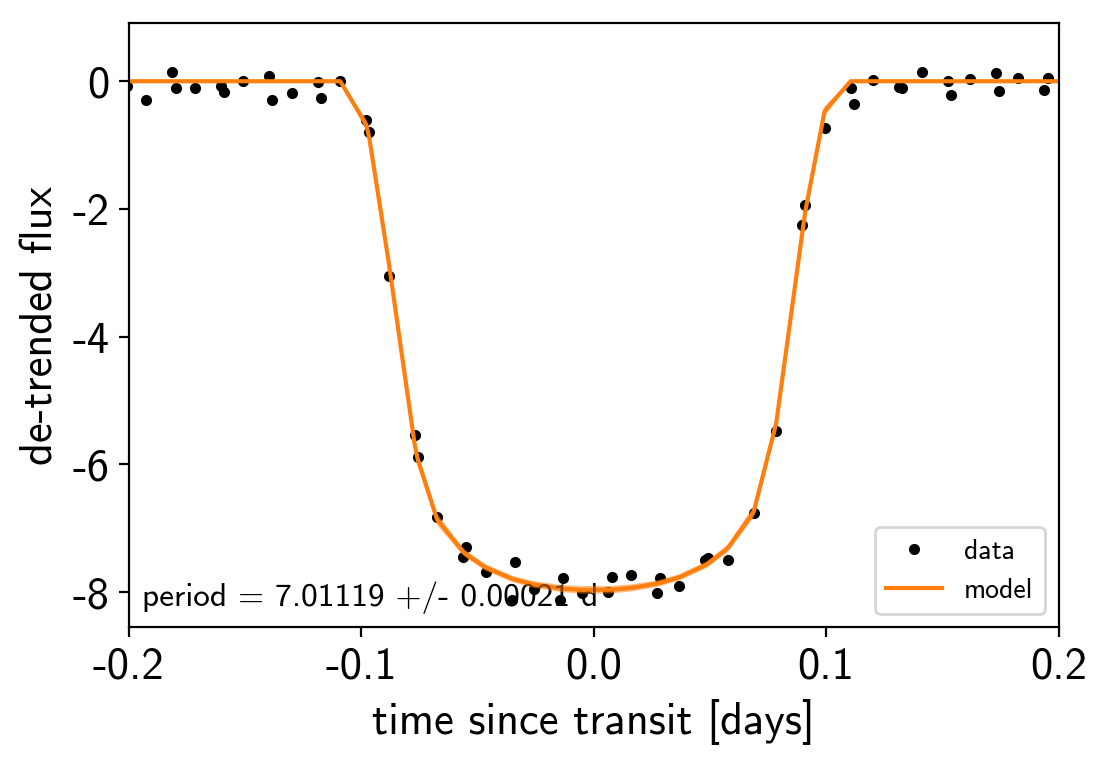

In [17]:
# Compute the GP prediction
gp_mod = np.median(trace["gp_pred"] + trace["mean"][:, None], axis=0)

# Get the posterior median orbital parameters
p = np.median(trace["period"])
t0 = np.median(trace["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5*p) % p - 0.5*p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Plot the folded model
inds = np.argsort(x_fold)
inds = inds[np.abs(x_fold)[inds] < 0.3]
pred = trace["light_curves"][:, inds, 0]
pred = np.percentile(pred, [16, 50, 84], axis=0)
plt.plot(x_fold[inds], pred[1], color="C1", label="model")
art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                       zorder=1000)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(trace["period"]), np.std(trace["period"]))
plt.annotate(txt, (0, 0), xycoords="axes fraction",
             xytext=(5, 5), textcoords="offset points",
             ha="left", va="bottom", fontsize=12)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5*p, 0.5*p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
plt.xlim(-0.2, 0.2);

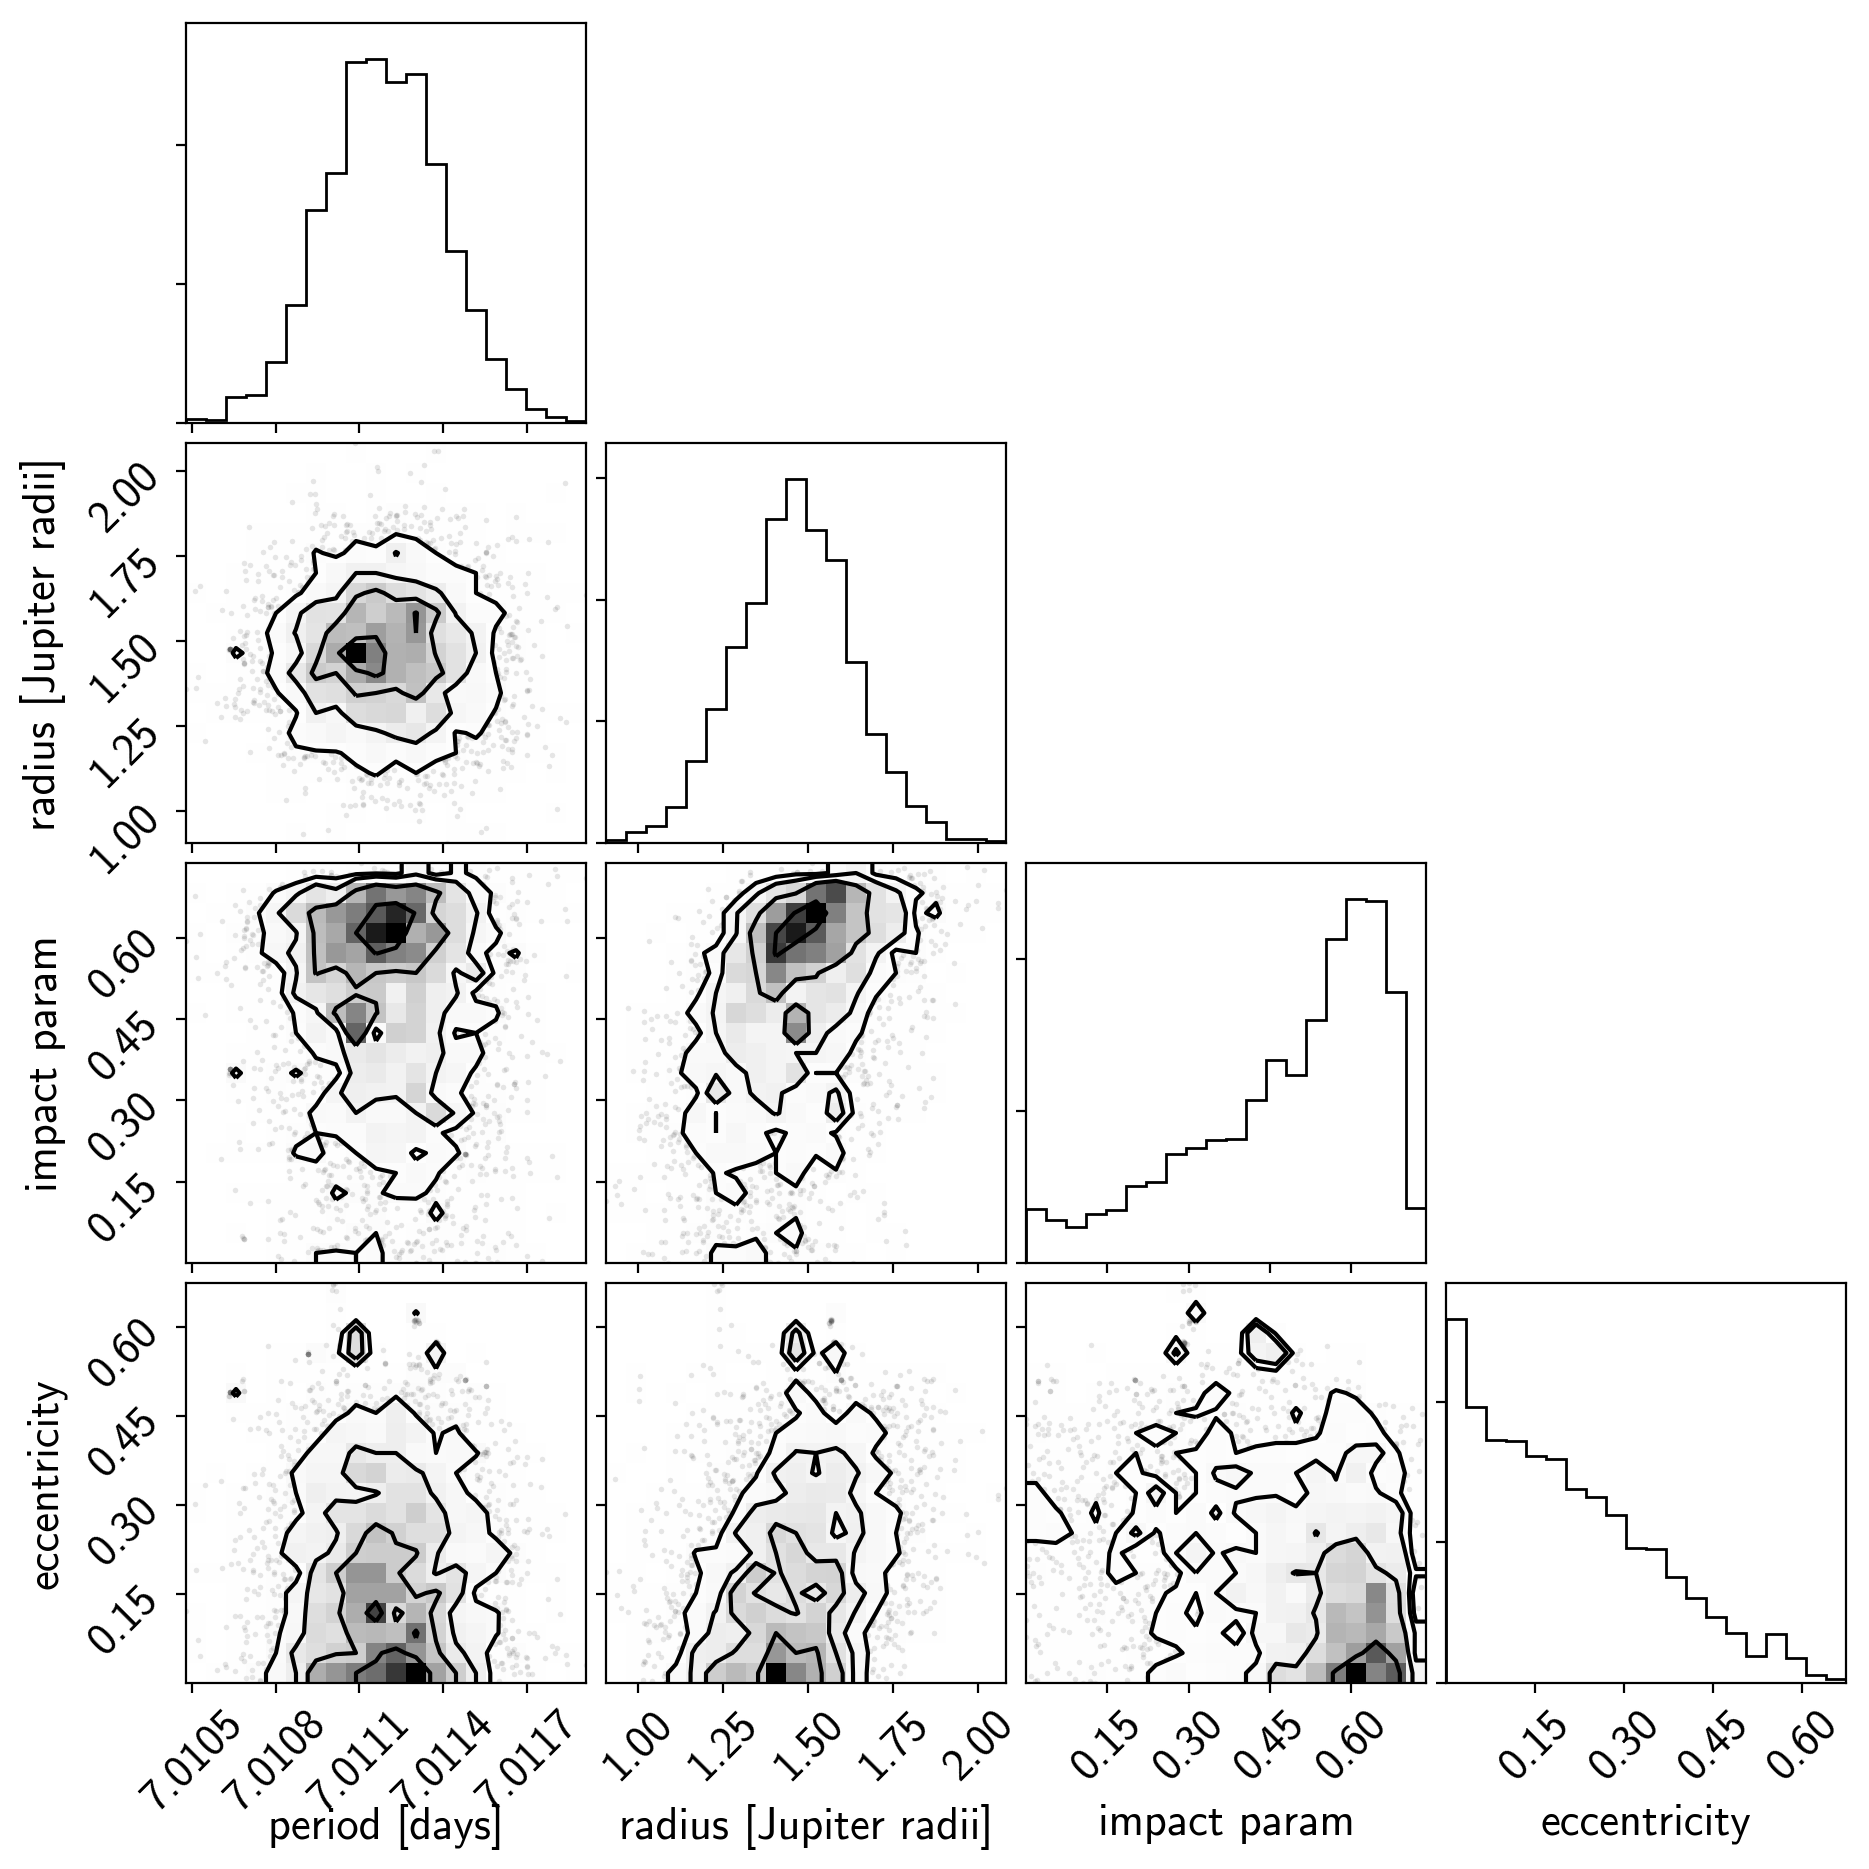

In [18]:
import corner
import astropy.units as u
varnames = ["period", "b", "ecc", "r_pl"]
samples = pm.trace_to_dataframe(trace, varnames=varnames)

# Convert the radius to Earth radii
samples["r_pl"] = (np.array(samples["r_pl"]) * u.R_sun).to(u.R_jupiter).value

corner.corner(
    samples[["period", "r_pl", "b", "ecc"]],
    labels=["period [days]", "radius [Jupiter radii]", "impact param", "eccentricity"]);

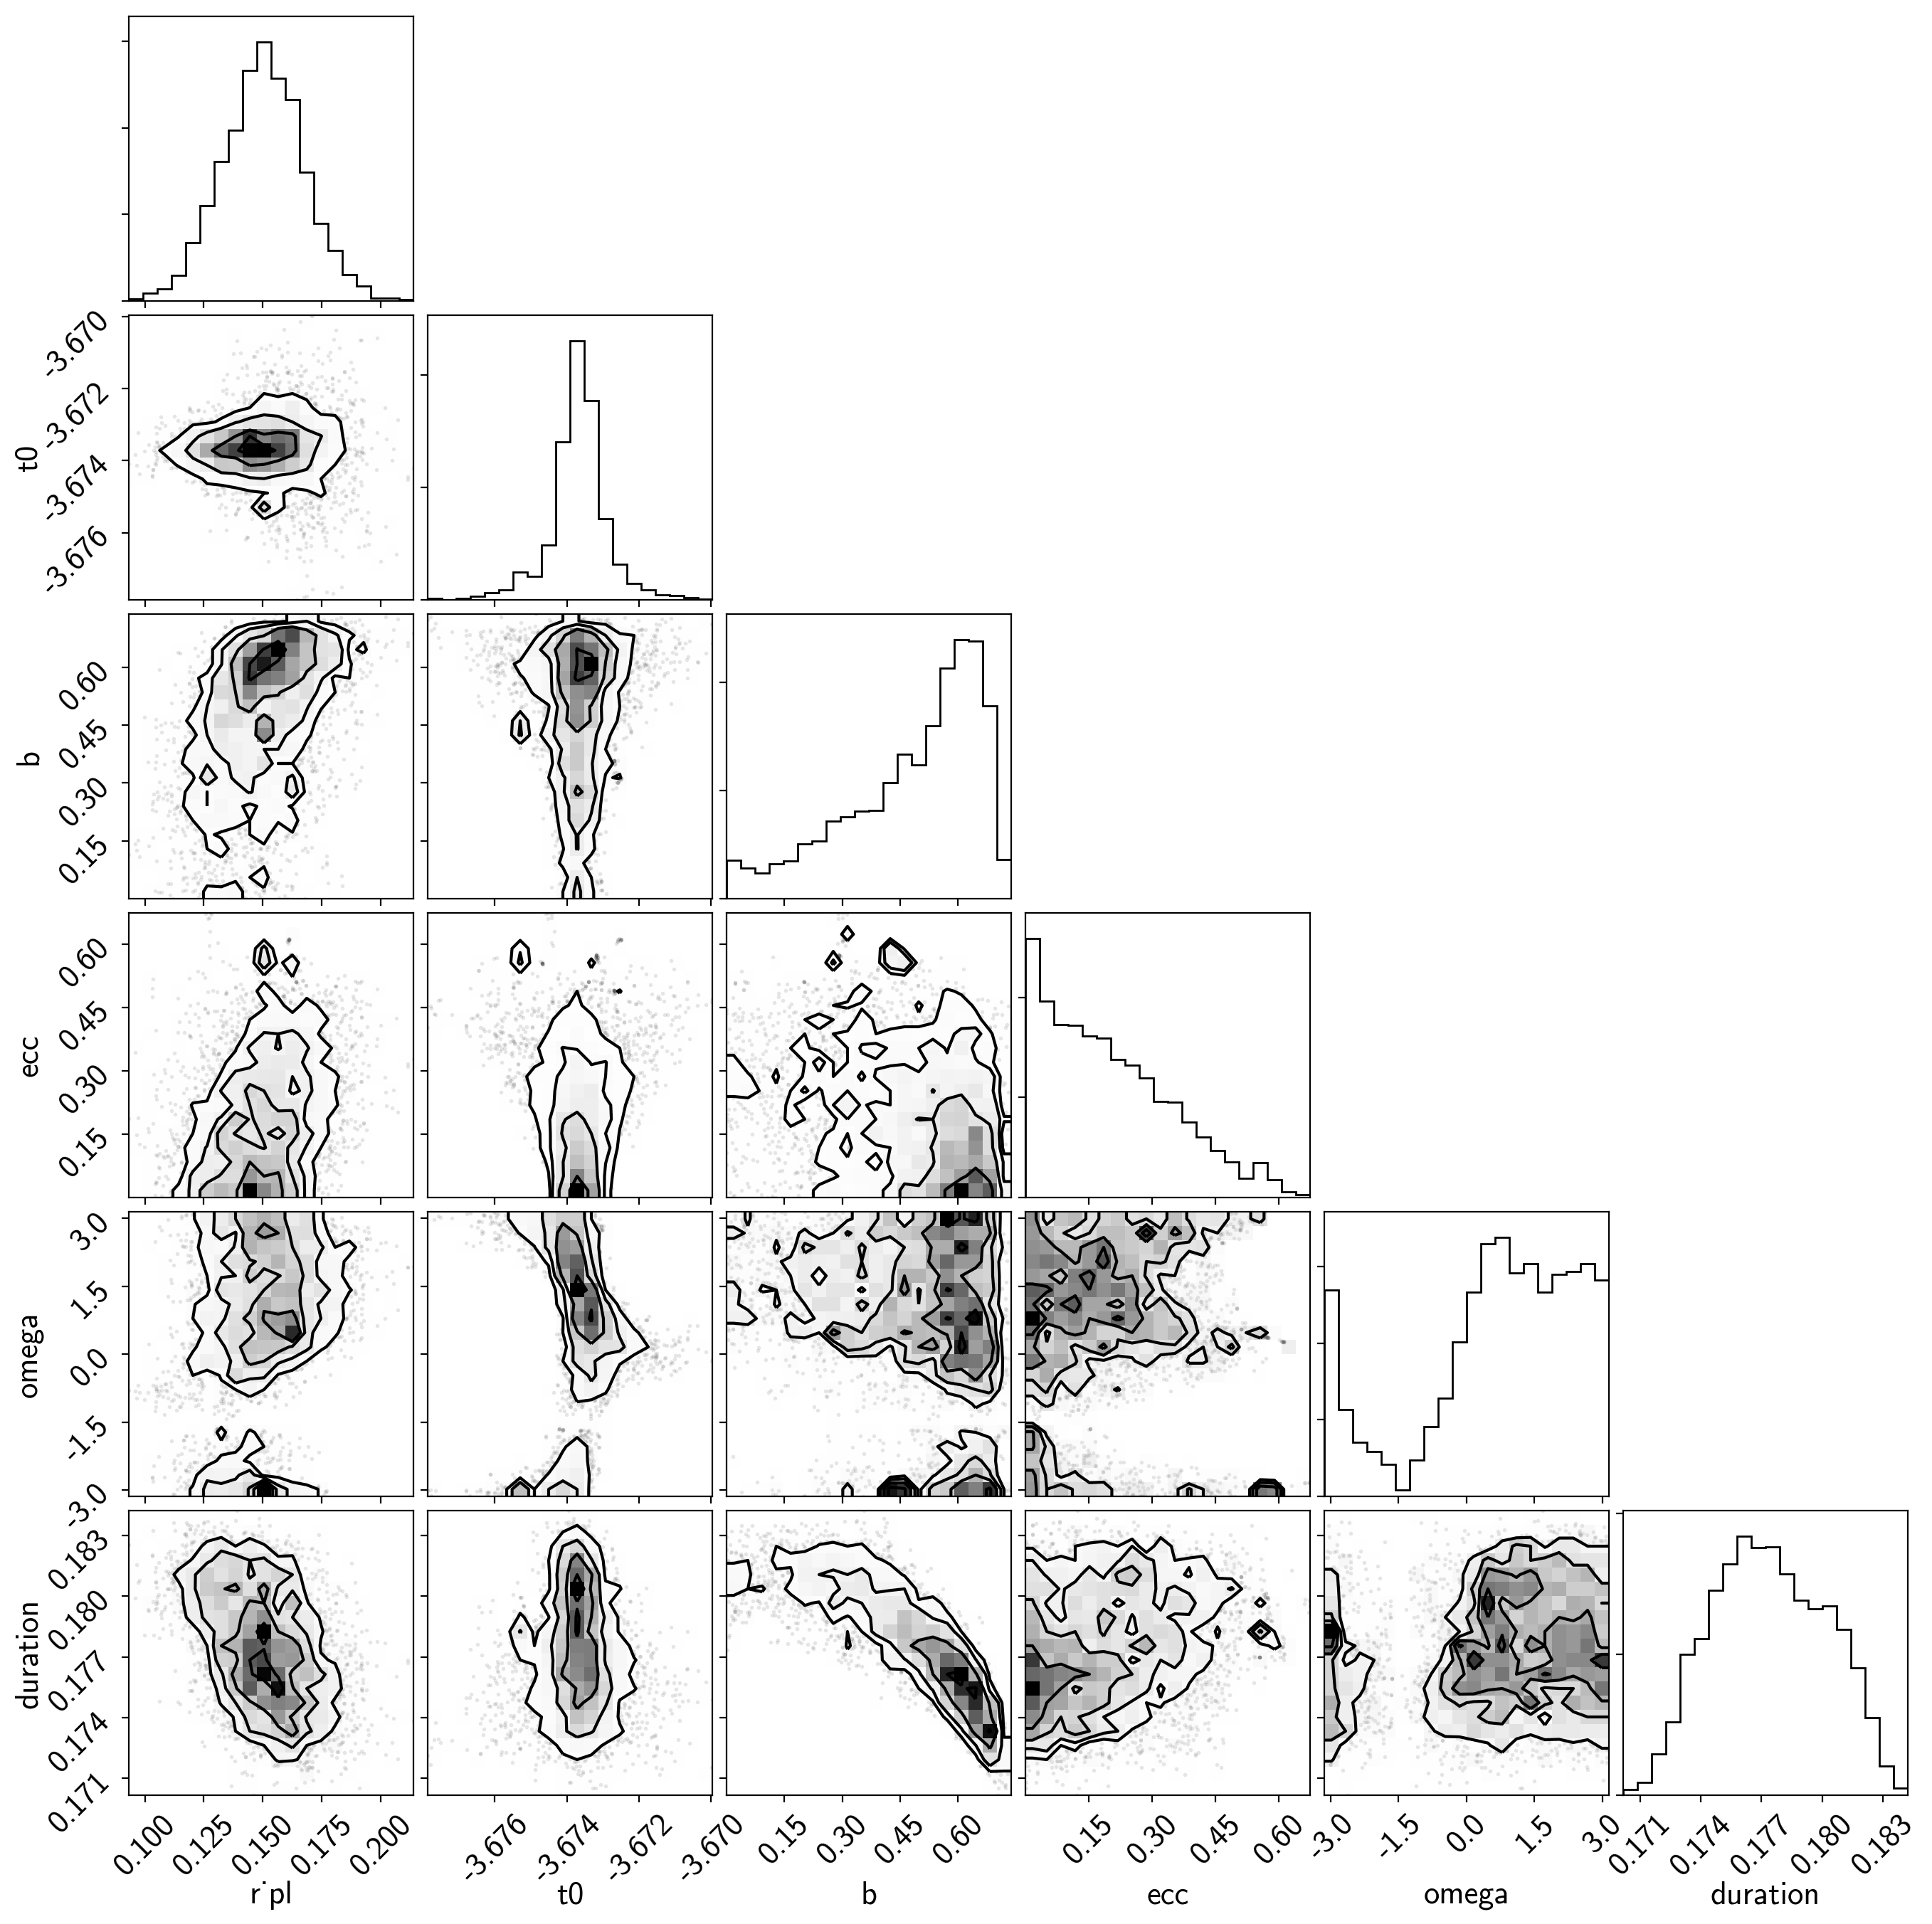

In [19]:
aor = -trace["a"] / trace["r_star"]
e = trace["ecc"]
w = trace["omega"]
i = trace["incl"]
b = trace["b"]
k = trace["r_pl"] / trace["r_star"]
P = trace["period"]

T_tot = P/np.pi * np.arcsin(np.sqrt(1 - b**2) / np.sin(i) / aor)
dur = T_tot * np.sqrt(1 - e**2) / (1 + e * np.sin(w))

samples = pm.trace_to_dataframe(trace, varnames=["r_pl", "t0", "b", "ecc", "omega"])
samples["duration"] = dur
corner.corner(samples);